In [3]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import itertools
import pandas as pd

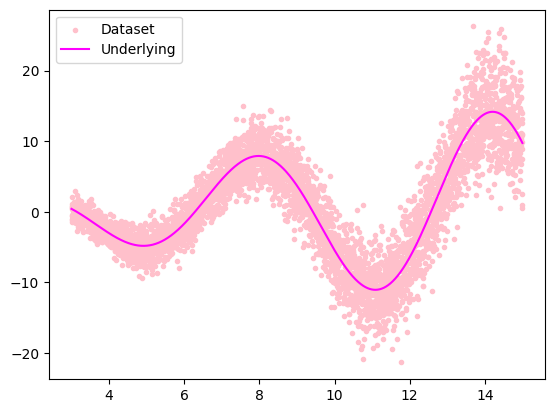

In [7]:
def f(x):
    return x * np.sin(x)

xMin = 3
xMax = 15
nSample = 5000

# input
x = np.linspace(xMin, xMax, nSample)
x_actual = np.linspace(xMin, xMax, nSample)
y_actual = f(x)

np.random.shuffle(x)

np.random.seed(17)
epsilon1 = np.random.normal(0.0, 0.3, nSample)
epsilon2 = np.random.normal(0.0, 0.3, nSample)

y = f(x) + epsilon1 + epsilon2 * x

plt.scatter(x, y, label = "Dataset", color = "pink", s = 9)
plt.plot(x_actual, y_actual, label = "Underlying", color = "magenta")
plt.legend()
plt.show()

X_train = x.reshape(-1, 1)
y_train = y.reshape(-1, 1)
X_test = np.arange(xMin, xMax+5, 0.01).reshape(-1, 1)

In [9]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)

(5000, 1)
(1700, 1)
(5000, 1)


In [10]:
class GradientBoostedTreesEnsembleRegressor(tf.keras.Model):
    def __init__(self, n_trees=100, max_depth=3, n_estimators=100, subportion=0.6, sample_method='RANDOM'):
        super(GradientBoostedTreesEnsembleRegressor, self).__init__()
        self.n_trees = n_trees
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.subportion = subportion
        self.sample_method = sample_method
        self.estimators = []

    def build_estimator(self):
        model = tfdf.keras.GradientBoostedTreesModel(
            task=tfdf.keras.Task.REGRESSION,
            num_trees=self.n_trees,
            max_depth=self.max_depth,
            validation_ratio=0.1,
            subsample=self.subportion, 
            sampling_method=self.sample_method
        )
        return model

    def fit(self, X, y):
        num_data = X.shape[0]
        
        for seed in np.random.randint(0, 1000000, size=self.n_estimators):
            self.seed = seed
            
            # get the data index as a list
            indices = np.arange(num_data)
            indices = list(indices)
            
            # select a subset of indices for training
            train_estimator_size = int(self.subportion * len(indices))
            train_estimator_indices = np.random.choice(indices, size=train_estimator_size, replace=False)
            X_estimator_train = X[train_estimator_indices]
            y_estimator_train = y[train_estimator_indices]
            
            # building each estimator
            estimator = self.build_estimator()
            estimator.fit(X_estimator_train, y_estimator_train)
            
            self.estimators.append(estimator)

    def predict(self, X, n_samples=10, n_runs=5):
        all_predictions = []
        for _ in range(n_runs):
            predictions = []
            sampled_estimators = np.random.choice(self.estimators, size=n_samples, replace=False)
            for estimator in sampled_estimators:
                estimator_predictions = []
                estimator_predictions.append(estimator.predict(X))
                estimator_predictions = tf.stack(estimator_predictions, axis=-1)
                predictions.append(tf.reduce_mean(estimator_predictions, axis=-1))
            predictions = tf.stack(predictions, axis=0)
            all_predictions.append(predictions)
        
        all_predictions = tf.stack(all_predictions, axis=0)
        mean_prediction = tf.reduce_mean(all_predictions, axis=(0, 1))
        variance_prediction = tf.math.reduce_std(all_predictions, axis=(0, 1))
        return mean_prediction, variance_prediction



In [11]:
gbt_model = GradientBoostedTreesEnsembleRegressor(
    n_trees=50, 
    max_depth=3, 
    n_estimators=80, 
    subportion=0.3, 
    sample_method='RANDOM'
)



In [12]:
gbt_model.fit(X_train, y_train)

Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4dipz7aw as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:44.2040 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:44.2046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:44.2046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.993084. Found 1500 examples.
Training model...
Model trained in 0:00:00.023182
Compiling model...


[INFO 24-04-15 16:59:46.2253 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4dipz7aw/model/ with prefix 492abefa3def4d48
[INFO 24-04-15 16:59:46.2261 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-15 16:59:46.2261 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdlwak62 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.064444. Found 1500 examples.
Training model...
Model trained in 0:00:00.019713
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa96bmk4x as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:48.3442 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.3443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.3443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:48.4305 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdlwak62/model/ with prefix e217a17cb6c348c1
[INFO 24-04-15 16:59:48.4310 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:48.4835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.4835 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.4835 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.062868. Found 1500 examples.
Training model...
Model trained in 0:00:00.020206
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdmhypm7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.063914. Found 1500 examples.
Training model...
Model trained in 0:00:00.020408
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcfx_8dy0 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:48.5697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa96bmk4x/model/ with prefix 8af76019b156454d
[INFO 24-04-15 16:59:48.5702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:48.6255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.6256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.6256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:48.7118 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdmhypm7/model/ with prefix 2fd5b808de9a4ce1
[INFO 24-04-15 16:59:48.7123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:48.7661 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.065698. Found 1500 examples.
Training model...
Model trained in 0:00:00.020135
Compiling model...


[INFO 24-04-15 16:59:48.8545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcfx_8dy0/model/ with prefix 2761545f46c6455d
[INFO 24-04-15 16:59:48.8550 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4ecewvi as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:48.9124 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.9124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:48.9124 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.065217. Found 1500 examples.
Training model...
Model trained in 0:00:00.020365
Compiling model...


[INFO 24-04-15 16:59:49.0001 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4ecewvi/model/ with prefix f7785dc59d4241c4
[INFO 24-04-15 16:59:49.0006 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwepj9rmy as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.0610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.0610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.0610 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066639. Found 1500 examples.
Training model...
Model trained in 0:00:00.020165
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.1496 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwepj9rmy/model/ with prefix aceb8f9493b9482f
[INFO 24-04-15 16:59:49.1502 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuo2_u58 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.2070 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.2070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.2071 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.064920. Found 1500 examples.
Training model...
Model trained in 0:00:00.020170
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.2944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuo2_u58/model/ with prefix 8622069c744f4822
[INFO 24-04-15 16:59:49.2950 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pg_uvvm as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.3519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.3519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.3519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066721. Found 1500 examples.
Training model...
Model trained in 0:00:00.020548
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.4412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pg_uvvm/model/ with prefix ceb170b036dd4155
[INFO 24-04-15 16:59:49.4418 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcgbmx2m2 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.4972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.4972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.4972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067624. Found 1500 examples.
Training model...
Model trained in 0:00:00.020183
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.5879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcgbmx2m2/model/ with prefix 8653c337342a4549
[INFO 24-04-15 16:59:49.5884 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xnu0d58 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.6426 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.6427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.6427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067063. Found 1500 examples.
Training model...
Model trained in 0:00:00.020382
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.7324 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xnu0d58/model/ with prefix 94d32ed629164b9c
[INFO 24-04-15 16:59:49.7329 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaolethpy as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.7911 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.7912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.7912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.064646. Found 1500 examples.
Training model...
Model trained in 0:00:00.020528
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:49.8784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaolethpy/model/ with prefix 690e0c3208904b66
[INFO 24-04-15 16:59:49.8790 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiysb3hn8 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:49.9348 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.9348 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:49.9348 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.065700. Found 1500 examples.
Training model...
Model trained in 0:00:00.020585
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8dqk_n3 as temporary training directory


[INFO 24-04-15 16:59:50.0232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiysb3hn8/model/ with prefix eb3a212359384ea8
[INFO 24-04-15 16:59:50.0238 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...


[WARNING 24-04-15 16:59:50.0791 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.0791 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.0791 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.065681. Found 1500 examples.
Training model...
Model trained in 0:00:00.020168
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzr72ss4 as temporary training directory


[INFO 24-04-15 16:59:50.1673 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8dqk_n3/model/ with prefix a28f1016e6984ba8
[INFO 24-04-15 16:59:50.1678 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...


[WARNING 24-04-15 16:59:50.2242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.2243 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.2243 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067412. Found 1500 examples.
Training model...
Model trained in 0:00:00.020736
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:50.3148 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzr72ss4/model/ with prefix d5f6b972236c444b
[INFO 24-04-15 16:59:50.3154 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfffggd6p as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:50.3703 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.3703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.3703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.064526. Found 1500 examples.
Training model...
Model trained in 0:00:00.020523
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfcvbo7dl as temporary training directory


[INFO 24-04-15 16:59:50.4584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfffggd6p/model/ with prefix dd331efe3ceb4090
[INFO 24-04-15 16:59:50.4589 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:50.5148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.5149 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.5149 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.066625. Found 1500 examples.
Training model...
Model trained in 0:00:00.020285
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:50.6040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfcvbo7dl/model/ with prefix 49c6f6c399bf448a
[INFO 24-04-15 16:59:50.6045 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhc0x7pb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.064698. Found 1500 examples.
Training model...
Model trained in 0:00:00.020336
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:50.6620 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.6620 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.6620 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:50.7489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhc0x7pb/model/ with prefix 63cb9230a4c244da
[INFO 24-04-15 16:59:50.7494 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxeqaniud as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:50.8069 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.8069 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.8069 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066454. Found 1500 examples.
Training model...
Model trained in 0:00:00.020412
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiey66hcg as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:50.8958 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxeqaniud/model/ with prefix c724fbb5be9c4dab
[INFO 24-04-15 16:59:50.8963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:50.9522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.9523 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:50.9523 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.064349. Found 1500 examples.
Training model...
Model trained in 0:00:00.020523
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpor1w6k03 as temporary training directory


[INFO 24-04-15 16:59:51.0390 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiey66hcg/model/ with prefix 0284ab6caa6d4cf6
[INFO 24-04-15 16:59:51.0395 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.0948 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.0948 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.0948 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.069258. Found 1500 examples.
Training model...
Model trained in 0:00:00.020090
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:51.1874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpor1w6k03/model/ with prefix 59c88e81bd6a4a9b
[INFO 24-04-15 16:59:51.1879 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7tcnvz3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.067057. Found 1500 examples.
Training model...
Model trained in 0:00:00.020361
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdc8ojkn4 as temporary training directory


[WARNING 24-04-15 16:59:51.2421 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.2421 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.2421 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:51.3315 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7tcnvz3/model/ with prefix 74d6584536cc433d
[INFO 24-04-15 16:59:51.3321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.3864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.3864 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.3864 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...


Training dataset read in 0:00:00.067982. Found 1500 examples.
Training model...
Model trained in 0:00:00.018952
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvidaux8 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:51.4757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdc8ojkn4/model/ with prefix 09746cbec51e431d
[INFO 24-04-15 16:59:51.4763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.5314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.5315 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.5315 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.063375. Found 1500 examples.
Training model...
Model trained in 0:00:00.019494
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd_tsm5k_ as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:51.6163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvidaux8/model/ with prefix 38b2b6334ab34fdd
[INFO 24-04-15 16:59:51.6168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.6720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.6720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.6720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066202. Found 1500 examples.
Training model...
Model trained in 0:00:00.020068
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe7r_zupq as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:51.7604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd_tsm5k_/model/ with prefix 39665eecf4774309
[INFO 24-04-15 16:59:51.7609 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.8128 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.8128 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.8128 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067801. Found 1500 examples.
Training model...
Model trained in 0:00:00.020188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcvzplthv as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:51.9042 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe7r_zupq/model/ with prefix 6acadd460b184fff
[INFO 24-04-15 16:59:51.9047 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:51.9581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.9581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:51.9581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067470. Found 1500 examples.
Training model...
Model trained in 0:00:00.020525
Compiling model...


[INFO 24-04-15 16:59:52.0481 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcvzplthv/model/ with prefix 7cf16502a0a3420a
[INFO 24-04-15 16:59:52.0487 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxh23c0t as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:52.2234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.2235 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.2235 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.070977. Found 1500 examples.
Training model...
Model trained in 0:00:00.020428
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwl_wpfq_ as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:52.3171 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxh23c0t/model/ with prefix ff0bef94d7924443
[INFO 24-04-15 16:59:52.3177 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:52.3729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.3729 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.3729 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.065981. Found 1500 examples.
Training model...
Model trained in 0:00:00.019929
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:52.4606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwl_wpfq_/model/ with prefix 620ac1742581462a
[INFO 24-04-15 16:59:52.4611 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkned_9a0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.067443. Found 1500 examples.
Training model...
Model trained in 0:00:00.021103
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:52.5203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.5203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.5203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:52.6106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkned_9a0/model/ with prefix 107b1a2bd83440ac
[INFO 24-04-15 16:59:52.6112 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i96olkg as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:52.6672 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.6672 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.6672 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067496. Found 1500 examples.
Training model...
Model trained in 0:00:00.020377
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ec0abgi as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:52.7569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i96olkg/model/ with prefix 2a964e48cf544d63
[INFO 24-04-15 16:59:52.7575 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:52.8147 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.8147 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.8147 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.068435. Found 1500 examples.
Training model...
Model trained in 0:00:00.019926
Compiling model...


[INFO 24-04-15 16:59:52.9052 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ec0abgi/model/ with prefix 8ff4450c3cc94f60
[INFO 24-04-15 16:59:52.9057 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp487acc55 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.068536. Found 1500 examples.
Training model...
Model trained in 0:00:00.020606
Compiling model...


[WARNING 24-04-15 16:59:52.9697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.9697 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:52.9697 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:53.0618 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp487acc55/model/ with prefix bc55a7ccec174254
[INFO 24-04-15 16:59:53.0623 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0a3ti98 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:53.1156 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.1156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.1156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.069388. Found 1500 examples.
Training model...
Model trained in 0:00:00.020750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7qr1glf as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:53.2078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0a3ti98/model/ with prefix b5d5d98daec84b14
[INFO 24-04-15 16:59:53.2084 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:53.2635 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.2635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.2635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.065379. Found 1500 examples.
Training model...
Model trained in 0:00:00.020961
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:53.3518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7qr1glf/model/ with prefix e7f9d9d17fe4400d
[INFO 24-04-15 16:59:53.3524 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp30zolg92 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.067503. Found 1500 examples.
Training model...
Model trained in 0:00:00.018342
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp7q_zqdj as temporary training directory


[WARNING 24-04-15 16:59:53.4096 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.4096 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.4096 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:53.4977 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp30zolg92/model/ with prefix 59349fda81444d44
[INFO 24-04-15 16:59:53.4982 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...


[WARNING 24-04-15 16:59:53.5528 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.5528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.5528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066734. Found 1500 examples.
Training model...
Model trained in 0:00:00.020555
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjt6hvsn as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:53.6422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp7q_zqdj/model/ with prefix 9e1a67a9217049bd
[INFO 24-04-15 16:59:53.6427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:53.6970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.6970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.6970 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067356. Found 1500 examples.
Training model...
Model trained in 0:00:00.023505
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:53.7896 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjt6hvsn/model/ with prefix c947ed4d97c84498
[INFO 24-04-15 16:59:53.7902 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpost0hb4u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070056. Found 1500 examples.
Training model...
Model trained in 0:00:00.020820
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:53.8465 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.8466 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.8466 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:53.9403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpost0hb4u/model/ with prefix 9e205fd3a8004774
[INFO 24-04-15 16:59:53.9409 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjo5ygf40 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:53.9955 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.9955 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:53.9955 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.068427. Found 1500 examples.
Training model...
Model trained in 0:00:00.021592
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbejws9ov as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:54.0876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjo5ygf40/model/ with prefix 536ae9d75d7f4aef
[INFO 24-04-15 16:59:54.0881 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:54.1442 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.1442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.1442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066732. Found 1500 examples.
Training model...
Model trained in 0:00:00.020601
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:54.2333 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbejws9ov/model/ with prefix 94084e18f68f4ebd
[INFO 24-04-15 16:59:54.2339 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvvor7042 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.068427. Found 1500 examples.
Training model...
Model trained in 0:00:00.020519
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:54.2907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.2907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.2907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:54.3815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvvor7042/model/ with prefix fe5ffb9e55234643
[INFO 24-04-15 16:59:54.3821 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyftto16d as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:54.4374 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.4374 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.4374 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067472. Found 1500 examples.
Training model...
Model trained in 0:00:00.021009
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ay8itxp as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:54.5279 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyftto16d/model/ with prefix 20b34c67a0584761
[INFO 24-04-15 16:59:54.5285 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:54.5841 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.5841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.5841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067911. Found 1500 examples.
Training model...
Model trained in 0:00:00.020072
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:54.6749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ay8itxp/model/ with prefix 4e440e4db8814147
[INFO 24-04-15 16:59:54.6755 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4t46u93t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.066765. Found 1500 examples.
Training model...
Model trained in 0:00:00.020679
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:54.7309 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.7309 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.7309 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:54.8203 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4t46u93t/model/ with prefix bf21a73c77d3479d
[INFO 24-04-15 16:59:54.8208 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsteoj80r as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:54.8765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.8765 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:54.8765 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067922. Found 1500 examples.
Training model...
Model trained in 0:00:00.021251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph0ktez_t as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:54.9676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsteoj80r/model/ with prefix fbf2082c82eb4417
[INFO 24-04-15 16:59:54.9682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:55.0242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.0242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.0242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066032. Found 1500 examples.
Training model...
Model trained in 0:00:00.021207
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoa1i3blb as temporary training directory


[INFO 24-04-15 16:59:55.1134 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph0ktez_t/model/ with prefix edf95e32a7744fcc
[INFO 24-04-15 16:59:55.1139 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:55.1667 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.1667 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.1667 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.067487. Found 1500 examples.
Training model...
Model trained in 0:00:00.020297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhhz3e3l as temporary training directory


[INFO 24-04-15 16:59:55.2568 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoa1i3blb/model/ with prefix 2b31c22137584a33
[INFO 24-04-15 16:59:55.2573 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:55.3117 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.3117 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.3117 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Reading training dataset...
Training dataset read in 0:00:00.069072. Found 1500 examples.
Training model...
Model trained in 0:00:00.020701
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:55.4051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhhz3e3l/model/ with prefix 2b5797510348423b
[INFO 24-04-15 16:59:55.4056 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi0uerkr0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070922. Found 1500 examples.
Training model...
Model trained in 0:00:00.021096
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:55.4598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.4598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.4598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:55.5537 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi0uerkr0/model/ with prefix d237b13a7d5440e8
[INFO 24-04-15 16:59:55.5542 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdkqv2909 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:55.6075 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.6075 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.6075 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.072103. Found 1500 examples.
Training model...
Model trained in 0:00:00.021388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsng4dnx2 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:55.7033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdkqv2909/model/ with prefix a5718d21682b4113
[INFO 24-04-15 16:59:55.7039 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:55.7595 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.7595 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.7595 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.066375. Found 1500 examples.
Training model...
Model trained in 0:00:00.021241
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:55.8491 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsng4dnx2/model/ with prefix adc84311f4c440f2
[INFO 24-04-15 16:59:55.8496 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf277x4ex as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069619. Found 1500 examples.
Training model...
Model trained in 0:00:00.020717
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:55.9057 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.9057 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:55.9057 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:55.9980 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf277x4ex/model/ with prefix fd50843dca2747fa
[INFO 24-04-15 16:59:55.9986 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pi8ua7b as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:56.0512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.0512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.0512 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067926. Found 1500 examples.
Training model...
Model trained in 0:00:00.022092
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp07azh3v_ as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:56.1432 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pi8ua7b/model/ with prefix d55ef0fee62b4dad
[INFO 24-04-15 16:59:56.1438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:56.2004 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.2004 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.2004 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.069064. Found 1500 examples.
Training model...
Model trained in 0:00:00.020340
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:56.2931 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp07azh3v_/model/ with prefix dcdce3e6d66f49c1
[INFO 24-04-15 16:59:56.2936 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-15 16:59:56.2936 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc0hixkv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069053. Found 1500 examples.
Training model...
Model trained in 0:00:00.021151
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:56.3508 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.3508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.3508 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:56.4433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc0hixkv/model/ with prefix 681f29bc81064272
[INFO 24-04-15 16:59:56.4439 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0xiiayi as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:56.4985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.4986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.4986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067428. Found 1500 examples.
Training model...
Model trained in 0:00:00.020365
Compiling model...


[INFO 24-04-15 16:59:56.5884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0xiiayi/model/ with prefix 9fc8b547b00e4b44
[INFO 24-04-15 16:59:56.5889 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiheblujm as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:56.7769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.7769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.7769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.071305. Found 1500 examples.
Training model...
Model trained in 0:00:00.021378
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyhz4its as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:56.8725 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiheblujm/model/ with prefix a311361dcb06448c
[INFO 24-04-15 16:59:56.8730 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:56.9285 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.9286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:56.9286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.069207. Found 1500 examples.
Training model...
Model trained in 0:00:00.020851
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:57.0205 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyhz4its/model/ with prefix ca7e6453652e40fd
[INFO 24-04-15 16:59:57.0211 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppfg59wf8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070002. Found 1500 examples.
Training model...
Model trained in 0:00:00.020754
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:57.0761 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.0761 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.0761 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:57.1689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppfg59wf8/model/ with prefix 42381b31d148475c
[INFO 24-04-15 16:59:57.1695 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7bsf95m as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:57.2245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.2246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.2246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.070327. Found 1500 examples.
Training model...
Model trained in 0:00:00.022275
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjottzsw8 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:57.3193 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7bsf95m/model/ with prefix 650c392cf5194ac6
[INFO 24-04-15 16:59:57.3199 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:57.3745 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.3745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.3745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.068714. Found 1500 examples.
Training model...
Model trained in 0:00:00.021252
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:57.4673 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjottzsw8/model/ with prefix 22b2f2415e744d80
[INFO 24-04-15 16:59:57.4679 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5600rxj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.067172. Found 1500 examples.
Training model...
Model trained in 0:00:00.021269
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:57.5242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.5242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.5242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:57.6149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5600rxj/model/ with prefix 8a4c82aca62b40de
[INFO 24-04-15 16:59:57.6155 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldkecs5w as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:57.6696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.6696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.6696 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.068247. Found 1500 examples.
Training model...
Model trained in 0:00:00.021447
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6twtt59n as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:57.7613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldkecs5w/model/ with prefix 1947f73fef644507
[INFO 24-04-15 16:59:57.7618 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:57.8163 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.8163 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.8164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.068055. Found 1500 examples.
Training model...
Model trained in 0:00:00.021543
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:57.9077 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6twtt59n/model/ with prefix 8f77514bfc0b49f1
[INFO 24-04-15 16:59:57.9083 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kjo0tcj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.072283. Found 1500 examples.
Training model...
Model trained in 0:00:00.020998
Compiling model...


[WARNING 24-04-15 16:59:57.9658 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.9658 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:57.9658 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:58.0621 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kjo0tcj/model/ with prefix 4f43de9d927b4848
[INFO 24-04-15 16:59:58.0626 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvns95h7p as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:58.1180 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.1180 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.1180 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.074115. Found 1500 examples.
Training model...
Model trained in 0:00:00.020992
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59liuqa4 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:58.2154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvns95h7p/model/ with prefix 5710e17b2c5346b3
[INFO 24-04-15 16:59:58.2160 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:58.2720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.2720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.2720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067521. Found 1500 examples.
Training model...
Model trained in 0:00:00.020977
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:58.3626 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59liuqa4/model/ with prefix 23103f302f4e4032
[INFO 24-04-15 16:59:58.3632 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqzsc8a7o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069222. Found 1500 examples.
Training model...
Model trained in 0:00:00.020573
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:58.4186 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.4186 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.4186 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:58.5103 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqzsc8a7o/model/ with prefix c049ab6a71174132
[INFO 24-04-15 16:59:58.5108 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfpp2i6j7 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:58.5658 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.5658 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.5658 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.069966. Found 1500 examples.
Training model...
Model trained in 0:00:00.020630
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpia5n59y2 as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:58.6587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfpp2i6j7/model/ with prefix 59815d2fb27147d2
[INFO 24-04-15 16:59:58.6592 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:58.7151 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.7152 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.7152 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.069694. Found 1500 examples.
Training model...
Model trained in 0:00:00.020814
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:58.8075 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpia5n59y2/model/ with prefix d7a2eb96adfb42e9
[INFO 24-04-15 16:59:58.8080 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkurgiyiq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.071110. Found 1500 examples.
Training model...
Model trained in 0:00:00.020781
Compiling model...
Model compiled.


[WARNING 24-04-15 16:59:58.8637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.8637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:58.8637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:58.9590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkurgiyiq/model/ with prefix eae8a6c6f584443a
[INFO 24-04-15 16:59:58.9595 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidq5k7z7 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:59.0148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.0148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.0148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.071028. Found 1500 examples.
Training model...
Model trained in 0:00:00.021136
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuc7li74a as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:59.1088 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidq5k7z7/model/ with prefix 64acd49a806946a4
[INFO 24-04-15 16:59:59.1094 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:59.1651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.1651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.1651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.067886. Found 1500 examples.
Training model...
Model trained in 0:00:00.020368
Compiling model...
Model compiled.


[INFO 24-04-15 16:59:59.2551 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuc7li74a/model/ with prefix d6a1835ea4d344a4
[INFO 24-04-15 16:59:59.2556 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzychjxvw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075359. Found 1500 examples.
Training model...
Model trained in 0:00:00.021185
Compiling model...


[WARNING 24-04-15 16:59:59.3121 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.3121 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.3121 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:59.4106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzychjxvw/model/ with prefix 3bdb2af12b184d90
[INFO 24-04-15 16:59:59.4111 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf2eb1ii0 as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:59.4698 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.4698 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.4698 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.075705. Found 1500 examples.
Training model...
Model trained in 0:00:00.021482
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprafigdlk as temporary training directory
Reading training dataset...


[INFO 24-04-15 16:59:59.5689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf2eb1ii0/model/ with prefix d8ff970e7e414efb
[INFO 24-04-15 16:59:59.5695 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 16:59:59.6292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.6292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.6292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.075294. Found 1500 examples.
Training model...
Model trained in 0:00:00.022176
Compiling model...


[INFO 24-04-15 16:59:59.7300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprafigdlk/model/ with prefix 002794d063364307
[INFO 24-04-15 16:59:59.7305 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5m17438m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.073884. Found 1500 examples.
Training model...
Model trained in 0:00:00.020869
Compiling model...


[WARNING 24-04-15 16:59:59.7907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.7907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.7908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-15 16:59:59.8879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5m17438m/model/ with prefix 06b694455c344fb8
[INFO 24-04-15 16:59:59.8884 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprv4xbobc as temporary training directory
Reading training dataset...


[WARNING 24-04-15 16:59:59.9450 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.9450 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 16:59:59.9451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.073939. Found 1500 examples.
Training model...
Model trained in 0:00:00.021186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilteglcv as temporary training directory
Reading training dataset...


[INFO 24-04-15 17:00:00.0423 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprv4xbobc/model/ with prefix b67d23e86f2c4c25
[INFO 24-04-15 17:00:00.0428 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-15 17:00:00.1030 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 17:00:00.1030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-15 17:00:00.1030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.073137. Found 1500 examples.
Training model...
Model trained in 0:00:00.022439
Compiling model...


[INFO 24-04-15 17:00:00.2004 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilteglcv/model/ with prefix b77b1e82b05641ab
[INFO 24-04-15 17:00:00.2010 CEST kernel.cc:1061] Use fast generic engine


Model compiled.


In [13]:
mean_prediction, variance_prediction = gbt_model.predict(X_test, n_samples=50, n_runs=80)

54/54 [==============================] - 0s 328us/step


In [14]:
print(mean_prediction.shape)
print(variance_prediction.shape)
print(variance_prediction)

(1700, 1)
(1700, 1)
tf.Tensor(
[[0.17004757]
 [0.17004757]
 [0.17004757]
 ...
 [0.7833937 ]
 [0.7833937 ]
 [0.7833937 ]], shape=(1700, 1), dtype=float32)


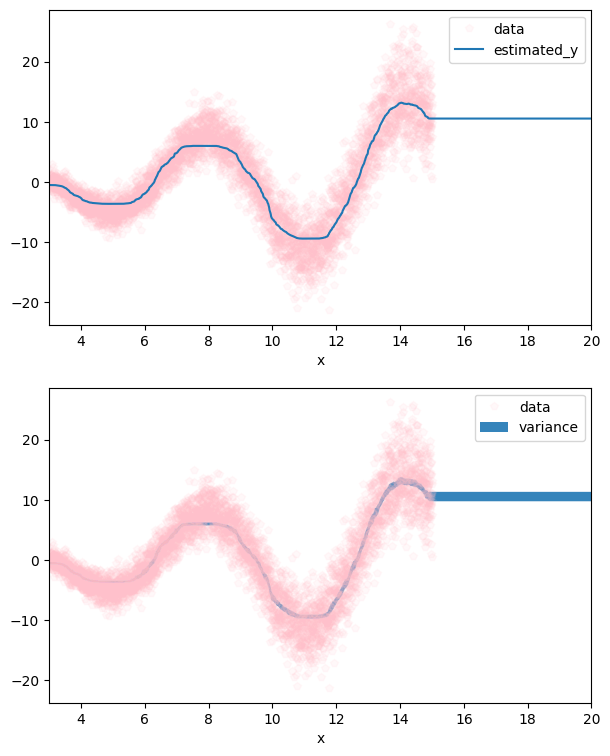

In [15]:
xlim = (xMin,xMax+5)
x_test = X_test.flatten()
y_pred = mean_prediction.numpy().flatten()
uncertainties = variance_prediction.numpy().flatten()

fig = plt.figure(figsize=(7,9))

ax = fig.add_subplot(2,1,1)
ax.plot(X_train,y_train,"p",alpha=0.1,c="pink",label="data")
ax.plot(x_test,y_pred,label="estimated_y")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(X_train,y_train,"p",alpha=0.1,label="data",c="pink")
# ax.plot(x_test,y_pred,label="estimated_y", c="skyblue")
ax.fill_between(x_test, y_pred - uncertainties, y_pred + uncertainties, alpha = 0.9, label="variance")
ax.set_xlabel("x")
ax.set_xlim(*xlim)
ax.legend()
plt.show()

In [ ]:
n_trees_values = [25, 50, 80]
max_depth_values = [3, 5, 7]
n_estimators_values = [30, 50, 80]
subportion_values = [0.5, 0.7, 0.9]
n_runs_values = [20, 50, 80]

# Define divisor values based on n_estimators
divisors_by_n_estimators = {
    30: [3, 5, 7],
    50: [3, 5, 7],
    80: [3, 5, 7],
    120: [3, 5, 7]
}

# Generate parameter combinations
parameter_combinations = []
for n_trees, max_depth, n_estimators, subportion, n_runs in itertools.product(
    n_trees_values, max_depth_values, n_estimators_values, subportion_values, n_runs_values
):
    if n_estimators in divisors_by_n_estimators:
        divisors = divisors_by_n_estimators[n_estimators]
        for divisor in divisors:
            n_samples = n_estimators // divisor
            parameter_combinations.append((n_trees, max_depth, n_estimators, subportion, n_samples, n_runs))

# Create DataFrame to store results
results_in_df = pd.DataFrame(columns=[
    'n_trees', 'max_depth', 'n_estimators', 'subportion',
    'n_samples', 'n_runs', 'mean_prediction', 'variance_prediction'
])

# Loop over parameter combinations
for params in parameter_combinations:
    n_trees, max_depth, n_estimators, subportion, n_samples, n_runs = params
    
    gbt_model = GradientBoostedTreesEnsembleRegressor(
        n_trees=n_trees,
        max_depth=max_depth,
        n_estimators=n_estimators,
        subportion=subportion,
        sample_method='RANDOM'
    )
    
    gbt_model.fit(X_train, y_train)
    mean_prediction, variance_prediction = gbt_model.predict(X_test, n_samples=n_samples, n_runs=n_runs)
    
    current_result = pd.DataFrame({
        'n_trees': [n_trees],
        'max_depth': [max_depth],
        'n_estimators': [n_estimators],
        'subportion': [subportion],
        'n_samples': [n_samples],
        'n_runs': [n_runs],
        'mean_prediction': [mean_prediction],
        'variance_prediction': [variance_prediction]
    })
    
    results_in_df = pd.concat([results_in_df, current_result], ignore_index=True)


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpirtg_e_q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.072384. Found 2500 examples.
Training model...
Model trained in 0:00:00.016241
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv86axg_1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:21.5821 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:21.5821 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:21.5821 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:21.6729 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpirtg_e_q/model/ with prefix 3de7ccd59bfd43e0
[INFO 24-04-16 16:14:21.6733 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:14:21.6733 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:21.7270 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:21.7270 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.069531. Found 2500 examples.
Training model...
Model trained in 0:00:00.016150
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj187o768 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079019. Found 2500 examples.
Training model...
Model trained in 0:00:00.017788
Compiling model...


[INFO 24-04-16 16:14:21.8148 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv86axg_1/model/ with prefix 54aed75287064d05
[INFO 24-04-16 16:14:21.8152 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:21.8757 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:21.8757 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:21.8757 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:21.9763 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj187o768/model/ with prefix 971b8e68a15747fb
[INFO 24-04-16 16:14:21.9767 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_ek7z0w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081070. Found 2500 examples.
Training model...
Model trained in 0:00:00.016619
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoqy69d3o as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:22.0397 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.0398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.0398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:22.1398 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_ek7z0w/model/ with prefix 9000cb19c49d4846
[INFO 24-04-16 16:14:22.1402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:22.1966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.1966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.1966 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.072414. Found 2500 examples.
Training model...
Model trained in 0:00:00.016433
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77qmmqdx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069527. Found 2500 examples.
Training model...
Model trained in 0:00:00.016919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrgthak2 as temporary training directory


[INFO 24-04-16 16:14:22.2891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoqy69d3o/model/ with prefix db6834b2004d44cd
[INFO 24-04-16 16:14:22.2894 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:22.3469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.3470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.3470 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:22.4356 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77qmmqdx/model/ with prefix 495582b7049b48b4
[INFO 24-04-16 16:14:22.4359 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:22.4879 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.069678. Found 2500 examples.
Training model...
Model trained in 0:00:00.017024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppffz4j2p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075203. Found 2500 examples.
Training model...
Model trained in 0:00:00.017093
Compiling model...


[INFO 24-04-16 16:14:22.5795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrgthak2/model/ with prefix f4f1a82a7e804b04
[INFO 24-04-16 16:14:22.5799 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:22.6375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.6376 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.6376 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:22.7320 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppffz4j2p/model/ with prefix f552e585f8e641ad
[INFO 24-04-16 16:14:22.7324 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yhg6ms0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075422. Found 2500 examples.
Training model...
Model trained in 0:00:00.016570
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldhamrgu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:22.7889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.7889 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.7889 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:22.8842 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yhg6ms0/model/ with prefix 84716159e6574428
[INFO 24-04-16 16:14:22.8846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:22.9435 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.9435 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:22.9435 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.075186. Found 2500 examples.
Training model...
Model trained in 0:00:00.016292
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4f5cmpe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.073845. Found 2500 examples.
Training model...
Model trained in 0:00:00.016512
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:23.0371 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldhamrgu/model/ with prefix 4405029631ac4de4
[INFO 24-04-16 16:14:23.0375 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:23.0941 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.0941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.0941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:23.1878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4f5cmpe/model/ with prefix 6822cffa40744b25
[INFO 24-04-16 16:14:23.1881 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vhi0brk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077149. Found 2500 examples.
Training model...
Model trained in 0:00:00.016507
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaebls4da as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:23.2447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.2447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.2447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:23.3405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vhi0brk/model/ with prefix dafb7f7ac4c94fe6
[INFO 24-04-16 16:14:23.3409 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:23.3970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.3970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.3970 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077614. Found 2500 examples.
Training model...
Model trained in 0:00:00.016256
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt9fxs6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075057. Found 2500 examples.
Training model...
Model trained in 0:00:00.016755
Compiling model...


[INFO 24-04-16 16:14:23.4944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaebls4da/model/ with prefix f84707034b2c48b6
[INFO 24-04-16 16:14:23.4948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:23.5520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.5520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.5520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:23.6460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt9fxs6p/model/ with prefix b65548db9f1946e1
[INFO 24-04-16 16:14:23.6464 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ceo7j65 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076669. Found 2500 examples.
Training model...
Model trained in 0:00:00.016491
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkjofnkae as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:23.7050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.7050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.7050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:23.8015 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ceo7j65/model/ with prefix 381c9ee99dce4845
[INFO 24-04-16 16:14:23.8019 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:23.8611 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.8611 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:23.8611 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076756. Found 2500 examples.
Training model...
Model trained in 0:00:00.016800
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpday4p2dh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077419. Found 2500 examples.
Training model...
Model trained in 0:00:00.016735
Compiling model...


[INFO 24-04-16 16:14:23.9567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkjofnkae/model/ with prefix 384691eb08d648d3
[INFO 24-04-16 16:14:23.9571 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:24.0132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.0132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.0132 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:24.1107 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpday4p2dh/model/ with prefix ce7f7120d7c146cc
[INFO 24-04-16 16:14:24.1111 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4zelgqw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076862. Found 2500 examples.
Training model...
Model trained in 0:00:00.016583
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz3h71yy as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:24.1681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.1682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.1682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:24.2639 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4zelgqw/model/ with prefix 51ab9de10aa04a8c
[INFO 24-04-16 16:14:24.2643 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:24.3218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.3219 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.3219 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076824. Found 2500 examples.
Training model...
Model trained in 0:00:00.016572
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym72yzea as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075764. Found 2500 examples.
Training model...
Model trained in 0:00:00.016320
Compiling model...


[INFO 24-04-16 16:14:24.4183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz3h71yy/model/ with prefix 5b3b5575c3114557
[INFO 24-04-16 16:14:24.4187 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:24.4771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.4771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.4771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:24.5714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym72yzea/model/ with prefix 3d8ecb17fdc4480b
[INFO 24-04-16 16:14:24.5718 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7vwhkfbt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075059. Found 2500 examples.
Training model...
Model trained in 0:00:00.016469
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjlsmwigw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:24.6291 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.6291 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.6291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:24.7239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7vwhkfbt/model/ with prefix b124959a3cb24c77
[INFO 24-04-16 16:14:24.7243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:24.7822 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.7822 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.7822 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078471. Found 2500 examples.
Training model...
Model trained in 0:00:00.016586
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkvuykge as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077640. Found 2500 examples.
Training model...
Model trained in 0:00:00.016758
Compiling model...


[INFO 24-04-16 16:14:24.8794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjlsmwigw/model/ with prefix 29b6e514e6f04492
[INFO 24-04-16 16:14:24.8798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:24.9354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.9355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:24.9355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:25.0332 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkvuykge/model/ with prefix d01eec4018874dd0
[INFO 24-04-16 16:14:25.0336 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpt763o4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075418. Found 2500 examples.
Training model...
Model trained in 0:00:00.016465
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zblr4u_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:25.0915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.0916 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.0916 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:25.1858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpt763o4/model/ with prefix d70654e74c414bd5
[INFO 24-04-16 16:14:25.1862 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:25.2444 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.2444 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.2444 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.075587. Found 2500 examples.
Training model...
Model trained in 0:00:00.016753
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpai45i81x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075311. Found 2500 examples.
Training model...
Model trained in 0:00:00.016668
Compiling model...


[INFO 24-04-16 16:14:25.3389 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zblr4u_/model/ with prefix 7446e4209b4e43ef
[INFO 24-04-16 16:14:25.3393 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:25.3974 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.3974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.3974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:25.4915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpai45i81x/model/ with prefix 00aeb31b8ff94ecd
[INFO 24-04-16 16:14:25.4919 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4gb3oz_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075799. Found 2500 examples.
Training model...
Model trained in 0:00:00.016695
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5pploxk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:25.5486 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.5486 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.5486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:25.6435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4gb3oz_/model/ with prefix 9567c811db5645c9
[INFO 24-04-16 16:14:25.6439 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:25.7009 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.7009 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.7009 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077646. Found 2500 examples.
Training model...
Model trained in 0:00:00.016450
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_u4eam6_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075338. Found 2500 examples.
Training model...
Model trained in 0:00:00.016905
Compiling model...


[INFO 24-04-16 16:14:25.7980 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5pploxk/model/ with prefix d69f90ceb07248d4
[INFO 24-04-16 16:14:25.7984 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:25.8558 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.8558 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:25.8559 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:25.9501 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_u4eam6_/model/ with prefix 3b23afd9d71b4efa
[INFO 24-04-16 16:14:25.9505 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzc5p6ze as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075049. Found 2500 examples.
Training model...
Model trained in 0:00:00.017032
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[WARNING 24-04-16 16:14:26.0095 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:26.0095 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:26.0095 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:26.1038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzc5p6ze/model/ with prefix 29d0a408cbcb4bea
[INFO 24-04-16 16:14:26.1042 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 356us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp603_k0yp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075990. Found 2500 examples.
Training model...
Model trained in 0:00:00.016664
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2i8whpk2 as temporary training directory
Reading training dataset...


/var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/ipykernel_55128/1022297884.py:58: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_in_df = pd.concat([results_in_df, current_result], ignore_index=True)
[WARNING 24-04-16 16:14:38.4405 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.4405 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.4405 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:38.5356 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp603_k0y

Training dataset read in 0:00:00.071073. Found 2500 examples.
Training model...
Model trained in 0:00:00.015563
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr9prmdvl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077921. Found 2500 examples.
Training model...
Model trained in 0:00:00.021880
Compiling model...


[INFO 24-04-16 16:14:38.6815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2i8whpk2/model/ with prefix 008200e9b73f42b5
[INFO 24-04-16 16:14:38.6818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:38.7361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.7361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.7361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:38.8395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr9prmdvl/model/ with prefix a76d275e9b1b4305
[INFO 24-04-16 16:14:38.8399 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qo5qsar as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.072279. Found 2500 examples.
Training model...
Model trained in 0:00:00.015930
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawfyg_bn as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:38.8969 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.8969 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:38.8969 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:38.9873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qo5qsar/model/ with prefix 534908694b344bde
[INFO 24-04-16 16:14:38.9876 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.0413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.0413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.0413 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.071791. Found 2500 examples.
Training model...
Model trained in 0:00:00.016433
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptggv7fhr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070162. Found 2500 examples.
Training model...
Model trained in 0:00:00.015867
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpualsg6jf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:39.1326 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawfyg_bn/model/ with prefix fdbe15cea8624483
[INFO 24-04-16 16:14:39.1330 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.1858 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.1858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.1859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:39.2739 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptggv7fhr/model/ with prefix 2268e54f0e9e45f5
[INFO 24-04-16 16:14:39.2743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.3257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.071646. Found 2500 examples.
Training model...
Model trained in 0:00:00.015717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkjwvlx3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.071927. Found 2500 examples.
Training model...
Model trained in 0:00:00.015925
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhtb4bgr as temporary training directory


[INFO 24-04-16 16:14:39.4163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpualsg6jf/model/ with prefix fd7cbc906b644b9f
[INFO 24-04-16 16:14:39.4167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.4708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.4708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.4708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:39.5607 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbkjwvlx3/model/ with prefix 104fcc5069354131
[INFO 24-04-16 16:14:39.5610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.6133 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.076589. Found 2500 examples.
Training model...
Model trained in 0:00:00.016336
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxyzhbxfy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070089. Found 2500 examples.
Training model...
Model trained in 0:00:00.015861
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb5mx7zt3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:39.7140 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhtb4bgr/model/ with prefix aad2542869a8495b
[INFO 24-04-16 16:14:39.7143 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.7664 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.7664 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:39.7664 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:39.8544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxyzhbxfy/model/ with prefix cec80ba8a3ce4fcb
[INFO 24-04-16 16:14:39.8548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:39.9055 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.071678. Found 2500 examples.
Training model...
Model trained in 0:00:00.015870
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59euw6kh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069806. Found 2500 examples.
Training model...
Model trained in 0:00:00.015663
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmff7u3p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:39.9965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb5mx7zt3/model/ with prefix 743e71dd6ef444ed
[INFO 24-04-16 16:14:39.9968 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.0527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.0528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.0528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:40.1404 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59euw6kh/model/ with prefix e4b043eef9dd46da
[INFO 24-04-16 16:14:40.1408 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.1917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.070542. Found 2500 examples.
Training model...
Model trained in 0:00:00.015977
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkg_h2ixe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070804. Found 2500 examples.
Training model...
Model trained in 0:00:00.015814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9tt4yo0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:40.2814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmff7u3p/model/ with prefix 881ec79e74ee4d18
[INFO 24-04-16 16:14:40.2818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.3346 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.3346 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.3346 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:40.4233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkg_h2ixe/model/ with prefix 612712b0e9784b17
[INFO 24-04-16 16:14:40.4236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.4745 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.074481. Found 2500 examples.
Training model...
Model trained in 0:00:00.015626
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9lielq2m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069692. Found 2500 examples.
Training model...
Model trained in 0:00:00.015944
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppedme74e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:40.5678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9tt4yo0/model/ with prefix 391a141fe1744605
[INFO 24-04-16 16:14:40.5681 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.6203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.6203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.6203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:40.7079 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9lielq2m/model/ with prefix 691df01911d14b05
[INFO 24-04-16 16:14:40.7083 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.7605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.077059. Found 2500 examples.
Training model...
Model trained in 0:00:00.016824
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppr1ax6x_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.071069. Found 2500 examples.
Training model...
Model trained in 0:00:00.015836
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:40.8566 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppedme74e/model/ with prefix e67c0bacf1104397
[INFO 24-04-16 16:14:40.8570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:40.9148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.9148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:40.9148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:41.0040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppr1ax6x_/model/ with prefix 225925561ff547ab
[INFO 24-04-16 16:14:41.0044 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkqavtnvo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.072824. Found 2500 examples.
Training model...
Model trained in 0:00:00.015659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgow_fg_y as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:41.0579 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.0579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.0580 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:41.1499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkqavtnvo/model/ with prefix 051ab331730649ad
[INFO 24-04-16 16:14:41.1503 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.2015 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.2015 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.2015 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.070927. Found 2500 examples.
Training model...
Model trained in 0:00:00.015394
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitfw9_oo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069883. Found 2500 examples.
Training model...
Model trained in 0:00:00.015648
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzsgz37b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:41.2897 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgow_fg_y/model/ with prefix 4cd5e54bb1644169
[INFO 24-04-16 16:14:41.2901 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.3424 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.3424 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.3424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:41.4314 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitfw9_oo/model/ with prefix 4fe15ff71a8f44ae
[INFO 24-04-16 16:14:41.4317 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.4830 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.074631. Found 2500 examples.
Training model...
Model trained in 0:00:00.015662
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplp3qcvcg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.068940. Found 2500 examples.
Training model...
Model trained in 0:00:00.015758
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3w2camnl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:41.5754 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzsgz37b/model/ with prefix 9a1efd623fea4717
[INFO 24-04-16 16:14:41.5758 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.6278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.6278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.6278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:41.7158 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplp3qcvcg/model/ with prefix cbc04e079cc5414b
[INFO 24-04-16 16:14:41.7161 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.7679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.073032. Found 2500 examples.
Training model...
Model trained in 0:00:00.015904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdinvtcqm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070101. Found 2500 examples.
Training model...
Model trained in 0:00:00.015649
Compiling model...


[INFO 24-04-16 16:14:41.8589 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3w2camnl/model/ with prefix 21583c8872d743f6
[INFO 24-04-16 16:14:41.8592 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:41.9102 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.9102 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:41.9102 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:41.9991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdinvtcqm/model/ with prefix af3d138c3d8c4f2f
[INFO 24-04-16 16:14:41.9995 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40fle5xb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.071031. Found 2500 examples.
Training model...
Model trained in 0:00:00.016024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwf01ain as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:42.3181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.3181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.3181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:42.4072 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40fle5xb/model/ with prefix 3ac8a2fea9e441f6
[INFO 24-04-16 16:14:42.4076 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:42.4588 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.4588 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.4588 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.071807. Found 2500 examples.
Training model...
Model trained in 0:00:00.016320
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq_ajs52b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.069477. Found 2500 examples.
Training model...
Model trained in 0:00:00.015728
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpziqwzwnh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:42.5490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwf01ain/model/ with prefix 09f04f9d81cd4f3c
[INFO 24-04-16 16:14:42.5494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:42.6044 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.6045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.6045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:42.6916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq_ajs52b/model/ with prefix 9c13ac1e145a42d4
[INFO 24-04-16 16:14:42.6919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:42.7439 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Training dataset read in 0:00:00.071197. Found 2500 examples.
Training model...
Model trained in 0:00:00.015919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv6e51_u4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.070800. Found 2500 examples.
Training model...
Model trained in 0:00:00.015490
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:42.8330 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpziqwzwnh/model/ with prefix f6a19df0aad74305
[INFO 24-04-16 16:14:42.8334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:42.8852 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.8852 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:42.8852 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:42.9736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv6e51_u4/model/ with prefix eed0f20eed6a436b
[INFO 24-04-16 16:14:42.9740 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 342us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7cgcqkd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075366. Found 2500 examples.
Training model...
Model trained in 0:00:00.016021
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpap06g3hv as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:49.8795 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:49.8795 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:49.8795 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:49.9733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7cgcqkd/model/ with prefix bf02ee8cbc9b422c
[INFO 24-04-16 16:14:49.9737 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:14:49.9737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:50.0297 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.0297 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.076875. Found 2500 examples.
Training model...
Model trained in 0:00:00.015872
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkrjd8wbi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079147. Found 2500 examples.
Training model...
Model trained in 0:00:00.016768
Compiling model...


[INFO 24-04-16 16:14:50.1255 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpap06g3hv/model/ with prefix f6c1e7b8291f4c03
[INFO 24-04-16 16:14:50.1259 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:50.1846 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.1846 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.1846 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:50.2827 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkrjd8wbi/model/ with prefix 57e134752225402c
[INFO 24-04-16 16:14:50.2831 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacfelni0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079445. Found 2500 examples.
Training model...
Model trained in 0:00:00.017677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbznj9bt2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:50.3404 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.3404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.3404 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:50.4411 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacfelni0/model/ with prefix d6ab9efe2ce64e72
[INFO 24-04-16 16:14:50.4415 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:50.5012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.5013 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.5013 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.081683. Found 2500 examples.
Training model...
Model trained in 0:00:00.015699
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgf_bq9wn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076841. Found 2500 examples.
Training model...
Model trained in 0:00:00.015971
Compiling model...


[INFO 24-04-16 16:14:50.6010 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbznj9bt2/model/ with prefix 91d305c8c0594430
[INFO 24-04-16 16:14:50.6013 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:50.6567 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.6567 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.6567 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:50.7529 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgf_bq9wn/model/ with prefix 21bad3533e8a42bc
[INFO 24-04-16 16:14:50.7533 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqq0mkkkm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079961. Found 2500 examples.
Training model...
Model trained in 0:00:00.016849
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmkrqzxml as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:50.8093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.8093 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.8093 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:50.9086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqq0mkkkm/model/ with prefix f5f29fb0857d45f1
[INFO 24-04-16 16:14:50.9090 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:50.9695 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.9695 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:50.9695 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078659. Found 2500 examples.
Training model...
Model trained in 0:00:00.015962
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7kxnvtph as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090991. Found 2500 examples.
Training model...
Model trained in 0:00:00.017055
Compiling model...


[INFO 24-04-16 16:14:51.0676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmkrqzxml/model/ with prefix 5cfab8a59f5b4f13
[INFO 24-04-16 16:14:51.0679 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:51.1246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.1246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.1246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:51.2352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7kxnvtph/model/ with prefix ebaf25a294bd4698
[INFO 24-04-16 16:14:51.2355 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprmszzoq8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078136. Found 2500 examples.
Training model...
Model trained in 0:00:00.016228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2lzc2_xo as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:51.2897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.2897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.2897 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:51.3875 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprmszzoq8/model/ with prefix 1886120e7c594630
[INFO 24-04-16 16:14:51.3879 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:51.4418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.4419 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.4419 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077654. Found 2500 examples.
Training model...
Model trained in 0:00:00.016981
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6_i428k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079408. Found 2500 examples.
Training model...
Model trained in 0:00:00.016875
Compiling model...


[INFO 24-04-16 16:14:51.5386 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2lzc2_xo/model/ with prefix fbfbae0e6287465c
[INFO 24-04-16 16:14:51.5389 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:51.5971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.5971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.5971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:51.6968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6_i428k/model/ with prefix 3ddb0525cbff49b4
[INFO 24-04-16 16:14:51.6972 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctzyxqxp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078216. Found 2500 examples.
Training model...
Model trained in 0:00:00.016440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmply6qe8ex as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:51.7563 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.7563 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.7563 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:51.8535 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctzyxqxp/model/ with prefix 8ffe4a004f5749e3
[INFO 24-04-16 16:14:51.8539 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:51.9100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.9100 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:51.9100 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.072184. Found 2500 examples.
Training model...
Model trained in 0:00:00.015999
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeb3ke39u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078325. Found 2500 examples.
Training model...
Model trained in 0:00:00.016331
Compiling model...


[INFO 24-04-16 16:14:52.0015 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmply6qe8ex/model/ with prefix c6d570f8aac0478c
[INFO 24-04-16 16:14:52.0019 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:52.0574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.0574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.0574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:52.1543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeb3ke39u/model/ with prefix fccb0f66997d4537
[INFO 24-04-16 16:14:52.1547 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnq4xa1zi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076698. Found 2500 examples.
Training model...
Model trained in 0:00:00.016254
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzort345f as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:52.2102 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.2102 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.2102 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:52.3065 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnq4xa1zi/model/ with prefix cde85698ddb24680
[INFO 24-04-16 16:14:52.3068 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:52.3617 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.3617 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.3617 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076041. Found 2500 examples.
Training model...
Model trained in 0:00:00.018156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkiyjg1y9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076071. Found 2500 examples.
Training model...
Model trained in 0:00:00.016832
Compiling model...


[INFO 24-04-16 16:14:52.4583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzort345f/model/ with prefix 5b3de4d4e1ef4acc
[INFO 24-04-16 16:14:52.4587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:52.5136 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.5136 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.5137 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:52.6098 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkiyjg1y9/model/ with prefix ca80fdb0a27842ef
[INFO 24-04-16 16:14:52.6101 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv_8gg0bk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076879. Found 2500 examples.
Training model...
Model trained in 0:00:00.016183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy8epmzg as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:52.6682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.6682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.6682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:52.7637 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv_8gg0bk/model/ with prefix 0d60f68302a54a4b
[INFO 24-04-16 16:14:52.7640 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:52.8185 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.8185 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.8185 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078788. Found 2500 examples.
Training model...
Model trained in 0:00:00.016251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgksnwnc_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080394. Found 2500 examples.
Training model...
Model trained in 0:00:00.015895
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:52.9168 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy8epmzg/model/ with prefix 1d140346d5214c02
[INFO 24-04-16 16:14:52.9172 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:52.9725 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.9725 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:52.9725 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:53.0710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgksnwnc_/model/ with prefix a2fc03b97bd744d8
[INFO 24-04-16 16:14:53.0714 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mzs_3z8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076428. Found 2500 examples.
Training model...
Model trained in 0:00:00.016299
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxelfobe5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:53.1246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.1247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.1247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:53.2208 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mzs_3z8/model/ with prefix 13cfe1e1b7474585
[INFO 24-04-16 16:14:53.2212 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:53.2779 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.2779 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.2779 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078376. Found 2500 examples.
Training model...
Model trained in 0:00:00.017060
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjwj6qjhw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:14:53.3754 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxelfobe5/model/ with prefix fcdbed2feae64ca2
[INFO 24-04-16 16:14:53.3758 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:53.4312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.4312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.4312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.344949. Found 2500 examples.
Training model...
Model trained in 0:00:00.016369
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpose5nx0b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076485. Found 2500 examples.
Training model...
Model trained in 0:00:00.016153
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:53.7970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjwj6qjhw/model/ with prefix baa9a11c046e43e1
[INFO 24-04-16 16:14:53.7974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:53.8482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.8483 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:53.8483 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:53.9440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpose5nx0b/model/ with prefix 822b302687c1457c
[INFO 24-04-16 16:14:53.9444 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4xcdjkd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079618. Found 2500 examples.
Training model...
Model trained in 0:00:00.016195
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mk2opv4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:54.0001 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.0001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.0001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:54.0982 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4xcdjkd/model/ with prefix 93b3f3ee7bf34e95
[INFO 24-04-16 16:14:54.0985 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:54.1498 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.1498 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.1498 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.072763. Found 2500 examples.
Training model...
Model trained in 0:00:00.016279
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcpm35inw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.074984. Found 2500 examples.
Training model...
Model trained in 0:00:00.015834
Compiling model...
Model compiled.


[INFO 24-04-16 16:14:54.2421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mk2opv4/model/ with prefix 147305ff3ff647ac
[INFO 24-04-16 16:14:54.2425 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:54.2980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.2980 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.2980 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:54.3912 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcpm35inw/model/ with prefix 9ad4040a8db1496f
[INFO 24-04-16 16:14:54.3916 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphy0pxauv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.072725. Found 2500 examples.
Training model...
Model trained in 0:00:00.017737
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo72xoui as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:54.4484 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.4485 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.4485 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:54.5412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphy0pxauv/model/ with prefix bcc425f81e9945af
[INFO 24-04-16 16:14:54.5415 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:54.5940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.5940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:54.5940 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.075338. Found 2500 examples.
Training model...
Model trained in 0:00:00.016252
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:14:54.6875 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo72xoui/model/ with prefix 64f64af734f84d2c
[INFO 24-04-16 16:14:54.6878 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 357us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8jccgne1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082924. Found 2500 examples.
Training model...
Model trained in 0:00:00.016817
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4f7j29u as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:14:59.6063 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.6064 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.6064 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:14:59.7086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8jccgne1/model/ with prefix 566f89139e054b3c
[INFO 24-04-16 16:14:59.7090 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:59.7653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.7653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.7653 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083179. Found 2500 examples.
Training model...
Model trained in 0:00:00.016520
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3i5i94t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079263. Found 2500 examples.
Training model...
Model trained in 0:00:00.016212
Compiling model...


[INFO 24-04-16 16:14:59.8687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4f7j29u/model/ with prefix a04ac25b2f564a57
[INFO 24-04-16 16:14:59.8691 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:14:59.9255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.9255 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:14:59.9255 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:00.0232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3i5i94t/model/ with prefix 2fc6cc19ad3a4c55
[INFO 24-04-16 16:15:00.0236 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:15:00.0236 CEST kernel.cc:1061] Use fast ge

Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9puz8f7c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078542. Found 2500 examples.
Training model...
Model trained in 0:00:00.016296
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp251ooa20 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:00.0811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.0812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.0812 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:00.1796 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9puz8f7c/model/ with prefix 98bfde7344a245ed
[INFO 24-04-16 16:15:00.1799 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:00.2366 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.2367 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.2367 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078887. Found 2500 examples.
Training model...
Model trained in 0:00:00.016631
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwwtkyw1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076800. Found 2500 examples.
Training model...
Model trained in 0:00:00.015827
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:00.3342 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp251ooa20/model/ with prefix 873a1f8bccb3472f
[INFO 24-04-16 16:15:00.3345 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:00.3893 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.3893 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.3894 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:00.4855 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwwtkyw1/model/ with prefix 9162d1672298420f
[INFO 24-04-16 16:15:00.4858 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvc222p2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082769. Found 2500 examples.
Training model...
Model trained in 0:00:00.017332
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9iabj6a3 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:00.5387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.5387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.5387 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:00.6407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvc222p2/model/ with prefix e469747da64e44a6
[INFO 24-04-16 16:15:00.6413 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:00.6983 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.6984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.6984 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.082887. Found 2500 examples.
Training model...
Model trained in 0:00:00.016674
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5ew2td6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077375. Found 2500 examples.
Training model...
Model trained in 0:00:00.016575
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:00.8016 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9iabj6a3/model/ with prefix 884e29920f0f415f
[INFO 24-04-16 16:15:00.8019 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:00.8571 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.8571 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:00.8571 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:00.9533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5ew2td6/model/ with prefix 09378ccb043f45d3
[INFO 24-04-16 16:15:00.9537 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2v7icp4z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077818. Found 2500 examples.
Training model...
Model trained in 0:00:00.016859
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyon4hbdd as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:01.0093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.0094 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.0094 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:01.1076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2v7icp4z/model/ with prefix 9b369c60c5934b38
[INFO 24-04-16 16:15:01.1079 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:01.1662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.1663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.1663 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078459. Found 2500 examples.
Training model...
Model trained in 0:00:00.016426
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpij9trav4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078274. Found 2500 examples.
Training model...
Model trained in 0:00:00.016852
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:01.2633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyon4hbdd/model/ with prefix 8edf2cdcab2144bb
[INFO 24-04-16 16:15:01.2637 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:01.3179 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.3180 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.3180 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:01.4164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpij9trav4/model/ with prefix a61500e499c949fb
[INFO 24-04-16 16:15:01.4168 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnaqhb8e_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081126. Found 2500 examples.
Training model...
Model trained in 0:00:00.016104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjp16qgmg as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:01.4702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.4702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.4702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:01.5698 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnaqhb8e_/model/ with prefix 4fd330678f484c94
[INFO 24-04-16 16:15:01.5702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:01.6220 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.6220 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.6221 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076516. Found 2500 examples.
Training model...
Model trained in 0:00:00.016976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgbxro5r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.074856. Found 2500 examples.
Training model...
Model trained in 0:00:00.016649
Compiling model...


[INFO 24-04-16 16:15:01.7189 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjp16qgmg/model/ with prefix 92a4f60cedf649ed
[INFO 24-04-16 16:15:01.7193 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:01.7758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.7758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.7758 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:01.8694 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgbxro5r/model/ with prefix 566184b71174449f
[INFO 24-04-16 16:15:01.8698 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp0slwdl6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079093. Found 2500 examples.
Training model...
Model trained in 0:00:00.016023
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4lk571kq as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:01.9265 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.9265 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:01.9265 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:02.0265 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp0slwdl6/model/ with prefix 6b283d9ef24f4eba
[INFO 24-04-16 16:15:02.0269 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:02.0832 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.0832 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.0832 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.075026. Found 2500 examples.
Training model...
Model trained in 0:00:00.016800
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaz9vqvsc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078288. Found 2500 examples.
Training model...
Model trained in 0:00:00.016887
Compiling model...


[INFO 24-04-16 16:15:02.1772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4lk571kq/model/ with prefix 2cdba8ed9e4f4bc4
[INFO 24-04-16 16:15:02.1776 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:02.2305 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.2306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.2306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:02.3293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaz9vqvsc/model/ with prefix 420e36ce86064215
[INFO 24-04-16 16:15:02.3297 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_oaz2gks as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075612. Found 2500 examples.
Training model...
Model trained in 0:00:00.016540
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyccvssgg as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:02.3878 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.3878 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.3878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:02.4823 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_oaz2gks/model/ with prefix 3962ea923bdf47c3
[INFO 24-04-16 16:15:02.4827 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:02.5365 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.5365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.5365 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077361. Found 2500 examples.
Training model...
Model trained in 0:00:00.017251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzn0o52f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077663. Found 2500 examples.
Training model...
Model trained in 0:00:00.016971
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:02.6345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyccvssgg/model/ with prefix 4f7531d9c8544cda
[INFO 24-04-16 16:15:02.6349 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:02.6891 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.6891 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.6891 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:02.7860 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzn0o52f/model/ with prefix 8509fb17c22045ab
[INFO 24-04-16 16:15:02.7864 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyc_f81s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076816. Found 2500 examples.
Training model...
Model trained in 0:00:00.016502
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd2wzsty1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:02.8390 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.8390 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.8390 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:02.9358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyc_f81s/model/ with prefix e7489cc7af274d07
[INFO 24-04-16 16:15:02.9362 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:02.9945 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.9945 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:02.9945 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079243. Found 2500 examples.
Training model...
Model trained in 0:00:00.016551
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwze8zdwi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075107. Found 2500 examples.
Training model...
Model trained in 0:00:00.016572
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:03.0926 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd2wzsty1/model/ with prefix 535121a7879c4491
[INFO 24-04-16 16:15:03.0930 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:03.1457 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.1458 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.1458 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:03.2406 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwze8zdwi/model/ with prefix e414e3701ea14e4b
[INFO 24-04-16 16:15:03.2410 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ezzp_6g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078645. Found 2500 examples.
Training model...
Model trained in 0:00:00.016462
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpemdr1bgf as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:03.2979 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.2979 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.2979 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:03.3953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ezzp_6g/model/ with prefix c3e7a25bf6ac40dd
[INFO 24-04-16 16:15:03.3956 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:03.4499 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.4499 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.4499 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077450. Found 2500 examples.
Training model...
Model trained in 0:00:00.016517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnak8eo7k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075696. Found 2500 examples.
Training model...
Model trained in 0:00:00.015766
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:03.5472 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpemdr1bgf/model/ with prefix afef48967c2c423f
[INFO 24-04-16 16:15:03.5475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:03.6018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.6018 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.6018 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:03.6952 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnak8eo7k/model/ with prefix d7e7d566ad5f41d6
[INFO 24-04-16 16:15:03.6956 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy3y5ts3j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077406. Found 2500 examples.
Training model...
Model trained in 0:00:00.016728
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k4xmrca as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:03.7496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.7496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.7496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:03.8469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy3y5ts3j/model/ with prefix 83bdf5f4130a4d97
[INFO 24-04-16 16:15:03.8473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:03.9023 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.9023 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:03.9023 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079082. Found 2500 examples.
Training model...
Model trained in 0:00:00.016876
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptrrhgyhq as temporary training directory


[INFO 24-04-16 16:15:04.0007 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k4xmrca/model/ with prefix 1382caeb373743d3
[INFO 24-04-16 16:15:04.0010 CEST kernel.cc:1061] Use fast generic engine
[WARNING

Reading training dataset...
Training dataset read in 0:00:00.077420. Found 2500 examples.
Training model...
Model trained in 0:00:00.016356
Compiling model...


 24-04-16 16:15:04.0548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:04.0548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:04.0548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:04.4526 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptrrhgyhq/model/ with prefix 60a79c4940be4516
[INFO 24-04-16 16:15:04.4529 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 346us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeqfpu3jf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077637. Found 2500 examples.
Training model...
Model trained in 0:00:00.015963
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_309gxj4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:34.8364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:34.8364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:34.8364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:34.9325 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeqfpu3jf/model/ with prefix 6a779607b6ac41e6
[INFO 24-04-16 16:15:34.9329 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:15:34.9329 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:34.9899 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:34.9899 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.078827. Found 2500 examples.
Training model...
Model trained in 0:00:00.015576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnh2n9m3z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077373. Found 2500 examples.
Training model...
Model trained in 0:00:00.016441
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:35.0864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_309gxj4/model/ with prefix 47313061a9e146bc
[INFO 24-04-16 16:15:35.0867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:35.1373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.1373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.1373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:35.2341 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnh2n9m3z/model/ with prefix 66a71f9c865045fe
[INFO 24-04-16 16:15:35.2345 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa6di3wyb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077764. Found 2500 examples.
Training model...
Model trained in 0:00:00.016207
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput4h5wh0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:35.2897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.2897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.2897 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:35.3862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa6di3wyb/model/ with prefix ddc0bf4632d84b58
[INFO 24-04-16 16:15:35.3865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:35.4394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.4394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.4394 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084345. Found 2500 examples.
Training model...
Model trained in 0:00:00.017052
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7897etqk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078961. Found 2500 examples.
Training model...
Model trained in 0:00:00.016847
Compiling model...


[INFO 24-04-16 16:15:35.5442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput4h5wh0/model/ with prefix 4d64395645ca4f91
[INFO 24-04-16 16:15:35.5446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:35.6007 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.6007 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.6008 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:35.6988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7897etqk/model/ with prefix 719e43720cc0450f
[INFO 24-04-16 16:15:35.6992 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkjwce6ii as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076122. Found 2500 examples.
Training model...
Model trained in 0:00:00.016100
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qgfpd8x as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:35.7578 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.7579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.7579 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:35.8534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkjwce6ii/model/ with prefix 428d118581eb43c1
[INFO 24-04-16 16:15:35.8538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:35.9074 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.9074 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:35.9074 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076339. Found 2500 examples.
Training model...
Model trained in 0:00:00.016603
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_6iljuo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081406. Found 2500 examples.
Training model...
Model trained in 0:00:00.016620
Compiling model...


[INFO 24-04-16 16:15:36.0022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qgfpd8x/model/ with prefix ec318114419c45ec
[INFO 24-04-16 16:15:36.0026 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:36.0558 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.0558 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.0558 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:36.1572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt_6iljuo/model/ with prefix 83be6e9b9daa465d
[INFO 24-04-16 16:15:36.1576 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1v26fm5u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079052. Found 2500 examples.
Training model...
Model trained in 0:00:00.016445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgfp7qrc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:36.2122 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.2122 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.2122 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:36.3099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1v26fm5u/model/ with prefix 221e3eacc9554cf6
[INFO 24-04-16 16:15:36.3102 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:36.3633 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.3633 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.3633 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077133. Found 2500 examples.
Training model...
Model trained in 0:00:00.016714
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40pj9xac as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078735. Found 2500 examples.
Training model...
Model trained in 0:00:00.016030
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:36.4603 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgfp7qrc/model/ with prefix 60fcf4de8de14a3f
[INFO 24-04-16 16:15:36.4607 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:36.5170 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.5170 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.5170 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:36.6139 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40pj9xac/model/ with prefix 1c736ff8eccd40bd
[INFO 24-04-16 16:15:36.6143 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ptm1e_9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076422. Found 2500 examples.
Training model...
Model trained in 0:00:00.016149
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5wbgbc2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:36.6655 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.6655 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.6655 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:36.7630 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ptm1e_9/model/ with prefix 96536cd267234bd2
[INFO 24-04-16 16:15:36.7634 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:36.8165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.8166 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.8166 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.077236. Found 2500 examples.
Training model...
Model trained in 0:00:00.016440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc27wgl60 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081331. Found 2500 examples.
Training model...
Model trained in 0:00:00.016972
Compiling model...


[INFO 24-04-16 16:15:36.9123 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5wbgbc2/model/ with prefix 9dd90456bcb147ca
[INFO 24-04-16 16:15:36.9126 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:36.9681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.9681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:36.9681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:37.0697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc27wgl60/model/ with prefix aba00e58811741a4
[INFO 24-04-16 16:15:37.0701 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zp1aneg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079084. Found 2500 examples.
Training model...
Model trained in 0:00:00.017287
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9ntodz6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:37.1278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.1278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.1278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:37.2263 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zp1aneg/model/ with prefix 0648282326c04ee8
[INFO 24-04-16 16:15:37.2266 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:37.2832 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.2833 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.2833 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083212. Found 2500 examples.
Training model...
Model trained in 0:00:00.017204
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprt6071r1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079225. Found 2500 examples.
Training model...
Model trained in 0:00:00.016270
Compiling model...


[INFO 24-04-16 16:15:37.3873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9ntodz6/model/ with prefix cbfc2ca9ac0e4925
[INFO 24-04-16 16:15:37.3877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:37.4440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.4440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.4440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:37.5417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprt6071r1/model/ with prefix 296b914c939b4d6c
[INFO 24-04-16 16:15:37.5421 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpentevv7p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080517. Found 2500 examples.
Training model...
Model trained in 0:00:00.017064
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vurxnqz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:37.5960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.5960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.5960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:37.6967 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpentevv7p/model/ with prefix 4e98ffce4ca14038
[INFO 24-04-16 16:15:37.6970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:37.7551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.7551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.7551 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083039. Found 2500 examples.
Training model...
Model trained in 0:00:00.016661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdks473a4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080393. Found 2500 examples.
Training model...
Model trained in 0:00:00.016259
Compiling model...


[INFO 24-04-16 16:15:37.8569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vurxnqz/model/ with prefix acd0747321ae452c
[INFO 24-04-16 16:15:37.8572 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:37.9148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.9148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:37.9148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:38.0153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdks473a4/model/ with prefix e130f6946c2a4dd2
[INFO 24-04-16 16:15:38.0157 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xcp19le as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.074903. Found 2500 examples.
Training model...
Model trained in 0:00:00.016537
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8c930bqk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:38.0744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.0745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.0745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:38.1680 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xcp19le/model/ with prefix 88a05dd6193b469c
[INFO 24-04-16 16:15:38.1684 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:38.2187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.2187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.2187 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076509. Found 2500 examples.
Training model...
Model trained in 0:00:00.016468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkd0zpqml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075449. Found 2500 examples.
Training model...
Model trained in 0:00:00.016472
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpro2mlp as temporary training directory


[INFO 24-04-16 16:15:38.3147 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8c930bqk/model/ with prefix 9d72fbce23254e42
[INFO 24-04-16 16:15:38.3151 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:38.3674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.3674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.3674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:38.4613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkd0zpqml/model/ with prefix e473b37c182b491b
[INFO 24-04-16 16:15:38.4617 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:38.5136 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.078853. Found 2500 examples.
Training model...
Model trained in 0:00:00.017795
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph6_opjc7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075853. Found 2500 examples.
Training model...
Model trained in 0:00:00.015975
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:38.6139 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpro2mlp/model/ with prefix a0260386023c4210
[INFO 24-04-16 16:15:38.6142 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:38.6688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.6688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.6689 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:38.7628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph6_opjc7/model/ with prefix 987af8537d224a45
[INFO 24-04-16 16:15:38.7632 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkvlaba_4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075765. Found 2500 examples.
Training model...
Model trained in 0:00:00.016156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4o5mp2c as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:38.8165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.8165 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.8165 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:38.9116 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkvlaba_4/model/ with prefix 41d0ef6475a540b8
[INFO 24-04-16 16:15:38.9120 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:38.9642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.9642 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:38.9642 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.075998. Found 2500 examples.
Training model...
Model trained in 0:00:00.015875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyx2_cti9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.074972. Found 2500 examples.
Training model...
Model trained in 0:00:00.016362
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp39hqknze as temporary training directory


[INFO 24-04-16 16:15:39.0583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4o5mp2c/model/ with prefix ad1cda92524442f1
[INFO 24-04-16 16:15:39.0586 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:39.1108 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:39.1108 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:39.1108 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:39.2052 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyx2_cti9/model/ with prefix c85fda54659845fd
[INFO 24-04-16 16:15:39.2055 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:39.2568 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.076068. Found 2500 examples.
Training model...
Model trained in 0:00:00.016181
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:15:39.3518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp39hqknze/model/ with prefix 9d847691b5ca40ff
[INFO 24-04-16 16:15:39.3521 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 348us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7es_5vko as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081000. Found 2500 examples.
Training model...
Model trained in 0:00:00.016313
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrhjxbje as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:57.4708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.4708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.4708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:57.5703 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7es_5vko/model/ with prefix 8e72aefb0d514674
[INFO 24-04-16 16:15:57.5707 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:15:57.5707 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:57.6258 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.6258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.076822. Found 2500 examples.
Training model...
Model trained in 0:00:00.016771
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8t6t19aa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077362. Found 2500 examples.
Training model...
Model trained in 0:00:00.015735
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xbhoj0o as temporary training directory


[INFO 24-04-16 16:15:57.7215 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrhjxbje/model/ with prefix c3645ada65d44c7e
[INFO 24-04-16 16:15:57.7218 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:57.7739 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.7739 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.7739 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:57.8702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8t6t19aa/model/ with prefix 0b7b9a77f32541e0
[INFO 24-04-16 16:15:57.8706 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.078535. Found 2500 examples.
Training model...
Model trained in 0:00:00.016169
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gwcv3u2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:57.9219 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.9219 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:57.9219 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:58.0190 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xbhoj0o/model/ with prefix 1ce1676e1db84c80
[INFO 24-04-16 16:15:58.0194 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:58.0700 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.0701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.0701 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.080786. Found 2500 examples.
Training model...
Model trained in 0:00:00.016479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yhw7if7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077816. Found 2500 examples.
Training model...
Model trained in 0:00:00.016231
Compiling model...


[INFO 24-04-16 16:15:58.1706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gwcv3u2/model/ with prefix a775f24d390d4439
[INFO 24-04-16 16:15:58.1710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:58.2279 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.2280 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.2280 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:58.3241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yhw7if7/model/ with prefix 8e48be73c30d40e7
[INFO 24-04-16 16:15:58.3245 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8css2ygr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077932. Found 2500 examples.
Training model...
Model trained in 0:00:00.016719
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxswiq__ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:58.3794 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.3794 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.3794 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:58.4773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8css2ygr/model/ with prefix 93dad03979a34525
[INFO 24-04-16 16:15:58.4777 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:58.5319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.5319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.5319 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.080398. Found 2500 examples.
Training model...
Model trained in 0:00:00.016812
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxqeoa1la as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079052. Found 2500 examples.
Training model...
Model trained in 0:00:00.016019
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:58.6313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxswiq__/model/ with prefix 0211973c2f844b3d
[INFO 24-04-16 16:15:58.6316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:58.6869 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.6870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.6870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:58.7851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxqeoa1la/model/ with prefix 82d35e643339446d
[INFO 24-04-16 16:15:58.7855 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1o9tdec7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078511. Found 2500 examples.
Training model...
Model trained in 0:00:00.016894
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7w4wyan6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:58.8380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.8380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.8380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:58.9355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1o9tdec7/model/ with prefix 2e157551f9e0448a
[INFO 24-04-16 16:15:58.9358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:58.9893 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.9893 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:58.9893 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.078375. Found 2500 examples.
Training model...
Model trained in 0:00:00.016772
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb3mb2ge9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075362. Found 2500 examples.
Training model...
Model trained in 0:00:00.016760
Compiling model...
Model compiled.


[INFO 24-04-16 16:15:59.0878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7w4wyan6/model/ with prefix 45d82c24eb844e92
[INFO 24-04-16 16:15:59.0881 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:59.1430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.1430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.1431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:59.2372 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb3mb2ge9/model/ with prefix 31f1d7b8a3bb40e3
[INFO 24-04-16 16:15:59.2376 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4et_r2r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083766. Found 2500 examples.
Training model...
Model trained in 0:00:00.017093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfpxhir_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:59.2894 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.2894 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.2894 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:59.3935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4et_r2r/model/ with prefix 948d89ab8e994322
[INFO 24-04-16 16:15:59.3938 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:59.4495 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.4495 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.4495 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.081938. Found 2500 examples.
Training model...
Model trained in 0:00:00.016817
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpca5n4ha4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081638. Found 2500 examples.
Training model...
Model trained in 0:00:00.016758
Compiling model...


[INFO 24-04-16 16:15:59.5504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfpxhir_/model/ with prefix eb78c153b4c34202
[INFO 24-04-16 16:15:59.5508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:59.6048 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.6048 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.6048 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:59.7061 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpca5n4ha4/model/ with prefix 6669d91ce89846ca
[INFO 24-04-16 16:15:59.7064 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmrt005eu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076914. Found 2500 examples.
Training model...
Model trained in 0:00:00.016614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdh8g0t61 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:15:59.7608 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.7608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.7608 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:15:59.8565 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmrt005eu/model/ with prefix 8c31d78a051d4564
[INFO 24-04-16 16:15:59.8568 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:15:59.9089 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.9089 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:15:59.9089 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.076160. Found 2500 examples.
Training model...
Model trained in 0:00:00.016577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn51d3qop as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080068. Found 2500 examples.
Training model...
Model trained in 0:00:00.016188
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:00.0060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdh8g0t61/model/ with prefix 1a8242d230b94398
[INFO 24-04-16 16:16:00.0063 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:00.0592 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.0592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.0592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:00.1577 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn51d3qop/model/ with prefix 1f3964a4e61547df
[INFO 24-04-16 16:16:00.1580 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6e2tsxf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076162. Found 2500 examples.
Training model...
Model trained in 0:00:00.016033
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpayz_06lo as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:00.2127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.2127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.2127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:00.3083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6e2tsxf/model/ with prefix 790533c669d44b29
[INFO 24-04-16 16:16:00.3086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:00.3609 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.3609 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.3609 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.080039. Found 2500 examples.
Training model...
Model trained in 0:00:00.017006
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho242_jt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078368. Found 2500 examples.
Training model...
Model trained in 0:00:00.015772
Compiling model...


[INFO 24-04-16 16:16:00.4601 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpayz_06lo/model/ with prefix 113b1d0af3d64f9a
[INFO 24-04-16 16:16:00.4604 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:00.5143 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.5144 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.5144 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:00.6120 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho242_jt/model/ with prefix 3c897cf66384427e
[INFO 24-04-16 16:16:00.6124 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvakslr_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080275. Found 2500 examples.
Training model...
Model trained in 0:00:00.016153
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zxti1un as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:00.6683 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.6684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.6684 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:00.7671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvakslr_/model/ with prefix 117c4522046e450d
[INFO 24-04-16 16:16:00.7674 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:00.8180 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.8181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.8181 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079097. Found 2500 examples.
Training model...
Model trained in 0:00:00.016841
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu17q2g_q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076280. Found 2500 examples.
Training model...
Model trained in 0:00:00.016046
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8viaz1h as temporary training directory


[INFO 24-04-16 16:16:00.9174 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zxti1un/model/ with prefix 7fca9321b2214cdf
[INFO 24-04-16 16:16:00.9177 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:00.9706 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.9706 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:00.9706 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:01.0650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu17q2g_q/model/ with prefix 81d1f058cf3e40aa
[INFO 24-04-16 16:16:01.0653 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:01.1171 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.076187. Found 2500 examples.
Training model...
Model trained in 0:00:00.016433
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxxtvflq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.075667. Found 2500 examples.
Training model...
Model trained in 0:00:00.016091
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdys72auy as temporary training directory


[INFO 24-04-16 16:16:01.2127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8viaz1h/model/ with prefix 159ef81295734d22
[INFO 24-04-16 16:16:01.2130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:01.2652 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:01.2652 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:01.2653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:01.3591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxxtvflq/model/ with prefix 161658afa9034447
[INFO 24-04-16 16:16:01.3594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:01.4112 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_

Reading training dataset...
Training dataset read in 0:00:00.425495. Found 2500 examples.
Training model...
Model trained in 0:00:00.016984
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1c_e28vn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085496. Found 2500 examples.
Training model...
Model trained in 0:00:00.016935
Compiling model...


[INFO 24-04-16 16:16:01.8570 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdys72auy/model/ with prefix c1bffbaf37644bcd
[INFO 24-04-16 16:16:01.8574 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:01.9157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:01.9157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:01.9158 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:02.0207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1c_e28vn/model/ with prefix 667240a0c33d4003
[INFO 24-04-16 16:16:02.0210 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_i99ox34 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086103. Found 2500 examples.
Training model...
Model trained in 0:00:00.017564
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgk__01n4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:02.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:02.0809 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:02.0809 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:02.1874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_i99ox34/model/ with prefix 90b311eeabd640c1
[INFO 24-04-16 16:16:02.1877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:02.2453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:02.2453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:02.2453 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092313. Found 2500 examples.
Training model...
Model trained in 0:00:00.017767
Compiling model...
Model compiled.
54/54 [==============================] - 0s 345us/step


[INFO 24-04-16 16:16:02.3590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgk__01n4/model/ with prefix be5b18f1130c48fd
[INFO 24-04-16 16:16:02.3594 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 336us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8q6krg20 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081548. Found 2500 examples.
Training model...
Model trained in 0:00:00.016662
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8vbc8go as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:14.1312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.1312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.1312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:14.2313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8q6krg20/model/ with prefix f51c72bf26e04702
[INFO 24-04-16 16:16:14.2317 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:16:14.2317 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:14.2838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.2838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.082475. Found 2500 examples.
Training model...
Model trained in 0:00:00.016768
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppap3x8gu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083748. Found 2500 examples.
Training model...
Model trained in 0:00:00.016611
Compiling model...


[INFO 24-04-16 16:16:14.3863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8vbc8go/model/ with prefix 542df98a04554bd3
[INFO 24-04-16 16:16:14.3867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:14.4432 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.4432 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.4432 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:14.5454 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppap3x8gu/model/ with prefix fc6b97ee372d48fb
[INFO 24-04-16 16:16:14.5459 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yzyy0k4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085353. Found 2500 examples.
Training model...
Model trained in 0:00:00.016349
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwdf6ju_c as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:14.5991 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.5992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.5992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:14.7060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yzyy0k4/model/ with prefix 80948ca25d284600
[INFO 24-04-16 16:16:14.7063 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:14.7634 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.7635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.7635 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087100. Found 2500 examples.
Training model...
Model trained in 0:00:00.017073
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bd0ayrb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077520. Found 2500 examples.
Training model...
Model trained in 0:00:00.016341
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:14.8697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwdf6ju_c/model/ with prefix a0528d41fee34281
[INFO 24-04-16 16:16:14.8701 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:14.9255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.9255 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:14.9255 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:15.0225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bd0ayrb/model/ with prefix 0ff5b2e2d61d4530
[INFO 24-04-16 16:16:15.0229 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3kr95dtb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083573. Found 2500 examples.
Training model...
Model trained in 0:00:00.016639
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pmjya0f as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:15.0770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.0770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.0770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:15.1795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3kr95dtb/model/ with prefix 1e39926c99034c7e
[INFO 24-04-16 16:16:15.1800 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:15.2375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.2375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.2375 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.082703. Found 2500 examples.
Training model...
Model trained in 0:00:00.016287
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pixq3ri as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088847. Found 2500 examples.
Training model...
Model trained in 0:00:00.016573
Compiling model...


[INFO 24-04-16 16:16:15.3401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pmjya0f/model/ with prefix cd51d32e3ba043ce
[INFO 24-04-16 16:16:15.3405 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:15.3938 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.3939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.3939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:15.5056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pixq3ri/model/ with prefix a16434ce057841b9
[INFO 24-04-16 16:16:15.5060 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd6d1h31 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080654. Found 2500 examples.
Training model...
Model trained in 0:00:00.016642
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1rtf54l as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:15.5592 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.5592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.5592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:15.6598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd6d1h31/model/ with prefix dc2bf98ae39b46d2
[INFO 24-04-16 16:16:15.6602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:15.7129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.7130 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.7130 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079300. Found 2500 examples.
Training model...
Model trained in 0:00:00.016882
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp84djg10z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076152. Found 2500 examples.
Training model...
Model trained in 0:00:00.016270
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:15.8112 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx1rtf54l/model/ with prefix 8bc1a0fbbfbe4bcc
[INFO 24-04-16 16:16:15.8116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:15.8647 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.8647 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:15.8647 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:15.9602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp84djg10z/model/ with prefix ff41ae150d0c4b14
[INFO 24-04-16 16:16:15.9606 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd7hyz35x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082384. Found 2500 examples.
Training model...
Model trained in 0:00:00.016585
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnq1f_pxv as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:16.0156 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.0156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.0156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:16.1170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd7hyz35x/model/ with prefix 2e948f1ae9404cd8
[INFO 24-04-16 16:16:16.1173 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:16.1701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.1701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.1701 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.080285. Found 2500 examples.
Training model...
Model trained in 0:00:00.016702
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1x_cbsg6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078452. Found 2500 examples.
Training model...
Model trained in 0:00:00.016090
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:16.2701 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnq1f_pxv/model/ with prefix 348426a2751d46a7
[INFO 24-04-16 16:16:16.2704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:16.3237 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.3237 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.3237 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:16.4202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1x_cbsg6/model/ with prefix 7942e3a44e3c4b45
[INFO 24-04-16 16:16:16.4206 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9m912k9t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078525. Found 2500 examples.
Training model...
Model trained in 0:00:00.016677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhzdre6i as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:16.4729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.4729 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.4729 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:16.5714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9m912k9t/model/ with prefix cc02fd7d04fe4126
[INFO 24-04-16 16:16:16.5717 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:16.6242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.6242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.6242 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.081252. Found 2500 examples.
Training model...
Model trained in 0:00:00.016903
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3rswa1ni as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.076609. Found 2500 examples.
Training model...
Model trained in 0:00:00.016435
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:16.7244 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhzdre6i/model/ with prefix fbe25c5eae154a3d
[INFO 24-04-16 16:16:16.7248 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:16.7781 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.7781 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.7781 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:16.8744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3rswa1ni/model/ with prefix 284e4aded7404058
[INFO 24-04-16 16:16:16.8747 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpto74qcv7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080855. Found 2500 examples.
Training model...
Model trained in 0:00:00.016299
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzijegkt5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:16.9281 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.9281 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:16.9281 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:17.0274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpto74qcv7/model/ with prefix c48148f6224d46e0
[INFO 24-04-16 16:16:17.0277 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:17.0800 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.0800 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.0800 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.082911. Found 2500 examples.
Training model...
Model trained in 0:00:00.016415
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyp6dyka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077207. Found 2500 examples.
Training model...
Model trained in 0:00:00.016706
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:17.1826 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzijegkt5/model/ with prefix e40ba2cbb6c943fe
[INFO 24-04-16 16:16:17.1830 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:17.2367 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.2367 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.2367 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:17.3326 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyp6dyka/model/ with prefix 35dafa22b98a4c7c
[INFO 24-04-16 16:16:17.3329 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp152cp5ti as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079119. Found 2500 examples.
Training model...
Model trained in 0:00:00.016353
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbilkd2lc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:17.3863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.3863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.3863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:17.4851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp152cp5ti/model/ with prefix b9411820186d4adc
[INFO 24-04-16 16:16:17.4854 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:17.5372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.5372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.5372 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079293. Found 2500 examples.
Training model...
Model trained in 0:00:00.016781
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zsl67fu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.078285. Found 2500 examples.
Training model...
Model trained in 0:00:00.016334
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:17.6354 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbilkd2lc/model/ with prefix 30d488ac6e2b479a
[INFO 24-04-16 16:16:17.6358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:17.6879 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.6880 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.6880 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:17.7858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zsl67fu/model/ with prefix 82417e9f96e444b8
[INFO 24-04-16 16:16:17.7862 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e16s9wq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079858. Found 2500 examples.
Training model...
Model trained in 0:00:00.015970
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph7__2gj0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:17.8380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.8381 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.8381 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:17.9358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e16s9wq/model/ with prefix 70fa9aa253714a00
[INFO 24-04-16 16:16:17.9362 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:17.9870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.9870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:17.9870 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.079618. Found 2500 examples.
Training model...
Model trained in 0:00:00.016939
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa0qidoep as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079037. Found 2500 examples.
Training model...
Model trained in 0:00:00.016724
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:18.0865 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph7__2gj0/model/ with prefix d55b749a495f4432
[INFO 24-04-16 16:16:18.0869 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:18.1407 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.1407 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.1407 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:18.2383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa0qidoep/model/ with prefix 4559ef98504e4d6b
[INFO 24-04-16 16:16:18.2386 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqng3la3c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.079373. Found 2500 examples.
Training model...
Model trained in 0:00:00.016645
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0h_yylq as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:16:18.2904 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.2905 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.2905 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:18.3909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqng3la3c/model/ with prefix ed76da8bb7c84d2a
[INFO 24-04-16 16:16:18.3912 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:18.4483 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.4484 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.4484 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.434989. Found 2500 examples.
Training model...
Model trained in 0:00:00.015559
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf3n3c0bq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.077756. Found 2500 examples.
Training model...
Model trained in 0:00:00.016593
Compiling model...
Model compiled.


[INFO 24-04-16 16:16:18.9011 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0h_yylq/model/ with prefix c1835746671c400c
[INFO 24-04-16 16:16:18.9015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:16:18.9536 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.9536 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:16:18.9536 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:16:19.0499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf3n3c0bq/model/ with prefix 91e6ec4143e7445f
[INFO 24-04-16 16:16:19.0502 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 325us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc13_sh1a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083017. Found 2500 examples.
Training model...
Model trained in 0:00:00.017507
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb24n4hsv as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:05.4977 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.4977 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.4977 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:05.6005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc13_sh1a/model/ with prefix 233c2ed205fa4667
[INFO 24-04-16 16:17:05.6009 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:17:05.6009 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:05.6602 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.6603 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.087374. Found 2500 examples.
Training model...
Model trained in 0:00:00.016652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzjz3pag as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084135. Found 2500 examples.
Training model...
Model trained in 0:00:00.016484
Compiling model...


[INFO 24-04-16 16:17:05.7667 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb24n4hsv/model/ with prefix 0dd85b86edf64a1a
[INFO 24-04-16 16:17:05.7670 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:05.8215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.8216 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.8216 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:05.9258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzjz3pag/model/ with prefix 56fb12b70e83406c
[INFO 24-04-16 16:17:05.9261 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v0ok2_s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083426. Found 2500 examples.
Training model...
Model trained in 0:00:00.017328
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqu8zwdia as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:05.9845 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.9845 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:05.9845 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:06.0874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v0ok2_s/model/ with prefix d00287cb79224bf3
[INFO 24-04-16 16:17:06.0878 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:06.1427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.1427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.1427 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085550. Found 2500 examples.
Training model...
Model trained in 0:00:00.017422
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplupo6u61 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084419. Found 2500 examples.
Training model...
Model trained in 0:00:00.017035
Compiling model...


[INFO 24-04-16 16:17:06.2506 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqu8zwdia/model/ with prefix ef58837fba7b4499
[INFO 24-04-16 16:17:06.2510 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:06.3093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.3093 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.3093 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:06.4129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplupo6u61/model/ with prefix 625e7c9cd49a40bc
[INFO 24-04-16 16:17:06.4133 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfi8og5_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084551. Found 2500 examples.
Training model...
Model trained in 0:00:00.017393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4ee2u9j as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:06.4693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.4694 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.4694 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:06.5748 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfi8og5_/model/ with prefix f213194536824e71
[INFO 24-04-16 16:17:06.5752 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:06.6331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.6331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.6331 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084558. Found 2500 examples.
Training model...
Model trained in 0:00:00.016508
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyq_yfyw1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084656. Found 2500 examples.
Training model...
Model trained in 0:00:00.016788
Compiling model...


[INFO 24-04-16 16:17:06.7364 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4ee2u9j/model/ with prefix cfbff3a091e246b6
[INFO 24-04-16 16:17:06.7367 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:06.7933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.7934 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.7934 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:06.8982 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyq_yfyw1/model/ with prefix cdcd663106f641e7
[INFO 24-04-16 16:17:06.8985 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo716lznh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085224. Found 2500 examples.
Training model...
Model trained in 0:00:00.017118
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyk5erbtw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:06.9564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.9565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:06.9565 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:07.0611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo716lznh/model/ with prefix 05b63d9fb41f4553
[INFO 24-04-16 16:17:07.0614 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:07.1165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.1165 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.1165 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088389. Found 2500 examples.
Training model...
Model trained in 0:00:00.017086
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_xuiqqr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081290. Found 2500 examples.
Training model...
Model trained in 0:00:00.017057
Compiling model...


[INFO 24-04-16 16:17:07.2254 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyk5erbtw/model/ with prefix af5a7079ec324415
[INFO 24-04-16 16:17:07.2258 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:07.2808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.2808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.2808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:07.3812 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_xuiqqr/model/ with prefix 9add90d3bdb64d2e
[INFO 24-04-16 16:17:07.3815 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxh4l6tkq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082955. Found 2500 examples.
Training model...
Model trained in 0:00:00.017058
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbp0nvzg as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:07.4406 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.4406 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.4406 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:07.5441 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxh4l6tkq/model/ with prefix ab7f9b6dd5024080
[INFO 24-04-16 16:17:07.5445 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:07.6022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.6022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.6022 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086855. Found 2500 examples.
Training model...
Model trained in 0:00:00.016914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_qufz9h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083939. Found 2500 examples.
Training model...
Model trained in 0:00:00.017075
Compiling model...


[INFO 24-04-16 16:17:07.7083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbp0nvzg/model/ with prefix 182d4075f47f4a96
[INFO 24-04-16 16:17:07.7087 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:07.7636 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.7636 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.7636 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:07.8680 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_qufz9h/model/ with prefix 4d3b452844034bfd
[INFO 24-04-16 16:17:07.8684 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3kpb36v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087678. Found 2500 examples.
Training model...
Model trained in 0:00:00.017375
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79wse3f2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:07.9271 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.9272 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:07.9272 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:08.0347 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3kpb36v/model/ with prefix eda9650cdd064533
[INFO 24-04-16 16:17:08.0350 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:08.0920 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.0920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.0920 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084242. Found 2500 examples.
Training model...
Model trained in 0:00:00.017319
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nts6f08 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085670. Found 2500 examples.
Training model...
Model trained in 0:00:00.017092
Compiling model...


[INFO 24-04-16 16:17:08.1967 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79wse3f2/model/ with prefix 7ea4103ecd9043a1
[INFO 24-04-16 16:17:08.1970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:08.2525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.2526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.2526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:08.3574 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nts6f08/model/ with prefix 9ee35e00b8464866
[INFO 24-04-16 16:17:08.3577 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bvti9os as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082747. Found 2500 examples.
Training model...
Model trained in 0:00:00.016340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy4i_6uuk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:08.4159 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.4159 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.4159 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:08.5183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bvti9os/model/ with prefix 8b71a9de81774708
[INFO 24-04-16 16:17:08.5187 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:08.5708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.5708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.5708 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084031. Found 2500 examples.
Training model...
Model trained in 0:00:00.016989
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfrzq_8_p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083320. Found 2500 examples.
Training model...
Model trained in 0:00:00.016642
Compiling model...


[INFO 24-04-16 16:17:08.6741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy4i_6uuk/model/ with prefix a4c3b60177764bf0
[INFO 24-04-16 16:17:08.6744 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:08.7281 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.7281 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.7281 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:08.8316 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfrzq_8_p/model/ with prefix 625f4658a4364b55
[INFO 24-04-16 16:17:08.8319 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bjyo474 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083054. Found 2500 examples.
Training model...
Model trained in 0:00:00.016233
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoyak65g_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:08.8878 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.8878 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:08.8878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:08.9893 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bjyo474/model/ with prefix 38abef3e014b469c
[INFO 24-04-16 16:17:08.9896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:09.0441 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.0441 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.0441 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084434. Found 2500 examples.
Training model...
Model trained in 0:00:00.016719
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv_1wp1jq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:17:09.1486 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoyak65g_/model/ with prefix dcbcc365f78a4947
[INFO 24-04-16 16:17:09.1489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:09.2036 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.2037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.2037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.449606. Found 2500 examples.
Training model...
Model trained in 0:00:00.016437
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2ihaq7s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081530. Found 2500 examples.
Training model...
Model trained in 0:00:00.016665
Compiling model...


[INFO 24-04-16 16:17:09.6717 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv_1wp1jq/model/ with prefix cd251041446346de
[INFO 24-04-16 16:17:09.6721 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:09.7235 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.7236 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.7236 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:09.8260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2ihaq7s/model/ with prefix 933cf0e1bad5432d
[INFO 24-04-16 16:17:09.8264 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowe6ieyc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084373. Found 2500 examples.
Training model...
Model trained in 0:00:00.016401
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp05c8wfh4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:09.8820 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.8820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:09.8820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:09.9851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowe6ieyc/model/ with prefix 302f326f1e5d46d2
[INFO 24-04-16 16:17:09.9854 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:10.0386 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.0386 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.0386 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084758. Found 2500 examples.
Training model...
Model trained in 0:00:00.016609
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatrwj_ta as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080015. Found 2500 examples.
Training model...
Model trained in 0:00:00.016279
Compiling model...


[INFO 24-04-16 16:17:10.1433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp05c8wfh4/model/ with prefix 63a8d6feef1f4e6d
[INFO 24-04-16 16:17:10.1436 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:10.2003 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.2003 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.2003 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:10.2987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatrwj_ta/model/ with prefix da357bc6a7634582
[INFO 24-04-16 16:17:10.2990 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzz5diu8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081116. Found 2500 examples.
Training model...
Model trained in 0:00:00.016849
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1dn71l as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:10.3535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.3535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.3535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:10.4536 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzz5diu8/model/ with prefix d606a17849ba458e
[INFO 24-04-16 16:17:10.4540 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:10.5090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.5090 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:10.5090 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.082508. Found 2500 examples.
Training model...
Model trained in 0:00:00.017217
Compiling model...
Model compiled.
54/54 [==============================] - 0s 341us/step


[INFO 24-04-16 16:17:10.6110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpny1dn71l/model/ with prefix 546aa2ba6ad74c34
[INFO 24-04-16 16:17:10.6113 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 345us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwui6xz91 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086326. Found 2500 examples.
Training model...
Model trained in 0:00:00.016857
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7vhrcnk3 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:39.9800 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:39.9800 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:39.9800 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:40.0853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwui6xz91/model/ with prefix 83fb7824f6c745b4
[INFO 24-04-16 16:17:40.0857 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:17:40.0857 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:40.1386 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.1387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.090917. Found 2500 examples.
Training model...
Model trained in 0:00:00.017827
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwidxgy57 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.080845. Found 2500 examples.
Training model...
Model trained in 0:00:00.016431
Compiling model...


[INFO 24-04-16 16:17:40.2497 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7vhrcnk3/model/ with prefix 3b97c48970124a76
[INFO 24-04-16 16:17:40.2501 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:40.3053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.3054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.3054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:40.4060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwidxgy57/model/ with prefix 1b5ebe13c5154f66
[INFO 24-04-16 16:17:40.4064 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9bqckhb7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082020. Found 2500 examples.
Training model...
Model trained in 0:00:00.016854
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2ytaopa as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:40.4608 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.4608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.4608 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:40.5619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9bqckhb7/model/ with prefix b20032f3dd304e36
[INFO 24-04-16 16:17:40.5622 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:40.6154 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.6154 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.6154 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085494. Found 2500 examples.
Training model...
Model trained in 0:00:00.017782
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_o2oy6o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083241. Found 2500 examples.
Training model...
Model trained in 0:00:00.017368
Compiling model...


[INFO 24-04-16 16:17:40.7220 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2ytaopa/model/ with prefix 6869dc6a12b74f0e
[INFO 24-04-16 16:17:40.7224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:40.7770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.7770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.7770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:40.8795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_o2oy6o/model/ with prefix bb3366dad8e94a3e
[INFO 24-04-16 16:17:40.8800 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbhe27wb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083849. Found 2500 examples.
Training model...
Model trained in 0:00:00.016455
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr295yb4h as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:40.9340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.9340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:40.9340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:41.0380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbbhe27wb/model/ with prefix c02cd6be8bbf40c0
[INFO 24-04-16 16:17:41.0384 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:41.0904 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.0904 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.0904 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083831. Found 2500 examples.
Training model...
Model trained in 0:00:00.017473
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqgigfk8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089030. Found 2500 examples.
Training model...
Model trained in 0:00:00.017119
Compiling model...


[INFO 24-04-16 16:17:41.1939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr295yb4h/model/ with prefix 73bab19d9f2c4fde
[INFO 24-04-16 16:17:41.1943 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:41.2531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.2532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.2532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:41.3629 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqgigfk8/model/ with prefix 19fa29fd99ac4efd
[INFO 24-04-16 16:17:41.3633 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsrahrqo2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085721. Found 2500 examples.
Training model...
Model trained in 0:00:00.017326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphjruqsol as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:41.4214 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.4214 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.4214 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:41.5268 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsrahrqo2/model/ with prefix 5c23e88b73844987
[INFO 24-04-16 16:17:41.5272 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:41.5821 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.5821 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.5821 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088322. Found 2500 examples.
Training model...
Model trained in 0:00:00.017676
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7oype5j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091362. Found 2500 examples.
Training model...
Model trained in 0:00:00.017963
Compiling model...


[INFO 24-04-16 16:17:41.6914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphjruqsol/model/ with prefix 55d5ef7fd8b14542
[INFO 24-04-16 16:17:41.6919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:41.7510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.7510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.7510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:41.8628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7oype5j/model/ with prefix 89fab61d93e84ba6
[INFO 24-04-16 16:17:41.8632 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgv__gj3l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083425. Found 2500 examples.
Training model...
Model trained in 0:00:00.017195
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2c54tp7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:41.9215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.9215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:41.9215 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:42.0257 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgv__gj3l/model/ with prefix 47375f9b6d024ff6
[INFO 24-04-16 16:17:42.0261 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:42.0802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.0802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.0803 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085937. Found 2500 examples.
Training model...
Model trained in 0:00:00.017785
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplu0l5_kf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083679. Found 2500 examples.
Training model...
Model trained in 0:00:00.016803
Compiling model...


[INFO 24-04-16 16:17:42.1861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2c54tp7/model/ with prefix 8b5f3c402a7743a1
[INFO 24-04-16 16:17:42.1865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:42.2440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.2440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.2440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:42.3478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplu0l5_kf/model/ with prefix bcc9552a65a44400
[INFO 24-04-16 16:17:42.3482 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ai2_vqb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086661. Found 2500 examples.
Training model...
Model trained in 0:00:00.016993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsam2gbr6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:42.4029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.4029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.4029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:42.5089 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ai2_vqb/model/ with prefix 6387fc59e3104dea
[INFO 24-04-16 16:17:42.5092 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:42.5629 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.5629 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.5630 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086406. Found 2500 examples.
Training model...
Model trained in 0:00:00.017572
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6m3s0gao as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.081913. Found 2500 examples.
Training model...
Model trained in 0:00:00.016990
Compiling model...


[INFO 24-04-16 16:17:42.6707 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsam2gbr6/model/ with prefix 7a99b8e7a5dc4559
[INFO 24-04-16 16:17:42.6710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:42.7251 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.7251 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.7251 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:42.8260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6m3s0gao/model/ with prefix a0fc12646a8e403c
[INFO 24-04-16 16:17:42.8263 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5seymafd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087858. Found 2500 examples.
Training model...
Model trained in 0:00:00.017316
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6j17rr9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:42.8849 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.8850 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:42.8850 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:42.9935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5seymafd/model/ with prefix cda02cd488414a5f
[INFO 24-04-16 16:17:42.9939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:43.0521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.0521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.0521 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088180. Found 2500 examples.
Training model...
Model trained in 0:00:00.017178
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0g87d3yf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083181. Found 2500 examples.
Training model...
Model trained in 0:00:00.017734
Compiling model...


[INFO 24-04-16 16:17:43.1598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6j17rr9/model/ with prefix 66fcc133a72045ae
[INFO 24-04-16 16:17:43.1602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:43.2142 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.2143 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.2143 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:43.3181 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0g87d3yf/model/ with prefix 4777d156126c4e93
[INFO 24-04-16 16:17:43.3185 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0b0rcfvp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090637. Found 2500 examples.
Training model...
Model trained in 0:00:00.017407
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5oknhs_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:43.3785 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.3785 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.3785 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:43.4891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0b0rcfvp/model/ with prefix b017d60522014d4f
[INFO 24-04-16 16:17:43.4894 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:43.5470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.5470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.5471 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089405. Found 2500 examples.
Training model...
Model trained in 0:00:00.018004
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h03kdws as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082043. Found 2500 examples.
Training model...
Model trained in 0:00:00.017129
Compiling model...


[INFO 24-04-16 16:17:43.6581 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5oknhs_/model/ with prefix 86324fda83674f40
[INFO 24-04-16 16:17:43.6585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:43.7178 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.7179 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.7179 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:43.8190 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h03kdws/model/ with prefix 7b0fb1bcd9a9416c
[INFO 24-04-16 16:17:43.8193 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1zdhi7g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084835. Found 2500 examples.
Training model...
Model trained in 0:00:00.017123
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9jxhz1oz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:43.8721 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.8721 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:43.8721 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:43.9791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1zdhi7g/model/ with prefix d0418c2f6946434c
[INFO 24-04-16 16:17:43.9794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:44.0335 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.0336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.0336 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088131. Found 2500 examples.
Training model...
Model trained in 0:00:00.017658
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2kuffp5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082704. Found 2500 examples.
Training model...
Model trained in 0:00:00.016950
Compiling model...


[INFO 24-04-16 16:17:44.1413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9jxhz1oz/model/ with prefix 1de85b059c2d4dfb
[INFO 24-04-16 16:17:44.1416 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:44.1943 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.1943 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.1943 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:44.2974 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2kuffp5/model/ with prefix 9f79a1f99ed3490f
[INFO 24-04-16 16:17:44.2977 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0xb7hm2d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083643. Found 2500 examples.
Training model...
Model trained in 0:00:00.017034
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2q05y76t as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:17:44.3527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.3528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.3528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:44.4557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0xb7hm2d/model/ with prefix 75ceedc3ed544d80
[INFO 24-04-16 16:17:44.4560 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:44.5081 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.5081 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.5081 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090330. Found 2500 examples.
Training model...
Model trained in 0:00:00.017987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpykzyh1ag as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089258. Found 2500 examples.
Training model...
Model trained in 0:00:00.017615
Compiling model...


[INFO 24-04-16 16:17:44.6197 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2q05y76t/model/ with prefix 73a84f563ed34496
[INFO 24-04-16 16:17:44.6201 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:17:44.6773 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.6773 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:17:44.6773 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:17:44.7862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpykzyh1ag/model/ with prefix b09cd87194404c4f
[INFO 24-04-16 16:17:44.7867 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 344us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9zr7cl8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088815. Found 3500 examples.
Training model...
Model trained in 0:00:00.020614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptb8qi52u as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:04.5043 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:04.5043 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:04.5043 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:04.6161 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9zr7cl8/model/ with prefix dc272c818b054772
[INFO 24-04-16 16:18:04.6165 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:18:04.6165 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:04.6704 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:04.6704 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.089371. Found 3500 examples.
Training model...
Model trained in 0:00:00.020051
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjcy8fpi9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086785. Found 3500 examples.
Training model...
Model trained in 0:00:00.019825
Compiling model...


[INFO 24-04-16 16:18:04.7821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptb8qi52u/model/ with prefix c879a85a1ccb4a33
[INFO 24-04-16 16:18:04.7824 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:04.8362 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:04.8363 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:04.8363 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:04.9463 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjcy8fpi9/model/ with prefix c3c589cad6f143fe
[INFO 24-04-16 16:18:04.9467 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1htg3k4a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084438. Found 3500 examples.
Training model...
Model trained in 0:00:00.020079
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyeb72tp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:05.0022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.0023 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.0023 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:05.1090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1htg3k4a/model/ with prefix 0ecd99e493ed4062
[INFO 24-04-16 16:18:05.1093 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:05.1632 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.1632 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.1632 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089287. Found 3500 examples.
Training model...
Model trained in 0:00:00.019974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5uaw26d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088261. Found 3500 examples.
Training model...
Model trained in 0:00:00.020227
Compiling model...


[INFO 24-04-16 16:18:05.2759 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyeb72tp/model/ with prefix 3e9e692418524b05
[INFO 24-04-16 16:18:05.2763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:05.3319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.3319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.3319 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:05.4426 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq5uaw26d/model/ with prefix ea6014e829a64cf3
[INFO 24-04-16 16:18:05.4429 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplzizv2uh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086882. Found 3500 examples.
Training model...
Model trained in 0:00:00.019872
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3hvzf7h0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:05.4962 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.4962 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.4962 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:05.6063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplzizv2uh/model/ with prefix 75bdb709535c4d2c
[INFO 24-04-16 16:18:05.6067 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:05.6590 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.6590 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.6590 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088059. Found 3500 examples.
Training model...
Model trained in 0:00:00.020491
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhu17p9s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083806. Found 3500 examples.
Training model...
Model trained in 0:00:00.020286
Compiling model...


[INFO 24-04-16 16:18:05.7695 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3hvzf7h0/model/ with prefix 89aebf8f3e2e40b0
[INFO 24-04-16 16:18:05.7699 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:05.8237 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.8237 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.8237 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:05.9311 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhu17p9s/model/ with prefix c4d8161e8b534acc
[INFO 24-04-16 16:18:05.9314 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw9um66_s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085485. Found 3500 examples.
Training model...
Model trained in 0:00:00.020041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1z3flge0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:05.9884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.9884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:05.9884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:06.0959 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw9um66_s/model/ with prefix f6ff78eb266f4178
[INFO 24-04-16 16:18:06.0963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:06.1488 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.1488 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.1488 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086633. Found 3500 examples.
Training model...
Model trained in 0:00:00.020062
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxgtewlo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086944. Found 3500 examples.
Training model...
Model trained in 0:00:00.020240
Compiling model...


[INFO 24-04-16 16:18:06.2591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1z3flge0/model/ with prefix de78ce228c1e4384
[INFO 24-04-16 16:18:06.2594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:06.3129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.3129 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.3129 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:06.4222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxgtewlo/model/ with prefix de97a27ed05c4e25
[INFO 24-04-16 16:18:06.4225 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1h76zpf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086095. Found 3500 examples.
Training model...
Model trained in 0:00:00.020102
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoedida00 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:06.4761 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.4761 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.4761 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:06.5857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1h76zpf/model/ with prefix 531fddbb7c7b4d04
[INFO 24-04-16 16:18:06.5860 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:06.6385 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.6385 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.6385 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087197. Found 3500 examples.
Training model...
Model trained in 0:00:00.019960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiuswj_jy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084262. Found 3500 examples.
Training model...
Model trained in 0:00:00.019784
Compiling model...


[INFO 24-04-16 16:18:06.7477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoedida00/model/ with prefix 15e182c2baf24706
[INFO 24-04-16 16:18:06.7480 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:06.8011 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.8011 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.8011 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:06.9084 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiuswj_jy/model/ with prefix 6080144d5b464f79
[INFO 24-04-16 16:18:06.9088 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16ityakt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087484. Found 3500 examples.
Training model...
Model trained in 0:00:00.020099
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg87ktes8 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:06.9638 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.9638 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:06.9638 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:07.0736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16ityakt/model/ with prefix 2eccdbae90194b22
[INFO 24-04-16 16:18:07.0739 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:07.1262 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.1262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.1262 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089539. Found 3500 examples.
Training model...
Model trained in 0:00:00.019960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmrebelv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084689. Found 3500 examples.
Training model...
Model trained in 0:00:00.020016
Compiling model...


[INFO 24-04-16 16:18:07.2391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg87ktes8/model/ with prefix 2db96a735c204d9c
[INFO 24-04-16 16:18:07.2395 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:07.2923 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.2923 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.2923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:07.3991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmrebelv/model/ with prefix 73ec90dfa123477b
[INFO 24-04-16 16:18:07.3994 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzu5x_p9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086456. Found 3500 examples.
Training model...
Model trained in 0:00:00.020498
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8h1glkp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:07.4516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.4516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.4516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:07.5619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzu5x_p9/model/ with prefix eacd97a0637f4697
[INFO 24-04-16 16:18:07.5622 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:07.6173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.6173 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.6173 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087136. Found 3500 examples.
Training model...
Model trained in 0:00:00.020132
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjpm7qzml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084238. Found 3500 examples.
Training model...
Model trained in 0:00:00.020017
Compiling model...


[INFO 24-04-16 16:18:07.7267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8h1glkp/model/ with prefix 9bd14f1c50c842c9
[INFO 24-04-16 16:18:07.7271 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:07.7788 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.7788 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.7788 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:07.8880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjpm7qzml/model/ with prefix 73da68c09e42471b
[INFO 24-04-16 16:18:07.8883 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsepjmfik as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086883. Found 3500 examples.
Training model...
Model trained in 0:00:00.020202
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgue0ocq as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:07.9423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.9423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:07.9423 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:08.0514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsepjmfik/model/ with prefix dc0bedf6a4924118
[INFO 24-04-16 16:18:08.0518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:08.1027 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.1027 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.1027 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087675. Found 3500 examples.
Training model...
Model trained in 0:00:00.020452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr00zssrz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083288. Found 3500 examples.
Training model...
Model trained in 0:00:00.020196
Compiling model...


[INFO 24-04-16 16:18:08.2142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgue0ocq/model/ with prefix 6a1086c93c5044fb
[INFO 24-04-16 16:18:08.2146 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:08.2698 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.2698 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.2698 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:08.3752 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr00zssrz/model/ with prefix 206a4ff6e5704a8d
[INFO 24-04-16 16:18:08.3756 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9awxov4z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085859. Found 3500 examples.
Training model...
Model trained in 0:00:00.020201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiq8guqr9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:08.4298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.4298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.4298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:08.5391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9awxov4z/model/ with prefix f31d666ad28a4cc8
[INFO 24-04-16 16:18:08.5394 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:08.5923 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.5923 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.5923 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088428. Found 3500 examples.
Training model...
Model trained in 0:00:00.020275
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpua0jltwk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085817. Found 3500 examples.
Training model...
Model trained in 0:00:00.020320
Compiling model...


[INFO 24-04-16 16:18:08.7029 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiq8guqr9/model/ with prefix 52b58bc9a36a4a07
[INFO 24-04-16 16:18:08.7033 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:08.7553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.7553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.7553 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:08.8648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpua0jltwk/model/ with prefix 20f3cae99c16427a
[INFO 24-04-16 16:18:08.8651 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0ia6q8v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084931. Found 3500 examples.
Training model...
Model trained in 0:00:00.020633
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqy4f0j4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:08.9199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.9200 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:08.9200 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:09.0275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0ia6q8v/model/ with prefix 75a782e7140e47c5
[INFO 24-04-16 16:18:09.0279 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:09.0818 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:09.0818 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:09.0818 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087859. Found 3500 examples.
Training model...
Model trained in 0:00:00.020420
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_xl6evgl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084503. Found 3500 examples.
Training model...
Model trained in 0:00:00.020268
Compiling model...


[INFO 24-04-16 16:18:09.1935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqy4f0j4/model/ with prefix c77ec50963854089
[INFO 24-04-16 16:18:09.1938 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:09.2481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:09.2481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:09.2482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:09.3549 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_xl6evgl/model/ with prefix 38ec30c2cb16454f
[INFO 24-04-16 16:18:09.3552 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 329us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbsx7st96 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088095. Found 3500 examples.
Training model...
Model trained in 0:00:00.021234
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmporecmf2m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:21.4015 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.4015 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.4016 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:21.5131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbsx7st96/model/ with prefix 7a8cf2a50cd14a33
[INFO 24-04-16 16:18:21.5135 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:18:21.5135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:21.5682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.5682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.087060. Found 3500 examples.
Training model...
Model trained in 0:00:00.020480
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1llknqy0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085376. Found 3500 examples.
Training model...
Model trained in 0:00:00.020209
Compiling model...


[INFO 24-04-16 16:18:21.6778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmporecmf2m/model/ with prefix 95335bea9a2e4412
[INFO 24-04-16 16:18:21.6781 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:21.7328 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.7329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.7329 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:21.8405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1llknqy0/model/ with prefix 0cde7f73e6544804
[INFO 24-04-16 16:18:21.8408 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptw297g0m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087223. Found 3500 examples.
Training model...
Model trained in 0:00:00.020443
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe_nzsk3h as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:21.8967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.8967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:21.8967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:22.0066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptw297g0m/model/ with prefix 9489d62caedd4d57
[INFO 24-04-16 16:18:22.0070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:22.0606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.0606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.0606 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089440. Found 3500 examples.
Training model...
Model trained in 0:00:00.020672
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cxio_6t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085731. Found 3500 examples.
Training model...
Model trained in 0:00:00.020037
Compiling model...


[INFO 24-04-16 16:18:22.1740 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe_nzsk3h/model/ with prefix f227998165804483
[INFO 24-04-16 16:18:22.1743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:22.2309 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.2309 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.2309 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:22.3388 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cxio_6t/model/ with prefix 8d981197bcdd44a9
[INFO 24-04-16 16:18:22.3391 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnivt2vfh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088216. Found 3500 examples.
Training model...
Model trained in 0:00:00.022796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ljl_udd as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:22.3945 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.3946 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.3946 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:22.5076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnivt2vfh/model/ with prefix 2e812eea3afb436e
[INFO 24-04-16 16:18:22.5079 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:22.5639 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.5640 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.5640 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.094131. Found 3500 examples.
Training model...
Model trained in 0:00:00.020710
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt6nxzlml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086711. Found 3500 examples.
Training model...
Model trained in 0:00:00.020507
Compiling model...


[INFO 24-04-16 16:18:22.6808 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ljl_udd/model/ with prefix 48ef31a1329d40ba
[INFO 24-04-16 16:18:22.6812 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:22.7356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.7356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.7356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:22.8449 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt6nxzlml/model/ with prefix 5a4b4c2a4c934c30
[INFO 24-04-16 16:18:22.8452 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8goa64f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087590. Found 3500 examples.
Training model...
Model trained in 0:00:00.020640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcl5yw_a as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:22.9009 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.9010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:22.9010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:23.0114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8goa64f/model/ with prefix 7b6d0b6d12d64d66
[INFO 24-04-16 16:18:23.0118 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:23.0645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.0645 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.0645 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088760. Found 3500 examples.
Training model...
Model trained in 0:00:00.021899
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb2ignzg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085843. Found 3500 examples.
Training model...
Model trained in 0:00:00.020621
Compiling model...


[INFO 24-04-16 16:18:23.1786 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcl5yw_a/model/ with prefix 83257127f96b4928
[INFO 24-04-16 16:18:23.1790 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:23.2334 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.2334 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.2334 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:23.3420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb2ignzg/model/ with prefix 3047f6f31f084aa3
[INFO 24-04-16 16:18:23.3423 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nlv5_66 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088851. Found 3500 examples.
Training model...
Model trained in 0:00:00.021917
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpusiuid89 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:23.3992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.3992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.3992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:23.5122 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nlv5_66/model/ with prefix 53f7fb9522d14f9c
[INFO 24-04-16 16:18:23.5125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:23.5678 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.5679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.5679 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091323. Found 3500 examples.
Training model...
Model trained in 0:00:00.020724
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbtlhy1zq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088927. Found 3500 examples.
Training model...
Model trained in 0:00:00.020266
Compiling model...


[INFO 24-04-16 16:18:23.6818 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpusiuid89/model/ with prefix 11610e2826f04a52
[INFO 24-04-16 16:18:23.6822 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:23.7353 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.7353 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.7353 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:23.8479 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbtlhy1zq/model/ with prefix 710d5440ff2b4727
[INFO 24-04-16 16:18:23.8483 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnerwjo0n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089184. Found 3500 examples.
Training model...
Model trained in 0:00:00.021094
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7iucsut as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:23.9028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.9028 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:23.9028 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:24.0151 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnerwjo0n/model/ with prefix 23a7a7f16aa64e4e
[INFO 24-04-16 16:18:24.0155 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:24.0713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.0713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.0713 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090789. Found 3500 examples.
Training model...
Model trained in 0:00:00.020587
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuleuqgd7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085660. Found 3500 examples.
Training model...
Model trained in 0:00:00.021028
Compiling model...


[INFO 24-04-16 16:18:24.1846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7iucsut/model/ with prefix 205bcdd76b6f43c2
[INFO 24-04-16 16:18:24.1850 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:24.2416 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.2416 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.2416 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:24.3502 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuleuqgd7/model/ with prefix e0b3fd06437947d2
[INFO 24-04-16 16:18:24.3506 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpislgicnd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087038. Found 3500 examples.
Training model...
Model trained in 0:00:00.023031
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdguy2nns as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:24.4085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.4085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.4085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:24.5209 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpislgicnd/model/ with prefix b0b42288afb44754
[INFO 24-04-16 16:18:24.5212 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:24.5741 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.5741 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.5741 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092876. Found 3500 examples.
Training model...
Model trained in 0:00:00.020219
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb7950xar as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089025. Found 3500 examples.
Training model...
Model trained in 0:00:00.020164
Compiling model...


[INFO 24-04-16 16:18:24.6906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdguy2nns/model/ with prefix dd72bae64b9c44bc
[INFO 24-04-16 16:18:24.6910 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:24.7449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.7449 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.7449 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:24.8561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb7950xar/model/ with prefix 2980b0a025a84798
[INFO 24-04-16 16:18:24.8564 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2n_1cfcd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088454. Found 3500 examples.
Training model...
Model trained in 0:00:00.021195
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw48mej5p as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:24.9106 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.9106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:24.9106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:25.0224 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2n_1cfcd/model/ with prefix 12eb3d191337494e
[INFO 24-04-16 16:18:25.0228 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:25.0792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.0793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.0793 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091984. Found 3500 examples.
Training model...
Model trained in 0:00:00.020297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjnl7ego as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088615. Found 3500 examples.
Training model...
Model trained in 0:00:00.020480
Compiling model...


[INFO 24-04-16 16:18:25.1937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw48mej5p/model/ with prefix 06601fc1350944fa
[INFO 24-04-16 16:18:25.1940 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:25.2481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.2481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.2482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:25.3594 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjnl7ego/model/ with prefix eba6355bfa584e36
[INFO 24-04-16 16:18:25.3597 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvfm2vkid as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089578. Found 3500 examples.
Training model...
Model trained in 0:00:00.020624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5o7s92i3 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:25.4151 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.4151 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.4151 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:25.5277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvfm2vkid/model/ with prefix 90acde9f3c804b8d
[INFO 24-04-16 16:18:25.5280 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:25.5805 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.5805 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.5805 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091870. Found 3500 examples.
Training model...
Model trained in 0:00:00.020228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxz34f5i1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086015. Found 3500 examples.
Training model...
Model trained in 0:00:00.020466
Compiling model...


[INFO 24-04-16 16:18:25.6965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5o7s92i3/model/ with prefix c60ec60d047a45b9
[INFO 24-04-16 16:18:25.6968 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:25.7513 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.7513 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.7513 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:25.8598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxz34f5i1/model/ with prefix e194120a45c2478b
[INFO 24-04-16 16:18:25.8601 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5sdhgh5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087084. Found 3500 examples.
Training model...
Model trained in 0:00:00.020588
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vnpx55h as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:25.9157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.9157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:25.9157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:26.0256 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5sdhgh5/model/ with prefix 3c25c561147e46b8
[INFO 24-04-16 16:18:26.0260 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:26.0796 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:26.0796 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:26.0796 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090332. Found 3500 examples.
Training model...
Model trained in 0:00:00.020370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6zs9l4m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086181. Found 3500 examples.
Training model...
Model trained in 0:00:00.020283
Compiling model...


[INFO 24-04-16 16:18:26.1922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vnpx55h/model/ with prefix dd6b739ed32f4863
[INFO 24-04-16 16:18:26.1926 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:26.2486 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:26.2486 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:26.2486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:26.3572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6zs9l4m/model/ with prefix 013f6a4cafef48e7
[INFO 24-04-16 16:18:26.3575 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 323us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphwizn46s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089011. Found 3500 examples.
Training model...
Model trained in 0:00:00.020710
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ziaf7ch as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:33.4502 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.4502 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.4503 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:33.5623 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphwizn46s/model/ with prefix ae556ad366f7423e
[INFO 24-04-16 16:18:33.5627 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:18:33.5627 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:33.6150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.6150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.090955. Found 3500 examples.
Training model...
Model trained in 0:00:00.020737
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa_f3se30 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085854. Found 3500 examples.
Training model...
Model trained in 0:00:00.020794
Compiling model...


[INFO 24-04-16 16:18:33.7301 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ziaf7ch/model/ with prefix 3ceca3d5d2a74842
[INFO 24-04-16 16:18:33.7304 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:33.7863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.7863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.7863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:33.8948 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa_f3se30/model/ with prefix 023485247b2f462e
[INFO 24-04-16 16:18:33.8952 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9kr7i4s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087022. Found 3500 examples.
Training model...
Model trained in 0:00:00.020627
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyq9jx9r5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:33.9501 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.9501 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:33.9501 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:34.0609 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9kr7i4s/model/ with prefix 0c494e183c7048de
[INFO 24-04-16 16:18:34.0613 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:34.1144 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.1144 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.1144 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089777. Found 3500 examples.
Training model...
Model trained in 0:00:00.021159
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr90m969x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087974. Found 3500 examples.
Training model...
Model trained in 0:00:00.020611
Compiling model...


[INFO 24-04-16 16:18:34.2274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyq9jx9r5/model/ with prefix 36d9b08c4a8a420e
[INFO 24-04-16 16:18:34.2278 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:34.2811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.2811 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.2811 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:34.3931 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr90m969x/model/ with prefix abd0e48b0c74430a
[INFO 24-04-16 16:18:34.3934 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3g3pqg2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091130. Found 3500 examples.
Training model...
Model trained in 0:00:00.021213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18rbdla7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:34.4489 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.4489 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.4489 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:34.5636 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3g3pqg2/model/ with prefix 6b6de1e7ee0c4bd0
[INFO 24-04-16 16:18:34.5639 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:34.6195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.6195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.6195 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089913. Found 3500 examples.
Training model...
Model trained in 0:00:00.020918
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpezwqtpao as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087935. Found 3500 examples.
Training model...
Model trained in 0:00:00.020001
Compiling model...


[INFO 24-04-16 16:18:34.7335 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18rbdla7/model/ with prefix 6a5c7b8321a948c7
[INFO 24-04-16 16:18:34.7338 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:34.7869 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.7870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.7870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:34.8968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpezwqtpao/model/ with prefix f8221934b2b2476b
[INFO 24-04-16 16:18:34.8971 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfgqnw4o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089194. Found 3500 examples.
Training model...
Model trained in 0:00:00.020399
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpglt7u0nw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:34.9527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.9527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:34.9527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:35.0671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfgqnw4o/model/ with prefix c2702384725b4d2f
[INFO 24-04-16 16:18:35.0674 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:35.1218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.1218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.1218 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092768. Found 3500 examples.
Training model...
Model trained in 0:00:00.020652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8obx848 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087653. Found 3500 examples.
Training model...
Model trained in 0:00:00.021498
Compiling model...


[INFO 24-04-16 16:18:35.2373 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpglt7u0nw/model/ with prefix 7843f136cbc04244
[INFO 24-04-16 16:18:35.2376 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:35.2906 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.2906 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.2907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:35.4032 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8obx848/model/ with prefix c79f37aa533f4cfb
[INFO 24-04-16 16:18:35.4036 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplw7kn7pr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088240. Found 3500 examples.
Training model...
Model trained in 0:00:00.020500
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfk6oqv7f as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:35.4595 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.4595 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.4595 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:35.5704 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplw7kn7pr/model/ with prefix 7e47176ae1ed4947
[INFO 24-04-16 16:18:35.5707 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:35.6254 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.6255 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.6255 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090691. Found 3500 examples.
Training model...
Model trained in 0:00:00.020548
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj0k0ihca as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089240. Found 3500 examples.
Training model...
Model trained in 0:00:00.021799
Compiling model...


[INFO 24-04-16 16:18:35.7402 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfk6oqv7f/model/ with prefix f1055b523aa44f16
[INFO 24-04-16 16:18:35.7405 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:35.7963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.7963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.7964 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:35.9094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj0k0ihca/model/ with prefix 8bd8e998e1b14133
[INFO 24-04-16 16:18:35.9097 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3a355pic as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089720. Found 3500 examples.
Training model...
Model trained in 0:00:00.021724
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcy3o0y2v as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:35.9642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.9643 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:35.9643 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:36.0794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3a355pic/model/ with prefix cbd994a5093a455c
[INFO 24-04-16 16:18:36.0797 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:36.1343 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.1343 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.1343 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090131. Found 3500 examples.
Training model...
Model trained in 0:00:00.020786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4boxbfle as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085580. Found 3500 examples.
Training model...
Model trained in 0:00:00.021185
Compiling model...


[INFO 24-04-16 16:18:36.2473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcy3o0y2v/model/ with prefix bcda5adb99384d96
[INFO 24-04-16 16:18:36.2476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:36.3017 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.3017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.3017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:36.4119 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4boxbfle/model/ with prefix 4ff55aab5ab04f91
[INFO 24-04-16 16:18:36.4122 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2wxu1hm2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089422. Found 3500 examples.
Training model...
Model trained in 0:00:00.021404
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6qnfmuu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:36.4692 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.4692 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.4692 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:36.5820 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2wxu1hm2/model/ with prefix 9e13622a68b84921
[INFO 24-04-16 16:18:36.5824 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:36.6387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.6388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:36.6388 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.547948. Found 3500 examples.
Training model...
Model trained in 0:00:00.020370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteyd0s11 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094744. Found 3500 examples.
Training model...
Model trained in 0:00:00.020439
Compiling model...


[INFO 24-04-16 16:18:37.2105 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6qnfmuu/model/ with prefix 42e8eb6e3da941f6
[INFO 24-04-16 16:18:37.2108 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:37.2642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.2642 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.2642 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:37.3814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteyd0s11/model/ with prefix 3af6bb91fe4c4ced
[INFO 24-04-16 16:18:37.3818 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66d84lac as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089385. Found 3500 examples.
Training model...
Model trained in 0:00:00.020229
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0h1tyyn1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:37.4372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.4373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.4373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:37.5489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66d84lac/model/ with prefix 6dc9c7a47ef04a46
[INFO 24-04-16 16:18:37.5493 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:37.6014 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.6014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.6014 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091044. Found 3500 examples.
Training model...
Model trained in 0:00:00.020446
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5g_2zqb6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087434. Found 3500 examples.
Training model...
Model trained in 0:00:00.020509
Compiling model...


[INFO 24-04-16 16:18:37.7163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0h1tyyn1/model/ with prefix f72af328ba174ac6
[INFO 24-04-16 16:18:37.7166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:37.7723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.7723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.7723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:37.8823 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5g_2zqb6/model/ with prefix 35d2248885b4440f
[INFO 24-04-16 16:18:37.8827 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uav895s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088753. Found 3500 examples.
Training model...
Model trained in 0:00:00.020393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2l_xu2ih as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:37.9371 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.9371 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:37.9371 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:38.0482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_uav895s/model/ with prefix dca21de4f6a04ee1
[INFO 24-04-16 16:18:38.0486 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:38.1022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.1022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.1022 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092551. Found 3500 examples.
Training model...
Model trained in 0:00:00.020550
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsv2j9n7i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089023. Found 3500 examples.
Training model...
Model trained in 0:00:00.020543
Compiling model...


[INFO 24-04-16 16:18:38.2172 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2l_xu2ih/model/ with prefix 0e4f80f9090e45a3
[INFO 24-04-16 16:18:38.2175 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:38.2703 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.2703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.2703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:38.3818 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsv2j9n7i/model/ with prefix 8766309dc49c4087
[INFO 24-04-16 16:18:38.3822 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_t0841r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089879. Found 3500 examples.
Training model...
Model trained in 0:00:00.020468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppo0eqkj1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:38.4354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.4354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.4354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:38.5489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_t0841r/model/ with prefix bb53740e3dce4d05
[INFO 24-04-16 16:18:38.5492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:38.6045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.6045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.6045 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091987. Found 3500 examples.
Training model...
Model trained in 0:00:00.020891
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9k_tl4b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087550. Found 3500 examples.
Training model...
Model trained in 0:00:00.020627
Compiling model...


[INFO 24-04-16 16:18:38.7193 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppo0eqkj1/model/ with prefix 75b4f404a18846d5
[INFO 24-04-16 16:18:38.7197 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:38.7752 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.7752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:38.7752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:38.8857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9k_tl4b/model/ with prefix 8bda2e1b7de6490b
[INFO 24-04-16 16:18:38.8861 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 354us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7kkjma7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091165. Found 3500 examples.
Training model...
Model trained in 0:00:00.020947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppepxskv4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:43.6545 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:43.6545 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:43.6545 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:43.7689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7kkjma7/model/ with prefix 4a3a1300703841c0
[INFO 24-04-16 16:18:43.7693 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:18:43.7693 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:43.8239 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:43.8239 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.092820. Found 3500 examples.
Training model...
Model trained in 0:00:00.020127
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_thuszz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089043. Found 3500 examples.
Training model...
Model trained in 0:00:00.020132
Compiling model...


[INFO 24-04-16 16:18:43.9391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppepxskv4/model/ with prefix 3ad90d65e633412d
[INFO 24-04-16 16:18:43.9395 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:43.9927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:43.9928 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:43.9928 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:44.1041 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_thuszz/model/ with prefix 77c878318578435f
[INFO 24-04-16 16:18:44.1044 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph08x7q_g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091225. Found 3500 examples.
Training model...
Model trained in 0:00:00.020501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1d6s80vx as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:44.1596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.1596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.1596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:44.2747 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph08x7q_g/model/ with prefix b8609671fd1a401b
[INFO 24-04-16 16:18:44.2750 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:44.3326 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.3326 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.3326 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092597. Found 3500 examples.
Training model...
Model trained in 0:00:00.020340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm9cu6y9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089805. Found 3500 examples.
Training model...
Model trained in 0:00:00.021415
Compiling model...


[INFO 24-04-16 16:18:44.4477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1d6s80vx/model/ with prefix 1a143ccfd17349b5
[INFO 24-04-16 16:18:44.4481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:44.5011 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.5011 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.5011 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:44.6156 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm9cu6y9/model/ with prefix 44047a0773f543a9
[INFO 24-04-16 16:18:44.6159 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_pe_yaa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093002. Found 3500 examples.
Training model...
Model trained in 0:00:00.020719
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipx0hijz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:44.6727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.6728 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.6728 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:44.7888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_pe_yaa/model/ with prefix 5029d2b4716a4fb2
[INFO 24-04-16 16:18:44.7891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:44.8420 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.8421 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:44.8421 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.094227. Found 3500 examples.
Training model...
Model trained in 0:00:00.020661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq_6rliz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089527. Found 3500 examples.
Training model...
Model trained in 0:00:00.020857
Compiling model...


[INFO 24-04-16 16:18:44.9602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipx0hijz/model/ with prefix 7e03f45d50e54a8d
[INFO 24-04-16 16:18:44.9605 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:45.0124 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.0124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.0124 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:45.1250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq_6rliz/model/ with prefix 5fc44a394ec74b85
[INFO 24-04-16 16:18:45.1253 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jy64upb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091549. Found 3500 examples.
Training model...
Model trained in 0:00:00.020770
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8hen8ov_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:45.1785 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.1785 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.1785 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:45.2950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jy64upb/model/ with prefix 74f6ce979d944255
[INFO 24-04-16 16:18:45.2954 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:45.3521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.3521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.3521 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092151. Found 3500 examples.
Training model...
Model trained in 0:00:00.020201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3cifkco as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088241. Found 3500 examples.
Training model...
Model trained in 0:00:00.021375
Compiling model...


[INFO 24-04-16 16:18:45.4664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8hen8ov_/model/ with prefix b361a4dc4f5d42d3
[INFO 24-04-16 16:18:45.4668 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:45.5210 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.5210 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.5211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:45.6341 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3cifkco/model/ with prefix ceabed627b3e46eb
[INFO 24-04-16 16:18:45.6345 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpniubi6q1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092641. Found 3500 examples.
Training model...
Model trained in 0:00:00.021290
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn06xjktc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:45.6921 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.6921 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.6921 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:45.8082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpniubi6q1/model/ with prefix 084b6540d0774cf8
[INFO 24-04-16 16:18:45.8086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:45.8623 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.8623 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:45.8623 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093479. Found 3500 examples.
Training model...
Model trained in 0:00:00.021346
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp41yg81ff as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088220. Found 3500 examples.
Training model...
Model trained in 0:00:00.020933
Compiling model...


[INFO 24-04-16 16:18:45.9806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn06xjktc/model/ with prefix beb5abc1f5dc4c25
[INFO 24-04-16 16:18:45.9810 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:46.0338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.0338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.0338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:46.1453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp41yg81ff/model/ with prefix 7c2cc15d07ff423c
[INFO 24-04-16 16:18:46.1456 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpes5nwbi7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090710. Found 3500 examples.
Training model...
Model trained in 0:00:00.021035
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz43hyv7e as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:46.2003 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.2003 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.2003 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:46.3154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpes5nwbi7/model/ with prefix 6cc60c97f17a478a
[INFO 24-04-16 16:18:46.3158 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:46.3702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.3702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.3702 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091092. Found 3500 examples.
Training model...
Model trained in 0:00:00.020930
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjc9gbm4j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090082. Found 3500 examples.
Training model...
Model trained in 0:00:00.020855
Compiling model...


[INFO 24-04-16 16:18:46.4842 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz43hyv7e/model/ with prefix 8df3ff298cd44f0c
[INFO 24-04-16 16:18:46.4845 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:46.5379 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.5379 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.5379 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:46.6523 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjc9gbm4j/model/ with prefix e037b0d5d7004747
[INFO 24-04-16 16:18:46.6527 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4o3y4wvw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091631. Found 3500 examples.
Training model...
Model trained in 0:00:00.020904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyre91frj as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:46.7069 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.7069 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.7069 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:46.8216 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4o3y4wvw/model/ with prefix 8754b4902b0945ed
[INFO 24-04-16 16:18:46.8219 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:46.8741 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.8741 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:46.8741 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090998. Found 3500 examples.
Training model...
Model trained in 0:00:00.020629
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5c8fypbg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090098. Found 3500 examples.
Training model...
Model trained in 0:00:00.020826
Compiling model...


[INFO 24-04-16 16:18:46.9893 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyre91frj/model/ with prefix a92a8d2e240346b5
[INFO 24-04-16 16:18:46.9896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:47.0473 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.0474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.0474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:47.1605 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5c8fypbg/model/ with prefix 5b69cfb061a747b7
[INFO 24-04-16 16:18:47.1609 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qllsr6e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089703. Found 3500 examples.
Training model...
Model trained in 0:00:00.020878
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp4vobw85 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:47.2150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.2150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.2150 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:47.3302 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qllsr6e/model/ with prefix bf45734a0c134fee
[INFO 24-04-16 16:18:47.3306 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:47.3823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.3823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.3823 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093476. Found 3500 examples.
Training model...
Model trained in 0:00:00.020900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhufntfl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089946. Found 3500 examples.
Training model...
Model trained in 0:00:00.021030
Compiling model...


[INFO 24-04-16 16:18:47.4986 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp4vobw85/model/ with prefix 6b373fdef7c34eb4
[INFO 24-04-16 16:18:47.4990 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:47.5520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.5520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.5521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:47.6663 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhufntfl/model/ with prefix 065f3984daf34094
[INFO 24-04-16 16:18:47.6667 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa244skqj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090503. Found 3500 examples.
Training model...
Model trained in 0:00:00.021032
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nobyjlq as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:47.7211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.7212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.7212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:47.8361 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa244skqj/model/ with prefix 739169d2db644b5c
[INFO 24-04-16 16:18:47.8365 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:47.8901 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.8901 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:47.8901 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091083. Found 3500 examples.
Training model...
Model trained in 0:00:00.019980
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3zhloq8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089712. Found 3500 examples.
Training model...
Model trained in 0:00:00.020490
Compiling model...


[INFO 24-04-16 16:18:48.0033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nobyjlq/model/ with prefix 032bb6eacbb14b59
[INFO 24-04-16 16:18:48.0036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:48.0564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.0564 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.0564 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:48.1702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3zhloq8/model/ with prefix a930cace37904995
[INFO 24-04-16 16:18:48.1705 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58m059mr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094275. Found 3500 examples.
Training model...
Model trained in 0:00:00.021140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ikvr82z as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:18:48.2245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.2245 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.2245 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:48.3421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58m059mr/model/ with prefix 05d2e47354c64ec9
[INFO 24-04-16 16:18:48.3424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:48.3942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.3942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.3942 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092086. Found 3500 examples.
Training model...
Model trained in 0:00:00.020481
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpakhlv_km as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087722. Found 3500 examples.
Training model...
Model trained in 0:00:00.020436
Compiling model...


[INFO 24-04-16 16:18:48.5099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ikvr82z/model/ with prefix a0b2218d2b5949ae
[INFO 24-04-16 16:18:48.5103 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:18:48.5658 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.5658 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:18:48.5658 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:18:48.6762 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpakhlv_km/model/ with prefix 3d27101b71734225
[INFO 24-04-16 16:18:48.6766 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 309us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpna72kr_r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084474. Found 3500 examples.
Training model...
Model trained in 0:00:00.020138
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6j4ginw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:15.8061 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:15.8061 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:15.8061 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:15.9126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpna72kr_r/model/ with prefix d12fb0f296ed4c86
[INFO 24-04-16 16:19:15.9129 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:19:15.9130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:15.9660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:15.9660 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.083913. Found 3500 examples.
Training model...
Model trained in 0:00:00.020445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfppjh0qu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082018. Found 3500 examples.
Training model...
Model trained in 0:00:00.019743
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:16.0720 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6j4ginw/model/ with prefix 5e8cfaadd2ff4cf5
[INFO 24-04-16 16:19:16.0724 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:16.1227 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.1227 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.1227 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:16.2274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfppjh0qu/model/ with prefix 7dd3323f9c4b46a4
[INFO 24-04-16 16:19:16.2277 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rbv9typ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086693. Found 3500 examples.
Training model...
Model trained in 0:00:00.019681
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d8_rd6j as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:16.2779 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.2779 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.2779 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:16.3862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rbv9typ/model/ with prefix de872ec87a0c4659
[INFO 24-04-16 16:19:16.3865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:16.4336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.4337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.4337 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084660. Found 3500 examples.
Training model...
Model trained in 0:00:00.019502
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcrwfgfu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083174. Found 3500 examples.
Training model...
Model trained in 0:00:00.019664
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:16.5407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d8_rd6j/model/ with prefix 26a7211aa4f045ca
[INFO 24-04-16 16:19:16.5410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:16.5885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.5885 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.5885 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:16.6932 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcrwfgfu/model/ with prefix 5ddde598a6ea4113
[INFO 24-04-16 16:19:16.6935 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6olhzh7j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082990. Found 3500 examples.
Training model...
Model trained in 0:00:00.019875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy_rsd1x as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:16.7433 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.7433 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.7433 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:16.8491 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6olhzh7j/model/ with prefix ed7150963f504c38
[INFO 24-04-16 16:19:16.8494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:16.8976 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.8976 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:16.8977 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083400. Found 3500 examples.
Training model...
Model trained in 0:00:00.019809
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv660bv7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084379. Found 3500 examples.
Training model...
Model trained in 0:00:00.019968
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:17.0025 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy_rsd1x/model/ with prefix 105131bc130a414e
[INFO 24-04-16 16:19:17.0029 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:17.0493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.0494 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.0494 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:17.1567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv660bv7/model/ with prefix b02dedb3a36b4b26
[INFO 24-04-16 16:19:17.1571 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2li_0h65 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084657. Found 3500 examples.
Training model...
Model trained in 0:00:00.020213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvpenew09 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:17.2060 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.2060 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.2060 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:17.3129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2li_0h65/model/ with prefix 301f04a688fc47ad
[INFO 24-04-16 16:19:17.3132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:17.3608 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.3608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.3608 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.083942. Found 3500 examples.
Training model...
Model trained in 0:00:00.019615
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfn98lkn_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082780. Found 3500 examples.
Training model...
Model trained in 0:00:00.019602
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzlzi_8 as temporary training directory


[INFO 24-04-16 16:19:17.4672 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvpenew09/model/ with prefix 0b144aca33b94dc6
[INFO 24-04-16 16:19:17.4675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:17.5164 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.5164 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.5164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:17.6207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfn98lkn_/model/ with prefix 0d8a54eec31e4a91
[INFO 24-04-16 16:19:17.6210 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.082125. Found 3500 examples.
Training model...
Model trained in 0:00:00.019619
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6s3p0uwp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:17.6679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.6679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.6679 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:17.7737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzlzi_8/model/ with prefix b710eaeb01ae44ad
[INFO 24-04-16 16:19:17.7741 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:17.8210 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.8211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.8211 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087549. Found 3500 examples.
Training model...
Model trained in 0:00:00.020044
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu14ruudr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084660. Found 3500 examples.
Training model...
Model trained in 0:00:00.019836
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:17.9304 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6s3p0uwp/model/ with prefix 692e36ef88094cae
[INFO 24-04-16 16:19:17.9308 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:17.9777 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.9777 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:17.9777 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:18.0850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu14ruudr/model/ with prefix 998a159444bd4f84
[INFO 24-04-16 16:19:18.0854 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaoin21hw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083566. Found 3500 examples.
Training model...
Model trained in 0:00:00.019727
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdwxjtjfn as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:18.1371 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.1372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.1372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:18.2424 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaoin21hw/model/ with prefix 95999c7a21d3403d
[INFO 24-04-16 16:19:18.2427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:18.2922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.2922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.2922 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084776. Found 3500 examples.
Training model...
Model trained in 0:00:00.019677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9_czhk0n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087206. Found 3500 examples.
Training model...
Model trained in 0:00:00.019952
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:18.3994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdwxjtjfn/model/ with prefix 8f78f660f29247ee
[INFO 24-04-16 16:19:18.3998 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:18.4477 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.4477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.4477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:18.5567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9_czhk0n/model/ with prefix d347b567a1c34a4f
[INFO 24-04-16 16:19:18.5570 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2q5j7npx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087387. Found 3500 examples.
Training model...
Model trained in 0:00:00.019994
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8m_f3a_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:18.6045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.6045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.6045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:18.7149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2q5j7npx/model/ with prefix ec7dbbca6a964015
[INFO 24-04-16 16:19:18.7152 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:18.7629 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.7629 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.7629 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086490. Found 3500 examples.
Training model...
Model trained in 0:00:00.019909
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsa836wi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087019. Found 3500 examples.
Training model...
Model trained in 0:00:00.019672
Compiling model...


[INFO 24-04-16 16:19:18.8710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8m_f3a_/model/ with prefix e3125d4b66ed4ac2
[INFO 24-04-16 16:19:18.8714 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:18.9194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.9194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:18.9195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:19.0293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsa836wi/model/ with prefix 10835137d2d54e21
[INFO 24-04-16 16:19:19.0297 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_7njipm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085128. Found 3500 examples.
Training model...
Model trained in 0:00:00.020593
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt2pmwy6r as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:19.0806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.0806 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.0807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:19.1884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_7njipm/model/ with prefix 3dbc83de2a904229
[INFO 24-04-16 16:19:19.1887 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:19.2359 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.2359 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.2359 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091093. Found 3500 examples.
Training model...
Model trained in 0:00:00.020254
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl00h29z8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084195. Found 3500 examples.
Training model...
Model trained in 0:00:00.019843
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:19.3500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt2pmwy6r/model/ with prefix b005d93c922c4c6e
[INFO 24-04-16 16:19:19.3504 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:19.4020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.4021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.4021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:19.5080 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl00h29z8/model/ with prefix 0fc35ba864dd4273
[INFO 24-04-16 16:19:19.5083 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9333ucc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086148. Found 3500 examples.
Training model...
Model trained in 0:00:00.020130
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph40tuob0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:19.5546 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.5546 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.5546 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:19.6637 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9333ucc/model/ with prefix 5e1c7b14329348a3
[INFO 24-04-16 16:19:19.6641 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:19.7148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.7148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.7148 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086640. Found 3500 examples.
Training model...
Model trained in 0:00:00.020049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc833feb2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083471. Found 3500 examples.
Training model...
Model trained in 0:00:00.019933
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:19.8232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph40tuob0/model/ with prefix d89a8e88879c4f14
[INFO 24-04-16 16:19:19.8236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:19.8737 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.8737 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:19.8737 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:19.9800 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc833feb2/model/ with prefix 099663279fab4196
[INFO 24-04-16 16:19:19.9803 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp151p7zcw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084056. Found 3500 examples.
Training model...
Model trained in 0:00:00.019576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66cymqmn as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:20.0286 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.0286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.0286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:20.1342 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp151p7zcw/model/ with prefix d11e689addac4723
[INFO 24-04-16 16:19:20.1346 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:20.1811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.1812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.1812 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.084975. Found 3500 examples.
Training model...
Model trained in 0:00:00.020001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphyxr419t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.083047. Found 3500 examples.
Training model...
Model trained in 0:00:00.019978
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:20.2889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66cymqmn/model/ with prefix a4152fa826634835
[INFO 24-04-16 16:19:20.2893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:20.3363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.3363 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:20.3363 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:20.4411 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphyxr419t/model/ with prefix c256d9bf360c4aff
[INFO 24-04-16 16:19:20.4414 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 318us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqex1b29p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086266. Found 3500 examples.
Training model...
Model trained in 0:00:00.020260
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfdouadg6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:36.8081 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:36.8081 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:36.8081 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:36.9164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqex1b29p/model/ with prefix 1375279ba8604716
[INFO 24-04-16 16:19:36.9167 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:19:36.9168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:36.9666 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:36.9666 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.085111. Found 3500 examples.
Training model...
Model trained in 0:00:00.019876
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcguceq4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086366. Found 3500 examples.
Training model...
Model trained in 0:00:00.019809
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:37.0734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfdouadg6/model/ with prefix 321aa953a77b40a3
[INFO 24-04-16 16:19:37.0737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:37.1204 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.1204 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.1204 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:37.2295 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcguceq4/model/ with prefix ca756517eef84ea8
[INFO 24-04-16 16:19:37.2298 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqb7bkje2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090672. Found 3500 examples.
Training model...
Model trained in 0:00:00.019845
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptovbt_lc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:37.2775 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.2775 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.2775 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:37.3900 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqb7bkje2/model/ with prefix 1a9c4e4fe0454b0c
[INFO 24-04-16 16:19:37.3903 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:37.4385 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.4385 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.4385 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086787. Found 3500 examples.
Training model...
Model trained in 0:00:00.019952
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5nougprz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084552. Found 3500 examples.
Training model...
Model trained in 0:00:00.020066
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:37.5481 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptovbt_lc/model/ with prefix 9421dcb724114703
[INFO 24-04-16 16:19:37.5484 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:37.5976 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.5976 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.5976 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:37.7040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5nougprz/model/ with prefix 43322e6034224795
[INFO 24-04-16 16:19:37.7044 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp226nh4o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084684. Found 3500 examples.
Training model...
Model trained in 0:00:00.020175
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0dosyld as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:37.7528 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.7528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.7528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:37.8609 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp226nh4o/model/ with prefix e353f84e52404792
[INFO 24-04-16 16:19:37.8612 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:37.9091 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.9091 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:37.9091 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087112. Found 3500 examples.
Training model...
Model trained in 0:00:00.019567
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaadh82i5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085215. Found 3500 examples.
Training model...
Model trained in 0:00:00.019673
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:38.0176 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0dosyld/model/ with prefix b9fa10ae81ab4716
[INFO 24-04-16 16:19:38.0179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:38.0654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.0654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.0654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:38.1733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaadh82i5/model/ with prefix c4638be2e45e4680
[INFO 24-04-16 16:19:38.1736 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9_8ekqq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.082812. Found 3500 examples.
Training model...
Model trained in 0:00:00.019667
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe438nc0i as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:38.2218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.2218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.2218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:38.3262 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9_8ekqq/model/ with prefix f253dabca74d444c
[INFO 24-04-16 16:19:38.3265 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:38.3747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.3748 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.3748 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085377. Found 3500 examples.
Training model...
Model trained in 0:00:00.019889
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6xmc_1d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084017. Found 3500 examples.
Training model...
Model trained in 0:00:00.020143
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:38.4828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe438nc0i/model/ with prefix d41dc43acb1040d4
[INFO 24-04-16 16:19:38.4832 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:38.5317 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.5318 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.5318 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:38.6377 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6xmc_1d/model/ with prefix 2f00b1b14e6d42a8
[INFO 24-04-16 16:19:38.6381 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwmjfo8x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086067. Found 3500 examples.
Training model...
Model trained in 0:00:00.020078
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv7awg7of as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:38.6854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.6854 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.6854 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:38.7944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwmjfo8x/model/ with prefix 9b55e2c52ecf4d73
[INFO 24-04-16 16:19:38.7948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:38.8423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.8423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.8423 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086022. Found 3500 examples.
Training model...
Model trained in 0:00:00.019918
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97rdrpd8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085045. Found 3500 examples.
Training model...
Model trained in 0:00:00.019951
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:38.9499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv7awg7of/model/ with prefix c9ce6769d94740b5
[INFO 24-04-16 16:19:38.9502 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:38.9972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.9972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:38.9972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:39.1052 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97rdrpd8/model/ with prefix d29718bc69004bd2
[INFO 24-04-16 16:19:39.1056 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8cayijq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084809. Found 3500 examples.
Training model...
Model trained in 0:00:00.020372
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffekyi0z as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:39.1555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.1555 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.1555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:39.2626 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8cayijq/model/ with prefix 4fb38422b2fa4f32
[INFO 24-04-16 16:19:39.2630 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:39.3102 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.3102 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.3102 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089563. Found 3500 examples.
Training model...
Model trained in 0:00:00.020329
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpedrqljoz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088734. Found 3500 examples.
Training model...
Model trained in 0:00:00.020105
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:39.4245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffekyi0z/model/ with prefix 6715617da6074f04
[INFO 24-04-16 16:19:39.4248 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:39.4731 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.4731 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.4732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:39.5837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpedrqljoz/model/ with prefix 907196b7ae014472
[INFO 24-04-16 16:19:39.5841 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppip81uyh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084695. Found 3500 examples.
Training model...
Model trained in 0:00:00.020354
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tqatjjd as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:39.6315 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.6315 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.6315 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:39.7394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppip81uyh/model/ with prefix 357515a54c88409c
[INFO 24-04-16 16:19:39.7397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:39.7890 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.7890 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.7890 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086369. Found 3500 examples.
Training model...
Model trained in 0:00:00.020395
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff2zqzft as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.084991. Found 3500 examples.
Training model...
Model trained in 0:00:00.020176
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:39.8975 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tqatjjd/model/ with prefix 6740a9315c104303
[INFO 24-04-16 16:19:39.8979 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:39.9461 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.9461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:39.9461 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:40.0543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff2zqzft/model/ with prefix d86e0125547948b9
[INFO 24-04-16 16:19:40.0546 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92rkuzs9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086249. Found 3500 examples.
Training model...
Model trained in 0:00:00.020320
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwm_f8n28 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:40.1037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.1037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.1037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:40.2121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92rkuzs9/model/ with prefix 77e1e2c5a3ac4ef6
[INFO 24-04-16 16:19:40.2125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:40.2598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.2599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.2599 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087210. Found 3500 examples.
Training model...
Model trained in 0:00:00.020065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp5dvq__o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086465. Found 3500 examples.
Training model...
Model trained in 0:00:00.020505
Compiling model...


[INFO 24-04-16 16:19:40.3700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwm_f8n28/model/ with prefix 79367bfc2ad840b5
[INFO 24-04-16 16:19:40.3704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:40.4186 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.4187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.4187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:40.5275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp5dvq__o/model/ with prefix 00f5a75bdaf046cc
[INFO 24-04-16 16:19:40.5278 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fcgalfd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085680. Found 3500 examples.
Training model...
Model trained in 0:00:00.020270
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ndqe4zf as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:40.5764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.5764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.5764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:40.6853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fcgalfd/model/ with prefix 30347dc39da14496
[INFO 24-04-16 16:19:40.6856 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:40.7344 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.7344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.7344 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086578. Found 3500 examples.
Training model...
Model trained in 0:00:00.020264
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqdl9414z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087586. Found 3500 examples.
Training model...
Model trained in 0:00:00.020054
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:40.8430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ndqe4zf/model/ with prefix 39b33645eebf405a
[INFO 24-04-16 16:19:40.8434 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:40.8902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.8902 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:40.8903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:41.0009 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqdl9414z/model/ with prefix 6992b2bf91654e54
[INFO 24-04-16 16:19:41.0012 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpveokmo_g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086821. Found 3500 examples.
Training model...
Model trained in 0:00:00.020042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1vndjjjw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:41.0493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.0493 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.0493 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:41.1581 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpveokmo_g/model/ with prefix 1cc77e373de944d0
[INFO 24-04-16 16:19:41.1585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:41.2059 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.2059 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.2059 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.085677. Found 3500 examples.
Training model...
Model trained in 0:00:00.020104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprdlsonfo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085845. Found 3500 examples.
Training model...
Model trained in 0:00:00.020404
Compiling model...


[INFO 24-04-16 16:19:41.3145 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1vndjjjw/model/ with prefix 275d3b35539242ae
[INFO 24-04-16 16:19:41.3149 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:41.3645 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.3646 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:41.3646 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:41.4726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprdlsonfo/model/ with prefix 0ba4723c984c476e
[INFO 24-04-16 16:19:41.4729 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 307us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqw_f1ig3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087820. Found 3500 examples.
Training model...
Model trained in 0:00:00.020058
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pke548x as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:52.6331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:52.6332 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:52.6332 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:52.7430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqw_f1ig3/model/ with prefix 5ad3bdf0af2e448f
[INFO 24-04-16 16:19:52.7433 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:19:52.7433 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:52.7944 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:52.7944 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.085938. Found 3500 examples.
Training model...
Model trained in 0:00:00.019951
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66jr035l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087711. Found 3500 examples.
Training model...
Model trained in 0:00:00.020023
Compiling model...


[INFO 24-04-16 16:19:52.9020 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0pke548x/model/ with prefix 8c76cedd0395459a
[INFO 24-04-16 16:19:52.9024 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:52.9540 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:52.9540 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:52.9540 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:53.0649 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp66jr035l/model/ with prefix a57c21d65b344508
[INFO 24-04-16 16:19:53.0653 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpevzhdlqc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087875. Found 3500 examples.
Training model...
Model trained in 0:00:00.020014
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1sviuang as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:53.1140 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.1141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.1141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:53.2239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpevzhdlqc/model/ with prefix ef645c1b42084cef
[INFO 24-04-16 16:19:53.2242 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:53.2717 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.2717 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.2717 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087739. Found 3500 examples.
Training model...
Model trained in 0:00:00.020204
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4lq_hkd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086911. Found 3500 examples.
Training model...
Model trained in 0:00:00.020684
Compiling model...


[INFO 24-04-16 16:19:53.3825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1sviuang/model/ with prefix c372744b4d9a455f
[INFO 24-04-16 16:19:53.3829 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:53.4308 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.4308 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.4308 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:53.5401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4lq_hkd/model/ with prefix 9586789e89a34c4d
[INFO 24-04-16 16:19:53.5405 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cxwou9e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085867. Found 3500 examples.
Training model...
Model trained in 0:00:00.020188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8w0pxyw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:53.5897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.5898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.5898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:53.6987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cxwou9e/model/ with prefix 34ccd31e1e7e4382
[INFO 24-04-16 16:19:53.6991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:53.7482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.7482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.7482 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086055. Found 3500 examples.
Training model...
Model trained in 0:00:00.020129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx92zq5rc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086531. Found 3500 examples.
Training model...
Model trained in 0:00:00.020238
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:53.8561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8w0pxyw/model/ with prefix 0811f2adc77b49b9
[INFO 24-04-16 16:19:53.8564 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:53.9032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.9032 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:53.9032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:54.0130 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx92zq5rc/model/ with prefix 397dac786b5c44c2
[INFO 24-04-16 16:19:54.0133 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxnxh6aji as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087302. Found 3500 examples.
Training model...
Model trained in 0:00:00.020431
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnwqoqlm1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:54.0622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.0622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.0622 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:54.1718 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxnxh6aji/model/ with prefix 0b1ffdd2ee4649fa
[INFO 24-04-16 16:19:54.1722 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:54.2195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.2195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.2195 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.086743. Found 3500 examples.
Training model...
Model trained in 0:00:00.020483
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ryji9xv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086359. Found 3500 examples.
Training model...
Model trained in 0:00:00.020552
Compiling model...


[INFO 24-04-16 16:19:54.3297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnwqoqlm1/model/ with prefix 821b522d1ebe45e7
[INFO 24-04-16 16:19:54.3300 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:54.3804 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.3804 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.3804 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:54.4891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ryji9xv/model/ with prefix 4455fd2e4a7840d5
[INFO 24-04-16 16:19:54.4894 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmh5cxpux as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085433. Found 3500 examples.
Training model...
Model trained in 0:00:00.020669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ws4nmsc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:54.5369 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.5369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.5369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:54.6474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmh5cxpux/model/ with prefix 77e9f5decfeb497c
[INFO 24-04-16 16:19:54.6477 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:54.6963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.6963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.6963 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089165. Found 3500 examples.
Training model...
Model trained in 0:00:00.020367
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1iweggb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088685. Found 3500 examples.
Training model...
Model trained in 0:00:00.020746
Compiling model...


[INFO 24-04-16 16:19:54.8075 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ws4nmsc/model/ with prefix f0668e1365964d84
[INFO 24-04-16 16:19:54.8079 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:54.8566 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.8566 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:54.8566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:54.9690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1iweggb/model/ with prefix 207fb68b211d4ce6
[INFO 24-04-16 16:19:54.9694 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ijm564i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087051. Found 3500 examples.
Training model...
Model trained in 0:00:00.020652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmt20y4a9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:55.0195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.0195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.0195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:55.1292 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ijm564i/model/ with prefix 7a4f996e50094778
[INFO 24-04-16 16:19:55.1295 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:55.1778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.1778 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.1778 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087682. Found 3500 examples.
Training model...
Model trained in 0:00:00.020769
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cfkbks7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088705. Found 3500 examples.
Training model...
Model trained in 0:00:00.020785
Compiling model...


[INFO 24-04-16 16:19:55.2892 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmt20y4a9/model/ with prefix c8a4bebecfef4665
[INFO 24-04-16 16:19:55.2896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:55.3380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.3381 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.3381 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:55.4494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cfkbks7/model/ with prefix 230ac9d5dcb044db
[INFO 24-04-16 16:19:55.4497 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pp752c6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087700. Found 3500 examples.
Training model...
Model trained in 0:00:00.020635
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6kvi5m1v as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:55.4970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.4970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.4971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:55.6083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pp752c6/model/ with prefix 6db434cfbf7c49a2
[INFO 24-04-16 16:19:55.6087 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:55.6567 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.6567 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.6567 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087318. Found 3500 examples.
Training model...
Model trained in 0:00:00.020326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgjn238sd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086236. Found 3500 examples.
Training model...
Model trained in 0:00:00.020330
Compiling model...


[INFO 24-04-16 16:19:55.7661 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6kvi5m1v/model/ with prefix 4a7fc3aa62f84ca6
[INFO 24-04-16 16:19:55.7664 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:55.8148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.8148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.8148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:55.9243 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgjn238sd/model/ with prefix f87b3a2ea8b94ff6
[INFO 24-04-16 16:19:55.9246 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9neebtq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086531. Found 3500 examples.
Training model...
Model trained in 0:00:00.020239
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdec2q7ns as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:55.9735 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.9735 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:55.9735 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:56.0822 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9neebtq/model/ with prefix e6ebe623955647e2
[INFO 24-04-16 16:19:56.0825 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:56.1298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.1299 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.1299 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089017. Found 3500 examples.
Training model...
Model trained in 0:00:00.020343
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9z6l92c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088375. Found 3500 examples.
Training model...
Model trained in 0:00:00.020309
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:56.2421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdec2q7ns/model/ with prefix 58eca3222ff542ce
[INFO 24-04-16 16:19:56.2424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:56.2908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.2908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.2908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:56.4012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9z6l92c/model/ with prefix 5168334bc9e4406f
[INFO 24-04-16 16:19:56.4016 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6e6niad3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086217. Found 3500 examples.
Training model...
Model trained in 0:00:00.020935
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwn1wuwnc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:56.4487 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.4488 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.4488 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:56.5589 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6e6niad3/model/ with prefix 824349dc3d594ea7
[INFO 24-04-16 16:19:56.5593 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:56.6081 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.6081 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.6081 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.087043. Found 3500 examples.
Training model...
Model trained in 0:00:00.020129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp__g4nggj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.086913. Found 3500 examples.
Training model...
Model trained in 0:00:00.020126
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:56.7171 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwn1wuwnc/model/ with prefix 6a523ae3b66040cc
[INFO 24-04-16 16:19:56.7174 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:56.7653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.7653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.7653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:56.8752 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp__g4nggj/model/ with prefix ec50cc6fe1024039
[INFO 24-04-16 16:19:56.8755 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4szxqlgk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089003. Found 3500 examples.
Training model...
Model trained in 0:00:00.020259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyfvnp8i as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:19:56.9240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.9240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:56.9240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:57.0352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4szxqlgk/model/ with prefix 573e05c302de4080
[INFO 24-04-16 16:19:57.0355 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:57.0822 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:57.0823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:57.0823 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088733. Found 3500 examples.
Training model...
Model trained in 0:00:00.020661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx458g4lm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085523. Found 3500 examples.
Training model...
Model trained in 0:00:00.020603
Compiling model...
Model compiled.


[INFO 24-04-16 16:19:57.1945 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyfvnp8i/model/ with prefix 3ebcc671114c45e7
[INFO 24-04-16 16:19:57.1948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:19:57.2423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:57.2423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:19:57.2423 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:19:57.3503 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx458g4lm/model/ with prefix 2e5bd4ac2e2d4c39
[INFO 24-04-16 16:19:57.3506 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 324us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dbeev4b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094318. Found 3500 examples.
Training model...
Model trained in 0:00:00.020624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjd23yyt3 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:40.6292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:40.6292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:40.6292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:40.7461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dbeev4b/model/ with prefix 17499ce6f9f94f7b
[INFO 24-04-16 16:20:40.7465 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:20:40.7465 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:40.8010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:40.8010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.099717. Found 3500 examples.
Training model...
Model trained in 0:00:00.021441
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgg3b8tu3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093370. Found 3500 examples.
Training model...
Model trained in 0:00:00.020457
Compiling model...


[INFO 24-04-16 16:20:40.9245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjd23yyt3/model/ with prefix b0c3999767584d39
[INFO 24-04-16 16:20:40.9249 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:40.9780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:40.9780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:40.9780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:41.0953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgg3b8tu3/model/ with prefix ba5752aab7424cd6
[INFO 24-04-16 16:20:41.0956 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikacnldy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090548. Found 3500 examples.
Training model...
Model trained in 0:00:00.020492
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw301di3x as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:41.1461 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.1461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.1461 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:41.2590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikacnldy/model/ with prefix 1083101d71c04d6d
[INFO 24-04-16 16:20:41.2594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:41.3078 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.3078 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.3078 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093667. Found 3500 examples.
Training model...
Model trained in 0:00:00.020338
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8c_yfj5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093671. Found 3500 examples.
Training model...
Model trained in 0:00:00.020607
Compiling model...


[INFO 24-04-16 16:20:41.4247 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw301di3x/model/ with prefix e1da7064033341fe
[INFO 24-04-16 16:20:41.4250 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:41.4770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.4771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.4771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:41.5933 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8c_yfj5/model/ with prefix 7ab50c06aa314a7a
[INFO 24-04-16 16:20:41.5936 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5wa9m0nn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089443. Found 3500 examples.
Training model...
Model trained in 0:00:00.020744
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtv55fkv as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:41.6414 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.6414 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.6414 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:41.7545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5wa9m0nn/model/ with prefix e29c93cd06e6436f
[INFO 24-04-16 16:20:41.7548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:41.8047 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.8047 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.8047 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088837. Found 3500 examples.
Training model...
Model trained in 0:00:00.021325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdo2btep5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087754. Found 3500 examples.
Training model...
Model trained in 0:00:00.020972
Compiling model...


[INFO 24-04-16 16:20:41.9167 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtv55fkv/model/ with prefix f8bf16cd1aaf4c3e
[INFO 24-04-16 16:20:41.9171 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:41.9654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.9654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:41.9654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:42.0782 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdo2btep5/model/ with prefix ef1e00532ee748fb
[INFO 24-04-16 16:20:42.0786 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp577ghvxt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089937. Found 3500 examples.
Training model...
Model trained in 0:00:00.020330
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bi2y99t as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:42.1282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.1282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.1282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:42.2403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp577ghvxt/model/ with prefix 96b9e283f13a491d
[INFO 24-04-16 16:20:42.2407 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:42.2910 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.2910 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.2910 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088720. Found 3500 examples.
Training model...
Model trained in 0:00:00.022881
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa2vr_6b4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091561. Found 3500 examples.
Training model...
Model trained in 0:00:00.020284
Compiling model...


[INFO 24-04-16 16:20:42.4052 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bi2y99t/model/ with prefix b86c03462264454a
[INFO 24-04-16 16:20:42.4056 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:42.4641 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.4641 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.4641 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:42.5778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa2vr_6b4/model/ with prefix c33354eb8dae41c9
[INFO 24-04-16 16:20:42.5781 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9i37vml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090363. Found 3500 examples.
Training model...
Model trained in 0:00:00.020378
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5jc9j9m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:42.6274 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.6274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.6274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:42.7412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9i37vml/model/ with prefix 32b5f9de241342e5
[INFO 24-04-16 16:20:42.7416 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:42.7896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.7896 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.7896 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092183. Found 3500 examples.
Training model...
Model trained in 0:00:00.020193
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0ul3sn7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092146. Found 3500 examples.
Training model...
Model trained in 0:00:00.021169
Compiling model...


[INFO 24-04-16 16:20:42.9038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5jc9j9m/model/ with prefix 5c80ae008c9b4023
[INFO 24-04-16 16:20:42.9042 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:42.9511 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.9512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:42.9512 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:43.0676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0ul3sn7/model/ with prefix cde4cacfeabc47c4
[INFO 24-04-16 16:20:43.0679 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsso1o5am as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091611. Found 3500 examples.
Training model...
Model trained in 0:00:00.020807
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplbbzgz2z as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:43.1175 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.1175 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.1175 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:43.2318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsso1o5am/model/ with prefix 9538faa20a214561
[INFO 24-04-16 16:20:43.2322 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:43.2803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.2804 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.2804 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090483. Found 3500 examples.
Training model...
Model trained in 0:00:00.020941
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxaaqqpv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093973. Found 3500 examples.
Training model...
Model trained in 0:00:00.021151
Compiling model...


[INFO 24-04-16 16:20:43.3947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplbbzgz2z/model/ with prefix fc0f398af02743d2
[INFO 24-04-16 16:20:43.3951 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:43.4447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.4447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.4447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:43.5617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxaaqqpv/model/ with prefix df635a9be5644331
[INFO 24-04-16 16:20:43.5621 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa8647k9_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091732. Found 3500 examples.
Training model...
Model trained in 0:00:00.020102
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwtg2vji as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:43.6110 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.6111 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.6111 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:43.7258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa8647k9_/model/ with prefix f6cfcca0325244fb
[INFO 24-04-16 16:20:43.7261 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:43.7760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.7760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.7760 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.088600. Found 3500 examples.
Training model...
Model trained in 0:00:00.020529
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8mwtv_y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.085748. Found 3500 examples.
Training model...
Model trained in 0:00:00.020837
Compiling model...
Model compiled.


[INFO 24-04-16 16:20:43.8868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwtg2vji/model/ with prefix cc3325f8634a4b15
[INFO 24-04-16 16:20:43.8872 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:43.9337 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.9337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:43.9337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:44.0434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8mwtv_y/model/ with prefix abf7d5f835684b10
[INFO 24-04-16 16:20:44.0437 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2r4_cwqe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.087247. Found 3500 examples.
Training model...
Model trained in 0:00:00.020670
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58uvvco1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:44.0932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.0932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.0932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:44.2030 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2r4_cwqe/model/ with prefix 523ad26f85a0403d
[INFO 24-04-16 16:20:44.2033 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:44.2507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.2508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.2508 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089394. Found 3500 examples.
Training model...
Model trained in 0:00:00.020863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz36xm_58 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089135. Found 3500 examples.
Training model...
Model trained in 0:00:00.020568
Compiling model...


[INFO 24-04-16 16:20:44.3638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58uvvco1/model/ with prefix cd7683880467432e
[INFO 24-04-16 16:20:44.3642 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:44.4116 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.4116 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.4116 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:44.5230 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz36xm_58/model/ with prefix 1cf6478885494a98
[INFO 24-04-16 16:20:44.5234 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b0z408f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092232. Found 3500 examples.
Training model...
Model trained in 0:00:00.020178
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgrr_oq0z as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:44.5731 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.5731 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.5731 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:44.6889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b0z408f/model/ with prefix 0d11646f1d374a55
[INFO 24-04-16 16:20:44.6892 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:44.7378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.7378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.7378 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089128. Found 3500 examples.
Training model...
Model trained in 0:00:00.020916
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7w_9yfyz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088576. Found 3500 examples.
Training model...
Model trained in 0:00:00.019789
Compiling model...


[INFO 24-04-16 16:20:44.8497 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgrr_oq0z/model/ with prefix d92efa800aa444f1
[INFO 24-04-16 16:20:44.8500 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:44.9003 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.9004 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:44.9004 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:45.0117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7w_9yfyz/model/ with prefix e2f102c9411c4d3b
[INFO 24-04-16 16:20:45.0120 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjpub7blp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088357. Found 3500 examples.
Training model...
Model trained in 0:00:00.020468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hu9tw_b as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:20:45.0612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.0612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.0612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:45.1720 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjpub7blp/model/ with prefix ae8c3908bb1141b7
[INFO 24-04-16 16:20:45.1723 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:45.2195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.2195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.2195 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092641. Found 3500 examples.
Training model...
Model trained in 0:00:00.020884
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8tscgud as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092648. Found 3500 examples.
Training model...
Model trained in 0:00:00.020833
Compiling model...


[INFO 24-04-16 16:20:45.3361 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hu9tw_b/model/ with prefix 063991830bde44b7
[INFO 24-04-16 16:20:45.3365 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:20:45.3849 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.3850 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:20:45.3850 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:20:45.5002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl8tscgud/model/ with prefix 11d7e85f637a42ec
[INFO 24-04-16 16:20:45.5005 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 315us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl02qamv0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091326. Found 3500 examples.
Training model...
Model trained in 0:00:00.021269
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9910nfe4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:11.7808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:11.7808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:11.7808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:11.8953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl02qamv0/model/ with prefix 4d0c5d8741c04278
[INFO 24-04-16 16:21:11.8957 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:21:11.8957 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:11.9469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:11.9469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.089896. Found 3500 examples.
Training model...
Model trained in 0:00:00.020970
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xspobrg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088600. Found 3500 examples.
Training model...
Model trained in 0:00:00.020656
Compiling model...


[INFO 24-04-16 16:21:12.0595 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9910nfe4/model/ with prefix b6710c4d13fe4bf1
[INFO 24-04-16 16:21:12.0599 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:12.1084 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.1085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.1085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:12.2207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xspobrg/model/ with prefix 3edac21285844ecd
[INFO 24-04-16 16:21:12.2210 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxedfbmz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091111. Found 3500 examples.
Training model...
Model trained in 0:00:00.020982
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3fo3zhwp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:12.2697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.2697 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.2697 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:12.3837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxedfbmz/model/ with prefix 0374e075761047b7
[INFO 24-04-16 16:21:12.3840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:12.4332 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.4333 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.4333 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090603. Found 3500 examples.
Training model...
Model trained in 0:00:00.020846
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehf9qpe4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089183. Found 3500 examples.
Training model...
Model trained in 0:00:00.020715
Compiling model...


[INFO 24-04-16 16:21:12.5477 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3fo3zhwp/model/ with prefix b1b2fd3754b945c0
[INFO 24-04-16 16:21:12.5481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:12.5963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.5963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.5963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:12.7081 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehf9qpe4/model/ with prefix 32a0143ad0d74eaa
[INFO 24-04-16 16:21:12.7084 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbsyknt0r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088707. Found 3500 examples.
Training model...
Model trained in 0:00:00.020844
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo2k4oqa as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:12.7572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.7573 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.7573 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:12.8698 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbsyknt0r/model/ with prefix 4ab6a3b642784297
[INFO 24-04-16 16:21:12.8701 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:12.9193 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.9193 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:12.9193 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091199. Found 3500 examples.
Training model...
Model trained in 0:00:00.020643
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdetzn93o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089850. Found 3500 examples.
Training model...
Model trained in 0:00:00.020642
Compiling model...


[INFO 24-04-16 16:21:13.0328 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo2k4oqa/model/ with prefix b424902d1c9a4580
[INFO 24-04-16 16:21:13.0332 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:13.0803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.0803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.0803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:13.1939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdetzn93o/model/ with prefix 5f2ac4a8aaf048c5
[INFO 24-04-16 16:21:13.1942 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphew6wpal as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090314. Found 3500 examples.
Training model...
Model trained in 0:00:00.020914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59f35w2s as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:13.2437 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.2437 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.2437 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:13.3569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphew6wpal/model/ with prefix 0dd7a9247df24b9f
[INFO 24-04-16 16:21:13.3573 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:13.4044 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.4045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.4045 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089886. Found 3500 examples.
Training model...
Model trained in 0:00:00.020685
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgx421vv6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090367. Found 3500 examples.
Training model...
Model trained in 0:00:00.020403
Compiling model...


[INFO 24-04-16 16:21:13.5179 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59f35w2s/model/ with prefix 06d74761591d406a
[INFO 24-04-16 16:21:13.5183 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:13.5679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.5679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.5679 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:13.6805 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgx421vv6/model/ with prefix 91f510fc00f746cf
[INFO 24-04-16 16:21:13.6809 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp482vmnwx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088895. Found 3500 examples.
Training model...
Model trained in 0:00:00.020921
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgiry5nxf as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:13.7282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.7282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.7282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:13.8425 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp482vmnwx/model/ with prefix 8d84f1493e8c48f3
[INFO 24-04-16 16:21:13.8429 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:13.8916 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.8917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:13.8917 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089288. Found 3500 examples.
Training model...
Model trained in 0:00:00.020815
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvxtwoyh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088083. Found 3500 examples.
Training model...
Model trained in 0:00:00.021112
Compiling model...


[INFO 24-04-16 16:21:14.0035 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgiry5nxf/model/ with prefix 1f0fd9ec9bd149e7
[INFO 24-04-16 16:21:14.0038 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:14.0510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.0510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.0511 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:14.1631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvxtwoyh/model/ with prefix 2d27b2f942cb4dad
[INFO 24-04-16 16:21:14.1634 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wc9sv0r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088461. Found 3500 examples.
Training model...
Model trained in 0:00:00.021296
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6n03x6a6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:14.2137 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.2137 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.2137 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:14.3254 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wc9sv0r/model/ with prefix c441e8fe59c94a5a
[INFO 24-04-16 16:21:14.3258 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:14.3739 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.3740 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.3740 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089693. Found 3500 examples.
Training model...
Model trained in 0:00:00.021549
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpml6zpi2q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.091215. Found 3500 examples.
Training model...
Model trained in 0:00:00.020920
Compiling model...


[INFO 24-04-16 16:21:14.4880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6n03x6a6/model/ with prefix 417702cb1fcd4ccd
[INFO 24-04-16 16:21:14.4884 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:14.5363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.5364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.5364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:14.6503 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpml6zpi2q/model/ with prefix 68b88a651ea34186
[INFO 24-04-16 16:21:14.6506 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpznan47lf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089715. Found 3500 examples.
Training model...
Model trained in 0:00:00.021029
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspc8pqe4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:14.6971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.6972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.6972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:14.8108 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpznan47lf/model/ with prefix 69c5d2ce32fe4054
[INFO 24-04-16 16:21:14.8112 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:14.8594 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.8594 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:14.8594 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090784. Found 3500 examples.
Training model...
Model trained in 0:00:00.021243
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy8u5fe2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088499. Found 3500 examples.
Training model...
Model trained in 0:00:00.020996
Compiling model...


[INFO 24-04-16 16:21:14.9731 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspc8pqe4/model/ with prefix 64f1a850bd144378
[INFO 24-04-16 16:21:14.9734 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:15.0211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.0212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.0212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:15.1337 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjy8u5fe2/model/ with prefix d49597292cfa4d8c
[INFO 24-04-16 16:21:15.1340 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0nde6cdf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.088977. Found 3500 examples.
Training model...
Model trained in 0:00:00.020986
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn8v_urrl as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:15.1827 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.1827 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.1827 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:15.2947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0nde6cdf/model/ with prefix 28bb5a16118b4ef7
[INFO 24-04-16 16:21:15.2950 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:15.3418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.3418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.3418 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.090733. Found 3500 examples.
Training model...
Model trained in 0:00:00.021697
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphb3r3w4r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090365. Found 3500 examples.
Training model...
Model trained in 0:00:00.021172
Compiling model...


[INFO 24-04-16 16:21:15.4571 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn8v_urrl/model/ with prefix a7b21ad9f37e40c8
[INFO 24-04-16 16:21:15.4574 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:15.5062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.5062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.5062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:15.6196 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphb3r3w4r/model/ with prefix bee8371b838345d8
[INFO 24-04-16 16:21:15.6199 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q68piix as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089354. Found 3500 examples.
Training model...
Model trained in 0:00:00.020801
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuh55eaxi as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:15.6669 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.6670 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.6670 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:15.7803 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q68piix/model/ with prefix 428ad586e8924841
[INFO 24-04-16 16:21:15.7806 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:15.8307 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.8307 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.8307 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.089850. Found 3500 examples.
Training model...
Model trained in 0:00:00.021332
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jh4n9gi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089312. Found 3500 examples.
Training model...
Model trained in 0:00:00.021078
Compiling model...


[INFO 24-04-16 16:21:15.9436 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuh55eaxi/model/ with prefix 666ef6ee26694eb1
[INFO 24-04-16 16:21:15.9439 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:15.9912 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.9912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:15.9912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:16.1046 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jh4n9gi/model/ with prefix 55f97b67ecc74fa2
[INFO 24-04-16 16:21:16.1050 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrziwtmd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.090826. Found 3500 examples.
Training model...
Model trained in 0:00:00.021206
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxzwmq_q as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:16.1534 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.1535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.1535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:16.2674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrziwtmd/model/ with prefix f60a999f3c7b4496
[INFO 24-04-16 16:21:16.2678 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:16.3145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.3145 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.3145 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091349. Found 3500 examples.
Training model...
Model trained in 0:00:00.021003
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsobbp3ra as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.089363. Found 3500 examples.
Training model...
Model trained in 0:00:00.021097
Compiling model...


[INFO 24-04-16 16:21:16.4300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxzwmq_q/model/ with prefix 25e16bbd71e34355
[INFO 24-04-16 16:21:16.4304 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:16.4787 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.4787 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:16.4787 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:16.5910 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsobbp3ra/model/ with prefix ac10fb5e731949a3
[INFO 24-04-16 16:21:16.5913 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 333us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdfcskoap as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099218. Found 4500 examples.
Training model...
Model trained in 0:00:00.025955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfvsllf0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:34.3194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.3194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.3195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:34.4465 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdfcskoap/model/ with prefix 747cef1ab59d4ff2
[INFO 24-04-16 16:21:34.4468 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:21:34.4468 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:34.4981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.4981 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.095487. Found 4500 examples.
Training model...
Model trained in 0:00:00.025095
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokj0wnpv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093500. Found 4500 examples.
Training model...
Model trained in 0:00:00.025614
Compiling model...


[INFO 24-04-16 16:21:34.6207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnfvsllf0/model/ with prefix 5500252a7df84e4b
[INFO 24-04-16 16:21:34.6210 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:34.6712 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.6712 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.6712 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:34.7934 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokj0wnpv/model/ with prefix 4aeb73864aca4602
[INFO 24-04-16 16:21:34.7938 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zruo1x5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092818. Found 4500 examples.
Training model...
Model trained in 0:00:00.024702
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrrz3eon as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:34.8430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.8431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:34.8431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:34.9624 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4zruo1x5/model/ with prefix eb554db5e18d4b93
[INFO 24-04-16 16:21:34.9628 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:35.0101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.0101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.0101 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095802. Found 4500 examples.
Training model...
Model trained in 0:00:00.025164
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa458kxka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096867. Found 4500 examples.
Training model...
Model trained in 0:00:00.025253
Compiling model...


[INFO 24-04-16 16:21:35.1341 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcrrz3eon/model/ with prefix 97355d74a8534a94
[INFO 24-04-16 16:21:35.1344 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:35.1838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.1838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.1838 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:35.3078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa458kxka/model/ with prefix 4d550f27d040465c
[INFO 24-04-16 16:21:35.3081 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_yfhqtu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093835. Found 4500 examples.
Training model...
Model trained in 0:00:00.024672
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp38dq68b7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:35.3598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.3599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.3599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:35.4814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_yfhqtu/model/ with prefix efa7be3671084ed3
[INFO 24-04-16 16:21:35.4817 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:35.5319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.5319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.5319 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.092999. Found 4500 examples.
Training model...
Model trained in 0:00:00.025318
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozarg89h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093835. Found 4500 examples.
Training model...
Model trained in 0:00:00.025762
Compiling model...


[INFO 24-04-16 16:21:35.6521 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp38dq68b7/model/ with prefix 1bf641dea55d4701
[INFO 24-04-16 16:21:35.6525 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:35.7001 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.7001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.7001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:35.8239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozarg89h/model/ with prefix 853392bbd0b6470b
[INFO 24-04-16 16:21:35.8243 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp87_id9ih as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096613. Found 4500 examples.
Training model...
Model trained in 0:00:00.025808
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_syeai2q as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:35.8747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.8747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:35.8747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:35.9992 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp87_id9ih/model/ with prefix 6bdbaaec70c94530
[INFO 24-04-16 16:21:35.9995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:36.0512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.0512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.0512 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097690. Found 4500 examples.
Training model...
Model trained in 0:00:00.025680
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ukfh8_w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094470. Found 4500 examples.
Training model...
Model trained in 0:00:00.025517
Compiling model...


[INFO 24-04-16 16:21:36.1777 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_syeai2q/model/ with prefix b671699192c54e0e
[INFO 24-04-16 16:21:36.1780 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:36.2280 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.2280 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.2280 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:36.3499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ukfh8_w/model/ with prefix 1f79a7922ea74889
[INFO 24-04-16 16:21:36.3503 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0f7254b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092527. Found 4500 examples.
Training model...
Model trained in 0:00:00.025148
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8loh_eo as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:36.3995 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.3996 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.3996 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:36.5202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0f7254b/model/ with prefix 9e38d176f7bb412c
[INFO 24-04-16 16:21:36.5205 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:36.5682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.5682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.5682 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093812. Found 4500 examples.
Training model...
Model trained in 0:00:00.025368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyswotsa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093296. Found 4500 examples.
Training model...
Model trained in 0:00:00.025378
Compiling model...


[INFO 24-04-16 16:21:36.6891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8loh_eo/model/ with prefix 2fa86fce60af4072
[INFO 24-04-16 16:21:36.6895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:36.7369 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.7369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.7369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:36.8586 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcyswotsa/model/ with prefix 131829006b154571
[INFO 24-04-16 16:21:36.8589 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx71jq1sf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092176. Found 4500 examples.
Training model...
Model trained in 0:00:00.025072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7zh46pzu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:36.9075 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.9075 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:36.9075 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:37.0267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx71jq1sf/model/ with prefix 7d5c466cf33b4698
[INFO 24-04-16 16:21:37.0270 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:37.0753 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.0753 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.0753 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093258. Found 4500 examples.
Training model...
Model trained in 0:00:00.025401
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxt8xryjg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096360. Found 4500 examples.
Training model...
Model trained in 0:00:00.025823
Compiling model...


[INFO 24-04-16 16:21:37.1970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7zh46pzu/model/ with prefix b663e032f0034ce1
[INFO 24-04-16 16:21:37.1974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:37.2462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.2462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.2462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:37.3702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxt8xryjg/model/ with prefix e7210d30fa3d41c6
[INFO 24-04-16 16:21:37.3706 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq4gifatn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095176. Found 4500 examples.
Training model...
Model trained in 0:00:00.025415
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f8afosj as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:37.4194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.4195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.4195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:37.5431 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq4gifatn/model/ with prefix f0e91c75a99e45ed
[INFO 24-04-16 16:21:37.5435 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:37.5936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.5936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.5937 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097414. Found 4500 examples.
Training model...
Model trained in 0:00:00.026024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9akc1ya as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093131. Found 4500 examples.
Training model...
Model trained in 0:00:00.025299
Compiling model...


[INFO 24-04-16 16:21:37.7189 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f8afosj/model/ with prefix c4dd35904d90496a
[INFO 24-04-16 16:21:37.7192 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:37.7670 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.7670 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.7670 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:37.8884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk9akc1ya/model/ with prefix 50bed2a5491749c3
[INFO 24-04-16 16:21:37.8888 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcathwdjx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093493. Found 4500 examples.
Training model...
Model trained in 0:00:00.025426
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ylmpkm1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:37.9397 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.9398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:37.9398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:38.0606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcathwdjx/model/ with prefix 0d9076a6fa294140
[INFO 24-04-16 16:21:38.0610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:38.1092 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.1092 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.1092 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093624. Found 4500 examples.
Training model...
Model trained in 0:00:00.024968
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwg14brq7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094031. Found 4500 examples.
Training model...
Model trained in 0:00:00.025155
Compiling model...


[INFO 24-04-16 16:21:38.2309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ylmpkm1/model/ with prefix 178face6754e44f5
[INFO 24-04-16 16:21:38.2312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:38.2792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.2792 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.2792 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:38.4003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwg14brq7/model/ with prefix e731886acace48d5
[INFO 24-04-16 16:21:38.4006 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0am9y8r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094087. Found 4500 examples.
Training model...
Model trained in 0:00:00.025236
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5f3ef9i as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:38.4481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.4481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.4481 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:38.5706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0am9y8r/model/ with prefix 937de62544ab4151
[INFO 24-04-16 16:21:38.5709 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:38.6188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.6188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.6188 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093447. Found 4500 examples.
Training model...
Model trained in 0:00:00.025746
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpct16ziki as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092620. Found 4500 examples.
Training model...
Model trained in 0:00:00.024962
Compiling model...


[INFO 24-04-16 16:21:38.7399 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5f3ef9i/model/ with prefix 3d72f58671e741a9
[INFO 24-04-16 16:21:38.7402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:38.7885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.7886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.7886 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:38.9093 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpct16ziki/model/ with prefix 27052af4c65f43e3
[INFO 24-04-16 16:21:38.9096 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_7rfwoy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093306. Found 4500 examples.
Training model...
Model trained in 0:00:00.025253
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyswtdq_q as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:38.9585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.9586 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:38.9586 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:39.0791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm_7rfwoy/model/ with prefix 2cc342dc6f144d39
[INFO 24-04-16 16:21:39.0794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:39.1265 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:39.1265 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:39.1265 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095289. Found 4500 examples.
Training model...
Model trained in 0:00:00.025389
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fv50kur as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094872. Found 4500 examples.
Training model...
Model trained in 0:00:00.025547
Compiling model...


[INFO 24-04-16 16:21:39.2503 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyswtdq_q/model/ with prefix 3c654f0ec44c41b0
[INFO 24-04-16 16:21:39.2506 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:39.2985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:39.2985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:39.2985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:39.4207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fv50kur/model/ with prefix 2d7bee62f66649ef
[INFO 24-04-16 16:21:39.4210 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 336us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4dfrcj_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099386. Found 4500 examples.
Training model...
Model trained in 0:00:00.025940
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk2udkhga as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:50.3012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.3012 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.3013 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:50.4286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4dfrcj_/model/ with prefix e53a55b0fdaa494a
[INFO 24-04-16 16:21:50.4289 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:21:50.4290 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:50.4765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.4765 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.093931. Found 4500 examples.
Training model...
Model trained in 0:00:00.025636
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwu5lmqo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092961. Found 4500 examples.
Training model...
Model trained in 0:00:00.025888
Compiling model...


[INFO 24-04-16 16:21:50.5992 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk2udkhga/model/ with prefix 1e0ef1b661694f29
[INFO 24-04-16 16:21:50.5996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:50.6492 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.6493 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.6493 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:50.7699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwu5lmqo/model/ with prefix c5e098b5fd324410
[INFO 24-04-16 16:21:50.7703 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnrlermvd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095684. Found 4500 examples.
Training model...
Model trained in 0:00:00.026651
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr56jas4u as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:50.8182 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.8182 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.8182 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:50.9436 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnrlermvd/model/ with prefix 53a7625646dd47ac
[INFO 24-04-16 16:21:50.9440 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:50.9929 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.9930 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:50.9930 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095237. Found 4500 examples.
Training model...
Model trained in 0:00:00.025726
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqh72jgis as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:21:51.1157 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr56jas4u/model/ with prefix ddba14b253f445b5
[INFO 24-04-16 16:21:51.1161 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:51.1632 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:51.1633 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:51.1633 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.723530. Found 4500 examples.
Training model...
Model trained in 0:00:00.024435
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw7l6rj8y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093029. Found 4500 examples.
Training model...
Model trained in 0:00:00.024971
Compiling model...


[INFO 24-04-16 16:21:51.9144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqh72jgis/model/ with prefix 3d3a7ca2e8bf4b2d
[INFO 24-04-16 16:21:51.9148 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:51.9611 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:51.9612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:51.9612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:52.0821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw7l6rj8y/model/ with prefix 54d7ec4ed683496d
[INFO 24-04-16 16:21:52.0825 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmfxkneq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092489. Found 4500 examples.
Training model...
Model trained in 0:00:00.024932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfkh7rk3o as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:52.1317 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.1318 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.1318 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:52.2513 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptmfxkneq/model/ with prefix dba6ab68b74e4d04
[INFO 24-04-16 16:21:52.2516 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:52.3010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.3010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.3010 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.093448. Found 4500 examples.
Training model...
Model trained in 0:00:00.024435
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphesvrysy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093149. Found 4500 examples.
Training model...
Model trained in 0:00:00.024566
Compiling model...


[INFO 24-04-16 16:21:52.4207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfkh7rk3o/model/ with prefix a878570ca8ef47f5
[INFO 24-04-16 16:21:52.4210 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:52.4702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.4703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.4703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:52.5898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphesvrysy/model/ with prefix 33d147d7fbfe42f7
[INFO 24-04-16 16:21:52.5901 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp80acoq9m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093770. Found 4500 examples.
Training model...
Model trained in 0:00:00.025252
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp7twsjc_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:52.6384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.6384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.6384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:52.7594 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp80acoq9m/model/ with prefix a771e49ddb694ce8
[INFO 24-04-16 16:21:52.7597 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:52.8077 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.8077 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.8077 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.094860. Found 4500 examples.
Training model...
Model trained in 0:00:00.025053
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyereptbd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093047. Found 4500 examples.
Training model...
Model trained in 0:00:00.025279
Compiling model...


[INFO 24-04-16 16:21:52.9294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp7twsjc_/model/ with prefix 07cd4236f6ae45c0
[INFO 24-04-16 16:21:52.9298 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:52.9769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.9769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:52.9769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:53.0983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyereptbd/model/ with prefix 2fb11d79253e4461
[INFO 24-04-16 16:21:53.0986 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptco6c8t1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094022. Found 4500 examples.
Training model...
Model trained in 0:00:00.024991
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3j3xcwic as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:53.1493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.1493 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.1493 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:53.2703 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptco6c8t1/model/ with prefix e7d270a937b34eb5
[INFO 24-04-16 16:21:53.2706 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:53.3199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.3199 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.3199 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097419. Found 4500 examples.
Training model...
Model trained in 0:00:00.024983
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzg4egr80 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094450. Found 4500 examples.
Training model...
Model trained in 0:00:00.025252
Compiling model...


[INFO 24-04-16 16:21:53.4441 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3j3xcwic/model/ with prefix b5bcce333af24396
[INFO 24-04-16 16:21:53.4445 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:53.4928 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.4929 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.4929 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:53.6144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzg4egr80/model/ with prefix bc171a16265d4b52
[INFO 24-04-16 16:21:53.6147 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfw0s6lkk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095983. Found 4500 examples.
Training model...
Model trained in 0:00:00.025442
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiobb3llg as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:53.6630 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.6630 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.6630 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:53.7864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfw0s6lkk/model/ with prefix 2af5a6d4f2f24d1d
[INFO 24-04-16 16:21:53.7867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:53.8338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.8338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:53.8339 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.091584. Found 4500 examples.
Training model...
Model trained in 0:00:00.025897
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcnz_uumw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.092798. Found 4500 examples.
Training model...
Model trained in 0:00:00.025546
Compiling model...


[INFO 24-04-16 16:21:53.9543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiobb3llg/model/ with prefix 7a1e9cfe0a554ae9
[INFO 24-04-16 16:21:53.9546 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:54.0040 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.0040 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.0040 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:54.1241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcnz_uumw/model/ with prefix 860a0d2fb61a4b6c
[INFO 24-04-16 16:21:54.1244 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuh5i5j6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093476. Found 4500 examples.
Training model...
Model trained in 0:00:00.024770
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7e65kber as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:54.1769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.1770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.1770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:54.2971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuh5i5j6p/model/ with prefix 77652f6a884a4452
[INFO 24-04-16 16:21:54.2974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:54.3482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.3482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.3482 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107314. Found 4500 examples.
Training model...
Model trained in 0:00:00.039429
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi877dcc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095582. Found 4500 examples.
Training model...
Model trained in 0:00:00.025400
Compiling model...


[INFO 24-04-16 16:21:54.4966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7e65kber/model/ with prefix 003d8c66ab75467d
[INFO 24-04-16 16:21:54.4970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:54.5496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.5496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.5496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:54.6736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi877dcc/model/ with prefix f4272f44268a4530
[INFO 24-04-16 16:21:54.6739 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hnqbi_w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095013. Found 4500 examples.
Training model...
Model trained in 0:00:00.025346
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfc8c5at as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:54.7220 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.7220 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.7220 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:54.8443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hnqbi_w/model/ with prefix 2b3a15671bbb4a11
[INFO 24-04-16 16:21:54.8446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:54.8928 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.8929 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:54.8929 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.094142. Found 4500 examples.
Training model...
Model trained in 0:00:00.025839
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5atyxj4q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093735. Found 4500 examples.
Training model...
Model trained in 0:00:00.025399
Compiling model...


[INFO 24-04-16 16:21:55.0146 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbfc8c5at/model/ with prefix b0f04bdd64d545e3
[INFO 24-04-16 16:21:55.0150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:55.0641 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.0641 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.0642 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:55.1851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5atyxj4q/model/ with prefix 9c7da0913f774e37
[INFO 24-04-16 16:21:55.1855 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvlsp761 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.093668. Found 4500 examples.
Training model...
Model trained in 0:00:00.025297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacxf8fwy as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:55.2349 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.2349 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.2349 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:55.3557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptvlsp761/model/ with prefix 15f00fcf3b2f4a95
[INFO 24-04-16 16:21:55.3561 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:55.4041 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.4041 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.4041 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095723. Found 4500 examples.
Training model...
Model trained in 0:00:00.025278
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqz_zsz9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095068. Found 4500 examples.
Training model...
Model trained in 0:00:00.025347
Compiling model...


[INFO 24-04-16 16:21:55.5269 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacxf8fwy/model/ with prefix eb272f4d55664147
[INFO 24-04-16 16:21:55.5273 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:55.5741 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.5741 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.5741 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:55.6975 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqz_zsz9/model/ with prefix 864b702ede5240f0
[INFO 24-04-16 16:21:55.6979 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7nwbmht6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094185. Found 4500 examples.
Training model...
Model trained in 0:00:00.025975
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2whtv7m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:21:55.7462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.7462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.7462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:21:55.8682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7nwbmht6/model/ with prefix 6283ce0727a54fc7
[INFO 24-04-16 16:21:55.8686 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:21:55.9173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.9173 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:21:55.9173 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.094821. Found 4500 examples.
Training model...
Model trained in 0:00:00.025489
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:21:56.0393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2whtv7m/model/ with prefix eacb212e892f4a2d
[INFO 24-04-16 16:21:56.0397 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 319us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3m6_7rz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099177. Found 4500 examples.
Training model...
Model trained in 0:00:00.026120
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmsffgvnb as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:02.5653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:02.5653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:02.5653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:02.6925 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3m6_7rz/model/ with prefix e47105a12fe5492a
[INFO 24-04-16 16:22:02.6928 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:22:02.6928 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:02.7403 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:02.7403 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.096270. Found 4500 examples.
Training model...
Model trained in 0:00:00.025409
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6527rukd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097392. Found 4500 examples.
Training model...
Model trained in 0:00:00.026436
Compiling model...


[INFO 24-04-16 16:22:02.8669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmsffgvnb/model/ with prefix 2eeb039d1629490d
[INFO 24-04-16 16:22:02.8672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:02.9163 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:02.9163 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:02.9163 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:03.0420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6527rukd/model/ with prefix 2541b42b55124b95
[INFO 24-04-16 16:22:03.0423 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4omg6yz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094961. Found 4500 examples.
Training model...
Model trained in 0:00:00.024967
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfz9bog6g as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:03.0905 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.0905 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.0905 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:03.2137 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4omg6yz/model/ with prefix 556618ea72fc4435
[INFO 24-04-16 16:22:03.2140 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:03.2635 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.2635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.2635 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095089. Found 4500 examples.
Training model...
Model trained in 0:00:00.025993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpphz67yir as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094189. Found 4500 examples.
Training model...
Model trained in 0:00:00.025611
Compiling model...


[INFO 24-04-16 16:22:03.3864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfz9bog6g/model/ with prefix 9cc70755744448e8
[INFO 24-04-16 16:22:03.3868 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:03.4350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.4351 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.4351 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:03.5582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpphz67yir/model/ with prefix d0f80ebb9b274a4d
[INFO 24-04-16 16:22:03.5585 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjgn7lnw2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097698. Found 4500 examples.
Training model...
Model trained in 0:00:00.025731
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sv9ltoy as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:03.6082 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.6082 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.6082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:03.7335 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjgn7lnw2/model/ with prefix 7e6ac3c0571a491d
[INFO 24-04-16 16:22:03.7339 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:03.7807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.7807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.7807 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095142. Found 4500 examples.
Training model...
Model trained in 0:00:00.025463
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplrzkiv0o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094976. Found 4500 examples.
Training model...
Model trained in 0:00:00.026048
Compiling model...


[INFO 24-04-16 16:22:03.9044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6sv9ltoy/model/ with prefix 2d98e9b6567f4de1
[INFO 24-04-16 16:22:03.9048 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:03.9526 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.9526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:03.9526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:04.0754 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplrzkiv0o/model/ with prefix de860b4589ae43c4
[INFO 24-04-16 16:22:04.0758 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa2gd9h81 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094732. Found 4500 examples.
Training model...
Model trained in 0:00:00.025754
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9hoz49il as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:04.1262 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.1262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.1262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:04.2487 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa2gd9h81/model/ with prefix 997ca23dc77c4136
[INFO 24-04-16 16:22:04.2491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:04.2984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.2984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.2984 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095424. Found 4500 examples.
Training model...
Model trained in 0:00:00.025976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuez9d7g2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099475. Found 4500 examples.
Training model...
Model trained in 0:00:00.026175
Compiling model...


[INFO 24-04-16 16:22:04.4216 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9hoz49il/model/ with prefix 0c8d53023515466f
[INFO 24-04-16 16:22:04.4219 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:04.4702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.4702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.4702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:04.5994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuez9d7g2/model/ with prefix 58a13e638f8847d6
[INFO 24-04-16 16:22:04.5997 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8ykbniy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097401. Found 4500 examples.
Training model...
Model trained in 0:00:00.026239
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc629xtz0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:04.6482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.6482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.6482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:04.7738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8ykbniy/model/ with prefix 5452b889cee64ab0
[INFO 24-04-16 16:22:04.7742 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:04.8213 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.8214 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.8214 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095539. Found 4500 examples.
Training model...
Model trained in 0:00:00.026199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvu_d_21c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097025. Found 4500 examples.
Training model...
Model trained in 0:00:00.026503
Compiling model...


[INFO 24-04-16 16:22:04.9461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc629xtz0/model/ with prefix 1648aae314d649fd
[INFO 24-04-16 16:22:04.9465 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:04.9985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.9985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:04.9985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:05.1239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvu_d_21c/model/ with prefix ebcae2b1260242fc
[INFO 24-04-16 16:22:05.1242 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpejnt4ns_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095226. Found 4500 examples.
Training model...
Model trained in 0:00:00.025930
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphw9peg1b as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:05.1729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.1730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.1730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:05.2973 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpejnt4ns_/model/ with prefix e6075087794b42f6
[INFO 24-04-16 16:22:05.2976 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:05.3462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.3462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.3462 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097011. Found 4500 examples.
Training model...
Model trained in 0:00:00.026149
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jj7ff8a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097226. Found 4500 examples.
Training model...
Model trained in 0:00:00.026219
Compiling model...


[INFO 24-04-16 16:22:05.4712 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphw9peg1b/model/ with prefix 978cf1779a2f46e4
[INFO 24-04-16 16:22:05.4715 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:05.5191 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.5191 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.5191 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:05.6456 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jj7ff8a/model/ with prefix 864e93165d0542ff
[INFO 24-04-16 16:22:05.6460 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmtjd7tv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095271. Found 4500 examples.
Training model...
Model trained in 0:00:00.025942
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_y9gtia as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:05.6946 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.6946 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.6946 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:05.8177 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmtjd7tv/model/ with prefix 988f910f044e451f
[INFO 24-04-16 16:22:05.8181 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:05.8678 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.8679 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:05.8679 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095861. Found 4500 examples.
Training model...
Model trained in 0:00:00.025914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77ta09el as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096162. Found 4500 examples.
Training model...
Model trained in 0:00:00.026833
Compiling model...


[INFO 24-04-16 16:22:05.9915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_y9gtia/model/ with prefix f459c01eb1e64913
[INFO 24-04-16 16:22:05.9918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:06.0409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.0409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.0410 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:06.1658 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp77ta09el/model/ with prefix fd4e2c71357541a2
[INFO 24-04-16 16:22:06.1661 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplfkt7iho as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096729. Found 4500 examples.
Training model...
Model trained in 0:00:00.026480
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9isb4zgk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:06.2133 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.2133 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.2133 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:06.3396 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplfkt7iho/model/ with prefix 400bb3892f2e40c7
[INFO 24-04-16 16:22:06.3399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:06.3884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.3884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.3884 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097589. Found 4500 examples.
Training model...
Model trained in 0:00:00.026377
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppym_smq_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095800. Found 4500 examples.
Training model...
Model trained in 0:00:00.026390
Compiling model...


[INFO 24-04-16 16:22:06.5141 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9isb4zgk/model/ with prefix 11c95fa55fcf4a56
[INFO 24-04-16 16:22:06.5145 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:06.5618 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.5618 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.5618 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:06.6871 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppym_smq_/model/ with prefix 4c5bfdc8ef264a04
[INFO 24-04-16 16:22:06.6874 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96dj4xwa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095560. Found 4500 examples.
Training model...
Model trained in 0:00:00.026038
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_nrxnswx as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:06.7376 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.7376 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.7376 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:06.8611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96dj4xwa/model/ with prefix be591a06d6f54025
[INFO 24-04-16 16:22:06.8614 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:06.9083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.9083 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:06.9083 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095903. Found 4500 examples.
Training model...
Model trained in 0:00:00.026199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqk7jxrge as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096938. Found 4500 examples.
Training model...
Model trained in 0:00:00.026636
Compiling model...


[INFO 24-04-16 16:22:07.0348 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_nrxnswx/model/ with prefix 53a52f67842e43c1
[INFO 24-04-16 16:22:07.0352 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:07.0827 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.0828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.0828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:07.2082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqk7jxrge/model/ with prefix 77661308cbe44890
[INFO 24-04-16 16:22:07.2085 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7nbrsbl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095402. Found 4500 examples.
Training model...
Model trained in 0:00:00.026261
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzs79zfg1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:07.2560 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.2561 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.2561 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:07.3810 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7nbrsbl/model/ with prefix c578164fab8543b6
[INFO 24-04-16 16:22:07.3813 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:07.4299 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.4299 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.4299 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.095907. Found 4500 examples.
Training model...
Model trained in 0:00:00.026874
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1wx08he as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095900. Found 4500 examples.
Training model...
Model trained in 0:00:00.026538
Compiling model...


[INFO 24-04-16 16:22:07.5544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzs79zfg1/model/ with prefix 9b7e6684d4444ee1
[INFO 24-04-16 16:22:07.5548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:07.6030 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.6030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:07.6030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:07.7286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1wx08he/model/ with prefix e1fa8fcfba924aeb
[INFO 24-04-16 16:22:07.7290 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 317us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm59d_5ql as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099548. Found 4500 examples.
Training model...
Model trained in 0:00:00.027669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zs8mq4s as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:12.0230 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.0230 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.0230 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:12.1522 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm59d_5ql/model/ with prefix 8f7aa5ea1cea4f60
[INFO 24-04-16 16:22:12.1525 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:12.2018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.2018 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.2018 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.096663. Found 4500 examples.
Training model...
Model trained in 0:00:00.026811
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3k9pymak as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098689. Found 4500 examples.
Training model...
Model trained in 0:00:00.026402
Compiling model...


[INFO 24-04-16 16:22:12.3284 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zs8mq4s/model/ with prefix c4e88e8461c34936
[INFO 24-04-16 16:22:12.3288 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:12.3772 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.3773 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.3773 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:12.5042 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3k9pymak/model/ with prefix 19021b10bd7b4f9b
[INFO 24-04-16 16:22:12.5045 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkth2w7nm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096827. Found 4500 examples.
Training model...
Model trained in 0:00:00.027499
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw99wbnzf as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:12.5520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.5520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.5520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:12.6795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkth2w7nm/model/ with prefix 0eb3700a32424693
[INFO 24-04-16 16:22:12.6798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:12.7277 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.7278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.7278 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.096543. Found 4500 examples.
Training model...
Model trained in 0:00:00.027259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpaosoep as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.095984. Found 4500 examples.
Training model...
Model trained in 0:00:00.026827
Compiling model...


[INFO 24-04-16 16:22:12.8534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw99wbnzf/model/ with prefix 1c6cdb919d82499c
[INFO 24-04-16 16:22:12.8537 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:22:12.8537 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:12.9014 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.9014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:12.9014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:13.0275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpaosoep/model/ with prefix 562cd94baaeb47ac
[INFO 24-04-16 16:22:13.0278 CEST kernel.cc:1061] Use fast ge

Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gzrb0zx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.094760. Found 4500 examples.
Training model...
Model trained in 0:00:00.026394
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fcj9ix6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:13.0773 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.0774 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.0774 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:13.2004 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gzrb0zx/model/ with prefix 8e5dc8c6215a47c2
[INFO 24-04-16 16:22:13.2007 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:13.2472 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.2472 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.2472 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097268. Found 4500 examples.
Training model...
Model trained in 0:00:00.026688
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2vselpae as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097009. Found 4500 examples.
Training model...
Model trained in 0:00:00.027129
Compiling model...


[INFO 24-04-16 16:22:13.3744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fcj9ix6/model/ with prefix c0c6782752b74269
[INFO 24-04-16 16:22:13.3747 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:13.4229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.4229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:13.4229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:13.5489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2vselpae/model/ with prefix 2a4166e34563440d
[INFO 24-04-16 16:22:13.5492 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpld9w3fx1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096442. Found 4500 examples.
Training model...
Model trained in 0:00:00.026227
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv4r6nz0l as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:14.2025 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.2025 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.2025 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:14.3272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpld9w3fx1/model/ with prefix 1c0aa67ab8cb4cab
[INFO 24-04-16 16:22:14.3275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:14.3763 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.3763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.3763 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.096772. Found 4500 examples.
Training model...
Model trained in 0:00:00.026021
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m8i24j_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096178. Found 4500 examples.
Training model...
Model trained in 0:00:00.025490
Compiling model...


[INFO 24-04-16 16:22:14.5009 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv4r6nz0l/model/ with prefix c2402fa5725246f0
[INFO 24-04-16 16:22:14.5013 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:14.5505 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.5505 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.5505 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:14.6741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m8i24j_/model/ with prefix 26581b1b8f614d26
[INFO 24-04-16 16:22:14.6744 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cpntaxe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097126. Found 4500 examples.
Training model...
Model trained in 0:00:00.026191
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2b4m2d5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:14.7242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.7242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.7242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:14.8494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2cpntaxe/model/ with prefix 9be1aa1a039743b9
[INFO 24-04-16 16:22:14.8497 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:14.8983 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.8984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:14.8984 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098699. Found 4500 examples.
Training model...
Model trained in 0:00:00.025282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0hukfcil as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098039. Found 4500 examples.
Training model...
Model trained in 0:00:00.026238
Compiling model...


[INFO 24-04-16 16:22:15.0240 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2b4m2d5/model/ with prefix 136dbfbe08894e43
[INFO 24-04-16 16:22:15.0244 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:15.0730 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.0731 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.0731 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:15.1993 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0hukfcil/model/ with prefix 6f681ee20ab148cd
[INFO 24-04-16 16:22:15.1997 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp38av_xk1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097622. Found 4500 examples.
Training model...
Model trained in 0:00:00.026088
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kw57f8r as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:15.2478 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.2479 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.2479 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:15.3749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp38av_xk1/model/ with prefix bff8c3b374464124
[INFO 24-04-16 16:22:15.3752 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:15.4252 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.4252 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.4252 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.096918. Found 4500 examples.
Training model...
Model trained in 0:00:00.026301
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputo5hndq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096597. Found 4500 examples.
Training model...
Model trained in 0:00:00.025596
Compiling model...


[INFO 24-04-16 16:22:15.5501 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kw57f8r/model/ with prefix b6323b90a4474966
[INFO 24-04-16 16:22:15.5505 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:15.5999 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.6000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.6000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:15.7241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputo5hndq/model/ with prefix 529f468d68ee45ad
[INFO 24-04-16 16:22:15.7245 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0kg5rcl9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098189. Found 4500 examples.
Training model...
Model trained in 0:00:00.026088
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbeubyx5b as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:15.7732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.7732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.7732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:15.8995 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0kg5rcl9/model/ with prefix 672adf2918254f46
[INFO 24-04-16 16:22:15.8999 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:15.9468 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.9469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:15.9469 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098468. Found 4500 examples.
Training model...
Model trained in 0:00:00.026254
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxb2sl5r4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096216. Found 4500 examples.
Training model...
Model trained in 0:00:00.025326
Compiling model...


[INFO 24-04-16 16:22:16.0749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbeubyx5b/model/ with prefix 82983052c9074dd7
[INFO 24-04-16 16:22:16.0753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:16.1232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.1232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.1232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:16.2466 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxb2sl5r4/model/ with prefix f0ff352282b44731
[INFO 24-04-16 16:22:16.2469 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp88grgfix as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099649. Found 4500 examples.
Training model...
Model trained in 0:00:00.026192
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdpvzke84 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:16.2972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.2972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.2972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:16.4250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp88grgfix/model/ with prefix 284fb71872e44acd
[INFO 24-04-16 16:22:16.4254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:16.4750 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.4750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.4751 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.099849. Found 4500 examples.
Training model...
Model trained in 0:00:00.025889
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp453ndebu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097443. Found 4500 examples.
Training model...
Model trained in 0:00:00.026518
Compiling model...


[INFO 24-04-16 16:22:16.6026 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdpvzke84/model/ with prefix 0c9a2096e1bc490c
[INFO 24-04-16 16:22:16.6029 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:16.6523 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.6523 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.6523 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:16.7781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp453ndebu/model/ with prefix e5e81da72dfe490e
[INFO 24-04-16 16:22:16.7784 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49pj2sue as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098619. Found 4500 examples.
Training model...
Model trained in 0:00:00.026255
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6ri0wct as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:16.8270 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.8270 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:16.8270 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:16.9538 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49pj2sue/model/ with prefix beb3a78fdbe641f4
[INFO 24-04-16 16:22:16.9541 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:17.0015 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.0015 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.0015 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098528. Found 4500 examples.
Training model...
Model trained in 0:00:00.025935
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafjrl6d6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097841. Found 4500 examples.
Training model...
Model trained in 0:00:00.026270
Compiling model...


[INFO 24-04-16 16:22:17.1291 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6ri0wct/model/ with prefix 26dbda8605374a36
[INFO 24-04-16 16:22:17.1294 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:17.1776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.1776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.1777 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:17.3036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafjrl6d6/model/ with prefix fa18086ea9a44a29
[INFO 24-04-16 16:22:17.3039 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgbyua76z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096995. Found 4500 examples.
Training model...
Model trained in 0:00:00.026729
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpps3tcp55 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:17.3542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.3542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.3542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:17.4798 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgbyua76z/model/ with prefix ff904e3af7014137
[INFO 24-04-16 16:22:17.4802 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:17.5300 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.5300 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.5300 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098211. Found 4500 examples.
Training model...
Model trained in 0:00:00.026489
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxezoni_h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098559. Found 4500 examples.
Training model...
Model trained in 0:00:00.026662
Compiling model...


[INFO 24-04-16 16:22:17.6565 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpps3tcp55/model/ with prefix f8cdf96d6fbe40a7
[INFO 24-04-16 16:22:17.6569 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:17.7052 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.7052 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:17.7052 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:17.8322 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxezoni_h/model/ with prefix 3c42de44ab854c49
[INFO 24-04-16 16:22:17.8325 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 323us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffdv7dho as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100793. Found 4500 examples.
Training model...
Model trained in 0:00:00.027008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyd6z4lm5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:44.8475 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:44.8475 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:44.8475 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:44.9773 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffdv7dho/model/ with prefix f43d41659b8049b2
[INFO 24-04-16 16:22:44.9776 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:22:44.9776 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:45.0247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.0247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.100008. Found 4500 examples.
Training model...
Model trained in 0:00:00.027122
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3eryuqu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098857. Found 4500 examples.
Training model...
Model trained in 0:00:00.026802
Compiling model...


[INFO 24-04-16 16:22:45.1551 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyd6z4lm5/model/ with prefix 3b0e6426ea9f4508
[INFO 24-04-16 16:22:45.1554 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:45.2036 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.2036 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.2036 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:45.3311 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3eryuqu/model/ with prefix df1658507330463f
[INFO 24-04-16 16:22:45.3314 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxyjmxvk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096651. Found 4500 examples.
Training model...
Model trained in 0:00:00.027145
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxzb0_aj as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:45.3797 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.3797 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.3797 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:45.5067 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxyjmxvk/model/ with prefix 9dfb9197d8664de0
[INFO 24-04-16 16:22:45.5070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:45.5555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.5556 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.5556 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098079. Found 4500 examples.
Training model...
Model trained in 0:00:00.026582
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpecgspyun as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097401. Found 4500 examples.
Training model...
Model trained in 0:00:00.026953
Compiling model...


[INFO 24-04-16 16:22:45.6821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxzb0_aj/model/ with prefix 28140d58279849f4
[INFO 24-04-16 16:22:45.6824 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:45.7294 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.7295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.7295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:45.8569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpecgspyun/model/ with prefix c72a1dfd65334e7c
[INFO 24-04-16 16:22:45.8573 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp035vkoup as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098306. Found 4500 examples.
Training model...
Model trained in 0:00:00.026552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxhv0tw6k as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:45.9054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.9054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:45.9054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:46.0321 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp035vkoup/model/ with prefix 847efcbb4903444e
[INFO 24-04-16 16:22:46.0325 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:46.0793 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.0793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.0793 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098875. Found 4500 examples.
Training model...
Model trained in 0:00:00.026882
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfes39xa9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097304. Found 4500 examples.
Training model...
Model trained in 0:00:00.027067
Compiling model...


[INFO 24-04-16 16:22:46.2082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxhv0tw6k/model/ with prefix 15dfe28a354a4400
[INFO 24-04-16 16:22:46.2086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:46.2566 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.2566 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.2566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:46.3828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfes39xa9/model/ with prefix 1a0f9f1f7c1d40f7
[INFO 24-04-16 16:22:46.3831 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_rpgmvu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.096685. Found 4500 examples.
Training model...
Model trained in 0:00:00.026834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzi4fdivy as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:46.4326 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.4326 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.4326 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:46.5583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_rpgmvu/model/ with prefix 968e4cf30ea040fa
[INFO 24-04-16 16:22:46.5586 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:46.6080 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.6081 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.6081 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097613. Found 4500 examples.
Training model...
Model trained in 0:00:00.026897
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4x8st_3q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097907. Found 4500 examples.
Training model...
Model trained in 0:00:00.026792
Compiling model...


[INFO 24-04-16 16:22:46.7343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzi4fdivy/model/ with prefix 98471c65a08c4ce4
[INFO 24-04-16 16:22:46.7346 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:46.7812 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.7812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.7812 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:46.9094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4x8st_3q/model/ with prefix 574f00e5530041cc
[INFO 24-04-16 16:22:46.9097 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmn0amqiz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099211. Found 4500 examples.
Training model...
Model trained in 0:00:00.027429
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3jpp8y_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:46.9581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.9581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:46.9581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:47.0868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmn0amqiz/model/ with prefix 8653ea67d16c4c02
[INFO 24-04-16 16:22:47.0871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:47.1346 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.1346 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.1346 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.099707. Found 4500 examples.
Training model...
Model trained in 0:00:00.028412
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb3_r39d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097887. Found 4500 examples.
Training model...
Model trained in 0:00:00.027366
Compiling model...


[INFO 24-04-16 16:22:47.2662 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq3jpp8y_/model/ with prefix d6e304f1f9d14c31
[INFO 24-04-16 16:22:47.2666 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:47.3167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.3167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.3168 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:47.4438 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb3_r39d/model/ with prefix 55279b18a1b74cd0
[INFO 24-04-16 16:22:47.4441 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72ob_m89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099543. Found 4500 examples.
Training model...
Model trained in 0:00:00.028112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvh220hys as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:47.4920 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.4920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.4920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:47.6243 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72ob_m89/model/ with prefix ca5687a2a266457d
[INFO 24-04-16 16:22:47.6246 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:47.6727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.6727 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:47.6727 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.734427. Found 4500 examples.
Training model...
Model trained in 0:00:00.026560
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqgy5gt3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099458. Found 4500 examples.
Training model...
Model trained in 0:00:00.026898
Compiling model...


[INFO 24-04-16 16:22:48.4356 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvh220hys/model/ with prefix 8d5585d466ef408f
[INFO 24-04-16 16:22:48.4359 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:48.4843 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.4844 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.4844 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:48.6127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqgy5gt3/model/ with prefix 0b118fbff6f34ea8
[INFO 24-04-16 16:22:48.6130 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4o5p1vpf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100531. Found 4500 examples.
Training model...
Model trained in 0:00:00.026040
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8ayv8_a as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:48.6629 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.6629 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.6629 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:48.7913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4o5p1vpf/model/ with prefix 17be3485cd1744c8
[INFO 24-04-16 16:22:48.7917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:48.8419 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.8419 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:48.8419 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.097882. Found 4500 examples.
Training model...
Model trained in 0:00:00.026627
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3kvoew9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098982. Found 4500 examples.
Training model...
Model trained in 0:00:00.026923
Compiling model...


[INFO 24-04-16 16:22:48.9681 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8ayv8_a/model/ with prefix 26b6cb0c42b941e8
[INFO 24-04-16 16:22:48.9685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:49.0180 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.0181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.0181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:49.1458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3kvoew9/model/ with prefix f0872d2212ef409a
[INFO 24-04-16 16:22:49.1461 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx08jz_z9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100466. Found 4500 examples.
Training model...
Model trained in 0:00:00.034936
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp05jaoum as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:49.1950 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.1950 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.1950 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:49.3320 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx08jz_z9/model/ with prefix 93c01c97d67949f6
[INFO 24-04-16 16:22:49.3325 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:49.3886 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.3886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.3886 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.100420. Found 4500 examples.
Training model...
Model trained in 0:00:00.027388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteroek59 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098273. Found 4500 examples.
Training model...
Model trained in 0:00:00.027004
Compiling model...


[INFO 24-04-16 16:22:49.5184 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp05jaoum/model/ with prefix c1cfcc4761ee417e
[INFO 24-04-16 16:22:49.5188 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:49.5656 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.5656 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.5656 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:49.6944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteroek59/model/ with prefix a0764f49123a43a1
[INFO 24-04-16 16:22:49.6947 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavugssu0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098535. Found 4500 examples.
Training model...
Model trained in 0:00:00.027251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph67crdri as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:49.7454 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.7454 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.7454 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:49.8733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavugssu0/model/ with prefix 45b267b172d34388
[INFO 24-04-16 16:22:49.8737 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:49.9235 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.9235 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:49.9235 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098755. Found 4500 examples.
Training model...
Model trained in 0:00:00.026814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5tdo5opq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098243. Found 4500 examples.
Training model...
Model trained in 0:00:00.026803
Compiling model...


[INFO 24-04-16 16:22:50.0508 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph67crdri/model/ with prefix 23c0b9f0334d4fcd
[INFO 24-04-16 16:22:50.0511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:50.1005 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.1005 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.1005 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:50.2274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5tdo5opq/model/ with prefix 99e0540708fb41c8
[INFO 24-04-16 16:22:50.2277 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3f_6yli7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100132. Found 4500 examples.
Training model...
Model trained in 0:00:00.027060
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4l1oxwgi as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:22:50.2769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.2769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.2769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:50.4060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3f_6yli7/model/ with prefix 33d2ceed97b54de5
[INFO 24-04-16 16:22:50.4064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:50.4544 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.4544 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.4544 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.099984. Found 4500 examples.
Training model...
Model trained in 0:00:00.027015
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp997e6iee as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098526. Found 4500 examples.
Training model...
Model trained in 0:00:00.026899
Compiling model...


[INFO 24-04-16 16:22:50.5832 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4l1oxwgi/model/ with prefix 64fc8fcf8ba8437e
[INFO 24-04-16 16:22:50.5836 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:22:50.6312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.6312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:22:50.6312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:22:50.7600 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp997e6iee/model/ with prefix 8752572cb31c4eb0
[INFO 24-04-16 16:22:50.7603 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 314us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpknv8f6mi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103903. Found 4500 examples.
Training model...
Model trained in 0:00:00.027565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacho7qfj as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:06.9752 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:06.9752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:06.9752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:07.1088 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpknv8f6mi/model/ with prefix 6e3a75d09a904684
[INFO 24-04-16 16:23:07.1091 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:23:07.1091 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:07.1583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.1584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.100036. Found 4500 examples.
Training model...
Model trained in 0:00:00.027150
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpajewj8nf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101796. Found 4500 examples.
Training model...
Model trained in 0:00:00.027162
Compiling model...


[INFO 24-04-16 16:23:07.2890 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacho7qfj/model/ with prefix 9d7c7da399e24b56
[INFO 24-04-16 16:23:07.2893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:07.3388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.3389 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.3389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:07.4697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpajewj8nf/model/ with prefix cccd39394b2d4abe
[INFO 24-04-16 16:23:07.4700 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduw6onge as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100658. Found 4500 examples.
Training model...
Model trained in 0:00:00.027353
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkvelf393 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:07.5188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.5188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.5188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:07.6503 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduw6onge/model/ with prefix 8918c34cf36c4610
[INFO 24-04-16 16:23:07.6506 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:07.6998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.6998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.6998 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.100117. Found 4500 examples.
Training model...
Model trained in 0:00:00.027944
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8ylboqp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099505. Found 4500 examples.
Training model...
Model trained in 0:00:00.027201
Compiling model...


[INFO 24-04-16 16:23:07.8297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkvelf393/model/ with prefix fb6826dc29204fd9
[INFO 24-04-16 16:23:07.8301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:07.8796 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.8796 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:07.8796 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:08.0097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8ylboqp/model/ with prefix a3a5e48b5ae74a0f
[INFO 24-04-16 16:23:08.0100 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk_u8z77w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099321. Found 4500 examples.
Training model...
Model trained in 0:00:00.027490
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmlc310zj as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:08.0606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.0606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.0606 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:08.1893 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk_u8z77w/model/ with prefix 007568f70dd14116
[INFO 24-04-16 16:23:08.1897 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:08.2396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.2396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.2396 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106226. Found 4500 examples.
Training model...
Model trained in 0:00:00.027688
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wbehbrz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100684. Found 4500 examples.
Training model...
Model trained in 0:00:00.027595
Compiling model...


[INFO 24-04-16 16:23:08.3769 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmlc310zj/model/ with prefix 43a6212017eb41db
[INFO 24-04-16 16:23:08.3772 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:08.4263 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.4263 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.4263 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:08.5564 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wbehbrz/model/ with prefix 50a62a1a32be437d
[INFO 24-04-16 16:23:08.5567 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnav7vfpx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.098955. Found 4500 examples.
Training model...
Model trained in 0:00:00.027460
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5b7zx4n as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:08.6042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.6043 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.6043 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:08.7340 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnav7vfpx/model/ with prefix 0b45a1ba61734a96
[INFO 24-04-16 16:23:08.7343 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:08.7842 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.7842 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.7842 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.098015. Found 4500 examples.
Training model...
Model trained in 0:00:00.027733
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltjzx1bi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.097725. Found 4500 examples.
Training model...
Model trained in 0:00:00.028275
Compiling model...


[INFO 24-04-16 16:23:08.9118 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5b7zx4n/model/ with prefix 74e803ceebaa492f
[INFO 24-04-16 16:23:08.9121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:08.9600 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.9600 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:08.9600 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:09.0906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltjzx1bi/model/ with prefix 562e8aaf17174b2e
[INFO 24-04-16 16:23:09.0909 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5b04jg5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100942. Found 4500 examples.
Training model...
Model trained in 0:00:00.027938
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kfphitc as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:09.1408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.1408 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.1408 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:09.2717 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5b04jg5/model/ with prefix fc7e182549a9490a
[INFO 24-04-16 16:23:09.2721 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:09.3227 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.3227 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.3227 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.100387. Found 4500 examples.
Training model...
Model trained in 0:00:00.027716
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr094proe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100968. Found 4500 examples.
Training model...
Model trained in 0:00:00.027427
Compiling model...


[INFO 24-04-16 16:23:09.4543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kfphitc/model/ with prefix 87cb96bbe7194dee
[INFO 24-04-16 16:23:09.4546 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:09.5045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.5045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.5045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:09.6348 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr094proe/model/ with prefix f267ebbb3af14e0c
[INFO 24-04-16 16:23:09.6351 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppu447cnd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099289. Found 4500 examples.
Training model...
Model trained in 0:00:00.028521
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67xtrblz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:09.6835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.6836 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.6836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:09.8146 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppu447cnd/model/ with prefix d5fe0cfbe90949b8
[INFO 24-04-16 16:23:09.8150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:09.8644 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.8644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:09.8644 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.102299. Found 4500 examples.
Training model...
Model trained in 0:00:00.028108
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmfjwfpcl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101442. Found 4500 examples.
Training model...
Model trained in 0:00:00.027990
Compiling model...


[INFO 24-04-16 16:23:09.9965 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67xtrblz/model/ with prefix 5273a1bac86b43c6
[INFO 24-04-16 16:23:09.9969 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:10.0447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.0447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.0447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:10.1774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmfjwfpcl/model/ with prefix e11826ceee5145d2
[INFO 24-04-16 16:23:10.1777 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuug_f4a9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100786. Found 4500 examples.
Training model...
Model trained in 0:00:00.028954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps1zd4cau as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:10.2269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.2269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.2269 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:10.3585 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuug_f4a9/model/ with prefix 986adbf8db8c4748
[INFO 24-04-16 16:23:10.3589 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:10.4097 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.4097 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.4097 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.099653. Found 4500 examples.
Training model...
Model trained in 0:00:00.027968
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_iz6kuj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106272. Found 4500 examples.
Training model...
Model trained in 0:00:00.030108
Compiling model...


[INFO 24-04-16 16:23:10.5392 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps1zd4cau/model/ with prefix a9b1508fa7364209
[INFO 24-04-16 16:23:10.5396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:10.5902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.5903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.5903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:10.7285 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_iz6kuj/model/ with prefix 9483594908a5489d
[INFO 24-04-16 16:23:10.7289 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluxtclqm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107207. Found 4500 examples.
Training model...
Model trained in 0:00:00.029496
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8ydvwou as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:10.7852 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.7852 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.7852 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:10.9258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluxtclqm/model/ with prefix 4fd0095086b74226
[INFO 24-04-16 16:23:10.9261 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:10.9789 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.9789 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:10.9789 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106263. Found 4500 examples.
Training model...
Model trained in 0:00:00.028820
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpzqkglg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100899. Found 4500 examples.
Training model...
Model trained in 0:00:00.028394
Compiling model...


[INFO 24-04-16 16:23:11.1161 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi8ydvwou/model/ with prefix 817d64e4500f4542
[INFO 24-04-16 16:23:11.1164 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:11.1635 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.1635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.1635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:11.2963 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpzqkglg/model/ with prefix 8e30f30d2d164c94
[INFO 24-04-16 16:23:11.2966 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppykpngrc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100945. Found 4500 examples.
Training model...
Model trained in 0:00:00.028424
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp74slk8v6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:11.3465 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.3465 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.3466 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:11.4780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppykpngrc/model/ with prefix 094d7270398d4f8f
[INFO 24-04-16 16:23:11.4784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:11.5265 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.5266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.5266 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.101317. Found 4500 examples.
Training model...
Model trained in 0:00:00.027940
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzecxfc9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103586. Found 4500 examples.
Training model...
Model trained in 0:00:00.028263
Compiling model...


[INFO 24-04-16 16:23:11.6591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp74slk8v6/model/ with prefix 6c1edaa6645a4fdc
[INFO 24-04-16 16:23:11.6595 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:11.7090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.7090 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.7090 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:11.8428 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzecxfc9/model/ with prefix 5d6fe8eada73449e
[INFO 24-04-16 16:23:11.8431 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmaf7ugru as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101684. Found 4500 examples.
Training model...
Model trained in 0:00:00.028242
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpsf9ytk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:11.8907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.8907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:11.8907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:12.0241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmaf7ugru/model/ with prefix e8451a3d3c3542f9
[INFO 24-04-16 16:23:12.0244 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:12.0736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:12.0736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:12.0737 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.100637. Found 4500 examples.
Training model...
Model trained in 0:00:00.027947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zgt9aj_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102520. Found 4500 examples.
Training model...
Model trained in 0:00:00.028173
Compiling model...


[INFO 24-04-16 16:23:12.2040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpsf9ytk/model/ with prefix a9ab1e731cde464b
[INFO 24-04-16 16:23:12.2043 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:12.2529 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:12.2529 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:12.2529 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:12.3872 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zgt9aj_/model/ with prefix 5fe0052f605f4bc3
[INFO 24-04-16 16:23:12.3875 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 314us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptftp6x4e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101923. Found 4500 examples.
Training model...
Model trained in 0:00:00.028302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehqy0_3e as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:23.9074 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:23.9074 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:23.9074 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:24.0395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptftp6x4e/model/ with prefix d5d43ebe400e4150
[INFO 24-04-16 16:23:24.0399 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:23:24.0399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:24.0913 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.0914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.103074. Found 4500 examples.
Training model...
Model trained in 0:00:00.027617
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wpjb2ee as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100793. Found 4500 examples.
Training model...
Model trained in 0:00:00.027707
Compiling model...


[INFO 24-04-16 16:23:24.2238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehqy0_3e/model/ with prefix d62eecc8d75a427a
[INFO 24-04-16 16:23:24.2242 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:24.2745 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.2745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.2745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:24.4063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wpjb2ee/model/ with prefix a5fe1212a97a409c
[INFO 24-04-16 16:23:24.4066 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9brktytn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103541. Found 4500 examples.
Training model...
Model trained in 0:00:00.027636
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e99kvt1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:24.4589 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.4589 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.4589 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:24.5921 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9brktytn/model/ with prefix d5e8fb35232a42f9
[INFO 24-04-16 16:23:24.5925 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:24.6394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.6395 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.6395 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.101801. Found 4500 examples.
Training model...
Model trained in 0:00:00.027472
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrh7iula as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100459. Found 4500 examples.
Training model...
Model trained in 0:00:00.027695
Compiling model...


[INFO 24-04-16 16:23:24.7721 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e99kvt1/model/ with prefix a8cacbb4a24c4a80
[INFO 24-04-16 16:23:24.7724 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:24.8212 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.8212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:24.8212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:24.9512 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrh7iula/model/ with prefix 540bf7f3a9d6459a
[INFO 24-04-16 16:23:24.9515 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkuldruso as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100995. Found 4500 examples.
Training model...
Model trained in 0:00:00.027797
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6p7emft as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:25.0020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.0020 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.0020 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:25.1329 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkuldruso/model/ with prefix 5ecea6ddaa164c0b
[INFO 24-04-16 16:23:25.1332 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:25.1829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.1829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.1829 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.101796. Found 4500 examples.
Training model...
Model trained in 0:00:00.028458
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcnawve_v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101529. Found 4500 examples.
Training model...
Model trained in 0:00:00.028414
Compiling model...


[INFO 24-04-16 16:23:25.3151 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6p7emft/model/ with prefix bf91eabbdef2420c
[INFO 24-04-16 16:23:25.3154 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:25.3624 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.3625 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.3625 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:25.4959 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcnawve_v/model/ with prefix db0a73ac98044fa4
[INFO 24-04-16 16:23:25.4963 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpob8nxrum as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100839. Found 4500 examples.
Training model...
Model trained in 0:00:00.027943
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hbg5hr9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:25.5449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.5450 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.5450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:25.6757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpob8nxrum/model/ with prefix d839b82de9c64bed
[INFO 24-04-16 16:23:25.6760 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:25.7228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.7228 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.7228 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.100935. Found 4500 examples.
Training model...
Model trained in 0:00:00.028405
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nq1uf9y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100571. Found 4500 examples.
Training model...
Model trained in 0:00:00.027921
Compiling model...


[INFO 24-04-16 16:23:25.8556 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hbg5hr9/model/ with prefix a8890faf6fa744b3
[INFO 24-04-16 16:23:25.8560 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:25.9056 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.9056 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:25.9057 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:26.0361 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nq1uf9y/model/ with prefix 23a8e31500234eac
[INFO 24-04-16 16:23:26.0364 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdjshwz1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101291. Found 4500 examples.
Training model...
Model trained in 0:00:00.028127
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzhp__wlw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:26.0844 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.0845 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.0845 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:26.2186 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdjshwz1/model/ with prefix fdd70488aa8246c6
[INFO 24-04-16 16:23:26.2189 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:26.2675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.2675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.2675 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.109185. Found 4500 examples.
Training model...
Model trained in 0:00:00.028451
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7cgzifzy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101951. Found 4500 examples.
Training model...
Model trained in 0:00:00.028090
Compiling model...


[INFO 24-04-16 16:23:26.4070 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzhp__wlw/model/ with prefix 37986f8c395b4c04
[INFO 24-04-16 16:23:26.4073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:26.4554 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.4554 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.4554 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:26.5889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7cgzifzy/model/ with prefix 399ee7a56d954f87
[INFO 24-04-16 16:23:26.5892 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmbj__yff as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104488. Found 4500 examples.
Training model...
Model trained in 0:00:00.028932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfga5yblu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:26.6388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.6388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.6388 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:26.7741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmbj__yff/model/ with prefix f7b8290895e24996
[INFO 24-04-16 16:23:26.7745 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:26.8229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.8229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:26.8229 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.102443. Found 4500 examples.
Training model...
Model trained in 0:00:00.028609
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2j5k7428 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101654. Found 4500 examples.
Training model...
Model trained in 0:00:00.028616
Compiling model...


[INFO 24-04-16 16:23:26.9579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfga5yblu/model/ with prefix cc8a7939d7a340f1
[INFO 24-04-16 16:23:26.9582 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:27.0072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.0072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.0072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:27.1393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2j5k7428/model/ with prefix 34f4f24fb9c4461f
[INFO 24-04-16 16:23:27.1396 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yng1czt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107772. Found 4500 examples.
Training model...
Model trained in 0:00:00.028948
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa81z2ioi as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:27.1876 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.1876 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.1876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:27.3277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_yng1czt/model/ with prefix 18cd6a37368b4cf2
[INFO 24-04-16 16:23:27.3281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:27.3777 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.3777 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.3777 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.102986. Found 4500 examples.
Training model...
Model trained in 0:00:00.029030
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5z9kb37 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101865. Found 4500 examples.
Training model...
Model trained in 0:00:00.028908
Compiling model...


[INFO 24-04-16 16:23:27.5115 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa81z2ioi/model/ with prefix 516d20168a4a4c2a
[INFO 24-04-16 16:23:27.5118 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:27.5604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.5604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.5604 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:27.6946 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5z9kb37/model/ with prefix 04f7cabe08e14846
[INFO 24-04-16 16:23:27.6950 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3azy_7z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.100943. Found 4500 examples.
Training model...
Model trained in 0:00:00.028639
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyazz6wqq as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:27.7456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.7457 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.7457 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:27.8772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3azy_7z/model/ with prefix 17d10fe4bd104877
[INFO 24-04-16 16:23:27.8776 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:27.9259 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.9259 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:27.9259 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104921. Found 4500 examples.
Training model...
Model trained in 0:00:00.029295
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdk_baq4h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103907. Found 4500 examples.
Training model...
Model trained in 0:00:00.029011
Compiling model...


[INFO 24-04-16 16:23:28.0639 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyazz6wqq/model/ with prefix 790fb9a0af3f41bf
[INFO 24-04-16 16:23:28.0642 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:28.1129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.1129 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.1129 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:28.2478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdk_baq4h/model/ with prefix e4271b8491b94e18
[INFO 24-04-16 16:23:28.2481 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc4zvbes as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102532. Found 4500 examples.
Training model...
Model trained in 0:00:00.029585
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rwdtcf3 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:28.2957 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.2957 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.2957 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:28.4313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc4zvbes/model/ with prefix 10213e098b2344e1
[INFO 24-04-16 16:23:28.4316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:28.4815 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.4815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.4815 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103481. Found 4500 examples.
Training model...
Model trained in 0:00:00.028703
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0iypxqqo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101721. Found 4500 examples.
Training model...
Model trained in 0:00:00.028824
Compiling model...


[INFO 24-04-16 16:23:28.6156 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rwdtcf3/model/ with prefix c5ac651680f74bcc
[INFO 24-04-16 16:23:28.6159 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:28.6642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.6642 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.6642 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:28.7983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0iypxqqo/model/ with prefix f674e2b93e154340
[INFO 24-04-16 16:23:28.7986 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo4li3aa as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101101. Found 4500 examples.
Training model...
Model trained in 0:00:00.029375
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f_ibwc4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:23:28.8462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.8463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:28.8463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:28.9786 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplo4li3aa/model/ with prefix 6139badce1344ed7
[INFO 24-04-16 16:23:28.9790 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:29.0261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:29.0261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:29.0261 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.102238. Found 4500 examples.
Training model...
Model trained in 0:00:00.028734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b_k3xel as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101935. Found 4500 examples.
Training model...
Model trained in 0:00:00.029583
Compiling model...


[INFO 24-04-16 16:23:29.1605 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f_ibwc4/model/ with prefix ffaa664df33c431b
[INFO 24-04-16 16:23:29.1608 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:23:29.2100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:29.2100 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:23:29.2100 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:23:29.3434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b_k3xel/model/ with prefix df446bea947c4123
[INFO 24-04-16 16:23:29.3437 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 311us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9yy2r2wt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108749. Found 4500 examples.
Training model...
Model trained in 0:00:00.028960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeahtzk0d as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:13.5715 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:13.5716 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:13.5716 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:13.7112 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9yy2r2wt/model/ with prefix d3154aa6a4504093
[INFO 24-04-16 16:24:13.7116 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:24:13.7116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:13.7608 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:13.7608 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.102246. Found 4500 examples.
Training model...
Model trained in 0:00:00.028429
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeskffmu3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.099228. Found 4500 examples.
Training model...
Model trained in 0:00:00.027980
Compiling model...


[INFO 24-04-16 16:24:13.8933 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeahtzk0d/model/ with prefix 808386ac7c4749a0
[INFO 24-04-16 16:24:13.8936 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:13.9413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:13.9413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:13.9413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:14.0719 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeskffmu3/model/ with prefix 019b5f83668b4bbc
[INFO 24-04-16 16:24:14.0722 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvict_gyq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103728. Found 4500 examples.
Training model...
Model trained in 0:00:00.028344
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xsfufic as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:14.1236 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.1236 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.1236 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:14.2577 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvict_gyq/model/ with prefix 28759d8cea7a4683
[INFO 24-04-16 16:24:14.2580 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:14.3047 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.3047 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.3047 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103628. Found 4500 examples.
Training model...
Model trained in 0:00:00.028227
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzan42wx5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102986. Found 4500 examples.
Training model...
Model trained in 0:00:00.028284
Compiling model...


[INFO 24-04-16 16:24:14.4399 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8xsfufic/model/ with prefix 3ed39fb55ece44b7
[INFO 24-04-16 16:24:14.4402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:14.4900 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.4900 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.4900 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:14.6231 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzan42wx5/model/ with prefix 3207cca631ad4168
[INFO 24-04-16 16:24:14.6234 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1iksqf4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101927. Found 4500 examples.
Training model...
Model trained in 0:00:00.028367
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4gkhf8m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:14.6709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.6710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.6710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:14.8047 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1iksqf4/model/ with prefix dfce1edc685d4ff7
[INFO 24-04-16 16:24:14.8051 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:14.8553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.8553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:14.8553 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.102509. Found 4500 examples.
Training model...
Model trained in 0:00:00.028772
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_z22um3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102830. Found 4500 examples.
Training model...
Model trained in 0:00:00.028783
Compiling model...


[INFO 24-04-16 16:24:14.9883 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr4gkhf8m/model/ with prefix 125b55d9ca6d46e3
[INFO 24-04-16 16:24:14.9887 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:15.0363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.0363 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.0363 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:15.1725 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_z22um3/model/ with prefix f633d234b95a4879
[INFO 24-04-16 16:24:15.1729 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzv9o5wtd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104762. Found 4500 examples.
Training model...
Model trained in 0:00:00.028270
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65xwvu2o as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:15.2256 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.2256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.2256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:15.3606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzv9o5wtd/model/ with prefix 6ce36bb18341494d
[INFO 24-04-16 16:24:15.3609 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:15.4098 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.4098 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.4098 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103019. Found 4500 examples.
Training model...
Model trained in 0:00:00.028847
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwtrzfp6y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103095. Found 4500 examples.
Training model...
Model trained in 0:00:00.028601
Compiling model...


[INFO 24-04-16 16:24:15.5451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65xwvu2o/model/ with prefix eab499a5ea444dbe
[INFO 24-04-16 16:24:15.5454 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:15.5964 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.5964 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.5964 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:15.7300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwtrzfp6y/model/ with prefix 6f68b6ad8c8c45ed
[INFO 24-04-16 16:24:15.7303 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmparhej__q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102842. Found 4500 examples.
Training model...
Model trained in 0:00:00.028643
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0irvdq3x as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:15.7801 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.7801 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.7801 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:15.9152 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmparhej__q/model/ with prefix 18b0bdf5dca24168
[INFO 24-04-16 16:24:15.9155 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:15.9660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.9660 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:15.9660 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107497. Found 4500 examples.
Training model...
Model trained in 0:00:00.029261
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zeeny4a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108329. Found 4500 examples.
Training model...
Model trained in 0:00:00.029411
Compiling model...


[INFO 24-04-16 16:24:16.1046 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0irvdq3x/model/ with prefix a5fc810048d74782
[INFO 24-04-16 16:24:16.1049 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:16.1542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.1542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.1542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:16.2954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zeeny4a/model/ with prefix acafc2fddad84ab7
[INFO 24-04-16 16:24:16.2957 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm157zkyf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106034. Found 4500 examples.
Training model...
Model trained in 0:00:00.028893
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa5lknqz9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:16.3459 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.3459 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.3459 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:16.4828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm157zkyf/model/ with prefix 4973f822bd864b46
[INFO 24-04-16 16:24:16.4831 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:16.5331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.5331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.5331 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103001. Found 4500 examples.
Training model...
Model trained in 0:00:00.029513
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpao_dm9qf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103330. Found 4500 examples.
Training model...
Model trained in 0:00:00.028996
Compiling model...


[INFO 24-04-16 16:24:16.6676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa5lknqz9/model/ with prefix 0afa3d245bb04721
[INFO 24-04-16 16:24:16.6679 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:16.7174 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.7174 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.7174 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:16.8516 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpao_dm9qf/model/ with prefix d780fba1e2594434
[INFO 24-04-16 16:24:16.8519 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhhyl325 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104948. Found 4500 examples.
Training model...
Model trained in 0:00:00.029756
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8vw7v9f5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:16.8997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.8997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:16.8997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:17.0381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhhyl325/model/ with prefix 6dea11b223bb4e59
[INFO 24-04-16 16:24:17.0385 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:17.0889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.0890 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.0890 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107558. Found 4500 examples.
Training model...
Model trained in 0:00:00.029584
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpinqajz6f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104460. Found 4500 examples.
Training model...
Model trained in 0:00:00.029603
Compiling model...


[INFO 24-04-16 16:24:17.2279 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8vw7v9f5/model/ with prefix 3e6ec37a762f4232
[INFO 24-04-16 16:24:17.2283 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:17.2764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.2764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.2764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:17.4144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpinqajz6f/model/ with prefix 08e96b9afa814700
[INFO 24-04-16 16:24:17.4148 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvuyhjyze as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103386. Found 4500 examples.
Training model...
Model trained in 0:00:00.029623
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqtseh1eb as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:17.4657 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.4657 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.4657 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:17.6006 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvuyhjyze/model/ with prefix a03fa43a17244513
[INFO 24-04-16 16:24:17.6010 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:17.6496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.6496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.6496 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104516. Found 4500 examples.
Training model...
Model trained in 0:00:00.029902
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8fnw63o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105739. Found 4500 examples.
Training model...
Model trained in 0:00:00.030065
Compiling model...


[INFO 24-04-16 16:24:17.7877 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqtseh1eb/model/ with prefix 1c3a98454b984c48
[INFO 24-04-16 16:24:17.7881 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:17.8378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.8378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:17.8378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:17.9756 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8fnw63o/model/ with prefix fe7e1ec943a34444
[INFO 24-04-16 16:24:17.9759 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpypkrt_uo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104471. Found 4500 examples.
Training model...
Model trained in 0:00:00.030039
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm88txx9h as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:18.0233 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.0233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.0233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:18.1614 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpypkrt_uo/model/ with prefix 56544ff720a54df2
[INFO 24-04-16 16:24:18.1617 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:18.2100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.2100 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.2100 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103448. Found 4500 examples.
Training model...
Model trained in 0:00:00.030053
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksl813xk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104308. Found 4500 examples.
Training model...
Model trained in 0:00:00.030143
Compiling model...


[INFO 24-04-16 16:24:18.3454 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm88txx9h/model/ with prefix bc9bea7da63a4133
[INFO 24-04-16 16:24:18.3458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:18.3939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.3939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.3939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:18.5319 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksl813xk/model/ with prefix d0e91b422b2f4bb3
[INFO 24-04-16 16:24:18.5322 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbap8zt98 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104675. Found 4500 examples.
Training model...
Model trained in 0:00:00.029675
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uxvg8hz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:18.5834 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.5834 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.5835 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:18.7198 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbap8zt98/model/ with prefix 2acaaf67a0b9455d
[INFO 24-04-16 16:24:18.7201 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:18.7675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.7676 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.7676 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104492. Found 4500 examples.
Training model...
Model trained in 0:00:00.030105
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0skiobp7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105840. Found 4500 examples.
Training model...
Model trained in 0:00:00.029742
Compiling model...


[INFO 24-04-16 16:24:18.9057 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uxvg8hz/model/ with prefix 5a7536d246eb44c8
[INFO 24-04-16 16:24:18.9061 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:18.9541 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.9542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:18.9542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:19.0916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0skiobp7/model/ with prefix 61e2a2ea1de54849
[INFO 24-04-16 16:24:19.0920 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 311us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplmrqt8dj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105088. Found 4500 examples.
Training model...
Model trained in 0:00:00.029347
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpji64j67s as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:45.8951 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:45.8951 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:45.8951 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:46.0315 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplmrqt8dj/model/ with prefix 4ef95e91872b4348
[INFO 24-04-16 16:24:46.0318 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:24:46.0319 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:46.0816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.0816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.103369. Found 4500 examples.
Training model...
Model trained in 0:00:00.029412
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mx4fxyl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106547. Found 4500 examples.
Training model...
Model trained in 0:00:00.029589
Compiling model...


[INFO 24-04-16 16:24:46.2162 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpji64j67s/model/ with prefix fed0097043e84fa7
[INFO 24-04-16 16:24:46.2165 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:46.2660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.2660 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.2660 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:46.4058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mx4fxyl/model/ with prefix 9d946af9711b49a6
[INFO 24-04-16 16:24:46.4062 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8xa5hpy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104667. Found 4500 examples.
Training model...
Model trained in 0:00:00.029688
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpze5naw94 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:46.4551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.4551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.4552 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:46.5914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8xa5hpy/model/ with prefix 18796ee13e004536
[INFO 24-04-16 16:24:46.5918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:46.6393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.6393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.6393 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107665. Found 4500 examples.
Training model...
Model trained in 0:00:00.029116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzgzy0ck_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103940. Found 4500 examples.
Training model...
Model trained in 0:00:00.029724
Compiling model...


[INFO 24-04-16 16:24:46.7797 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpze5naw94/model/ with prefix f3f0f3cf98714cec
[INFO 24-04-16 16:24:46.7801 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:46.8291 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.8291 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:46.8291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:46.9647 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzgzy0ck_/model/ with prefix b55b9419001c48ed
[INFO 24-04-16 16:24:46.9650 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3u9kieg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.102642. Found 4500 examples.
Training model...
Model trained in 0:00:00.029196
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnacrz5jk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:47.0146 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.0146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.0146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:47.1485 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3u9kieg/model/ with prefix 41bfa1ec22d54f30
[INFO 24-04-16 16:24:47.1489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:47.1992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.1993 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.1993 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104408. Found 4500 examples.
Training model...
Model trained in 0:00:00.029862
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg3biszwf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105580. Found 4500 examples.
Training model...
Model trained in 0:00:00.029542
Compiling model...


[INFO 24-04-16 16:24:47.3352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnacrz5jk/model/ with prefix c3a534766946475f
[INFO 24-04-16 16:24:47.3356 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:47.3823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.3824 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.3824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:47.5212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg3biszwf/model/ with prefix 98112ad477784773
[INFO 24-04-16 16:24:47.5215 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphnz_jy3e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103736. Found 4500 examples.
Training model...
Model trained in 0:00:00.030114
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvq8oltw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:47.5699 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.5699 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.5699 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:47.7056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphnz_jy3e/model/ with prefix 96da6639439a4fa6
[INFO 24-04-16 16:24:47.7060 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:47.7529 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.7529 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.7530 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104706. Found 4500 examples.
Training model...
Model trained in 0:00:00.029857
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwzhrh3p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105468. Found 4500 examples.
Training model...
Model trained in 0:00:00.030106
Compiling model...


[INFO 24-04-16 16:24:47.8912 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvq8oltw/model/ with prefix 9eb0ae773d534a25
[INFO 24-04-16 16:24:47.8915 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:47.9431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.9431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:47.9431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:48.0806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwzhrh3p/model/ with prefix fa4f78196a454f93
[INFO 24-04-16 16:24:48.0809 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplabksuts as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105074. Found 4500 examples.
Training model...
Model trained in 0:00:00.029955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90rns5l4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:48.1288 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.1288 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.1288 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:48.2690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplabksuts/model/ with prefix c176968019ac4392
[INFO 24-04-16 16:24:48.2694 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:48.3221 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.3221 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.3221 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.110892. Found 4500 examples.
Training model...
Model trained in 0:00:00.029893
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1a8vhlcd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105294. Found 4500 examples.
Training model...
Model trained in 0:00:00.030210
Compiling model...


[INFO 24-04-16 16:24:48.4651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90rns5l4/model/ with prefix 6073f1bd619d4f38
[INFO 24-04-16 16:24:48.4654 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:48.5137 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.5137 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.5137 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:48.6528 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1a8vhlcd/model/ with prefix b3383170903942bd
[INFO 24-04-16 16:24:48.6531 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3zb10nt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105960. Found 4500 examples.
Training model...
Model trained in 0:00:00.029689
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3aff585 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:48.7047 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.7047 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.7047 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:48.8423 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3zb10nt/model/ with prefix ae8530c1d78a464a
[INFO 24-04-16 16:24:48.8427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:48.8907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.8907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:48.8907 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103496. Found 4500 examples.
Training model...
Model trained in 0:00:00.030212
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gj671d9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106179. Found 4500 examples.
Training model...
Model trained in 0:00:00.030420
Compiling model...


[INFO 24-04-16 16:24:49.0282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3aff585/model/ with prefix c88828ada30a47f4
[INFO 24-04-16 16:24:49.0285 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:49.0777 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.0777 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.0777 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:49.2162 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gj671d9/model/ with prefix 90190f7c7d034275
[INFO 24-04-16 16:24:49.2165 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_1ahfo40 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107031. Found 4500 examples.
Training model...
Model trained in 0:00:00.030252
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2bnmy4z0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:49.2637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.2637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.2637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:49.4051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_1ahfo40/model/ with prefix edbeb7ee8ff240d1
[INFO 24-04-16 16:24:49.4054 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:49.4548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.4548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.4548 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104734. Found 4500 examples.
Training model...
Model trained in 0:00:00.029690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpasldg3hv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104200. Found 4500 examples.
Training model...
Model trained in 0:00:00.030002
Compiling model...


[INFO 24-04-16 16:24:49.5911 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2bnmy4z0/model/ with prefix 185a29f523f64b8d
[INFO 24-04-16 16:24:49.5915 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:49.6396 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.6396 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.6396 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:49.7775 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpasldg3hv/model/ with prefix 7e2eb5886bf54420
[INFO 24-04-16 16:24:49.7778 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mt0z7ok as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105061. Found 4500 examples.
Training model...
Model trained in 0:00:00.030404
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqd53q3l as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:49.8283 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.8283 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:49.8283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:49.9658 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mt0z7ok/model/ with prefix 59f975f20d69448a
[INFO 24-04-16 16:24:49.9661 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:50.0134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.0135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.0135 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106192. Found 4500 examples.
Training model...
Model trained in 0:00:00.029702
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptyl3b2f9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107795. Found 4500 examples.
Training model...
Model trained in 0:00:00.030836
Compiling model...


[INFO 24-04-16 16:24:50.1531 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqd53q3l/model/ with prefix 19d739b29ea9496c
[INFO 24-04-16 16:24:50.1534 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:50.2032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.2033 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.2033 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:50.3440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptyl3b2f9/model/ with prefix a79b3a5611864008
[INFO 24-04-16 16:24:50.3444 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kcqjsna as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105467. Found 4500 examples.
Training model...
Model trained in 0:00:00.030537
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4_nth951 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:50.3920 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.3920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.3920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:50.5319 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kcqjsna/model/ with prefix 7aaff87818114411
[INFO 24-04-16 16:24:50.5322 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:50.5819 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.5820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.5820 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.105062. Found 4500 examples.
Training model...
Model trained in 0:00:00.030063
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx6uedji as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104955. Found 4500 examples.
Training model...
Model trained in 0:00:00.030711
Compiling model...


[INFO 24-04-16 16:24:50.7189 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4_nth951/model/ with prefix 4eb314bbfc1f4959
[INFO 24-04-16 16:24:50.7193 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:50.7668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.7668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.7668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:50.9060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx6uedji/model/ with prefix 9d98fc7cbb364f52
[INFO 24-04-16 16:24:50.9063 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyzuat24 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106230. Found 4500 examples.
Training model...
Model trained in 0:00:00.030261
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96s4n5in as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:24:50.9548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.9549 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:50.9549 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:51.0933 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbyzuat24/model/ with prefix 71bd258083d34f79
[INFO 24-04-16 16:24:51.0936 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:51.1417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:51.1417 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:51.1418 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107447. Found 4500 examples.
Training model...
Model trained in 0:00:00.030334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ul7uy4s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107401. Found 4500 examples.
Training model...
Model trained in 0:00:00.030612
Compiling model...


[INFO 24-04-16 16:24:51.2833 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96s4n5in/model/ with prefix f31665095b3344f3
[INFO 24-04-16 16:24:51.2836 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:24:51.3336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:51.3337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:24:51.3337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:24:51.4735 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ul7uy4s/model/ with prefix 2f028167463748bf
[INFO 24-04-16 16:24:51.4739 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 326us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1463fyl0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114307. Found 2500 examples.
Training model...
Model trained in 0:00:00.030144
Compiling model...


[WARNING 24-04-16 16:25:09.3013 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.3013 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.3013 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:09.4479 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1463fyl0/model/ with prefix a088170dd796410a
[INFO 24-04-16 16:25:09.4483 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:25:09.4483 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cis8brw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114423. Found 2500 examples.
Training model...
Model trained in 0:00:00.029987
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:09.5111 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.5112 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.5112 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:09.6582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cis8brw/model/ with prefix 97f005c28c4f4b96
[INFO 24-04-16 16:25:09.6586 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7uhgdpkf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118095. Found 2500 examples.
Training model...
Model trained in 0:00:00.031983
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:09.7141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.7141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.7141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:09.8665 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7uhgdpkf/model/ with prefix c5f8069d0d134d57
[INFO 24-04-16 16:25:09.8668 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7li0azb8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116594. Found 2500 examples.
Training model...
Model trained in 0:00:00.028199
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:09.9211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.9212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:09.9212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:10.0703 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7li0azb8/model/ with prefix 3d5c9de3584a4636
[INFO 24-04-16 16:25:10.0706 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphvlv_quz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117915. Found 2500 examples.
Training model...
Model trained in 0:00:00.027551
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdsw5aqqs as temporary training directory


[WARNING 24-04-16 16:25:10.1240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.1240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.1240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:10.2724 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphvlv_quz/model/ with prefix 7948211d33b249e6
[INFO 24-04-16 16:25:10.2728 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:10.3234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.3234 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.3234 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.108580. Found 2500 examples.
Training model...
Model trained in 0:00:00.027072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphs604603 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108711. Found 2500 examples.
Training model...
Model trained in 0:00:00.025465
Compiling model...


[INFO 24-04-16 16:25:10.4636 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdsw5aqqs/model/ with prefix d589a0be80a3473e
[INFO 24-04-16 16:25:10.4640 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:10.5197 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.5197 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.5197 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:10.6558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphs604603/model/ with prefix 367c8e835fff4436
[INFO 24-04-16 16:25:10.6561 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyl2_nkhg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104216. Found 2500 examples.
Training model...
Model trained in 0:00:00.024388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd92hih6b as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:10.7067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.7067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.7067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:10.8395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyl2_nkhg/model/ with prefix 3e3b7dd612e2411e
[INFO 24-04-16 16:25:10.8399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:10.8894 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.8894 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:10.8894 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103935. Found 2500 examples.
Training model...
Model trained in 0:00:00.024691
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjun6ctxp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103174. Found 2500 examples.
Training model...
Model trained in 0:00:00.024478
Compiling model...


[INFO 24-04-16 16:25:11.0200 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd92hih6b/model/ with prefix bed5beac3db84cbf
[INFO 24-04-16 16:25:11.0203 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:11.0674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.0674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.0674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:11.1989 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjun6ctxp/model/ with prefix ea207d748e634b7b
[INFO 24-04-16 16:25:11.1992 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoek0z_kd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104360. Found 2500 examples.
Training model...
Model trained in 0:00:00.024631
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxb_6ldq7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:11.2502 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.2502 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.2502 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:11.3812 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoek0z_kd/model/ with prefix 911d3c3256844b86
[INFO 24-04-16 16:25:11.3816 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:11.4319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.4319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.4319 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.103865. Found 2500 examples.
Training model...
Model trained in 0:00:00.028523
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh954hl7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110494. Found 2500 examples.
Training model...
Model trained in 0:00:00.029754
Compiling model...


[INFO 24-04-16 16:25:11.5664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxb_6ldq7/model/ with prefix ca55452cfe2945a8
[INFO 24-04-16 16:25:11.5667 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:11.6213 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.6214 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.6214 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:11.7638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh954hl7/model/ with prefix 8bf81941ec374bbf
[INFO 24-04-16 16:25:11.7642 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcvf33mo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116822. Found 2500 examples.
Training model...
Model trained in 0:00:00.029123
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:11.8228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.8229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:11.8229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:11.9737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcvf33mo/model/ with prefix acc621e390604ef1
[INFO 24-04-16 16:25:11.9740 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbnkfigr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117189. Found 2500 examples.
Training model...
Model trained in 0:00:00.028246
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:12.0300 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.0300 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.0300 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:12.1777 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbnkfigr/model/ with prefix 5941a6743e644b3c
[INFO 24-04-16 16:25:12.1780 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_511gj2k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107428. Found 2500 examples.
Training model...
Model trained in 0:00:00.025539
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gdm9rla as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:12.2336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.2337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.2337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:12.3709 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_511gj2k/model/ with prefix 14c6028b689d4a35
[INFO 24-04-16 16:25:12.3712 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:12.4251 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.4252 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.4252 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112545. Found 2500 examples.
Training model...
Model trained in 0:00:00.029440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp64uwm8wo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118718. Found 2500 examples.
Training model...


[INFO 24-04-16 16:25:12.5700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gdm9rla/model/ with prefix ad82918bd2624924
[INFO 24-04-16 16:25:12.5704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:12.6259 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.6259 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.6259 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.029569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp99adt7de as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115204. Found 2500 examples.
Training model...


[INFO 24-04-16 16:25:12.7806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp64uwm8wo/model/ with prefix ea0c48c2f5c84ee2
[INFO 24-04-16 16:25:12.7811 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:12.8391 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.8391 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:12.8391 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.029655
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3phucefw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120715. Found 2500 examples.
Training model...


[INFO 24-04-16 16:25:12.9863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp99adt7de/model/ with prefix 00c0d484aff7469f
[INFO 24-04-16 16:25:12.9866 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:13.0429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.0429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.0429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.029814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0or9bodn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111314. Found 2500 examples.
Training model...


[INFO 24-04-16 16:25:13.1980 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3phucefw/model/ with prefix a36d8a5385b44e25
[INFO 24-04-16 16:25:13.1983 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:13.2556 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.2557 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.2557 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:13.3987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0or9bodn/model/ with prefix 8e098892c0424e4b
[INFO 24-04-16 16:25:13.3990 CEST kernel.cc:1061] Use fast generic engine


Model trained in 0:00:00.029740
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphrgehkdp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108222. Found 2500 examples.
Training model...
Model trained in 0:00:00.030700
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:13.4525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.4526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.4526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:13.5952 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphrgehkdp/model/ with prefix a6258fe7f5654e98
[INFO 24-04-16 16:25:13.5956 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphuv3gkcd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116323. Found 2500 examples.
Training model...
Model trained in 0:00:00.030683
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:13.6545 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.6545 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.6545 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:13.8034 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphuv3gkcd/model/ with prefix 1e3c251e8b414dfa
[INFO 24-04-16 16:25:13.8040 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gjtewe9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105117. Found 2500 examples.
Training model...
Model trained in 0:00:00.025732
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbce5n6sk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:13.8598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.8598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:13.8598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:13.9955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gjtewe9/model/ with prefix 0be8a01f2fa042d3
[INFO 24-04-16 16:25:13.9958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:14.0459 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.0459 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.0459 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104943. Found 2500 examples.
Training model...
Model trained in 0:00:00.025376
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rmhpjg0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111523. Found 2500 examples.
Training model...
Model trained in 0:00:00.029527
Compiling model...


[INFO 24-04-16 16:25:14.1780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbce5n6sk/model/ with prefix a4307040d0b945d0
[INFO 24-04-16 16:25:14.1784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:14.2264 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.2264 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.2264 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:14.3714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rmhpjg0/model/ with prefix d05d1633886f432e
[INFO 24-04-16 16:25:14.3718 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwhacxpy7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117128. Found 2500 examples.
Training model...
Model trained in 0:00:00.032148
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:14.4285 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.4285 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.4285 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:14.5801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwhacxpy7/model/ with prefix f30c29c97a684cf3
[INFO 24-04-16 16:25:14.5805 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpom86xjhr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120269. Found 2500 examples.
Training model...
Model trained in 0:00:00.031100
Compiling model...


[WARNING 24-04-16 16:25:14.6350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.6350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.6350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:14.7913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpom86xjhr/model/ with prefix 78144701199d4096
[INFO 24-04-16 16:25:14.7916 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym_xje03 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119849. Found 2500 examples.
Training model...
Model trained in 0:00:00.031464
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:14.8509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.8509 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:14.8509 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:15.0047 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpym_xje03/model/ with prefix 2f1f689d407145ca
[INFO 24-04-16 16:25:15.0051 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0vzsq3by as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119707. Found 2500 examples.
Training model...
Model trained in 0:00:00.030423
Compiling model...


[WARNING 24-04-16 16:25:15.0584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.0584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.0584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:15.2142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0vzsq3by/model/ with prefix bfb5256e813346fa
[INFO 24-04-16 16:25:15.2145 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_t8nkeml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110769. Found 2500 examples.
Training model...
Model trained in 0:00:00.028213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplb88a7if as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:15.2720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.2720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.2720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:15.4135 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_t8nkeml/model/ with prefix e64488c74e5d480d
[INFO 24-04-16 16:25:15.4139 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:15.4644 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.4644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.4644 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106202. Found 2500 examples.
Training model...
Model trained in 0:00:00.027654
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvujsan_r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105878. Found 2500 examples.
Training model...
Model trained in 0:00:00.030259
Compiling model...


[INFO 24-04-16 16:25:15.6021 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplb88a7if/model/ with prefix c0984dd8cae84eae
[INFO 24-04-16 16:25:15.6025 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:15.6525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.6525 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.6525 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:15.7905 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvujsan_r/model/ with prefix 89e8212034984396
[INFO 24-04-16 16:25:15.7908 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x4f0sqv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114991. Found 2500 examples.
Training model...
Model trained in 0:00:00.031150
Compiling model...


[WARNING 24-04-16 16:25:15.8452 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.8452 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:15.8453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:15.9957 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x4f0sqv/model/ with prefix 799582fe390f423b
[INFO 24-04-16 16:25:15.9964 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp56duim13 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116296. Found 2500 examples.
Training model...
Model trained in 0:00:00.031733
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:16.0582 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.0583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.0583 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:16.2085 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp56duim13/model/ with prefix 896bae1e1fe943dc
[INFO 24-04-16 16:25:16.2088 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9h68mgml as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116492. Found 2500 examples.
Training model...
Model trained in 0:00:00.031887
Compiling model...
Model compiled.


[WARNING 24-04-16 16:25:16.2688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.2689 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.2689 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:16.4199 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9h68mgml/model/ with prefix 2abbb0d3f1664f92
[INFO 24-04-16 16:25:16.4203 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc09zjsoh as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:16.4810 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.4811 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:16.4811 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.915644. Found 2500 examples.
Training model...
Model trained in 0:00:00.024692
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_e_xjv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107022. Found 2500 examples.
Training model...
Model trained in 0:00:00.026083
Compiling model...


[INFO 24-04-16 16:25:17.4236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc09zjsoh/model/ with prefix 253c26135cc045f9
[INFO 24-04-16 16:25:17.4239 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:17.4727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.4727 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.4727 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:17.6109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_e_xjv/model/ with prefix a4f7154aa3c64f3b
[INFO 24-04-16 16:25:17.6113 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8fmss017 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107095. Found 2500 examples.
Training model...
Model trained in 0:00:00.024244
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bex64hl as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:17.6612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.6612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.6612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:17.7945 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8fmss017/model/ with prefix dcbaf120f2844584
[INFO 24-04-16 16:25:17.7949 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:17.8427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.8427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:17.8427 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.105178. Found 2500 examples.
Training model...
Model trained in 0:00:00.024837
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmpqgysnj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106678. Found 2500 examples.
Training model...
Model trained in 0:00:00.024541
Compiling model...


[INFO 24-04-16 16:25:17.9766 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bex64hl/model/ with prefix ad8006730e224776
[INFO 24-04-16 16:25:17.9769 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:18.0280 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.0280 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.0280 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:18.1611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmpqgysnj/model/ with prefix a49e9a67e65e47c9
[INFO 24-04-16 16:25:18.1614 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_92cddf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104019. Found 2500 examples.
Training model...
Model trained in 0:00:00.024335
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp60k2fbw0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:18.2111 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.2112 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.2112 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:18.3414 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_92cddf/model/ with prefix 8e5d874b1a7343f3
[INFO 24-04-16 16:25:18.3417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:18.3925 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.3925 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.3925 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106282. Found 2500 examples.
Training model...
Model trained in 0:00:00.024422
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2153q2a7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104825. Found 2500 examples.
Training model...
Model trained in 0:00:00.025697
Compiling model...


[INFO 24-04-16 16:25:18.5250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp60k2fbw0/model/ with prefix 9a355ec9e45b4998
[INFO 24-04-16 16:25:18.5254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:18.5736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.5736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.5736 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:18.7060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2153q2a7/model/ with prefix 6e6d62ec43d1493f
[INFO 24-04-16 16:25:18.7063 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58nbch6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105010. Found 2500 examples.
Training model...
Model trained in 0:00:00.024606
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6q3ijqyf as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:18.7568 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.7568 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.7568 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:18.8885 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58nbch6p/model/ with prefix a17a2aaf2321428f
[INFO 24-04-16 16:25:18.8889 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:18.9358 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.9358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:18.9358 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.101104. Found 2500 examples.
Training model...
Model trained in 0:00:00.024743
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp176cs7is as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104249. Found 2500 examples.
Training model...
Model trained in 0:00:00.025096
Compiling model...


[INFO 24-04-16 16:25:19.0654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6q3ijqyf/model/ with prefix 1c26b25f17f34e55
[INFO 24-04-16 16:25:19.0657 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:19.1155 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.1156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.1156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:19.2469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp176cs7is/model/ with prefix 55ab3e200e274073
[INFO 24-04-16 16:25:19.2472 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvn2g82qt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104350. Found 2500 examples.
Training model...
Model trained in 0:00:00.024993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdxmm96fb as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:19.2986 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.2986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.2986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:19.4302 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvn2g82qt/model/ with prefix 244e5364fc8b422b
[INFO 24-04-16 16:25:19.4305 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:19.4805 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.4805 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.4805 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106643. Found 2500 examples.
Training model...
Model trained in 0:00:00.025714
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m3xq3m_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108046. Found 2500 examples.
Training model...
Model trained in 0:00:00.025043
Compiling model...


[INFO 24-04-16 16:25:19.6149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdxmm96fb/model/ with prefix d719f109d2724b01
[INFO 24-04-16 16:25:19.6153 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:25:19.6153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:19.6635 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.6635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:19.6635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:19.7985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m3xq3m_/model/ with prefix da670e3056dd4df4
[INFO 24-04-16 16:25:19.7988 CEST kernel.cc:1061] Use fast ge

Model compiled.
54/54 [==============================] - 0s 319us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwg7hvba1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111149. Found 2500 examples.
Training model...
Model trained in 0:00:00.025069
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6wn8t77 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:37.4021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.4022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.4022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:37.5404 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwg7hvba1/model/ with prefix 7cf48ee0f438463e
[INFO 24-04-16 16:25:37.5407 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:25:37.5408 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:37.5888 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.5888 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.107310. Found 2500 examples.
Training model...
Model trained in 0:00:00.024442
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzs52tjb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105143. Found 2500 examples.
Training model...
Model trained in 0:00:00.025180
Compiling model...


[INFO 24-04-16 16:25:37.7246 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6wn8t77/model/ with prefix 2b8fda1b0cad470a
[INFO 24-04-16 16:25:37.7249 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:37.7744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.7744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.7744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:37.9066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzs52tjb/model/ with prefix ea7c0d451a5441de
[INFO 24-04-16 16:25:37.9069 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yglqnvm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104658. Found 2500 examples.
Training model...
Model trained in 0:00:00.025159
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgrin1ykn as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:37.9586 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.9587 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:37.9587 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:38.0907 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1yglqnvm/model/ with prefix 5ecdf03647594efd
[INFO 24-04-16 16:25:38.0910 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:38.1431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.1431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.1431 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104907. Found 2500 examples.
Training model...
Model trained in 0:00:00.025141
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_xtcqps as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108600. Found 2500 examples.
Training model...
Model trained in 0:00:00.025510
Compiling model...


[INFO 24-04-16 16:25:38.2749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgrin1ykn/model/ with prefix f343a697796343ad
[INFO 24-04-16 16:25:38.2753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:38.3242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.3242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.3242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:38.4621 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_xtcqps/model/ with prefix 0545ea3033ec4417
[INFO 24-04-16 16:25:38.4624 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z4of8yz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107184. Found 2500 examples.
Training model...
Model trained in 0:00:00.025555
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_o0_zrq_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:38.5130 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.5130 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.5130 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:38.6479 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z4of8yz/model/ with prefix 5a41793827ce4e5d
[INFO 24-04-16 16:25:38.6482 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:38.6985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.6985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.6985 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106446. Found 2500 examples.
Training model...
Model trained in 0:00:00.025557
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqpn7k55v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.101687. Found 2500 examples.
Training model...
Model trained in 0:00:00.025440
Compiling model...


[INFO 24-04-16 16:25:38.8345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_o0_zrq_/model/ with prefix c00da33b56a44742
[INFO 24-04-16 16:25:38.8349 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:38.8853 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.8853 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:38.8853 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:39.0142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqpn7k55v/model/ with prefix a31e83cfc45443d2
[INFO 24-04-16 16:25:39.0146 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4munjtd6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103969. Found 2500 examples.
Training model...
Model trained in 0:00:00.025264
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe3zz4gbx as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:39.0622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.0622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.0622 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:39.1950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4munjtd6/model/ with prefix 57b7d9f581924955
[INFO 24-04-16 16:25:39.1953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:39.2435 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.2435 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.2435 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107175. Found 2500 examples.
Training model...
Model trained in 0:00:00.025509
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesevb2y1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109455. Found 2500 examples.
Training model...
Model trained in 0:00:00.026043
Compiling model...


[INFO 24-04-16 16:25:39.3781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe3zz4gbx/model/ with prefix 65b1c22731e9442d
[INFO 24-04-16 16:25:39.3784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:39.4255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.4256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.4256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:39.5652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesevb2y1/model/ with prefix e21a1a8fe85a4bc5
[INFO 24-04-16 16:25:39.5655 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23x0co2n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104303. Found 2500 examples.
Training model...
Model trained in 0:00:00.025838
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3fw49cp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:39.6148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.6149 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.6149 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:39.7469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23x0co2n/model/ with prefix e5afa332cd214791
[INFO 24-04-16 16:25:39.7472 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:39.7977 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.7977 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.7977 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.104712. Found 2500 examples.
Training model...
Model trained in 0:00:00.025961
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp28s8yoym as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104624. Found 2500 examples.
Training model...
Model trained in 0:00:00.025962
Compiling model...


[INFO 24-04-16 16:25:39.9303 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3fw49cp/model/ with prefix eacddd2a16df4948
[INFO 24-04-16 16:25:39.9307 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:39.9808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.9808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:39.9808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:40.1132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp28s8yoym/model/ with prefix 73dcc940dd80418b
[INFO 24-04-16 16:25:40.1136 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd16u6gpv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105858. Found 2500 examples.
Training model...
Model trained in 0:00:00.025855
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_sqml_b as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:40.1610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.1610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.1610 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:40.2967 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd16u6gpv/model/ with prefix 5d848f310e664846
[INFO 24-04-16 16:25:40.2970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:40.3466 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.3466 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.3467 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107203. Found 2500 examples.
Training model...
Model trained in 0:00:00.025844
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr9dmii9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104961. Found 2500 examples.
Training model...
Model trained in 0:00:00.026043
Compiling model...


[INFO 24-04-16 16:25:40.4817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_sqml_b/model/ with prefix 7d151dac38d94954
[INFO 24-04-16 16:25:40.4820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:40.5304 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.5304 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.5304 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:40.6652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr9dmii9/model/ with prefix 249fe241bc1c4b2f
[INFO 24-04-16 16:25:40.6656 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzwvlmi2p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110117. Found 2500 examples.
Training model...
Model trained in 0:00:00.027511
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphb72t06z as temporary training directory


[WARNING 24-04-16 16:25:40.7165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.7166 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.7166 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:40.8563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzwvlmi2p/model/ with prefix 6c3c3396a7ed4134
[INFO 24-04-16 16:25:40.8566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:40.9123 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.9124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:40.9124 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.109496. Found 2500 examples.
Training model...
Model trained in 0:00:00.026442
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgh66tvoo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108505. Found 2500 examples.
Training model...
Model trained in 0:00:00.026293
Compiling model...


[INFO 24-04-16 16:25:41.0544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphb72t06z/model/ with prefix a61a0f2a88b14fd9
[INFO 24-04-16 16:25:41.0547 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:41.1053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.1053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.1053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:41.2421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgh66tvoo/model/ with prefix 924e21b671dd4dfc
[INFO 24-04-16 16:25:41.2424 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjh8p7f74 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105986. Found 2500 examples.
Training model...
Model trained in 0:00:00.026250
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmbhbrvml as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:41.2899 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.2899 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.2899 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:41.4262 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjh8p7f74/model/ with prefix d1f7f55e782a48b0
[INFO 24-04-16 16:25:41.4265 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:41.4768 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.4768 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.4768 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.105431. Found 2500 examples.
Training model...
Model trained in 0:00:00.025974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9awwi8w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105642. Found 2500 examples.
Training model...
Model trained in 0:00:00.026303
Compiling model...


[INFO 24-04-16 16:25:41.6101 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmbhbrvml/model/ with prefix c5649e99fbd2445d
[INFO 24-04-16 16:25:41.6105 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:41.6586 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.6587 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.6587 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:41.7947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9awwi8w/model/ with prefix cdb8dacb4ed74896
[INFO 24-04-16 16:25:41.7951 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d5hizn9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106528. Found 2500 examples.
Training model...
Model trained in 0:00:00.026238
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3twoo21 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:41.8441 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.8442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:41.8442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:41.9791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d5hizn9/model/ with prefix 5979db1054fe4037
[INFO 24-04-16 16:25:41.9794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:42.0270 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.0271 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.0271 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106578. Found 2500 examples.
Training model...
Model trained in 0:00:00.025976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpazzvzzoq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.104569. Found 2500 examples.
Training model...
Model trained in 0:00:00.026158
Compiling model...


[INFO 24-04-16 16:25:42.1634 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3twoo21/model/ with prefix 013e20888a4d460f
[INFO 24-04-16 16:25:42.1638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:42.2130 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.2130 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.2130 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:42.3456 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpazzvzzoq/model/ with prefix b478493868574805
[INFO 24-04-16 16:25:42.3460 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd__nxqs3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105649. Found 2500 examples.
Training model...
Model trained in 0:00:00.026080
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmj_465v1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:42.3966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.3967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.3967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:42.5304 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd__nxqs3/model/ with prefix d4c5ce6ed17d4a59
[INFO 24-04-16 16:25:42.5307 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:42.5806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.5806 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.5806 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106228. Found 2500 examples.
Training model...
Model trained in 0:00:00.026009
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhw39hu_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106627. Found 2500 examples.
Training model...
Model trained in 0:00:00.026757
Compiling model...


[INFO 24-04-16 16:25:42.7147 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmj_465v1/model/ with prefix 4f5ec79bf4d949ea
[INFO 24-04-16 16:25:42.7150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:42.7622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.7622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.7622 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:42.8995 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhw39hu_/model/ with prefix 75f47520459845ec
[INFO 24-04-16 16:25:42.8998 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtubrjh8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107539. Found 2500 examples.
Training model...
Model trained in 0:00:00.026459
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoy8tet_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:42.9497 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.9497 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:42.9497 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:43.0858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtubrjh8/model/ with prefix 1d8e6eff67b34a3f
[INFO 24-04-16 16:25:43.0862 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:43.1336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.1336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.1336 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.105965. Found 2500 examples.
Training model...
Model trained in 0:00:00.026379
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uwnwdo_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106945. Found 2500 examples.
Training model...
Model trained in 0:00:00.026621
Compiling model...


[INFO 24-04-16 16:25:43.2699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoy8tet_/model/ with prefix 377c4d2e17f748fd
[INFO 24-04-16 16:25:43.2702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:43.3201 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.3201 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.3201 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:43.4555 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1uwnwdo_/model/ with prefix aec61f413fab4078
[INFO 24-04-16 16:25:43.4558 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2t8p47b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105449. Found 2500 examples.
Training model...
Model trained in 0:00:00.026796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_nd65srx as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:43.5037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.5037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.5037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:43.6400 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps2t8p47b/model/ with prefix 123a363386cc450a
[INFO 24-04-16 16:25:43.6403 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:43.6893 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.6894 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.6894 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107388. Found 2500 examples.
Training model...
Model trained in 0:00:00.026774
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpor4u9u7a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103596. Found 2500 examples.
Training model...
Model trained in 0:00:00.026586
Compiling model...


[INFO 24-04-16 16:25:43.8253 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_nd65srx/model/ with prefix eef18a7b2c9f48bf
[INFO 24-04-16 16:25:43.8256 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:43.8725 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.8725 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:43.8725 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:44.0066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpor4u9u7a/model/ with prefix d808b847351441cd
[INFO 24-04-16 16:25:44.0069 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6r9qq8m0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105158. Found 2500 examples.
Training model...
Model trained in 0:00:00.027121
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawh94s3s as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:44.0563 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.0563 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.0564 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:44.1905 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6r9qq8m0/model/ with prefix b27ef35e0d1446b0
[INFO 24-04-16 16:25:44.1909 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:44.2425 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.2426 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.2426 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106550. Found 2500 examples.
Training model...
Model trained in 0:00:00.026771
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sboexaw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106948. Found 2500 examples.
Training model...
Model trained in 0:00:00.027261
Compiling model...


[INFO 24-04-16 16:25:44.3780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawh94s3s/model/ with prefix 202392efc1794dca
[INFO 24-04-16 16:25:44.3783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:44.4283 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.4284 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.4284 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:44.5644 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sboexaw/model/ with prefix 93610e65dfbf4976
[INFO 24-04-16 16:25:44.5647 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho5e5nqg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108341. Found 2500 examples.
Training model...
Model trained in 0:00:00.027094
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7iasde7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:44.6132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.6133 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.6133 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:44.7528 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho5e5nqg/model/ with prefix 1281f17048764e3d
[INFO 24-04-16 16:25:44.7531 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:44.8031 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.8031 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.8031 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108054. Found 2500 examples.
Training model...
Model trained in 0:00:00.027747
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sjacun3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105797. Found 2500 examples.
Training model...
Model trained in 0:00:00.027217
Compiling model...


[INFO 24-04-16 16:25:44.9407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7iasde7/model/ with prefix 6e59844884024a66
[INFO 24-04-16 16:25:44.9410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:44.9906 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.9906 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:44.9906 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:45.1255 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sjacun3/model/ with prefix a08c11471b454af2
[INFO 24-04-16 16:25:45.1258 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpenkl1p8p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106598. Found 2500 examples.
Training model...
Model trained in 0:00:00.027532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xwntuf8 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:45.1761 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.1761 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.1761 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:45.3122 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpenkl1p8p/model/ with prefix 124d5cb99a904f6a
[INFO 24-04-16 16:25:45.3126 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:45.3605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.3605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.3605 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.105770. Found 2500 examples.
Training model...
Model trained in 0:00:00.027398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyfjngozo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107405. Found 2500 examples.
Training model...
Model trained in 0:00:00.027953
Compiling model...


[INFO 24-04-16 16:25:45.4975 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7xwntuf8/model/ with prefix 541e705e05bc4281
[INFO 24-04-16 16:25:45.4979 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:45.5475 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.5475 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.5475 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:45.6847 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyfjngozo/model/ with prefix e0d201c88ebc4cc0
[INFO 24-04-16 16:25:45.6851 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_eexb89 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107108. Found 2500 examples.
Training model...
Model trained in 0:00:00.027753
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9m9290d as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:45.7320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.7320 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.7320 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:45.8710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_eexb89/model/ with prefix 6ef7a0f13c9f4f9a
[INFO 24-04-16 16:25:45.8713 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:45.9205 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.9205 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:45.9205 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107258. Found 2500 examples.
Training model...
Model trained in 0:00:00.028091
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy7gxs8o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106669. Found 2500 examples.
Training model...
Model trained in 0:00:00.027671
Compiling model...


[INFO 24-04-16 16:25:46.0576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9m9290d/model/ with prefix 8c536ddaaf4649e7
[INFO 24-04-16 16:25:46.0580 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:46.1098 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.1098 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.1098 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:46.2460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy7gxs8o/model/ with prefix 2c3694196c6c4b10
[INFO 24-04-16 16:25:46.2463 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp46xqydc7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106527. Found 2500 examples.
Training model...
Model trained in 0:00:00.027479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphl2f67z5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:46.2975 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.2975 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.2975 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:46.4334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp46xqydc7/model/ with prefix 0a5b0d24de5c42b6
[INFO 24-04-16 16:25:46.4337 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:46.4826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.4826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:46.4826 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107978. Found 2500 examples.
Training model...
Model trained in 0:00:00.029238
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:25:46.6217 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphl2f67z5/model/ with prefix 81f805cff2b248e1
[INFO 24-04-16 16:25:46.6220 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 320us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpymhd5en8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111062. Found 2500 examples.
Training model...
Model trained in 0:00:00.026468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5qte2rg2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:58.2919 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.2919 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.2919 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:58.4314 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpymhd5en8/model/ with prefix 7dd33fba16bc4357
[INFO 24-04-16 16:25:58.4317 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:25:58.4317 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:58.4823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.4823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.111833. Found 2500 examples.
Training model...
Model trained in 0:00:00.026113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivxv1wvp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109440. Found 2500 examples.
Training model...
Model trained in 0:00:00.026584
Compiling model...


[INFO 24-04-16 16:25:58.6221 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5qte2rg2/model/ with prefix b50622877ac9477c
[INFO 24-04-16 16:25:58.6224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:58.6711 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.6711 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.6711 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:58.8113 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivxv1wvp/model/ with prefix 4cb084afee764eda
[INFO 24-04-16 16:25:58.8117 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplc45a4uq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.103550. Found 2500 examples.
Training model...
Model trained in 0:00:00.026211
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nuv_qsp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:58.8607 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.8607 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:58.8607 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:58.9924 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplc45a4uq/model/ with prefix 038b3437859d426b
[INFO 24-04-16 16:25:58.9927 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:59.0429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.0429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.0429 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.106972. Found 2500 examples.
Training model...
Model trained in 0:00:00.026358
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps7o1_1l8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106694. Found 2500 examples.
Training model...
Model trained in 0:00:00.026278
Compiling model...


[INFO 24-04-16 16:25:59.1782 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8nuv_qsp/model/ with prefix 2b57b7128cda4295
[INFO 24-04-16 16:25:59.1786 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:59.2283 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.2283 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.2283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:59.3631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps7o1_1l8/model/ with prefix 28ad3f8f08084551
[INFO 24-04-16 16:25:59.3635 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdyi4b0mn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107550. Found 2500 examples.
Training model...
Model trained in 0:00:00.026883
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplth9scby as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:59.4118 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.4119 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.4119 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:59.5502 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdyi4b0mn/model/ with prefix 5a0a80ee132c48fd
[INFO 24-04-16 16:25:59.5505 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:59.6013 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.6013 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.6013 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108009. Found 2500 examples.
Training model...
Model trained in 0:00:00.027030
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplihmh5oz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107050. Found 2500 examples.
Training model...
Model trained in 0:00:00.027007
Compiling model...


[INFO 24-04-16 16:25:59.7382 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplth9scby/model/ with prefix 2030b0a1f8ab4f90
[INFO 24-04-16 16:25:59.7385 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:25:59.7849 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.7849 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.7849 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:25:59.9229 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplihmh5oz/model/ with prefix c455b4a1fc904054
[INFO 24-04-16 16:25:59.9233 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsde8d6ic as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107008. Found 2500 examples.
Training model...
Model trained in 0:00:00.027278
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpix6sagq5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:25:59.9732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.9732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:25:59.9732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:00.1094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsde8d6ic/model/ with prefix 76b1cc392d7d48c8
[INFO 24-04-16 16:26:00.1098 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:00.1576 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.1576 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.1576 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107124. Found 2500 examples.
Training model...
Model trained in 0:00:00.027073
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mp0d5sm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114223. Found 2500 examples.
Training model...
Model trained in 0:00:00.027678
Compiling model...


[INFO 24-04-16 16:26:00.2958 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpix6sagq5/model/ with prefix 38a899d32f0f4f12
[INFO 24-04-16 16:26:00.2962 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:00.3497 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.3497 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.3497 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:00.4941 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mp0d5sm/model/ with prefix 360a7ea41f404577
[INFO 24-04-16 16:26:00.4944 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97l50myd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109225. Found 2500 examples.
Training model...
Model trained in 0:00:00.027041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphf3ev2ay as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:00.5431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.5431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.5431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:00.6834 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97l50myd/model/ with prefix 436621b4699544f7
[INFO 24-04-16 16:26:00.6837 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:00.7327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.7327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.7327 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.107503. Found 2500 examples.
Training model...
Model trained in 0:00:00.027348
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mrtvv9s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106880. Found 2500 examples.
Training model...
Model trained in 0:00:00.027536
Compiling model...


[INFO 24-04-16 16:26:00.8694 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphf3ev2ay/model/ with prefix 6c728393525f4488
[INFO 24-04-16 16:26:00.8698 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:00.9198 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.9199 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:00.9199 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:01.0583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mrtvv9s/model/ with prefix 30342f936b1c4a44
[INFO 24-04-16 16:26:01.0586 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwu4xx0m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.105866. Found 2500 examples.
Training model...
Model trained in 0:00:00.027452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_ecztx6 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:01.1102 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.1103 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.1103 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:01.2455 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwu4xx0m/model/ with prefix 7b3f788802ae40fd
[INFO 24-04-16 16:26:01.2458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:01.2924 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.2925 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.2925 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.109499. Found 2500 examples.
Training model...
Model trained in 0:00:00.026835
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdk1it_mm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108811. Found 2500 examples.
Training model...
Model trained in 0:00:00.027192
Compiling model...


[INFO 24-04-16 16:26:01.4329 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_ecztx6/model/ with prefix a52b21cf7681472d
[INFO 24-04-16 16:26:01.4332 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:01.4817 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.4817 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.4817 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:01.6195 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdk1it_mm/model/ with prefix a11e734489eb407d
[INFO 24-04-16 16:26:01.6198 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylvrwskh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.106820. Found 2500 examples.
Training model...
Model trained in 0:00:00.026982
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm47wxbm7 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:01.6681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.6681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.6681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:01.8059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylvrwskh/model/ with prefix c441d08f727f48be
[INFO 24-04-16 16:26:01.8062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:01.8577 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.8578 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:01.8578 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.110960. Found 2500 examples.
Training model...
Model trained in 0:00:00.027685
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6ahwjcv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108737. Found 2500 examples.
Training model...
Model trained in 0:00:00.027311
Compiling model...


[INFO 24-04-16 16:26:01.9983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm47wxbm7/model/ with prefix 9feee6b97dd940ca
[INFO 24-04-16 16:26:01.9986 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:02.0476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.0477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.0477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:02.1891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp6ahwjcv/model/ with prefix 7b378a3a792e4c85
[INFO 24-04-16 16:26:02.1895 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptipn5nnz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108645. Found 2500 examples.
Training model...
Model trained in 0:00:00.027594
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppwwx5heb as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:02.2398 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.2398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.2398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:02.3780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptipn5nnz/model/ with prefix 175fc20f69be44bb
[INFO 24-04-16 16:26:02.3783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:02.4261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.4262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.4262 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108599. Found 2500 examples.
Training model...
Model trained in 0:00:00.027693
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xrjqigb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108237. Found 2500 examples.
Training model...
Model trained in 0:00:00.028088
Compiling model...


[INFO 24-04-16 16:26:02.5667 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppwwx5heb/model/ with prefix f376f7bd38e8449d
[INFO 24-04-16 16:26:02.5670 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:02.6191 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.6191 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.6191 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:02.7572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xrjqigb/model/ with prefix b10187486d854589
[INFO 24-04-16 16:26:02.7576 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ms7cek7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107693. Found 2500 examples.
Training model...
Model trained in 0:00:00.027546
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxm8k6y4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:02.8066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.8066 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.8066 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:02.9460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ms7cek7/model/ with prefix c28c3e4e82844b57
[INFO 24-04-16 16:26:02.9464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:02.9965 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.9965 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:02.9965 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112847. Found 2500 examples.
Training model...
Model trained in 0:00:00.028032
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtd0v40x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111905. Found 2500 examples.
Training model...
Model trained in 0:00:00.027320
Compiling model...


[INFO 24-04-16 16:26:03.1393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxm8k6y4/model/ with prefix eeb32cc73e634936
[INFO 24-04-16 16:26:03.1396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:03.1870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.1870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.1870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:03.3303 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtd0v40x/model/ with prefix fe13948e42d74528
[INFO 24-04-16 16:26:03.3306 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfh91_f48 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108173. Found 2500 examples.
Training model...
Model trained in 0:00:00.028169
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpigjrb6qp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:03.3806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.3806 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.3806 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:03.5188 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfh91_f48/model/ with prefix d1b2360105504f11
[INFO 24-04-16 16:26:03.5191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:03.5701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.5702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.5702 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108716. Found 2500 examples.
Training model...
Model trained in 0:00:00.027814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwql21psi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110976. Found 2500 examples.
Training model...
Model trained in 0:00:00.027320
Compiling model...


[INFO 24-04-16 16:26:03.7086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpigjrb6qp/model/ with prefix 2213c1414e284ce0
[INFO 24-04-16 16:26:03.7089 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:03.7606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.7606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.7606 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:03.9007 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwql21psi/model/ with prefix b0acc3e0dbbd46fc
[INFO 24-04-16 16:26:03.9011 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctgjlii6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.107423. Found 2500 examples.
Training model...
Model trained in 0:00:00.027678
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwoqc7y2d as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:03.9482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.9482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:03.9482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:04.0874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctgjlii6/model/ with prefix 781ee031363e4147
[INFO 24-04-16 16:26:04.0877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:04.1378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.1378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.1379 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111556. Found 2500 examples.
Training model...
Model trained in 0:00:00.027830
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu3ztyff as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108947. Found 2500 examples.
Training model...
Model trained in 0:00:00.027505
Compiling model...


[INFO 24-04-16 16:26:04.2791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwoqc7y2d/model/ with prefix a85325a44c3b4965
[INFO 24-04-16 16:26:04.2794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:04.3266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.3266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.3266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:04.4676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu3ztyff/model/ with prefix 90d7ac455968419f
[INFO 24-04-16 16:26:04.4680 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph80hxf_4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108626. Found 2500 examples.
Training model...
Model trained in 0:00:00.027976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzhcd63n8 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:04.5197 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.5197 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.5197 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:04.6583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph80hxf_4/model/ with prefix 80ff3622b8064976
[INFO 24-04-16 16:26:04.6587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:04.7066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.7066 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.7066 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108400. Found 2500 examples.
Training model...
Model trained in 0:00:00.028204
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24bwuula as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113547. Found 2500 examples.
Training model...
Model trained in 0:00:00.028313
Compiling model...


[INFO 24-04-16 16:26:04.8473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzhcd63n8/model/ with prefix b44c9fe6928648e5
[INFO 24-04-16 16:26:04.8476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:04.8997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.8997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:04.8997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:05.0435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24bwuula/model/ with prefix b731023d654946bd
[INFO 24-04-16 16:26:05.0438 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe5wpfmlv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110606. Found 2500 examples.
Training model...
Model trained in 0:00:00.028580
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2y8yii28 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:05.0917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.0917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.0917 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:05.2351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe5wpfmlv/model/ with prefix 25f6d89639f241f6
[INFO 24-04-16 16:26:05.2354 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:05.2857 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.2857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.2857 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.110767. Found 2500 examples.
Training model...
Model trained in 0:00:00.028730
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx36jvl67 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109592. Found 2500 examples.
Training model...
Model trained in 0:00:00.028733
Compiling model...


[INFO 24-04-16 16:26:05.4270 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2y8yii28/model/ with prefix b86eafcdaf6f4c14
[INFO 24-04-16 16:26:05.4274 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:05.4769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.4769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.4769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:05.6194 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx36jvl67/model/ with prefix ec7030dc8eba430a
[INFO 24-04-16 16:26:05.6198 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2acawnb0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109389. Found 2500 examples.
Training model...
Model trained in 0:00:00.028219
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplp2xmwhx as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:05.6713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.6713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.6713 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:05.8109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2acawnb0/model/ with prefix f7a43d5fa3404dfe
[INFO 24-04-16 16:26:05.8112 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:05.8604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.8604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:05.8604 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111928. Found 2500 examples.
Training model...
Model trained in 0:00:00.028594
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpix4204me as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112134. Found 2500 examples.
Training model...
Model trained in 0:00:00.028368
Compiling model...


[INFO 24-04-16 16:26:06.0028 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplp2xmwhx/model/ with prefix e084fa25672a4a38
[INFO 24-04-16 16:26:06.0031 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:06.0498 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.0498 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.0498 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:06.1947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpix4204me/model/ with prefix 09d21f1954af4c02
[INFO 24-04-16 16:26:06.1950 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppy0o4b1a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109298. Found 2500 examples.
Training model...
Model trained in 0:00:00.029123
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxjtvg8d2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:06.2461 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.2461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.2461 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:06.3864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppy0o4b1a/model/ with prefix 894836843c2e4b86
[INFO 24-04-16 16:26:06.3867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:06.4382 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.4383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.4383 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.108998. Found 2500 examples.
Training model...
Model trained in 0:00:00.028179
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputou2vmj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109903. Found 2500 examples.
Training model...
Model trained in 0:00:00.028905
Compiling model...


[INFO 24-04-16 16:26:06.5772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxjtvg8d2/model/ with prefix 0285fd42119c4d64
[INFO 24-04-16 16:26:06.5776 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:06.6282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.6282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.6283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:06.7689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputou2vmj/model/ with prefix 955bb96e6d2f41d8
[INFO 24-04-16 16:26:06.7692 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zb98w0j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109652. Found 2500 examples.
Training model...
Model trained in 0:00:00.028462
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvwcu5yi as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:06.8189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.8190 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:06.8190 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:06.9590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zb98w0j/model/ with prefix 2eb8233f4b614c43
[INFO 24-04-16 16:26:06.9593 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:07.0076 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.0077 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.0077 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.109857. Found 2500 examples.
Training model...
Model trained in 0:00:00.029104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxj1k3ar as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110575. Found 2500 examples.
Training model...
Model trained in 0:00:00.028090
Compiling model...


[INFO 24-04-16 16:26:07.1508 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvwcu5yi/model/ with prefix acc42eb5acbe4577
[INFO 24-04-16 16:26:07.1511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:07.2012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.2012 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.2012 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:07.3417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxj1k3ar/model/ with prefix 6b181264a04c4e6e
[INFO 24-04-16 16:26:07.3420 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ndr_m_z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110735. Found 2500 examples.
Training model...
Model trained in 0:00:00.028581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65iaupoa as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:07.3942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.3942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.3942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:07.5358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ndr_m_z/model/ with prefix 9d07a3147473448b
[INFO 24-04-16 16:26:07.5361 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:07.5874 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.5874 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:07.5874 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.109246. Found 2500 examples.
Training model...
Model trained in 0:00:00.028850
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 16:26:07.7273 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65iaupoa/model/ with prefix 0f4c5105a6b247d4
[INFO 24-04-16 16:26:07.7276 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 323us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprox8blfh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113914. Found 2500 examples.
Training model...
Model trained in 0:00:00.029395
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcpnp3njp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:15.4368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:15.4369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:15.4369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:15.5821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprox8blfh/model/ with prefix da724c94b4cc49fc
[INFO 24-04-16 16:26:15.5824 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:26:15.5824 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:15.6343 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:15.6344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.110425. Found 2500 examples.
Training model...
Model trained in 0:00:00.029542
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q3g8wd0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110952. Found 2500 examples.
Training model...
Model trained in 0:00:00.028993
Compiling model...


[INFO 24-04-16 16:26:15.7762 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcpnp3njp/model/ with prefix 61a8c653c71f4424
[INFO 24-04-16 16:26:15.7766 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:15.8256 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:15.8256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:15.8257 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:15.9675 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q3g8wd0/model/ with prefix e2fd83fdd8324ce6
[INFO 24-04-16 16:26:15.9678 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp2g_k8g1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109827. Found 2500 examples.
Training model...
Model trained in 0:00:00.029001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yaxqrer as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:16.0150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.0151 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.0151 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:16.1582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp2g_k8g1/model/ with prefix 740c2e8041424ebd
[INFO 24-04-16 16:26:16.1585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:16.2093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.2093 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.2093 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.110203. Found 2500 examples.
Training model...
Model trained in 0:00:00.029460
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp02b7mc0a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109712. Found 2500 examples.
Training model...
Model trained in 0:00:00.029085
Compiling model...


[INFO 24-04-16 16:26:16.3507 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2yaxqrer/model/ with prefix 43600ba9f9374287
[INFO 24-04-16 16:26:16.3511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:16.4016 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.4017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.4017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:16.5447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp02b7mc0a/model/ with prefix 6a91d6e9853a453f
[INFO 24-04-16 16:26:16.5450 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhw_06ui as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109149. Found 2500 examples.
Training model...
Model trained in 0:00:00.029012
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpun8jghbt as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:16.5950 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.5950 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.5950 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:16.7351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhw_06ui/model/ with prefix 6ad4e742106b4754
[INFO 24-04-16 16:26:16.7354 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:16.7835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.7835 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.7835 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111000. Found 2500 examples.
Training model...
Model trained in 0:00:00.029069
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg150b5rt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110810. Found 2500 examples.
Training model...
Model trained in 0:00:00.029104
Compiling model...


[INFO 24-04-16 16:26:16.9278 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpun8jghbt/model/ with prefix d1a63b15310340c4
[INFO 24-04-16 16:26:16.9281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:16.9773 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.9773 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:16.9773 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:17.1191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg150b5rt/model/ with prefix ee8df64bca234656
[INFO 24-04-16 16:26:17.1194 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73rzasyy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111263. Found 2500 examples.
Training model...
Model trained in 0:00:00.029834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpxloum9 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:17.1675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.1675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.1676 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:17.3129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73rzasyy/model/ with prefix 7fa75362e2a84acb
[INFO 24-04-16 16:26:17.3132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:17.3653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.3654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.3654 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112735. Found 2500 examples.
Training model...
Model trained in 0:00:00.029264
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4kglkpp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.109820. Found 2500 examples.
Training model...
Model trained in 0:00:00.029192
Compiling model...


[INFO 24-04-16 16:26:17.5092 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpxloum9/model/ with prefix 4f7a6f8267b54f59
[INFO 24-04-16 16:26:17.5096 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:17.5579 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.5579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.5579 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:17.7014 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4kglkpp/model/ with prefix 6e4dadcd6b684ca1
[INFO 24-04-16 16:26:17.7017 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptid2ogb9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111870. Found 2500 examples.
Training model...
Model trained in 0:00:00.029368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb78til66 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:17.7521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.7521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.7521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:17.8955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptid2ogb9/model/ with prefix de6db3a220024dc4
[INFO 24-04-16 16:26:17.8958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:17.9432 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.9432 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:17.9432 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112246. Found 2500 examples.
Training model...
Model trained in 0:00:00.029906
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdem11fl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112051. Found 2500 examples.
Training model...
Model trained in 0:00:00.029439
Compiling model...


[INFO 24-04-16 16:26:18.0898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb78til66/model/ with prefix 2b65cefdc74a484a
[INFO 24-04-16 16:26:18.0902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:18.1414 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.1414 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.1414 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:18.2850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdem11fl/model/ with prefix 8a2e5e64e5f74de6
[INFO 24-04-16 16:26:18.2853 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkumv310d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110234. Found 2500 examples.
Training model...
Model trained in 0:00:00.030340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf36722nb as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:18.3366 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.3366 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.3366 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:18.4793 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkumv310d/model/ with prefix f5187e10f89a4762
[INFO 24-04-16 16:26:18.4796 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:18.5311 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.5311 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.5311 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111445. Found 2500 examples.
Training model...
Model trained in 0:00:00.030236
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdqta6ng as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111075. Found 2500 examples.
Training model...
Model trained in 0:00:00.030002
Compiling model...


[INFO 24-04-16 16:26:18.6746 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf36722nb/model/ with prefix 4be8c3c066364480
[INFO 24-04-16 16:26:18.6749 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:18.7219 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.7220 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.7220 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:18.8672 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdqta6ng/model/ with prefix e03edf64dc3f4cb5
[INFO 24-04-16 16:26:18.8676 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaa9u6ogj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.108167. Found 2500 examples.
Training model...
Model trained in 0:00:00.029091
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxa8xgwh as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:18.9171 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.9171 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:18.9171 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:19.0562 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaa9u6ogj/model/ with prefix ac4df07b62af4ef6
[INFO 24-04-16 16:26:19.0566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:19.1022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.1022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.1022 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.109728. Found 2500 examples.
Training model...
Model trained in 0:00:00.030093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1kr492h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110455. Found 2500 examples.
Training model...
Model trained in 0:00:00.030414
Compiling model...


[INFO 24-04-16 16:26:19.2461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxa8xgwh/model/ with prefix b1daf3fbce8e4bc8
[INFO 24-04-16 16:26:19.2464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:19.2967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.2967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.2967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:19.4395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1kr492h/model/ with prefix 55952ac53fe24403
[INFO 24-04-16 16:26:19.4398 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp742jawvm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110460. Found 2500 examples.
Training model...
Model trained in 0:00:00.030053
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6u89si_1 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:19.4868 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.4869 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.4869 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:19.6331 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp742jawvm/model/ with prefix f1f40c1b4a01462e
[INFO 24-04-16 16:26:19.6334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:19.6832 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.6832 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.6832 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113034. Found 2500 examples.
Training model...
Model trained in 0:00:00.030368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcwsma5bf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110829. Found 2500 examples.
Training model...
Model trained in 0:00:00.030291
Compiling model...


[INFO 24-04-16 16:26:19.8286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6u89si_1/model/ with prefix 96f752b72cef46e2
[INFO 24-04-16 16:26:19.8289 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:19.8762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.8763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:19.8763 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:20.0219 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcwsma5bf/model/ with prefix 3d2e77f3bdf644b0
[INFO 24-04-16 16:26:20.0222 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivgy5e_e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110928. Found 2500 examples.
Training model...
Model trained in 0:00:00.030191
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3x4qz7m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:20.0708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.0708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.0708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:20.2166 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpivgy5e_e/model/ with prefix 28a049b41f4e4f4f
[INFO 24-04-16 16:26:20.2169 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:20.2684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.2685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.2685 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111773. Found 2500 examples.
Training model...
Model trained in 0:00:00.030333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_3dr6ew as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112811. Found 2500 examples.
Training model...
Model trained in 0:00:00.030168
Compiling model...


[INFO 24-04-16 16:26:20.4124 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3x4qz7m/model/ with prefix 89c4f7031e37449d
[INFO 24-04-16 16:26:20.4127 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:20.4599 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.4599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.4599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:20.6074 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_3dr6ew/model/ with prefix 0168a641504b4a7a
[INFO 24-04-16 16:26:20.6078 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp00c__er_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112290. Found 2500 examples.
Training model...
Model trained in 0:00:00.030881
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthlnng4h as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:20.6584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.6584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.6584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:20.8037 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp00c__er_/model/ with prefix b1d27d8cc0e542c9
[INFO 24-04-16 16:26:20.8040 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:20.8510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.8510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:20.8511 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111233. Found 2500 examples.
Training model...
Model trained in 0:00:00.030501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph889uqzx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112480. Found 2500 examples.
Training model...
Model trained in 0:00:00.030542
Compiling model...


[INFO 24-04-16 16:26:20.9974 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthlnng4h/model/ with prefix 2545a89f2d684bc0
[INFO 24-04-16 16:26:20.9977 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:21.0489 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.0490 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.0490 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:21.1939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph889uqzx/model/ with prefix c083b284937a4285
[INFO 24-04-16 16:26:21.1942 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mfky5bv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110407. Found 2500 examples.
Training model...
Model trained in 0:00:00.030469
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2os2kta as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:21.2420 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.2420 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.2420 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:21.3873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0mfky5bv/model/ with prefix 025c338ca49e4966
[INFO 24-04-16 16:26:21.3876 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:21.4370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.4370 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.4371 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112430. Found 2500 examples.
Training model...
Model trained in 0:00:00.030398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3vgjlf4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110941. Found 2500 examples.
Training model...
Model trained in 0:00:00.030042
Compiling model...


[INFO 24-04-16 16:26:21.5816 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy2os2kta/model/ with prefix 21c0d40386104500
[INFO 24-04-16 16:26:21.5820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:21.6290 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.6290 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.6290 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:21.7744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3vgjlf4/model/ with prefix 7167c092ae864ad8
[INFO 24-04-16 16:26:21.7747 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpigvom74q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110968. Found 2500 examples.
Training model...
Model trained in 0:00:00.030475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgi8kfy0 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:21.8240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.8240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:21.8240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:21.9676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpigvom74q/model/ with prefix 0f613b46314d47d8
[INFO 24-04-16 16:26:21.9679 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:22.0186 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.0187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.0187 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111792. Found 2500 examples.
Training model...
Model trained in 0:00:00.030673
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7hta_cx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110989. Found 2500 examples.
Training model...
Model trained in 0:00:00.031787
Compiling model...


[INFO 24-04-16 16:26:22.1631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgi8kfy0/model/ with prefix 54ca5f3f6a094918
[INFO 24-04-16 16:26:22.1634 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:22.2140 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.2140 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.2140 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:22.3586 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7hta_cx/model/ with prefix b4f60d74d8fc4663
[INFO 24-04-16 16:26:22.3589 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6x94oubx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111214. Found 2500 examples.
Training model...
Model trained in 0:00:00.031684
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxcjc0ww as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:22.4060 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.4060 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.4060 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:22.5533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6x94oubx/model/ with prefix 349104bc54d54a24
[INFO 24-04-16 16:26:22.5536 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:22.6036 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.6037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.6037 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113568. Found 2500 examples.
Training model...
Model trained in 0:00:00.030786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ufuol68 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111861. Found 2500 examples.
Training model...
Model trained in 0:00:00.031365
Compiling model...


[INFO 24-04-16 16:26:22.7499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxcjc0ww/model/ with prefix 988a0e96d5f84d55
[INFO 24-04-16 16:26:22.7502 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:22.7974 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.7974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.7974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:22.9451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ufuol68/model/ with prefix 4e1308de202b4921
[INFO 24-04-16 16:26:22.9454 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpznrf9uud as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111327. Found 2500 examples.
Training model...
Model trained in 0:00:00.030647
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_z41ueet as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:22.9967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.9968 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:22.9968 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:23.1408 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpznrf9uud/model/ with prefix ab17eb6fb17c414e
[INFO 24-04-16 16:26:23.1412 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:23.1883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.1883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.1883 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111593. Found 2500 examples.
Training model...
Model trained in 0:00:00.033705
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18v9fvdl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112732. Found 2500 examples.
Training model...
Model trained in 0:00:00.031703
Compiling model...


[INFO 24-04-16 16:26:23.3391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_z41ueet/model/ with prefix ebf742ac066e4d5c
[INFO 24-04-16 16:26:23.3395 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:23.3887 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.3888 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.3888 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:23.5350 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp18v9fvdl/model/ with prefix ec48e9f8a8cf453b
[INFO 24-04-16 16:26:23.5353 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkby5_x7r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111580. Found 2500 examples.
Training model...
Model trained in 0:00:00.030875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppzo84wqo as temporary training directory


[WARNING 24-04-16 16:26:23.5826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.5826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.5827 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:23.7298 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkby5_x7r/model/ with prefix 8182a8d247dd4a59
[INFO 24-04-16 16:26:23.7301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:23.7786 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.7787 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:23.7787 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.110811. Found 2500 examples.
Training model...
Model trained in 0:00:00.030779
Compiling model...
Model compiled.


[INFO 24-04-16 16:26:23.9249 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppzo84wqo/model/ with prefix 8abbda58d4334fb3
[INFO 24-04-16 16:26:23.9253 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqql_ro1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112672. Found 2500 examples.
Training model...
Model trained in 0:00:00.029129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfnm_ch8p as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:24.8918 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:24.8919 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:24.8919 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:25.0362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqql_ro1/model/ with prefix b6865d7a5f9b4266
[INFO 24-04-16 16:26:25.0366 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:25.0859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.0860 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.0860 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.111799. Found 2500 examples.
Training model...
Model trained in 0:00:00.028517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_7dze0g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114338. Found 2500 examples.
Training model...
Model trained in 0:00:00.028551
Compiling model...


[INFO 24-04-16 16:26:25.2304 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfnm_ch8p/model/ with prefix 206e8db3c9de4ef2
[INFO 24-04-16 16:26:25.2307 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:25.2814 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.2815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.2815 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:25.4263 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_7dze0g/model/ with prefix ed5a96b6103840df
[INFO 24-04-16 16:26:25.4266 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpclg5swvy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112959. Found 2500 examples.
Training model...
Model trained in 0:00:00.028598
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpya5shjdp as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:26:25.4770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.4770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.4770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:25.6206 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpclg5swvy/model/ with prefix 4477093c46124d32
[INFO 24-04-16 16:26:25.6209 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:26:25.6209 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:25.6687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.6687 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.111620. Found 2500 examples.
Training model...
Model trained in 0:00:00.028597
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_v1nxju_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110987. Found 2500 examples.
Training model...
Model trained in 0:00:00.028936
Compiling model...


[INFO 24-04-16 16:26:25.8132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpya5shjdp/model/ with prefix e4539391d752469f
[INFO 24-04-16 16:26:25.8135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:26:25.8638 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.8638 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:26:25.8638 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:26:26.0055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_v1nxju_/model/ with prefix 9c8d6746340c4f9b
[INFO 24-04-16 16:26:26.0058 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 321us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpip0j3mib as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114430. Found 2500 examples.
Training model...
Model trained in 0:00:00.029095
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphn_vfcc4 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:09.8537 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:09.8537 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:09.8537 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:09.9992 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpip0j3mib/model/ with prefix 054ff57e556342f4
[INFO 24-04-16 16:27:09.9996 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:27:09.9996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:10.0516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.0516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_meth

Training dataset read in 0:00:00.111632. Found 2500 examples.
Training model...
Model trained in 0:00:00.028497
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpedofetzd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111543. Found 2500 examples.
Training model...
Model trained in 0:00:00.028963
Compiling model...


[INFO 24-04-16 16:27:10.1938 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphn_vfcc4/model/ with prefix 3622d6b28f524757
[INFO 24-04-16 16:27:10.1941 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:10.2444 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.2444 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.2444 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:10.3868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpedofetzd/model/ with prefix ea6740d9baff4787
[INFO 24-04-16 16:27:10.3871 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaog2789 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114831. Found 2500 examples.
Training model...
Model trained in 0:00:00.028632
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyd3azhgq as temporary training directory


[WARNING 24-04-16 16:27:10.4347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.4348 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.4348 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:10.5828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaog2789/model/ with prefix 1972422c4ff24e6e
[INFO 24-04-16 16:27:10.5831 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:10.6336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.6336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.6336 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.114852. Found 2500 examples.
Training model...
Model trained in 0:00:00.028587
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg1m0jzpy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112151. Found 2500 examples.
Training model...
Model trained in 0:00:00.029321
Compiling model...


[INFO 24-04-16 16:27:10.7791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyd3azhgq/model/ with prefix 67e7fdf77e7e45eb
[INFO 24-04-16 16:27:10.7795 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:10.8269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.8269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:10.8269 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:10.9726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg1m0jzpy/model/ with prefix 1b0cd3a728b34f99
[INFO 24-04-16 16:27:10.9729 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp69yfs8xu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111772. Found 2500 examples.
Training model...
Model trained in 0:00:00.028533
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxev1noxh as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:11.0243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.0243 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.0244 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:11.1666 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp69yfs8xu/model/ with prefix 9b62ed29979b4421
[INFO 24-04-16 16:27:11.1669 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:11.2138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.2138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.2138 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112848. Found 2500 examples.
Training model...
Model trained in 0:00:00.028954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51hh9sdn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114598. Found 2500 examples.
Training model...
Model trained in 0:00:00.029409
Compiling model...


[INFO 24-04-16 16:27:11.3612 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxev1noxh/model/ with prefix 06085a83312d4741
[INFO 24-04-16 16:27:11.3616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:11.4115 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.4115 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.4115 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:11.5574 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51hh9sdn/model/ with prefix 3ab3ee48f35f494f
[INFO 24-04-16 16:27:11.5577 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5mh6750 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111676. Found 2500 examples.
Training model...
Model trained in 0:00:00.029155
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxkcnact5 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:11.6053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.6053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.6053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:11.7504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5mh6750/model/ with prefix a3551f675ce34b1a
[INFO 24-04-16 16:27:11.7508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:11.7988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.7989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.7989 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112321. Found 2500 examples.
Training model...
Model trained in 0:00:00.028703
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0o6hxenn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112665. Found 2500 examples.
Training model...
Model trained in 0:00:00.028418
Compiling model...


[INFO 24-04-16 16:27:11.9443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxkcnact5/model/ with prefix 21aab40a53f74c38
[INFO 24-04-16 16:27:11.9446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:11.9960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.9960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:11.9960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:12.1389 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0o6hxenn/model/ with prefix 07a5d6512af3478d
[INFO 24-04-16 16:27:12.1392 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpymay1pxu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119301. Found 2500 examples.
Training model...
Model trained in 0:00:00.034333
Compiling model...


[WARNING 24-04-16 16:27:12.1866 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.1867 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.1867 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:12.3448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpymay1pxu/model/ with prefix cb1f2e02cad64327
[INFO 24-04-16 16:27:12.3452 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hvi2vxv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113941. Found 2500 examples.
Training model...
Model trained in 0:00:00.029558
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq48qkiz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:12.3976 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.3976 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.3976 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:12.5433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hvi2vxv/model/ with prefix df0346f69356434a
[INFO 24-04-16 16:27:12.5436 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:12.5910 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.5910 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.5910 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.114221. Found 2500 examples.
Training model...
Model trained in 0:00:00.029455
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7265vln as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114618. Found 2500 examples.
Training model...
Model trained in 0:00:00.029346
Compiling model...


[INFO 24-04-16 16:27:12.7389 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq48qkiz/model/ with prefix af882b625df04a0e
[INFO 24-04-16 16:27:12.7392 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:12.7909 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.7909 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.7909 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:12.9367 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7265vln/model/ with prefix 3aa24bedd8eb4c56
[INFO 24-04-16 16:27:12.9371 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzj2uy106 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111361. Found 2500 examples.
Training model...
Model trained in 0:00:00.029648
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7_o7r8t as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:12.9854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.9854 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:12.9854 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:13.1308 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzj2uy106/model/ with prefix d3525cfb7387413b
[INFO 24-04-16 16:27:13.1311 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:13.1818 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.1819 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.1819 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.115547. Found 2500 examples.
Training model...
Model trained in 0:00:00.029632
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9pgtcqm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113439. Found 2500 examples.
Training model...
Model trained in 0:00:00.029098
Compiling model...


[INFO 24-04-16 16:27:13.3288 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7_o7r8t/model/ with prefix b4ebd645bcf44163
[INFO 24-04-16 16:27:13.3292 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:13.3764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.3764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.3764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:13.5232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9pgtcqm/model/ with prefix 5148ce4073a9446c
[INFO 24-04-16 16:27:13.5235 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph7einol2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113882. Found 2500 examples.
Training model...
Model trained in 0:00:00.029784
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fu3qtel as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:13.5744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.5744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.5744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:13.7202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph7einol2/model/ with prefix 9752044220104692
[INFO 24-04-16 16:27:13.7206 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:13.7719 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.7719 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.7719 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113381. Found 2500 examples.
Training model...
Model trained in 0:00:00.029311
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpme5_lkpm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.110981. Found 2500 examples.
Training model...
Model trained in 0:00:00.029337
Compiling model...


[INFO 24-04-16 16:27:13.9167 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6fu3qtel/model/ with prefix 08dcf33cb1784db6
[INFO 24-04-16 16:27:13.9170 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:13.9673 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.9674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:13.9674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:14.1095 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpme5_lkpm/model/ with prefix 754585653d7340cb
[INFO 24-04-16 16:27:14.1099 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyddnzvta as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113143. Found 2500 examples.
Training model...
Model trained in 0:00:00.029424
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nlyof7e as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:14.1569 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.1570 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.1570 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:14.3038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyddnzvta/model/ with prefix 8ffd17a3b0214728
[INFO 24-04-16 16:27:14.3041 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:14.3533 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.3533 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.3533 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113485. Found 2500 examples.
Training model...
Model trained in 0:00:00.030071
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_c8u246 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112965. Found 2500 examples.
Training model...
Model trained in 0:00:00.029263
Compiling model...


[INFO 24-04-16 16:27:14.4985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nlyof7e/model/ with prefix 60f48bdbeacc4ddc
[INFO 24-04-16 16:27:14.4989 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:14.5461 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.5461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.5462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:14.6927 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_c8u246/model/ with prefix 5b9ea19613f04923
[INFO 24-04-16 16:27:14.6930 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppzrnpvqd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113304. Found 2500 examples.
Training model...
Model trained in 0:00:00.030350
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwcr11s4_ as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:14.7445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.7446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.7446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:14.8903 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppzrnpvqd/model/ with prefix a5e06b7734ae4c1c
[INFO 24-04-16 16:27:14.8906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:14.9376 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.9376 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:14.9376 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113869. Found 2500 examples.
Training model...
Model trained in 0:00:00.029806
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp76n_qx_t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116142. Found 2500 examples.
Training model...
Model trained in 0:00:00.029624
Compiling model...


[INFO 24-04-16 16:27:15.0868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwcr11s4_/model/ with prefix c71ecb92279b4ae7
[INFO 24-04-16 16:27:15.0872 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:15.1374 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.1375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.1375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:15.2852 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp76n_qx_t/model/ with prefix 96848a7f9fa44315
[INFO 24-04-16 16:27:15.2855 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mvjzrd3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113013. Found 2500 examples.
Training model...
Model trained in 0:00:00.029784
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprq10nvs1 as temporary training directory


[WARNING 24-04-16 16:27:15.3333 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.3333 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.3333 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:15.4807 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mvjzrd3/model/ with prefix f9d893a115c14852
[INFO 24-04-16 16:27:15.4811 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:15.5295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.5296 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.5296 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.113019. Found 2500 examples.
Training model...
Model trained in 0:00:00.031008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8jna8pr4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115166. Found 2500 examples.
Training model...
Model trained in 0:00:00.030372
Compiling model...


[INFO 24-04-16 16:27:15.6781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprq10nvs1/model/ with prefix 5a7fe16fa5504c21
[INFO 24-04-16 16:27:15.6784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:15.7293 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.7293 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.7293 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:15.8768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8jna8pr4/model/ with prefix 7e9458ebeece43cc
[INFO 24-04-16 16:27:15.8772 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp863qrgmt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116585. Found 2500 examples.
Training model...
Model trained in 0:00:00.030156
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:15.9245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.9245 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:15.9245 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:16.0758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp863qrgmt/model/ with prefix 3517fca8a6d34026
[INFO 24-04-16 16:27:16.0762 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdvgfg31a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114733. Found 2500 examples.
Training model...
Model trained in 0:00:00.030157
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi2yl5ilw as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:16.1261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.1261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.1261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:16.2729 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdvgfg31a/model/ with prefix a409b41419304279
[INFO 24-04-16 16:27:16.2732 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:16.3199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.3200 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.3200 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.113604. Found 2500 examples.
Training model...
Model trained in 0:00:00.030362
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpllz_whz9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113685. Found 2500 examples.
Training model...
Model trained in 0:00:00.030033
Compiling model...


[INFO 24-04-16 16:27:16.4682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi2yl5ilw/model/ with prefix 4aaad3266ab9455f
[INFO 24-04-16 16:27:16.4685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:16.5195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.5195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.5195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:16.6652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpllz_whz9/model/ with prefix 46111581a0d64797
[INFO 24-04-16 16:27:16.6656 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp283kgdre as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113046. Found 2500 examples.
Training model...
Model trained in 0:00:00.030169
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplasllg_8 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:16.7138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.7139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.7139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:16.8616 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp283kgdre/model/ with prefix de72f27b99554f6a
[INFO 24-04-16 16:27:16.8620 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:16.9113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.9114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:16.9114 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:01.080745. Found 2500 examples.
Training model...
Model trained in 0:00:00.029820
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquv0tpno as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115901. Found 2500 examples.
Training model...
Model trained in 0:00:00.029546
Compiling model...


[INFO 24-04-16 16:27:18.0238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplasllg_8/model/ with prefix b1c107e6f39b4f45
[INFO 24-04-16 16:27:18.0241 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:18.0715 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.0715 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.0715 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:18.2212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpquv0tpno/model/ with prefix 8219743f90dd4732
[INFO 24-04-16 16:27:18.2216 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8uz7ll8c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114378. Found 2500 examples.
Training model...
Model trained in 0:00:00.029266
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjlkhlor as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:18.2720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.2720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.2720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:18.4176 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8uz7ll8c/model/ with prefix 9f3cbafa06f14336
[INFO 24-04-16 16:27:18.4179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:18.4683 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.4683 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.4684 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.115896. Found 2500 examples.
Training model...
Model trained in 0:00:00.029019
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9zhl63l as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113389. Found 2500 examples.
Training model...
Model trained in 0:00:00.029521
Compiling model...


[INFO 24-04-16 16:27:18.6153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjlkhlor/model/ with prefix 126acc2b480249e0
[INFO 24-04-16 16:27:18.6156 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:18.6677 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.6677 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.6677 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:18.8126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9zhl63l/model/ with prefix 65a31623f7ca40d3
[INFO 24-04-16 16:27:18.8130 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm7w0n55x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115252. Found 2500 examples.
Training model...
Model trained in 0:00:00.030635
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe_hmoq0w as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:18.8647 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.8647 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:18.8647 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:19.0127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm7w0n55x/model/ with prefix 64a4b2605f8e4dea
[INFO 24-04-16 16:27:19.0130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:19.0623 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.0623 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.0623 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.112503. Found 2500 examples.
Training model...
Model trained in 0:00:00.029328
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpte91g6f1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117185. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:19.2059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe_hmoq0w/model/ with prefix 4edd78365c604e9a
[INFO 24-04-16 16:27:19.2062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:19.2584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.2585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.2585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.029592
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1demqs9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.111816. Found 2500 examples.
Training model...
Model trained in 0:00:00.029508
Compiling model...


[INFO 24-04-16 16:27:19.4071 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpte91g6f1/model/ with prefix 5d4fba931807415d
[INFO 24-04-16 16:27:19.4074 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:19.4552 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.4552 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.4552 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:19.6011 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz1demqs9/model/ with prefix c5c24e1ca92b4602
[INFO 24-04-16 16:27:19.6015 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiqvrtcb5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114657. Found 2500 examples.
Training model...
Model trained in 0:00:00.029580
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl0jdcxu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:19.6532 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.6532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.6532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:19.7995 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiqvrtcb5/model/ with prefix 4947a0afe4fd43f0
[INFO 24-04-16 16:27:19.7999 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:19.8510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.8510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:19.8510 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.114561. Found 2500 examples.
Training model...
Model trained in 0:00:00.029819
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8x54761 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114103. Found 2500 examples.
Training model...
Model trained in 0:00:00.029666
Compiling model...


[INFO 24-04-16 16:27:19.9972 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl0jdcxu/model/ with prefix 087834cd07d24d11
[INFO 24-04-16 16:27:19.9975 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:20.0483 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.0484 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.0484 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:20.1940 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8x54761/model/ with prefix 56366a1e36b74871
[INFO 24-04-16 16:27:20.1944 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:27:20.1944 CEST kernel.cc:1061] Use fast ge

Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwccq2o3z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115562. Found 2500 examples.
Training model...
Model trained in 0:00:00.029712
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7i4253cz as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:20.2437 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.2437 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.2437 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:20.3909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwccq2o3z/model/ with prefix 92bbaf67e4004cac
[INFO 24-04-16 16:27:20.3912 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:20.4413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.4413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:20.4413 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.115561. Found 2500 examples.
Training model...
Model trained in 0:00:00.029637
Compiling model...
Model compiled.
54/54 [==============================] - 0s 317us/step


[INFO 24-04-16 16:27:20.5884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7i4253cz/model/ with prefix f15d25401f0442f1
[INFO 24-04-16 16:27:20.5888 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 325us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp092p8iwt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121164. Found 2500 examples.
Training model...
Model trained in 0:00:00.030676
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:48.0430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.0430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.0431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:48.1968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp092p8iwt/model/ with prefix b29a252612034a5c
[INFO 24-04-16 16:27:48.1971 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:27:48.1971 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoygoq5oy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115074. Found 2500 examples.
Training model...
Model trained in 0:00:00.030490
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:48.2454 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.2454 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.2454 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:48.3953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoygoq5oy/model/ with prefix a3a5175a81094d79
[INFO 24-04-16 16:27:48.3957 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehil4q0h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115861. Found 2500 examples.
Training model...
Model trained in 0:00:00.030612
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcv9hsq8 as temporary training directory


[WARNING 24-04-16 16:27:48.4468 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.4468 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.4468 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:48.5954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehil4q0h/model/ with prefix e36b1e85641246c3
[INFO 24-04-16 16:27:48.5958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:48.6474 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.6474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.6474 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.114718. Found 2500 examples.
Training model...
Model trained in 0:00:00.030507
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphl1vbw51 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113368. Found 2500 examples.
Training model...
Model trained in 0:00:00.030339
Compiling model...


[INFO 24-04-16 16:27:48.7950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcv9hsq8/model/ with prefix 5135bb7d82a042f5
[INFO 24-04-16 16:27:48.7954 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:48.8473 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.8473 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:48.8473 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:48.9929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphl1vbw51/model/ with prefix c43abdff01134ffb
[INFO 24-04-16 16:27:48.9932 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp856q9_4v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.112990. Found 2500 examples.
Training model...
Model trained in 0:00:00.030421
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpytfj26is as temporary training directory


[WARNING 24-04-16 16:27:49.0402 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.0402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.0402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:49.1880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp856q9_4v/model/ with prefix 4bdaded7b05146a6
[INFO 24-04-16 16:27:49.1883 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:49.2394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.2394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.2394 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.118929. Found 2500 examples.
Training model...
Model trained in 0:00:00.030559
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcl0zbtdo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114874. Found 2500 examples.
Training model...
Model trained in 0:00:00.030189
Compiling model...


[INFO 24-04-16 16:27:49.3909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpytfj26is/model/ with prefix e212457a73a045cc
[INFO 24-04-16 16:27:49.3912 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:49.4384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.4384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.4384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:49.5878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcl0zbtdo/model/ with prefix 9db4107bd0174614
[INFO 24-04-16 16:27:49.5882 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpixyk8n39 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115500. Found 2500 examples.
Training model...
Model trained in 0:00:00.030624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23s6xsz6 as temporary training directory


[WARNING 24-04-16 16:27:49.6403 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.6403 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.6403 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:49.7884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpixyk8n39/model/ with prefix 3d0fa6815e1d4698
[INFO 24-04-16 16:27:49.7887 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:49.8363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.8364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:49.8364 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.115756. Found 2500 examples.
Training model...
Model trained in 0:00:00.030415
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpote_3hxl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117577. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:49.9883 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23s6xsz6/model/ with prefix 5acde18f5fd24232
[INFO 24-04-16 16:27:49.9887 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:50.0389 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.0390 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.0390 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:50.1892 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpote_3hxl/model/ with prefix 7e8ec4389d6447e5


Model trained in 0:00:00.030823
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5b0zms9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115360. Found 2500 examples.
Training model...
Model trained in 0:00:00.031327
Compiling model...


[INFO 24-04-16 16:27:50.1896 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:50.2368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.2368 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.2368 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:50.3882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5b0zms9/model/ with prefix 673f3393d1d94abc
[INFO 24-04-16 16:27:50.3886 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps4jcbk3e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114691. Found 2500 examples.
Training model...
Model trained in 0:00:00.031934
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsri6d2wg as temporary training directory


[WARNING 24-04-16 16:27:50.4399 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.4399 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.4400 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:50.5886 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps4jcbk3e/model/ with prefix 4852fa32964542d6
[INFO 24-04-16 16:27:50.5889 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.115549. Found 2500 examples.
Training model...
Model trained in 0:00:00.030633
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:50.6408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.6408 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.6408 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:50.7916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsri6d2wg/model/ with prefix 55fb19df4d5442f5
[INFO 24-04-16 16:27:50.7920 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphp54b1a8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116276. Found 2500 examples.
Training model...
Model trained in 0:00:00.031174
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptyyn8flg as temporary training directory


[WARNING 24-04-16 16:27:50.8418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.8418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:50.8418 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:50.9913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphp54b1a8/model/ with prefix 78b9f98f253743f0
[INFO 24-04-16 16:27:50.9916 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:51.0387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.0387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.0387 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.116959. Found 2500 examples.
Training model...
Model trained in 0:00:00.031157
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8r2pak1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115534. Found 2500 examples.
Training model...
Model trained in 0:00:00.031285
Compiling model...


[INFO 24-04-16 16:27:51.1913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptyyn8flg/model/ with prefix feb674a4564a420e
[INFO 24-04-16 16:27:51.1917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:51.2418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.2418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.2419 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:51.3906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8r2pak1/model/ with prefix bcb0509164144148
[INFO 24-04-16 16:27:51.3909 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaahfjjfs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114743. Found 2500 examples.
Training model...
Model trained in 0:00:00.032066
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplqhakn18 as temporary training directory


[WARNING 24-04-16 16:27:51.4422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.4422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.4422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:51.5911 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaahfjjfs/model/ with prefix 0e81162ebdf140ff
[INFO 24-04-16 16:27:51.5914 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.114809. Found 2500 examples.
Training model...
Model trained in 0:00:00.031686
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp26l20sfe as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:27:51.6427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.6427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.6427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:51.7913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplqhakn18/model/ with prefix 8b23c8e46dc14f05
[INFO 24-04-16 16:27:51.7916 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:51.8388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.8388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:51.8389 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Training dataset read in 0:00:00.116678. Found 2500 examples.
Training model...
Model trained in 0:00:00.031308
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7z5temqi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117051. Found 2500 examples.
Training model...
Model trained in 0:00:00.031166


[INFO 24-04-16 16:27:51.9914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp26l20sfe/model/ with prefix e1464ade3bca415e
[INFO 24-04-16 16:27:51.9918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:52.0416 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.0416 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.0416 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:52.1917 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7z5temqi/model/ with prefix 0ab3624689ba4997
[INFO 24-04-16 16:27:52.1920 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8bq3_ks as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115265. Found 2500 examples.
Training model...
Model trained in 0:00:00.031472
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:52.2390 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.2390 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.2390 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:52.3902 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8bq3_ks/model/ with prefix 45a8c3e052a44b7b
[INFO 24-04-16 16:27:52.3905 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5e3gwt_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114600. Found 2500 examples.
Training model...
Model trained in 0:00:00.031585
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehx7_mg5 as temporary training directory


[WARNING 24-04-16 16:27:52.4419 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.4419 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.4419 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:52.5902 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5e3gwt_/model/ with prefix d45722f21dd2466f
[INFO 24-04-16 16:27:52.5905 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:52.6386 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.6387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.6387 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.115761. Found 2500 examples.
Training model...
Model trained in 0:00:00.031347
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqumeghvj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119072. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:52.7903 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehx7_mg5/model/ with prefix 4bac8c7fd7e64834
[INFO 24-04-16 16:27:52.7907 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:52.8413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.8413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:52.8413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031559
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3xml94iv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116743. Found 2500 examples.
Training model...
Model trained in 0:00:00.031137


[INFO 24-04-16 16:27:52.9938 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqumeghvj/model/ with prefix b4da337fda89485d
[INFO 24-04-16 16:27:52.9941 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:53.0409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.0410 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.0410 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:53.1937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3xml94iv/model/ with prefix 2ad74219882a4361
[INFO 24-04-16 16:27:53.1940 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkpgn9s3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.114721. Found 2500 examples.
Training model...
Model trained in 0:00:00.031418
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxq_8jct as temporary training directory


[WARNING 24-04-16 16:27:53.2440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.2440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.2440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:53.3922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkpgn9s3/model/ with prefix d7af1ee948534829
[INFO 24-04-16 16:27:53.3926 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.119010. Found 2500 examples.
Training model...
Model trained in 0:00:00.032206
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:53.4456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.4456 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.4456 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:53.5991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxq_8jct/model/ with prefix a7248f4e9d4a4cdd
[INFO 24-04-16 16:27:53.5995 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuorrvb6p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117086. Found 2500 examples.
Training model...
Model trained in 0:00:00.031601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9dsdl_1f as temporary training directory


[WARNING 24-04-16 16:27:53.6530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.6530 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.6531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:53.8038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuorrvb6p/model/ with prefix 34bdad9098654999
[INFO 24-04-16 16:27:53.8041 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:53.8521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.8521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:53.8521 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.113479. Found 2500 examples.
Training model...
Model trained in 0:00:00.030971
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvgtwkofu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113707. Found 2500 examples.
Training model...
Model trained in 0:00:00.031443
Compiling model...


[INFO 24-04-16 16:27:54.0011 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9dsdl_1f/model/ with prefix 0654b100ea204a42
[INFO 24-04-16 16:27:54.0014 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:54.0504 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.0504 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.0504 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:54.1974 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvgtwkofu/model/ with prefix 1becfbb9feab43a5
[INFO 24-04-16 16:27:54.1978 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9g9enaq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115530. Found 2500 examples.
Training model...
Model trained in 0:00:00.031320
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:54.2448 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.2448 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.2448 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:54.3962 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9g9enaq/model/ with prefix a41dabf8317742da
[INFO 24-04-16 16:27:54.3965 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2v7uo8d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115873. Found 2500 examples.
Training model...
Model trained in 0:00:00.031762
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv7q03qf as temporary training directory


[WARNING 24-04-16 16:27:54.4481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.4481 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.4481 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:54.5979 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2v7uo8d/model/ with prefix ed9f9c7aa6ab4d6f
[INFO 24-04-16 16:27:54.5983 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:54.6451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.6452 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.6452 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.116338. Found 2500 examples.
Training model...
Model trained in 0:00:00.031246
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_o6tugp8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118725. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:54.7987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcv7q03qf/model/ with prefix c82a38ab26704c7e
[INFO 24-04-16 16:27:54.7991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:54.8494 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.8495 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:54.8495 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031632
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpypo1hb3t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116354. Found 2500 examples.
Training model...
Model trained in 0:00:00.031748


[INFO 24-04-16 16:27:55.0018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_o6tugp8/model/ with prefix fb5333681d8b4eb6
[INFO 24-04-16 16:27:55.0021 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:55.0491 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.0491 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.0492 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:55.2018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpypo1hb3t/model/ with prefix 68973a667aad4845
[INFO 24-04-16 16:27:55.2021 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_xhy3_3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.113972. Found 2500 examples.
Training model...
Model trained in 0:00:00.031884
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp261uob9h as temporary training directory


[WARNING 24-04-16 16:27:55.2527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.2527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.2527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:55.4005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_xhy3_3/model/ with prefix 5ac6c1266b2d40bf
[INFO 24-04-16 16:27:55.4009 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:55.4490 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.4490 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.4490 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.116439. Found 2500 examples.
Training model...
Model trained in 0:00:00.031812
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlnhywue as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117606. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:55.6020 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp261uob9h/model/ with prefix ce6b907341604cd7
[INFO 24-04-16 16:27:55.6023 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:55.6521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.6521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.6521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032686
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdnowfwiw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116081. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:55.8044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlnhywue/model/ with prefix 52c54284ad5f4d6c
[INFO 24-04-16 16:27:55.8048 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:55.8519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.8519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:55.8519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:56.0053 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdnowfwiw/model/ with prefix 1917d586a67447f0


Model trained in 0:00:00.032729
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5o6ux1bd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115908. Found 2500 examples.
Training model...
Model trained in 0:00:00.032213
Compiling model...


[INFO 24-04-16 16:27:56.0056 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:56.0553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.0553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.0553 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:56.2054 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5o6ux1bd/model/ with prefix 64e03b191a7c4259
[INFO 24-04-16 16:27:56.2057 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8aszbip as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116109. Found 2500 examples.
Training model...
Model trained in 0:00:00.031843
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:56.2567 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.2567 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.2567 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:56.4068 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8aszbip/model/ with prefix f61862f167f847a7
[INFO 24-04-16 16:27:56.4072 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81hjjo2d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116376. Found 2500 examples.
Training model...
Model trained in 0:00:00.032175
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg1ocl17 as temporary training directory


[WARNING 24-04-16 16:27:56.4590 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.4590 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.4590 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:56.6095 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81hjjo2d/model/ with prefix cdf186ceda0d4bc1
[INFO 24-04-16 16:27:56.6098 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:56.6594 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.6594 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.6594 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.118031. Found 2500 examples.
Training model...
Model trained in 0:00:00.032077
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ewccwmd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118309. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:56.8117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg1ocl17/model/ with prefix 5cd56cc686b34b5c
[INFO 24-04-16 16:27:56.8120 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:56.8590 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.8591 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:56.8591 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032289
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput3a6_c6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116250. Found 2500 examples.
Training model...


[INFO 24-04-16 16:27:57.0145 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ewccwmd/model/ with prefix c430533f88e74960
[INFO 24-04-16 16:27:57.0148 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:57.0650 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.0650 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.0650 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:57.2152 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput3a6_c6/model/ with prefix dd66c630f6c84788
[INFO 24-04-16 16:27:57.2156 CEST kernel.cc:1061] Use fast generic engine


Model trained in 0:00:00.032282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi123dvh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116296. Found 2500 examples.
Training model...
Model trained in 0:00:00.032066
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:57.2672 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.2672 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.2672 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:57.4175 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppi123dvh/model/ with prefix a8b81d8988964e11
[INFO 24-04-16 16:27:57.4178 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp95koh2yk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115608. Found 2500 examples.
Training model...
Model trained in 0:00:00.032032
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1maw1la as temporary training directory


[WARNING 24-04-16 16:27:57.4692 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.4692 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.4692 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:57.6188 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp95koh2yk/model/ with prefix 0661d08352ab42be
[INFO 24-04-16 16:27:57.6191 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.116611. Found 2500 examples.
Training model...
Model trained in 0:00:00.032464
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzg0xll_z as temporary training directory


[WARNING 24-04-16 16:27:57.6701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.6701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.6701 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:57.8212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1maw1la/model/ with prefix 9cc841af1be841e6
[INFO 24-04-16 16:27:57.8216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:27:57.8692 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:27:57.8692 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".


Reading training dataset...
Training dataset read in 0:00:00.117681. Found 2500 examples.
Training model...
Model trained in 0:00:00.032205
Compiling model...
Model compiled.


[WARNING 24-04-16 16:27:57.8692 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:27:58.0238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzg0xll_z/model/ with prefix 70504156a9a4450c
[INFO 24-04-16 16:27:58.0241 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 327us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11mnl4s5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.122661. Found 2500 examples.
Training model...
Model trained in 0:00:00.031961
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:18.2054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.2054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.2054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:18.3619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11mnl4s5/model/ with prefix 53126713675343ac
[INFO 24-04-16 16:28:18.3622 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:28:18.3623 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcy2am48d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118455. Found 2500 examples.
Training model...
Model trained in 0:00:00.031412
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqrvyoku as temporary training directory


[WARNING 24-04-16 16:28:18.4139 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.4139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.4139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:18.5657 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcy2am48d/model/ with prefix ae56c92fe4cf4fa4
[INFO 24-04-16 16:28:18.5660 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:18.6132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.6132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.6133 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.118907. Found 2500 examples.
Training model...
Model trained in 0:00:00.031268
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprftxynbq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117649. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:18.7684 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqrvyoku/model/ with prefix f800b3517015429a
[INFO 24-04-16 16:28:18.7687 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:18.8204 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.8204 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:18.8204 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031316
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2jxfmp2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116519. Found 2500 examples.
Training model...
Model trained in 0:00:00.031719


[INFO 24-04-16 16:28:18.9714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprftxynbq/model/ with prefix 7c2e7005242444ab
[INFO 24-04-16 16:28:18.9717 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:19.0191 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.0191 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.0191 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:19.1717 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc2jxfmp2/model/ with prefix f9556e18194c4d80
[INFO 24-04-16 16:28:19.1720 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmb0hkwlx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118630. Found 2500 examples.
Training model...
Model trained in 0:00:00.031064
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsuqfazab as temporary training directory


[WARNING 24-04-16 16:28:19.2226 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.2226 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.2226 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:19.3743 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmb0hkwlx/model/ with prefix a500316287fe4239
[INFO 24-04-16 16:28:19.3746 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:19.4222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.4222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.4223 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.118969. Found 2500 examples.
Training model...
Model trained in 0:00:00.031882
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0zaltnv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117530. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:19.5776 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsuqfazab/model/ with prefix 97a897fbd7dc42c4
[INFO 24-04-16 16:28:19.5779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:19.6285 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.6285 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.6285 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1fhafu_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116749. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:19.7794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm0zaltnv/model/ with prefix 9d8d6c62caa24298
[INFO 24-04-16 16:28:19.7798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:19.8310 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.8310 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:19.8310 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031712
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi9gc_w62 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118699. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:19.9814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1fhafu_/model/ with prefix 4a19da04345c4a8d
[INFO 24-04-16 16:28:19.9817 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:20.0347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.0347 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.0347 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031344
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgxx0b7x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117669. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:20.1864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi9gc_w62/model/ with prefix decce8d4876447f7
[INFO 24-04-16 16:28:20.1868 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:20.2343 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.2343 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.2343 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8y6uwnu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120099. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:20.3879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgxx0b7x/model/ with prefix 1ca1ccae62494214
[INFO 24-04-16 16:28:20.3883 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:20.4417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.4417 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.4417 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031758
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8i20n5wf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117189. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:20.5954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8y6uwnu/model/ with prefix a192f73d0dae4cef
[INFO 24-04-16 16:28:20.5958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:20.6463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.6464 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.6464 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031596
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz4wc142 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117762. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:20.7998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8i20n5wf/model/ with prefix dd1208bd168f4f35
[INFO 24-04-16 16:28:20.8002 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:20.8516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.8517 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:20.8517 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kprv5xt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116815. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:21.0031 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz4wc142/model/ with prefix 65d0f97f80744ef9
[INFO 24-04-16 16:28:21.0034 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:21.0514 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.0514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.0514 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031598
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpht776mwq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119930. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:21.2047 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kprv5xt/model/ with prefix 1699618aa59f407a
[INFO 24-04-16 16:28:21.2050 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:21.2555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.2555 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.2555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031418
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsewh5qr1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117022. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:21.4087 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpht776mwq/model/ with prefix c699e150ce17409d
[INFO 24-04-16 16:28:21.4091 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:21.4565 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.4565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.4565 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.031927
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_9gxxkj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116334. Found 2500 examples.
Training model...
Model trained in 0:00:00.031593


[INFO 24-04-16 16:28:21.6100 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsewh5qr1/model/ with prefix 8558916d00254e69
[INFO 24-04-16 16:28:21.6104 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:21.6606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.6606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.6606 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:21.8104 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_9gxxkj/model/ with prefix e0a07693d2c841dc
[INFO 24-04-16 16:28:21.8108 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkcg2hf6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115706. Found 2500 examples.
Training model...
Model trained in 0:00:00.031739
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:21.8620 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.8620 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:21.8620 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:22.0115 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkcg2hf6/model/ with prefix 20dca4a76fdd4000
[INFO 24-04-16 16:28:22.0119 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpprncs52t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118013. Found 2500 examples.
Training model...
Model trained in 0:00:00.031334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqaskw7ni as temporary training directory


[WARNING 24-04-16 16:28:22.0649 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.0649 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.0650 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:22.2163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpprncs52t/model/ with prefix 278e11e51cff4a16
[INFO 24-04-16 16:28:22.2166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:22.2655 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.2656 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.2656 CEST gradient_boosted_trees.cc:1865] "selective_gradient

Reading training dataset...
Training dataset read in 0:00:00.120246. Found 2500 examples.
Training model...
Model trained in 0:00:00.032392
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92k8svr7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119828. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:22.4230 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqaskw7ni/model/ with prefix 1a28ecfc6fbe41cb
[INFO 24-04-16 16:28:22.4233 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:22.4730 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.4731 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.4731 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032167
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vihb5xi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118651. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:22.6268 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92k8svr7/model/ with prefix 2c0a1c4a93b44530
[INFO 24-04-16 16:28:22.6272 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:22.6746 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.6747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.6747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032308
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pghqe16 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118726. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:22.8305 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vihb5xi/model/ with prefix a115801f0d7347bf
[INFO 24-04-16 16:28:22.8309 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:22.8835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.8835 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:22.8836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032138
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbcvn_e2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118924. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:23.0363 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pghqe16/model/ with prefix 451ce190f2f14aac
[INFO 24-04-16 16:28:23.0366 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:23.0849 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.0849 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.0850 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032242
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmyw9zz_h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120617. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:23.2425 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbcvn_e2/model/ with prefix 83cb1ed515c3445e
[INFO 24-04-16 16:28:23.2429 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:23.2925 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.2925 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.2925 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032376
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_zv1w1d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117881. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:23.4475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmyw9zz_h/model/ with prefix 5426ffdb2b074fc4
[INFO 24-04-16 16:28:23.4478 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:23.4963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.4963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.4963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032023
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehi41zd6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117980. Found 2500 examples.
Training model...


[INFO 24-04-16 16:28:23.6507 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_zv1w1d/model/ with prefix f9d437715f9c4b61
[INFO 24-04-16 16:28:23.6511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:23.7034 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.7034 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.7034 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.032249
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg152_jk6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.115003. Found 2500 examples.
Training model...
Model trained in 0:00:00.031916
Compiling model...


[INFO 24-04-16 16:28:23.8555 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpehi41zd6/model/ with prefix 543298fa7f034b77
[INFO 24-04-16 16:28:23.8558 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:28:23.9033 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.9033 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:23.9033 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:24.0548 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg152_jk6/model/ with prefix 5de4a55acaf14c93
[INFO 24-04-16 16:28:24.0551 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpew_ykqv2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120344. Found 2500 examples.
Training model...
Model trained in 0:00:00.031785
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:24.1046 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.1046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.1046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:24.2588 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpew_ykqv2/model/ with prefix 85660a364cf54210
[INFO 24-04-16 16:28:24.2591 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxr4vj2_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.117724. Found 2500 examples.
Training model...
Model trained in 0:00:00.032337
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:24.3067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.3067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.3068 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:24.4617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxr4vj2_/model/ with prefix 13d6783821154dc6
[INFO 24-04-16 16:28:24.4620 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6cje43q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119434. Found 2500 examples.
Training model...
Model trained in 0:00:00.032355
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:24.5132 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.5132 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.5133 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:24.6671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6cje43q/model/ with prefix 723a0fd7ec1f4b05
[INFO 24-04-16 16:28:24.6674 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhgrth39 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118077. Found 2500 examples.
Training model...
Model trained in 0:00:00.032566
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:24.7189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.7189 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.7189 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:24.8715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhgrth39/model/ with prefix c03a717f0e7d4038
[INFO 24-04-16 16:28:24.8719 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuyluvnhr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120385. Found 2500 examples.
Training model...
Model trained in 0:00:00.032632
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:24.9228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.9228 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:24.9228 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:25.0778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuyluvnhr/model/ with prefix cd0d562a62e14357
[INFO 24-04-16 16:28:25.0781 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ypg_8gq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121066. Found 2500 examples.
Training model...
Model trained in 0:00:00.032470
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:25.1255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.1255 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.1256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:25.2840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ypg_8gq/model/ with prefix b954e9f2d6c440ff
[INFO 24-04-16 16:28:25.2843 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpin06fo7s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121984. Found 2500 examples.
Training model...
Model trained in 0:00:00.032226
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:25.3338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.3338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.3338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:25.4900 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpin06fo7s/model/ with prefix aea57be3fa4f4b1d
[INFO 24-04-16 16:28:25.4904 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwwy58xzy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119629. Found 2500 examples.
Training model...
Model trained in 0:00:00.032651
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:25.5379 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.5379 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.5379 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:25.6950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwwy58xzy/model/ with prefix 90f9ae750adf49fe
[INFO 24-04-16 16:28:25.6953 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wz3fyw0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118667. Found 2500 examples.
Training model...
Model trained in 0:00:00.032515
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:25.7453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.7453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.7453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:25.8983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wz3fyw0/model/ with prefix 8b990f4e6e5847eb
[INFO 24-04-16 16:28:25.8987 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vu7mqhh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118976. Found 2500 examples.
Training model...
Model trained in 0:00:00.032596
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:25.9480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.9480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:25.9480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:26.1043 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vu7mqhh/model/ with prefix b8883967fd354e4b
[INFO 24-04-16 16:28:26.1046 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1t8hixoi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120874. Found 2500 examples.
Training model...
Model trained in 0:00:00.032530
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:26.1544 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.1544 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.1544 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:26.3097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1t8hixoi/model/ with prefix 9ecdb9e04f8940fc
[INFO 24-04-16 16:28:26.3101 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8w61m37e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120190. Found 2500 examples.
Training model...
Model trained in 0:00:00.032958
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:26.3584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.3584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.3584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:26.5163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8w61m37e/model/ with prefix 1de715abf3534782
[INFO 24-04-16 16:28:26.5166 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1txryk99 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119645. Found 2500 examples.
Training model...
Model trained in 0:00:00.034180
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:26.5674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.5674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.5674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:26.7233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1txryk99/model/ with prefix 2b0ed9997ce04f49
[INFO 24-04-16 16:28:26.7237 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4w_lkkbk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119800. Found 2500 examples.
Training model...
Model trained in 0:00:00.032853
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:26.7738 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.7738 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.7738 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:26.9286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4w_lkkbk/model/ with prefix ff24b12707fa4636
[INFO 24-04-16 16:28:26.9289 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rilxkee as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118805. Found 2500 examples.
Training model...
Model trained in 0:00:00.032664
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:26.9807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.9807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:26.9807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:27.1342 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4rilxkee/model/ with prefix d26e3c80cba04132
[INFO 24-04-16 16:28:27.1345 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphorw3xrs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121050. Found 2500 examples.
Training model...
Model trained in 0:00:00.033111
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:27.1851 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.1852 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.1852 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:27.3412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphorw3xrs/model/ with prefix 7edc6dafbf5f400a
[INFO 24-04-16 16:28:27.3416 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxd5tuyg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121461. Found 2500 examples.
Training model...
Model trained in 0:00:00.033079
Compiling model...


[WARNING 24-04-16 16:28:27.3903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.3903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.3903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:27.5498 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzxd5tuyg/model/ with prefix 40f3e8540f64495c
[INFO 24-04-16 16:28:27.5501 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5jztobh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118501. Found 2500 examples.
Training model...
Model trained in 0:00:00.033093
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:27.6010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.6010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.6010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:27.7545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5jztobh/model/ with prefix c9a968dcd73d4722
[INFO 24-04-16 16:28:27.7548 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_laymjs_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119546. Found 2500 examples.
Training model...
Model trained in 0:00:00.033053
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:27.8055 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.8055 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:27.8055 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:27.9600 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_laymjs_/model/ with prefix 5bc918487c5b4058
[INFO 24-04-16 16:28:27.9603 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptgqjcc_9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119247. Found 2500 examples.
Training model...
Model trained in 0:00:00.033224
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:28.0114 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:28.0114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:28.0114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:28.1658 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptgqjcc_9/model/ with prefix ed0cf1773f7d443d
[INFO 24-04-16 16:28:28.1661 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjmdiq3o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119372. Found 2500 examples.
Training model...
Model trained in 0:00:00.033260
Compiling model...
Model compiled.


[WARNING 24-04-16 16:28:28.2178 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:28.2179 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:28:28.2179 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:28:28.3724 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjmdiq3o/model/ with prefix f23a3f8d13d6420b
[INFO 24-04-16 16:28:28.3727 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:28:28.3727 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 326us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwmn8az77 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.123835. Found 2500 examples.
Training model...
Model trained in 0:00:00.033125
Compiling model...


[WARNING 24-04-16 16:29:40.6084 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:40.6084 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:40.6084 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:40.7674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwmn8az77/model/ with prefix fec8696fc00249ee
[INFO 24-04-16 16:29:40.7678 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:29:40.7678 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpro_dnfcs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.118923. Found 2500 examples.
Training model...
Model trained in 0:00:00.032736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpog0qb0pp as temporary training directory


[WARNING 24-04-16 16:29:40.8215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:40.8215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:40.8215 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:40.9752 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpro_dnfcs/model/ with prefix 62ef484168a94fdc
[INFO 24-04-16 16:29:40.9755 CEST kernel.cc:1061] Use fast generic engine


Reading training dataset...
Training dataset read in 0:00:00.121539. Found 2500 examples.
Training model...
Model trained in 0:00:00.032851
Compiling model...


[WARNING 24-04-16 16:29:41.0229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.0229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.0229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:41.1822 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpog0qb0pp/model/ with prefix ca6dfbd5fbc04ac7
[INFO 24-04-16 16:29:41.1825 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4dqcucu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.125185. Found 2500 examples.
Training model...
Model trained in 0:00:00.032426
Compiling model...


[WARNING 24-04-16 16:29:41.2384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.2384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.2384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:41.3979 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph4dqcucu/model/ with prefix 615ccc2a84ec4c59
[INFO 24-04-16 16:29:41.3982 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeu4510lr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121125. Found 2500 examples.
Training model...
Model trained in 0:00:00.032477
Compiling model...


[WARNING 24-04-16 16:29:41.4472 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.4472 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.4473 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:41.6055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeu4510lr/model/ with prefix d482716ca70b4fec
[INFO 24-04-16 16:29:41.6058 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3owmvfj6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120119. Found 2500 examples.
Training model...
Model trained in 0:00:00.033064
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:41.6581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.6581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.6581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:41.8132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3owmvfj6/model/ with prefix cc6a8c3ef5f34ff4
[INFO 24-04-16 16:29:41.8136 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9dqefmk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120003. Found 2500 examples.
Training model...
Model trained in 0:00:00.032471
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:41.8628 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.8628 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:41.8628 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:42.0199 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9dqefmk/model/ with prefix 0b448e9cf572485a
[INFO 24-04-16 16:29:42.0203 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31q86h8d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121693. Found 2500 examples.
Training model...
Model trained in 0:00:00.032958
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:42.0705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.0705 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.0705 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:42.2271 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31q86h8d/model/ with prefix c80a2474711e4f14
[INFO 24-04-16 16:29:42.2274 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp32ywt6ti as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.122480. Found 2500 examples.
Training model...
Model trained in 0:00:00.033199
Compiling model...


[WARNING 24-04-16 16:29:42.2747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.2748 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.2748 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:42.4354 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp32ywt6ti/model/ with prefix fc40a8e9625c4ddb
[INFO 24-04-16 16:29:42.4358 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvv8ydxjn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121954. Found 2500 examples.
Training model...
Model trained in 0:00:00.033244
Compiling model...


[WARNING 24-04-16 16:29:42.4870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.4870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.4870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:42.6442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvv8ydxjn/model/ with prefix 88e6352e2fa14528
[INFO 24-04-16 16:29:42.6445 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0e23_ka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120212. Found 2500 examples.
Training model...
Model trained in 0:00:00.032862
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:42.6963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.6963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.6964 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:42.8515 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0e23_ka/model/ with prefix 417fad919d4d4006
[INFO 24-04-16 16:29:42.8519 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiadvcyxf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120294. Found 2500 examples.
Training model...
Model trained in 0:00:00.033186
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:42.9029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.9029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:42.9030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:43.0584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiadvcyxf/model/ with prefix 423a6e8dadae4ec8
[INFO 24-04-16 16:29:43.0587 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo4q8jom4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121345. Found 2500 examples.
Training model...
Model trained in 0:00:00.033705
Compiling model...


[WARNING 24-04-16 16:29:43.1062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.1062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.1062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:43.2664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo4q8jom4/model/ with prefix 54fab6a7b8af487d
[INFO 24-04-16 16:29:43.2668 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2q5gb09 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120802. Found 2500 examples.
Training model...
Model trained in 0:00:00.033397
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:43.3180 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.3181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.3181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:43.4742 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2q5gb09/model/ with prefix cf1e7d47e5094922
[INFO 24-04-16 16:29:43.4745 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29jx709b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119700. Found 2500 examples.
Training model...
Model trained in 0:00:00.032549
Compiling model...


[WARNING 24-04-16 16:29:43.5214 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.5214 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.5214 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:43.6784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29jx709b/model/ with prefix c11eb9ed6abd4f13
[INFO 24-04-16 16:29:43.6787 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hp_p85x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120304. Found 2500 examples.
Training model...
Model trained in 0:00:00.033232
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:43.7313 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.7313 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.7313 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:43.8869 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hp_p85x/model/ with prefix a2a42dc5ede04f09
[INFO 24-04-16 16:29:43.8873 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuump5g7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.116685. Found 2500 examples.
Training model...
Model trained in 0:00:00.032803
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:43.9344 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.9345 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:43.9345 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:44.0900 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuump5g7/model/ with prefix 44333ff50cd14e20
[INFO 24-04-16 16:29:44.0903 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zy8s3dv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119045. Found 2500 examples.
Training model...
Model trained in 0:00:00.035819
Compiling model...


[WARNING 24-04-16 16:29:44.1398 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.1398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.1398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:44.2966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zy8s3dv/model/ with prefix f50c600e4aa04216
[INFO 24-04-16 16:29:44.2970 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppxn1aj7j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120596. Found 2500 examples.
Training model...
Model trained in 0:00:00.033357
Compiling model...


[WARNING 24-04-16 16:29:44.3509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.3510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.3510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:44.5103 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppxn1aj7j/model/ with prefix 5d50d1535b1a49c9
[INFO 24-04-16 16:29:44.5106 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq2h73gj3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119723. Found 2500 examples.
Training model...
Model trained in 0:00:00.033385
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:44.5626 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.5626 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.5626 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:44.7177 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq2h73gj3/model/ with prefix b98fbc00801543fb
[INFO 24-04-16 16:29:44.7180 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ju1hvfo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120039. Found 2500 examples.
Training model...
Model trained in 0:00:00.034360
Compiling model...


[WARNING 24-04-16 16:29:44.7668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.7669 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.7669 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:44.9260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ju1hvfo/model/ with prefix 522060a6de0946c1
[INFO 24-04-16 16:29:44.9263 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpii9cgifo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120703. Found 2500 examples.
Training model...
Model trained in 0:00:00.033407
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:44.9784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.9785 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:44.9785 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:45.1345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpii9cgifo/model/ with prefix b19a944b80c34b2d
[INFO 24-04-16 16:29:45.1348 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp10ecuziv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121888. Found 2500 examples.
Training model...
Model trained in 0:00:00.033602
Compiling model...


[WARNING 24-04-16 16:29:45.1827 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.1827 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.1827 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:45.3435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp10ecuziv/model/ with prefix 0e98524090c4408c
[INFO 24-04-16 16:29:45.3438 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyv6y3zzq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.119675. Found 2500 examples.
Training model...
Model trained in 0:00:00.033204
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:45.3938 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.3939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.3939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:45.5487 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyv6y3zzq/model/ with prefix 563a9a2fcf2c421f
[INFO 24-04-16 16:29:45.5490 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcp_wascm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120521. Found 2500 examples.
Training model...
Model trained in 0:00:00.033842
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:45.6001 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.6002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.6002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:45.7567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcp_wascm/model/ with prefix 6fadc063b1f34afd
[INFO 24-04-16 16:29:45.7570 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jq3jvkw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121208. Found 2500 examples.
Training model...
Model trained in 0:00:00.033446
Compiling model...
Model compiled.


[WARNING 24-04-16 16:29:45.8084 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.8085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:45.8085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:45.9650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jq3jvkw/model/ with prefix b02561d3794e4f5f
[INFO 24-04-16 16:29:45.9654 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gyipaka as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.120080. Found 2500 examples.
Training model...
Model trained in 0:00:00.033535
Compiling model...


[WARNING 24-04-16 16:29:46.0125 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.0126 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.0126 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:46.1709 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gyipaka/model/ with prefix 15140cd4e9964628
[INFO 24-04-16 16:29:46.1712 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k5tom2u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.121484. Found 2500 examples.
Training model...
Model trained in 0:00:00.033433
Compiling model...


[WARNING 24-04-16 16:29:46.2223 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.2223 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.2223 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:46.3792 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1k5tom2u/model/ with prefix 7c915e34af5c4576
[INFO 24-04-16 16:29:46.3795 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprnpd3uhc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138667. Found 2500 examples.
Training model...
Model trained in 0:00:00.036266
Compiling model...


[WARNING 24-04-16 16:29:46.4409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.4409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.4409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:46.6217 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprnpd3uhc/model/ with prefix b4c3c82b94494cb0
[INFO 24-04-16 16:29:46.6221 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumhl5v1w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130921. Found 2500 examples.
Training model...
Model trained in 0:00:00.037289
Compiling model...


[WARNING 24-04-16 16:29:46.6828 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.6828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.6828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:46.8531 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumhl5v1w/model/ with prefix 348e82a35bd843f3
[INFO 24-04-16 16:29:46.8535 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0c8s39z0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134516. Found 2500 examples.
Training model...
Model trained in 0:00:00.036188
Compiling model...


[WARNING 24-04-16 16:29:46.9105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.9105 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:46.9106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:47.0873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0c8s39z0/model/ with prefix a73c1365f687426f
[INFO 24-04-16 16:29:47.0877 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3jsj495e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135187. Found 2500 examples.
Training model...
Model trained in 0:00:00.035880
Compiling model...


[WARNING 24-04-16 16:29:47.1464 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.1464 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.1464 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:47.3196 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3jsj495e/model/ with prefix a78de97421724006
[INFO 24-04-16 16:29:47.3199 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8m19z6i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134716. Found 2500 examples.
Training model...
Model trained in 0:00:00.036890
Compiling model...


[WARNING 24-04-16 16:29:47.3768 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.3768 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.3768 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:47.5560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8m19z6i/model/ with prefix 288f3a2c90164db0
[INFO 24-04-16 16:29:47.5564 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp635o7c4k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147228. Found 2500 examples.
Training model...
Model trained in 0:00:00.036722
Compiling model...


[WARNING 24-04-16 16:29:47.6127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.6127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.6127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:47.7989 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp635o7c4k/model/ with prefix 534437760ecc4c78
[INFO 24-04-16 16:29:47.7993 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vx0h8_4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133712. Found 2500 examples.
Training model...
Model trained in 0:00:00.035839
Compiling model...


[WARNING 24-04-16 16:29:47.8604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.8604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:47.8604 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:48.0328 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vx0h8_4/model/ with prefix 81e0bf5ae08441fc
[INFO 24-04-16 16:29:48.0332 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqt5vf05a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132668. Found 2500 examples.
Training model...
Model trained in 0:00:00.037112
Compiling model...


[WARNING 24-04-16 16:29:48.0918 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.0918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.0918 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:48.2638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqt5vf05a/model/ with prefix 4be16124490b4a18
[INFO 24-04-16 16:29:48.2641 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqxv8qj2e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135729. Found 2500 examples.
Training model...
Model trained in 0:00:00.038389
Compiling model...


[WARNING 24-04-16 16:29:48.3187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.3187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.3187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:48.4986 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqxv8qj2e/model/ with prefix 4214dc276bae4277
[INFO 24-04-16 16:29:48.4990 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_eka9grm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131497. Found 2500 examples.
Training model...
Model trained in 0:00:00.036728
Compiling model...


[WARNING 24-04-16 16:29:48.5570 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.5571 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.5571 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:48.7274 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_eka9grm/model/ with prefix b8c3e1c122d24929
[INFO 24-04-16 16:29:48.7278 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6b3bhfvf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131456. Found 2500 examples.
Training model...
Model trained in 0:00:00.034961
Compiling model...


[WARNING 24-04-16 16:29:48.7837 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.7838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:48.7838 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:48.9562 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6b3bhfvf/model/ with prefix 62c2c30eafef4ffb
[INFO 24-04-16 16:29:48.9565 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9iz1daen as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137761. Found 2500 examples.
Training model...
Model trained in 0:00:00.037952
Compiling model...


[WARNING 24-04-16 16:29:49.0123 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.0123 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.0123 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:49.1901 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9iz1daen/model/ with prefix 8ebebbd313704631
[INFO 24-04-16 16:29:49.1906 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3c4ewagu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141081. Found 2500 examples.
Training model...
Model trained in 0:00:00.035613
Compiling model...


[WARNING 24-04-16 16:29:49.2476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.2476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.2476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:49.4321 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3c4ewagu/model/ with prefix d049ca848f554712
[INFO 24-04-16 16:29:49.4325 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzeh4mzgg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134325. Found 2500 examples.
Training model...
Model trained in 0:00:00.037681
Compiling model...


[WARNING 24-04-16 16:29:49.4859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.4859 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.4859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:49.6598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzeh4mzgg/model/ with prefix dc1fb523b30e401d
[INFO 24-04-16 16:29:49.6601 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwctp1ff as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137016. Found 2500 examples.
Training model...
Model trained in 0:00:00.038848
Compiling model...


[WARNING 24-04-16 16:29:49.7166 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.7167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.7167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:49.8978 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwctp1ff/model/ with prefix 9f8d37d7b51c43f0
[INFO 24-04-16 16:29:49.8981 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuybi34g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133253. Found 2500 examples.
Training model...
Model trained in 0:00:00.038377
Compiling model...


[WARNING 24-04-16 16:29:49.9539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.9539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:49.9539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:50.1279 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcuybi34g/model/ with prefix 5b00729bd2694693
[INFO 24-04-16 16:29:50.1283 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgdtcvacw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139518. Found 2500 examples.
Training model...
Model trained in 0:00:00.038721
Compiling model...


[WARNING 24-04-16 16:29:50.1898 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.1898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.1898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:50.3702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgdtcvacw/model/ with prefix 06033dbd873d420c
[INFO 24-04-16 16:29:50.3705 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitrn5y5e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130873. Found 2500 examples.
Training model...
Model trained in 0:00:00.038426
Compiling model...


[WARNING 24-04-16 16:29:50.4282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.4282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.4282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:50.5996 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitrn5y5e/model/ with prefix abe06c88b0a94ff3
[INFO 24-04-16 16:29:50.6000 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfrdh_lq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139339. Found 2500 examples.
Training model...
Model trained in 0:00:00.038602
Compiling model...


[WARNING 24-04-16 16:29:50.6541 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.6541 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.6541 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:50.8378 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfrdh_lq/model/ with prefix ac3b03b84657446a
[INFO 24-04-16 16:29:50.8382 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:29:50.8382 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee5h1y7m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134228. Found 2500 examples.
Training model...
Model trained in 0:00:00.037047
Compiling model...


[WARNING 24-04-16 16:29:50.8981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.8981 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:50.8981 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:51.0716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee5h1y7m/model/ with prefix e2f779f2aa39406a
[INFO 24-04-16 16:29:51.0720 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqzlj187n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136863. Found 2500 examples.
Training model...
Model trained in 0:00:00.037740
Compiling model...


[WARNING 24-04-16 16:29:51.1306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:51.1306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:51.1306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:51.3078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqzlj187n/model/ with prefix 87d33be201494768
[INFO 24-04-16 16:29:51.3082 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszx4fj69 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129996. Found 2500 examples.
Training model...
Model trained in 0:00:00.039722
Compiling model...


[WARNING 24-04-16 16:29:51.3688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:51.3688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:29:51.3688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:29:51.5407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszx4fj69/model/ with prefix c98ea80013a84d92
[INFO 24-04-16 16:29:51.5410 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 376us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa24znc7d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136309. Found 2500 examples.
Training model...
Model trained in 0:00:00.037033
Compiling model...


[WARNING 24-04-16 16:30:42.9637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:42.9638 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:42.9638 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:43.1399 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa24znc7d/model/ with prefix 9d50aad148cf4ead
[INFO 24-04-16 16:30:43.1402 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:30:43.1402 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd8i8h6td as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137078. Found 2500 examples.
Training model...
Model trained in 0:00:00.037006
Compiling model...


[WARNING 24-04-16 16:30:43.2023 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.2023 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.2023 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:43.3786 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd8i8h6td/model/ with prefix 343f64b1ecde4b5d
[INFO 24-04-16 16:30:43.3789 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_bah75n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131649. Found 2500 examples.
Training model...
Model trained in 0:00:00.037648
Compiling model...


[WARNING 24-04-16 16:30:43.4365 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.4365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.4365 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:43.6110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_bah75n/model/ with prefix 7f1e242e09334f01
[INFO 24-04-16 16:30:43.6113 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppsjy2mql as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137276. Found 2500 examples.
Training model...
Model trained in 0:00:00.037939
Compiling model...


[WARNING 24-04-16 16:30:43.6708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.6709 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.6709 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:43.8480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppsjy2mql/model/ with prefix dfc9ec4fe40b40d7
[INFO 24-04-16 16:30:43.8484 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjdq1a72 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135564. Found 2500 examples.
Training model...
Model trained in 0:00:00.039176
Compiling model...


[WARNING 24-04-16 16:30:43.9038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.9039 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:43.9039 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:44.0837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnjdq1a72/model/ with prefix e0b195df37734c1b
[INFO 24-04-16 16:30:44.0841 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet_f402r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130225. Found 2500 examples.
Training model...
Model trained in 0:00:00.046287
Compiling model...


[WARNING 24-04-16 16:30:44.1434 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.1434 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.1434 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:44.3222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet_f402r/model/ with prefix 072244641ef2458f
[INFO 24-04-16 16:30:44.3225 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg0f4dtb5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133178. Found 2500 examples.
Training model...
Model trained in 0:00:00.037089
Compiling model...


[WARNING 24-04-16 16:30:44.3817 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.3817 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.3817 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:44.5543 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg0f4dtb5/model/ with prefix 3941ec2643d44345
[INFO 24-04-16 16:30:44.5547 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjq0_6pww as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132646. Found 2500 examples.
Training model...
Model trained in 0:00:00.036714
Compiling model...


[WARNING 24-04-16 16:30:44.6143 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.6143 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.6143 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:44.7863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjq0_6pww/model/ with prefix ebdb472aee64469a
[INFO 24-04-16 16:30:44.7866 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxiex5fjo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.140874. Found 2500 examples.
Training model...
Model trained in 0:00:00.035664
Compiling model...


[WARNING 24-04-16 16:30:44.8410 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.8410 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:44.8411 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:45.0238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxiex5fjo/model/ with prefix 46634f4b1f9044db
[INFO 24-04-16 16:30:45.0241 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz27w_8v9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139951. Found 2500 examples.
Training model...
Model trained in 0:00:00.038789
Compiling model...


[WARNING 24-04-16 16:30:45.0772 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.0772 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.0772 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:45.2579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz27w_8v9/model/ with prefix 6000ab24e0444c86
[INFO 24-04-16 16:30:45.2582 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qhtkwm2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141385. Found 2500 examples.
Training model...
Model trained in 0:00:00.036322
Compiling model...


[WARNING 24-04-16 16:30:45.3175 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.3175 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.3175 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:45.5012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qhtkwm2/model/ with prefix 75509cb847804842
[INFO 24-04-16 16:30:45.5016 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprp5bnzhz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.149962. Found 2500 examples.
Training model...
Model trained in 0:00:00.037803
Compiling model...


[WARNING 24-04-16 16:30:45.5576 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.5576 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.5576 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:45.7475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprp5bnzhz/model/ with prefix bd92f05ad573407f
[INFO 24-04-16 16:30:45.7478 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51zo0swf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138377. Found 2500 examples.
Training model...
Model trained in 0:00:00.037528
Compiling model...


[WARNING 24-04-16 16:30:45.8054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.8054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:45.8054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:45.9889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51zo0swf/model/ with prefix 9cf670f2a73248aa
[INFO 24-04-16 16:30:45.9892 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiw_ndav8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.149128. Found 2500 examples.
Training model...
Model trained in 0:00:00.037519
Compiling model...


[WARNING 24-04-16 16:30:46.0443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.0443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.0444 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:46.2334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiw_ndav8/model/ with prefix dd9cb4fb4b7e423c
[INFO 24-04-16 16:30:46.2338 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5w_kmglo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142534. Found 2500 examples.
Training model...
Model trained in 0:00:00.038061
Compiling model...


[WARNING 24-04-16 16:30:46.2908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.2908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.2909 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:46.4768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5w_kmglo/model/ with prefix 2d4a985d03ba407b
[INFO 24-04-16 16:30:46.4772 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx91un_s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137464. Found 2500 examples.
Training model...
Model trained in 0:00:00.038187
Compiling model...


[WARNING 24-04-16 16:30:46.5336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.5337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.5337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:46.7114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx91un_s/model/ with prefix 7576b042a07d44e9
[INFO 24-04-16 16:30:46.7117 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyw5vwp0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138411. Found 2500 examples.
Training model...
Model trained in 0:00:00.038659
Compiling model...


[WARNING 24-04-16 16:30:46.7699 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.7699 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:46.7699 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:46.9524 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyw5vwp0/model/ with prefix b7bcc2dc275b4af5
[INFO 24-04-16 16:30:46.9528 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3r9ejki as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.143029. Found 2500 examples.
Training model...
Model trained in 0:00:00.038973
Compiling model...


[WARNING 24-04-16 16:30:47.0106 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.0106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.0106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:47.1950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3r9ejki/model/ with prefix d6ebc761f0e9410f
[INFO 24-04-16 16:30:47.1954 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvic0cbj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136281. Found 2500 examples.
Training model...
Model trained in 0:00:00.038153
Compiling model...


[WARNING 24-04-16 16:30:47.2506 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.2507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.2507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:47.4303 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvic0cbj/model/ with prefix a902cbd045fe448f
[INFO 24-04-16 16:30:47.4307 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb0nt77bn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136125. Found 2500 examples.
Training model...
Model trained in 0:00:00.038792
Compiling model...


[WARNING 24-04-16 16:30:47.4898 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.4898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.4898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:47.6671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb0nt77bn/model/ with prefix 8ec0dfbb50674446
[INFO 24-04-16 16:30:47.6674 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhiev54g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134084. Found 2500 examples.
Training model...
Model trained in 0:00:00.037480
Compiling model...


[WARNING 24-04-16 16:30:47.7286 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.7286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.7286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:47.9024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhiev54g/model/ with prefix f9a88a6139834f04
[INFO 24-04-16 16:30:47.9028 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxh3tf9j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132294. Found 2500 examples.
Training model...
Model trained in 0:00:00.037946
Compiling model...


[WARNING 24-04-16 16:30:47.9636 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.9636 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:47.9636 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:48.1362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvxh3tf9j/model/ with prefix 9ffdf06ea0354802
[INFO 24-04-16 16:30:48.1366 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9s899tr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137488. Found 2500 examples.
Training model...
Model trained in 0:00:00.038548
Compiling model...


[WARNING 24-04-16 16:30:48.1921 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.1921 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.1921 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:48.3738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv9s899tr/model/ with prefix 54095770c4f04686
[INFO 24-04-16 16:30:48.3742 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3uoc1uw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136611. Found 2500 examples.
Training model...
Model trained in 0:00:00.039511
Compiling model...


[WARNING 24-04-16 16:30:48.4365 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.4365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.4365 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:48.6150 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3uoc1uw/model/ with prefix cbd3e5028af544c0
[INFO 24-04-16 16:30:48.6155 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4yrhnpgp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139672. Found 2500 examples.
Training model...
Model trained in 0:00:00.036132
Compiling model...


[WARNING 24-04-16 16:30:48.6723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.6723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.6723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:48.8538 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4yrhnpgp/model/ with prefix 837a525483a847c5
[INFO 24-04-16 16:30:48.8542 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprst350k7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134464. Found 2500 examples.
Training model...
Model trained in 0:00:00.038427
Compiling model...


[WARNING 24-04-16 16:30:48.9159 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.9160 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:48.9160 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:49.0911 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprst350k7/model/ with prefix ebc02bc942f34a94
[INFO 24-04-16 16:30:49.0915 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjsc_ecru as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142493. Found 2500 examples.
Training model...
Model trained in 0:00:00.038703
Compiling model...


[WARNING 24-04-16 16:30:49.1470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.1470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.1470 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:49.3343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjsc_ecru/model/ with prefix 7071eccf086849d3
[INFO 24-04-16 16:30:49.3347 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp52mntv34 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138402. Found 2500 examples.
Training model...
Model trained in 0:00:00.037651
Compiling model...


[WARNING 24-04-16 16:30:49.3953 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.3953 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.3953 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:49.5736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp52mntv34/model/ with prefix a7f457035e6a431b
[INFO 24-04-16 16:30:49.5740 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoug7_2pe as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139818. Found 2500 examples.
Training model...
Model trained in 0:00:00.038406
Compiling model...


[WARNING 24-04-16 16:30:49.6310 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.6310 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.6310 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:49.8153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoug7_2pe/model/ with prefix bf7ad61502ad4d44
[INFO 24-04-16 16:30:49.8157 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm85mh9wj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137163. Found 2500 examples.
Training model...
Model trained in 0:00:00.037653
Compiling model...


[WARNING 24-04-16 16:30:49.8775 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.8775 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:49.8775 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:50.0546 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm85mh9wj/model/ with prefix 7d3097ce23b44d16
[INFO 24-04-16 16:30:50.0550 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6y0670g as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.143312. Found 2500 examples.
Training model...
Model trained in 0:00:00.038209
Compiling model...


[WARNING 24-04-16 16:30:50.1176 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.1176 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.1176 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:50.3015 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6y0670g/model/ with prefix e901681bdf3f4e2c
[INFO 24-04-16 16:30:50.3019 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7igfmyy5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141266. Found 2500 examples.
Training model...
Model trained in 0:00:00.037766
Compiling model...


[WARNING 24-04-16 16:30:50.3639 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.3639 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.3640 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:50.5452 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7igfmyy5/model/ with prefix 3a263ee25d9f4ff7
[INFO 24-04-16 16:30:50.5455 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2hkxtli as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137939. Found 2500 examples.
Training model...
Model trained in 0:00:00.038414
Compiling model...


[WARNING 24-04-16 16:30:50.6000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.6000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.6000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:50.7819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2hkxtli/model/ with prefix dbc6b59d444f4162
[INFO 24-04-16 16:30:50.7822 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkoplx9uy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136056. Found 2500 examples.
Training model...
Model trained in 0:00:00.036282
Compiling model...


[WARNING 24-04-16 16:30:50.8431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.8431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:50.8431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:51.0176 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkoplx9uy/model/ with prefix ed07faf33f7a4852
[INFO 24-04-16 16:30:51.0180 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4gwnymmm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132333. Found 2500 examples.
Training model...
Model trained in 0:00:00.038376
Compiling model...


[WARNING 24-04-16 16:30:51.0677 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.0677 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.0677 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:51.2435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4gwnymmm/model/ with prefix 3d7fbc2893e845f7
[INFO 24-04-16 16:30:51.2439 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp08scls92 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136591. Found 2500 examples.
Training model...
Model trained in 0:00:00.039528
Compiling model...


[WARNING 24-04-16 16:30:51.3029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.3029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.3029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:51.4811 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp08scls92/model/ with prefix 0467ed48fca84ce0
[INFO 24-04-16 16:30:51.4814 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcgotb0p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132056. Found 2500 examples.
Training model...
Model trained in 0:00:00.038115
Compiling model...


[WARNING 24-04-16 16:30:51.5330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.5330 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.5330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:51.7099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcgotb0p/model/ with prefix 1e240838608f47d3
[INFO 24-04-16 16:30:51.7103 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnj6osa5w as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141473. Found 2500 examples.
Training model...
Model trained in 0:00:00.039440
Compiling model...


[WARNING 24-04-16 16:30:51.7713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.7714 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:51.7714 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:51.9547 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnj6osa5w/model/ with prefix da198c1e5dea42c7
[INFO 24-04-16 16:30:51.9550 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0uqp11rc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130941. Found 2500 examples.
Training model...
Model trained in 0:00:00.038012
Compiling model...


[WARNING 24-04-16 16:30:52.0101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.0101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.0101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:52.1840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0uqp11rc/model/ with prefix eff770ca2bf94273
[INFO 24-04-16 16:30:52.1844 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxe3m3f6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146523. Found 2500 examples.
Training model...
Model trained in 0:00:00.038904
Compiling model...


[WARNING 24-04-16 16:30:52.2480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.2480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.2480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:52.4354 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxe3m3f6/model/ with prefix 151cc2fc44b64314
[INFO 24-04-16 16:30:52.4358 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pe02d13 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134955. Found 2500 examples.
Training model...
Model trained in 0:00:00.038802
Compiling model...


[WARNING 24-04-16 16:30:52.4943 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.4943 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.4944 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:52.6733 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5pe02d13/model/ with prefix b637477e252040d1
[INFO 24-04-16 16:30:52.6737 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms0y5d_d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139415. Found 2500 examples.
Training model...
Model trained in 0:00:00.038942
Compiling model...


[WARNING 24-04-16 16:30:52.7347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.7347 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.7347 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:52.9153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms0y5d_d/model/ with prefix 865bcfc555994010
[INFO 24-04-16 16:30:52.9157 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jbkpl9d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133612. Found 2500 examples.
Training model...
Model trained in 0:00:00.039218
Compiling model...


[WARNING 24-04-16 16:30:52.9707 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.9707 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:52.9707 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:53.1492 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jbkpl9d/model/ with prefix b1a00df1a5e24de9
[INFO 24-04-16 16:30:53.1496 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:30:53.1496 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21qfg1f1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138247. Found 2500 examples.
Training model...
Model trained in 0:00:00.041233
Compiling model...


[WARNING 24-04-16 16:30:53.2079 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.2079 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.2079 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:53.3895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21qfg1f1/model/ with prefix 66237eb69c214373
[INFO 24-04-16 16:30:53.3898 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnk31__os as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139138. Found 2500 examples.
Training model...
Model trained in 0:00:00.039368
Compiling model...


[WARNING 24-04-16 16:30:53.4508 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.4508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.4508 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:53.6316 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnk31__os/model/ with prefix 2c1a19797ef24b1e
[INFO 24-04-16 16:30:53.6320 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplip3xcyo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133749. Found 2500 examples.
Training model...
Model trained in 0:00:00.039981
Compiling model...


[WARNING 24-04-16 16:30:53.6887 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.6887 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.6887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:53.8681 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplip3xcyo/model/ with prefix 83e9b58b4e9242a6
[INFO 24-04-16 16:30:53.8685 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp85k_enpw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134926. Found 2500 examples.
Training model...
Model trained in 0:00:00.039539
Compiling model...


[WARNING 24-04-16 16:30:53.9305 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.9305 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:53.9305 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:54.1074 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp85k_enpw/model/ with prefix 58dec9990e93418b
[INFO 24-04-16 16:30:54.1077 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbha18kjz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139564. Found 2500 examples.
Training model...
Model trained in 0:00:00.039458
Compiling model...


[WARNING 24-04-16 16:30:54.1634 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.1634 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.1634 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:54.3481 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbha18kjz/model/ with prefix 3de5cffd47044210
[INFO 24-04-16 16:30:54.3485 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ojaemrr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133164. Found 2500 examples.
Training model...
Model trained in 0:00:00.037327
Compiling model...


[WARNING 24-04-16 16:30:54.4101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.4101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.4101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:54.5831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ojaemrr/model/ with prefix 9e497b42282f4f39
[INFO 24-04-16 16:30:54.5835 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbof72u5b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134174. Found 2500 examples.
Training model...
Model trained in 0:00:00.038038
Compiling model...


[WARNING 24-04-16 16:30:54.6424 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.6424 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:30:54.6424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:30:54.8169 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbof72u5b/model/ with prefix d11c43bf072f4a73
[INFO 24-04-16 16:30:54.8173 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 351us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikalt9nm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134718. Found 3500 examples.
Training model...
Model trained in 0:00:00.040501
Compiling model...


[WARNING 24-04-16 16:31:30.1330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.1330 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.1330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:30.3104 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikalt9nm/model/ with prefix 39323b8946ec436b
[INFO 24-04-16 16:31:30.3107 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:31:30.3107 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jwyhgci as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136600. Found 3500 examples.
Training model...
Model trained in 0:00:00.040275
Compiling model...


[WARNING 24-04-16 16:31:30.3702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.3702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.3702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:30.5493 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jwyhgci/model/ with prefix a582cbdb35de4302
[INFO 24-04-16 16:31:30.5496 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vl_6fxh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134699. Found 3500 examples.
Training model...
Model trained in 0:00:00.041452
Compiling model...


[WARNING 24-04-16 16:31:30.6044 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.6044 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.6044 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:30.7863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vl_6fxh/model/ with prefix e712a4fbfa7b4066
[INFO 24-04-16 16:31:30.7867 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptv8dqx97 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134932. Found 3500 examples.
Training model...
Model trained in 0:00:00.041385
Compiling model...


[WARNING 24-04-16 16:31:30.8458 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.8459 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:30.8459 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:31.0245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptv8dqx97/model/ with prefix 4ec244feddd34e5c
[INFO 24-04-16 16:31:31.0249 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0od7jrkh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136871. Found 3500 examples.
Training model...
Model trained in 0:00:00.040987
Compiling model...


[WARNING 24-04-16 16:31:31.0783 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.0783 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.0783 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:31.2618 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0od7jrkh/model/ with prefix 30d8f43eabbe40c5
[INFO 24-04-16 16:31:31.2621 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58_rea70 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132832. Found 3500 examples.
Training model...
Model trained in 0:00:00.041345
Compiling model...


[WARNING 24-04-16 16:31:31.3217 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.3217 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.3217 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:31.4981 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58_rea70/model/ with prefix d8433348518c4d92
[INFO 24-04-16 16:31:31.4985 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph09ge_jv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135268. Found 3500 examples.
Training model...
Model trained in 0:00:00.041114
Compiling model...


[WARNING 24-04-16 16:31:31.5579 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.5579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.5579 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:31.7366 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph09ge_jv/model/ with prefix 2a05801ac6ee4a4b
[INFO 24-04-16 16:31:31.7370 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbabqamju as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134249. Found 3500 examples.
Training model...
Model trained in 0:00:00.041972
Compiling model...


[WARNING 24-04-16 16:31:31.7963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.7963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:31.7963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:31.9747 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbabqamju/model/ with prefix 659197d87be0441b
[INFO 24-04-16 16:31:31.9751 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_fhmzgmu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135151. Found 3500 examples.
Training model...
Model trained in 0:00:00.041721
Compiling model...


[WARNING 24-04-16 16:31:32.0286 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.0286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.0286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:32.2106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_fhmzgmu/model/ with prefix a8e9d3a03c914626
[INFO 24-04-16 16:31:32.2110 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjql7c77 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135650. Found 3500 examples.
Training model...
Model trained in 0:00:00.041284
Compiling model...


[WARNING 24-04-16 16:31:32.2702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.2702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.2702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:32.4494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjql7c77/model/ with prefix 36fe799be9ba4911
[INFO 24-04-16 16:31:32.4498 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6a4rqjxh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135813. Found 3500 examples.
Training model...
Model trained in 0:00:00.041319
Compiling model...


[WARNING 24-04-16 16:31:32.5028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.5029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.5029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:32.6854 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6a4rqjxh/model/ with prefix f191402e83cf45e0
[INFO 24-04-16 16:31:32.6858 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp78khmek6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132979. Found 3500 examples.
Training model...
Model trained in 0:00:00.041574
Compiling model...


[WARNING 24-04-16 16:31:32.7451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.7451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.7451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:32.9218 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp78khmek6/model/ with prefix 7c5d155202d54f96
[INFO 24-04-16 16:31:32.9222 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5118egc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135626. Found 3500 examples.
Training model...
Model trained in 0:00:00.042183
Compiling model...


[WARNING 24-04-16 16:31:32.9760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.9760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:32.9760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:33.1605 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5118egc/model/ with prefix 23593472dd8943e3
[INFO 24-04-16 16:31:33.1609 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi36k8q4k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141235. Found 3500 examples.
Training model...
Model trained in 0:00:00.041476
Compiling model...


[WARNING 24-04-16 16:31:33.2194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.2194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.2194 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:33.4043 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi36k8q4k/model/ with prefix 89c366f3c726415e
[INFO 24-04-16 16:31:33.4046 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pzb6qkt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133996. Found 3500 examples.
Training model...
Model trained in 0:00:00.042193
Compiling model...


[WARNING 24-04-16 16:31:33.4592 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.4592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.4592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:33.6416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pzb6qkt/model/ with prefix 2d5bd826789c49f9
[INFO 24-04-16 16:31:33.6419 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp70bkxpxt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133394. Found 3500 examples.
Training model...
Model trained in 0:00:00.042203
Compiling model...


[WARNING 24-04-16 16:31:33.7043 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.7044 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.7044 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:33.8823 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp70bkxpxt/model/ with prefix b85a0731f5994e79
[INFO 24-04-16 16:31:33.8827 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr_6tw5h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134322. Found 3500 examples.
Training model...
Model trained in 0:00:00.041887
Compiling model...


[WARNING 24-04-16 16:31:33.9375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.9375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:33.9375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:34.1190 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr_6tw5h/model/ with prefix 7c5f63b20afc4cfe
[INFO 24-04-16 16:31:34.1194 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsx9dd7cp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135265. Found 3500 examples.
Training model...
Model trained in 0:00:00.041039
Compiling model...


[WARNING 24-04-16 16:31:34.1786 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.1786 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.1786 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:34.3571 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsx9dd7cp/model/ with prefix e2516f71002846bc
[INFO 24-04-16 16:31:34.3574 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuulaxarm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136868. Found 3500 examples.
Training model...
Model trained in 0:00:00.042630
Compiling model...


[WARNING 24-04-16 16:31:34.4119 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.4119 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.4119 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:34.5968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuulaxarm/model/ with prefix bb4bb6469e3c44f7
[INFO 24-04-16 16:31:34.5971 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcnyo12u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138958. Found 3500 examples.
Training model...
Model trained in 0:00:00.041639
Compiling model...


[WARNING 24-04-16 16:31:34.6538 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.6538 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.6538 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:34.8364 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcnyo12u/model/ with prefix 68be14b074264617
[INFO 24-04-16 16:31:34.8368 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7vudr2o as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133364. Found 3500 examples.
Training model...
Model trained in 0:00:00.041885
Compiling model...


[WARNING 24-04-16 16:31:34.8963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.8963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:34.8963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:35.0739 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7vudr2o/model/ with prefix 06fd30ca044a482c
[INFO 24-04-16 16:31:35.0743 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpups6p6k5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135920. Found 3500 examples.
Training model...
Model trained in 0:00:00.041695
Compiling model...


[WARNING 24-04-16 16:31:35.1323 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.1323 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.1323 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:35.3121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpups6p6k5/model/ with prefix 14d7ecfc66e544cd
[INFO 24-04-16 16:31:35.3124 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz69lqngw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138522. Found 3500 examples.
Training model...
Model trained in 0:00:00.042662
Compiling model...


[WARNING 24-04-16 16:31:35.3674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.3675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.3675 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:35.5546 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz69lqngw/model/ with prefix 31441d73274e43bf
[INFO 24-04-16 16:31:35.5550 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdwvh5j4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134247. Found 3500 examples.
Training model...
Model trained in 0:00:00.041602
Compiling model...


[WARNING 24-04-16 16:31:35.6141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.6141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.6141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:35.7921 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdwvh5j4/model/ with prefix caef75cfba914cf6
[INFO 24-04-16 16:31:35.7925 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4eqdiokn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134844. Found 3500 examples.
Training model...
Model trained in 0:00:00.042064
Compiling model...


[WARNING 24-04-16 16:31:35.8463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.8463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:35.8463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:36.0285 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4eqdiokn/model/ with prefix f2467ab438704f6a
[INFO 24-04-16 16:31:36.0289 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm7vghgb6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134705. Found 3500 examples.
Training model...
Model trained in 0:00:00.042469
Compiling model...


[WARNING 24-04-16 16:31:36.0888 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.0888 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.0888 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:36.2682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm7vghgb6/model/ with prefix e6af58fb0d7f420b
[INFO 24-04-16 16:31:36.2686 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrgltx61 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137867. Found 3500 examples.
Training model...
Model trained in 0:00:00.042553
Compiling model...


[WARNING 24-04-16 16:31:36.3246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.3247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.3247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:36.5111 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrgltx61/model/ with prefix 9dbc966b5984453a
[INFO 24-04-16 16:31:36.5115 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwfud971f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136133. Found 3500 examples.
Training model...
Model trained in 0:00:00.041960
Compiling model...


[WARNING 24-04-16 16:31:36.5715 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.5715 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.5715 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:36.7521 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwfud971f/model/ with prefix 7b5c1f4dd79f4d6a
[INFO 24-04-16 16:31:36.7524 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9wb71uv_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136190. Found 3500 examples.
Training model...
Model trained in 0:00:00.041653
Compiling model...


[WARNING 24-04-16 16:31:36.8070 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.8070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:36.8070 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:36.9913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9wb71uv_/model/ with prefix 34ddeeb4af3a408b
[INFO 24-04-16 16:31:36.9916 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp47rm1eha as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133989. Found 3500 examples.
Training model...
Model trained in 0:00:00.041493
Compiling model...


[WARNING 24-04-16 16:31:37.0506 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.0506 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.0506 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:37.2284 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp47rm1eha/model/ with prefix 8d939b4b999549ac
[INFO 24-04-16 16:31:37.2287 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4z7pu9mr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.148867. Found 3500 examples.
Training model...
Model trained in 0:00:00.041992
Compiling model...


[WARNING 24-04-16 16:31:37.2875 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.2875 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.2875 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:37.4807 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4z7pu9mr/model/ with prefix 06bc7ac971aa4a16
[INFO 24-04-16 16:31:37.4811 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozdu14au as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134682. Found 3500 examples.
Training model...
Model trained in 0:00:00.042166
Compiling model...


[WARNING 24-04-16 16:31:37.5420 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.5420 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.5420 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:37.7209 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozdu14au/model/ with prefix 0592fa029e234fd0
[INFO 24-04-16 16:31:37.7213 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps3csvm7e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139366. Found 3500 examples.
Training model...
Model trained in 0:00:00.042743
Compiling model...


[WARNING 24-04-16 16:31:37.7752 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.7752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:37.7752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:37.9634 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps3csvm7e/model/ with prefix 18ee291103e04fe0
[INFO 24-04-16 16:31:37.9637 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvepscco as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135563. Found 3500 examples.
Training model...
Model trained in 0:00:00.041945
Compiling model...


[WARNING 24-04-16 16:31:38.0258 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.0258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.0258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:38.2055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvepscco/model/ with prefix 0224adfd9e264bd8
[INFO 24-04-16 16:31:38.2058 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcxwhxyo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139534. Found 3500 examples.
Training model...
Model trained in 0:00:00.042304
Compiling model...


[WARNING 24-04-16 16:31:38.2604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.2604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.2605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:38.4475 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcxwhxyo/model/ with prefix 65e9893bc94b4dd8
[INFO 24-04-16 16:31:38.4479 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj5eyad9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134515. Found 3500 examples.
Training model...
Model trained in 0:00:00.042188
Compiling model...


[WARNING 24-04-16 16:31:38.5104 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.5104 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.5104 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:38.6896 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj5eyad9/model/ with prefix 47d3cfa188084557
[INFO 24-04-16 16:31:38.6899 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprdlhwcnm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136754. Found 3500 examples.
Training model...
Model trained in 0:00:00.042756
Compiling model...


[WARNING 24-04-16 16:31:38.7442 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.7443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.7443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:38.9308 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprdlhwcnm/model/ with prefix 7aa591b02ec942fc
[INFO 24-04-16 16:31:38.9312 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0a_idhqv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137101. Found 3500 examples.
Training model...
Model trained in 0:00:00.042222
Compiling model...


[WARNING 24-04-16 16:31:38.9912 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.9912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:38.9912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:39.1726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0a_idhqv/model/ with prefix 28d92fae416f450a
[INFO 24-04-16 16:31:39.1730 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeq7017nd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135827. Found 3500 examples.
Training model...
Model trained in 0:00:00.042351
Compiling model...


[WARNING 24-04-16 16:31:39.2278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.2278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.2278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:39.4118 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeq7017nd/model/ with prefix ac19070fd18247de
[INFO 24-04-16 16:31:39.4122 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppjjadwc0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.140070. Found 3500 examples.
Training model...
Model trained in 0:00:00.041883
Compiling model...


[WARNING 24-04-16 16:31:39.4721 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.4722 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.4722 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:39.6564 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppjjadwc0/model/ with prefix 91a30838fbd44b91
[INFO 24-04-16 16:31:39.6568 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdvrpw3pl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136652. Found 3500 examples.
Training model...
Model trained in 0:00:00.042085
Compiling model...


[WARNING 24-04-16 16:31:39.7129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.7129 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.7129 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:39.8976 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdvrpw3pl/model/ with prefix e8bca56f5ab74259
[INFO 24-04-16 16:31:39.8980 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk6tx6nx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137376. Found 3500 examples.
Training model...
Model trained in 0:00:00.042787
Compiling model...


[WARNING 24-04-16 16:31:39.9591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.9592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:39.9592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:40.1414 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk6tx6nx/model/ with prefix 0d8a85bc0c984aec
[INFO 24-04-16 16:31:40.1419 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7lpgdho8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136447. Found 3500 examples.
Training model...
Model trained in 0:00:00.042720
Compiling model...


[WARNING 24-04-16 16:31:40.1988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.1988 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.1988 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:40.3841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7lpgdho8/model/ with prefix 16d0bd4fd1674d7e
[INFO 24-04-16 16:31:40.3845 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:31:40.3845 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumwhoaaz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135447. Found 3500 examples.
Training model...
Model trained in 0:00:00.042245
Compiling model...


[WARNING 24-04-16 16:31:40.4449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.4449 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.4449 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:40.6250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumwhoaaz/model/ with prefix 6e405e979bd04e91
[INFO 24-04-16 16:31:40.6253 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0qd8qbg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134341. Found 3500 examples.
Training model...
Model trained in 0:00:00.048062
Compiling model...


[WARNING 24-04-16 16:31:40.6852 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.6852 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.6852 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:40.8700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0qd8qbg/model/ with prefix 327f2471f4004f19
[INFO 24-04-16 16:31:40.8703 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqtp78nu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134413. Found 3500 examples.
Training model...
Model trained in 0:00:00.042623
Compiling model...


[WARNING 24-04-16 16:31:40.9273 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.9274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:40.9274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:41.1098 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqtp78nu/model/ with prefix 6ef0d73b5adc4544
[INFO 24-04-16 16:31:41.1102 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbghjttz6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136642. Found 3500 examples.
Training model...
Model trained in 0:00:00.042491
Compiling model...


[WARNING 24-04-16 16:31:41.1697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.1698 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.1698 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:41.3510 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbghjttz6/model/ with prefix 1be0b6e36dfc4b30
[INFO 24-04-16 16:31:41.3514 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffsb76v3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135992. Found 3500 examples.
Training model...
Model trained in 0:00:00.042971
Compiling model...


[WARNING 24-04-16 16:31:41.4072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.4072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.4072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:41.5923 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffsb76v3/model/ with prefix 6bdb3bfa896c4f59
[INFO 24-04-16 16:31:41.5927 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp53m43_zi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134737. Found 3500 examples.
Training model...
Model trained in 0:00:00.042675
Compiling model...


[WARNING 24-04-16 16:31:41.6509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.6509 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.6510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:41.8305 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp53m43_zi/model/ with prefix f86db63cd17a419b
[INFO 24-04-16 16:31:41.8309 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp09wndwra as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136760. Found 3500 examples.
Training model...
Model trained in 0:00:00.043054
Compiling model...


[WARNING 24-04-16 16:31:41.8916 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.8917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:31:41.8917 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:31:42.0738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp09wndwra/model/ with prefix b787140ec5e24599
[INFO 24-04-16 16:31:42.0742 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 326us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig_41vbk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132238. Found 3500 examples.
Training model...
Model trained in 0:00:00.041140
Compiling model...


[WARNING 24-04-16 16:32:00.8984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:00.8984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:00.8984 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:01.0737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig_41vbk/model/ with prefix c218822795284943
[INFO 24-04-16 16:32:01.0740 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:01.0741 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiged8b2x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128715. Found 3500 examples.
Training model...
Model trained in 0:00:00.039963
Compiling model...


[WARNING 24-04-16 16:32:01.1287 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.1287 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.1287 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:01.2994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiged8b2x/model/ with prefix 3cbe0fdb985349d5
[INFO 24-04-16 16:32:01.2997 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpp01p1c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128933. Found 3500 examples.
Training model...
Model trained in 0:00:00.039459
Compiling model...


[WARNING 24-04-16 16:32:01.3516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.3516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.3516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:01.5219 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpp01p1c/model/ with prefix 11f5efe3e1394221
[INFO 24-04-16 16:32:01.5222 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwoe85mks as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130078. Found 3500 examples.
Training model...
Model trained in 0:00:00.039814
Compiling model...


[WARNING 24-04-16 16:32:01.5705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.5705 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.5705 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:01.7457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwoe85mks/model/ with prefix c31f59ad53f749fc
[INFO 24-04-16 16:32:01.7461 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbxiimyys as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129495. Found 3500 examples.
Training model...
Model trained in 0:00:00.040400
Compiling model...


[WARNING 24-04-16 16:32:01.7980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.7980 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:01.7980 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:01.9698 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbxiimyys/model/ with prefix 6384de2d40b04004
[INFO 24-04-16 16:32:01.9701 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaevc8jqo as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128289. Found 3500 examples.
Training model...
Model trained in 0:00:00.039172
Compiling model...


[WARNING 24-04-16 16:32:02.0185 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.0185 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.0185 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:02.1912 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaevc8jqo/model/ with prefix fa0db25365bb4f72
[INFO 24-04-16 16:32:02.1915 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd10uhshx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129238. Found 3500 examples.
Training model...
Model trained in 0:00:00.039844
Compiling model...


[WARNING 24-04-16 16:32:02.2450 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.2451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.2451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:02.4163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd10uhshx/model/ with prefix 46d9511f2dad4d4f
[INFO 24-04-16 16:32:02.4166 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0unbwdt6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131335. Found 3500 examples.
Training model...
Model trained in 0:00:00.039518
Compiling model...


[WARNING 24-04-16 16:32:02.4665 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.4665 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.4665 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:02.6427 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0unbwdt6/model/ with prefix 26e90716a2884469
[INFO 24-04-16 16:32:02.6430 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3xpj6w25 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128968. Found 3500 examples.
Training model...
Model trained in 0:00:00.039072
Compiling model...


[WARNING 24-04-16 16:32:02.6942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.6942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.6942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:02.8642 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3xpj6w25/model/ with prefix ec72d3579f56404d
[INFO 24-04-16 16:32:02.8645 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3nom3sy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131687. Found 3500 examples.
Training model...
Model trained in 0:00:00.039224
Compiling model...


[WARNING 24-04-16 16:32:02.9131 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.9131 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:02.9131 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:03.0889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3nom3sy/model/ with prefix 4bcdf7d285cf4b4d
[INFO 24-04-16 16:32:03.0893 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2g6lza7h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129834. Found 3500 examples.
Training model...
Model trained in 0:00:00.039919
Compiling model...


[WARNING 24-04-16 16:32:03.1410 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.1410 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.1410 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:03.3127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2g6lza7h/model/ with prefix dd6c71f638c547bb
[INFO 24-04-16 16:32:03.3130 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_874w1k6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129022. Found 3500 examples.
Training model...
Model trained in 0:00:00.039685
Compiling model...


[WARNING 24-04-16 16:32:03.3659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.3659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.3659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:03.5366 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_874w1k6/model/ with prefix 00002ef3bccd4394
[INFO 24-04-16 16:32:03.5370 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl3x81ht_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130310. Found 3500 examples.
Training model...
Model trained in 0:00:00.039878
Compiling model...


[WARNING 24-04-16 16:32:03.5885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.5886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.5886 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:03.7606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl3x81ht_/model/ with prefix 75b79ea328e64009
[INFO 24-04-16 16:32:03.7610 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqiswo5zf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131312. Found 3500 examples.
Training model...
Model trained in 0:00:00.039655
Compiling model...


[WARNING 24-04-16 16:32:03.8093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.8093 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:03.8093 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:03.9853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqiswo5zf/model/ with prefix ef35f49d2c3a4dac
[INFO 24-04-16 16:32:03.9857 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81ns6w0e as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132215. Found 3500 examples.
Training model...
Model trained in 0:00:00.040100
Compiling model...


[WARNING 24-04-16 16:32:04.0371 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.0371 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.0371 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:04.2116 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81ns6w0e/model/ with prefix 6a87f73d0f3f4b8f
[INFO 24-04-16 16:32:04.2120 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjm29w0kb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129979. Found 3500 examples.
Training model...
Model trained in 0:00:00.040131
Compiling model...


[WARNING 24-04-16 16:32:04.2604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.2605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.2605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:04.4358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjm29w0kb/model/ with prefix 6d878a38258b4ef0
[INFO 24-04-16 16:32:04.4362 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_mqh6ky as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128488. Found 3500 examples.
Training model...
Model trained in 0:00:00.039617
Compiling model...


[WARNING 24-04-16 16:32:04.4886 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.4887 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.4887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:04.6587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc_mqh6ky/model/ with prefix 44e8c99fba134384
[INFO 24-04-16 16:32:04.6591 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3318qjqi as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:32:04.7062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.7062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:04.7062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:01.336780. Found 3500 examples.
Training model...
Model trained in 0:00:00.039514
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6oof5eib as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132744. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:06.0886 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3318qjqi/model/ with prefix dbc3bdef22af4985
[INFO 24-04-16 16:32:06.0890 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:06.1372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.1372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.1372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038793
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5r0rvvx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131934. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:06.3137 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6oof5eib/model/ with prefix d2b8dac417d04620
[INFO 24-04-16 16:32:06.3141 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:06.3637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.3638 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.3638 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038081
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0574ch3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130809. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:06.5359 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5r0rvvx/model/ with prefix 87ae9022bd7a429a
[INFO 24-04-16 16:32:06.5363 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:06.5841 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.5841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.5841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038893
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp354osxa6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132441. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:06.7590 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0574ch3/model/ with prefix a263ce3188334607
[INFO 24-04-16 16:32:06.7594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:06.8127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.8127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:06.8127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038883
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fam68wl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130947. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:06.9860 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp354osxa6/model/ with prefix 67bece98235e437a
[INFO 24-04-16 16:32:06.9864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:07.0369 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.0369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.0370 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038694
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqd88p0on as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129517. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:07.2086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fam68wl/model/ with prefix 844cbb9b9848438c
[INFO 24-04-16 16:32:07.2089 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:07.2596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.2596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.2596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038431
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5n5lyss7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130473. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:07.4294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqd88p0on/model/ with prefix fd9cc819ce2741ca
[INFO 24-04-16 16:32:07.4298 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:07.4774 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.4774 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.4774 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038733
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpggcdbd2j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129244. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:07.6520 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5n5lyss7/model/ with prefix 25340ed80b3f485a
[INFO 24-04-16 16:32:07.6524 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:07.7037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.7037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.7037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.040196
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptnm6kre6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.127276. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:07.8751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpggcdbd2j/model/ with prefix ba85d11cb61e45f0
[INFO 24-04-16 16:32:07.8754 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:07.9266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.9266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:07.9266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038498
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqad2a1e9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128645. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:08.0941 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptnm6kre6/model/ with prefix f7840edbba0948be
[INFO 24-04-16 16:32:08.0945 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:08.1465 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.1465 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.1465 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtze6h37 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129675. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:08.3154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqad2a1e9/model/ with prefix d9a50d5a7f234e7a
[INFO 24-04-16 16:32:08.3157 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:08.3679 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.3680 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.3680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039298
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpefni9af6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133068. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:08.5387 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtze6h37/model/ with prefix 0aeebbc4a3a34f70
[INFO 24-04-16 16:32:08.5390 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:08.5915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.5916 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.5916 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038276
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplczkx2tf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130209. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:08.7650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpefni9af6/model/ with prefix 5f737bff63d54abf
[INFO 24-04-16 16:32:08.7653 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:08.8135 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.8135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:08.8135 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038961
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkq8esgf3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129151. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:08.9876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplczkx2tf/model/ with prefix 6e3da7d66a144a7f
[INFO 24-04-16 16:32:08.9879 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:09.0384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.0384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.0384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1o9gisn0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131266. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:09.2084 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkq8esgf3/model/ with prefix 6ff727e60a66484e
[INFO 24-04-16 16:32:09.2087 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:09.2610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.2610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.2610 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039059
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5lykd0no as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130242. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:09.4334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1o9gisn0/model/ with prefix 76c3636988ce45ea
[INFO 24-04-16 16:32:09.4337 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:09.4870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.4870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.4870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038202
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7qq0qsv0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.127761. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:09.6572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5lykd0no/model/ with prefix df1854f4bde04eac
[INFO 24-04-16 16:32:09.6576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:09.7072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.7072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.7072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038540
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpri7aj0iu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129053. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:09.8753 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7qq0qsv0/model/ with prefix 6b2204a791a04946
[INFO 24-04-16 16:32:09.8756 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:09.9221 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.9222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:09.9222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038924
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1nchx8z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128552. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:10.0954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpri7aj0iu/model/ with prefix 7380409484df4573
[INFO 24-04-16 16:32:10.0957 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:10.1476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.1476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.1476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039836
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyreukbji as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133438. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:10.3178 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1nchx8z/model/ with prefix acab51d14b254647
[INFO 24-04-16 16:32:10.3182 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:10.3717 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.3717 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.3717 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038769
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiguygg26 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132856. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:10.5460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyreukbji/model/ with prefix 17243d78da164376
[INFO 24-04-16 16:32:10.5463 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:10.5989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.5989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.5989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038634
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpks482dnk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130182. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:10.7725 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiguygg26/model/ with prefix a3ff75597cc64dd4
[INFO 24-04-16 16:32:10.7728 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:10.8257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.8257 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:10.8257 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039319
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ym99y5k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132756. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:10.9971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpks482dnk/model/ with prefix f9aa1e5af79d49fa
[INFO 24-04-16 16:32:10.9974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:11.0479 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.0480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.0480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039765
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphscmbdu2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131815. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:11.2223 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ym99y5k/model/ with prefix 7009fb2283f64de0
[INFO 24-04-16 16:32:11.2227 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:11.2227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:11.2701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.2702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.2702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038992
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpttsly2r3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131763. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:11.4458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphscmbdu2/model/ with prefix 2bbdc890d0cd4446
[INFO 24-04-16 16:32:11.4462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:11.4958 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.4958 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.4958 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038761
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqjbx0o5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128745. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:11.6682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpttsly2r3/model/ with prefix f925f5373a1145d5
[INFO 24-04-16 16:32:11.6685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:11.7194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.7194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.7194 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039295
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjoykc6n_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131205. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:11.8892 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqjbx0o5/model/ with prefix 876d03f1f4064845
[INFO 24-04-16 16:32:11.8895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:11.9422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.9422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:11.9422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039266
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkhryl_21 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131886. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:12.1144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjoykc6n_/model/ with prefix c16f9c18f26b4fae
[INFO 24-04-16 16:32:12.1148 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:12.1664 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.1664 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.1664 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039252
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3dfz6ycu as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133655. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:12.3393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkhryl_21/model/ with prefix f552e4e842b044ea
[INFO 24-04-16 16:32:12.3396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:12.3896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.3896 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.3896 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.038699
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrrgnzvf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130007. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:12.5670 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3dfz6ycu/model/ with prefix 21eedfbac61b4b17
[INFO 24-04-16 16:32:12.5674 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:12.6193 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.6193 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.6193 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoos4onfl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131505. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:12.7902 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyrrgnzvf/model/ with prefix 8fefcc7c7b4d439e
[INFO 24-04-16 16:32:12.7906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:12.8422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.8422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:12.8422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039423
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xcdensy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131738. Found 3500 examples.
Training model...


[INFO 24-04-16 16:32:13.0149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoos4onfl/model/ with prefix 806b7d4edd84406b
[INFO 24-04-16 16:32:13.0153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:32:13.0682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:13.0682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:13.0682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.039990
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:32:13.2418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xcdensy/model/ with prefix 2c2ab96185e448be
[INFO 24-04-16 16:32:13.2422 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 327us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0mbn6z8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130943. Found 3500 examples.
Training model...
Model trained in 0:00:00.039186
Compiling model...


[WARNING 24-04-16 16:32:24.5914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:24.5914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:24.5914 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:24.7634 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0mbn6z8/model/ with prefix 88ee12b6e51c471c
[INFO 24-04-16 16:32:24.7637 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:24.7637 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn66w4t1h as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128420. Found 3500 examples.
Training model...
Model trained in 0:00:00.038912
Compiling model...


[WARNING 24-04-16 16:32:24.8161 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:24.8161 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:24.8161 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:24.9855 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn66w4t1h/model/ with prefix c5e142f03262483f
[INFO 24-04-16 16:32:24.9858 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyxkaiwk6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132568. Found 3500 examples.
Training model...
Model trained in 0:00:00.038995
Compiling model...


[WARNING 24-04-16 16:32:25.0374 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.0374 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.0374 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:25.2109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyxkaiwk6/model/ with prefix af8a817ae3d74732
[INFO 24-04-16 16:32:25.2112 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk32cd3n8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133448. Found 3500 examples.
Training model...
Model trained in 0:00:00.038993
Compiling model...


[WARNING 24-04-16 16:32:25.2590 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.2590 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.2591 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:25.4367 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk32cd3n8/model/ with prefix 80b9cff7599f4b45
[INFO 24-04-16 16:32:25.4370 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp988ztug as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129347. Found 3500 examples.
Training model...
Model trained in 0:00:00.039775
Compiling model...


[WARNING 24-04-16 16:32:25.4883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.4883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.4883 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:25.6593 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp988ztug/model/ with prefix e1d96ca7de4844a0
[INFO 24-04-16 16:32:25.6596 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz6g28hb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136420. Found 3500 examples.
Training model...
Model trained in 0:00:00.039458
Compiling model...


[WARNING 24-04-16 16:32:25.7134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.7134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.7134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:25.8915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppz6g28hb/model/ with prefix f093f566da924e60
[INFO 24-04-16 16:32:25.8918 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa_ev0zee as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132371. Found 3500 examples.
Training model...
Model trained in 0:00:00.039731
Compiling model...


[WARNING 24-04-16 16:32:25.9454 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.9454 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:25.9454 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:26.1195 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa_ev0zee/model/ with prefix 8dd753ffef8f4ff5
[INFO 24-04-16 16:32:26.1198 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwdbpusf as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134461. Found 3500 examples.
Training model...
Model trained in 0:00:00.039511
Compiling model...


[WARNING 24-04-16 16:32:26.1690 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.1690 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.1691 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:26.3484 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwdbpusf/model/ with prefix 8cfb8b24e3524e33
[INFO 24-04-16 16:32:26.3487 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cy48q2m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133906. Found 3500 examples.
Training model...
Model trained in 0:00:00.039407
Compiling model...


[WARNING 24-04-16 16:32:26.3999 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.3999 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.3999 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:26.5751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cy48q2m/model/ with prefix 189b148286e949eb
[INFO 24-04-16 16:32:26.5754 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ci_d2y7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132177. Found 3500 examples.
Training model...
Model trained in 0:00:00.039727
Compiling model...


[WARNING 24-04-16 16:32:26.6236 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.6236 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.6236 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:26.8004 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ci_d2y7/model/ with prefix 00afa6cae2cf418d
[INFO 24-04-16 16:32:26.8008 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpalo9l0hn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134048. Found 3500 examples.
Training model...
Model trained in 0:00:00.039581
Compiling model...


[WARNING 24-04-16 16:32:26.8541 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.8542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:26.8542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:27.0301 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpalo9l0hn/model/ with prefix 99fec8ddff2e40e1
[INFO 24-04-16 16:32:27.0304 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2esmguz4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133694. Found 3500 examples.
Training model...
Model trained in 0:00:00.039401
Compiling model...


[WARNING 24-04-16 16:32:27.0808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.0808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.0808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:27.2593 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2esmguz4/model/ with prefix ecfca65ad1bb4a37
[INFO 24-04-16 16:32:27.2596 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxy72jzld as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134048. Found 3500 examples.
Training model...
Model trained in 0:00:00.039436
Compiling model...


[WARNING 24-04-16 16:32:27.3110 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.3110 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.3110 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:27.4864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxy72jzld/model/ with prefix 383fb60d59f94e41
[INFO 24-04-16 16:32:27.4868 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21d4te3f as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132923. Found 3500 examples.
Training model...
Model trained in 0:00:00.039582
Compiling model...


[WARNING 24-04-16 16:32:27.5355 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.5355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.5355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:27.7134 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21d4te3f/model/ with prefix 983670d515104101
[INFO 24-04-16 16:32:27.7138 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhjh8n1_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131209. Found 3500 examples.
Training model...
Model trained in 0:00:00.039244
Compiling model...


[WARNING 24-04-16 16:32:27.7657 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.7658 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.7658 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:27.9381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhjh8n1_/model/ with prefix a54ad6f1e73f44ec
[INFO 24-04-16 16:32:27.9385 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7jdae16 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132812. Found 3500 examples.
Training model...
Model trained in 0:00:00.039780
Compiling model...


[WARNING 24-04-16 16:32:27.9917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.9917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:27.9917 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:28.1663 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7jdae16/model/ with prefix 73d4c8176dcf4f37
[INFO 24-04-16 16:32:28.1666 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4uk587in as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131674. Found 3500 examples.
Training model...
Model trained in 0:00:00.039581
Compiling model...


[WARNING 24-04-16 16:32:28.2201 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.2202 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.2202 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:28.3933 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4uk587in/model/ with prefix 96f6fb0d8f3a4a27
[INFO 24-04-16 16:32:28.3936 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_1lj3o1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133986. Found 3500 examples.
Training model...
Model trained in 0:00:00.039368
Compiling model...


[WARNING 24-04-16 16:32:28.4417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.4418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.4418 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:28.6201 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_1lj3o1/model/ with prefix 05964c1c78924323
[INFO 24-04-16 16:32:28.6205 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9itb9np as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133618. Found 3500 examples.
Training model...
Model trained in 0:00:00.039693
Compiling model...


[WARNING 24-04-16 16:32:28.6724 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.6724 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.6724 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:28.8476 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9itb9np/model/ with prefix f7b91eb343a140c9
[INFO 24-04-16 16:32:28.8480 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtu8808y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132279. Found 3500 examples.
Training model...
Model trained in 0:00:00.039814
Compiling model...


[WARNING 24-04-16 16:32:28.8961 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.8961 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:28.8961 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:29.0734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdtu8808y/model/ with prefix c09e12d279a04056
[INFO 24-04-16 16:32:29.0738 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6f2ytv5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132833. Found 3500 examples.
Training model...
Model trained in 0:00:00.039911
Compiling model...


[WARNING 24-04-16 16:32:29.1266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.1266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.1266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:29.3013 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6f2ytv5/model/ with prefix cba808379f9f4df1
[INFO 24-04-16 16:32:29.3016 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59dx61y3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132594. Found 3500 examples.
Training model...
Model trained in 0:00:00.039911
Compiling model...


[WARNING 24-04-16 16:32:29.3499 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.3499 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.3499 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:29.5291 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp59dx61y3/model/ with prefix 392df8f2c4844623
[INFO 24-04-16 16:32:29.5295 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3bnvoec as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131051. Found 3500 examples.
Training model...
Model trained in 0:00:00.039158
Compiling model...


[WARNING 24-04-16 16:32:29.5804 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.5804 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.5804 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:29.7525 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3bnvoec/model/ with prefix c6ec2ea42df4422b
[INFO 24-04-16 16:32:29.7529 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgg_5xfi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.128687. Found 3500 examples.
Training model...
Model trained in 0:00:00.039558
Compiling model...


[WARNING 24-04-16 16:32:29.8005 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.8006 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:29.8006 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:29.9737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgg_5xfi/model/ with prefix 960c1390599746a8
[INFO 24-04-16 16:32:29.9740 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4g_fiat as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133649. Found 3500 examples.
Training model...
Model trained in 0:00:00.039574
Compiling model...


[WARNING 24-04-16 16:32:30.0266 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.0266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.0266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:30.2018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4g_fiat/model/ with prefix 07f403b22ed24efd
[INFO 24-04-16 16:32:30.2021 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbos0_7be as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130976. Found 3500 examples.
Training model...
Model trained in 0:00:00.039637
Compiling model...


[WARNING 24-04-16 16:32:30.2507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.2507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.2507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:30.4264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbos0_7be/model/ with prefix 3e7d8b7d9b8144ca
[INFO 24-04-16 16:32:30.4267 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzht5bu9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134280. Found 3500 examples.
Training model...
Model trained in 0:00:00.039459
Compiling model...


[WARNING 24-04-16 16:32:30.4777 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.4777 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.4777 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:30.6534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzht5bu9/model/ with prefix 52d74b4ae4c143a9
[INFO 24-04-16 16:32:30.6537 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj26cwm4s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134440. Found 3500 examples.
Training model...
Model trained in 0:00:00.039457
Compiling model...


[WARNING 24-04-16 16:32:30.7012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.7012 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.7013 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:30.8805 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj26cwm4s/model/ with prefix 9f7c82ffdc4a407d
[INFO 24-04-16 16:32:30.8808 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoc1343yq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132612. Found 3500 examples.
Training model...
Model trained in 0:00:00.040333
Compiling model...


[WARNING 24-04-16 16:32:30.9320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.9321 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:30.9321 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:31.1069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoc1343yq/model/ with prefix db7ae802b19f471b
[INFO 24-04-16 16:32:31.1073 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgc7jxto_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133669. Found 3500 examples.
Training model...
Model trained in 0:00:00.039971
Compiling model...


[WARNING 24-04-16 16:32:31.1605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.1605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.1605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:31.3362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgc7jxto_/model/ with prefix 9382dd3e02d246b7
[INFO 24-04-16 16:32:31.3366 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyr6kydv0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133695. Found 3500 examples.
Training model...
Model trained in 0:00:00.040230
Compiling model...


[WARNING 24-04-16 16:32:31.3890 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.3891 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.3891 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:31.5649 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyr6kydv0/model/ with prefix f54ca175d8a44d28
[INFO 24-04-16 16:32:31.5652 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqmwrz3m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134424. Found 3500 examples.
Training model...
Model trained in 0:00:00.039934
Compiling model...


[WARNING 24-04-16 16:32:31.6134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.6134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.6134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:31.7930 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptqmwrz3m/model/ with prefix 0083b1a4c03e4966
[INFO 24-04-16 16:32:31.7933 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3yexrns as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134896. Found 3500 examples.
Training model...
Model trained in 0:00:00.041541
Compiling model...


[WARNING 24-04-16 16:32:31.8449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.8449 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:31.8449 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:32.0233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn3yexrns/model/ with prefix c75593cfaa834bb5
[INFO 24-04-16 16:32:32.0237 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0eth1n8v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133190. Found 3500 examples.
Training model...
Model trained in 0:00:00.040202
Compiling model...


[WARNING 24-04-16 16:32:32.0753 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.0753 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.0753 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:32.2542 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0eth1n8v/model/ with prefix 328e2466afb24de3
[INFO 24-04-16 16:32:32.2545 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb_t5afr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134360. Found 3500 examples.
Training model...
Model trained in 0:00:00.040276
Compiling model...


[WARNING 24-04-16 16:32:32.3073 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.3074 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.3074 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:32.4840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcb_t5afr/model/ with prefix 82716e26d4a24d4d
[INFO 24-04-16 16:32:32.4843 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l0w0h7j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136567. Found 3500 examples.
Training model...
Model trained in 0:00:00.040187
Compiling model...


[WARNING 24-04-16 16:32:32.5365 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.5365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.5365 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:32.7184 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l0w0h7j/model/ with prefix 8ad46cab73254b76
[INFO 24-04-16 16:32:32.7187 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vwrsymt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134086. Found 3500 examples.
Training model...
Model trained in 0:00:00.040005
Compiling model...


[WARNING 24-04-16 16:32:32.7713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.7713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.7713 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:32.9473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vwrsymt/model/ with prefix b65a88e6f9e7443d
[INFO 24-04-16 16:32:32.9477 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8y6mdfv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135391. Found 3500 examples.
Training model...
Model trained in 0:00:00.040233
Compiling model...


[WARNING 24-04-16 16:32:32.9958 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.9958 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:32.9959 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:33.1768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe8y6mdfv/model/ with prefix c12f000080b845d8
[INFO 24-04-16 16:32:33.1771 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwncfumyt as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133714. Found 3500 examples.
Training model...
Model trained in 0:00:00.040541
Compiling model...


[WARNING 24-04-16 16:32:33.2294 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.2294 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.2294 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:33.4056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwncfumyt/model/ with prefix a9e129aa9a514443
[INFO 24-04-16 16:32:33.4059 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzryw_iwn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134407. Found 3500 examples.
Training model...
Model trained in 0:00:00.039994
Compiling model...


[WARNING 24-04-16 16:32:33.4592 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.4592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.4592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:33.6358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzryw_iwn/model/ with prefix 2158cec4bc7244ba
[INFO 24-04-16 16:32:33.6362 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpapamll_y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133924. Found 3500 examples.
Training model...
Model trained in 0:00:00.040599
Compiling model...


[WARNING 24-04-16 16:32:33.6883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.6884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.6884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:33.8648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpapamll_y/model/ with prefix df8d6e7ce6c141a1
[INFO 24-04-16 16:32:33.8651 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1exl_1j4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136534. Found 3500 examples.
Training model...
Model trained in 0:00:00.040115
Compiling model...


[WARNING 24-04-16 16:32:33.9129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.9129 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:33.9129 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:34.0949 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1exl_1j4/model/ with prefix b25fd772fb454db8
[INFO 24-04-16 16:32:34.0952 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g8g2xid as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134602. Found 3500 examples.
Training model...
Model trained in 0:00:00.040558
Compiling model...


[WARNING 24-04-16 16:32:34.1470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.1470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.1470 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:34.3241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g8g2xid/model/ with prefix db70e78040d14838
[INFO 24-04-16 16:32:34.3245 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fc8s8lv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132710. Found 3500 examples.
Training model...
Model trained in 0:00:00.040264
Compiling model...


[WARNING 24-04-16 16:32:34.3756 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.3756 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.3756 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:34.5505 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fc8s8lv/model/ with prefix 6dbf98f45a7841ff
[INFO 24-04-16 16:32:34.5508 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv1ashuo2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130128. Found 3500 examples.
Training model...
Model trained in 0:00:00.039959
Compiling model...


[WARNING 24-04-16 16:32:34.6020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.6020 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.6021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:34.7741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv1ashuo2/model/ with prefix 0f8cd8c8284a406c
[INFO 24-04-16 16:32:34.7744 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:34.7744 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkdm7e9p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.129767. Found 3500 examples.
Training model...
Model trained in 0:00:00.039837
Compiling model...


[WARNING 24-04-16 16:32:34.8241 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.8241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:34.8241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:34.9955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkdm7e9p/model/ with prefix edf6db0065154ab5
[INFO 24-04-16 16:32:34.9958 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq6anpaef as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134872. Found 3500 examples.
Training model...
Model trained in 0:00:00.040138
Compiling model...


[WARNING 24-04-16 16:32:35.0457 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.0457 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.0457 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:35.2226 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq6anpaef/model/ with prefix 6a9f118660244968
[INFO 24-04-16 16:32:35.2230 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jaou6st as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134171. Found 3500 examples.
Training model...
Model trained in 0:00:00.040327
Compiling model...


[WARNING 24-04-16 16:32:35.2702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.2703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.2703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:35.4504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jaou6st/model/ with prefix dff7f1c9fd7745df
[INFO 24-04-16 16:32:35.4507 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_h2jsn_r as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134281. Found 3500 examples.
Training model...
Model trained in 0:00:00.039981
Compiling model...


[WARNING 24-04-16 16:32:35.5017 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.5017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.5017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:35.6779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_h2jsn_r/model/ with prefix 17074cf9262742d6
[INFO 24-04-16 16:32:35.6782 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppc6d4ef0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134198. Found 3500 examples.
Training model...
Model trained in 0:00:00.040438
Compiling model...


[WARNING 24-04-16 16:32:35.7306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.7306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:35.7306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:35.9072 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppc6d4ef0/model/ with prefix 8b6ecc15d85c4c4e
[INFO 24-04-16 16:32:35.9075 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 334us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyx9qpb5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138665. Found 3500 examples.
Training model...
Model trained in 0:00:00.042535
Compiling model...


[WARNING 24-04-16 16:32:43.8124 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:43.8125 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:43.8125 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:43.9955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjyx9qpb5/model/ with prefix 66d1d25a792e489a
[INFO 24-04-16 16:32:43.9959 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp69t5c5gk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134157. Found 3500 examples.
Training model...
Model trained in 0:00:00.041338
Compiling model...


[WARNING 24-04-16 16:32:44.0469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.0469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.0469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:44.2244 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp69t5c5gk/model/ with prefix 0fa18424f45749a7
[INFO 24-04-16 16:32:44.2248 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph5hwbf1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135068. Found 3500 examples.
Training model...
Model trained in 0:00:00.040461
Compiling model...


[WARNING 24-04-16 16:32:44.2802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.2802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.2802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:44.4576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph5hwbf1/model/ with prefix c34d5d0507f349bd
[INFO 24-04-16 16:32:44.4580 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpct7wp568 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133709. Found 3500 examples.
Training model...
Model trained in 0:00:00.040287
Compiling model...


[WARNING 24-04-16 16:32:44.5067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.5067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.5068 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:44.6859 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpct7wp568/model/ with prefix 3c57d4436b53482e
[INFO 24-04-16 16:32:44.6862 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpil9qmq02 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131448. Found 3500 examples.
Training model...
Model trained in 0:00:00.040625
Compiling model...


[WARNING 24-04-16 16:32:44.7364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.7364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.7364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:44.9103 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpil9qmq02/model/ with prefix 54c8571a28f24ef3
[INFO 24-04-16 16:32:44.9106 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:44.9106 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_hpwlm5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132320. Found 3500 examples.
Training model...
Model trained in 0:00:00.040472
Compiling model...


[WARNING 24-04-16 16:32:44.9577 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.9578 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:44.9578 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:45.1355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_hpwlm5/model/ with prefix c55bbd33daa34b98
[INFO 24-04-16 16:32:45.1359 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg38aga8b as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134629. Found 3500 examples.
Training model...
Model trained in 0:00:00.040741
Compiling model...


[WARNING 24-04-16 16:32:45.1881 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.1881 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.1881 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:45.3654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg38aga8b/model/ with prefix c2f390f3c645420c
[INFO 24-04-16 16:32:45.3657 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfe8lg_8t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134241. Found 3500 examples.
Training model...
Model trained in 0:00:00.041029
Compiling model...


[WARNING 24-04-16 16:32:45.4146 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.4146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.4146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:45.5952 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfe8lg_8t/model/ with prefix b8686268a8944d77
[INFO 24-04-16 16:32:45.5955 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk2k8if_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134525. Found 3500 examples.
Training model...
Model trained in 0:00:00.041056
Compiling model...


[WARNING 24-04-16 16:32:45.6474 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.6474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.6474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:45.8252 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk2k8if_/model/ with prefix bc0d9530781445d6
[INFO 24-04-16 16:32:45.8255 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbdd41dv as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139257. Found 3500 examples.
Training model...
Model trained in 0:00:00.040361
Compiling model...


[WARNING 24-04-16 16:32:45.8746 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.8746 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:45.8746 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:46.0594 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbdd41dv/model/ with prefix d4db2fece40a47ff
[INFO 24-04-16 16:32:46.0597 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxnvlz1v as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136107. Found 3500 examples.
Training model...
Model trained in 0:00:00.040849
Compiling model...


[WARNING 24-04-16 16:32:46.1102 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.1102 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.1102 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:46.2891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxnvlz1v/model/ with prefix 137fcf5a155a432c
[INFO 24-04-16 16:32:46.2895 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9uekeiyq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135629. Found 3500 examples.
Training model...
Model trained in 0:00:00.041018
Compiling model...


[WARNING 24-04-16 16:32:46.3429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.3429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.3429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:46.5216 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9uekeiyq/model/ with prefix 86dbc3c92928493a
[INFO 24-04-16 16:32:46.5219 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3gjx7jj4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135497. Found 3500 examples.
Training model...
Model trained in 0:00:00.041169
Compiling model...


[WARNING 24-04-16 16:32:46.5747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.5747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.5747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:46.7533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3gjx7jj4/model/ with prefix 515b0f61d7184de1
[INFO 24-04-16 16:32:46.7536 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2q4viha as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136142. Found 3500 examples.
Training model...
Model trained in 0:00:00.041705
Compiling model...


[WARNING 24-04-16 16:32:46.8017 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.8017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:46.8017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:46.9849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2q4viha/model/ with prefix 2593aec6d83f4aa4
[INFO 24-04-16 16:32:46.9852 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsve78d4x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137075. Found 3500 examples.
Training model...
Model trained in 0:00:00.041109
Compiling model...


[WARNING 24-04-16 16:32:47.0372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.0372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.0372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:47.2174 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsve78d4x/model/ with prefix a7d33f273d124f39
[INFO 24-04-16 16:32:47.2177 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn43dti5u as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135340. Found 3500 examples.
Training model...
Model trained in 0:00:00.040743
Compiling model...


[WARNING 24-04-16 16:32:47.2659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.2659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.2659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:47.4473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn43dti5u/model/ with prefix 54e550ce4aa9498a
[INFO 24-04-16 16:32:47.4476 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyjezzhq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136637. Found 3500 examples.
Training model...
Model trained in 0:00:00.041002
Compiling model...


[WARNING 24-04-16 16:32:47.5005 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.5005 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.5005 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:47.6801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyjezzhq/model/ with prefix 14115f9ba2ac4241
[INFO 24-04-16 16:32:47.6804 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff7tl4ht as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135848. Found 3500 examples.
Training model...
Model trained in 0:00:00.042125
Compiling model...


[WARNING 24-04-16 16:32:47.7282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.7283 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.7283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:47.9126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff7tl4ht/model/ with prefix 03dc630a52bb4f3b
[INFO 24-04-16 16:32:47.9130 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8cqijg6 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136120. Found 3500 examples.
Training model...
Model trained in 0:00:00.040990
Compiling model...


[WARNING 24-04-16 16:32:47.9644 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.9644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:47.9644 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:48.1434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8cqijg6/model/ with prefix 5ccf8eb6cd9c4cd5
[INFO 24-04-16 16:32:48.1437 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpetsd68e8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135118. Found 3500 examples.
Training model...
Model trained in 0:00:00.041234
Compiling model...


[WARNING 24-04-16 16:32:48.1917 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.1918 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.1918 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:48.3734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpetsd68e8/model/ with prefix 5cb70b7078f24380
[INFO 24-04-16 16:32:48.3738 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp370i967j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136891. Found 3500 examples.
Training model...
Model trained in 0:00:00.041395
Compiling model...


[WARNING 24-04-16 16:32:48.4247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.4247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.4247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:48.6051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp370i967j/model/ with prefix 7d601d89e22f48bf
[INFO 24-04-16 16:32:48.6054 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j3va5ut as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135625. Found 3500 examples.
Training model...
Model trained in 0:00:00.041407
Compiling model...


[WARNING 24-04-16 16:32:48.6534 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.6535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.6535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:48.8358 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j3va5ut/model/ with prefix 6129970bd7ad44ac
[INFO 24-04-16 16:32:48.8362 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptlx2pexw as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136597. Found 3500 examples.
Training model...
Model trained in 0:00:00.041940
Compiling model...


[WARNING 24-04-16 16:32:48.8877 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.8877 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:48.8878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:49.0681 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptlx2pexw/model/ with prefix 3991aea11dd947d3
[INFO 24-04-16 16:32:49.0684 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcci2izv_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136908. Found 3500 examples.
Training model...
Model trained in 0:00:00.041742
Compiling model...


[WARNING 24-04-16 16:32:49.1162 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.1163 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.1163 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:49.3002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcci2izv_/model/ with prefix 4ce187d89fc44ec8
[INFO 24-04-16 16:32:49.3005 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7k9himg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134191. Found 3500 examples.
Training model...
Model trained in 0:00:00.041779
Compiling model...


[WARNING 24-04-16 16:32:49.3512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.3513 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.3513 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:49.5292 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7k9himg/model/ with prefix 232abf1627074c81
[INFO 24-04-16 16:32:49.5296 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp862u08i9 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.131463. Found 3500 examples.
Training model...
Model trained in 0:00:00.040852
Compiling model...


[WARNING 24-04-16 16:32:49.5819 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.5820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.5820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:49.7563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp862u08i9/model/ with prefix 1fae0e96e0764221
[INFO 24-04-16 16:32:49.7566 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs6c1svp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.130763. Found 3500 examples.
Training model...
Model trained in 0:00:00.040613
Compiling model...


[WARNING 24-04-16 16:32:49.8073 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.8073 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:49.8073 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:49.9806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs6c1svp/model/ with prefix 00f79cd51cbb40be
[INFO 24-04-16 16:32:49.9809 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihijnupy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136931. Found 3500 examples.
Training model...
Model trained in 0:00:00.041147
Compiling model...


[WARNING 24-04-16 16:32:50.0278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.0278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.0278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:50.2114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihijnupy/model/ with prefix bcb2428851094e31
[INFO 24-04-16 16:32:50.2117 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputlvfgmy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135038. Found 3500 examples.
Training model...
Model trained in 0:00:00.042223
Compiling model...


[WARNING 24-04-16 16:32:50.2618 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.2618 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.2619 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:50.4410 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputlvfgmy/model/ with prefix 474712af17404893
[INFO 24-04-16 16:32:50.4413 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnomchbxd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135456. Found 3500 examples.
Training model...
Model trained in 0:00:00.041336
Compiling model...


[WARNING 24-04-16 16:32:50.4903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.4903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:50.4903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:50.6725 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnomchbxd/model/ with prefix e195d257eedb42e0
[INFO 24-04-16 16:32:50.6728 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7txig9kb as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138989. Found 3500 examples.
Training model...
Model trained in 0:00:00.040064
Compiling model...


[WARNING 24-04-16 16:32:51.8700 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:51.8700 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:51.8700 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:52.0510 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7txig9kb/model/ with prefix f7cc5367527f4fd7
[INFO 24-04-16 16:32:52.0513 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_050h3jp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136102. Found 3500 examples.
Training model...
Model trained in 0:00:00.040000
Compiling model...


[WARNING 24-04-16 16:32:52.1058 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.1058 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.1058 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:52.2841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_050h3jp/model/ with prefix 91a874710d9c4421
[INFO 24-04-16 16:32:52.2844 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnv964bas as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136428. Found 3500 examples.
Training model...
Model trained in 0:00:00.039725
Compiling model...


[WARNING 24-04-16 16:32:52.3347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.3347 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.3347 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:52.5130 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnv964bas/model/ with prefix 32680863114949a6
[INFO 24-04-16 16:32:52.5134 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprle_szar as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.139016. Found 3500 examples.
Training model...
Model trained in 0:00:00.039872
Compiling model...


[WARNING 24-04-16 16:32:52.5616 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.5616 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.5616 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:52.7457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprle_szar/model/ with prefix f0b12f9b4a294f14
[INFO 24-04-16 16:32:52.7460 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4iant_4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.140027. Found 3500 examples.
Training model...
Model trained in 0:00:00.040287
Compiling model...


[WARNING 24-04-16 16:32:52.7967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.7967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:52.7967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:52.9790 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4iant_4/model/ with prefix f645bfb7b7da4163
[INFO 24-04-16 16:32:52.9794 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmuiqpirm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136938. Found 3500 examples.
Training model...
Model trained in 0:00:00.040344
Compiling model...


[WARNING 24-04-16 16:32:53.0302 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.0302 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.0302 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:53.2097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmuiqpirm/model/ with prefix 19f0d70f9acd4b77
[INFO 24-04-16 16:32:53.2101 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpunkz54is as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.135752. Found 3500 examples.
Training model...
Model trained in 0:00:00.040291
Compiling model...


[WARNING 24-04-16 16:32:53.2624 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.2624 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.2624 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:53.4405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpunkz54is/model/ with prefix 0a55c37b296f409b
[INFO 24-04-16 16:32:53.4408 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz54j0771 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137690. Found 3500 examples.
Training model...
Model trained in 0:00:00.040222
Compiling model...


[WARNING 24-04-16 16:32:53.4919 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.4919 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.4920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:53.6721 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz54j0771/model/ with prefix 536fb6bea3b54403
[INFO 24-04-16 16:32:53.6724 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6ek_asr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138064. Found 3500 examples.
Training model...
Model trained in 0:00:00.040565
Compiling model...


[WARNING 24-04-16 16:32:53.7227 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.7227 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.7227 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:53.9033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6ek_asr/model/ with prefix 1957fc20d9f041bb
[INFO 24-04-16 16:32:53.9036 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3txm4yq4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138563. Found 3500 examples.
Training model...
Model trained in 0:00:00.040099
Compiling model...


[WARNING 24-04-16 16:32:53.9537 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.9537 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:53.9537 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:54.1343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3txm4yq4/model/ with prefix d0b59c8be90f4527
[INFO 24-04-16 16:32:54.1346 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43vn_tzl as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136545. Found 3500 examples.
Training model...
Model trained in 0:00:00.040042
Compiling model...


[WARNING 24-04-16 16:32:54.1833 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.1833 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.1833 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:54.3652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43vn_tzl/model/ with prefix e557f8a765444f9f
[INFO 24-04-16 16:32:54.3655 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvrphc83 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137094. Found 3500 examples.
Training model...
Model trained in 0:00:00.040495
Compiling model...


[WARNING 24-04-16 16:32:54.4176 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.4177 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.4177 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:54.5971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvrphc83/model/ with prefix 658080fe171848f8
[INFO 24-04-16 16:32:54.5975 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpej5b7vxm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.133904. Found 3500 examples.
Training model...
Model trained in 0:00:00.039952
Compiling model...


[WARNING 24-04-16 16:32:54.6485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.6486 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.6486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:54.8243 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpej5b7vxm/model/ with prefix 9c08fc1c80a445bc
[INFO 24-04-16 16:32:54.8246 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31k4uya_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.132324. Found 3500 examples.
Training model...
Model trained in 0:00:00.039681
Compiling model...


[WARNING 24-04-16 16:32:54.8737 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.8737 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:54.8738 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:55.0478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31k4uya_/model/ with prefix c6ab7949408b4970
[INFO 24-04-16 16:32:55.0482 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:32:55.0482 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpty9353gn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.136720. Found 3500 examples.
Training model...
Model trained in 0:00:00.040769
Compiling model...


[WARNING 24-04-16 16:32:55.0961 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.0961 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.0961 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:55.2788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpty9353gn/model/ with prefix 51c2ee37d70a4cf3
[INFO 24-04-16 16:32:55.2792 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqupdyq_ as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.138318. Found 3500 examples.
Training model...
Model trained in 0:00:00.040239
Compiling model...


[WARNING 24-04-16 16:32:55.3295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.3295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.3295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:55.5099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqupdyq_/model/ with prefix d118beaeb6ea41cc
[INFO 24-04-16 16:32:55.5103 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmqwghxng as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137164. Found 3500 examples.
Training model...
Model trained in 0:00:00.039809
Compiling model...


[WARNING 24-04-16 16:32:55.5602 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.5602 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.5602 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:55.7391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmqwghxng/model/ with prefix d9474ed8360343a4
[INFO 24-04-16 16:32:55.7394 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzo_7fatr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.134796. Found 3500 examples.
Training model...
Model trained in 0:00:00.040078
Compiling model...


[WARNING 24-04-16 16:32:55.7902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.7902 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:55.7902 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:55.9671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzo_7fatr/model/ with prefix d47701b731124d18
[INFO 24-04-16 16:32:55.9674 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv60n0qvc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.137144. Found 3500 examples.
Training model...
Model trained in 0:00:00.040197
Compiling model...


[WARNING 24-04-16 16:32:56.0211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:56.0211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:56.0211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:56.2003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv60n0qvc/model/ with prefix 87409ac0a57c4513
[INFO 24-04-16 16:32:56.2007 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65j0r_l8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.140110. Found 3500 examples.
Training model...
Model trained in 0:00:00.040700
Compiling model...


[WARNING 24-04-16 16:32:56.2525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:56.2526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:32:56.2526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:32:56.4355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65j0r_l8/model/ with prefix 21c99f2c7d794044
[INFO 24-04-16 16:32:56.4359 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
54/54 [==============================] - 0s 357us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp47rthssj as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.152848. Found 3500 examples.
Training model...
Model trained in 0:00:00.042352
Compiling model...


[WARNING 24-04-16 16:33:45.4505 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.4505 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.4506 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:45.6480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp47rthssj/model/ with prefix 953a05d76bdb45b4
[INFO 24-04-16 16:33:45.6483 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:33:45.6483 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8cb31_0 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.148537. Found 3500 examples.
Training model...
Model trained in 0:00:00.043913
Compiling model...


[WARNING 24-04-16 16:33:45.7001 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.7001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.7001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:45.8982 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8cb31_0/model/ with prefix 9b14dc64f44d46fb
[INFO 24-04-16 16:33:45.8986 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9z5rjcj1 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146902. Found 3500 examples.
Training model...
Model trained in 0:00:00.041715
Compiling model...


[WARNING 24-04-16 16:33:45.9581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.9581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:45.9581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:46.1489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9z5rjcj1/model/ with prefix cd89729a9ec3410a
[INFO 24-04-16 16:33:46.1492 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq_4_eecz as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147874. Found 3500 examples.
Training model...
Model trained in 0:00:00.045686


[WARNING 24-04-16 16:33:46.2002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.2002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.2002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:46.3996 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq_4_eecz/model/ with prefix b298848d44e94f2a
[INFO 24-04-16 16:33:46.4000 CEST kernel.cc:1061] Use fast generic engine


Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptygycdx8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145815. Found 3500 examples.
Training model...
Model trained in 0:00:00.043965
Compiling model...


[WARNING 24-04-16 16:33:46.4593 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.4593 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.4593 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:46.6512 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptygycdx8/model/ with prefix 57b092e36e6149d0
[INFO 24-04-16 16:33:46.6516 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdlvouhc as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146910. Found 3500 examples.
Training model...
Model trained in 0:00:00.045422
Compiling model...


[WARNING 24-04-16 16:33:46.7064 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.7065 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.7065 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:33:46.9045 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdlvouhc/model/ with prefix 59d65b4c59a743a2
[INFO 24-04-16 16:33:46.9049 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcirh_27i as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.152055. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:33:46.9640 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.9640 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:46.9640 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.049321
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1elxojth as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:47.1675 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcirh_27i/model/ with prefix 2ddeccdcda1540c9
[INFO 24-04-16 16:33:47.1679 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:47.2268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.2268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.2268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166984. Found 3500 examples.
Training model...
Model trained in 0:00:00.045733
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp06b6iwsl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:47.4459 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1elxojth/model/ with prefix 9df31f42d5c34bae
[INFO 24-04-16 16:33:47.4463 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:47.5066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.5067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.5067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157356. Found 3500 examples.
Training model...
Model trained in 0:00:00.046265
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7yagkmm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:47.7123 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp06b6iwsl/model/ with prefix f9a17dce29ad4214
[INFO 24-04-16 16:33:47.7126 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:47.7753 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.7754 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:47.7754 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163777. Found 3500 examples.
Training model...
Model trained in 0:00:00.046176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg4kvizma as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:47.9876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj7yagkmm/model/ with prefix 22b82692c7c04eff
[INFO 24-04-16 16:33:47.9880 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:48.0476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.0476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.0476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152612. Found 3500 examples.
Training model...
Model trained in 0:00:00.046352
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_swcf40s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:48.2496 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg4kvizma/model/ with prefix c34f2dc173214962
[INFO 24-04-16 16:33:48.2500 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:48.3085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.3085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.3085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163418. Found 3500 examples.
Training model...
Model trained in 0:00:00.046027
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpblzl_u6k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:48.5246 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_swcf40s/model/ with prefix e7a921ef99ad473e
[INFO 24-04-16 16:33:48.5250 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:48.5832 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.5832 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.5832 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147835. Found 3500 examples.
Training model...
Model trained in 0:00:00.045296
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmrmma1p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:48.7784 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpblzl_u6k/model/ with prefix 1d6e2e564ecf4e82
[INFO 24-04-16 16:33:48.7788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:48.8343 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.8344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:48.8344 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158277. Found 3500 examples.
Training model...
Model trained in 0:00:00.045492
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0efm_fft as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:49.0443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmrmma1p/model/ with prefix 2ab341cafd2b43c2
[INFO 24-04-16 16:33:49.0446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:49.1028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.1029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.1029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154212. Found 3500 examples.
Training model...
Model trained in 0:00:00.044103
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4fkn_gz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:49.3034 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0efm_fft/model/ with prefix 38916da9eeb84d2c
[INFO 24-04-16 16:33:49.3037 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:49.3625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.3625 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.3625 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162450. Found 3500 examples.
Training model...
Model trained in 0:00:00.044740
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoavlvc0p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:49.5775 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4fkn_gz/model/ with prefix 60065fad6cbc4067
[INFO 24-04-16 16:33:49.5779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:49.6336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.6336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.6336 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155241. Found 3500 examples.
Training model...
Model trained in 0:00:00.045199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzqhl074 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:49.8359 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoavlvc0p/model/ with prefix e23d34b7852c4b6c
[INFO 24-04-16 16:33:49.8364 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:49.8947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.8947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:49.8947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159233. Found 3500 examples.
Training model...
Model trained in 0:00:00.043978
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph6396dzz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:50.1041 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzqhl074/model/ with prefix b7f148b5a5d64b4f
[INFO 24-04-16 16:33:50.1044 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:50.1591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.1591 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.1591 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151611. Found 3500 examples.
Training model...
Model trained in 0:00:00.045042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz953t900 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:50.3579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph6396dzz/model/ with prefix c0907f99364a487f
[INFO 24-04-16 16:33:50.3583 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:50.4138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.4138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.4138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147647. Found 3500 examples.
Training model...
Model trained in 0:00:00.044180
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0m3pin4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:50.6117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz953t900/model/ with prefix 01d0f00cba5a4d37
[INFO 24-04-16 16:33:50.6120 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:50.6649 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.6649 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.6649 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157311. Found 3500 examples.
Training model...
Model trained in 0:00:00.045950
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4luo1lmd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:50.8700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0m3pin4/model/ with prefix 86c9554704c04903
[INFO 24-04-16 16:33:50.8704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:50.9289 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.9289 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:50.9289 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159127. Found 3500 examples.
Training model...
Model trained in 0:00:00.044384
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsryvf9qj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:51.1389 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4luo1lmd/model/ with prefix 5ce5ba83ddd34b14
[INFO 24-04-16 16:33:51.1392 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:51.1942 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.1942 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.1942 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163753. Found 3500 examples.
Training model...
Model trained in 0:00:00.044885
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr79ahlmf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:51.4051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsryvf9qj/model/ with prefix 88f2a21c9ea8421b
[INFO 24-04-16 16:33:51.4055 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:51.4673 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.4673 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.4673 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151485. Found 3500 examples.
Training model...
Model trained in 0:00:00.042869
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvega3ys as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:51.6638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr79ahlmf/model/ with prefix 08ae8795803e46f7
[INFO 24-04-16 16:33:51.6641 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:51.7228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.7228 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.7228 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159323. Found 3500 examples.
Training model...
Model trained in 0:00:00.045780
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnr_b68p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:51.9299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvega3ys/model/ with prefix dc5a6d9ca6c7413d
[INFO 24-04-16 16:33:51.9302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:51.9857 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.9858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:51.9858 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150685. Found 3500 examples.
Training model...
Model trained in 0:00:00.042931
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdu5cm103 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:52.1858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnr_b68p/model/ with prefix 2e9698658e634bd2
[INFO 24-04-16 16:33:52.1861 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:52.2439 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.2439 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.2439 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149064. Found 3500 examples.
Training model...
Model trained in 0:00:00.046247
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0nitp6q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:52.4415 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdu5cm103/model/ with prefix 62820be263274f94
[INFO 24-04-16 16:33:52.4418 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:52.4957 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.4957 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.4957 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.145975. Found 3500 examples.
Training model...
Model trained in 0:00:00.042670
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvb198su as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:52.6908 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0nitp6q/model/ with prefix 1e301a1f68f54ccc
[INFO 24-04-16 16:33:52.6911 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:52.7510 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.7511 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:52.7511 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148376. Found 3500 examples.
Training model...
Model trained in 0:00:00.045954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ac7dma3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:52.9478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvb198su/model/ with prefix fd38463c511844a4
[INFO 24-04-16 16:33:52.9482 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:53.0144 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.0144 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.0144 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151622. Found 3500 examples.
Training model...
Model trained in 0:00:00.046494
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp437lsrnb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:53.2188 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ac7dma3/model/ with prefix 4f6acb8b8d734412
[INFO 24-04-16 16:33:53.2191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:53.2764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.2764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.2764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157793. Found 3500 examples.
Training model...
Model trained in 0:00:00.045736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps1flk53q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:53.4819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp437lsrnb/model/ with prefix f7361b521f2b4fb0
[INFO 24-04-16 16:33:53.4823 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:53.5375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.5375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.5375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148223. Found 3500 examples.
Training model...
Model trained in 0:00:00.046100
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6w25o5f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:53.7377 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps1flk53q/model/ with prefix 6d4057123c424525
[INFO 24-04-16 16:33:53.7382 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:53.8004 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.8005 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:53.8005 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158865. Found 3500 examples.
Training model...
Model trained in 0:00:00.046666
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sjsfsl1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:54.0082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6w25o5f/model/ with prefix 4d5c0c08e32a4500
[INFO 24-04-16 16:33:54.0086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:54.0684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.0684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.0684 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.144623. Found 3500 examples.
Training model...
Model trained in 0:00:00.045750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mv_o3br as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:54.2610 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sjsfsl1/model/ with prefix 88e2b63b893b4b53
[INFO 24-04-16 16:33:54.2613 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:54.3224 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.3224 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.3224 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154261. Found 3500 examples.
Training model...
Model trained in 0:00:00.046074
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvg66oos3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:54.5250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3mv_o3br/model/ with prefix 857762a6c5754195
[INFO 24-04-16 16:33:54.5254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:54.5811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.5812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.5812 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149498. Found 3500 examples.
Training model...
Model trained in 0:00:00.046589
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1x4se32 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:54.7831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvg66oos3/model/ with prefix 85fba6f9c8d344ec
[INFO 24-04-16 16:33:54.7835 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:54.8427 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.8427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:54.8427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154847. Found 3500 examples.
Training model...
Model trained in 0:00:00.047177
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6twmjbu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:55.0467 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1x4se32/model/ with prefix 37881bed75214cbb
[INFO 24-04-16 16:33:55.0471 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:55.0994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.0994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.0994 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146151. Found 3500 examples.
Training model...
Model trained in 0:00:00.046996
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbv7ai34b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:55.2979 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6twmjbu/model/ with prefix f29831ef91ad4921
[INFO 24-04-16 16:33:55.2983 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:55.3581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.3581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.3581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150790. Found 3500 examples.
Training model...
Model trained in 0:00:00.047148
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8just14_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:55.5581 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbv7ai34b/model/ with prefix 089bd6a87053491e
[INFO 24-04-16 16:33:55.5584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:55.6113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.6114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.6114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153074. Found 3500 examples.
Training model...
Model trained in 0:00:00.045850
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf9zh7vb0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:55.8172 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8just14_/model/ with prefix ec1b6ff98b2e4054
[INFO 24-04-16 16:33:55.8177 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:33:55.8177 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:55.8754 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.8755 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:55.8755 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152792. Found 3500 examples.
Training model...
Model trained in 0:00:00.046265
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f8oyqsp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:56.0764 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf9zh7vb0/model/ with prefix 984df90cc4c0479e
[INFO 24-04-16 16:33:56.0769 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:56.1294 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.1294 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.1294 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148570. Found 3500 examples.
Training model...
Model trained in 0:00:00.046638
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatoa4qfc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:56.3302 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f8oyqsp/model/ with prefix 5af3fc0caa9f4e1c
[INFO 24-04-16 16:33:56.3305 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:56.3920 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.3920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.3920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159346. Found 3500 examples.
Training model...
Model trained in 0:00:00.045231
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vg33d8h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:56.5988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpatoa4qfc/model/ with prefix 8a12b5b03a0f4f5f
[INFO 24-04-16 16:33:56.5991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:56.6505 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.6505 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.6505 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153862. Found 3500 examples.
Training model...
Model trained in 0:00:00.046857
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn96n508y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:56.8566 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4vg33d8h/model/ with prefix 0310a78b59b84fa4
[INFO 24-04-16 16:33:56.8570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:56.9181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.9181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:56.9181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163636. Found 3500 examples.
Training model...
Model trained in 0:00:00.044218
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplene7bng as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:57.1282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn96n508y/model/ with prefix 98912c39bbd0435a
[INFO 24-04-16 16:33:57.1286 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:57.1790 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.1791 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.1791 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163696. Found 3500 examples.
Training model...
Model trained in 0:00:00.047337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3a0am42 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:57.3958 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplene7bng/model/ with prefix c06a72edee2b447c
[INFO 24-04-16 16:33:57.3961 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:57.4555 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.4556 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.4556 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160975. Found 3500 examples.
Training model...
Model trained in 0:00:00.044225
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph1mi9bvq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:57.6630 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3a0am42/model/ with prefix cd364413027242f4
[INFO 24-04-16 16:33:57.6633 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:57.7221 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.7222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.7222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160661. Found 3500 examples.
Training model...
Model trained in 0:00:00.046166
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr74lb0ez as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:57.9316 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph1mi9bvq/model/ with prefix 7449a7d4db4e4fce
[INFO 24-04-16 16:33:57.9319 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:57.9926 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.9926 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:57.9926 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154437. Found 3500 examples.
Training model...
Model trained in 0:00:00.045390
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_kafbiq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:33:58.1947 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr74lb0ez/model/ with prefix 48aade09b00a4c5b
[INFO 24-04-16 16:33:58.1950 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:33:58.2472 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:58.2473 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:33:58.2473 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153711. Found 3500 examples.
Training model...
Model trained in 0:00:00.047593
Compiling model...
Model compiled.
54/54 [==============================] - 0s 345us/step


[INFO 24-04-16 16:33:58.4542 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_kafbiq/model/ with prefix 60fcd376d7414de7
[INFO 24-04-16 16:33:58.4545 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 363us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_81f6cev as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.154856. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:34:31.5441 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:31.5442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:31.5442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.045055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6xcpmpi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:31.7460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_81f6cev/model/ with prefix b61a14857fdc4fa4
[INFO 24-04-16 16:34:31.7463 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:34:31.7463 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:31.8067 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:31.8068 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:31.8068 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158546. Found 3500 examples.
Training model...
Model trained in 0:00:00.045506
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgpqvlsh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:32.0131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6xcpmpi/model/ with prefix 804d3c456c4a4abb
[INFO 24-04-16 16:34:32.0134 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:32.0682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.0682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.0682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150065. Found 3500 examples.
Training model...
Model trained in 0:00:00.046103
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu0uq8gaz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:32.2713 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgpqvlsh/model/ with prefix 778839a603c54559
[INFO 24-04-16 16:34:32.2717 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:32.3297 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.3297 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.3297 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148083. Found 3500 examples.
Training model...
Model trained in 0:00:00.045950
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppouwurt6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:32.5258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu0uq8gaz/model/ with prefix 1b05d47986004e9c
[INFO 24-04-16 16:34:32.5263 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:32.5865 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.5865 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.5865 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147463. Found 3500 examples.
Training model...
Model trained in 0:00:00.045652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_xy5zost as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:32.7815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppouwurt6/model/ with prefix 2785ded7f2cf47ff
[INFO 24-04-16 16:34:32.7819 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:32.8423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.8423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:32.8423 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149415. Found 3500 examples.
Training model...
Model trained in 0:00:00.045788
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24agznty as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:33.0398 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_xy5zost/model/ with prefix 20316c2716834f57
[INFO 24-04-16 16:34:33.0402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:33.0958 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.0959 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.0959 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149129. Found 3500 examples.
Training model...
Model trained in 0:00:00.047127
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzxjjp6k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:33.2983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24agznty/model/ with prefix 06cc7b429a444b4b
[INFO 24-04-16 16:34:33.2987 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:33.3565 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.3565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.3565 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151280. Found 3500 examples.
Training model...
Model trained in 0:00:00.047033
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pn8amg3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:33.5569 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzxjjp6k/model/ with prefix e7a62dcecbb24ce6
[INFO 24-04-16 16:34:33.5572 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:33.6121 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.6121 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.6121 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146154. Found 3500 examples.
Training model...
Model trained in 0:00:00.047760
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4eem8911 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:33.8119 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pn8amg3/model/ with prefix 357b35db863141d1
[INFO 24-04-16 16:34:33.8123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:33.8782 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.8783 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:33.8783 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154153. Found 3500 examples.
Training model...
Model trained in 0:00:00.045890
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwawvtk6v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:34.0805 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4eem8911/model/ with prefix a520ce84a8394d45
[INFO 24-04-16 16:34:34.0810 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:34.1378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.1378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.1378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147944. Found 3500 examples.
Training model...
Model trained in 0:00:00.046929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pvyl656 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:34.3383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwawvtk6v/model/ with prefix 77f4714c9ddc4404
[INFO 24-04-16 16:34:34.3388 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:34.3982 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.3982 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.3982 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152746. Found 3500 examples.
Training model...
Model trained in 0:00:00.045927
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy01ip0rf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:34.5988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2pvyl656/model/ with prefix 3ea8ac43fd9a4b7f
[INFO 24-04-16 16:34:34.5991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:34.6518 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.6518 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.6518 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156693. Found 3500 examples.
Training model...
Model trained in 0:00:00.046031
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7sm3kpfw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:34.8607 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy01ip0rf/model/ with prefix 06c0a128b02243a3
[INFO 24-04-16 16:34:34.8611 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:34.9203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.9203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:34.9203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151192. Found 3500 examples.
Training model...
Model trained in 0:00:00.046329
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7_6f2w6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:35.1196 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7sm3kpfw/model/ with prefix fe9d961914e84635
[INFO 24-04-16 16:34:35.1200 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:35.1778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.1779 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.1779 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156077. Found 3500 examples.
Training model...
Model trained in 0:00:00.045979
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadhbld_3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:35.3820 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7_6f2w6/model/ with prefix 2fc030a97f784f70
[INFO 24-04-16 16:34:35.3824 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:35.4426 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.4427 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.4427 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154161. Found 3500 examples.
Training model...
Model trained in 0:00:00.046736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptihnmvir as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:35.6461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadhbld_3/model/ with prefix ec1ef5b9e324402e
[INFO 24-04-16 16:34:35.6464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:35.6990 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.6990 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.6990 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165761. Found 3500 examples.
Training model...
Model trained in 0:00:00.046338
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwm39wwz0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:35.9169 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptihnmvir/model/ with prefix 3854c2742936467f
[INFO 24-04-16 16:34:35.9172 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:35.9763 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.9763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:35.9763 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153720. Found 3500 examples.
Training model...
Model trained in 0:00:00.043879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ukkcz_l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:36.1764 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwm39wwz0/model/ with prefix a555d29d01304bc1
[INFO 24-04-16 16:34:36.1768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:36.2287 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.2287 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.2287 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155404. Found 3500 examples.
Training model...
Model trained in 0:00:00.046723
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t_z9m0_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:36.4366 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ukkcz_l/model/ with prefix cfeb5674fad24399
[INFO 24-04-16 16:34:36.4370 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:36.4970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.4971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.4971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179739. Found 3500 examples.
Training model...
Model trained in 0:00:00.049961
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgtv3bf_f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:36.7288 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t_z9m0_/model/ with prefix 6e108cb9d21e4ba1
[INFO 24-04-16 16:34:36.7291 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:36.7846 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.7846 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:36.7846 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158612. Found 3500 examples.
Training model...
Model trained in 0:00:00.047454
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeyoo39ge as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:36.9997 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgtv3bf_f/model/ with prefix 0e882e85fd0a47c2
[INFO 24-04-16 16:34:37.0001 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:37.0597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.0597 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.0597 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165365. Found 3500 examples.
Training model...
Model trained in 0:00:00.049071
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe5xm0l6t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:37.2764 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeyoo39ge/model/ with prefix 95d8ac581a99448b
[INFO 24-04-16 16:34:37.2768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:37.3418 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.3418 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.3418 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160809. Found 3500 examples.
Training model...
Model trained in 0:00:00.052814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ved5m9m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:37.5617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe5xm0l6t/model/ with prefix 475163ab855e4ea1
[INFO 24-04-16 16:34:37.5620 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:37.6269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.6270 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.6270 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148527. Found 3500 examples.
Training model...
Model trained in 0:00:00.046501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp185o8dmo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:37.8241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ved5m9m/model/ with prefix 03d263e1c61349ce
[INFO 24-04-16 16:34:37.8244 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:37.8800 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.8800 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:37.8800 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146989. Found 3500 examples.
Training model...
Model trained in 0:00:00.045737
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1m4l62jy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:38.0788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp185o8dmo/model/ with prefix 265a8a9be942465f
[INFO 24-04-16 16:34:38.0792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:38.1373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.1373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.1373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149501. Found 3500 examples.
Training model...
Model trained in 0:00:00.046224
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxbwapws3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:38.3352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1m4l62jy/model/ with prefix 30cc871100d04745
[INFO 24-04-16 16:34:38.3356 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:38.3900 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.3901 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.3901 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150665. Found 3500 examples.
Training model...
Model trained in 0:00:00.046934
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplvli7iav as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:38.5943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxbwapws3/model/ with prefix fd31145243ce448e
[INFO 24-04-16 16:34:38.5948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:38.6530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.6530 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.6530 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149199. Found 3500 examples.
Training model...
Model trained in 0:00:00.045557
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3abt9cec as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:38.8500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplvli7iav/model/ with prefix 3e495e7bb7be4d15
[INFO 24-04-16 16:34:38.8504 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:38.9084 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.9084 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:38.9084 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147185. Found 3500 examples.
Training model...
Model trained in 0:00:00.046751
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmd0h2s6n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:39.1045 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3abt9cec/model/ with prefix 3d473d4706e74d97
[INFO 24-04-16 16:34:39.1048 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:39.1651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.1651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.1651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149423. Found 3500 examples.
Training model...
Model trained in 0:00:00.046667
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl60f91fb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:39.3634 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmd0h2s6n/model/ with prefix c2b5d2b5a13449fa
[INFO 24-04-16 16:34:39.3637 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:39.4173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.4173 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.4173 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151058. Found 3500 examples.
Training model...
Model trained in 0:00:00.046012
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctyf4_df as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:39.6212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl60f91fb/model/ with prefix 6e9fe701544d41ad
[INFO 24-04-16 16:34:39.6216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:39.6808 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.6808 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.6808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149968. Found 3500 examples.
Training model...
Model trained in 0:00:00.046399
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvygv_m1d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:39.8795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpctyf4_df/model/ with prefix ec02d52db3f54529
[INFO 24-04-16 16:34:39.8798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:39.9333 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.9333 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:39.9333 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149756. Found 3500 examples.
Training model...
Model trained in 0:00:00.046282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbkwtfri as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:40.1357 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvygv_m1d/model/ with prefix 649453677a2e4213
[INFO 24-04-16 16:34:40.1361 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:40.1963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.1963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.1963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149424. Found 3500 examples.
Training model...
Model trained in 0:00:00.046746
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2enhdf7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:40.3950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzbkwtfri/model/ with prefix 7ea020ab70b44027
[INFO 24-04-16 16:34:40.3953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:40.4512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.4512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.4512 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149413. Found 3500 examples.
Training model...
Model trained in 0:00:00.046864
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt1zo4qei as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:40.6540 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2enhdf7/model/ with prefix 3ed05b6c81da4e4e
[INFO 24-04-16 16:34:40.6544 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:40.7136 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.7136 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.7136 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152539. Found 3500 examples.
Training model...
Model trained in 0:00:00.046652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1a8v3y35 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:40.9150 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt1zo4qei/model/ with prefix c305309b622543db
[INFO 24-04-16 16:34:40.9153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:40.9689 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.9690 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:40.9690 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156818. Found 3500 examples.
Training model...
Model trained in 0:00:00.047822
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpupeklal0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:41.1798 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1a8v3y35/model/ with prefix 1b1706af52c24cb5
[INFO 24-04-16 16:34:41.1802 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:41.2400 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.2400 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.2400 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153991. Found 3500 examples.
Training model...
Model trained in 0:00:00.047116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3ttj4fe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:41.4431 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpupeklal0/model/ with prefix 94098862a2c74970
[INFO 24-04-16 16:34:41.4435 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:41.5046 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.5046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.5046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151402. Found 3500 examples.
Training model...
Model trained in 0:00:00.044393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9jyl_30 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:41.7025 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3ttj4fe/model/ with prefix 231246dec83f4e1f
[INFO 24-04-16 16:34:41.7028 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:41.7584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.7584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:41.7584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153975. Found 3500 examples.
Training model...
Model trained in 0:00:00.047406
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8a_6ftiu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:41.9617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9jyl_30/model/ with prefix 1f8b22a6aed24100
[INFO 24-04-16 16:34:41.9621 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:34:41.9621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:42.0170 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.0170 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.0170 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154112. Found 3500 examples.
Training model...
Model trained in 0:00:00.046863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl0qucp4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:42.2247 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8a_6ftiu/model/ with prefix 03789ce5c5fa423b
[INFO 24-04-16 16:34:42.2251 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:42.2834 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.2835 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.2835 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154341. Found 3500 examples.
Training model...
Model trained in 0:00:00.047548
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppkc_ucxw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:42.4874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjl0qucp4/model/ with prefix 8e518be1f1834557
[INFO 24-04-16 16:34:42.4877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:42.5425 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.5425 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.5425 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150089. Found 3500 examples.
Training model...
Model trained in 0:00:00.048417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbb9qr9ld as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:42.7473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppkc_ucxw/model/ with prefix 7d29a0edda5c4f24
[INFO 24-04-16 16:34:42.7476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:42.8078 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.8079 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:42.8079 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155535. Found 3500 examples.
Training model...
Model trained in 0:00:00.047221
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtomel03 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:43.0128 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbb9qr9ld/model/ with prefix df0830d6c5534e5b
[INFO 24-04-16 16:34:43.0131 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:43.0669 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.0669 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.0670 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149821. Found 3500 examples.
Training model...
Model trained in 0:00:00.047664
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgizg3lup as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:43.2726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtomel03/model/ with prefix 6046b3a2dbdf4319
[INFO 24-04-16 16:34:43.2729 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:43.3316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.3316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.3316 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151862. Found 3500 examples.
Training model...
Model trained in 0:00:00.047530
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiemb0o_d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:43.5330 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgizg3lup/model/ with prefix 968b959ba9f54a70
[INFO 24-04-16 16:34:43.5334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:43.5867 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.5868 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.5868 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150009. Found 3500 examples.
Training model...
Model trained in 0:00:00.047413
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nbq5668 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:43.7908 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiemb0o_d/model/ with prefix 5f65846be39e40f6
[INFO 24-04-16 16:34:43.7911 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:43.8512 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.8512 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:43.8513 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149902. Found 3500 examples.
Training model...
Model trained in 0:00:00.047577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqkw73o6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:44.0505 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nbq5668/model/ with prefix 7584421870a04a5b
[INFO 24-04-16 16:34:44.0509 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:44.1056 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:44.1056 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:44.1056 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150615. Found 3500 examples.
Training model...
Model trained in 0:00:00.048108
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6x0q1px as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:34:44.3111 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqkw73o6/model/ with prefix a3d304ec480f456a
[INFO 24-04-16 16:34:44.3115 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:34:44.3702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:44.3702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:34:44.3702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152212. Found 3500 examples.
Training model...
Model trained in 0:00:00.046783
Compiling model...
Model compiled.
54/54 [==============================] - 0s 358us/step


[INFO 24-04-16 16:34:44.5714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6x0q1px/model/ with prefix 456b92672fbb4c30
[INFO 24-04-16 16:34:44.5717 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 360us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1226kwr4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.157972. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:35:06.7100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:06.7101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:06.7101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.048581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0m_e84m7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:06.9186 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1226kwr4/model/ with prefix ba2fdbfdb7f84c56
[INFO 24-04-16 16:35:06.9190 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:35:06.9190 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:06.9769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:06.9770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:06.9770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157880. Found 3500 examples.
Training model...
Model trained in 0:00:00.047542
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmkg9v2v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:07.1884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0m_e84m7/model/ with prefix e6477697472f4301
[INFO 24-04-16 16:35:07.1887 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:07.2480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.2480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.2480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158712. Found 3500 examples.
Training model...
Model trained in 0:00:00.049054
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm30x_ivl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:07.4580 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmkg9v2v/model/ with prefix 72f18f83d07b4421
[INFO 24-04-16 16:35:07.4584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:07.5155 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.5156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.5156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160325. Found 3500 examples.
Training model...
Model trained in 0:00:00.048374
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgzqmv5v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:07.7309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm30x_ivl/model/ with prefix 74e8ae2baed34671
[INFO 24-04-16 16:35:07.7313 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:07.7920 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.7920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:07.7920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165847. Found 3500 examples.
Training model...
Model trained in 0:00:00.050577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lrqqwb9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:08.0100 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgzqmv5v/model/ with prefix aac0b2bd65724f37
[INFO 24-04-16 16:35:08.0103 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:08.0789 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.0790 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.0790 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168150. Found 3500 examples.
Training model...
Model trained in 0:00:00.051475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzar5rk0x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:08.3056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lrqqwb9/model/ with prefix ca1c07b2eeb14b47
[INFO 24-04-16 16:35:08.3060 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:08.3706 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.3706 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.3706 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157373. Found 3500 examples.
Training model...
Model trained in 0:00:00.047795
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv1iwcgm3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:08.5781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzar5rk0x/model/ with prefix 897b146c3c914c75
[INFO 24-04-16 16:35:08.5784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:08.6342 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.6343 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.6343 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153090. Found 3500 examples.
Training model...
Model trained in 0:00:00.045863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvzeb_a31 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:08.8405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv1iwcgm3/model/ with prefix 188c3fcc7c634d7e
[INFO 24-04-16 16:35:08.8408 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:08.8987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.8987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:08.8987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148312. Found 3500 examples.
Training model...
Model trained in 0:00:00.047940
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7erzclbq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:09.0971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvzeb_a31/model/ with prefix 1f38c5cf87cf452b
[INFO 24-04-16 16:35:09.0974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:09.1568 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.1568 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.1568 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151119. Found 3500 examples.
Training model...
Model trained in 0:00:00.046444
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvv2452a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:09.3567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7erzclbq/model/ with prefix 06fefdbbf49f49c2
[INFO 24-04-16 16:35:09.3571 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:09.4168 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.4168 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.4168 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150857. Found 3500 examples.
Training model...
Model trained in 0:00:00.047480
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhausyvf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:09.6172 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqvv2452a/model/ with prefix 146812afb46c46ca
[INFO 24-04-16 16:35:09.6176 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:09.6714 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.6714 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.6714 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150176. Found 3500 examples.
Training model...
Model trained in 0:00:00.047784
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8rqmzw6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:09.8757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhausyvf/model/ with prefix 4a1e6e02421a4ce3
[INFO 24-04-16 16:35:09.8761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:09.9351 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.9351 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:09.9351 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151501. Found 3500 examples.
Training model...
Model trained in 0:00:00.047321
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1jdvwok as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:10.1363 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8rqmzw6/model/ with prefix 8ab1f60287fe4e81
[INFO 24-04-16 16:35:10.1367 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:10.1889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.1889 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.1889 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150144. Found 3500 examples.
Training model...
Model trained in 0:00:00.047649
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ej1zlhx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:10.3930 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa1jdvwok/model/ with prefix a6910064f195493c
[INFO 24-04-16 16:35:10.3934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:10.4522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.4522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.4522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150495. Found 3500 examples.
Training model...
Model trained in 0:00:00.047532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1wf8jqz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:10.6523 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3ej1zlhx/model/ with prefix d44f9aefe5cb4ae4
[INFO 24-04-16 16:35:10.6526 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:10.7062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.7062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.7062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149283. Found 3500 examples.
Training model...
Model trained in 0:00:00.048531
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr8_hg78 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:10.9117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1wf8jqz/model/ with prefix bc9c64d39ba84aec
[INFO 24-04-16 16:35:10.9121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:10.9706 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.9707 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:10.9707 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152071. Found 3500 examples.
Training model...
Model trained in 0:00:00.047501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy96a8u3f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:11.1724 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr8_hg78/model/ with prefix 2456f9b8018c433c
[INFO 24-04-16 16:35:11.1728 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:11.2260 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.2261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.2261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150632. Found 3500 examples.
Training model...
Model trained in 0:00:00.048792
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylcioyfv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:11.4318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy96a8u3f/model/ with prefix a082392c3cf94ade
[INFO 24-04-16 16:35:11.4321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:11.4939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.4940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.4940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153672. Found 3500 examples.
Training model...
Model trained in 0:00:00.047872
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfiywn4ja as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:11.6979 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpylcioyfv/model/ with prefix 59ae33eaff3c487b
[INFO 24-04-16 16:35:11.6983 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:11.7528 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.7528 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:11.7528 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151393. Found 3500 examples.
Training model...
Model trained in 0:00:00.047126
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp82w_srq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:11.9582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfiywn4ja/model/ with prefix 5dc1d680fa464082
[INFO 24-04-16 16:35:11.9586 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:12.0163 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.0164 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.0164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153891. Found 3500 examples.
Training model...
Model trained in 0:00:00.048043
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8g5awmpd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:12.2204 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp82w_srq/model/ with prefix 92ff6dfdf6194e84
[INFO 24-04-16 16:35:12.2208 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:12.2746 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.2747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.2747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156147. Found 3500 examples.
Training model...
Model trained in 0:00:00.047014
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwyr0brf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:12.4840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8g5awmpd/model/ with prefix 1390f98d6ed54726
[INFO 24-04-16 16:35:12.4844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:12.5425 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.5425 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.5425 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152196. Found 3500 examples.
Training model...
Model trained in 0:00:00.047807
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0u95i8q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:12.7444 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwyr0brf/model/ with prefix 9f5d708da3d347ce
[INFO 24-04-16 16:35:12.7448 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:12.8012 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.8012 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:12.8012 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153796. Found 3500 examples.
Training model...
Model trained in 0:00:00.048536
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaf47oglg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:13.0055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0u95i8q/model/ with prefix a66e3bdc688a4269
[INFO 24-04-16 16:35:13.0059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:13.0660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.0661 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.0661 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152552. Found 3500 examples.
Training model...
Model trained in 0:00:00.048195
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmven40h4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:13.2688 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaf47oglg/model/ with prefix 165809d65aaf4cef
[INFO 24-04-16 16:35:13.2692 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:13.3226 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.3226 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.3226 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153423. Found 3500 examples.
Training model...
Model trained in 0:00:00.048368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16fgce5u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:13.5315 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmven40h4/model/ with prefix 34d4d43e89064323
[INFO 24-04-16 16:35:13.5318 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:13.5902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.5902 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.5902 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152080. Found 3500 examples.
Training model...
Model trained in 0:00:00.049147
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp76uwhad as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:13.7937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16fgce5u/model/ with prefix af861749428944b6
[INFO 24-04-16 16:35:13.7940 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:13.8478 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.8478 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:13.8478 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152461. Found 3500 examples.
Training model...
Model trained in 0:00:00.048655
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7h6fckdi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:14.0558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp76uwhad/model/ with prefix 7770ae05daf545a6
[INFO 24-04-16 16:35:14.0562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:14.1153 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.1153 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.1153 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152125. Found 3500 examples.
Training model...
Model trained in 0:00:00.048488
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnnypdfx2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:14.3183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7h6fckdi/model/ with prefix d919bddb61a24bd7
[INFO 24-04-16 16:35:14.3186 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:14.3732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.3732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.3732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157920. Found 3500 examples.
Training model...
Model trained in 0:00:00.048373
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl6861r4b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:14.5862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnnypdfx2/model/ with prefix 3b55c0dd8ac1427b
[INFO 24-04-16 16:35:14.5865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:14.6451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.6452 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.6452 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155682. Found 3500 examples.
Training model...
Model trained in 0:00:00.048479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gk97liv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:14.8514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl6861r4b/model/ with prefix e3f745de567b4973
[INFO 24-04-16 16:35:14.8517 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:14.9050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.9050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:14.9050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154211. Found 3500 examples.
Training model...
Model trained in 0:00:00.048325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk08dyaz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:15.1142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gk97liv/model/ with prefix dfb64ea517434817
[INFO 24-04-16 16:35:15.1145 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:15.1727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.1728 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.1728 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151953. Found 3500 examples.
Training model...
Model trained in 0:00:00.048313
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqcg1jaxu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:15.3750 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvk08dyaz/model/ with prefix e6cdaff785d64642
[INFO 24-04-16 16:35:15.3754 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:15.4341 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.4342 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.4342 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175269. Found 3500 examples.
Training model...
Model trained in 0:00:00.049146
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesbi1chx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:15.6606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqcg1jaxu/model/ with prefix 5909ca9a13dc4326
[INFO 24-04-16 16:35:15.6611 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:15.7195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.7195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.7195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151676. Found 3500 examples.
Training model...
Model trained in 0:00:00.047834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksdcuwve as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:15.9212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesbi1chx/model/ with prefix 2ea87448d5784bb3
[INFO 24-04-16 16:35:15.9216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:15.9750 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.9750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:15.9750 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151730. Found 3500 examples.
Training model...
Model trained in 0:00:00.048832
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxmhknn9v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:16.1822 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksdcuwve/model/ with prefix e9dcc0c186e34eba
[INFO 24-04-16 16:35:16.1826 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:16.2410 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:16.2411 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:16.2411 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155140. Found 3500 examples.
Training model...
Model trained in 0:00:00.049754
Compiling model...


[INFO 24-04-16 16:35:16.4480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxmhknn9v/model/ with prefix dd41a7fe0ccd4895
[INFO 24-04-16 16:35:16.4484 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ud1jynp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.153220. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:35:17.9915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:17.9915 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:17.9915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.047456
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0rpe6a4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:18.1942 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ud1jynp/model/ with prefix 4a3a7ac03748425b
[INFO 24-04-16 16:35:18.1946 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:35:18.1946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:18.2542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.2542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.2542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155975. Found 3500 examples.
Training model...
Model trained in 0:00:00.063751
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvqy_t93 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:18.4761 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0rpe6a4/model/ with prefix 5d7227fde1a742ab
[INFO 24-04-16 16:35:18.4765 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:18.5474 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.5474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.5474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155121. Found 3500 examples.
Training model...
Model trained in 0:00:00.045234
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt793rwa6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:18.7504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvqy_t93/model/ with prefix d56100b0f4cf47a4
[INFO 24-04-16 16:35:18.7508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:18.8105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.8106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:18.8106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151685. Found 3500 examples.
Training model...
Model trained in 0:00:00.048624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgcb8h984 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:19.0132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt793rwa6/model/ with prefix 5222a1230c9d4612
[INFO 24-04-16 16:35:19.0136 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:19.0675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.0676 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.0676 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153788. Found 3500 examples.
Training model...
Model trained in 0:00:00.046514
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo40dbz0i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:19.2746 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgcb8h984/model/ with prefix 17e2d47196874595
[INFO 24-04-16 16:35:19.2750 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:19.3383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.3383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.3383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154236. Found 3500 examples.
Training model...
Model trained in 0:00:00.046199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96kir_ep as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:19.5406 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo40dbz0i/model/ with prefix bb9ff7191b894c72
[INFO 24-04-16 16:35:19.5410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:19.5985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.5985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.5985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151837. Found 3500 examples.
Training model...
Model trained in 0:00:00.046162
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9wuu9g5a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:19.7984 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp96kir_ep/model/ with prefix 7d4da23bcff94337
[INFO 24-04-16 16:35:19.7988 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:19.8584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.8585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:19.8585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152612. Found 3500 examples.
Training model...
Model trained in 0:00:00.049347
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9yre8ofd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:20.0628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9wuu9g5a/model/ with prefix e05a87b924874e7a
[INFO 24-04-16 16:35:20.0631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:20.1212 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.1212 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.1212 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151869. Found 3500 examples.
Training model...
Model trained in 0:00:00.046750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzirqyaq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:20.3220 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9yre8ofd/model/ with prefix 9ca7b208eb6d491a
[INFO 24-04-16 16:35:20.3223 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:20.3802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.3802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.3802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156334. Found 3500 examples.
Training model...
Model trained in 0:00:00.047247
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnxbw97i3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:20.5861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjzirqyaq/model/ with prefix 07e3fc512c354d3e
[INFO 24-04-16 16:35:20.5864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:20.6408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.6409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.6409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154813. Found 3500 examples.
Training model...
Model trained in 0:00:00.047038
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgug20a46 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:20.8491 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnxbw97i3/model/ with prefix d6d10be985294c72
[INFO 24-04-16 16:35:20.8494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:20.9082 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.9082 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:20.9082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153651. Found 3500 examples.
Training model...
Model trained in 0:00:00.046833
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3g_6qg9w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:35:21.1109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgug20a46/model/ with prefix 13b9f99ed7774e33
[INFO 24-04-16 16:35:21.1113 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:35:21.1721 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:21.1722 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:35:21.1722 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157552. Found 3500 examples.
Training model...
Model trained in 0:00:00.047361
Compiling model...
Model compiled.
54/54 [==============================] - 0s 356us/step


[INFO 24-04-16 16:35:21.3790 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3g_6qg9w/model/ with prefix e7262c8f2a324629
[INFO 24-04-16 16:35:21.3794 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 342us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq666m6i2 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147521. Found 3500 examples.
Training model...
Model trained in 0:00:00.043873
Compiling model...


[WARNING 24-04-16 16:36:38.5112 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:38.5113 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:38.5113 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:38.7046 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq666m6i2/model/ with prefix 13e8a47cf63344ed
[INFO 24-04-16 16:36:38.7049 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:36:38.7049 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwej0nhy3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145323. Found 3500 examples.
Training model...
Model trained in 0:00:00.043318
Compiling model...


[WARNING 24-04-16 16:36:38.7591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:38.7592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:38.7592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:38.9500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwej0nhy3/model/ with prefix c74625ce7c074665
[INFO 24-04-16 16:36:38.9504 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhousxyd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145253. Found 3500 examples.
Training model...
Model trained in 0:00:00.043419
Compiling model...


[WARNING 24-04-16 16:36:39.0030 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.0030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.0030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:39.1937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhousxyd/model/ with prefix 3a13bd4248674d1b
[INFO 24-04-16 16:36:39.1940 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmo_d2gra as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146949. Found 3500 examples.
Training model...
Model trained in 0:00:00.043943
Compiling model...


[WARNING 24-04-16 16:36:39.2415 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.2415 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.2415 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:39.4383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmo_d2gra/model/ with prefix f4041f3ad2924497
[INFO 24-04-16 16:36:39.4387 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rwtzsi8 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.144976. Found 3500 examples.
Training model...
Model trained in 0:00:00.044264
Compiling model...


[WARNING 24-04-16 16:36:39.4908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.4908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.4908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:39.6821 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rwtzsi8/model/ with prefix 298fe264c9064ad7
[INFO 24-04-16 16:36:39.6824 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xpfly7n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.143914. Found 3500 examples.
Training model...
Model trained in 0:00:00.043926
Compiling model...


[WARNING 24-04-16 16:36:39.7298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.7298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.7298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:39.9233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6xpfly7n/model/ with prefix a89304aaab7c4c81
[INFO 24-04-16 16:36:39.9237 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadnlw56k as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142233. Found 3500 examples.
Training model...
Model trained in 0:00:00.043904
Compiling model...


[WARNING 24-04-16 16:36:39.9766 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.9766 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:39.9766 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:40.1647 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadnlw56k/model/ with prefix 34cea6f8e4d84c80
[INFO 24-04-16 16:36:40.1651 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfl4kxl2t as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142788. Found 3500 examples.
Training model...
Model trained in 0:00:00.043874
Compiling model...


[WARNING 24-04-16 16:36:40.2134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.2135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.2135 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:40.4058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfl4kxl2t/model/ with prefix 6c1de5227fd44cd4
[INFO 24-04-16 16:36:40.4061 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkux76i88 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145387. Found 3500 examples.
Training model...
Model trained in 0:00:00.043648
Compiling model...


[WARNING 24-04-16 16:36:40.4570 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.4570 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.4570 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:40.6480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkux76i88/model/ with prefix 28162d13d3934ecf
[INFO 24-04-16 16:36:40.6483 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpth54taic as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147278. Found 3500 examples.
Training model...
Model trained in 0:00:00.043783
Compiling model...


[WARNING 24-04-16 16:36:40.6986 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.6986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.6986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:40.8956 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpth54taic/model/ with prefix 1e2f937652b444ee
[INFO 24-04-16 16:36:40.8960 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpng_2w_yq as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146771. Found 3500 examples.
Training model...
Model trained in 0:00:00.043660
Compiling model...


[WARNING 24-04-16 16:36:40.9507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.9507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:40.9507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:41.1433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpng_2w_yq/model/ with prefix a2cf4d9a69a04e38
[INFO 24-04-16 16:36:41.1436 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmfu9uxy as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147020. Found 3500 examples.
Training model...
Model trained in 0:00:00.044166
Compiling model...


[WARNING 24-04-16 16:36:41.1987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.1988 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.1988 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:41.3921 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmfu9uxy/model/ with prefix cf9799547fdb445b
[INFO 24-04-16 16:36:41.3924 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluo12xdi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.142916. Found 3500 examples.
Training model...
Model trained in 0:00:00.048397
Compiling model...


[WARNING 24-04-16 16:36:41.4453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.4453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.4453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:41.6383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluo12xdi/model/ with prefix a6b5b10aba25431d
[INFO 24-04-16 16:36:41.6386 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnf8jrlhd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147140. Found 3500 examples.
Training model...
Model trained in 0:00:00.044236
Compiling model...


[WARNING 24-04-16 16:36:41.6877 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.6877 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.6877 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:41.8850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnf8jrlhd/model/ with prefix 97000e633d354559
[INFO 24-04-16 16:36:41.8854 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfu6te9eg as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145876. Found 3500 examples.
Training model...
Model trained in 0:00:00.044455
Compiling model...


[WARNING 24-04-16 16:36:41.9375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.9375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:41.9375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:42.1299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfu6te9eg/model/ with prefix 996be81086594e4f
[INFO 24-04-16 16:36:42.1302 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoikm4c1p as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145621. Found 3500 examples.
Training model...
Model trained in 0:00:00.044831
Compiling model...


[WARNING 24-04-16 16:36:42.1780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.1780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.1780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:42.3742 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoikm4c1p/model/ with prefix 791c1075766d4312
[INFO 24-04-16 16:36:42.3745 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfitsd4r3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.156305. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:36:42.4401 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.4402 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.4402 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.045139
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5shv4bll as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:42.6440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfitsd4r3/model/ with prefix 125d4a5aacd74d99
[INFO 24-04-16 16:36:42.6444 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:42.6955 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.6955 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.6955 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146589. Found 3500 examples.
Training model...
Model trained in 0:00:00.044283
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrajlwx3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147406. Found 3500 examples.


[INFO 24-04-16 16:36:42.8934 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5shv4bll/model/ with prefix 899903bc8cad4f1b
[INFO 24-04-16 16:36:42.8938 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:42.9443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.9443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:42.9443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.044256
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphlwti0ub as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.141298. Found 3500 examples.
Training model...


[INFO 24-04-16 16:36:43.1381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrajlwx3/model/ with prefix 6ab4891d9062449e
[INFO 24-04-16 16:36:43.1384 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:43.1853 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:43.1853 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:43.1853 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.044816
Compiling model...


[INFO 24-04-16 16:36:43.3768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphlwti0ub/model/ with prefix 32c46f999d7b4e00
[INFO 24-04-16 16:36:43.3772 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyca3_zve as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.149758. Found 3500 examples.
Training model...
Model trained in 0:00:00.043176
Compiling model...


[WARNING 24-04-16 16:36:44.8202 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:44.8202 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:44.8202 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:45.0192 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyca3_zve/model/ with prefix 17bb25ca51c243d0
[INFO 24-04-16 16:36:45.0195 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxu8i8b3c as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146993. Found 3500 examples.
Training model...
Model trained in 0:00:00.044600
Compiling model...


[WARNING 24-04-16 16:36:45.0758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.0758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.0758 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:45.2697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxu8i8b3c/model/ with prefix 27015a8d52264404
[INFO 24-04-16 16:36:45.2701 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7z5cm17 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145386. Found 3500 examples.
Training model...
Model trained in 0:00:00.043374
Compiling model...


[WARNING 24-04-16 16:36:45.3245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.3246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.3246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:45.5154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7z5cm17/model/ with prefix edc15d989c3741e7
[INFO 24-04-16 16:36:45.5157 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpijy14all as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146691. Found 3500 examples.
Training model...
Model trained in 0:00:00.043617
Compiling model...


[WARNING 24-04-16 16:36:45.5705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.5706 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.5706 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:45.7629 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpijy14all/model/ with prefix e6772324421841e9
[INFO 24-04-16 16:36:45.7633 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92cdcavp as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.148004. Found 3500 examples.
Training model...
Model trained in 0:00:00.044013
Compiling model...


[WARNING 24-04-16 16:36:45.8129 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.8129 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:45.8129 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:46.0110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92cdcavp/model/ with prefix e5924c0353c34b0a
[INFO 24-04-16 16:36:46.0114 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi04iibz7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.149319. Found 3500 examples.
Training model...
Model trained in 0:00:00.043312
Compiling model...


[WARNING 24-04-16 16:36:46.0651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.0651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.0651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:46.2602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi04iibz7/model/ with prefix efdf1abe9d7b486b
[INFO 24-04-16 16:36:46.2605 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpec73yy6z as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.148499. Found 3500 examples.
Training model...
Model trained in 0:00:00.044880
Compiling model...


[WARNING 24-04-16 16:36:46.3152 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.3152 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.3152 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:46.5108 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpec73yy6z/model/ with prefix dbcb43c8555d4db2
[INFO 24-04-16 16:36:46.5112 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoh34aihi as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146728. Found 3500 examples.
Training model...
Model trained in 0:00:00.043220
Compiling model...


[WARNING 24-04-16 16:36:46.5651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.5651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.5651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:46.7570 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoh34aihi/model/ with prefix 89a3650fdb8a4e1f
[INFO 24-04-16 16:36:46.7574 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppleoz_jn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147093. Found 3500 examples.
Training model...
Model trained in 0:00:00.043834
Compiling model...


[WARNING 24-04-16 16:36:46.8123 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.8124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:46.8124 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:47.0056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppleoz_jn/model/ with prefix a6af28aa44874252
[INFO 24-04-16 16:36:47.0059 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf_b79wbr as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.150437. Found 3500 examples.
Training model...
Model trained in 0:00:00.043531
Compiling model...


[WARNING 24-04-16 16:36:47.0584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.0584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.0584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-04-16 16:36:47.2545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf_b79wbr/model/ with prefix 93079fb2af4a439c
[INFO 24-04-16 16:36:47.2548 CEST kernel.cc:1061] Use fast generic engine


Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp70po18fd as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.151930. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:36:47.3021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.3021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.3021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.044148
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ftct2mb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:47.5042 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp70po18fd/model/ with prefix 52a0a2350d374cc7
[INFO 24-04-16 16:36:47.5046 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:47.5582 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.5582 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.5582 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147976. Found 3500 examples.
Training model...
Model trained in 0:00:00.043576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp338do90e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:47.7516 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ftct2mb/model/ with prefix 0dfe3ecba8574d95
[INFO 24-04-16 16:36:47.7520 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:47.8070 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.8070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:47.8070 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146105. Found 3500 examples.
Training model...
Model trained in 0:00:00.043750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6k7uq4h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:47.9987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp338do90e/model/ with prefix 0b54bee8f4484f7d
[INFO 24-04-16 16:36:47.9990 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:48.0539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.0539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.0539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.145672. Found 3500 examples.
Training model...
Model trained in 0:00:00.043465
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4jy0nkk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:48.2450 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6k7uq4h/model/ with prefix b2246196c9814b9a
[INFO 24-04-16 16:36:48.2453 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:48.2985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.2985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.2985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154744. Found 3500 examples.
Training model...
Model trained in 0:00:00.043335
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pg0skhg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:48.4985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4jy0nkk/model/ with prefix 612e45b46da54942
[INFO 24-04-16 16:36:48.4988 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:48.5475 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.5475 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.5475 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153745. Found 3500 examples.
Training model...
Model trained in 0:00:00.043793
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprog1itxt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:48.7506 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3pg0skhg/model/ with prefix cdd3756a7c694171
[INFO 24-04-16 16:36:48.7510 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:36:48.7510 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:48.8026 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.8026 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:48.8026 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148585. Found 3500 examples.
Training model...
Model trained in 0:00:00.044222
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpnc0csv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:48.9972 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprog1itxt/model/ with prefix 3b302ab0b2dc43d0
[INFO 24-04-16 16:36:48.9975 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:49.0509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.0509 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.0509 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149248. Found 3500 examples.
Training model...
Model trained in 0:00:00.044026
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xsm3g_d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:49.2460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpnc0csv/model/ with prefix 30084a35b575404a
[INFO 24-04-16 16:36:49.2464 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:49.3002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.3002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.3002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147769. Found 3500 examples.
Training model...
Model trained in 0:00:00.044414
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpak85ybmp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:49.4943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xsm3g_d/model/ with prefix cea0dbfd10ed40b4
[INFO 24-04-16 16:36:49.4946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:49.5485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.5485 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.5485 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147495. Found 3500 examples.
Training model...
Model trained in 0:00:00.043790
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dmhkuor as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:49.7417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpak85ybmp/model/ with prefix f5c72ed77d2b45f6
[INFO 24-04-16 16:36:49.7421 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:49.7902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.7903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:49.7903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147429. Found 3500 examples.
Training model...
Model trained in 0:00:00.043945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl64gi7e7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:49.9874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dmhkuor/model/ with prefix 35c4662f379b4ded
[INFO 24-04-16 16:36:49.9877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:50.0393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.0393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.0393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148432. Found 3500 examples.
Training model...
Model trained in 0:00:00.043947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23oco05b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:50.2334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl64gi7e7/model/ with prefix 8790ea7d0337464c
[INFO 24-04-16 16:36:50.2338 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:50.2866 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.2866 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.2866 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152877. Found 3500 examples.
Training model...
Model trained in 0:00:00.045662
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmuwn6ohh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:50.4870 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23oco05b/model/ with prefix 0e5eb1361f6c4745
[INFO 24-04-16 16:36:50.4873 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:50.5408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.5408 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.5408 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155042. Found 3500 examples.
Training model...
Model trained in 0:00:00.044458
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpma7t3p9x as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.145372. Found 3500 examples.


[INFO 24-04-16 16:36:50.7420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmuwn6ohh/model/ with prefix b3d6d938bd9f4595
[INFO 24-04-16 16:36:50.7424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:50.7947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.7947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:50.7947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.044081
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2r6yhwxf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:50.9861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpma7t3p9x/model/ with prefix 99c34d197c6e49b5
[INFO 24-04-16 16:36:50.9864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:51.0380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.0380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.0380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148649. Found 3500 examples.
Training model...
Model trained in 0:00:00.044338
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8es1sctn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:51.2330 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2r6yhwxf/model/ with prefix 946308beb7104ae8
[INFO 24-04-16 16:36:51.2333 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:51.2809 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.2809 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.2809 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148107. Found 3500 examples.
Training model...
Model trained in 0:00:00.044418
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubcgkv1m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:51.4792 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8es1sctn/model/ with prefix ab5095393da347aa
[INFO 24-04-16 16:36:51.4795 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:51.5320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.5320 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.5320 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.147523. Found 3500 examples.
Training model...
Model trained in 0:00:00.044183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphoo4ed_8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:36:51.7254 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubcgkv1m/model/ with prefix ddab506403ec4868
[INFO 24-04-16 16:36:51.7258 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:51.7751 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.7752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:51.7752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.145734. Found 3500 examples.
Training model...
Model trained in 0:00:00.043905
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqayhneop as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146106. Found 3500 examples.


[INFO 24-04-16 16:36:51.9704 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphoo4ed_8/model/ with prefix 63e1390af13a456b
[INFO 24-04-16 16:36:51.9708 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:36:52.0232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:52.0233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:36:52.0233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.044611
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:36:52.2160 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqayhneop/model/ with prefix 41e6fbaaef3b4cad
[INFO 24-04-16 16:36:52.2163 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 346us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbcb4xfsh as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.154999. Found 3500 examples.
Training model...


[WARNING 24-04-16 16:37:39.0069 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.0069 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.0069 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.046997
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cksdn57 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:39.2109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbcb4xfsh/model/ with prefix e956206e27724e63
[INFO 24-04-16 16:37:39.2113 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:37:39.2113 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:39.2622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.2622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.2623 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146986. Found 3500 examples.
Training model...
Model trained in 0:00:00.045045
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbf0luato as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:39.4598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6cksdn57/model/ with prefix 64228f1184be48b8
[INFO 24-04-16 16:37:39.4602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:39.5113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.5113 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.5113 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149915. Found 3500 examples.
Training model...
Model trained in 0:00:00.043900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98qwyg12 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:39.7069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbf0luato/model/ with prefix 982e6a65cddb47cc
[INFO 24-04-16 16:37:39.7072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:39.7560 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.7560 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:39.7560 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149670. Found 3500 examples.
Training model...
Model trained in 0:00:00.044602
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphj708mpn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:39.9557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98qwyg12/model/ with prefix d253aefbe1bd433d
[INFO 24-04-16 16:37:39.9561 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:40.0130 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.0130 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.0130 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153035. Found 3500 examples.
Training model...
Model trained in 0:00:00.044825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3gwzsr7d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:40.2127 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphj708mpn/model/ with prefix 8479be9f42ed4d1a
[INFO 24-04-16 16:37:40.2130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:40.2664 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.2664 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.2664 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149271. Found 3500 examples.
Training model...
Model trained in 0:00:00.043955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrz_7utb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:40.4615 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3gwzsr7d/model/ with prefix adda8b802eba45e6
[INFO 24-04-16 16:37:40.4619 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:40.5149 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.5149 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.5150 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149730. Found 3500 examples.
Training model...
Model trained in 0:00:00.046291
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5sne_li as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:40.7129 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrz_7utb/model/ with prefix 5609c1d49a264229
[INFO 24-04-16 16:37:40.7132 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:40.7619 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.7619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:40.7619 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146645. Found 3500 examples.
Training model...
Model trained in 0:00:00.044419
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmpgxb914 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:40.9587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5sne_li/model/ with prefix 4ad6ff774bca49ec
[INFO 24-04-16 16:37:40.9591 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:41.0118 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.0118 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.0118 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150288. Found 3500 examples.
Training model...
Model trained in 0:00:00.045595
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt60x5jrv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:41.2095 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmpgxb914/model/ with prefix ab56fd843243411a
[INFO 24-04-16 16:37:41.2099 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:41.2583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.2583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.2583 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149039. Found 3500 examples.
Training model...
Model trained in 0:00:00.044475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_06a11v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:41.4574 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt60x5jrv/model/ with prefix 2063ebced6ef47e0
[INFO 24-04-16 16:37:41.4577 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:41.5109 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.5109 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.5109 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150310. Found 3500 examples.
Training model...
Model trained in 0:00:00.045635
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3c6x85i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:41.7086 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_06a11v/model/ with prefix e7fd290b9c914641
[INFO 24-04-16 16:37:41.7090 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:41.7574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.7574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:41.7574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150166. Found 3500 examples.
Training model...
Model trained in 0:00:00.044781
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jpgzdqm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:41.9595 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3c6x85i/model/ with prefix c64c41485e204896
[INFO 24-04-16 16:37:41.9599 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:42.0115 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.0115 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.0115 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148753. Found 3500 examples.
Training model...
Model trained in 0:00:00.044595
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6879zi4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146786. Found 3500 examples.


[INFO 24-04-16 16:37:42.2066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jpgzdqm/model/ with prefix 40582727528f4a98
[INFO 24-04-16 16:37:42.2070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:42.2542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.2542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.2542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.044349
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4iifbf80 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:42.4511 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6879zi4/model/ with prefix 0921641e83584369
[INFO 24-04-16 16:37:42.4515 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:42.5038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.5038 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.5038 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149050. Found 3500 examples.
Training model...
Model trained in 0:00:00.044838
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuaeanc0h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:42.6994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4iifbf80/model/ with prefix 72a1fe8d49904354
[INFO 24-04-16 16:37:42.6997 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:42.7483 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.7483 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.7483 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149706. Found 3500 examples.
Training model...
Model trained in 0:00:00.044280
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpio1ul69j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.148022. Found 3500 examples.


[INFO 24-04-16 16:37:42.9478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuaeanc0h/model/ with prefix 89ba8129038f4994
[INFO 24-04-16 16:37:42.9481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:42.9981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.9981 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:42.9981 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.045096
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6c7pe5j as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.144226. Found 3500 examples.
Training model...


[INFO 24-04-16 16:37:43.1931 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpio1ul69j/model/ with prefix 48cd22f781894e00
[INFO 24-04-16 16:37:43.1934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:43.2400 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.2400 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.2400 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.044031
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpioigq8pt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:43.4336 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6c7pe5j/model/ with prefix 66d76eaaea7f4832
[INFO 24-04-16 16:37:43.4340 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:43.4861 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.4861 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.4861 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152745. Found 3500 examples.
Training model...
Model trained in 0:00:00.043915
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcm0g6m7d as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146751. Found 3500 examples.


[INFO 24-04-16 16:37:43.6846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpioigq8pt/model/ with prefix 3aa8d030bd044e48
[INFO 24-04-16 16:37:43.6849 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:43.7366 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.7366 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.7366 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training model...
Model trained in 0:00:00.044695
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6i7jivs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:43.9300 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcm0g6m7d/model/ with prefix a437d7e2a6734adc
[INFO 24-04-16 16:37:43.9304 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:43.9829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.9829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:43.9829 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148383. Found 3500 examples.
Training model...
Model trained in 0:00:00.045341
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhk39fjc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:44.1786 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6i7jivs/model/ with prefix 1c9665588e134629
[INFO 24-04-16 16:37:44.1789 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:44.2265 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.2265 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.2265 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148679. Found 3500 examples.
Training model...
Model trained in 0:00:00.044862
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx7c8ljun as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:44.4255 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhk39fjc/model/ with prefix e51ecd60183a4a98
[INFO 24-04-16 16:37:44.4258 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:44.4758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.4758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.4759 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164269. Found 3500 examples.
Training model...
Model trained in 0:00:00.046750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp545rnhrr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:44.6887 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx7c8ljun/model/ with prefix ff9e62ab440d48e2
[INFO 24-04-16 16:37:44.6891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:44.7414 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.7414 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.7414 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150802. Found 3500 examples.
Training model...
Model trained in 0:00:00.045281
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwb2utrtu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:44.9430 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp545rnhrr/model/ with prefix 8bed1ab9613645f4
[INFO 24-04-16 16:37:44.9434 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:44.9972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.9973 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:44.9973 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149365. Found 3500 examples.
Training model...
Model trained in 0:00:00.045228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp14d39pb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:45.1940 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwb2utrtu/model/ with prefix dbb33d05617141f7
[INFO 24-04-16 16:37:45.1943 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:45.2429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.2429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.2429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148725. Found 3500 examples.
Training model...
Model trained in 0:00:00.045168
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5eq3yoxk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:45.4424 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp14d39pb/model/ with prefix 2f7efd7ac0cb433a
[INFO 24-04-16 16:37:45.4427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:45.4940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.4940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.4940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148792. Found 3500 examples.
Training model...
Model trained in 0:00:00.045513
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiadmab8c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:45.6901 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5eq3yoxk/model/ with prefix a3733c13da044d7d
[INFO 24-04-16 16:37:45.6904 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:45.7378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.7378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.7378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149291. Found 3500 examples.
Training model...
Model trained in 0:00:00.045493
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g28jfob as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:45.9381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiadmab8c/model/ with prefix a6487b95a4864e0f
[INFO 24-04-16 16:37:45.9384 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:45.9904 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.9904 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:45.9904 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146573. Found 3500 examples.
Training model...
Model trained in 0:00:00.045226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnx_4_tqs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:46.1844 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g28jfob/model/ with prefix cc3eb18e341d4b7c
[INFO 24-04-16 16:37:46.1847 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:46.2372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.2373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.2373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149190. Found 3500 examples.
Training model...
Model trained in 0:00:00.046102
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdpmo0rv4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:46.4347 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnx_4_tqs/model/ with prefix b2bfc69276d0448b
[INFO 24-04-16 16:37:46.4351 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:46.4875 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.4875 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.4876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.146908. Found 3500 examples.
Training model...
Model trained in 0:00:00.045247
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj8wj8q9e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:46.6814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdpmo0rv4/model/ with prefix 8e813d61ca4142f8
[INFO 24-04-16 16:37:46.6818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:46.7292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.7292 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.7292 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149265. Found 3500 examples.
Training model...
Model trained in 0:00:00.045740
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8w2ip_cu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:46.9299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj8wj8q9e/model/ with prefix aeb3789514f04aa3
[INFO 24-04-16 16:37:46.9302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:46.9812 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.9812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:46.9812 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148373. Found 3500 examples.
Training model...
Model trained in 0:00:00.052128
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31t5kwlu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:47.1834 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8w2ip_cu/model/ with prefix 40a211b7c8144833
[INFO 24-04-16 16:37:47.1838 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:47.2315 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.2315 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.2315 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148626. Found 3500 examples.
Training model...
Model trained in 0:00:00.045282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqd1spgwz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:47.4309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31t5kwlu/model/ with prefix a7cd66c9353d4c26
[INFO 24-04-16 16:37:47.4312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:47.4838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.4838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.4838 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148290. Found 3500 examples.
Training model...
Model trained in 0:00:00.045163
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjcqq2yt6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:47.6791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqd1spgwz/model/ with prefix 6ffbb10864c14d57
[INFO 24-04-16 16:37:47.6794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:47.7269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.7269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.7270 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148350. Found 3500 examples.
Training model...
Model trained in 0:00:00.044928
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq12ze0s as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.147291. Found 3500 examples.
Training model...


[INFO 24-04-16 16:37:47.9271 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjcqq2yt6/model/ with prefix e243fe486894499f
[INFO 24-04-16 16:37:47.9274 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:47.9776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.9776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:47.9776 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.045023
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpotm3pgft as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.146954. Found 3500 examples.
Training model...


[INFO 24-04-16 16:37:48.1717 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq12ze0s/model/ with prefix 850278ac17ca4984
[INFO 24-04-16 16:37:48.1720 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:48.2190 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.2190 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.2190 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.045006
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp93k3l54o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:48.4164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpotm3pgft/model/ with prefix 28a765856e094768
[INFO 24-04-16 16:37:48.4168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:48.4682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.4682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.4682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149522. Found 3500 examples.
Training model...
Model trained in 0:00:00.045355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4m_j8j6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:48.6648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp93k3l54o/model/ with prefix a3977d5153404487
[INFO 24-04-16 16:37:48.6651 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:48.7135 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.7135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.7135 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.148754. Found 3500 examples.
Training model...
Model trained in 0:00:00.044817
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d_z2ll0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:48.9125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4m_j8j6/model/ with prefix d06a3e5d55d54f3a
[INFO 24-04-16 16:37:48.9129 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:48.9640 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.9640 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:48.9640 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149735. Found 3500 examples.
Training model...
Model trained in 0:00:00.045663
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo2vaqsrz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:49.1611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_d_z2ll0/model/ with prefix 1c0f901d2b374b99
[INFO 24-04-16 16:37:49.1614 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:49.2090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.2091 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.2091 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149189. Found 3500 examples.
Training model...
Model trained in 0:00:00.045736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahewuyse as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:49.4096 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo2vaqsrz/model/ with prefix be870696d37849fc
[INFO 24-04-16 16:37:49.4099 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:37:49.4100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:49.4622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.4623 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.4623 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150731. Found 3500 examples.
Training model...
Model trained in 0:00:00.045529
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplkmx55nu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:49.6604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahewuyse/model/ with prefix ac3c9b55a33c43a9
[INFO 24-04-16 16:37:49.6608 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:49.7127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.7127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.7127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150023. Found 3500 examples.
Training model...
Model trained in 0:00:00.045341
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9yke52f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:49.9099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplkmx55nu/model/ with prefix dbe909e963f44e0d
[INFO 24-04-16 16:37:49.9102 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:49.9623 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.9623 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:49.9623 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149871. Found 3500 examples.
Training model...
Model trained in 0:00:00.045806
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagslobhx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:50.1600 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9yke52f/model/ with prefix 1ed57728972d46d8
[INFO 24-04-16 16:37:50.1604 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:50.2080 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.2080 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.2080 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151083. Found 3500 examples.
Training model...
Model trained in 0:00:00.045227
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fsjjdl3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:50.4101 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagslobhx/model/ with prefix ef274e78e5464284
[INFO 24-04-16 16:37:50.4105 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:50.4614 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.4614 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.4614 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149373. Found 3500 examples.
Training model...
Model trained in 0:00:00.045123
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnolq1t7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:50.6576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fsjjdl3/model/ with prefix 46cf93cb0bf04306
[INFO 24-04-16 16:37:50.6579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:50.7053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.7053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.7053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149313. Found 3500 examples.
Training model...
Model trained in 0:00:00.046609
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuyv3fr8j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:50.9068 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnolq1t7/model/ with prefix e8cbc51fb4ec4b54
[INFO 24-04-16 16:37:50.9072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:50.9596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.9597 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:50.9597 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149707. Found 3500 examples.
Training model...
Model trained in 0:00:00.045779
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyj18ni1_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:37:51.1572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuyv3fr8j/model/ with prefix 415d3ef6f7e9426a
[INFO 24-04-16 16:37:51.1575 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:37:51.2065 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:51.2066 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:37:51.2066 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153667. Found 3500 examples.
Training model...
Model trained in 0:00:00.046282
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:37:51.4126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyj18ni1_/model/ with prefix 2370ef0227e046ea
[INFO 24-04-16 16:37:51.4129 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 337us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1dxa33lm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.155329. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:38:25.1648 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.1648 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.1648 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.049139
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuarv2t6x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:25.3712 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1dxa33lm/model/ with prefix aa499a5736ca4079
[INFO 24-04-16 16:38:25.3716 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:38:25.3716 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:25.4247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.4247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.4247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152050. Found 4500 examples.
Training model...
Model trained in 0:00:00.048947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig_z49ge as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:25.6275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuarv2t6x/model/ with prefix 3c1534a91c644ac7
[INFO 24-04-16 16:38:25.6279 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:25.6776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.6776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.6776 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151528. Found 4500 examples.
Training model...
Model trained in 0:00:00.048826
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsy3k5srl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:25.8835 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpig_z49ge/model/ with prefix 462315bfe82543ab
[INFO 24-04-16 16:38:25.8839 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:25.9352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.9352 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:25.9352 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152773. Found 4500 examples.
Training model...
Model trained in 0:00:00.048868
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4ci0gsj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:26.1386 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsy3k5srl/model/ with prefix a3e48c8b46424dc5
[INFO 24-04-16 16:38:26.1390 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:26.1864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.1864 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.1864 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151759. Found 4500 examples.
Training model...
Model trained in 0:00:00.049580
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyww4jymp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:26.3934 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4ci0gsj/model/ with prefix e6f519e2d0674c56
[INFO 24-04-16 16:38:26.3937 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:26.4455 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.4455 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.4455 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152295. Found 4500 examples.
Training model...
Model trained in 0:00:00.048402
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy6rx01lo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:26.6479 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyww4jymp/model/ with prefix aad98c2c579f40de
[INFO 24-04-16 16:38:26.6483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:26.6987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.6987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.6987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163199. Found 4500 examples.
Training model...
Model trained in 0:00:00.049432
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxgmqqklj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:26.9169 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy6rx01lo/model/ with prefix 837896037dcb4b90
[INFO 24-04-16 16:38:26.9173 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:26.9685 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.9685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:26.9686 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152267. Found 4500 examples.
Training model...
Model trained in 0:00:00.049014
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81dqlpc8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:27.1716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxgmqqklj/model/ with prefix ce764388360a4434
[INFO 24-04-16 16:38:27.1720 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:27.2196 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.2196 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.2196 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155290. Found 4500 examples.
Training model...
Model trained in 0:00:00.048886
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnh08djqd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:27.4293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81dqlpc8/model/ with prefix f4b2091500ae4f6b
[INFO 24-04-16 16:38:27.4297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:27.4807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.4807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.4807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151487. Found 4500 examples.
Training model...
Model trained in 0:00:00.048875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpreo_ophs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:27.6829 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnh08djqd/model/ with prefix 68cbb5f1bb924d53
[INFO 24-04-16 16:38:27.6832 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:27.7358 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.7358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.7358 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151058. Found 4500 examples.
Training model...
Model trained in 0:00:00.048321
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxsj3banl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:27.9370 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpreo_ophs/model/ with prefix 5d11a72e5158485d
[INFO 24-04-16 16:38:27.9374 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:27.9885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.9886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:27.9886 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149371. Found 4500 examples.
Training model...
Model trained in 0:00:00.050976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6grvw73 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:28.1907 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxsj3banl/model/ with prefix 0be722af7c224b88
[INFO 24-04-16 16:38:28.1910 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:28.2388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.2388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.2388 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150943. Found 4500 examples.
Training model...
Model trained in 0:00:00.049013
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8l4kans as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:28.4443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6grvw73/model/ with prefix 5610aaacaf4446f6
[INFO 24-04-16 16:38:28.4447 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:28.4971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.4971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.4971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156017. Found 4500 examples.
Training model...
Model trained in 0:00:00.048778
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj55cqs3a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:28.7040 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8l4kans/model/ with prefix c8e41a5f9f864f9b
[INFO 24-04-16 16:38:28.7043 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:28.7521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.7522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:28.7522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153952. Found 4500 examples.
Training model...
Model trained in 0:00:00.048786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9nftrov9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:28.9609 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj55cqs3a/model/ with prefix ef2691a1f9074dda
[INFO 24-04-16 16:38:28.9613 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:29.0138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.0138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.0138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151187. Found 4500 examples.
Training model...
Model trained in 0:00:00.049500
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcx6gbefb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:29.2163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9nftrov9/model/ with prefix 7e51cb012a754533
[INFO 24-04-16 16:38:29.2167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:29.2643 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.2643 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.2643 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154555. Found 4500 examples.
Training model...
Model trained in 0:00:00.048860
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4k0mozl2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:29.4751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcx6gbefb/model/ with prefix 81bcc8f24cc5485e
[INFO 24-04-16 16:38:29.4755 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:29.5259 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.5260 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.5260 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154898. Found 4500 examples.
Training model...
Model trained in 0:00:00.049272
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub3mt3zn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:29.7320 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4k0mozl2/model/ with prefix 242a9f1835ac4760
[INFO 24-04-16 16:38:29.7323 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:29.7824 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.7824 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:29.7824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157313. Found 4500 examples.
Training model...
Model trained in 0:00:00.048887
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhs5_5sj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:29.9942 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub3mt3zn/model/ with prefix 49514f13ad1a4fc1
[INFO 24-04-16 16:38:29.9946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:30.0538 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.0538 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.0538 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154194. Found 4500 examples.
Training model...
Model trained in 0:00:00.051879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjge4h1b_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:30.2617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhs5_5sj/model/ with prefix 9325c4f8bc2e4117
[INFO 24-04-16 16:38:30.2621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:30.3121 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.3122 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.3122 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153773. Found 4500 examples.
Training model...
Model trained in 0:00:00.049885
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfqtry1uh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:30.5217 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjge4h1b_/model/ with prefix 406ec50b6c48471a
[INFO 24-04-16 16:38:30.5221 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:30.5733 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.5734 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.5734 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153961. Found 4500 examples.
Training model...
Model trained in 0:00:00.049007
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rgs1b_7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:30.7781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfqtry1uh/model/ with prefix 9d68ad3360614efa
[INFO 24-04-16 16:38:30.7785 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:30.8261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.8261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:30.8261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153038. Found 4500 examples.
Training model...
Model trained in 0:00:00.049261
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nbvqnxl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:31.0346 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rgs1b_7/model/ with prefix 039d5d8f569a455b
[INFO 24-04-16 16:38:31.0349 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:31.0862 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.0862 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.0862 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152828. Found 4500 examples.
Training model...
Model trained in 0:00:00.049221
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rnp888i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:31.2900 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nbvqnxl/model/ with prefix 47a5c91fc8134b16
[INFO 24-04-16 16:38:31.2904 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:31.3426 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.3426 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.3426 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153168. Found 4500 examples.
Training model...
Model trained in 0:00:00.049307
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuo9p5n3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:31.5470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8rnp888i/model/ with prefix d324fc5434d94896
[INFO 24-04-16 16:38:31.5474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:31.5997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.5997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.5997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154191. Found 4500 examples.
Training model...
Model trained in 0:00:00.049333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpry3_hw9u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:31.8053 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptuo9p5n3/model/ with prefix 99d6de1d25a54e4e
[INFO 24-04-16 16:38:31.8056 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:31.8545 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.8545 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:31.8545 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155700. Found 4500 examples.
Training model...
Model trained in 0:00:00.049341
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6aazk1ub as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:32.0651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpry3_hw9u/model/ with prefix e2ca62ff1b1240ce
[INFO 24-04-16 16:38:32.0655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:32.1170 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.1171 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.1171 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155049. Found 4500 examples.
Training model...
Model trained in 0:00:00.048875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqnmru2g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:32.3230 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6aazk1ub/model/ with prefix 4162f7f52faa4cce
[INFO 24-04-16 16:38:32.3233 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:32.3712 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.3712 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.3712 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152885. Found 4500 examples.
Training model...
Model trained in 0:00:00.050237
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprlqdji0v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:32.5801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyqnmru2g/model/ with prefix 1d5d442a31764b7a
[INFO 24-04-16 16:38:32.5805 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:32.6349 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.6350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.6350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151898. Found 4500 examples.
Training model...
Model trained in 0:00:00.049204
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp86i7e1re as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:32.8379 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprlqdji0v/model/ with prefix 9c6624ce4015477c
[INFO 24-04-16 16:38:32.8382 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:32.8858 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.8858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:32.8858 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.149033. Found 4500 examples.
Training model...
Model trained in 0:00:00.049388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnj2yoiji as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:33.0897 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp86i7e1re/model/ with prefix c00be683d36a4937
[INFO 24-04-16 16:38:33.0901 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:33.1404 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.1404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.1404 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150041. Found 4500 examples.
Training model...
Model trained in 0:00:00.048843
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90am7izm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:33.3412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnj2yoiji/model/ with prefix 225120b1a1ea4c99
[INFO 24-04-16 16:38:33.3415 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:33.3883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.3883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.3883 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.151170. Found 4500 examples.
Training model...
Model trained in 0:00:00.049956
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fu1ii4r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:33.5948 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90am7izm/model/ with prefix af8f4bb4df904860
[INFO 24-04-16 16:38:33.5951 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:33.6461 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.6461 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.6461 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.152403. Found 4500 examples.
Training model...
Model trained in 0:00:00.049156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zlq_tdp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:33.8495 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fu1ii4r/model/ with prefix 31d5af7ebd134aa9
[INFO 24-04-16 16:38:33.8498 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:33.9041 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.9042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:33.9042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154949. Found 4500 examples.
Training model...
Model trained in 0:00:00.049667
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiok6t3c1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:34.1109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zlq_tdp/model/ with prefix b26d29a5d4be4318
[INFO 24-04-16 16:38:34.1113 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:34.1637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.1637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.1637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153043. Found 4500 examples.
Training model...
Model trained in 0:00:00.049343
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4b43eo2e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:34.3679 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiok6t3c1/model/ with prefix 7ac1e40ac6584f45
[INFO 24-04-16 16:38:34.3682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:34.4156 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.4156 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.4156 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155468. Found 4500 examples.
Training model...
Model trained in 0:00:00.049470
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbvsva8ii as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:34.6263 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4b43eo2e/model/ with prefix 2f6aa0650ffa4570
[INFO 24-04-16 16:38:34.6266 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:34.6778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.6778 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.6778 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156928. Found 4500 examples.
Training model...
Model trained in 0:00:00.049569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwkpkwg51 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:34.8862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbvsva8ii/model/ with prefix f1c0d8f28e2b4455
[INFO 24-04-16 16:38:34.8866 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:34.9341 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.9341 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:34.9341 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154707. Found 4500 examples.
Training model...
Model trained in 0:00:00.049870
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppf6m7959 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:35.1448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwkpkwg51/model/ with prefix 0099c59d828d46fc
[INFO 24-04-16 16:38:35.1451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:35.2000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.2001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.2001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157272. Found 4500 examples.
Training model...
Model trained in 0:00:00.049607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7d_2ngb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:35.4089 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppf6m7959/model/ with prefix 065be6cca9554eb4
[INFO 24-04-16 16:38:35.4092 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:38:35.4093 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:35.4571 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.4571 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.4571 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153136. Found 4500 examples.
Training model...
Model trained in 0:00:00.049887
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps8er8hnz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:35.6674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7d_2ngb/model/ with prefix 0158056623864c1b
[INFO 24-04-16 16:38:35.6678 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:35.7203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.7203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.7203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154298. Found 4500 examples.
Training model...
Model trained in 0:00:00.049991
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6axmqm4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:35.9264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps8er8hnz/model/ with prefix 2e9767ad6bc14628
[INFO 24-04-16 16:38:35.9267 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:35.9739 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.9739 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:35.9739 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154821. Found 4500 examples.
Training model...
Model trained in 0:00:00.050315
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1cudh5sj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:36.1851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6axmqm4/model/ with prefix 0e48fc7a94944ea2
[INFO 24-04-16 16:38:36.1854 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:36.2398 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.2398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.2398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158037. Found 4500 examples.
Training model...
Model trained in 0:00:00.049965
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7ledwga as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:36.4498 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1cudh5sj/model/ with prefix 684e79bd21744b34
[INFO 24-04-16 16:38:36.4502 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:36.4987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.4987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.4987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154531. Found 4500 examples.
Training model...
Model trained in 0:00:00.050289
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahdu7jju as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:36.7094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7ledwga/model/ with prefix 077cb092176b4dab
[INFO 24-04-16 16:38:36.7097 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:36.7614 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.7614 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:36.7614 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155116. Found 4500 examples.
Training model...
Model trained in 0:00:00.049711
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp302bev_m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:36.9682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahdu7jju/model/ with prefix fb9838e9a39746be
[INFO 24-04-16 16:38:36.9685 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:37.0165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.0165 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.0165 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155535. Found 4500 examples.
Training model...
Model trained in 0:00:00.050479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxtugxrfj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:37.2281 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp302bev_m/model/ with prefix 9dcc6555a5024123
[INFO 24-04-16 16:38:37.2284 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:37.2799 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.2799 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.2799 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171461. Found 4500 examples.
Training model...
Model trained in 0:00:00.051193
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdej_wi86 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:37.5044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxtugxrfj/model/ with prefix e6234896c28449af
[INFO 24-04-16 16:38:37.5047 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:37.5605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.5605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.5605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156067. Found 4500 examples.
Training model...
Model trained in 0:00:00.050235
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpykoncnp7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:37.7690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdej_wi86/model/ with prefix 5cc4230133614d31
[INFO 24-04-16 16:38:37.7693 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:37.8218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.8218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:37.8219 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153174. Found 4500 examples.
Training model...
Model trained in 0:00:00.050109
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:38:38.0269 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpykoncnp7/model/ with prefix 627b60df2ef2411b
[INFO 24-04-16 16:38:38.0272 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 352us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqt9zya4a as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.158335. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:38:56.7558 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:56.7558 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:56.7558 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.050297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptholnc9z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:56.9664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqt9zya4a/model/ with prefix bb5c364ca6594b7c
[INFO 24-04-16 16:38:56.9667 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:38:56.9667 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:57.0160 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.0160 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.0160 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154465. Found 4500 examples.
Training model...
Model trained in 0:00:00.050086
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbm9sshh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:57.2264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptholnc9z/model/ with prefix c5f6c8a8b9344a2d
[INFO 24-04-16 16:38:57.2267 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:57.2775 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.2775 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.2775 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156682. Found 4500 examples.
Training model...
Model trained in 0:00:00.050087
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9ry6jfn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:57.4860 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbm9sshh/model/ with prefix 4e9b4cf56b9d41d0
[INFO 24-04-16 16:38:57.4864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:57.5337 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.5337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.5337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154758. Found 4500 examples.
Training model...
Model trained in 0:00:00.050678
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxc9tt9dy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:57.7449 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9ry6jfn/model/ with prefix dfaff7997df84048
[INFO 24-04-16 16:38:57.7452 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:57.7966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.7966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:57.7966 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154105. Found 4500 examples.
Training model...
Model trained in 0:00:00.049686
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0afag_cv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:58.0022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxc9tt9dy/model/ with prefix 75f284ac79bf4fce
[INFO 24-04-16 16:38:58.0025 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:58.0544 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.0544 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.0544 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150252. Found 4500 examples.
Training model...
Model trained in 0:00:00.049550
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw7b8f_g_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:58.2561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0afag_cv/model/ with prefix 54eaa52cb08644b9
[INFO 24-04-16 16:38:58.2564 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:58.3080 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.3080 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.3080 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150847. Found 4500 examples.
Training model...
Model trained in 0:00:00.049501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7zoq_88 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:58.5101 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw7b8f_g_/model/ with prefix 6765e42bb5334e89
[INFO 24-04-16 16:38:58.5105 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:58.5572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.5572 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.5572 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158095. Found 4500 examples.
Training model...
Model trained in 0:00:00.049796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3sf_7eek as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:58.7708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7zoq_88/model/ with prefix 9e738feebb2b4adf
[INFO 24-04-16 16:38:58.7712 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:58.8218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.8219 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:58.8219 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153830. Found 4500 examples.
Training model...
Model trained in 0:00:00.050105
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqej9w0c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:59.0275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3sf_7eek/model/ with prefix 15a4c91426fa4fcd
[INFO 24-04-16 16:38:59.0279 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:59.0751 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.0751 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.0751 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153614. Found 4500 examples.
Training model...
Model trained in 0:00:00.050148
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrfv_6cp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:59.2846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqej9w0c/model/ with prefix 057230ca7a554e3a
[INFO 24-04-16 16:38:59.2850 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:59.3375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.3375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.3375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155566. Found 4500 examples.
Training model...
Model trained in 0:00:00.049961
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw18_1yvn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:59.5448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrfv_6cp/model/ with prefix 907c3f024dfa464d
[INFO 24-04-16 16:38:59.5451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:59.5924 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.5924 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.5924 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154317. Found 4500 examples.
Training model...
Model trained in 0:00:00.050853
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgac4dwy0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:38:59.8044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw18_1yvn/model/ with prefix 8f06b0325d6a4b13
[INFO 24-04-16 16:38:59.8048 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:38:59.8569 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.8569 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:38:59.8569 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158910. Found 4500 examples.
Training model...
Model trained in 0:00:00.050121
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn808omls as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:00.0677 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgac4dwy0/model/ with prefix 200cf00e08dd48ed
[INFO 24-04-16 16:39:00.0680 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:00.1147 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.1147 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.1147 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156737. Found 4500 examples.
Training model...
Model trained in 0:00:00.050023
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqj43jvc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:00.3272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn808omls/model/ with prefix 5dfa94807a034489
[INFO 24-04-16 16:39:00.3276 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:00.3802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.3802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.3802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154526. Found 4500 examples.
Training model...
Model trained in 0:00:00.049714
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsixf4jhf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:00.5862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqj43jvc/model/ with prefix 5b10044bc45141d1
[INFO 24-04-16 16:39:00.5865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:00.6347 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.6347 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.6347 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155670. Found 4500 examples.
Training model...
Model trained in 0:00:00.050350
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahjatkma as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:00.8464 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsixf4jhf/model/ with prefix f268c9eff5c04b58
[INFO 24-04-16 16:39:00.8467 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:00.8977 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.8977 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:00.8977 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156338. Found 4500 examples.
Training model...
Model trained in 0:00:00.050384
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi9awson9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:01.1061 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpahjatkma/model/ with prefix 69fda2dad6dc4b8f
[INFO 24-04-16 16:39:01.1064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:01.1539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.1539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.1539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156922. Found 4500 examples.
Training model...
Model trained in 0:00:00.050645
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5v_lh6z7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:01.3675 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi9awson9/model/ with prefix c792e332f69b4fff
[INFO 24-04-16 16:39:01.3678 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:01.4193 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.4193 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.4193 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158822. Found 4500 examples.
Training model...
Model trained in 0:00:00.051063
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mw15kv4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:01.6313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5v_lh6z7/model/ with prefix 2daa9bcc96dd4482
[INFO 24-04-16 16:39:01.6316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:01.6857 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.6857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.6857 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154995. Found 4500 examples.
Training model...
Model trained in 0:00:00.051147
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmperduw5wk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:01.8937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mw15kv4/model/ with prefix 0f0b38d2d4c1418d
[INFO 24-04-16 16:39:01.8940 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:01.9460 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.9460 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:01.9460 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156372. Found 4500 examples.
Training model...
Model trained in 0:00:00.050650
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7holbt8b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:02.1549 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmperduw5wk/model/ with prefix 2ca6bfd52991410c
[INFO 24-04-16 16:39:02.1553 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:02.2026 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.2026 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.2026 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157041. Found 4500 examples.
Training model...
Model trained in 0:00:00.051240
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b_7tyxi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:02.4165 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7holbt8b/model/ with prefix f44a28088a144152
[INFO 24-04-16 16:39:02.4169 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:02.4676 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.4676 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.4676 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156696. Found 4500 examples.
Training model...
Model trained in 0:00:00.050875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaeu7fs0o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:02.6770 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b_7tyxi/model/ with prefix dd9cab4030544cfa
[INFO 24-04-16 16:39:02.6773 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:02.7241 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.7241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.7241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155952. Found 4500 examples.
Training model...
Model trained in 0:00:00.050468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt55wa18 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:02.9362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaeu7fs0o/model/ with prefix c3306addc05e4132
[INFO 24-04-16 16:39:02.9365 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:02.9878 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.9878 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:02.9878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.150776. Found 4500 examples.
Training model...
Model trained in 0:00:00.050289
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9q5gzdpa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:03.1906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbt55wa18/model/ with prefix 6d73ec7502e24493
[INFO 24-04-16 16:39:03.1909 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:03.2378 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.2378 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.2378 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153975. Found 4500 examples.
Training model...
Model trained in 0:00:00.050488
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu7dlg8p0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:03.4480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9q5gzdpa/model/ with prefix 352bc9676b3c4b5a
[INFO 24-04-16 16:39:03.4484 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:03.4995 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.4995 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.4995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156546. Found 4500 examples.
Training model...
Model trained in 0:00:00.051263
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxhn3wnqf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:03.7090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu7dlg8p0/model/ with prefix 804894e66ab1418d
[INFO 24-04-16 16:39:03.7093 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:03.7568 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.7568 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:03.7568 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153879. Found 4500 examples.
Training model...
Model trained in 0:00:00.050217
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwijdmy6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:03.9666 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxhn3wnqf/model/ with prefix 7c183a9d0db64b1d
[INFO 24-04-16 16:39:03.9670 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:04.0184 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.0184 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.0184 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160060. Found 4500 examples.
Training model...
Model trained in 0:00:00.050607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx_jvxrk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:04.2309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbwijdmy6/model/ with prefix 0fcee77c0b514702
[INFO 24-04-16 16:39:04.2312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:04.2837 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.2837 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.2837 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.153974. Found 4500 examples.
Training model...
Model trained in 0:00:00.051372
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcq15j37 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:04.4909 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplx_jvxrk/model/ with prefix 137e1fa170124bc6
[INFO 24-04-16 16:39:04.4913 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:04.5442 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.5442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.5442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155166. Found 4500 examples.
Training model...
Model trained in 0:00:00.051607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8hhsti0j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:04.7528 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcq15j37/model/ with prefix f7942cc63106450f
[INFO 24-04-16 16:39:04.7531 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:04.8009 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.8009 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:04.8009 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156560. Found 4500 examples.
Training model...
Model trained in 0:00:00.051527
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoxq3e3sm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:05.0149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8hhsti0j/model/ with prefix fce5e59f8c814a53
[INFO 24-04-16 16:39:05.0153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:05.0668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.0668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.0668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157453. Found 4500 examples.
Training model...
Model trained in 0:00:00.051358
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2jd1_f4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:05.2774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoxq3e3sm/model/ with prefix b3213fd12e864231
[INFO 24-04-16 16:39:05.2778 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:05.3257 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.3257 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.3257 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154703. Found 4500 examples.
Training model...
Model trained in 0:00:00.051094
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_ck6v9m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:05.5373 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2jd1_f4/model/ with prefix 4a725ccb096e42f4
[INFO 24-04-16 16:39:05.5377 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:05.5902 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.5902 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.5902 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155359. Found 4500 examples.
Training model...
Model trained in 0:00:00.051308
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpst0wwbnm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:05.7987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi_ck6v9m/model/ with prefix a6592cfeefda4803
[INFO 24-04-16 16:39:05.7991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:05.8468 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.8468 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:05.8468 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157656. Found 4500 examples.
Training model...
Model trained in 0:00:00.051152
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bt8ksql as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:06.0632 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpst0wwbnm/model/ with prefix 39ee46cd1dcf4504
[INFO 24-04-16 16:39:06.0635 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:06.1149 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.1149 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.1149 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157166. Found 4500 examples.
Training model...
Model trained in 0:00:00.051269
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19lg9ida as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:06.3251 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bt8ksql/model/ with prefix 7800fb7ad1124770
[INFO 24-04-16 16:39:06.3254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:06.3727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.3727 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.3727 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157518. Found 4500 examples.
Training model...
Model trained in 0:00:00.051474
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzggcmn5o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:06.5876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19lg9ida/model/ with prefix 0c40b5f6c7064f99
[INFO 24-04-16 16:39:06.5879 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:06.6401 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.6401 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.6401 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155416. Found 4500 examples.
Training model...
Model trained in 0:00:00.051306
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp194cgh7l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:06.8486 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzggcmn5o/model/ with prefix ae072d64725b4e53
[INFO 24-04-16 16:39:06.8489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:06.8972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.8972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:06.8972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156481. Found 4500 examples.
Training model...
Model trained in 0:00:00.050896
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz5x8lajx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:07.1105 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp194cgh7l/model/ with prefix eb529c21b3a14059
[INFO 24-04-16 16:39:07.1108 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:39:07.1108 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:07.1626 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.1627 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.1627 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172271. Found 4500 examples.
Training model...
Model trained in 0:00:00.053401
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz758qdq0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:07.3904 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz5x8lajx/model/ with prefix 4b325fe6fe0346c7
[INFO 24-04-16 16:39:07.3907 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:07.4405 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.4406 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.4406 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157892. Found 4500 examples.
Training model...
Model trained in 0:00:00.051335
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7h_99b0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:07.6560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz758qdq0/model/ with prefix 4638eebece9f4e4e
[INFO 24-04-16 16:39:07.6563 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:07.7083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.7083 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.7083 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160030. Found 4500 examples.
Training model...
Model trained in 0:00:00.053114
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2qr0o05 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:07.9231 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf7h_99b0/model/ with prefix 3c7069bb38eb4720
[INFO 24-04-16 16:39:07.9235 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:07.9764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.9764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:07.9764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156602. Found 4500 examples.
Training model...
Model trained in 0:00:00.050829
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr58ic8oi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:08.1857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2qr0o05/model/ with prefix 0ab8eb6712f04e63
[INFO 24-04-16 16:39:08.1860 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:08.2370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.2370 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.2370 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154547. Found 4500 examples.
Training model...
Model trained in 0:00:00.050765
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3wahmdb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:08.4440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr58ic8oi/model/ with prefix 5ea643d077f44890
[INFO 24-04-16 16:39:08.4444 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:08.4905 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.4906 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.4906 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156164. Found 4500 examples.
Training model...
Model trained in 0:00:00.050855
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpx2y1mi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:08.7034 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3wahmdb/model/ with prefix 8959333df2aa4a6a
[INFO 24-04-16 16:39:08.7037 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:08.7542 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.7543 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:08.7543 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158425. Found 4500 examples.
Training model...
Model trained in 0:00:00.051220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2k48hz1o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:08.9657 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpx2y1mi/model/ with prefix 05e8613a61bc469f
[INFO 24-04-16 16:39:08.9660 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:09.0134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.0134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.0134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156056. Found 4500 examples.
Training model...
Model trained in 0:00:00.051282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8exk9f3m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:09.2267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2k48hz1o/model/ with prefix c507594c44de494c
[INFO 24-04-16 16:39:09.2270 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:09.2795 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.2796 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.2796 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158376. Found 4500 examples.
Training model...
Model trained in 0:00:00.051669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5oy6rrw1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:09.4914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8exk9f3m/model/ with prefix f265e92ac70749c9
[INFO 24-04-16 16:39:09.4917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:09.5394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.5394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:09.5394 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158494. Found 4500 examples.
Training model...
Model trained in 0:00:00.051313
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 16:39:09.7549 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5oy6rrw1/model/ with prefix 9de484ddb64f454f
[INFO 24-04-16 16:39:09.7552 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 347us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsq9fcnv7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.159128. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:39:22.7884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:22.7884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:22.7884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.049538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_64dv9w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:22.9990 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsq9fcnv7/model/ with prefix 0d17562a818a407e
[INFO 24-04-16 16:39:22.9993 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:39:22.9993 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:23.0533 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.0533 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.0533 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156400. Found 4500 examples.
Training model...
Model trained in 0:00:00.049672
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19uzpal5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:23.2613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_64dv9w/model/ with prefix a72645069de64b54
[INFO 24-04-16 16:39:23.2617 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:23.3101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.3101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.3101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156807. Found 4500 examples.
Training model...
Model trained in 0:00:00.049934
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8wzb47t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:23.5228 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp19uzpal5/model/ with prefix b6e5a17e0af34bcf
[INFO 24-04-16 16:39:23.5231 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:23.5756 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.5756 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.5756 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160052. Found 4500 examples.
Training model...
Model trained in 0:00:00.050090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp254tepvd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:23.7875 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8wzb47t/model/ with prefix 6916a26f13344ed9
[INFO 24-04-16 16:39:23.7878 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:23.8352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.8352 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:23.8352 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155031. Found 4500 examples.
Training model...
Model trained in 0:00:00.050612
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagin_ybd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:24.0463 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp254tepvd/model/ with prefix a482de80d9f441c7
[INFO 24-04-16 16:39:24.0467 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:24.1002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.1002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.1002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155577. Found 4500 examples.
Training model...
Model trained in 0:00:00.050229
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppywwdwgf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:24.3078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagin_ybd/model/ with prefix 06f949f5ca454d57
[INFO 24-04-16 16:39:24.3082 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:24.3578 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.3579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.3579 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157462. Found 4500 examples.
Training model...
Model trained in 0:00:00.049825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3p3bwwvo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:24.5710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppywwdwgf/model/ with prefix 5ea614f8885d4a2e
[INFO 24-04-16 16:39:24.5714 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:24.6230 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.6230 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.6230 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158648. Found 4500 examples.
Training model...
Model trained in 0:00:00.050225
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2epmzy6n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:24.8337 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3p3bwwvo/model/ with prefix e1f3f45a87b34f13
[INFO 24-04-16 16:39:24.8340 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:24.8820 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.8820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:24.8820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160159. Found 4500 examples.
Training model...
Model trained in 0:00:00.049920
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcu465h8h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:25.0984 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2epmzy6n/model/ with prefix 8c35fa27146f4d4b
[INFO 24-04-16 16:39:25.0988 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:25.1500 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.1500 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.1500 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158208. Found 4500 examples.
Training model...
Model trained in 0:00:00.050206
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikbyk7ly as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:25.3603 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcu465h8h/model/ with prefix 39aa5f3bd9604190
[INFO 24-04-16 16:39:25.3606 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:25.4153 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.4154 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.4154 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158872. Found 4500 examples.
Training model...
Model trained in 0:00:00.050284
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8so3q23e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:25.6267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpikbyk7ly/model/ with prefix 32100855c8bc4051
[INFO 24-04-16 16:39:25.6270 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:25.6802 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.6803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.6803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156206. Found 4500 examples.
Training model...
Model trained in 0:00:00.050602
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvl2mxpbk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:25.8888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8so3q23e/model/ with prefix dbf0392950b843c5
[INFO 24-04-16 16:39:25.8892 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:25.9369 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.9369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:25.9369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159177. Found 4500 examples.
Training model...
Model trained in 0:00:00.051583
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa9kiodrs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:26.1534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvl2mxpbk/model/ with prefix 420bd9a16d884d03
[INFO 24-04-16 16:39:26.1538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:26.2052 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.2052 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.2052 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159356. Found 4500 examples.
Training model...
Model trained in 0:00:00.050005
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjn26yuup as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:26.4163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa9kiodrs/model/ with prefix 714a6830e5e74357
[INFO 24-04-16 16:39:26.4167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:26.4651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.4652 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.4652 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158232. Found 4500 examples.
Training model...
Model trained in 0:00:00.050270
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyyr3uic as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:26.6794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjn26yuup/model/ with prefix fe591f9d2b474ab0
[INFO 24-04-16 16:39:26.6798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:26.7341 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.7341 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.7341 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156695. Found 4500 examples.
Training model...
Model trained in 0:00:00.050536
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpugnsjd1f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:26.9431 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyyr3uic/model/ with prefix cb779d0c5b6a4dd7
[INFO 24-04-16 16:39:26.9435 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:26.9916 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.9917 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:26.9917 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159379. Found 4500 examples.
Training model...
Model trained in 0:00:00.050588
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpizx4c5md as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:27.2091 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpugnsjd1f/model/ with prefix 8feeeda88ca04df3
[INFO 24-04-16 16:39:27.2095 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:27.2613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.2613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.2613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158608. Found 4500 examples.
Training model...
Model trained in 0:00:00.050879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgny8o31o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:27.4726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpizx4c5md/model/ with prefix e67aa0fbcfa1409a
[INFO 24-04-16 16:39:27.4730 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:27.5229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.5229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.5230 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161289. Found 4500 examples.
Training model...
Model trained in 0:00:00.050484
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgshn24c5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:27.7406 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgny8o31o/model/ with prefix 129fdbb6d2474edd
[INFO 24-04-16 16:39:27.7409 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:27.7950 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.7950 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:27.7950 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158073. Found 4500 examples.
Training model...
Model trained in 0:00:00.050022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvjvtcb47 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:28.0051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgshn24c5/model/ with prefix 218427342874477b
[INFO 24-04-16 16:39:28.0054 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:28.0531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.0531 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.0531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154358. Found 4500 examples.
Training model...
Model trained in 0:00:00.050297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpud2df0y_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:28.2635 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvjvtcb47/model/ with prefix 24ad37ee26fb4337
[INFO 24-04-16 16:39:28.2638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:28.3141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.3141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.3141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155026. Found 4500 examples.
Training model...
Model trained in 0:00:00.050225
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk2inqams as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:28.5212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpud2df0y_/model/ with prefix 715cc1779ee84297
[INFO 24-04-16 16:39:28.5215 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:28.5682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.5683 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.5683 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159418. Found 4500 examples.
Training model...
Model trained in 0:00:00.050726
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfvtpw0s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:28.7843 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk2inqams/model/ with prefix a7dfc872a4af499a
[INFO 24-04-16 16:39:28.7846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:28.8371 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.8371 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:28.8371 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.154591. Found 4500 examples.
Training model...
Model trained in 0:00:00.050592
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jqh5nd2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:29.0440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfvtpw0s/model/ with prefix 4dcfb8c547a34732
[INFO 24-04-16 16:39:29.0444 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:29.0972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.0972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.0972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159150. Found 4500 examples.
Training model...
Model trained in 0:00:00.050901
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kc1xez1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:29.3091 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jqh5nd2/model/ with prefix ef3e30b5827540ee
[INFO 24-04-16 16:39:29.3095 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:29.3634 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.3634 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.3634 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157916. Found 4500 examples.
Training model...
Model trained in 0:00:00.050945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyb28grf5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:29.5741 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4kc1xez1/model/ with prefix 4780104dcc6c49ed
[INFO 24-04-16 16:39:29.5744 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:29.6222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.6222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.6223 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159561. Found 4500 examples.
Training model...
Model trained in 0:00:00.051634
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprmmno6nq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:29.8391 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyb28grf5/model/ with prefix e78f283d8a8a46e2
[INFO 24-04-16 16:39:29.8395 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:29.8908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.8908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:29.8909 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161569. Found 4500 examples.
Training model...
Model trained in 0:00:00.051251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6y_58qj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:30.1056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprmmno6nq/model/ with prefix 8ea12ee2c3654a5d
[INFO 24-04-16 16:39:30.1060 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:30.1535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.1535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.1535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160283. Found 4500 examples.
Training model...
Model trained in 0:00:00.051005
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdwlcth4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:30.3710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6y_58qj/model/ with prefix b4b3dbc41eae40db
[INFO 24-04-16 16:39:30.3713 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:30.4243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.4244 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.4244 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157299. Found 4500 examples.
Training model...
Model trained in 0:00:00.050764
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ehdjm28 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:30.6343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdwlcth4/model/ with prefix a7479454b9044032
[INFO 24-04-16 16:39:30.6346 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:30.6838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.6839 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.6839 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159347. Found 4500 examples.
Training model...
Model trained in 0:00:00.050430
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg75goj7d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:30.8995 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ehdjm28/model/ with prefix c0a7ca1c48194d70
[INFO 24-04-16 16:39:30.8999 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:30.9526 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.9526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:30.9526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161611. Found 4500 examples.
Training model...
Model trained in 0:00:00.050908
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82cy5hh_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:31.1669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg75goj7d/model/ with prefix 55616c3f3e914d16
[INFO 24-04-16 16:39:31.1672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:31.2157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.2157 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.2157 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161313. Found 4500 examples.
Training model...
Model trained in 0:00:00.050778
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifi2bg9k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:31.4335 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp82cy5hh_/model/ with prefix 2187341e2b644f89
[INFO 24-04-16 16:39:31.4339 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:31.4856 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.4857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.4857 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158367. Found 4500 examples.
Training model...
Model trained in 0:00:00.051087
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzn29qb3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:31.6969 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifi2bg9k/model/ with prefix dc06f1284f374127
[INFO 24-04-16 16:39:31.6973 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:31.7507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.7507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:31.7507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160167. Found 4500 examples.
Training model...
Model trained in 0:00:00.050954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp80u2hqnl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:31.9641 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzn29qb3/model/ with prefix d5c480df92994b41
[INFO 24-04-16 16:39:31.9644 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:32.0182 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.0182 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.0182 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157402. Found 4500 examples.
Training model...
Model trained in 0:00:00.051309
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ncqp88i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:32.2286 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp80u2hqnl/model/ with prefix 5ccff57d15594e80
[INFO 24-04-16 16:39:32.2290 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:32.2763 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.2763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.2763 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166042. Found 4500 examples.
Training model...
Model trained in 0:00:00.051530
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_2kfpze as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:32.4998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ncqp88i/model/ with prefix 08ff726a06644e99
[INFO 24-04-16 16:39:32.5002 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:32.5520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.5520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.5520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161868. Found 4500 examples.
Training model...
Model trained in 0:00:00.051241
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_60twqu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:32.7670 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_2kfpze/model/ with prefix 68f4d999cb92499b
[INFO 24-04-16 16:39:32.7673 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:32.8148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.8149 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:32.8149 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160098. Found 4500 examples.
Training model...
Model trained in 0:00:00.051721
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4p9h1rfc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:33.0324 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_60twqu/model/ with prefix d375a18fd9b04053
[INFO 24-04-16 16:39:33.0327 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:39:33.0327 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:33.0854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.0855 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.0855 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156825. Found 4500 examples.
Training model...
Model trained in 0:00:00.051864
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptiihn5q9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:33.2958 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4p9h1rfc/model/ with prefix 261e474d71b5411b
[INFO 24-04-16 16:39:33.2962 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:33.3447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.3447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.3447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.155880. Found 4500 examples.
Training model...
Model trained in 0:00:00.050756
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxffmc9gs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:33.5587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptiihn5q9/model/ with prefix 22c7163f996e4127
[INFO 24-04-16 16:39:33.5591 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:33.6107 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.6107 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.6107 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178835. Found 4500 examples.
Training model...
Model trained in 0:00:00.052018
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4m03thj8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:33.8434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxffmc9gs/model/ with prefix 3dd4c35cbce24251
[INFO 24-04-16 16:39:33.8438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:33.8932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.8932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:33.8932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163674. Found 4500 examples.
Training model...
Model trained in 0:00:00.052212
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsyv_5thv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:34.1149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4m03thj8/model/ with prefix 7a1714ff502141da
[INFO 24-04-16 16:39:34.1152 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:34.1690 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.1690 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.1690 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160034. Found 4500 examples.
Training model...
Model trained in 0:00:00.051141
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysjd3ohf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:34.3819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsyv_5thv/model/ with prefix 29956ea6d795464b
[INFO 24-04-16 16:39:34.3822 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:34.4325 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.4325 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.4325 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162282. Found 4500 examples.
Training model...
Model trained in 0:00:00.050735
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jidkg6p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:34.6513 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysjd3ohf/model/ with prefix 556e40bdf6a04092
[INFO 24-04-16 16:39:34.6517 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:34.7038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.7039 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.7039 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163488. Found 4500 examples.
Training model...
Model trained in 0:00:00.051481
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpytlrwmjt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:34.9205 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jidkg6p/model/ with prefix 11949ae9f28a4d45
[INFO 24-04-16 16:39:34.9209 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:34.9691 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.9691 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:34.9691 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160313. Found 4500 examples.
Training model...
Model trained in 0:00:00.051423
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbiie5i5p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:35.1870 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpytlrwmjt/model/ with prefix 1895be53a4084628
[INFO 24-04-16 16:39:35.1873 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:35.2398 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.2398 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.2398 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165017. Found 4500 examples.
Training model...
Model trained in 0:00:00.051678
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1n0ugd3r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:35.4584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbiie5i5p/model/ with prefix 48e0027a53c24981
[INFO 24-04-16 16:39:35.4587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:35.5150 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.5150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.5150 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159541. Found 4500 examples.
Training model...
Model trained in 0:00:00.051324
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpybedwn0c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:35.7277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1n0ugd3r/model/ with prefix b52f6260f63f41cf
[INFO 24-04-16 16:39:35.7281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:35.7837 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.7837 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:35.7837 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165235. Found 4500 examples.
Training model...
Model trained in 0:00:00.051839
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:39:36.0028 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpybedwn0c/model/ with prefix 54135398cfad45c6
[INFO 24-04-16 16:39:36.0032 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 342us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdmhf0s4m as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.164294. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:39:44.2407 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.2408 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.2408 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.052110
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8l_6mhqn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:44.4591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdmhf0s4m/model/ with prefix e36594be645b49e6
[INFO 24-04-16 16:39:44.4595 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:39:44.4595 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:44.5087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.5087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.5088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161567. Found 4500 examples.
Training model...
Model trained in 0:00:00.051508
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvanrcsf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:44.7278 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8l_6mhqn/model/ with prefix 006e0595e35748b6
[INFO 24-04-16 16:39:44.7281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:44.7813 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.7813 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:44.7813 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165704. Found 4500 examples.
Training model...
Model trained in 0:00:00.051929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4icc5q3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:45.0006 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvanrcsf/model/ with prefix 5dfb5c2a68b6413e
[INFO 24-04-16 16:39:45.0010 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:45.0513 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.0514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.0514 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161797. Found 4500 examples.
Training model...
Model trained in 0:00:00.051748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2sol_in as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:45.2708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4icc5q3/model/ with prefix 3962259e9412491c
[INFO 24-04-16 16:39:45.2711 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:45.3231 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.3231 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.3231 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172815. Found 4500 examples.
Training model...
Model trained in 0:00:00.052884
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpli59o6jv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:45.5510 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2sol_in/model/ with prefix 6a61e6ac65a04a73
[INFO 24-04-16 16:39:45.5513 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:45.6053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.6054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.6054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163234. Found 4500 examples.
Training model...
Model trained in 0:00:00.052049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_s20j60 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:45.8225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpli59o6jv/model/ with prefix a8b7829ee7bd4af9
[INFO 24-04-16 16:39:45.8228 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:45.8754 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.8754 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:45.8754 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164325. Found 4500 examples.
Training model...
Model trained in 0:00:00.051420
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vbg5i1p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:46.0930 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_s20j60/model/ with prefix 77a8f435b9eb4e8f
[INFO 24-04-16 16:39:46.0933 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:46.1430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.1430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.1430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162029. Found 4500 examples.
Training model...
Model trained in 0:00:00.053206
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qgue4sd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:46.3643 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vbg5i1p/model/ with prefix 2c0bd8d682d14e4a
[INFO 24-04-16 16:39:46.3646 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:46.4167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.4167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.4167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170032. Found 4500 examples.
Training model...
Model trained in 0:00:00.053289
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp524tp_dg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:46.6418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3qgue4sd/model/ with prefix 43ddc0b9ccad4c7d
[INFO 24-04-16 16:39:46.6422 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:46.6934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.6935 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.6935 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165435. Found 4500 examples.
Training model...
Model trained in 0:00:00.051919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8j9yuc9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:46.9167 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp524tp_dg/model/ with prefix c7f0665733a8419e
[INFO 24-04-16 16:39:46.9171 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:46.9693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.9693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:46.9693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159422. Found 4500 examples.
Training model...
Model trained in 0:00:00.055804
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwwm8hhj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:47.1863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8j9yuc9/model/ with prefix 25d3f24cd045435c
[INFO 24-04-16 16:39:47.1866 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:47.2338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.2338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.2338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160516. Found 4500 examples.
Training model...
Model trained in 0:00:00.051881
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnr90bb3x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:47.4535 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvwwm8hhj/model/ with prefix 9a9258d02c6c4a4b
[INFO 24-04-16 16:39:47.4538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:47.5053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.5053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.5053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162730. Found 4500 examples.
Training model...
Model trained in 0:00:00.052336
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8ftg8b_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:47.7221 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnr90bb3x/model/ with prefix 77bd98a401d2457f
[INFO 24-04-16 16:39:47.7225 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:47.7697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.7697 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:47.7697 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158306. Found 4500 examples.
Training model...
Model trained in 0:00:00.051176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7fj_c036 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:47.9849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8ftg8b_/model/ with prefix 0884c1a966ab47d8
[INFO 24-04-16 16:39:47.9853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:48.0372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.0372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.0372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.156592. Found 4500 examples.
Training model...
Model trained in 0:00:00.052892
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmydo728 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:48.2484 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7fj_c036/model/ with prefix a024409c448c4ac9
[INFO 24-04-16 16:39:48.2488 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:48.3020 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.3020 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.3020 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.159095. Found 4500 examples.
Training model...
Model trained in 0:00:00.051530
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy48ytbuz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:48.5186 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmydo728/model/ with prefix 1bf7806aa2a044db
[INFO 24-04-16 16:39:48.5189 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:48.5708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.5708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.5709 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162577. Found 4500 examples.
Training model...
Model trained in 0:00:00.051602
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8e8foqil as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:48.7867 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy48ytbuz/model/ with prefix 68ac7f5adb064439
[INFO 24-04-16 16:39:48.7871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:48.8352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.8353 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:48.8353 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162138. Found 4500 examples.
Training model...
Model trained in 0:00:00.052859
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmv6phes9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:49.0562 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8e8foqil/model/ with prefix ad0ef43b7ba6457f
[INFO 24-04-16 16:39:49.0565 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:49.1106 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.1106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.1106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162188. Found 4500 examples.
Training model...
Model trained in 0:00:00.052535
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsver8twd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:49.3272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmv6phes9/model/ with prefix 198d068140474e32
[INFO 24-04-16 16:39:49.3275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:49.3816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.3816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.3816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165082. Found 4500 examples.
Training model...
Model trained in 0:00:00.053552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub7p8c4l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:49.6024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsver8twd/model/ with prefix aee5f18c4d444a84
[INFO 24-04-16 16:39:49.6027 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:49.6572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.6572 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.6572 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163775. Found 4500 examples.
Training model...
Model trained in 0:00:00.051900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j9k4x2f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:49.8747 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub7p8c4l/model/ with prefix 6403a939504e401f
[INFO 24-04-16 16:39:49.8750 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:49.9228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.9229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:49.9229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163959. Found 4500 examples.
Training model...
Model trained in 0:00:00.051737
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavcjwrre as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:50.1446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j9k4x2f/model/ with prefix b0af4205ee8a4c80
[INFO 24-04-16 16:39:50.1450 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:50.1973 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.1974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.1974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163127. Found 4500 examples.
Training model...
Model trained in 0:00:00.052601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpicjbasxa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:50.4149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavcjwrre/model/ with prefix ec870a1c9fe245af
[INFO 24-04-16 16:39:50.4152 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:50.4636 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.4636 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.4636 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164502. Found 4500 examples.
Training model...
Model trained in 0:00:00.052905
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp208hjb7w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:50.6871 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpicjbasxa/model/ with prefix 991fab5d607b489e
[INFO 24-04-16 16:39:50.6875 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:50.7428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.7428 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:50.7428 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161887. Found 4500 examples.
Training model...
Model trained in 0:00:00.052606
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyyyxbxo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:50.9591 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp208hjb7w/model/ with prefix e7eedd23728d42d8
[INFO 24-04-16 16:39:50.9594 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:51.0086 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.0086 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.0086 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162431. Found 4500 examples.
Training model...
Model trained in 0:00:00.052186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ixriiq8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:51.2294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyyyxbxo/model/ with prefix fbfad9d637464cc4
[INFO 24-04-16 16:39:51.2297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:51.2824 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.2824 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.2824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172498. Found 4500 examples.
Training model...
Model trained in 0:00:00.053068
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy52lhzku as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:51.5098 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ixriiq8/model/ with prefix 06c90a4bb1ea4633
[INFO 24-04-16 16:39:51.5101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:51.5585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.5585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.5585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162561. Found 4500 examples.
Training model...
Model trained in 0:00:00.052000
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu3lky2k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:51.7790 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy52lhzku/model/ with prefix 36249b4fdb8e41fa
[INFO 24-04-16 16:39:51.7793 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:51.8308 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.8308 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:51.8308 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160782. Found 4500 examples.
Training model...
Model trained in 0:00:00.052472
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqjwwpcc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:52.0458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu3lky2k/model/ with prefix d761b673b6a8410a
[INFO 24-04-16 16:39:52.0462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:52.0994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.0994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.0994 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160307. Found 4500 examples.
Training model...
Model trained in 0:00:00.052448
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptjfprd_q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:52.3140 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqjwwpcc/model/ with prefix a6584632e9e14d64
[INFO 24-04-16 16:39:52.3144 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:52.3676 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.3676 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.3676 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160142. Found 4500 examples.
Training model...
Model trained in 0:00:00.052902
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3j_h4cnx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:52.5824 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptjfprd_q/model/ with prefix aa3129efb64e43e6
[INFO 24-04-16 16:39:52.5828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:52.6305 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.6305 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.6305 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163367. Found 4500 examples.
Training model...
Model trained in 0:00:00.052854
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9g3cph7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:52.8527 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3j_h4cnx/model/ with prefix 4307b184b3854f3e
[INFO 24-04-16 16:39:52.8531 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:52.9056 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.9057 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:52.9057 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163406. Found 4500 examples.
Training model...
Model trained in 0:00:00.051861
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5oa982n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:53.1226 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9g3cph7/model/ with prefix d178a2b3cde2408e
[INFO 24-04-16 16:39:53.1229 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:53.1701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.1701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.1701 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.157691. Found 4500 examples.
Training model...
Model trained in 0:00:00.052461
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp242_aud0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:53.3863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5oa982n/model/ with prefix 04c939b9603e4390
[INFO 24-04-16 16:39:53.3867 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:53.4391 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.4391 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.4391 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.158395. Found 4500 examples.
Training model...
Model trained in 0:00:00.052575
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0hmnchs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:53.6518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp242_aud0/model/ with prefix 96df096724d14011
[INFO 24-04-16 16:39:53.6522 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:53.7000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.7000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.7000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161708. Found 4500 examples.
Training model...
Model trained in 0:00:00.052337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1bdxji2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:53.9213 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0hmnchs/model/ with prefix 01091a7ee8b84580
[INFO 24-04-16 16:39:53.9216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:53.9726 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.9726 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:53.9726 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165507. Found 4500 examples.
Training model...
Model trained in 0:00:00.052590
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7az3zqx8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:54.1924 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1bdxji2/model/ with prefix 4154be233fef4a05
[INFO 24-04-16 16:39:54.1927 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:54.2429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.2430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.2430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162779. Found 4500 examples.
Training model...
Model trained in 0:00:00.052761
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui0s1_84 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:54.4647 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7az3zqx8/model/ with prefix 6971cf6fb82f46b1
[INFO 24-04-16 16:39:54.4650 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:39:54.4650 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:54.5204 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.5204 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.5204 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161399. Found 4500 examples.
Training model...
Model trained in 0:00:00.054049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmq47vq9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:54.7375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui0s1_84/model/ with prefix 427391f2f201424c
[INFO 24-04-16 16:39:54.7379 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:54.7869 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.7869 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:54.7869 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160398. Found 4500 examples.
Training model...
Model trained in 0:00:00.053304
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph0cc4gj8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:55.0068 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmq47vq9/model/ with prefix 402c5e8d2f3b407b
[INFO 24-04-16 16:39:55.0072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:55.0585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.0586 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.0586 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163439. Found 4500 examples.
Training model...
Model trained in 0:00:00.052538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpkkwv5g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:55.2763 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph0cc4gj8/model/ with prefix a05edb35ecd04873
[INFO 24-04-16 16:39:55.2766 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:55.3247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.3247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.3247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161615. Found 4500 examples.
Training model...
Model trained in 0:00:00.052937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgdfmqxh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:55.5452 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpkkwv5g/model/ with prefix 72eca2c4fb794e32
[INFO 24-04-16 16:39:55.5456 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:55.5972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.5972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.5972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163145. Found 4500 examples.
Training model...
Model trained in 0:00:00.052345
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbvj01096 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:55.8144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgdfmqxh/model/ with prefix a9f8e7b387c04bbf
[INFO 24-04-16 16:39:55.8148 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:55.8680 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.8680 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:55.8680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162316. Found 4500 examples.
Training model...
Model trained in 0:00:00.052912
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz7ym92me as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:56.0851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbvj01096/model/ with prefix 77b9c5dfd58345bc
[INFO 24-04-16 16:39:56.0854 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:56.1375 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.1375 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.1375 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162666. Found 4500 examples.
Training model...
Model trained in 0:00:00.053213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j3ujppt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:56.3552 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz7ym92me/model/ with prefix 96ecacb042404c62
[INFO 24-04-16 16:39:56.3555 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:56.4029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.4030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.4030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162196. Found 4500 examples.
Training model...
Model trained in 0:00:00.052546
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbiflmmhb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:56.6239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j3ujppt/model/ with prefix 2966443e61624752
[INFO 24-04-16 16:39:56.6242 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:56.6766 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.6766 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.6766 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163498. Found 4500 examples.
Training model...
Model trained in 0:00:00.052743
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpienenpdi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:56.8946 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbiflmmhb/model/ with prefix 43b8d773c20546d1
[INFO 24-04-16 16:39:56.8950 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:56.9429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.9429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:56.9429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162965. Found 4500 examples.
Training model...
Model trained in 0:00:00.053244
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpez5twg82 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:57.1650 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpienenpdi/model/ with prefix e1c5f1cb7871448c
[INFO 24-04-16 16:39:57.1653 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:57.2186 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:57.2186 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:57.2186 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163067. Found 4500 examples.
Training model...
Model trained in 0:00:00.053071
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphxrhbcg9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:39:57.4367 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpez5twg82/model/ with prefix 820303f8dda3444d
[INFO 24-04-16 16:39:57.4371 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:39:57.4898 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:57.4898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:39:57.4898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163794. Found 4500 examples.
Training model...
Model trained in 0:00:00.052999
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:39:57.7083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphxrhbcg9/model/ with prefix 674aa2e450b3435f
[INFO 24-04-16 16:39:57.7086 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 340us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpioriej4q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.166044. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:40:45.8688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:45.8688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:45.8688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.051490
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jzjrri1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:46.0883 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpioriej4q/model/ with prefix 9cd58d2133dd4d84
[INFO 24-04-16 16:40:46.0886 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:40:46.0886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:46.1430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.1430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.1430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163805. Found 4500 examples.
Training model...
Model trained in 0:00:00.051077
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_suwntk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:46.3600 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7jzjrri1/model/ with prefix fd1c1a75dbcf4355
[INFO 24-04-16 16:40:46.3603 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:46.4086 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.4087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.4087 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164886. Found 4500 examples.
Training model...
Model trained in 0:00:00.051445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzwsrqp8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:46.6311 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_suwntk/model/ with prefix 76327c4cd75149d5
[INFO 24-04-16 16:40:46.6315 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:46.6838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.6838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.6838 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163795. Found 4500 examples.
Training model...
Model trained in 0:00:00.051750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dn0ar0z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:46.9012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzwsrqp8/model/ with prefix 5694c9b0b977407d
[INFO 24-04-16 16:40:46.9015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:46.9519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.9520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:46.9520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162520. Found 4500 examples.
Training model...
Model trained in 0:00:00.052398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprfy51p59 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:47.1730 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7dn0ar0z/model/ with prefix ec14f5b98aa2417e
[INFO 24-04-16 16:40:47.1734 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:47.2275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.2275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.2275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163637. Found 4500 examples.
Training model...
Model trained in 0:00:00.053224
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf2h0q63w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:47.4461 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprfy51p59/model/ with prefix 34b9d3b48a214390
[INFO 24-04-16 16:40:47.4465 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:47.4962 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.4962 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.4962 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168506. Found 4500 examples.
Training model...
Model trained in 0:00:00.052046
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxa7hifhn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:47.7228 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf2h0q63w/model/ with prefix a132447b0dae4306
[INFO 24-04-16 16:40:47.7232 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:47.7752 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.7752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:47.7752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163765. Found 4500 examples.
Training model...
Model trained in 0:00:00.051208
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplrgibzi0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:47.9919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxa7hifhn/model/ with prefix 33b05501a8154dac
[INFO 24-04-16 16:40:47.9923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:48.0388 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.0388 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.0388 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162467. Found 4500 examples.
Training model...
Model trained in 0:00:00.051697
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffzi4du6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:48.2587 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplrgibzi0/model/ with prefix 1ce555573f894aae
[INFO 24-04-16 16:40:48.2591 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:48.3114 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.3114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.3114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163317. Found 4500 examples.
Training model...
Model trained in 0:00:00.051533
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqkssgv1o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:48.5282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpffzi4du6/model/ with prefix 4573f8fd03a642b9
[INFO 24-04-16 16:40:48.5285 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:48.5850 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.5851 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.5851 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166278. Found 4500 examples.
Training model...
Model trained in 0:00:00.052337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1nwd2hi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:48.8059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqkssgv1o/model/ with prefix f857be4a0d524044
[INFO 24-04-16 16:40:48.8062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:48.8597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.8598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:48.8598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164048. Found 4500 examples.
Training model...
Model trained in 0:00:00.052905
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3cm7p3qd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:49.0785 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1nwd2hi/model/ with prefix 5af63595bc9c459a
[INFO 24-04-16 16:40:49.0788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:49.1275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.1275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.1275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167698. Found 4500 examples.
Training model...
Model trained in 0:00:00.052074
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptoaz047d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:49.3533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3cm7p3qd/model/ with prefix c6b0246528be4937
[INFO 24-04-16 16:40:49.3537 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:49.4059 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.4060 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.4060 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173068. Found 4500 examples.
Training model...
Model trained in 0:00:00.052306
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5otd4fos as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:49.6331 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptoaz047d/model/ with prefix 478991f135524a7a
[INFO 24-04-16 16:40:49.6334 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:49.6815 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.6815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.6815 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162780. Found 4500 examples.
Training model...
Model trained in 0:00:00.051976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvbg4l90 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:49.9022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5otd4fos/model/ with prefix 2318efdf64914dac
[INFO 24-04-16 16:40:49.9026 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:49.9556 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.9556 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:49.9556 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165146. Found 4500 examples.
Training model...
Model trained in 0:00:00.051794
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiymqfvwj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:50.1743 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwvbg4l90/model/ with prefix 1fd18ab2c3c44975
[INFO 24-04-16 16:40:50.1746 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:50.2231 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.2232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.2232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163405. Found 4500 examples.
Training model...
Model trained in 0:00:00.052955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8q03rgc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:50.4469 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiymqfvwj/model/ with prefix c7a6d9a555fe4ed1
[INFO 24-04-16 16:40:50.4472 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:50.4998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.4998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.4998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172623. Found 4500 examples.
Training model...
Model trained in 0:00:00.053008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3wy0ohil as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:50.7272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz8q03rgc/model/ with prefix fc858a196ac14caa
[INFO 24-04-16 16:40:50.7275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:50.7760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.7760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:50.7760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170082. Found 4500 examples.
Training model...
Model trained in 0:00:00.053197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysvr6ck2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:51.0053 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3wy0ohil/model/ with prefix cd18c72b4d9348c4
[INFO 24-04-16 16:40:51.0057 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:51.0597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.0597 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.0597 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162863. Found 4500 examples.
Training model...
Model trained in 0:00:00.052117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_ntfgf1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:51.2765 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysvr6ck2/model/ with prefix 12ae6cabe0864dea
[INFO 24-04-16 16:40:51.2768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:51.3275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.3275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.3275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166613. Found 4500 examples.
Training model...
Model trained in 0:00:00.053243
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1zwclp8o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:51.5533 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_ntfgf1/model/ with prefix 2b931cd481514f44
[INFO 24-04-16 16:40:51.5537 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:51.6070 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.6070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.6070 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167897. Found 4500 examples.
Training model...
Model trained in 0:00:00.052306
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_manz6_z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:51.8290 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1zwclp8o/model/ with prefix 34ffd16d294b4d2c
[INFO 24-04-16 16:40:51.8293 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:51.8816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.8816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:51.8816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167990. Found 4500 examples.
Training model...
Model trained in 0:00:00.053075
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3086mwj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:52.1090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_manz6_z/model/ with prefix 7e52f2dde3e54789
[INFO 24-04-16 16:40:52.1094 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:52.1612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.1612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.1612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167827. Found 4500 examples.
Training model...
Model trained in 0:00:00.052315
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp63gil7zi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:52.3832 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3086mwj/model/ with prefix 6e3134105a434239
[INFO 24-04-16 16:40:52.3835 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:52.4373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.4373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.4373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169281. Found 4500 examples.
Training model...
Model trained in 0:00:00.052748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9ti9jmy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:52.6612 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp63gil7zi/model/ with prefix 69bdea81cf4645f8
[INFO 24-04-16 16:40:52.6615 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:52.7158 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.7159 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.7159 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167612. Found 4500 examples.
Training model...
Model trained in 0:00:00.053093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd337o452 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:52.9383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9ti9jmy/model/ with prefix 5d51ce4b90d74743
[INFO 24-04-16 16:40:52.9387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:52.9866 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.9866 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:52.9866 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162118. Found 4500 examples.
Training model...
Model trained in 0:00:00.052096
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgstapd7g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:53.2067 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd337o452/model/ with prefix db5e2023803e4726
[INFO 24-04-16 16:40:53.2071 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:53.2585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.2585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.2585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164024. Found 4500 examples.
Training model...
Model trained in 0:00:00.052582
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowq99s5s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:53.4768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgstapd7g/model/ with prefix 4ad40f9eb5344e4c
[INFO 24-04-16 16:40:53.4772 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:53.5256 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.5257 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.5257 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164798. Found 4500 examples.
Training model...
Model trained in 0:00:00.053764
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps4snly8e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:53.7513 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowq99s5s/model/ with prefix cba47aa34fd94649
[INFO 24-04-16 16:40:53.7516 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:53.8060 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.8061 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:53.8061 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164465. Found 4500 examples.
Training model...
Model trained in 0:00:00.052245
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21hvjs56 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:54.0245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps4snly8e/model/ with prefix ed075a922f6e401b
[INFO 24-04-16 16:40:54.0248 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:54.0729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.0730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.0730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163381. Found 4500 examples.
Training model...
Model trained in 0:00:00.052925
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2is1wd33 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:54.2953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21hvjs56/model/ with prefix 381ef32523544337
[INFO 24-04-16 16:40:54.2957 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:54.3475 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.3475 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.3475 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166214. Found 4500 examples.
Training model...
Model trained in 0:00:00.052728
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph2cfxe5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:54.5682 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2is1wd33/model/ with prefix 0160fa62e38e41e5
[INFO 24-04-16 16:40:54.5686 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:54.6165 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.6165 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.6165 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166695. Found 4500 examples.
Training model...
Model trained in 0:00:00.052726
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqperjfev as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:54.8419 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph2cfxe5/model/ with prefix 9923bbb92635425b
[INFO 24-04-16 16:40:54.8423 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:54.8939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.8939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:54.8939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165332. Found 4500 examples.
Training model...
Model trained in 0:00:00.053021
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0i70ik3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:55.1141 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqperjfev/model/ with prefix ba3adcacb2ac47b8
[INFO 24-04-16 16:40:55.1144 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:55.1680 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.1680 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.1680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164567. Found 4500 examples.
Training model...
Model trained in 0:00:00.052113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcoo23eb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:55.3865 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0i70ik3/model/ with prefix 947eb87c128b4f9a
[INFO 24-04-16 16:40:55.3868 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:55.4412 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.4412 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.4413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163935. Found 4500 examples.
Training model...
Model trained in 0:00:00.052832
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsjjtnmab as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:55.6598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcoo23eb/model/ with prefix e0c2e0252c6a4e26
[INFO 24-04-16 16:40:55.6601 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:55.7090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.7090 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.7090 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164547. Found 4500 examples.
Training model...
Model trained in 0:00:00.052759
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnsabfj9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:55.9323 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsjjtnmab/model/ with prefix ffff6f7e7287404b
[INFO 24-04-16 16:40:55.9326 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:55.9844 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.9844 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:55.9844 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166991. Found 4500 examples.
Training model...
Model trained in 0:00:00.053058
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x16hwvk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:56.2062 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnsabfj9/model/ with prefix 732d0819323a4cb5
[INFO 24-04-16 16:40:56.2065 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:40:56.2065 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:56.2539 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.2539 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.2539 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164484. Found 4500 examples.
Training model...
Model trained in 0:00:00.053552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbv2d26le as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:56.4780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_x16hwvk/model/ with prefix 7034c6b9a5394e57
[INFO 24-04-16 16:40:56.4783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:56.5316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.5316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.5317 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164642. Found 4500 examples.
Training model...
Model trained in 0:00:00.052704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxhddf0x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:56.7508 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbv2d26le/model/ with prefix 0f4616b3ceed43ef
[INFO 24-04-16 16:40:56.7511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:56.7990 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.7990 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:56.7990 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172204. Found 4500 examples.
Training model...
Model trained in 0:00:00.053218
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux80bm31 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:57.0325 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmxhddf0x/model/ with prefix e229f223a66543ca
[INFO 24-04-16 16:40:57.0329 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:57.0851 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.0851 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.0851 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171164. Found 4500 examples.
Training model...
Model trained in 0:00:00.052964
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmusna1w1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:57.3110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux80bm31/model/ with prefix 213b537d585f43ab
[INFO 24-04-16 16:40:57.3114 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:57.3592 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.3592 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.3592 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163424. Found 4500 examples.
Training model...
Model trained in 0:00:00.053042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_xbafn3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:57.5817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmusna1w1/model/ with prefix 5c4c5f156e394ed9
[INFO 24-04-16 16:40:57.5820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:57.6363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.6364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.6364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165328. Found 4500 examples.
Training model...
Model trained in 0:00:00.052932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4o41oii as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:57.8564 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_xbafn3/model/ with prefix 565b5a8d1e804ea1
[INFO 24-04-16 16:40:57.8568 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:57.9053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.9053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:57.9053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.160417. Found 4500 examples.
Training model...
Model trained in 0:00:00.052257
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk3bibxsa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:58.1240 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4o41oii/model/ with prefix 68e67561cfa047ea
[INFO 24-04-16 16:40:58.1243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:58.1780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.1780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.1780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172974. Found 4500 examples.
Training model...
Model trained in 0:00:00.054000
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowawbjli as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:58.4069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk3bibxsa/model/ with prefix cd6d55e506734629
[INFO 24-04-16 16:40:58.4072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:58.4556 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.4557 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.4557 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162997. Found 4500 examples.
Training model...
Model trained in 0:00:00.052398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy8e1xrd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:58.6770 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowawbjli/model/ with prefix 3a77d19973d84d6b
[INFO 24-04-16 16:40:58.6773 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:58.7289 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.7289 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:58.7289 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166610. Found 4500 examples.
Training model...
Model trained in 0:00:00.052753
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97acup9r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:58.9500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdy8e1xrd/model/ with prefix 8f968b6219a14077
[INFO 24-04-16 16:40:58.9504 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:59.0043 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:59.0043 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:59.0043 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165937. Found 4500 examples.
Training model...
Model trained in 0:00:00.052999
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuf_wgvrd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:40:59.2253 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp97acup9r/model/ with prefix 872e31c17f74463b
[INFO 24-04-16 16:40:59.2257 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:40:59.2791 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:59.2792 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:40:59.2792 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168205. Found 4500 examples.
Training model...
Model trained in 0:00:00.053062
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:40:59.5022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuf_wgvrd/model/ with prefix 520f8d6328bf408c
[INFO 24-04-16 16:40:59.5025 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 354us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphxymfebs as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.170521. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:41:29.0531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.0531 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.0532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.053170
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvemmvksn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:29.2787 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphxymfebs/model/ with prefix 9e3da97cfc8540b1
[INFO 24-04-16 16:41:29.2791 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:41:29.2791 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:29.3288 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.3288 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.3288 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165483. Found 4500 examples.
Training model...
Model trained in 0:00:00.053805
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9_17wui as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:29.5542 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvemmvksn/model/ with prefix bf3fa897de704b8d
[INFO 24-04-16 16:41:29.5545 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:29.6062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.6062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.6063 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165283. Found 4500 examples.
Training model...
Model trained in 0:00:00.053131
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m229457 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:29.8264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9_17wui/model/ with prefix 3418ce5205cd4c27
[INFO 24-04-16 16:41:29.8267 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:29.8739 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.8739 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:29.8739 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166786. Found 4500 examples.
Training model...
Model trained in 0:00:00.052859
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4finddrw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:30.0997 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7m229457/model/ with prefix 0c47a28cdc514031
[INFO 24-04-16 16:41:30.1000 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:30.1532 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.1532 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.1532 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165200. Found 4500 examples.
Training model...
Model trained in 0:00:00.053502
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mw0q1q8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:30.3736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4finddrw/model/ with prefix e8dcef67713d4b7f
[INFO 24-04-16 16:41:30.3740 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:30.4273 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.4273 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.4273 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165307. Found 4500 examples.
Training model...
Model trained in 0:00:00.052803
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9rq0iae as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:30.6476 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5mw0q1q8/model/ with prefix ae448b9a34a347af
[INFO 24-04-16 16:41:30.6480 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:30.7014 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.7014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.7014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165102. Found 4500 examples.
Training model...
Model trained in 0:00:00.052904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafsvxha2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:30.9215 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9rq0iae/model/ with prefix 6ce07d55cb044b09
[INFO 24-04-16 16:41:30.9219 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:30.9704 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.9704 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:30.9704 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168426. Found 4500 examples.
Training model...
Model trained in 0:00:00.053349
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavigl30g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:31.1983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafsvxha2/model/ with prefix 71cec9e58aea4d7e
[INFO 24-04-16 16:41:31.1986 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:31.2503 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.2504 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.2504 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164354. Found 4500 examples.
Training model...
Model trained in 0:00:00.053531
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy81p08cf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:31.4699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpavigl30g/model/ with prefix 73ed4ecd5c234b49
[INFO 24-04-16 16:41:31.4703 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:31.5178 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.5178 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.5178 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165542. Found 4500 examples.
Training model...
Model trained in 0:00:00.052929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_qqt6xvi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:31.7422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy81p08cf/model/ with prefix 2d5719fafcc941dc
[INFO 24-04-16 16:41:31.7426 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:31.7959 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.7960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:31.7960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165811. Found 4500 examples.
Training model...
Model trained in 0:00:00.053478
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7btjwby as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:32.0170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_qqt6xvi/model/ with prefix db957b610dab404f
[INFO 24-04-16 16:41:32.0173 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:32.0646 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.0646 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.0646 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165893. Found 4500 examples.
Training model...
Model trained in 0:00:00.053212
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprw44clz9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:32.2913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk7btjwby/model/ with prefix 0362db5fb08e4538
[INFO 24-04-16 16:41:32.2917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:32.3447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.3447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.3447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169540. Found 4500 examples.
Training model...
Model trained in 0:00:00.053577
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp09vu_vz4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:32.5696 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprw44clz9/model/ with prefix 6dbb1af55b5e4ae0
[INFO 24-04-16 16:41:32.5699 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:32.6183 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.6184 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.6184 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163383. Found 4500 examples.
Training model...
Model trained in 0:00:00.053791
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v4sp68i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:32.8414 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp09vu_vz4/model/ with prefix cd4490aa50814459
[INFO 24-04-16 16:41:32.8417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:32.8955 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.8955 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:32.8955 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.162769. Found 4500 examples.
Training model...
Model trained in 0:00:00.053072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1bqdr0w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:33.1130 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v4sp68i/model/ with prefix 835339d9d2e7424a
[INFO 24-04-16 16:41:33.1133 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:33.1606 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.1606 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.1607 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.161177. Found 4500 examples.
Training model...
Model trained in 0:00:00.052859
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8scfxpk5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:33.3806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1bqdr0w/model/ with prefix dbcf2e6a261c40af
[INFO 24-04-16 16:41:33.3809 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:33.4327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.4327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.4327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164648. Found 4500 examples.
Training model...
Model trained in 0:00:00.053419
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgr78r05m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:33.6525 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8scfxpk5/model/ with prefix 93e3ffb6f48e4ca4
[INFO 24-04-16 16:41:33.6528 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:33.6999 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.6999 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.6999 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166889. Found 4500 examples.
Training model...
Model trained in 0:00:00.053790
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwjlskrho as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:33.9272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgr78r05m/model/ with prefix 027686f0b726453d
[INFO 24-04-16 16:41:33.9275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:33.9794 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.9795 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:33.9795 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164040. Found 4500 examples.
Training model...
Model trained in 0:00:00.053483
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ua5i5an as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:34.1987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwjlskrho/model/ with prefix a6528c75431a4e05
[INFO 24-04-16 16:41:34.1990 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:34.2516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.2516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.2516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163784. Found 4500 examples.
Training model...
Model trained in 0:00:00.053610
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5p34nxvs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:34.4708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_ua5i5an/model/ with prefix 5a297c4fd0a24c23
[INFO 24-04-16 16:41:34.4712 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:34.5245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.5245 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.5246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166629. Found 4500 examples.
Training model...
Model trained in 0:00:00.053280
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd_9p4zed as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:34.7462 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5p34nxvs/model/ with prefix 41c48cc02ce945b3
[INFO 24-04-16 16:41:34.7466 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:34.7948 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.7948 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:34.7948 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167143. Found 4500 examples.
Training model...
Model trained in 0:00:00.053380
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpri528aqw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:35.0214 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd_9p4zed/model/ with prefix 8c91288216cc4f75
[INFO 24-04-16 16:41:35.0218 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:35.0740 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.0740 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.0740 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173146. Found 4500 examples.
Training model...
Model trained in 0:00:00.054394
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnel92wdc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:35.3033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpri528aqw/model/ with prefix de7ba6a504f14336
[INFO 24-04-16 16:41:35.3036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:35.3514 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.3514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.3514 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166626. Found 4500 examples.
Training model...
Model trained in 0:00:00.054075
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx0fymio as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:35.5781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnel92wdc/model/ with prefix 8dd5211de9694a7c
[INFO 24-04-16 16:41:35.5785 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:35.6319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.6319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.6319 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168123. Found 4500 examples.
Training model...
Model trained in 0:00:00.053362
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphz9iahgh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:35.8553 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmx0fymio/model/ with prefix 38f47ec78f8b409f
[INFO 24-04-16 16:41:35.8557 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:35.9044 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.9044 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:35.9044 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.164826. Found 4500 examples.
Training model...
Model trained in 0:00:00.054104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzyp5saca as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:36.1297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphz9iahgh/model/ with prefix c388c666d8d1470b
[INFO 24-04-16 16:41:36.1301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:36.1821 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.1821 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.1821 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166920. Found 4500 examples.
Training model...
Model trained in 0:00:00.054818
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ow3bmv6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:36.4055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzyp5saca/model/ with prefix fbb414d7305a4b46
[INFO 24-04-16 16:41:36.4059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:36.4536 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.4537 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.4537 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168344. Found 4500 examples.
Training model...
Model trained in 0:00:00.054157
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s1w43cr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:36.6824 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ow3bmv6/model/ with prefix dd051e78656c4070
[INFO 24-04-16 16:41:36.6827 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:36.7356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.7356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:36.7356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167408. Found 4500 examples.
Training model...
Model trained in 0:00:00.053438
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp33asw3ib as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:36.9582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0s1w43cr/model/ with prefix 8bb1384a416e483f
[INFO 24-04-16 16:41:36.9586 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:37.0127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.0128 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.0128 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167261. Found 4500 examples.
Training model...
Model trained in 0:00:00.054042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3snmdaex as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:37.2362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp33asw3ib/model/ with prefix 6a83efa413134398
[INFO 24-04-16 16:41:37.2365 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:37.2903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.2903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.2903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.174049. Found 4500 examples.
Training model...
Model trained in 0:00:00.053910
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o1ylcvg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:37.5203 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3snmdaex/model/ with prefix 0e4a8dad6e35422a
[INFO 24-04-16 16:41:37.5207 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:37.5684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.5684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.5685 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171151. Found 4500 examples.
Training model...
Model trained in 0:00:00.054178
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps_50_xg_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:37.8002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o1ylcvg/model/ with prefix 2d17988693884585
[INFO 24-04-16 16:41:37.8005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:37.8522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.8523 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:37.8523 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166054. Found 4500 examples.
Training model...
Model trained in 0:00:00.053637
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy60jp33j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:38.0737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps_50_xg_/model/ with prefix 372b2760c35e4f72
[INFO 24-04-16 16:41:38.0741 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:38.1214 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.1215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.1215 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.163019. Found 4500 examples.
Training model...
Model trained in 0:00:00.053414
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92nkrwfb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:38.3439 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy60jp33j/model/ with prefix 866cc37820ff4edb
[INFO 24-04-16 16:41:38.3442 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:38.3968 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.3968 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.3968 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165289. Found 4500 examples.
Training model...
Model trained in 0:00:00.053723
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5xx_simg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:38.6176 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92nkrwfb/model/ with prefix 65663d3b4f7f4d19
[INFO 24-04-16 16:41:38.6179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:38.6651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.6651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.6651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166620. Found 4500 examples.
Training model...
Model trained in 0:00:00.057135
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxrdi_e2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:38.8961 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5xx_simg/model/ with prefix ce8766d7f00a4ca2
[INFO 24-04-16 16:41:38.8965 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:38.9515 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.9515 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:38.9515 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168325. Found 4500 examples.
Training model...
Model trained in 0:00:00.053938
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92e0yq0y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:39.1758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxrdi_e2/model/ with prefix 05b577856b4f43b5
[INFO 24-04-16 16:41:39.1762 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:39.2246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.2246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.2246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181026. Found 4500 examples.
Training model...
Model trained in 0:00:00.054290
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2hpk892h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:39.4662 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92e0yq0y/model/ with prefix 320deddfcebc430b
[INFO 24-04-16 16:41:39.4665 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:41:39.4665 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:39.5191 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.5191 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.5191 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168212. Found 4500 examples.
Training model...
Model trained in 0:00:00.054379
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmva1lqs0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:39.7435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2hpk892h/model/ with prefix 4a003def571247db
[INFO 24-04-16 16:41:39.7438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:39.7921 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.7921 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:39.7921 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170575. Found 4500 examples.
Training model...
Model trained in 0:00:00.054192
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8fosbxj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:40.0233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmva1lqs0/model/ with prefix 50b4a71081ef4ded
[INFO 24-04-16 16:41:40.0236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:40.0760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.0761 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.0761 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168076. Found 4500 examples.
Training model...
Model trained in 0:00:00.054317
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz5c5cto7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:40.3003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8fosbxj/model/ with prefix 2ccc15fcc6b34cca
[INFO 24-04-16 16:41:40.3006 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:40.3488 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.3488 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.3488 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167609. Found 4500 examples.
Training model...
Model trained in 0:00:00.053983
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b343dg2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:40.5767 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz5c5cto7/model/ with prefix 448f63d7431a473b
[INFO 24-04-16 16:41:40.5770 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:40.6290 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.6291 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.6291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170239. Found 4500 examples.
Training model...
Model trained in 0:00:00.061521
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9j0eyf74 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:40.8628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b343dg2/model/ with prefix 4c3456d26a7a48dd
[INFO 24-04-16 16:41:40.8631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:40.9181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.9181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:40.9181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169570. Found 4500 examples.
Training model...
Model trained in 0:00:00.054608
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0eazo_yt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:41.1446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9j0eyf74/model/ with prefix d8c44453da444331
[INFO 24-04-16 16:41:41.1450 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:41.1992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.1993 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.1993 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173905. Found 4500 examples.
Training model...
Model trained in 0:00:00.055004
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn_7sgu5f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:41.4302 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0eazo_yt/model/ with prefix 250a45600d394070
[INFO 24-04-16 16:41:41.4305 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:41.4799 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.4799 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.4799 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171752. Found 4500 examples.
Training model...
Model trained in 0:00:00.055085
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowat8072 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:41.7132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn_7sgu5f/model/ with prefix 6356a62019a04787
[INFO 24-04-16 16:41:41.7136 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:41.7664 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.7664 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:41.7664 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168905. Found 4500 examples.
Training model...
Model trained in 0:00:00.054536
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfim0k35x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:41.9917 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpowat8072/model/ with prefix 202145b2943b408e
[INFO 24-04-16 16:41:41.9920 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:42.0389 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.0389 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.0389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169627. Found 4500 examples.
Training model...
Model trained in 0:00:00.054239
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkriuyew as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:42.2687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfim0k35x/model/ with prefix 1737353fee3f4cf4
[INFO 24-04-16 16:41:42.2690 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:42.3229 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.3229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.3229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.168889. Found 4500 examples.
Training model...
Model trained in 0:00:00.054244
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6a5bv62d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:41:42.5478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkriuyew/model/ with prefix 26830883645549db
[INFO 24-04-16 16:41:42.5481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:41:42.5968 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.5968 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:41:42.5968 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167913. Found 4500 examples.
Training model...
Model trained in 0:00:00.054758
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:41:42.8255 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6a5bv62d/model/ with prefix a5a4bfb9112c401f
[INFO 24-04-16 16:41:42.8259 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 344us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pagg_cm as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.172111. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:42:05.6104 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:05.6104 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:05.6104 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.054416
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7tv69at1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:05.8389 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pagg_cm/model/ with prefix 7361d7a8fa1d4387
[INFO 24-04-16 16:42:05.8393 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:42:05.8393 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:05.8940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:05.8940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:05.8940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167223. Found 4500 examples.
Training model...
Model trained in 0:00:00.054465
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6l_c85mx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:06.1174 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7tv69at1/model/ with prefix 01d11b57ec064592
[INFO 24-04-16 16:42:06.1177 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:06.1659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.1659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.1659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177014. Found 4500 examples.
Training model...
Model trained in 0:00:00.056325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqoc6_hs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:06.4055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6l_c85mx/model/ with prefix 28d0ab0abcac4657
[INFO 24-04-16 16:42:06.4058 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:06.4586 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.4586 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.4586 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177452. Found 4500 examples.
Training model...
Model trained in 0:00:00.067259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8i5cni2e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:06.7047 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvqoc6_hs/model/ with prefix 86695877ef4a438b
[INFO 24-04-16 16:42:06.7056 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:06.7692 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.7692 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:06.7692 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204989. Found 4500 examples.
Training model...
Model trained in 0:00:00.067055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmq5hmf16 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:07.0498 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8i5cni2e/model/ with prefix e689f23a12f14eec
[INFO 24-04-16 16:42:07.0502 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:07.1199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.1199 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.1199 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194129. Found 4500 examples.
Training model...
Model trained in 0:00:00.055574
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv7o0l2n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:07.3718 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmq5hmf16/model/ with prefix b325b38197cc47f7
[INFO 24-04-16 16:42:07.3721 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:07.4243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.4243 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.4243 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172686. Found 4500 examples.
Training model...
Model trained in 0:00:00.054132
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q9_3fpl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:07.6577 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphv7o0l2n/model/ with prefix bab1c5c3bba84140
[INFO 24-04-16 16:42:07.6580 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:07.7110 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.7110 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.7111 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175433. Found 4500 examples.
Training model...
Model trained in 0:00:00.054176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptob885kg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:07.9424 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q9_3fpl/model/ with prefix ed6cf24db41b4543
[INFO 24-04-16 16:42:07.9427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:07.9910 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.9911 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:07.9911 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170610. Found 4500 examples.
Training model...
Model trained in 0:00:00.053249
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8o_cjbr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:08.2211 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptob885kg/model/ with prefix 7bc88d0ce51a45aa
[INFO 24-04-16 16:42:08.2214 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:08.2727 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.2727 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.2728 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.167450. Found 4500 examples.
Training model...
Model trained in 0:00:00.053427
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfuo1lb3h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:08.4954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8o_cjbr/model/ with prefix 8cf4c563bafb485e
[INFO 24-04-16 16:42:08.4957 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:08.5492 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.5492 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.5492 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169061. Found 4500 examples.
Training model...
Model trained in 0:00:00.053505
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5bc4wkd7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:08.7736 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfuo1lb3h/model/ with prefix 8481ccd1dd5a4538
[INFO 24-04-16 16:42:08.7739 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:08.8275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.8275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:08.8275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179067. Found 4500 examples.
Training model...
Model trained in 0:00:00.054206
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gy3a7wl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:09.0627 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5bc4wkd7/model/ with prefix 001d964fc0fc4481
[INFO 24-04-16 16:42:09.0631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:09.1106 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.1106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.1106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173468. Found 4500 examples.
Training model...
Model trained in 0:00:00.053870
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozpo_mo1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:09.3441 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2gy3a7wl/model/ with prefix 2f90c12a83d04371
[INFO 24-04-16 16:42:09.3444 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:09.3963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.3963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.3963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193742. Found 4500 examples.
Training model...
Model trained in 0:00:00.062828
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo49brk60 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:09.6547 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpozpo_mo1/model/ with prefix bd30b6859720446f
[INFO 24-04-16 16:42:09.6550 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:09.7081 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.7082 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:09.7082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177367. Found 4500 examples.
Training model...
Model trained in 0:00:00.068217
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq3hwikc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:09.9608 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo49brk60/model/ with prefix f0dd6acfd3e3403f
[INFO 24-04-16 16:42:09.9612 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:10.0279 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.0279 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.0279 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197526. Found 4500 examples.
Training model...
Model trained in 0:00:00.063764
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8orgo9z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:10.2914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplq3hwikc/model/ with prefix 742bd76615d741f5
[INFO 24-04-16 16:42:10.2918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:10.3523 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.3523 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.3523 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196672. Found 4500 examples.
Training model...
Model trained in 0:00:00.063601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipyibon4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:10.6231 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8orgo9z/model/ with prefix fef5cb3e875d428a
[INFO 24-04-16 16:42:10.6235 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:10.6847 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.6847 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.6847 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187914. Found 4500 examples.
Training model...
Model trained in 0:00:00.061503
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputjsy0g_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:10.9365 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipyibon4/model/ with prefix f2b7d410a7fb4ed0
[INFO 24-04-16 16:42:10.9369 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:10.9898 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.9898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:10.9898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176509. Found 4500 examples.
Training model...
Model trained in 0:00:00.054723
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0fx58po3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:11.2275 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmputjsy0g_/model/ with prefix 6382ea334d6a4deb
[INFO 24-04-16 16:42:11.2278 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:11.2826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.2826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.2826 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172084. Found 4500 examples.
Training model...
Model trained in 0:00:00.053794
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpanvfr9rx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:11.5103 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0fx58po3/model/ with prefix abc0fccc7ff44fca
[INFO 24-04-16 16:42:11.5106 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:11.5661 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.5661 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.5661 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203380. Found 4500 examples.
Training model...
Model trained in 0:00:00.065485
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9fnp8rp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:11.8433 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpanvfr9rx/model/ with prefix b520721198004439
[INFO 24-04-16 16:42:11.8437 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:11.9071 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.9071 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:11.9071 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191483. Found 4500 examples.
Training model...
Model trained in 0:00:00.054833
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptipt47b3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:12.1557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9fnp8rp/model/ with prefix 5fb062a247cc4564
[INFO 24-04-16 16:42:12.1561 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:12.2074 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.2074 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.2074 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175015. Found 4500 examples.
Training model...
Model trained in 0:00:00.054823
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidvn46xt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:12.4437 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptipt47b3/model/ with prefix 961185c17f084d8c
[INFO 24-04-16 16:42:12.4441 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:12.4966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.4966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.4966 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170256. Found 4500 examples.
Training model...
Model trained in 0:00:00.054657
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp745fc9t7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:12.7232 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidvn46xt/model/ with prefix 921beafe2d7f41df
[INFO 24-04-16 16:42:12.7236 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:12.7784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.7784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:12.7784 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169452. Found 4500 examples.
Training model...
Model trained in 0:00:00.053602
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba0grrav as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:13.0036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp745fc9t7/model/ with prefix 1d6def970db6448e
[INFO 24-04-16 16:42:13.0039 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:13.0561 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.0561 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.0562 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.165485. Found 4500 examples.
Training model...
Model trained in 0:00:00.056110
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb6p8x_v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:13.2796 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba0grrav/model/ with prefix 4528ff6aaf404768
[INFO 24-04-16 16:42:13.2799 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:13.3331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.3331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.3332 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178364. Found 4500 examples.
Training model...
Model trained in 0:00:00.056368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3tpq2f_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:13.5743 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb6p8x_v/model/ with prefix 0ef234d5a6444ecf
[INFO 24-04-16 16:42:13.5747 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:13.6327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.6327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.6327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180377. Found 4500 examples.
Training model...
Model trained in 0:00:00.056090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpti7k74z4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:13.8711 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3tpq2f_/model/ with prefix 38c37cf1dd094d47
[INFO 24-04-16 16:42:13.8715 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:13.9246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.9246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:13.9246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175309. Found 4500 examples.
Training model...
Model trained in 0:00:00.054407
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeifcki7m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:14.1612 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpti7k74z4/model/ with prefix 1c9bde2658334601
[INFO 24-04-16 16:42:14.1616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:14.2142 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.2142 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.2142 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169813. Found 4500 examples.
Training model...
Model trained in 0:00:00.053690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dephum8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:14.4396 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeifcki7m/model/ with prefix 799e60aa9a154a7c
[INFO 24-04-16 16:42:14.4399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:14.4885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.4885 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.4885 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170558. Found 4500 examples.
Training model...
Model trained in 0:00:00.053682
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi4a02ywr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:14.7191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dephum8/model/ with prefix 7b1f0892c0fe461d
[INFO 24-04-16 16:42:14.7194 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:14.7714 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.7714 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:14.7714 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170228. Found 4500 examples.
Training model...
Model trained in 0:00:00.054188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4dygaeqm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:14.9977 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi4a02ywr/model/ with prefix d3acf7f339334fdf
[INFO 24-04-16 16:42:14.9980 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:15.0459 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.0460 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.0460 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169912. Found 4500 examples.
Training model...
Model trained in 0:00:00.054567
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwp8_fmgh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:15.2769 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4dygaeqm/model/ with prefix 5c3903b04be44cbc
[INFO 24-04-16 16:42:15.2772 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:15.3295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.3295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.3295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.172045. Found 4500 examples.
Training model...
Model trained in 0:00:00.054588
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3jwhtqy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:15.5579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwp8_fmgh/model/ with prefix b31beb79b0f94fe6
[INFO 24-04-16 16:42:15.5582 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:15.6122 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.6122 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.6122 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181012. Found 4500 examples.
Training model...
Model trained in 0:00:00.057881
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2e6c4j4y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:15.8530 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj3jwhtqy/model/ with prefix a44729208b824f29
[INFO 24-04-16 16:42:15.8534 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:42:15.8534 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:15.9119 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.9119 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:15.9119 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181146. Found 4500 examples.
Training model...
Model trained in 0:00:00.056516
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn43jmgm8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:16.1515 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2e6c4j4y/model/ with prefix cd6d3a0c142d4b87
[INFO 24-04-16 16:42:16.1518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:16.2028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.2028 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.2028 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180187. Found 4500 examples.
Training model...
Model trained in 0:00:00.054766
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaza0wpt4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:16.4442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn43jmgm8/model/ with prefix 924b9131a1dc451c
[INFO 24-04-16 16:42:16.4445 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:16.4974 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.4974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.4974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173864. Found 4500 examples.
Training model...
Model trained in 0:00:00.055128
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp681dad0e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:16.7282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaza0wpt4/model/ with prefix 7cfdcbbbee474509
[INFO 24-04-16 16:42:16.7285 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:16.7760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.7760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:16.7760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170393. Found 4500 examples.
Training model...
Model trained in 0:00:00.054408
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65t05uix as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:17.0069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp681dad0e/model/ with prefix a91850d8fd224e75
[INFO 24-04-16 16:42:17.0072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:17.0598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.0598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.0598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171529. Found 4500 examples.
Training model...
Model trained in 0:00:00.055259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_40ipan as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:17.2884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp65t05uix/model/ with prefix 30f0ce9e6671483d
[INFO 24-04-16 16:42:17.2888 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:17.3363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.3363 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.3363 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.169988. Found 4500 examples.
Training model...
Model trained in 0:00:00.059440
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_habvck as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:17.5734 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_40ipan/model/ with prefix 02ecfc73a7854c3d
[INFO 24-04-16 16:42:17.5738 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:17.6290 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.6291 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.6291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182928. Found 4500 examples.
Training model...
Model trained in 0:00:00.056946
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpphr07vrg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:17.8709 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_habvck/model/ with prefix f7334fde11fa49ed
[INFO 24-04-16 16:42:17.8713 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:17.9254 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.9254 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:17.9254 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178923. Found 4500 examples.
Training model...
Model trained in 0:00:00.059340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1ykz9p0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:18.1702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpphr07vrg/model/ with prefix 60219e5a974d4e36
[INFO 24-04-16 16:42:18.1706 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:18.2308 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.2308 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.2308 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175047. Found 4500 examples.
Training model...
Model trained in 0:00:00.054865
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tjg9t3n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:18.4626 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm1ykz9p0/model/ with prefix 85a0a5478da84dc3
[INFO 24-04-16 16:42:18.4629 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:18.5159 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.5160 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.5160 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.166702. Found 4500 examples.
Training model...
Model trained in 0:00:00.055081
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0h_2qq_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:18.7394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tjg9t3n/model/ with prefix 7125e3d4101f4270
[INFO 24-04-16 16:42:18.7398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:18.7947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.7948 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:18.7948 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171386. Found 4500 examples.
Training model...
Model trained in 0:00:00.057685
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkofsgd00 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:19.0257 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0h_2qq_/model/ with prefix be3d0fd9822b48e9
[INFO 24-04-16 16:42:19.0260 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:19.0837 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.0837 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.0837 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194974. Found 4500 examples.
Training model...
Model trained in 0:00:00.055825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf9scs2xr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:19.3418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkofsgd00/model/ with prefix 04dd8d2c0ecd47cf
[INFO 24-04-16 16:42:19.3422 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:19.3981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.3982 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.3982 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182776. Found 4500 examples.
Training model...
Model trained in 0:00:00.055887
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpufqg6a_r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:19.6390 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf9scs2xr/model/ with prefix 6dc11acae0c14bee
[INFO 24-04-16 16:42:19.6393 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:19.6926 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.6926 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.6926 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171741. Found 4500 examples.
Training model...
Model trained in 0:00:00.055901
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn9nmthqo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:42:19.9220 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpufqg6a_r/model/ with prefix 5702bc089afe4e9a
[INFO 24-04-16 16:42:19.9223 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:42:19.9763 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.9764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:42:19.9764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170468. Found 4500 examples.
Training model...
Model trained in 0:00:00.055288
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:42:20.2039 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn9nmthqo/model/ with prefix bb75525a36f24740
[INFO 24-04-16 16:42:20.2043 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 349us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw282hgfn as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.182626. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:43:37.5288 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:37.5288 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:37.5289 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqn_ujrjm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:37.7726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw282hgfn/model/ with prefix 8f64d3ebefa444cc
[INFO 24-04-16 16:43:37.7730 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:43:37.7730 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:37.8383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:37.8383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:37.8383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186746. Found 4500 examples.
Training model...
Model trained in 0:00:00.057393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5xwitmn2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:38.0849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqn_ujrjm/model/ with prefix 8278f3a450fd4522
[INFO 24-04-16 16:43:38.0853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:38.1444 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.1444 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.1444 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190913. Found 4500 examples.
Training model...
Model trained in 0:00:00.059860
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0znlc9pw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:38.3999 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5xwitmn2/model/ with prefix ec3c163ec4ad46cf
[INFO 24-04-16 16:43:38.4002 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:38.4518 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.4519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.4519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177579. Found 4500 examples.
Training model...
Model trained in 0:00:00.060538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37pe6iwr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:38.6963 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0znlc9pw/model/ with prefix cdd44e90999d40d4
[INFO 24-04-16 16:43:38.6966 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:38.7564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.7564 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:38.7564 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181317. Found 4500 examples.
Training model...
Model trained in 0:00:00.056326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9jqx0ey as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:38.9960 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37pe6iwr/model/ with prefix b626ba08c1074ea0
[INFO 24-04-16 16:43:38.9964 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:39.0473 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.0473 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.0473 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191974. Found 4500 examples.
Training model...
Model trained in 0:00:00.060641
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1oxfm5i5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:39.3063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9jqx0ey/model/ with prefix 65105b5283b44648
[INFO 24-04-16 16:43:39.3067 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:39.3688 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.3688 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.3688 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182675. Found 4500 examples.
Training model...
Model trained in 0:00:00.058203
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg681g4rn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:39.6116 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1oxfm5i5/model/ with prefix 0092b3e881b94418
[INFO 24-04-16 16:43:39.6120 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:39.6682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.6682 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.6682 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182385. Found 4500 examples.
Training model...
Model trained in 0:00:00.060816
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5h8_3ub2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:39.9200 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg681g4rn/model/ with prefix 51cd972cc28b42c8
[INFO 24-04-16 16:43:39.9204 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:39.9770 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.9770 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:39.9770 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181416. Found 4500 examples.
Training model...
Model trained in 0:00:00.060070
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_0a_a9i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:40.2205 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5h8_3ub2/model/ with prefix 48095cbf705b4911
[INFO 24-04-16 16:43:40.2208 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:40.2760 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.2760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.2760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180706. Found 4500 examples.
Training model...
Model trained in 0:00:00.057645
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoz_g0jwu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:40.5223 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_0a_a9i/model/ with prefix bf0f64494f6f4642
[INFO 24-04-16 16:43:40.5227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:40.5807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.5807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.5808 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196912. Found 4500 examples.
Training model...
Model trained in 0:00:00.061366
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3kr41ew_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:40.8413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoz_g0jwu/model/ with prefix dd06a168e8744f0e
[INFO 24-04-16 16:43:40.8417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:40.8973 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.8973 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:40.8973 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178657. Found 4500 examples.
Training model...
Model trained in 0:00:00.058161
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzfddybcn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:41.1416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3kr41ew_/model/ with prefix ea7018b02be94436
[INFO 24-04-16 16:43:41.1420 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:41.2033 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.2033 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.2033 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185063. Found 4500 examples.
Training model...
Model trained in 0:00:00.060213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzslr19 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:41.4510 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzfddybcn/model/ with prefix 8e5328fa92384e1a
[INFO 24-04-16 16:43:41.4514 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:41.5013 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.5014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.5014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181213. Found 4500 examples.
Training model...
Model trained in 0:00:00.060754
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjdeipvt6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:41.7497 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3uzslr19/model/ with prefix d8db8463d6904050
[INFO 24-04-16 16:43:41.7501 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:41.8103 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.8103 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:41.8103 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183238. Found 4500 examples.
Training model...
Model trained in 0:00:00.058103
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmo3unay as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:42.0538 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjdeipvt6/model/ with prefix ab2ff8d6348c46cc
[INFO 24-04-16 16:43:42.0542 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:42.1044 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.1045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.1045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200308. Found 4500 examples.
Training model...
Model trained in 0:00:00.060454
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyi9x2afc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:42.3721 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmo3unay/model/ with prefix 56877e72fce14301
[INFO 24-04-16 16:43:42.3725 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:42.4330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.4330 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.4330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178752. Found 4500 examples.
Training model...
Model trained in 0:00:00.063403
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpguj6xoj3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:42.6771 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyi9x2afc/model/ with prefix 34d21b279fad458c
[INFO 24-04-16 16:43:42.6775 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:42.7330 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.7330 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:42.7330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.066455. Found 4500 examples.
Training model...
Model trained in 0:00:00.066196
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0owxrx50 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:44.8730 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpguj6xoj3/model/ with prefix 7d58f3377f1d4940
[INFO 24-04-16 16:43:44.8733 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:44.9332 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:44.9332 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:44.9333 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180238. Found 4500 examples.
Training model...
Model trained in 0:00:00.057510
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpetuxep as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:45.1729 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0owxrx50/model/ with prefix 6f916fa4ea8d4ea4
[INFO 24-04-16 16:43:45.1734 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:45.2275 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.2275 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.2275 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185806. Found 4500 examples.
Training model...
Model trained in 0:00:00.056846
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_48t8ch as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:45.4771 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgpetuxep/model/ with prefix fde1560883554bdd
[INFO 24-04-16 16:43:45.4774 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:45.5325 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.5325 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.5325 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187471. Found 4500 examples.
Training model...
Model trained in 0:00:00.059112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8jgr1nm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:45.7814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7_48t8ch/model/ with prefix d24fc8ac346d4230
[INFO 24-04-16 16:43:45.7818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:45.8438 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.8439 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:45.8439 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182664. Found 4500 examples.
Training model...
Model trained in 0:00:00.056135
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9w9ep1pq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:46.0852 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr8jgr1nm/model/ with prefix 96a9dda6a27c44b3
[INFO 24-04-16 16:43:46.0855 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:46.1434 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.1435 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.1435 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185221. Found 4500 examples.
Training model...
Model trained in 0:00:00.059637
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9ceac9t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:46.3902 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9w9ep1pq/model/ with prefix e9a55293278b42c5
[INFO 24-04-16 16:43:46.3906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:46.4491 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.4491 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.4491 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177777. Found 4500 examples.
Training model...
Model trained in 0:00:00.058853
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4_k6fks as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:46.6878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp9ceac9t/model/ with prefix b6efeded84c341c7
[INFO 24-04-16 16:43:46.6881 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:46.7431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.7431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:46.7431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183114. Found 4500 examples.
Training model...
Model trained in 0:00:00.056023
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoynrxsb5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:46.9896 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4_k6fks/model/ with prefix 97dcf8f1d2704517
[INFO 24-04-16 16:43:46.9900 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:47.0443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.0443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.0443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185057. Found 4500 examples.
Training model...
Model trained in 0:00:00.058987
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkftzlrv0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:47.2903 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoynrxsb5/model/ with prefix 1ab00438bdbe4a79
[INFO 24-04-16 16:43:47.2906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:47.3516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.3516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.3516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181248. Found 4500 examples.
Training model...
Model trained in 0:00:00.056814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpppmukoit as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:47.5916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkftzlrv0/model/ with prefix 660538dd8d0548b6
[INFO 24-04-16 16:43:47.5919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:47.6491 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.6491 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.6491 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185975. Found 4500 examples.
Training model...
Model trained in 0:00:00.059624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i4daofq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:47.8968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpppmukoit/model/ with prefix b469e87cbfaf41fc
[INFO 24-04-16 16:43:47.8972 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:43:47.8972 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:47.9580 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.9580 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:47.9580 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179159. Found 4500 examples.
Training model...
Model trained in 0:00:00.057553
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptr2rnq_3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:48.1968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i4daofq/model/ with prefix abf01409430a4a46
[INFO 24-04-16 16:43:48.1971 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:48.2574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.2575 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.2575 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196684. Found 4500 examples.
Training model...
Model trained in 0:00:00.056288
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9amai65u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:48.5185 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptr2rnq_3/model/ with prefix 93f4a85959a24fd4
[INFO 24-04-16 16:43:48.5189 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:48.5776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.5776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.5776 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196689. Found 4500 examples.
Training model...
Model trained in 0:00:00.060648
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7rp8b7i0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:48.8370 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9amai65u/model/ with prefix 69e735ebca4b4819
[INFO 24-04-16 16:43:48.8374 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:48.8932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.8933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:48.8933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188598. Found 4500 examples.
Training model...
Model trained in 0:00:00.060326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9dou683 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:49.1576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7rp8b7i0/model/ with prefix 4e2dbb985d2842a2
[INFO 24-04-16 16:43:49.1580 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:49.2186 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.2186 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.2187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188717. Found 4500 examples.
Training model...
Model trained in 0:00:00.058212
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b1ii1gu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:49.4678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd9dou683/model/ with prefix 5ab8f97b5b214876
[INFO 24-04-16 16:43:49.4681 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:49.5242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.5242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.5242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183809. Found 4500 examples.
Training model...
Model trained in 0:00:00.059745
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqnuara4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:49.7698 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b1ii1gu/model/ with prefix 514bfa4c63724741
[INFO 24-04-16 16:43:49.7702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:49.8317 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.8317 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:49.8317 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194977. Found 4500 examples.
Training model...
Model trained in 0:00:00.056988
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q4zrvf2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:50.0860 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqnuara4/model/ with prefix 9d3ed79988864260
[INFO 24-04-16 16:43:50.0863 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:50.1390 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.1390 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.1390 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199401. Found 4500 examples.
Training model...
Model trained in 0:00:00.060778
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp562h_tmy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:50.4065 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0q4zrvf2/model/ with prefix 1caec26e52e748a5
[INFO 24-04-16 16:43:50.4069 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:50.4670 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.4670 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.4670 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187256. Found 4500 examples.
Training model...
Model trained in 0:00:00.059506
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbgj4hw0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:50.7161 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp562h_tmy/model/ with prefix 874d7b3cd83941a2
[INFO 24-04-16 16:43:50.7164 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:50.7759 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.7759 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:50.7759 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197385. Found 4500 examples.
Training model...
Model trained in 0:00:00.057690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzv6ixuxv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:51.0385 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppbgj4hw0/model/ with prefix 7f76d139543b4342
[INFO 24-04-16 16:43:51.0389 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:51.0947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.0947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.0947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191840. Found 4500 examples.
Training model...
Model trained in 0:00:00.060488
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmquzzak0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:51.3488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzv6ixuxv/model/ with prefix 8b8fdca026c74b15
[INFO 24-04-16 16:43:51.3493 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:51.4018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.4018 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.4018 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185019. Found 4500 examples.
Training model...
Model trained in 0:00:00.057190
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434m6b1y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:51.6507 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmquzzak0/model/ with prefix 739f8f9c1d2a4ae1
[INFO 24-04-16 16:43:51.6511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:51.7111 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.7111 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:51.7111 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201608. Found 4500 examples.
Training model...
Model trained in 0:00:00.059180
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6gcuetr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:51.9738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434m6b1y/model/ with prefix 68418ac7f336469d
[INFO 24-04-16 16:43:51.9742 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:52.0253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.0253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.0253 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186081. Found 4500 examples.
Training model...
Model trained in 0:00:00.059641
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ohlpr0b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:52.2775 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6gcuetr/model/ with prefix 9b6d8b2c5f4f472a
[INFO 24-04-16 16:43:52.2778 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:52.3419 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.3419 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.3419 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190138. Found 4500 examples.
Training model...
Model trained in 0:00:00.057220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmwblxtt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:52.5907 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ohlpr0b/model/ with prefix 331ce4455f5940a1
[INFO 24-04-16 16:43:52.5911 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:52.6526 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.6526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.6526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186376. Found 4500 examples.
Training model...
Model trained in 0:00:00.058410
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2v0e4goo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:52.9055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfmwblxtt/model/ with prefix 7adf1a099934419f
[INFO 24-04-16 16:43:52.9059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:52.9651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.9651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:52.9651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185157. Found 4500 examples.
Training model...
Model trained in 0:00:00.060167
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xrr2nth as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:53.2125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2v0e4goo/model/ with prefix 6cc88d9b3744431a
[INFO 24-04-16 16:43:53.2129 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:53.2667 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.2668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.2668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195667. Found 4500 examples.
Training model...
Model trained in 0:00:00.056290
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm586x800 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:53.5261 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xrr2nth/model/ with prefix d10a21f139eb49fc
[INFO 24-04-16 16:43:53.5265 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:53.5832 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.5833 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.5833 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194633. Found 4500 examples.
Training model...
Model trained in 0:00:00.060092
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnl8tyb_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:53.8400 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm586x800/model/ with prefix 04eafab61da4468d
[INFO 24-04-16 16:43:53.8404 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:53.8972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.8972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:53.8972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182714. Found 4500 examples.
Training model...
Model trained in 0:00:00.058675
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpai287ucf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:54.1460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnl8tyb_/model/ with prefix 2166ffa5999244fe
[INFO 24-04-16 16:43:54.1463 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:54.2087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:54.2088 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:54.2088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196492. Found 4500 examples.
Training model...
Model trained in 0:00:00.059116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgd6gdkzq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:43:54.4667 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpai287ucf/model/ with prefix 299c26c99c024751
[INFO 24-04-16 16:43:54.4671 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:43:54.5183 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:54.5183 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:43:54.5183 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187364. Found 4500 examples.
Training model...
Model trained in 0:00:00.061425
Compiling model...
Model compiled.
54/54 [==============================] - 0s 371us/step


[INFO 24-04-16 16:43:54.7735 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgd6gdkzq/model/ with prefix 7cab5e228a294b9d
[INFO 24-04-16 16:43:54.7739 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 363us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqwpbn99y as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.188716. Found 4500 examples.
Training model...


[WARNING 24-04-16 16:44:45.5834 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:45.5834 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:45.5834 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.059838
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1di2635 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:45.8339 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqwpbn99y/model/ with prefix 35973e2173bf44ea
[INFO 24-04-16 16:44:45.8343 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:44:45.8343 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:45.8922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:45.8922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:45.8922 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198822. Found 4500 examples.
Training model...
Model trained in 0:00:00.058086
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlcvx7mt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:46.1566 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1di2635/model/ with prefix dd3c4eb8ea8e4ecb
[INFO 24-04-16 16:44:46.1570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:46.2134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.2134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.2134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207439. Found 4500 examples.
Training model...
Model trained in 0:00:00.061334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsg_jhzgx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:46.4840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlcvx7mt/model/ with prefix 620a74cbaf594da6
[INFO 24-04-16 16:44:46.4845 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:46.5465 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.5465 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.5465 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180812. Found 4500 examples.
Training model...
Model trained in 0:00:00.059488
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzp9jdgk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:46.7889 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsg_jhzgx/model/ with prefix 5a73121738c64331
[INFO 24-04-16 16:44:46.7893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:46.8522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.8522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:46.8522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199778. Found 4500 examples.
Training model...
Model trained in 0:00:00.057572
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8jugkig as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:47.1115 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptzp9jdgk/model/ with prefix 58613bcf57104d48
[INFO 24-04-16 16:44:47.1119 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:47.1626 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.1626 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.1626 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194441. Found 4500 examples.
Training model...
Model trained in 0:00:00.060690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcl18rfhs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:47.4245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv8jugkig/model/ with prefix 67b43fea56824b22
[INFO 24-04-16 16:44:47.4248 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:47.4867 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.4867 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.4867 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190491. Found 4500 examples.
Training model...
Model trained in 0:00:00.060581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaip90ho as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:47.7399 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcl18rfhs/model/ with prefix 8c4c87ad41f04557
[INFO 24-04-16 16:44:47.7403 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:47.7981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.7982 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:47.7982 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208159. Found 4500 examples.
Training model...
Model trained in 0:00:00.060032
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qyyq9ez as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:48.0739 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaip90ho/model/ with prefix 02f049140bc04811
[INFO 24-04-16 16:44:48.0742 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:48.1338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.1338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.1338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195124. Found 4500 examples.
Training model...
Model trained in 0:00:00.061916
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcs6xh1i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:48.3929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qyyq9ez/model/ with prefix c29ea461e58e4166
[INFO 24-04-16 16:44:48.3932 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:48.4517 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.4517 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.4517 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194126. Found 4500 examples.
Training model...
Model trained in 0:00:00.059789
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee2alojb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:48.7144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcs6xh1i/model/ with prefix 5744a0d3e1a243b7
[INFO 24-04-16 16:44:48.7148 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:48.7782 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.7782 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:48.7782 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194297. Found 4500 examples.
Training model...
Model trained in 0:00:00.059747
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzj31mvti as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:49.0345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee2alojb/model/ with prefix 92928e8c24d44fb9
[INFO 24-04-16 16:44:49.0349 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:49.0844 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.0845 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.0845 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177926. Found 4500 examples.
Training model...
Model trained in 0:00:00.060403
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprukac86n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:49.3293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzj31mvti/model/ with prefix 50afa248ac4945fb
[INFO 24-04-16 16:44:49.3297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:49.3903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.3903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.3903 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190149. Found 4500 examples.
Training model...
Model trained in 0:00:00.057841
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfo4wirxx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:49.6407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprukac86n/model/ with prefix 9f14be31d8a446ea
[INFO 24-04-16 16:44:49.6410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:49.6895 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.6895 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:49.6895 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198355. Found 4500 examples.
Training model...
Model trained in 0:00:00.061877
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppaahbxbt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:49.9567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfo4wirxx/model/ with prefix 6bdafe4243344ec7
[INFO 24-04-16 16:44:49.9570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:50.0194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.0194 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.0194 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181011. Found 4500 examples.
Training model...
Model trained in 0:00:00.060228
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxn5b_7z5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:50.2628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppaahbxbt/model/ with prefix d35fd42efe8b4262
[INFO 24-04-16 16:44:50.2631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:50.3154 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.3154 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.3154 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193608. Found 4500 examples.
Training model...
Model trained in 0:00:00.059079
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3uehy31 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:50.5755 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxn5b_7z5/model/ with prefix db655aef958b4555
[INFO 24-04-16 16:44:50.5758 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:50.6282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.6282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.6282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178666. Found 4500 examples.
Training model...
Model trained in 0:00:00.061621
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuepiparv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:50.8704 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm3uehy31/model/ with prefix ada8f0dd94484c3f
[INFO 24-04-16 16:44:50.8708 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:50.9293 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.9294 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:50.9294 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184226. Found 4500 examples.
Training model...
Model trained in 0:00:00.058540
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpjitsxf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:51.1744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuepiparv/model/ with prefix 68199f02b0ce434c
[INFO 24-04-16 16:44:51.1748 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:51.2320 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.2320 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.2321 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190797. Found 4500 examples.
Training model...
Model trained in 0:00:00.061080
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8so3v_4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:51.4860 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpjitsxf/model/ with prefix b6659f820f5a492c
[INFO 24-04-16 16:44:51.4864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:51.5393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.5393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.5393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176292. Found 4500 examples.
Training model...
Model trained in 0:00:00.065495
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwprvo2w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:51.7880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_8so3v_4/model/ with prefix 71cdff94cbe44da7
[INFO 24-04-16 16:44:51.7884 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:51.8454 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.8455 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:51.8455 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190995. Found 4500 examples.
Training model...
Model trained in 0:00:00.058492
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkygqxp6v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:52.0970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwprvo2w/model/ with prefix 1293b745010940d4
[INFO 24-04-16 16:44:52.0974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:52.1446 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.1446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.1446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193945. Found 4500 examples.
Training model...
Model trained in 0:00:00.063237
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyby_1ge_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:52.4082 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkygqxp6v/model/ with prefix f64824ce61e14ea8
[INFO 24-04-16 16:44:52.4086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:52.4677 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.4677 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.4677 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183297. Found 4500 examples.
Training model...
Model trained in 0:00:00.058209
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmparx8eqlm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:52.7114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyby_1ge_/model/ with prefix 76e4ed37dc59460f
[INFO 24-04-16 16:44:52.7118 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:52.7631 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.7632 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:52.7632 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197797. Found 4500 examples.
Training model...
Model trained in 0:00:00.059542
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyebaddb6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:53.0280 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmparx8eqlm/model/ with prefix ed40c54586b349e9
[INFO 24-04-16 16:44:53.0284 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:53.0820 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.0820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.0820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175699. Found 4500 examples.
Training model...
Model trained in 0:00:00.063193
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdos3xq1q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:53.3227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyebaddb6/model/ with prefix 390ea64ff5f64795
[INFO 24-04-16 16:44:53.3231 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:53.3771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.3772 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.3772 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188305. Found 4500 examples.
Training model...
Model trained in 0:00:00.059143
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9hfocvi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:53.6319 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdos3xq1q/model/ with prefix e1146b994c6e49a1
[INFO 24-04-16 16:44:53.6323 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:53.6858 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.6858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.6858 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196272. Found 4500 examples.
Training model...
Model trained in 0:00:00.061076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqwvq9_p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:53.9450 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx9hfocvi/model/ with prefix f428e565717b474b
[INFO 24-04-16 16:44:53.9454 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:53.9990 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.9991 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:53.9991 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177942. Found 4500 examples.
Training model...
Model trained in 0:00:00.060999
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5cb5vis as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:54.2457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgqwvq9_p/model/ with prefix 77d45e0b70824361
[INFO 24-04-16 16:44:54.2461 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:54.3029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.3029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.3029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190886. Found 4500 examples.
Training model...
Model trained in 0:00:00.060999
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8n6yxuo3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:54.5573 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5cb5vis/model/ with prefix c4315f9af6974b8b
[INFO 24-04-16 16:44:54.5577 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:54.6062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.6062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.6062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188288. Found 4500 examples.
Training model...
Model trained in 0:00:00.061547
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdzaawus as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:54.8631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8n6yxuo3/model/ with prefix 89e3f87795974d4c
[INFO 24-04-16 16:44:54.8635 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:54.9209 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.9209 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:54.9209 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184081. Found 4500 examples.
Training model...
Model trained in 0:00:00.058854
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvjudh6_o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:55.1659 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzdzaawus/model/ with prefix 453decaac4684f19
[INFO 24-04-16 16:44:55.1663 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:55.2145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.2146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.2146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203392. Found 4500 examples.
Training model...
Model trained in 0:00:00.061653
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2mh0ias as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:55.4868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvjudh6_o/model/ with prefix 1bdd0c8c451142ff
[INFO 24-04-16 16:44:55.4871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:55.5438 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.5439 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.5439 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177357. Found 4500 examples.
Training model...
Model trained in 0:00:00.061293
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpuh8exr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:55.7844 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2mh0ias/model/ with prefix 08289db81ac94e7c
[INFO 24-04-16 16:44:55.7848 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:55.8352 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.8352 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:55.8352 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193079. Found 4500 examples.
Training model...
Model trained in 0:00:00.060958
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmne30xa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:56.0991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzpuh8exr/model/ with prefix e423aa6813bd4223
[INFO 24-04-16 16:44:56.0994 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:44:56.0995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:56.1526 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.1526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.1526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183579. Found 4500 examples.
Training model...
Model trained in 0:00:00.062117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphvrepf_x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:56.4001 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmne30xa/model/ with prefix 65ecd00df0854811
[INFO 24-04-16 16:44:56.4005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:56.4581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.4582 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.4582 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183382. Found 4500 examples.
Training model...
Model trained in 0:00:00.059540
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjwu2m6ox as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:56.7085 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphvrepf_x/model/ with prefix 8a9c91c60607486d
[INFO 24-04-16 16:44:56.7089 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:56.7673 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.7673 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:56.7673 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190658. Found 4500 examples.
Training model...
Model trained in 0:00:00.062165
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1vm7gg5_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:57.0224 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjwu2m6ox/model/ with prefix 9c7516f1e95c48ec
[INFO 24-04-16 16:44:57.0227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:57.0753 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.0754 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.0754 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176296. Found 4500 examples.
Training model...
Model trained in 0:00:00.061251
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoxlt48q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:57.3202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1vm7gg5_/model/ with prefix 7e073a07a33147f1
[INFO 24-04-16 16:44:57.3205 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:57.3746 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.3746 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.3746 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185277. Found 4500 examples.
Training model...
Model trained in 0:00:00.059498
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqbw91spw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:57.6222 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoxlt48q/model/ with prefix 011977b3e996406b
[INFO 24-04-16 16:44:57.6225 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:57.6694 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.6694 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.6695 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188535. Found 4500 examples.
Training model...
Model trained in 0:00:00.062185
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp0k5jbqx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:57.9272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqbw91spw/model/ with prefix 9d1c759f174d4a96
[INFO 24-04-16 16:44:57.9275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:57.9847 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.9847 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:57.9847 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185381. Found 4500 examples.
Training model...
Model trained in 0:00:00.060367
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8k574d2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:58.2324 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp0k5jbqx/model/ with prefix d41afcfbae854e25
[INFO 24-04-16 16:44:58.2328 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:58.2854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.2854 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.2855 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196571. Found 4500 examples.
Training model...
Model trained in 0:00:00.061796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmrv394q2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:58.5517 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb8k574d2/model/ with prefix d4cb890e2d00438c
[INFO 24-04-16 16:44:58.5521 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:58.6050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.6050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.6050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176503. Found 4500 examples.
Training model...
Model trained in 0:00:00.063241
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3hv8ml5e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:58.8468 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmrv394q2/model/ with prefix c534787bcee54d52
[INFO 24-04-16 16:44:58.8471 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:58.9018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.9019 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:58.9019 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194147. Found 4500 examples.
Training model...
Model trained in 0:00:00.059263
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpia0wb4u8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:59.1631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3hv8ml5e/model/ with prefix 62bf1037785040e9
[INFO 24-04-16 16:44:59.1634 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:59.2148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.2148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.2148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196962. Found 4500 examples.
Training model...
Model trained in 0:00:00.061382
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l9t5d8f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:59.4752 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpia0wb4u8/model/ with prefix be893493d47a40a8
[INFO 24-04-16 16:44:59.4755 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:59.5252 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.5252 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.5252 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181005. Found 4500 examples.
Training model...
Model trained in 0:00:00.061244
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo90mi82m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:44:59.7751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7l9t5d8f/model/ with prefix d4b6699748704760
[INFO 24-04-16 16:44:59.7755 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:44:59.8328 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.8328 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:44:59.8328 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183176. Found 4500 examples.
Training model...
Model trained in 0:00:00.063438
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpur_6nstu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:00.0814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo90mi82m/model/ with prefix 2967ee03da4f419b
[INFO 24-04-16 16:45:00.0818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:00.1299 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.1299 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.1299 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177477. Found 4500 examples.
Training model...
Model trained in 0:00:00.061990
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8hq9_2q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:00.3761 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpur_6nstu/model/ with prefix 9023b04795c34be8
[INFO 24-04-16 16:45:00.3765 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:00.4337 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.4338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.4338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188967. Found 4500 examples.
Training model...
Model trained in 0:00:00.059219
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgu896pay as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:00.6841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8hq9_2q/model/ with prefix 97750c9c67d440d0
[INFO 24-04-16 16:45:00.6844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:00.7324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.7324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:00.7325 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190127. Found 4500 examples.
Training model...
Model trained in 0:00:00.063552
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 16:45:00.9937 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgu896pay/model/ with prefix 564bcdc7d78d49d3
[INFO 24-04-16 16:45:00.9940 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 399us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwfbkfozx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.194124. Found 2500 examples.
Training model...


[WARNING 24-04-16 16:45:38.1153 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.1153 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.1153 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.056252
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3etcfze5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:38.3674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwfbkfozx/model/ with prefix 7daa3d0c9ff6426c
[INFO 24-04-16 16:45:38.3680 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:45:38.3680 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:38.4253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.4254 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.4254 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180928. Found 2500 examples.
Training model...
Model trained in 0:00:00.054633
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplzkepyc2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:38.6688 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3etcfze5/model/ with prefix e6e5b634c2334d11
[INFO 24-04-16 16:45:38.6692 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:38.7324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.7325 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:38.7325 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190897. Found 2500 examples.
Training model...
Model trained in 0:00:00.055093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1dhvkz4n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:38.9805 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplzkepyc2/model/ with prefix 121a1d1abea343db
[INFO 24-04-16 16:45:38.9809 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:39.0404 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.0404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.0405 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184025. Found 2500 examples.
Training model...
Model trained in 0:00:00.054034
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0326afq9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:39.2861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1dhvkz4n/model/ with prefix 0a90363137a44d4b
[INFO 24-04-16 16:45:39.2864 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:39.3459 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.3459 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.3459 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184162. Found 2500 examples.
Training model...
Model trained in 0:00:00.054650
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4jzso_mw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:39.5868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0326afq9/model/ with prefix b42921095743402d
[INFO 24-04-16 16:45:39.5871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:39.6412 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.6412 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.6412 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190293. Found 2500 examples.
Training model...
Model trained in 0:00:00.054486
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfj72htq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:39.8939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4jzso_mw/model/ with prefix 241cc7d8cd7c4345
[INFO 24-04-16 16:45:39.8942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:39.9514 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.9514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:39.9514 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182616. Found 2500 examples.
Training model...
Model trained in 0:00:00.053245
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgl4yke6a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:40.1895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfj72htq/model/ with prefix aea4812168d747ca
[INFO 24-04-16 16:45:40.1899 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:40.2426 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.2426 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.2426 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182851. Found 2500 examples.
Training model...
Model trained in 0:00:00.065115
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6mynsgd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:40.4986 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgl4yke6a/model/ with prefix 1cb91e08f8f44e6a
[INFO 24-04-16 16:45:40.4990 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:40.5732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.5732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.5732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205335. Found 2500 examples.
Training model...
Model trained in 0:00:00.060503
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6d2d5qi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:40.8415 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi6mynsgd/model/ with prefix 397f8ee2434f4eee
[INFO 24-04-16 16:45:40.8419 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:40.9033 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.9033 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:40.9033 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191490. Found 2500 examples.
Training model...
Model trained in 0:00:00.057567
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpily48l1o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:41.1605 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj6d2d5qi/model/ with prefix de36c3d85c6a4372
[INFO 24-04-16 16:45:41.1608 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:41.2463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.2464 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.2464 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187705. Found 2500 examples.
Training model...
Model trained in 0:00:00.053248
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw24t_4hv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:41.4901 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpily48l1o/model/ with prefix 12aa9463def6473b
[INFO 24-04-16 16:45:41.4904 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:41.5443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.5443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.5443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183229. Found 2500 examples.
Training model...
Model trained in 0:00:00.058974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoi9n1ii2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:41.7948 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw24t_4hv/model/ with prefix 7d820761c30b4b61
[INFO 24-04-16 16:45:41.7952 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:41.8581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.8581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:41.8581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183500. Found 2500 examples.
Training model...
Model trained in 0:00:00.055006
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6rww03f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:42.0988 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoi9n1ii2/model/ with prefix 19bc89e97b5e4b2d
[INFO 24-04-16 16:45:42.0992 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:42.1564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.1564 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.1564 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188900. Found 2500 examples.
Training model...
Model trained in 0:00:00.053953
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe180x9ys as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:42.4069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6rww03f/model/ with prefix 6e1b9889f6824bb5
[INFO 24-04-16 16:45:42.4073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:42.4649 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.4649 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.4649 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186547. Found 2500 examples.
Training model...
Model trained in 0:00:00.054289
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqcihcy6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:42.7078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe180x9ys/model/ with prefix 172eb6c66c3b4190
[INFO 24-04-16 16:45:42.7081 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:42.7594 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.7594 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:42.7594 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187783. Found 2500 examples.
Training model...
Model trained in 0:00:00.054090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbb3hn8z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:43.0092 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqcihcy6/model/ with prefix ba3d0b72f2ba47d4
[INFO 24-04-16 16:45:43.0096 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:43.0697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.0697 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.0697 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185417. Found 2500 examples.
Training model...
Model trained in 0:00:00.055153
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3a8ja_i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:43.3125 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbb3hn8z/model/ with prefix afcdba52d5574583
[INFO 24-04-16 16:45:43.3128 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:43.3687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.3687 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.3687 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192962. Found 2500 examples.
Training model...
Model trained in 0:00:00.054821
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjoufrgj0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:43.6241 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc3a8ja_i/model/ with prefix 673981a5e9634dfe
[INFO 24-04-16 16:45:43.6245 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:43.6856 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.6857 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.6857 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189302. Found 2500 examples.
Training model...
Model trained in 0:00:00.055337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphz9fapse as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:43.9323 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjoufrgj0/model/ with prefix 5425a01b6f66401c
[INFO 24-04-16 16:45:43.9327 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:43.9881 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.9881 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:43.9881 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193283. Found 2500 examples.
Training model...
Model trained in 0:00:00.054804
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ecsm15k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:44.2435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphz9fapse/model/ with prefix bde79e0d3aac48be
[INFO 24-04-16 16:45:44.2438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:44.3030 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.3030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.3030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185924. Found 2500 examples.
Training model...
Model trained in 0:00:00.058146
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_biu3ri3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:44.5491 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1ecsm15k/model/ with prefix 11475cd02fed41d8
[INFO 24-04-16 16:45:44.5495 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:44.6062 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.6062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.6062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186180. Found 2500 examples.
Training model...
Model trained in 0:00:00.056169
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8e9n7y1b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:44.8563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_biu3ri3/model/ with prefix 415cd34fe1e54bfb
[INFO 24-04-16 16:45:44.8567 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:44.9189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.9190 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:44.9190 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195668. Found 2500 examples.
Training model...
Model trained in 0:00:00.055057
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xjwpr8x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:45.1721 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8e9n7y1b/model/ with prefix ed37371c587f47a1
[INFO 24-04-16 16:45:45.1724 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:45.2298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.2298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.2298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190947. Found 2500 examples.
Training model...
Model trained in 0:00:00.055000
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8v7n0v3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:45.4857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xjwpr8x/model/ with prefix ec78591fed0f4708
[INFO 24-04-16 16:45:45.4860 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:45.5470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.5470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.5470 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181154. Found 2500 examples.
Training model...
Model trained in 0:00:00.051954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0t7bm78u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:45.7819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8v7n0v3/model/ with prefix c229755a1b124207
[INFO 24-04-16 16:45:45.7823 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:45.8343 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.8344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:45.8344 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185150. Found 2500 examples.
Training model...
Model trained in 0:00:00.055614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmlxud10 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:46.0828 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0t7bm78u/model/ with prefix 309861f3ac3d4f6d
[INFO 24-04-16 16:45:46.0832 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:46.1442 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.1442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.1442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187670. Found 2500 examples.
Training model...
Model trained in 0:00:00.054804
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa0isnu6e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:46.3888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmlxud10/model/ with prefix 55380f6eebbb4b0f
[INFO 24-04-16 16:45:46.3892 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:46.4429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.4429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.4429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186322. Found 2500 examples.
Training model...
Model trained in 0:00:00.055048
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhwhkvk9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:46.6919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa0isnu6e/model/ with prefix 0f926e9a91724111
[INFO 24-04-16 16:45:46.6923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:46.7498 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.7498 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:46.7498 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188881. Found 2500 examples.
Training model...
Model trained in 0:00:00.055292
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu5eiulo3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:46.9960 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhwhkvk9/model/ with prefix c1a1752c5c5a438e
[INFO 24-04-16 16:45:46.9963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:47.0506 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.0506 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.0506 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184376. Found 2500 examples.
Training model...
Model trained in 0:00:00.055262
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp39i5cmcr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:47.2981 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu5eiulo3/model/ with prefix 3a97d66e4c104eb8
[INFO 24-04-16 16:45:47.2985 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:47.3554 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.3555 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.3555 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184309. Found 2500 examples.
Training model...
Model trained in 0:00:00.055182
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgc24y1l9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:47.5968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp39i5cmcr/model/ with prefix 278f669263f14800
[INFO 24-04-16 16:45:47.5971 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:47.6496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.6496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.6496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179240. Found 2500 examples.
Training model...
Model trained in 0:00:00.054834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaazzol_m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:47.8921 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgc24y1l9/model/ with prefix 4c306f6554a04f44
[INFO 24-04-16 16:45:47.8925 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:47.9503 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.9504 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:47.9504 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177154. Found 2500 examples.
Training model...
Model trained in 0:00:00.054122
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4q_n4qx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:48.1838 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaazzol_m/model/ with prefix a88fba8309ec4f18
[INFO 24-04-16 16:45:48.1841 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:48.2332 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.2333 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.2333 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190317. Found 2500 examples.
Training model...
Model trained in 0:00:00.054748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcc8rrdlw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:48.4863 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4q_n4qx/model/ with prefix ea84c21a33304fcc
[INFO 24-04-16 16:45:48.4868 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:45:48.4868 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:48.5477 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.5477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.5477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188253. Found 2500 examples.
Training model...
Model trained in 0:00:00.053813
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6yfemzva as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:48.7919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcc8rrdlw/model/ with prefix d51f87b54f494d5d
[INFO 24-04-16 16:45:48.7923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:48.8423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.8423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:48.8424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185338. Found 2500 examples.
Training model...
Model trained in 0:00:00.054484
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvozyp42 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:49.0895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6yfemzva/model/ with prefix 31ca6fa64a994387
[INFO 24-04-16 16:45:49.0899 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:49.1490 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.1490 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.1490 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193657. Found 2500 examples.
Training model...
Model trained in 0:00:00.055063
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp30fvpr97 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:49.3997 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvozyp42/model/ with prefix 710603329736493c
[INFO 24-04-16 16:45:49.4001 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:49.4531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.4531 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.4531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185816. Found 2500 examples.
Training model...
Model trained in 0:00:00.055334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gd3m4_w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:49.7027 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp30fvpr97/model/ with prefix b0d2e3980a564531
[INFO 24-04-16 16:45:49.7030 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:49.7633 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.7633 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:49.7633 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188254. Found 2500 examples.
Training model...
Model trained in 0:00:00.053863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4aeqj0i7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:50.0075 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gd3m4_w/model/ with prefix 2fc8a57dafc04a4c
[INFO 24-04-16 16:45:50.0078 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:50.0622 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.0622 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.0622 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190131. Found 2500 examples.
Training model...
Model trained in 0:00:00.054793
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmposl274kk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:50.3154 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4aeqj0i7/model/ with prefix 5c337cba3dc948d0
[INFO 24-04-16 16:45:50.3158 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:50.3744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.3744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.3744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189066. Found 2500 examples.
Training model...
Model trained in 0:00:00.054142
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7x9_517s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:50.6197 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmposl274kk/model/ with prefix 7e648a2e6a5a4563
[INFO 24-04-16 16:45:50.6200 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:50.6696 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.6696 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.6696 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.174920. Found 2500 examples.
Training model...
Model trained in 0:00:00.057087
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba36f199 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:50.9084 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7x9_517s/model/ with prefix b4e3c589b3144f40
[INFO 24-04-16 16:45:50.9088 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:50.9691 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.9691 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:50.9691 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180576. Found 2500 examples.
Training model...
Model trained in 0:00:00.053850
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf85xkbbv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:51.2055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpba36f199/model/ with prefix aa3f2fc18d9249d8
[INFO 24-04-16 16:45:51.2059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:51.2574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.2574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.2574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187060. Found 2500 examples.
Training model...
Model trained in 0:00:00.055288
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqf5kdf_d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:51.5078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf85xkbbv/model/ with prefix 3be847f2bbdd4cdf
[INFO 24-04-16 16:45:51.5081 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:51.5780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.5780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.5780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192844. Found 2500 examples.
Training model...
Model trained in 0:00:00.053745
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpta5a4vz6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:51.8267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqf5kdf_d/model/ with prefix e2fae173ac134816
[INFO 24-04-16 16:45:51.8270 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:51.8793 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.8793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:51.8793 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189835. Found 2500 examples.
Training model...
Model trained in 0:00:00.054285
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjb1rl3uh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:52.1318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpta5a4vz6/model/ with prefix aef2143b557c4a2e
[INFO 24-04-16 16:45:52.1321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:52.1896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.1897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.1897 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182365. Found 2500 examples.
Training model...
Model trained in 0:00:00.054132
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98otgayr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:52.4284 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjb1rl3uh/model/ with prefix 9ad5a9fc5e394690
[INFO 24-04-16 16:45:52.4287 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:52.4805 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.4805 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.4805 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183465. Found 2500 examples.
Training model...
Model trained in 0:00:00.055946
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmlcber_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:52.7293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98otgayr/model/ with prefix 82fec9b61d224394
[INFO 24-04-16 16:45:52.7297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:52.7899 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.7899 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:52.7899 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196990. Found 2500 examples.
Training model...
Model trained in 0:00:00.054428
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1aqnwo9j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:53.0435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbmlcber_/model/ with prefix 5d904a2189b44133
[INFO 24-04-16 16:45:53.0438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:53.0971 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.0971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.0971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.212034. Found 2500 examples.
Training model...
Model trained in 0:00:00.065098
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppddujrqy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:53.3825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1aqnwo9j/model/ with prefix b436d0c98f084192
[INFO 24-04-16 16:45:53.3829 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:53.4538 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.4538 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.4538 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208504. Found 2500 examples.
Training model...
Model trained in 0:00:00.065056
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ghg30b9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:53.7297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppddujrqy/model/ with prefix e0496833a5c64db8
[INFO 24-04-16 16:45:53.7301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:53.7921 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.7921 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:53.7921 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197403. Found 2500 examples.
Training model...
Model trained in 0:00:00.065394
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpois2svdi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:54.0643 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ghg30b9/model/ with prefix eefe8beed43c4d46
[INFO 24-04-16 16:45:54.0646 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:54.1358 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.1358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.1358 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220017. Found 2500 examples.
Training model...
Model trained in 0:00:00.067011
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpswacsta6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:54.4256 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpois2svdi/model/ with prefix f653d2c30d5449cc
[INFO 24-04-16 16:45:54.4260 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:54.4923 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.4924 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.4924 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193654. Found 2500 examples.
Training model...
Model trained in 0:00:00.058691
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21ktidyy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:54.7540 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpswacsta6/model/ with prefix 02150d7bf883414a
[INFO 24-04-16 16:45:54.7543 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:54.8145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.8146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:54.8146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195549. Found 2500 examples.
Training model...
Model trained in 0:00:00.054265
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_9a0lms as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:55.0664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21ktidyy/model/ with prefix 5ca848737fa94663
[INFO 24-04-16 16:45:55.0668 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:55.1220 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.1220 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.1220 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184254. Found 2500 examples.
Training model...
Model trained in 0:00:00.055086
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbd_z2cit as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:55.3693 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_9a0lms/model/ with prefix 0e387acd412e4c08
[INFO 24-04-16 16:45:55.3697 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:55.4314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.4314 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.4314 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184852. Found 2500 examples.
Training model...
Model trained in 0:00:00.052823
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9n93uzkd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:55.6711 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbd_z2cit/model/ with prefix da53e11f24164049
[INFO 24-04-16 16:45:55.6714 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:55.7196 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.7196 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:55.7196 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186374. Found 2500 examples.
Training model...
Model trained in 0:00:00.056159
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe06ihljl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:55.9687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9n93uzkd/model/ with prefix ff928950c2084051
[INFO 24-04-16 16:45:55.9691 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:56.0263 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.0264 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.0264 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189232. Found 2500 examples.
Training model...
Model trained in 0:00:00.056165
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpscrnv9zb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:56.2737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe06ihljl/model/ with prefix 2626aa7d725849f4
[INFO 24-04-16 16:45:56.2741 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:56.3288 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.3288 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.3288 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183965. Found 2500 examples.
Training model...
Model trained in 0:00:00.055963
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf4srpi4c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:56.5764 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpscrnv9zb/model/ with prefix b9e14c5874bb46b8
[INFO 24-04-16 16:45:56.5767 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:56.6376 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.6377 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.6377 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188615. Found 2500 examples.
Training model...
Model trained in 0:00:00.056381
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1bek0lr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:56.8846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf4srpi4c/model/ with prefix f2388e7e99874e4a
[INFO 24-04-16 16:45:56.8850 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:56.9384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.9384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:56.9384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187013. Found 2500 examples.
Training model...
Model trained in 0:00:00.056248
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk86xe7cs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:57.1898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1bek0lr/model/ with prefix c4d24864c15e4ad0
[INFO 24-04-16 16:45:57.1901 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:57.2493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.2494 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.2494 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188443. Found 2500 examples.
Training model...
Model trained in 0:00:00.056474
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7aef8wz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:57.4966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk86xe7cs/model/ with prefix 60b8fc47560d4385
[INFO 24-04-16 16:45:57.4969 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:57.5507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.5507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.5507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189283. Found 2500 examples.
Training model...
Model trained in 0:00:00.054800
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcnbvhqj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:57.8033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7aef8wz/model/ with prefix 842fbdacdc284fff
[INFO 24-04-16 16:45:57.8036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:57.8634 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.8635 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:57.8635 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199328. Found 2500 examples.
Training model...
Model trained in 0:00:00.068509
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvl43l4l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:58.1334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxcnbvhqj/model/ with prefix 4f78ed52e11b461a
[INFO 24-04-16 16:45:58.1339 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:58.2007 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.2007 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.2007 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209224. Found 2500 examples.
Training model...
Model trained in 0:00:00.065385
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwe75_c8y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:58.4851 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvl43l4l/model/ with prefix 237ac35cb4ad46f3
[INFO 24-04-16 16:45:58.4855 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:58.5501 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.5501 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.5501 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201644. Found 2500 examples.
Training model...
Model trained in 0:00:00.057767
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcfi9s4n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:58.8124 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwe75_c8y/model/ with prefix 7c734bec45234f06
[INFO 24-04-16 16:45:58.8128 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:45:58.8129 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:58.8776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.8776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:58.8776 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211268. Found 2500 examples.
Training model...
Model trained in 0:00:00.066244
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmjw_en15 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:59.1647 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvcfi9s4n/model/ with prefix 757b1b96ae8b4fb9
[INFO 24-04-16 16:45:59.1652 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:59.2370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.2370 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.2371 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208851. Found 2500 examples.
Training model...
Model trained in 0:00:00.060834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpprm9uzx6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:59.5092 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmjw_en15/model/ with prefix b708a25e964b4e75
[INFO 24-04-16 16:45:59.5096 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:59.5703 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.5703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.5703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.216582. Found 2500 examples.
Training model...
Model trained in 0:00:00.066914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsv8ygo0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:45:59.8633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpprm9uzx6/model/ with prefix fc0db3b25268454f
[INFO 24-04-16 16:45:59.8638 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:45:59.9329 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.9329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:45:59.9330 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204767. Found 2500 examples.
Training model...
Model trained in 0:00:00.065814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsecz8qw_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:00.2058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsv8ygo0/model/ with prefix 2126f4c68b4d4770
[INFO 24-04-16 16:46:00.2062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:00.2767 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.2767 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.2767 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209862. Found 2500 examples.
Training model...
Model trained in 0:00:00.066942
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjvreoug as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:00.5561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsecz8qw_/model/ with prefix 3d19b83adcc8445b
[INFO 24-04-16 16:46:00.5565 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:00.6183 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.6183 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.6183 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.212746. Found 2500 examples.
Training model...
Model trained in 0:00:00.067466
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4987_e8a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:00.9072 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjvreoug/model/ with prefix efc55e93c58647c5
[INFO 24-04-16 16:46:00.9076 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:00.9773 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.9773 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:00.9773 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202919. Found 2500 examples.
Training model...
Model trained in 0:00:00.065475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1hxj8i55 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:01.2480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4987_e8a/model/ with prefix d2e8d382a3fd4002
[INFO 24-04-16 16:46:01.2484 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:01.3135 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:01.3135 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:01.3135 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197373. Found 2500 examples.
Training model...
Model trained in 0:00:00.064874
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62_dt8u9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:01.5781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1hxj8i55/model/ with prefix ee59e5ebef234096
[INFO 24-04-16 16:46:01.5785 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:01.6445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:01.6445 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:01.6445 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215754. Found 2500 examples.
Training model...
Model trained in 0:00:00.067844
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp3u1ftc5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:01.9383 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62_dt8u9/model/ with prefix 87df16bad8c74445
[INFO 24-04-16 16:46:01.9387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:02.0085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.0085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.0085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.216858. Found 2500 examples.
Training model...
Model trained in 0:00:00.064419
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pdvffpn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:02.2919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp3u1ftc5/model/ with prefix b2c83f6d7c804c7f
[INFO 24-04-16 16:46:02.2926 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:02.3527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.3527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.3527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194900. Found 2500 examples.
Training model...
Model trained in 0:00:00.058055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc4qhirf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:02.6139 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pdvffpn/model/ with prefix 55062cd3fd484776
[INFO 24-04-16 16:46:02.6142 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:02.6748 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.6748 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.6748 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195744. Found 2500 examples.
Training model...
Model trained in 0:00:00.056083
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11a_ed71 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:02.9288 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkc4qhirf/model/ with prefix 5039438180d7423d
[INFO 24-04-16 16:46:02.9292 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:02.9830 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.9831 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:02.9831 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187089. Found 2500 examples.
Training model...
Model trained in 0:00:00.055860
Compiling model...
Model compiled.
54/54 [==============================] - 0s 392us/step


[INFO 24-04-16 16:46:03.2339 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11a_ed71/model/ with prefix 172c73c65fbb464d
[INFO 24-04-16 16:46:03.2342 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 350us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmkb6a7lx as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.190090. Found 2500 examples.
Training model...


[WARNING 24-04-16 16:46:37.2234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.2235 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.2235 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.050852
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltfp_aqf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:37.4663 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmkb6a7lx/model/ with prefix 4c131cef4bf54284
[INFO 24-04-16 16:46:37.4667 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:46:37.4667 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:37.5148 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.5148 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.5148 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200484. Found 2500 examples.
Training model...
Model trained in 0:00:00.061473
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2j4v4ms6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:37.7835 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpltfp_aqf/model/ with prefix 4abab180f694461e
[INFO 24-04-16 16:46:37.7838 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:37.8430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.8430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:37.8430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209505. Found 2500 examples.
Training model...
Model trained in 0:00:00.060210
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6_f0lybj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:38.1151 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2j4v4ms6/model/ with prefix 656b1eaa14184fed
[INFO 24-04-16 16:46:38.1155 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:38.1763 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.1763 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.1763 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202220. Found 2500 examples.
Training model...
Model trained in 0:00:00.060197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8pkdfqj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:38.4412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6_f0lybj/model/ with prefix f90d9f08248d434b
[INFO 24-04-16 16:46:38.4415 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:38.5052 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.5052 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.5052 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195177. Found 2500 examples.
Training model...
Model trained in 0:00:00.057855
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphrymev7k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:38.7604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph8pkdfqj/model/ with prefix a4890549d21546af
[INFO 24-04-16 16:46:38.7608 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:38.8107 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.8107 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:38.8107 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192224. Found 2500 examples.
Training model...
Model trained in 0:00:00.051827
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwdig5xu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:39.0614 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphrymev7k/model/ with prefix 6c47728ce4ed40b1
[INFO 24-04-16 16:46:39.0618 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:39.1141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.1141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.1141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177524. Found 2500 examples.
Training model...
Model trained in 0:00:00.050718
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmol11wte as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:39.3442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkwdig5xu/model/ with prefix d5f474ced6c64946
[INFO 24-04-16 16:46:39.3445 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:39.3919 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.3919 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.3919 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176554. Found 2500 examples.
Training model...
Model trained in 0:00:00.051140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3exfufjq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:39.6260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmol11wte/model/ with prefix 1d7e14990aa84a96
[INFO 24-04-16 16:46:39.6263 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:39.6806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.6807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.6807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176840. Found 2500 examples.
Training model...
Model trained in 0:00:00.051274
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptv9t4aii as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:39.9105 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3exfufjq/model/ with prefix 54e11e94aabb4647
[INFO 24-04-16 16:46:39.9109 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:39.9587 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.9588 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:39.9588 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177460. Found 2500 examples.
Training model...
Model trained in 0:00:00.050781
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm1cc4im as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:40.1950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptv9t4aii/model/ with prefix bd05e052b6cf4fd5
[INFO 24-04-16 16:46:40.1953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:40.2479 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.2479 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.2479 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184567. Found 2500 examples.
Training model...
Model trained in 0:00:00.051197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21znsm6i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:40.4854 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvm1cc4im/model/ with prefix 01d9daef59824120
[INFO 24-04-16 16:46:40.4858 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:40.5336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.5336 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.5336 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180167. Found 2500 examples.
Training model...
Model trained in 0:00:00.050159
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyph9zo9d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:40.7706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp21znsm6i/model/ with prefix eb150000819d4729
[INFO 24-04-16 16:46:40.7709 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:40.8234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.8234 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:40.8234 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171158. Found 2500 examples.
Training model...
Model trained in 0:00:00.050257
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet4618z0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:41.0466 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyph9zo9d/model/ with prefix de4b2a938f4d4081
[INFO 24-04-16 16:46:41.0469 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:41.0941 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.0941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.0941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.170802. Found 2500 examples.
Training model...
Model trained in 0:00:00.050325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeu535d2u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:41.3217 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpet4618z0/model/ with prefix 6ed8c989595a4a1a
[INFO 24-04-16 16:46:41.3221 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:41.3736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.3736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.3737 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.171514. Found 2500 examples.
Training model...
Model trained in 0:00:00.051433
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplogjurie as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:41.5984 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeu535d2u/model/ with prefix dc3549b296394462
[INFO 24-04-16 16:46:41.5987 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:41.6469 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.6469 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.6469 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178332. Found 2500 examples.
Training model...
Model trained in 0:00:00.050355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppecfpm9p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:41.8825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplogjurie/model/ with prefix ea639069bb574aa7
[INFO 24-04-16 16:46:41.8828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:41.9355 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.9355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:41.9355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.174668. Found 2500 examples.
Training model...
Model trained in 0:00:00.051145
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50fro_lf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:42.1633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppecfpm9p/model/ with prefix 8b4e981ae1c0435a
[INFO 24-04-16 16:46:42.1636 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:42.2167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.2167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.2167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175391. Found 2500 examples.
Training model...
Model trained in 0:00:00.051167
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl80w4_st as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:42.4454 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50fro_lf/model/ with prefix 9c4b26406ccd4617
[INFO 24-04-16 16:46:42.4458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:42.4989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.4989 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.4989 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.173297. Found 2500 examples.
Training model...
Model trained in 0:00:00.051231
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9euuowul as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:42.7251 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl80w4_st/model/ with prefix 608a42c44e234698
[INFO 24-04-16 16:46:42.7255 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:42.7730 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.7730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:42.7730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177888. Found 2500 examples.
Training model...
Model trained in 0:00:00.051186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfu1jr13u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:43.0088 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9euuowul/model/ with prefix 0464e1c9b25e46de
[INFO 24-04-16 16:46:43.0091 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:43.0610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.0610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.0611 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181537. Found 2500 examples.
Training model...
Model trained in 0:00:00.051383
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf09o3bov as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:43.2959 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfu1jr13u/model/ with prefix 2d0394e55d404927
[INFO 24-04-16 16:46:43.2963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:43.3449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.3449 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.3450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177257. Found 2500 examples.
Training model...
Model trained in 0:00:00.050710
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzw6z5108 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:43.5793 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf09o3bov/model/ with prefix 0d594d281ee34b3f
[INFO 24-04-16 16:46:43.5796 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:43.6321 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.6321 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.6321 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179149. Found 2500 examples.
Training model...
Model trained in 0:00:00.050697
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f82x0dv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:43.8637 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzw6z5108/model/ with prefix 9bd51463d0184791
[INFO 24-04-16 16:46:43.8641 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:43.9121 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.9121 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:43.9121 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177268. Found 2500 examples.
Training model...
Model trained in 0:00:00.051220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbn_pxmnr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:44.1473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1f82x0dv/model/ with prefix 4a63597517624002
[INFO 24-04-16 16:46:44.1476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:44.1998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.1998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.1998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180926. Found 2500 examples.
Training model...
Model trained in 0:00:00.050891
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihvnh3pf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:44.4334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbn_pxmnr/model/ with prefix f32d2225a5344e55
[INFO 24-04-16 16:46:44.4337 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:44.4812 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.4812 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.4812 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179263. Found 2500 examples.
Training model...
Model trained in 0:00:00.051335
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnz7hcmt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:44.7185 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpihvnh3pf/model/ with prefix 4426f3c39f3c49eb
[INFO 24-04-16 16:46:44.7188 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:44.7712 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.7712 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:44.7712 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180932. Found 2500 examples.
Training model...
Model trained in 0:00:00.051127
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq0xnphe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:45.0054 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsnz7hcmt/model/ with prefix fa54aad5d13f4c24
[INFO 24-04-16 16:46:45.0057 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:45.0544 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.0544 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.0544 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178005. Found 2500 examples.
Training model...
Model trained in 0:00:00.051734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkoc_h7f4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:45.2910 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq0xnphe/model/ with prefix abb47bb434564964
[INFO 24-04-16 16:46:45.2914 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:45.3451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.3451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.3451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177701. Found 2500 examples.
Training model...
Model trained in 0:00:00.052096
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1k6oev1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:45.5769 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkoc_h7f4/model/ with prefix b47deaa44a9b4a12
[INFO 24-04-16 16:46:45.5772 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:45.6256 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.6256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.6256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188134. Found 2500 examples.
Training model...
Model trained in 0:00:00.054259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpheq9wtte as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:45.8757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1k6oev1/model/ with prefix 6e6d5cf7393642af
[INFO 24-04-16 16:46:45.8761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:45.9331 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.9331 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:45.9331 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186696. Found 2500 examples.
Training model...
Model trained in 0:00:00.053210
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzvoh0p1i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:46.1749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpheq9wtte/model/ with prefix 04c5cd02f1c347cb
[INFO 24-04-16 16:46:46.1753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:46.2260 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.2260 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.2260 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180954. Found 2500 examples.
Training model...
Model trained in 0:00:00.053044
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa67jysxi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:46.4666 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzvoh0p1i/model/ with prefix 2bac5c2167044d39
[INFO 24-04-16 16:46:46.4670 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:46.5216 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.5216 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.5216 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180971. Found 2500 examples.
Training model...
Model trained in 0:00:00.051322
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqnu5ro6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:46.7557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa67jysxi/model/ with prefix a8ab93642e754899
[INFO 24-04-16 16:46:46.7560 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:46.8031 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.8031 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:46.8032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.175704. Found 2500 examples.
Training model...
Model trained in 0:00:00.051077
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b2swc5x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:47.0378 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuqnu5ro6/model/ with prefix 5451b5fc78dd49df
[INFO 24-04-16 16:46:47.0381 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:47.0909 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.0909 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.0909 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177019. Found 2500 examples.
Training model...
Model trained in 0:00:00.051800
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfimo3d0v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:47.3215 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1b2swc5x/model/ with prefix ca8b1984e7d84221
[INFO 24-04-16 16:46:47.3218 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:47.3707 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.3708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.3708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178846. Found 2500 examples.
Training model...
Model trained in 0:00:00.051915
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilsfn86y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:47.6083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfimo3d0v/model/ with prefix fd8b6364a11d4868
[INFO 24-04-16 16:46:47.6086 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:46:47.6086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:47.6619 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.6619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.6620 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176142. Found 2500 examples.
Training model...
Model trained in 0:00:00.051582
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9pqvbxd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:47.8914 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpilsfn86y/model/ with prefix f21aeefe70304fda
[INFO 24-04-16 16:46:47.8918 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:47.9409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.9409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:47.9409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178317. Found 2500 examples.
Training model...
Model trained in 0:00:00.052845
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpogzpt4h2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:48.1788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe9pqvbxd/model/ with prefix d9456d2917eb4d59
[INFO 24-04-16 16:46:48.1792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:48.2317 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.2317 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.2317 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178003. Found 2500 examples.
Training model...
Model trained in 0:00:00.052261
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31q9bf9b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:48.4637 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpogzpt4h2/model/ with prefix 443f116919db40a2
[INFO 24-04-16 16:46:48.4641 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:48.5118 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.5118 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.5118 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178762. Found 2500 examples.
Training model...
Model trained in 0:00:00.051689
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpockjn9el as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:48.7492 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31q9bf9b/model/ with prefix cc5a730ac861444e
[INFO 24-04-16 16:46:48.7496 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:48.8025 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.8025 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:48.8025 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178584. Found 2500 examples.
Training model...
Model trained in 0:00:00.052108
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_5q7do4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:49.0349 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpockjn9el/model/ with prefix 331e57151fd74399
[INFO 24-04-16 16:46:49.0353 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:49.0841 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.0841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.0842 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179747. Found 2500 examples.
Training model...
Model trained in 0:00:00.051824
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbcugfp43 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:49.3227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_5q7do4/model/ with prefix 3fb7e2f9f66b4ee9
[INFO 24-04-16 16:46:49.3230 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:49.3764 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.3764 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.3764 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183946. Found 2500 examples.
Training model...
Model trained in 0:00:00.052215
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1rvrr89t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:49.6144 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbcugfp43/model/ with prefix 6aa2907d070a4532
[INFO 24-04-16 16:46:49.6147 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:49.6695 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.6695 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.6695 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185409. Found 2500 examples.
Training model...
Model trained in 0:00:00.052522
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgab3b3ei as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:49.9097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1rvrr89t/model/ with prefix 1452311597a64506
[INFO 24-04-16 16:46:49.9101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:49.9585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.9586 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:49.9586 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184615. Found 2500 examples.
Training model...
Model trained in 0:00:00.052311
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpufe173ff as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:50.2024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgab3b3ei/model/ with prefix dfc8585969664cf1
[INFO 24-04-16 16:46:50.2027 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:50.2565 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.2566 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.2566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192495. Found 2500 examples.
Training model...
Model trained in 0:00:00.055663
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubs2hn90 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:50.5066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpufe173ff/model/ with prefix ac8008c4d6194b12
[INFO 24-04-16 16:46:50.5070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:50.5657 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.5657 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.5657 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189804. Found 2500 examples.
Training model...
Model trained in 0:00:00.051642
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfuqj0jlc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:50.8145 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpubs2hn90/model/ with prefix 6df77e0a9769493f
[INFO 24-04-16 16:46:50.8149 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:50.8670 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.8671 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:50.8671 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176517. Found 2500 examples.
Training model...
Model trained in 0:00:00.051072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qokzr81 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:51.0964 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfuqj0jlc/model/ with prefix 506d8a89b0224ec1
[INFO 24-04-16 16:46:51.0967 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:51.1433 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.1433 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.1433 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179971. Found 2500 examples.
Training model...
Model trained in 0:00:00.052744
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprw7z6h4c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:51.3826 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qokzr81/model/ with prefix 6f73e899108a469e
[INFO 24-04-16 16:46:51.3829 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:51.4367 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.4367 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.4367 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176530. Found 2500 examples.
Training model...
Model trained in 0:00:00.051994
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx14na5x1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:51.6672 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprw7z6h4c/model/ with prefix 1d6abb474a4a48ea
[INFO 24-04-16 16:46:51.6676 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:51.7153 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.7153 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:51.7153 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177821. Found 2500 examples.
Training model...
Model trained in 0:00:00.051304
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwwk3pjje as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:51.9508 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx14na5x1/model/ with prefix 87f2f435f8bd4f85
[INFO 24-04-16 16:46:51.9511 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:52.0055 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.0056 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.0056 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178043. Found 2500 examples.
Training model...
Model trained in 0:00:00.051526
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1edz7c6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:52.2369 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwwk3pjje/model/ with prefix afb6d2c9c5f64a24
[INFO 24-04-16 16:46:52.2372 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:52.2853 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.2853 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.2853 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179572. Found 2500 examples.
Training model...
Model trained in 0:00:00.051967
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphwu7cxzq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:52.5236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1edz7c6/model/ with prefix 79bfcc4c7d5d408f
[INFO 24-04-16 16:46:52.5240 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:52.5757 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.5757 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.5757 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.176977. Found 2500 examples.
Training model...
Model trained in 0:00:00.051960
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxfj9w13y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:52.8063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphwu7cxzq/model/ with prefix 9fdb6882fd2c4881
[INFO 24-04-16 16:46:52.8067 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:52.8548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.8548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:52.8548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177369. Found 2500 examples.
Training model...
Model trained in 0:00:00.052243
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hrxd5yo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:53.0913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxfj9w13y/model/ with prefix 391a7befddbd4204
[INFO 24-04-16 16:46:53.0917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:53.1445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.1446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.1446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178582. Found 2500 examples.
Training model...
Model trained in 0:00:00.053090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc565h189 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:53.3782 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hrxd5yo/model/ with prefix 55b4fecb8e88462b
[INFO 24-04-16 16:46:53.3786 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:53.4333 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.4334 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.4334 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179876. Found 2500 examples.
Training model...
Model trained in 0:00:00.058938
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7c7brw9q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:53.6744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc565h189/model/ with prefix 000a25048b7a414c
[INFO 24-04-16 16:46:53.6747 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:53.7327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.7327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:53.7327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183407. Found 2500 examples.
Training model...
Model trained in 0:00:00.053218
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmponbcc9iu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:53.9715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7c7brw9q/model/ with prefix d1e69ad5ad2449cf
[INFO 24-04-16 16:46:53.9719 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:54.0239 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.0239 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.0239 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191073. Found 2500 examples.
Training model...
Model trained in 0:00:00.054247
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49ifmqua as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:54.2759 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmponbcc9iu/model/ with prefix b6193805fe854330
[INFO 24-04-16 16:46:54.2763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:54.3326 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.3326 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.3326 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184999. Found 2500 examples.
Training model...
Model trained in 0:00:00.052587
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpevr9u6yw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:54.5723 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp49ifmqua/model/ with prefix 1d77d219e675420a
[INFO 24-04-16 16:46:54.5726 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:54.6211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.6211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.6211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188765. Found 2500 examples.
Training model...
Model trained in 0:00:00.054601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7t3s_um3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:54.8724 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpevr9u6yw/model/ with prefix e5559e1c3baf4e52
[INFO 24-04-16 16:46:54.8728 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:54.9323 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.9323 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:54.9323 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188407. Found 2500 examples.
Training model...
Model trained in 0:00:00.052584
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3wd40ye as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:55.1759 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7t3s_um3/model/ with prefix 927c304cee19453b
[INFO 24-04-16 16:46:55.1763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:55.2269 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.2269 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.2269 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183590. Found 2500 examples.
Training model...
Model trained in 0:00:00.053080
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4mlm1my as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:55.4719 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_3wd40ye/model/ with prefix 86febf6e1bef4b81
[INFO 24-04-16 16:46:55.4723 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:55.5313 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.5313 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.5313 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199997. Found 2500 examples.
Training model...
Model trained in 0:00:00.064329
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fjjufmd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:55.7981 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4mlm1my/model/ with prefix 882adaed88924a04
[INFO 24-04-16 16:46:55.7985 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:55.8515 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.8516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:55.8516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191086. Found 2500 examples.
Training model...
Model trained in 0:00:00.068889
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjspsrz3c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:56.1194 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4fjjufmd/model/ with prefix 0ecdbb4aafcd4b7d
[INFO 24-04-16 16:46:56.1199 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:56.1796 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.1796 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.1796 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192977. Found 2500 examples.
Training model...
Model trained in 0:00:00.053744
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40e752mb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:56.4287 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjspsrz3c/model/ with prefix b2cb978d2c3249e9
[INFO 24-04-16 16:46:56.4290 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:56.4797 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.4797 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.4797 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182180. Found 2500 examples.
Training model...
Model trained in 0:00:00.052625
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx90mduxu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:56.7212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40e752mb/model/ with prefix d51b3c3140da454d
[INFO 24-04-16 16:46:56.7216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:56.7740 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.7740 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:56.7740 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178802. Found 2500 examples.
Training model...
Model trained in 0:00:00.052430
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9fv_xjz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:57.0070 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx90mduxu/model/ with prefix 6332fe0dca064d9c
[INFO 24-04-16 16:46:57.0074 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:57.0551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.0551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.0551 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180902. Found 2500 examples.
Training model...
Model trained in 0:00:00.052893
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j__gwqv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:57.2957 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg9fv_xjz/model/ with prefix f3c07656ad824c24
[INFO 24-04-16 16:46:57.2960 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:57.3483 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.3483 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.3483 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177067. Found 2500 examples.
Training model...
Model trained in 0:00:00.052211
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7piveyk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:46:57.5794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j__gwqv/model/ with prefix 5863f58b123f4a8a
[INFO 24-04-16 16:46:57.5797 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:46:57.6327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.6327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:57.6327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181395. Found 2500 examples.
Training model...
Model trained in 0:00:00.053277
Compiling model...
Model compiled.


[INFO 24-04-16 16:46:57.8692 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7piveyk/model/ with prefix 5bb36820e36943f6
[INFO 24-04-16 16:46:57.8696 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:46:57.8696 CEST kernel.cc:1061] Use fast generic engine


Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j3gzofk as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.188820. Found 2500 examples.
Training model...


[WARNING 24-04-16 16:46:59.7584 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:59.7584 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:46:59.7584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.051290
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqp3m4y4w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:00.0016 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8j3gzofk/model/ with prefix d5e4a8b85d4f487b
[INFO 24-04-16 16:47:00.0019 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:00.0554 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.0554 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.0554 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191088. Found 2500 examples.
Training model...
Model trained in 0:00:00.051072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4ue1sb9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:00.3048 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqp3m4y4w/model/ with prefix 0a244c53ea2e42ab
[INFO 24-04-16 16:47:00.3051 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:00.3596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.3596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.3596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187126. Found 2500 examples.
Training model...
Model trained in 0:00:00.050794
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi92nt2c0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:00.5994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4ue1sb9/model/ with prefix ea483ee71b74462c
[INFO 24-04-16 16:47:00.5997 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:00.6530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.6530 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.6531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190343. Found 2500 examples.
Training model...
Model trained in 0:00:00.050801
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsct9to5v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:00.9014 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi92nt2c0/model/ with prefix 086914e11fb9421d
[INFO 24-04-16 16:47:00.9018 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:00.9553 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.9553 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:00.9553 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183346. Found 2500 examples.
Training model...
Model trained in 0:00:00.049964
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqm1gqf6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:01.1904 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsct9to5v/model/ with prefix caa574cd6f5c4383
[INFO 24-04-16 16:47:01.1908 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:01.2440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.2440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.2440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177803. Found 2500 examples.
Training model...
Model trained in 0:00:00.050381
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h5ngjce as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:01.4740 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqm1gqf6/model/ with prefix 77fb78b061ae4cdf
[INFO 24-04-16 16:47:01.4743 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:01.5294 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.5294 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.5294 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187562. Found 2500 examples.
Training model...
Model trained in 0:00:00.051326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy90sv867 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:01.7702 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h5ngjce/model/ with prefix 09e324d177e64535
[INFO 24-04-16 16:47:01.7705 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:01.8228 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.8229 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:01.8229 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182755. Found 2500 examples.
Training model...
Model trained in 0:00:00.051033
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptp7_ex6g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:02.0586 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy90sv867/model/ with prefix 0144d31654a640ec
[INFO 24-04-16 16:47:02.0590 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:02.1072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:02.1072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:02.1072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179905. Found 2500 examples.
Training model...
Model trained in 0:00:00.050796
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:47:02.3446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptp7_ex6g/model/ with prefix 7e86528daa28418f
[INFO 24-04-16 16:47:02.3449 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 347us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfo93cp6n as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.187679. Found 2500 examples.
Training model...


[WARNING 24-04-16 16:47:21.6377 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:21.6377 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:21.6377 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Model trained in 0:00:00.050617
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc4vxwzyc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:21.8779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfo93cp6n/model/ with prefix 107eb3417f4546ca
[INFO 24-04-16 16:47:21.8783 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:47:21.8783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:21.9265 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:21.9266 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:21.9266 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182510. Found 2500 examples.
Training model...
Model trained in 0:00:00.051201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3sqj9ztc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:22.1669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc4vxwzyc/model/ with prefix 65db99ea20f04f18
[INFO 24-04-16 16:47:22.1672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:22.2199 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.2199 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.2199 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182656. Found 2500 examples.
Training model...
Model trained in 0:00:00.051029
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqrcv8sz2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:22.4554 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3sqj9ztc/model/ with prefix f1e749c63cd14ed0
[INFO 24-04-16 16:47:22.4557 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:22.5056 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.5056 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.5056 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181195. Found 2500 examples.
Training model...
Model trained in 0:00:00.050955
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbiyqhp8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:22.7448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqrcv8sz2/model/ with prefix 5e9eaaeffa6a4ad4
[INFO 24-04-16 16:47:22.7452 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:22.8019 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.8019 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:22.8019 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188700. Found 2500 examples.
Training model...
Model trained in 0:00:00.052213
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zen8plf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:23.0447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbiyqhp8/model/ with prefix a8b4a8db05fc4de7
[INFO 24-04-16 16:47:23.0450 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:23.0964 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.0964 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.0964 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185545. Found 2500 examples.
Training model...
Model trained in 0:00:00.050557
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq_58cqs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:23.3393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zen8plf/model/ with prefix f2079300056b469c
[INFO 24-04-16 16:47:23.3396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:23.3934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.3934 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.3934 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191700. Found 2500 examples.
Training model...
Model trained in 0:00:00.052660
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3z4y840a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:23.6398 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuq_58cqs/model/ with prefix 88ed03425a37433e
[INFO 24-04-16 16:47:23.6402 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:23.6948 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.6949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:23.6949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193960. Found 2500 examples.
Training model...
Model trained in 0:00:00.051552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzkw916nk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:23.9499 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3z4y840a/model/ with prefix 0e99cb14535f4c58
[INFO 24-04-16 16:47:23.9502 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:24.0076 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.0077 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.0077 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186781. Found 2500 examples.
Training model...
Model trained in 0:00:00.050841
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsy2zhsj0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:24.2472 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzkw916nk/model/ with prefix d987577772ab4081
[INFO 24-04-16 16:47:24.2475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:24.2988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.2988 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.2988 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183439. Found 2500 examples.
Training model...
Model trained in 0:00:00.051690
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2eujd5ox as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:24.5422 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsy2zhsj0/model/ with prefix fba28bcabf6c429c
[INFO 24-04-16 16:47:24.5426 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:24.5976 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.5976 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.5976 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186939. Found 2500 examples.
Training model...
Model trained in 0:00:00.051215
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgo943d0c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:24.8375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2eujd5ox/model/ with prefix cdd6aa5346f74055
[INFO 24-04-16 16:47:24.8379 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:24.8866 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.8867 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:24.8867 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187693. Found 2500 examples.
Training model...
Model trained in 0:00:00.051619
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58dxp7f2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:25.1327 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgo943d0c/model/ with prefix 660a6b7881904156
[INFO 24-04-16 16:47:25.1331 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:25.1895 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.1895 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.1896 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183801. Found 2500 examples.
Training model...
Model trained in 0:00:00.050921
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpohq8rahh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:25.4263 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58dxp7f2/model/ with prefix fea5fbf37aae4651
[INFO 24-04-16 16:47:25.4266 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:25.4752 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.4753 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.4753 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181397. Found 2500 examples.
Training model...
Model trained in 0:00:00.050774
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptkqyypvq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:25.7140 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpohq8rahh/model/ with prefix 3a4e29e0223042e7
[INFO 24-04-16 16:47:25.7143 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:25.7666 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.7667 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:25.7667 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.177752. Found 2500 examples.
Training model...
Model trained in 0:00:00.050355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbls3axhd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:25.9966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptkqyypvq/model/ with prefix 49f716c627f24a42
[INFO 24-04-16 16:47:25.9969 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:26.0440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.0440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.0440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178265. Found 2500 examples.
Training model...
Model trained in 0:00:00.050529
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp767g7e_6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:26.2794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbls3axhd/model/ with prefix 9d30f9eb93534490
[INFO 24-04-16 16:47:26.2798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:26.3348 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.3348 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.3349 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182753. Found 2500 examples.
Training model...
Model trained in 0:00:00.052065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rfn2hl7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:26.5715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp767g7e_6/model/ with prefix bb9ef0f9522542c5
[INFO 24-04-16 16:47:26.5718 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:26.6215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.6215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.6215 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179834. Found 2500 examples.
Training model...
Model trained in 0:00:00.052546
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp871tjprn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:26.8604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rfn2hl7/model/ with prefix c165ce87a44f4eff
[INFO 24-04-16 16:47:26.8608 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:26.9146 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.9146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:26.9146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181053. Found 2500 examples.
Training model...
Model trained in 0:00:00.051158
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr79c9t5k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:27.1485 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp871tjprn/model/ with prefix d8b29211c88e4dae
[INFO 24-04-16 16:47:27.1488 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:27.1968 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.1969 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.1969 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185261. Found 2500 examples.
Training model...
Model trained in 0:00:00.051757
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jxllo18 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:27.4408 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr79c9t5k/model/ with prefix ea63149eb7d44e99
[INFO 24-04-16 16:47:27.4411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:27.4948 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.4949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.4949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184372. Found 2500 examples.
Training model...
Model trained in 0:00:00.051334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnth2rgu2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:27.7323 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5jxllo18/model/ with prefix 0af2b97f49084676
[INFO 24-04-16 16:47:27.7326 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:27.7804 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.7804 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:27.7804 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.179800. Found 2500 examples.
Training model...
Model trained in 0:00:00.052165
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7kokch6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:28.0191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnth2rgu2/model/ with prefix 963038661fc147f9
[INFO 24-04-16 16:47:28.0194 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:28.0741 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.0741 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.0741 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183729. Found 2500 examples.
Training model...
Model trained in 0:00:00.052008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp85fes6gq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:28.3117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7kokch6/model/ with prefix 242865201f494dfe
[INFO 24-04-16 16:47:28.3121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:28.3613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.3613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.3613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182634. Found 2500 examples.
Training model...
Model trained in 0:00:00.051211
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj24hnp1n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:28.6019 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp85fes6gq/model/ with prefix ae2c91d19a5d4114
[INFO 24-04-16 16:47:28.6022 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:28.6560 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.6560 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.6560 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184730. Found 2500 examples.
Training model...
Model trained in 0:00:00.051011
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwds99e71 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:28.8936 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj24hnp1n/model/ with prefix 801310e08030487f
[INFO 24-04-16 16:47:28.8939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:28.9423 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.9423 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:28.9423 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187267. Found 2500 examples.
Training model...
Model trained in 0:00:00.052076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbxsywe3o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:29.1886 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwds99e71/model/ with prefix 1cab245c7e2943f8
[INFO 24-04-16 16:47:29.1890 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:29.2433 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.2433 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.2433 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183152. Found 2500 examples.
Training model...
Model trained in 0:00:00.052019
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb2inimt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:29.4803 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbxsywe3o/model/ with prefix a4ea06e71ad54eff
[INFO 24-04-16 16:47:29.4807 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:29.5305 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.5306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.5306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182024. Found 2500 examples.
Training model...
Model trained in 0:00:00.052576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90_zv_uj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:29.7720 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkb2inimt/model/ with prefix f86dc5ffccb24d20
[INFO 24-04-16 16:47:29.7724 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:29.8278 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.8278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:29.8278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181936. Found 2500 examples.
Training model...
Model trained in 0:00:00.051565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhik_eyk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:30.0631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp90_zv_uj/model/ with prefix 232da4b17e1c4184
[INFO 24-04-16 16:47:30.0635 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:30.1114 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.1114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.1114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185341. Found 2500 examples.
Training model...
Model trained in 0:00:00.052217
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z6tkyev as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:30.3557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfhik_eyk/model/ with prefix 74e6635f3e5049e8
[INFO 24-04-16 16:47:30.3560 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:30.4103 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.4103 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.4103 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184478. Found 2500 examples.
Training model...
Model trained in 0:00:00.052129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmposaol14y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:30.6488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z6tkyev/model/ with prefix 47baea4367b244e5
[INFO 24-04-16 16:47:30.6492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:30.6973 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.6973 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.6973 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.178957. Found 2500 examples.
Training model...
Model trained in 0:00:00.050882
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vzfdyvc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:30.9338 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmposaol14y/model/ with prefix aba756492bcf4c5e
[INFO 24-04-16 16:47:30.9341 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:30.9882 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.9882 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:30.9882 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182568. Found 2500 examples.
Training model...
Model trained in 0:00:00.051035
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppupvr9ke as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:31.2236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vzfdyvc/model/ with prefix 362300eadc4d4308
[INFO 24-04-16 16:47:31.2239 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:31.2710 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.2710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.2710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.182736. Found 2500 examples.
Training model...
Model trained in 0:00:00.051910
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79ijaz2a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:31.5136 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppupvr9ke/model/ with prefix f33f2e1e17a44700
[INFO 24-04-16 16:47:31.5139 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:31.5667 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.5668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.5668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183543. Found 2500 examples.
Training model...
Model trained in 0:00:00.051679
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifkncnz4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:31.8038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79ijaz2a/model/ with prefix 056746db18514783
[INFO 24-04-16 16:47:31.8041 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:31.8520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.8520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:31.8520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181392. Found 2500 examples.
Training model...
Model trained in 0:00:00.052046
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1sj0_1xw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:32.0922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifkncnz4/model/ with prefix e88034700cc84d01
[INFO 24-04-16 16:47:32.0925 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:47:32.0926 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:32.1474 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.1474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.1474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186579. Found 2500 examples.
Training model...
Model trained in 0:00:00.052187
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zzu9gel as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:32.3881 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1sj0_1xw/model/ with prefix ed6d13690d3b403f
[INFO 24-04-16 16:47:32.3884 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:32.4380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.4380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.4380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183577. Found 2500 examples.
Training model...
Model trained in 0:00:00.052810
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppp0s25s_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:32.6815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zzu9gel/model/ with prefix 460656e57872472d
[INFO 24-04-16 16:47:32.6818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:32.7346 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.7346 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:32.7346 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186862. Found 2500 examples.
Training model...
Model trained in 0:00:00.051902
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp75sw46iv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:32.9752 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppp0s25s_/model/ with prefix ca5051e548ae4f6f
[INFO 24-04-16 16:47:32.9756 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:33.0242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.0242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.0242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186089. Found 2500 examples.
Training model...
Model trained in 0:00:00.052164
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ryiwvuc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:33.2697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp75sw46iv/model/ with prefix b5fdf94e6da94d32
[INFO 24-04-16 16:47:33.2700 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:33.3281 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.3282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.3282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185536. Found 2500 examples.
Training model...
Model trained in 0:00:00.052072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sys3yij as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:33.5678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ryiwvuc/model/ with prefix 2a675e0a85ed44e7
[INFO 24-04-16 16:47:33.5682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:33.6188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.6188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.6188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184545. Found 2500 examples.
Training model...
Model trained in 0:00:00.052499
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72eer273 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:33.8628 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sys3yij/model/ with prefix b03be5a9a79349c5
[INFO 24-04-16 16:47:33.8632 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:33.9174 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.9174 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:33.9174 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183914. Found 2500 examples.
Training model...
Model trained in 0:00:00.052630
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1f_diyb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:34.1558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp72eer273/model/ with prefix 276a8607e73340dd
[INFO 24-04-16 16:47:34.1561 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:34.2145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.2145 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.2145 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202293. Found 2500 examples.
Training model...
Model trained in 0:00:00.053570
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhlb4v6n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:34.4723 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1f_diyb/model/ with prefix ab1e10414e6e42e8
[INFO 24-04-16 16:47:34.4727 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:34.5245 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.5245 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.5245 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197292. Found 2500 examples.
Training model...
Model trained in 0:00:00.053105
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuuxq4wnm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:34.7823 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprhlb4v6n/model/ with prefix dc187d16e44b4637
[INFO 24-04-16 16:47:34.7826 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:34.8400 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.8400 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:34.8400 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192218. Found 2500 examples.
Training model...
Model trained in 0:00:00.054136
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7u08921 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:35.0882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuuxq4wnm/model/ with prefix ec4f682995424e35
[INFO 24-04-16 16:47:35.0886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:35.1425 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.1425 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.1426 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190079. Found 2500 examples.
Training model...
Model trained in 0:00:00.053454
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt12z8128 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:35.3935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7u08921/model/ with prefix e42b0013e7bd4bd6
[INFO 24-04-16 16:47:35.3939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:35.4504 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.4504 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.4504 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186869. Found 2500 examples.
Training model...
Model trained in 0:00:00.051386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp947qwz9r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:35.6906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt12z8128/model/ with prefix b2ba3e6c56dd4cd4
[INFO 24-04-16 16:47:35.6910 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:35.7380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.7380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:35.7380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188019. Found 2500 examples.
Training model...
Model trained in 0:00:00.052978
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpppjrahlx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:35.9858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp947qwz9r/model/ with prefix 10b2bac8537f4bdb
[INFO 24-04-16 16:47:35.9861 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:36.0436 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.0436 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.0436 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191310. Found 2500 examples.
Training model...
Model trained in 0:00:00.051417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzkvkj496 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:36.2882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpppjrahlx/model/ with prefix 69c7beaf7cfd41ff
[INFO 24-04-16 16:47:36.2885 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:36.3368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.3369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.3369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196680. Found 2500 examples.
Training model...
Model trained in 0:00:00.053355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrdc50l_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:36.5939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzkvkj496/model/ with prefix c6d3bfd175a54ef1
[INFO 24-04-16 16:47:36.5942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:36.6513 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.6513 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.6513 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194953. Found 2500 examples.
Training model...
Model trained in 0:00:00.054240
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgdgxmp7w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:36.9026 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdrdc50l_/model/ with prefix 070437cecd864a30
[INFO 24-04-16 16:47:36.9029 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:36.9561 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.9561 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:36.9561 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198183. Found 2500 examples.
Training model...
Model trained in 0:00:00.052978
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_x41k26 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:37.2146 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgdgxmp7w/model/ with prefix 909130972aff4428
[INFO 24-04-16 16:47:37.2150 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:37.2701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.2701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.2701 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192621. Found 2500 examples.
Training model...
Model trained in 0:00:00.052956
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj408w2w4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:37.5187 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_x41k26/model/ with prefix 725b343b8c5847bf
[INFO 24-04-16 16:47:37.5190 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:37.5677 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.5678 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.5678 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187328. Found 2500 examples.
Training model...
Model trained in 0:00:00.052640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo08f1i19 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:37.8149 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj408w2w4/model/ with prefix 56f1e1a88ef94f51
[INFO 24-04-16 16:47:37.8153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:37.8680 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.8680 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:37.8680 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185840. Found 2500 examples.
Training model...
Model trained in 0:00:00.053259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhfvqi0_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:38.1089 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo08f1i19/model/ with prefix 37319adf816e4c9b
[INFO 24-04-16 16:47:38.1092 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:38.1597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.1598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.1598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184408. Found 2500 examples.
Training model...
Model trained in 0:00:00.053486
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp10nxgb4g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:38.4045 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhfvqi0_/model/ with prefix 8d495bf7f4c24c1a
[INFO 24-04-16 16:47:38.4048 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:38.4595 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.4595 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.4595 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184279. Found 2500 examples.
Training model...
Model trained in 0:00:00.052962
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5u2avsj6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:38.6985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp10nxgb4g/model/ with prefix cada63b9e4524047
[INFO 24-04-16 16:47:38.6989 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:38.7475 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.7475 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:38.7476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187509. Found 2500 examples.
Training model...
Model trained in 0:00:00.053078
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3tat56ct as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:38.9953 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5u2avsj6/model/ with prefix fa259d097b5e46ec
[INFO 24-04-16 16:47:38.9956 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:39.0500 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.0500 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.0500 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191192. Found 2500 examples.
Training model...
Model trained in 0:00:00.053131
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpts5ukccv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:39.2962 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3tat56ct/model/ with prefix b946e31dd7824ba0
[INFO 24-04-16 16:47:39.2965 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:39.3458 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.3458 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.3458 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183278. Found 2500 examples.
Training model...
Model trained in 0:00:00.052816
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdjt4iku1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:39.5888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpts5ukccv/model/ with prefix 4d82d5c12a1d4433
[INFO 24-04-16 16:47:39.5891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:39.6433 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.6433 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.6433 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184988. Found 2500 examples.
Training model...
Model trained in 0:00:00.052732
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9cf5bffv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:39.8830 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdjt4iku1/model/ with prefix a4ed55e52c0a4582
[INFO 24-04-16 16:47:39.8833 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:39.9314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.9315 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:39.9315 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185105. Found 2500 examples.
Training model...
Model trained in 0:00:00.053417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81fy45_u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:40.1785 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9cf5bffv/model/ with prefix 06167fd5978e4d73
[INFO 24-04-16 16:47:40.1788 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:40.2323 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.2324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.2324 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189657. Found 2500 examples.
Training model...
Model trained in 0:00:00.053452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8k_e1si as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:40.4774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81fy45_u/model/ with prefix c3e526d236814602
[INFO 24-04-16 16:47:40.4777 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:40.5268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.5268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.5268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184738. Found 2500 examples.
Training model...
Model trained in 0:00:00.052232
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ii64otf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:40.7707 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp8k_e1si/model/ with prefix 672bdbbebca04708
[INFO 24-04-16 16:47:40.7710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:40.8241 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.8241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:40.8241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.181708. Found 2500 examples.
Training model...
Model trained in 0:00:00.052049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3ursequ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:41.0597 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0ii64otf/model/ with prefix d6e2889d6c854eeb
[INFO 24-04-16 16:47:41.0600 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:41.1078 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.1078 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.1078 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.180527. Found 2500 examples.
Training model...
Model trained in 0:00:00.052246
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyezjcgf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:41.3473 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3ursequ/model/ with prefix 4c0dd6f22d0d4ab5
[INFO 24-04-16 16:47:41.3477 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:41.4002 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.4002 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.4002 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186926. Found 2500 examples.
Training model...
Model trained in 0:00:00.052569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b9o__ah as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:41.6415 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppyezjcgf/model/ with prefix f95f167e6baf40f0
[INFO 24-04-16 16:47:41.6418 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:41.6892 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.6893 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.6893 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194478. Found 2500 examples.
Training model...
Model trained in 0:00:00.053945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwotoi1fr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:41.9445 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b9o__ah/model/ with prefix 5ec3c3d55d634b39
[INFO 24-04-16 16:47:41.9448 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:41.9997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.9997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:41.9997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192166. Found 2500 examples.
Training model...
Model trained in 0:00:00.053140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ket3zha as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:42.2471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwotoi1fr/model/ with prefix 17de61a6f44b4a18
[INFO 24-04-16 16:47:42.2474 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:47:42.2474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:42.2975 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.2975 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.2975 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185151. Found 2500 examples.
Training model...
Model trained in 0:00:00.053710
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwf45vqf6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:42.5434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ket3zha/model/ with prefix a3e60e487211428f
[INFO 24-04-16 16:47:42.5438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:42.5998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.5998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.5998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193372. Found 2500 examples.
Training model...
Model trained in 0:00:00.053976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprflxsdcs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:42.8492 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwf45vqf6/model/ with prefix 709f3286ede24400
[INFO 24-04-16 16:47:42.8496 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:42.9022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.9022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:42.9022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199435. Found 2500 examples.
Training model...
Model trained in 0:00:00.057504
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pkyvbvz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:43.1668 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprflxsdcs/model/ with prefix eb2aa1320d96486e
[INFO 24-04-16 16:47:43.1671 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:43.2253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.2253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.2253 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194466. Found 2500 examples.
Training model...
Model trained in 0:00:00.054058
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7c5o_l1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:43.4757 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6pkyvbvz/model/ with prefix 3375d5a8e0f247fd
[INFO 24-04-16 16:47:43.4760 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:43.5271 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.5271 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.5271 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193855. Found 2500 examples.
Training model...
Model trained in 0:00:00.053974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjta23psi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:43.7825 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa7c5o_l1/model/ with prefix e9c8eb645e9b4d78
[INFO 24-04-16 16:47:43.7828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:43.8387 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.8387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:43.8387 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192434. Found 2500 examples.
Training model...
Model trained in 0:00:00.056878
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81mt6bt2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:44.0898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjta23psi/model/ with prefix 5d02444c2ced493e
[INFO 24-04-16 16:47:44.0902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:44.1408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.1409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.1409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188730. Found 2500 examples.
Training model...
Model trained in 0:00:00.053996
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpab1mxdza as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:44.3911 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81mt6bt2/model/ with prefix fc17bb4b23b4481e
[INFO 24-04-16 16:47:44.3914 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:44.4467 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.4467 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.4467 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189329. Found 2500 examples.
Training model...
Model trained in 0:00:00.053611
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz4rgr43f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:44.6915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpab1mxdza/model/ with prefix c493a2bd4645494f
[INFO 24-04-16 16:47:44.6919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:44.7411 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.7411 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:44.7411 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189280. Found 2500 examples.
Training model...
Model trained in 0:00:00.054618
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6f9b91k2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:44.9921 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz4rgr43f/model/ with prefix 3aee410d3a184182
[INFO 24-04-16 16:47:44.9924 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:45.0476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:45.0476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:45.0476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196475. Found 2500 examples.
Training model...
Model trained in 0:00:00.054357
Compiling model...
Model compiled.
54/54 [==============================] - 0s 358us/step


[INFO 24-04-16 16:47:45.3003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6f9b91k2/model/ with prefix e1a81f0eef794d5b
[INFO 24-04-16 16:47:45.3007 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 368us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi1tu7tog as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:47:58.7859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:58.7859 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:58.7859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206731. Found 2500 examples.
Training model...
Model trained in 0:00:00.055747
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bn90dr3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:59.0504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi1tu7tog/model/ with prefix 360b19429092457b
[INFO 24-04-16 16:47:59.0508 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:47:59.0508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:59.1049 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.1050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.1050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202584. Found 2500 examples.
Training model...
Model trained in 0:00:00.054153
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpywd027h3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:59.3694 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bn90dr3/model/ with prefix df22f23227474edf
[INFO 24-04-16 16:47:59.3698 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:59.4255 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.4256 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.4256 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192882. Found 2500 examples.
Training model...
Model trained in 0:00:00.054571
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73yj18wy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:59.6749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpywd027h3/model/ with prefix b4515788fadf42c1
[INFO 24-04-16 16:47:59.6753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:47:59.7261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.7261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:47:59.7261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199432. Found 2500 examples.
Training model...
Model trained in 0:00:00.055409
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0evcj8i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:47:59.9882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp73yj18wy/model/ with prefix ad58c996ceca4728
[INFO 24-04-16 16:47:59.9885 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:00.0451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.0451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.0451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195792. Found 2500 examples.
Training model...
Model trained in 0:00:00.054601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe95hjjcv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:00.2973 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx0evcj8i/model/ with prefix 2bf3ab9ee5d0402d
[INFO 24-04-16 16:48:00.2977 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:00.3483 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.3483 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.3483 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192428. Found 2500 examples.
Training model...
Model trained in 0:00:00.054041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434ms3lk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:00.6022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe95hjjcv/model/ with prefix 29943fca8fa34e09
[INFO 24-04-16 16:48:00.6025 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:00.6590 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.6590 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.6590 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188156. Found 2500 examples.
Training model...
Model trained in 0:00:00.053175
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo6gvfmx4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:00.9023 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp434ms3lk/model/ with prefix 96f3703226884014
[INFO 24-04-16 16:48:00.9026 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:00.9524 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.9524 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:00.9524 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188195. Found 2500 examples.
Training model...
Model trained in 0:00:00.053582
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuxwy_y1z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:01.2010 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo6gvfmx4/model/ with prefix e0f10de0b41647ac
[INFO 24-04-16 16:48:01.2014 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:01.2574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.2574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.2574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194508. Found 2500 examples.
Training model...
Model trained in 0:00:00.053698
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpncfm0p3e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:01.5077 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuxwy_y1z/model/ with prefix 625cb3df87a04c15
[INFO 24-04-16 16:48:01.5080 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:01.5575 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.5575 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.5575 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188761. Found 2500 examples.
Training model...
Model trained in 0:00:00.054475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxal4hsef as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:01.8077 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpncfm0p3e/model/ with prefix e3655faa4e914ca9
[INFO 24-04-16 16:48:01.8081 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:01.8632 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.8632 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:01.8632 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192128. Found 2500 examples.
Training model...
Model trained in 0:00:00.053736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgar93ov as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:02.1109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxal4hsef/model/ with prefix 7685c661e0504978
[INFO 24-04-16 16:48:02.1112 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:02.1599 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.1599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.1599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192707. Found 2500 examples.
Training model...
Model trained in 0:00:00.055127
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplin68gpz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:02.4153 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgar93ov/model/ with prefix 797188a659e2476f
[INFO 24-04-16 16:48:02.4156 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:02.4702 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.4702 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.4702 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190821. Found 2500 examples.
Training model...
Model trained in 0:00:00.058049
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm04z6cia as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:02.7210 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplin68gpz/model/ with prefix a85d3bf69fa74054
[INFO 24-04-16 16:48:02.7214 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:02.7725 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.7725 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:02.7725 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190350. Found 2500 examples.
Training model...
Model trained in 0:00:00.054717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp12f5__9w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:03.0248 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm04z6cia/model/ with prefix bf95e56421564f1a
[INFO 24-04-16 16:48:03.0251 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:03.0810 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.0810 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.0810 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189103. Found 2500 examples.
Training model...
Model trained in 0:00:00.054855
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvc14a5d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:03.3269 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp12f5__9w/model/ with prefix 2ffa2bfdf80e4fb3
[INFO 24-04-16 16:48:03.3273 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:03.3784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.3784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.3784 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194509. Found 2500 examples.
Training model...
Model trained in 0:00:00.054929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp685ct005 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:03.6351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvc14a5d/model/ with prefix dc93b442aab449c8
[INFO 24-04-16 16:48:03.6355 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:03.6935 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.6935 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:03.6935 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200671. Found 2500 examples.
Training model...
Model trained in 0:00:00.054411
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9y8_900m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:03.9504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp685ct005/model/ with prefix 5cef9263c7f64742
[INFO 24-04-16 16:48:03.9507 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:04.0024 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.0025 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.0025 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192112. Found 2500 examples.
Training model...
Model trained in 0:00:00.054149
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps__lebws as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:04.2560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9y8_900m/model/ with prefix 18d94b3a77a647ee
[INFO 24-04-16 16:48:04.2563 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:04.3134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.3134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.3134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196797. Found 2500 examples.
Training model...
Model trained in 0:00:00.056304
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo2rjkmfl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:04.5686 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps__lebws/model/ with prefix 4574d6b3a5da4fdd
[INFO 24-04-16 16:48:04.5689 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:04.6198 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.6198 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.6198 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199314. Found 2500 examples.
Training model...
Model trained in 0:00:00.054708
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpci6qsq6a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:04.8827 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo2rjkmfl/model/ with prefix 6e780a7b54e64f65
[INFO 24-04-16 16:48:04.8830 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:04.9425 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.9425 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:04.9425 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201571. Found 2500 examples.
Training model...
Model trained in 0:00:00.055928
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr9120768 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:05.2019 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpci6qsq6a/model/ with prefix f9aeafe6a566490f
[INFO 24-04-16 16:48:05.2022 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:05.2547 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.2547 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.2547 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192271. Found 2500 examples.
Training model...
Model trained in 0:00:00.055417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumw6mblf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:05.5097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr9120768/model/ with prefix 0c4da3ea163847c0
[INFO 24-04-16 16:48:05.5100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:05.5662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.5662 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.5662 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195769. Found 2500 examples.
Training model...
Model trained in 0:00:00.053966
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqhaxlu4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:05.8180 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpumw6mblf/model/ with prefix c6458cb803594813
[INFO 24-04-16 16:48:05.8183 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:05.8685 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.8685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:05.8685 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188935. Found 2500 examples.
Training model...
Model trained in 0:00:00.054226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98uqailt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:06.1185 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzqhaxlu4/model/ with prefix 1b177f197c9a4f22
[INFO 24-04-16 16:48:06.1189 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:06.1732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.1732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.1732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196010. Found 2500 examples.
Training model...
Model trained in 0:00:00.056789
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvoq15t9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:06.4280 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp98uqailt/model/ with prefix 4e0a7f306ee24caf
[INFO 24-04-16 16:48:06.4283 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:06.4800 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.4801 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.4801 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201555. Found 2500 examples.
Training model...
Model trained in 0:00:00.057878
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6udzw115 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:06.7468 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsvoq15t9/model/ with prefix 98bbcaeca33041c8
[INFO 24-04-16 16:48:06.7472 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:06.8022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.8022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:06.8022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196950. Found 2500 examples.
Training model...
Model trained in 0:00:00.054998
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj7gbmg0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:07.0561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6udzw115/model/ with prefix b058aa31439849c2
[INFO 24-04-16 16:48:07.0564 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:07.1072 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.1072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.1072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196081. Found 2500 examples.
Training model...
Model trained in 0:00:00.057022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphib62v9u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:07.3678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj7gbmg0/model/ with prefix 500eabfe1746456c
[INFO 24-04-16 16:48:07.3682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:07.4271 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.4272 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.4272 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198354. Found 2500 examples.
Training model...
Model trained in 0:00:00.055989
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmibtwx56 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:07.6836 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphib62v9u/model/ with prefix f473a395d6b943bc
[INFO 24-04-16 16:48:07.6840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:07.7382 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.7382 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:07.7382 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197514. Found 2500 examples.
Training model...
Model trained in 0:00:00.055933
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6urwkz3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:07.9991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmibtwx56/model/ with prefix 6ec2b12dc59943b2
[INFO 24-04-16 16:48:07.9995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:08.0578 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.0578 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.0578 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198401. Found 2500 examples.
Training model...
Model trained in 0:00:00.056141
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_grji23e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:08.3142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6urwkz3/model/ with prefix 3a52cd154db94803
[INFO 24-04-16 16:48:08.3146 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:08.3659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.3659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.3659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195936. Found 2500 examples.
Training model...
Model trained in 0:00:00.055786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nwnn7op as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:08.6250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_grji23e/model/ with prefix e57fa9044b884500
[INFO 24-04-16 16:48:08.6254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:08.6823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.6823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.6824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196715. Found 2500 examples.
Training model...
Model trained in 0:00:00.055522
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek6w5qoc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:08.9365 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6nwnn7op/model/ with prefix 3e00b53f99b340cb
[INFO 24-04-16 16:48:08.9368 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:08.9878 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.9878 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:08.9878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195539. Found 2500 examples.
Training model...
Model trained in 0:00:00.055200
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwxdjd8t4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:09.2460 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek6w5qoc/model/ with prefix fbda234568514fe2
[INFO 24-04-16 16:48:09.2463 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:48:09.2463 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:09.3021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.3021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.3021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197000. Found 2500 examples.
Training model...
Model trained in 0:00:00.054556
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyr_sv_sd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:09.5557 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwxdjd8t4/model/ with prefix 6730f2056c064fe8
[INFO 24-04-16 16:48:09.5561 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:09.6036 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.6036 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.6036 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194227. Found 2500 examples.
Training model...
Model trained in 0:00:00.054789
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcw1d1n21 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:09.8600 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyr_sv_sd/model/ with prefix c58124b8cb394367
[INFO 24-04-16 16:48:09.8603 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:09.9134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.9134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:09.9134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190912. Found 2500 examples.
Training model...
Model trained in 0:00:00.054427
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms9x75pd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:10.1606 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcw1d1n21/model/ with prefix 7eb7047153f348ce
[INFO 24-04-16 16:48:10.1609 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:10.2110 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.2110 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.2110 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190133. Found 2500 examples.
Training model...
Model trained in 0:00:00.054947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4b7eujhy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:10.4633 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpms9x75pd/model/ with prefix 40f16bfa6e494461
[INFO 24-04-16 16:48:10.4636 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:10.5195 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.5196 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.5196 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186481. Found 2500 examples.
Training model...
Model trained in 0:00:00.053947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6s02zkn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:10.7617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4b7eujhy/model/ with prefix 540c6945379a44ee
[INFO 24-04-16 16:48:10.7621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:10.8092 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.8092 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:10.8092 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183017. Found 2500 examples.
Training model...
Model trained in 0:00:00.053542
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprexrfa7o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:11.0524 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc6s02zkn/model/ with prefix 0453f972e91446c1
[INFO 24-04-16 16:48:11.0528 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:11.1050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.1050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.1050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183917. Found 2500 examples.
Training model...
Model trained in 0:00:00.054163
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq910wtfa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:11.3448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprexrfa7o/model/ with prefix 41515214831c4af1
[INFO 24-04-16 16:48:11.3452 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:11.3928 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.3928 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.3929 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189860. Found 2500 examples.
Training model...
Model trained in 0:00:00.056024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpro9o0yig as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:11.6456 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq910wtfa/model/ with prefix 92b20a815ab3495f
[INFO 24-04-16 16:48:11.6460 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:11.7034 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.7034 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:11.7034 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200176. Found 2500 examples.
Training model...
Model trained in 0:00:00.056080
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpid9dut72 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:11.9617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpro9o0yig/model/ with prefix 793fb690c6244f6f
[INFO 24-04-16 16:48:11.9620 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:12.0133 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.0133 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.0133 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194700. Found 2500 examples.
Training model...
Model trained in 0:00:00.054751
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsi5y22ve as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:12.2711 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpid9dut72/model/ with prefix 0522066683af4734
[INFO 24-04-16 16:48:12.2714 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:12.3277 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.3277 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.3277 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210996. Found 2500 examples.
Training model...
Model trained in 0:00:00.057446
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd6rqa_7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:12.5982 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsi5y22ve/model/ with prefix e764d1f5d2124a38
[INFO 24-04-16 16:48:12.5986 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:12.6524 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.6524 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.6524 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191846. Found 2500 examples.
Training model...
Model trained in 0:00:00.054826
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1ne0e40 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:12.9067 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd6rqa_7/model/ with prefix 47442eff27014edd
[INFO 24-04-16 16:48:12.9071 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:12.9614 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.9614 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:12.9614 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187216. Found 2500 examples.
Training model...
Model trained in 0:00:00.054462
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidh19fnk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:13.2048 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe1ne0e40/model/ with prefix dc7895401c3d455f
[INFO 24-04-16 16:48:13.2052 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:13.2541 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.2542 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.2542 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187046. Found 2500 examples.
Training model...
Model trained in 0:00:00.055224
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpieaq0kdf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:13.5036 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpidh19fnk/model/ with prefix a762cfbf58524905
[INFO 24-04-16 16:48:13.5039 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:13.5566 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.5566 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.5566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187337. Found 2500 examples.
Training model...
Model trained in 0:00:00.055084
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphf_mvuhm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:13.8008 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpieaq0kdf/model/ with prefix 96394a4646a54809
[INFO 24-04-16 16:48:13.8011 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:13.8489 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.8489 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:13.8489 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192893. Found 2500 examples.
Training model...
Model trained in 0:00:00.054995
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgo1qgtnq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:14.1039 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphf_mvuhm/model/ with prefix a23254d0f85d4126
[INFO 24-04-16 16:48:14.1042 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:14.1581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.1581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.1581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192239. Found 2500 examples.
Training model...
Model trained in 0:00:00.055187
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuktap8pm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:14.4075 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgo1qgtnq/model/ with prefix f0adda63c8024c1f
[INFO 24-04-16 16:48:14.4078 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:14.4581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.4582 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.4582 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188456. Found 2500 examples.
Training model...
Model trained in 0:00:00.054588
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68h93kn1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:14.7083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuktap8pm/model/ with prefix e1e1d6b3104e4528
[INFO 24-04-16 16:48:14.7087 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:14.7625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.7625 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:14.7625 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188445. Found 2500 examples.
Training model...
Model trained in 0:00:00.054636
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmlzeqiy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:15.0074 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68h93kn1/model/ with prefix fba2bcf8d01e40e0
[INFO 24-04-16 16:48:15.0078 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:15.0548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.0548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.0549 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188647. Found 2500 examples.
Training model...
Model trained in 0:00:00.055116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv0cws8je as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:15.3059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcmlzeqiy/model/ with prefix 9df9a568c65a475b
[INFO 24-04-16 16:48:15.3062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:15.3607 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.3607 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.3607 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193584. Found 2500 examples.
Training model...
Model trained in 0:00:00.056011
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xc17wya as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:15.6121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv0cws8je/model/ with prefix 8fc5b3c8e88246e2
[INFO 24-04-16 16:48:15.6125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:15.6611 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.6612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.6612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192816. Found 2500 examples.
Training model...
Model trained in 0:00:00.054877
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhcl1s8b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:15.9168 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xc17wya/model/ with prefix 8051a0f39b504bc8
[INFO 24-04-16 16:48:15.9172 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:15.9709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.9710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:15.9710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199587. Found 2500 examples.
Training model...
Model trained in 0:00:00.068984
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbqrxtxju as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:16.2417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuhcl1s8b/model/ with prefix ab4e399faf2348ca
[INFO 24-04-16 16:48:16.2421 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:16.2938 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.2939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.2939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186116. Found 2500 examples.
Training model...
Model trained in 0:00:00.054914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jdp9xdq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:16.5423 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbqrxtxju/model/ with prefix f60f4def202c4989
[INFO 24-04-16 16:48:16.5427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:16.5960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.5960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.5960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195589. Found 2500 examples.
Training model...
Model trained in 0:00:00.056093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfbza5bkf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:16.8496 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jdp9xdq/model/ with prefix 91e56b9e60dc44c4
[INFO 24-04-16 16:48:16.8499 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:16.8987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.8987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:16.8987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191333. Found 2500 examples.
Training model...
Model trained in 0:00:00.055338
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipmjkuuk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:17.1524 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfbza5bkf/model/ with prefix 9f56b6369ad04031
[INFO 24-04-16 16:48:17.1527 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:17.2073 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.2073 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.2073 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186730. Found 2500 examples.
Training model...
Model trained in 0:00:00.055622
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5hpbbgr4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:17.4514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipmjkuuk/model/ with prefix 8d7f632c234c4763
[INFO 24-04-16 16:48:17.4517 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:17.5007 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.5007 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.5007 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184018. Found 2500 examples.
Training model...
Model trained in 0:00:00.055606
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipwngp90 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:17.7472 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5hpbbgr4/model/ with prefix f0d134831a074419
[INFO 24-04-16 16:48:17.7475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:17.8014 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.8014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:17.8014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187186. Found 2500 examples.
Training model...
Model trained in 0:00:00.055047
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3livokt_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:18.0455 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpipwngp90/model/ with prefix 44234d3e2ee04cba
[INFO 24-04-16 16:48:18.0459 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:18.0936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.0936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.0936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189051. Found 2500 examples.
Training model...
Model trained in 0:00:00.055570
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62ptv2ai as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:18.3454 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3livokt_/model/ with prefix cfa47bc2266f4be8
[INFO 24-04-16 16:48:18.3458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:18.4000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.4000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.4000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194332. Found 2500 examples.
Training model...
Model trained in 0:00:00.054813
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzc6_5t56 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:18.6510 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62ptv2ai/model/ with prefix 88bdc5163dde4435
[INFO 24-04-16 16:48:18.6513 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:18.6988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.6988 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:18.6988 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188460. Found 2500 examples.
Training model...
Model trained in 0:00:00.055517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpei012ly8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:18.9496 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzc6_5t56/model/ with prefix 9ad8575432904ffd
[INFO 24-04-16 16:48:18.9500 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:19.0050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.0050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.0050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187091. Found 2500 examples.
Training model...
Model trained in 0:00:00.055022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf420ezfi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:19.2488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpei012ly8/model/ with prefix 35d0f3e54286471f
[INFO 24-04-16 16:48:19.2492 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:48:19.2492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:19.2969 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.2969 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.2969 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188596. Found 2500 examples.
Training model...
Model trained in 0:00:00.054863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyp5a_gq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:19.5484 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf420ezfi/model/ with prefix 06d70d4380204eaf
[INFO 24-04-16 16:48:19.5487 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:19.6025 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.6025 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.6025 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189057. Found 2500 examples.
Training model...
Model trained in 0:00:00.055926
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9a4tk8d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:19.8494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnyp5a_gq/model/ with prefix 9a2bd826e7184c3f
[INFO 24-04-16 16:48:19.8497 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:19.8981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.8982 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:19.8982 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186429. Found 2500 examples.
Training model...
Model trained in 0:00:00.056207
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpflwtb15e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:20.1482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9a4tk8d/model/ with prefix 963d78dc3e2e40d8
[INFO 24-04-16 16:48:20.1486 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:20.2024 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.2024 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.2024 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187291. Found 2500 examples.
Training model...
Model trained in 0:00:00.055517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsyubgc_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:20.4470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpflwtb15e/model/ with prefix d03a33cdcf9945d4
[INFO 24-04-16 16:48:20.4474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:20.4992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.4992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.4992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189823. Found 2500 examples.
Training model...
Model trained in 0:00:00.054667
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h8j_pt2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:20.7517 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvsyubgc_/model/ with prefix d940b80949c14050
[INFO 24-04-16 16:48:20.7520 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:20.8045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.8046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:20.8046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185949. Found 2500 examples.
Training model...
Model trained in 0:00:00.054762
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpop8y4mzb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:21.0471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8h8j_pt2/model/ with prefix f018d724aca64d09
[INFO 24-04-16 16:48:21.0475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:21.0947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.0947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.0947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185496. Found 2500 examples.
Training model...
Model trained in 0:00:00.055012
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7um7kjqm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:21.3420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpop8y4mzb/model/ with prefix 32b312f9071b4b0e
[INFO 24-04-16 16:48:21.3424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:21.3936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.3937 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.3937 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.183643. Found 2500 examples.
Training model...
Model trained in 0:00:00.054739
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7t2wyva as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:21.6338 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7um7kjqm/model/ with prefix c2cf065e6d9046ff
[INFO 24-04-16 16:48:21.6341 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:21.6826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.6826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.6826 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185412. Found 2500 examples.
Training model...
Model trained in 0:00:00.057006
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp893s9vwf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:21.9320 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo7t2wyva/model/ with prefix 20c86f0be1ad4ffe
[INFO 24-04-16 16:48:21.9324 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:21.9853 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.9853 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:21.9853 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185709. Found 2500 examples.
Training model...
Model trained in 0:00:00.056000
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5puqhupk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:22.2288 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp893s9vwf/model/ with prefix c9f3405b7e2d4c2f
[INFO 24-04-16 16:48:22.2291 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:22.2814 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.2814 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.2814 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187155. Found 2500 examples.
Training model...
Model trained in 0:00:00.055272
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0afj0h7z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:22.5256 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5puqhupk/model/ with prefix e8656a29a7a449c9
[INFO 24-04-16 16:48:22.5259 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:22.5736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.5736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.5736 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191059. Found 2500 examples.
Training model...
Model trained in 0:00:00.055734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokqq4eth as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:48:22.8277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0afj0h7z/model/ with prefix 21fb5ac0d60441e4
[INFO 24-04-16 16:48:22.8281 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:48:22.8806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.8807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:48:22.8807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187584. Found 2500 examples.
Training model...
Model trained in 0:00:00.055852
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 16:48:23.1258 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokqq4eth/model/ with prefix 569b607b582b45c6
[INFO 24-04-16 16:48:23.1262 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 448us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhhabp2z as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:49:42.8050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:42.8051 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:42.8051 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222803. Found 2500 examples.
Training model...
Model trained in 0:00:00.066116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsb2oho8l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:43.0961 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhhabp2z/model/ with prefix f179f817465943b7
[INFO 24-04-16 16:49:43.0964 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:49:43.0964 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:43.1602 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.1602 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.1602 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204538. Found 2500 examples.
Training model...
Model trained in 0:00:00.055835
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd47zp2gi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:43.4225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsb2oho8l/model/ with prefix 73ae74836ec84b4f
[INFO 24-04-16 16:49:43.4229 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:43.4744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.4745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.4745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198543. Found 2500 examples.
Training model...
Model trained in 0:00:00.053850
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpul0qvk2g as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:43.7345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd47zp2gi/model/ with prefix aa3b8f9c362440cc
[INFO 24-04-16 16:49:43.7349 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:43.7930 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.7930 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:43.7931 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199647. Found 2500 examples.
Training model...
Model trained in 0:00:00.054167
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnx45v3_2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:44.0488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpul0qvk2g/model/ with prefix d48cfab750ea4f5a
[INFO 24-04-16 16:49:44.0492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:44.1037 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.1037 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.1037 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190429. Found 2500 examples.
Training model...
Model trained in 0:00:00.053421
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2xcs5kz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:44.3544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnx45v3_2/model/ with prefix a3d1fb430ec04dac
[INFO 24-04-16 16:49:44.3548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:44.4116 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.4116 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.4116 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190619. Found 2500 examples.
Training model...
Model trained in 0:00:00.053507
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbanq8lel as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:44.6575 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2xcs5kz/model/ with prefix 6e9a80b668234403
[INFO 24-04-16 16:49:44.6579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:44.7069 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.7070 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:44.7070 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199698. Found 2500 examples.
Training model...
Model trained in 0:00:00.053937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxym_km0a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:44.9677 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbanq8lel/model/ with prefix 20f53fbee4094f2f
[INFO 24-04-16 16:49:44.9681 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:45.0258 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.0258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.0258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198765. Found 2500 examples.
Training model...
Model trained in 0:00:00.053022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hojck82 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:45.2794 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxym_km0a/model/ with prefix 98c45a896f364eee
[INFO 24-04-16 16:49:45.2798 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:45.3288 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.3288 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.3288 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193428. Found 2500 examples.
Training model...
Model trained in 0:00:00.056001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpceqd8nt3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:45.5852 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hojck82/model/ with prefix 52b54b28ce3147f8
[INFO 24-04-16 16:49:45.5856 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:45.6414 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.6414 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.6414 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188197. Found 2500 examples.
Training model...
Model trained in 0:00:00.052992
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpccmyb8ea as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:45.8845 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpceqd8nt3/model/ with prefix 2ad09c7514ef4ca8
[INFO 24-04-16 16:49:45.8849 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:45.9339 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.9339 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:45.9339 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185100. Found 2500 examples.
Training model...
Model trained in 0:00:00.052617
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3n5jsyum as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:46.1783 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpccmyb8ea/model/ with prefix bd589ab342024f06
[INFO 24-04-16 16:49:46.1786 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:46.2322 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.2322 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.2322 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188633. Found 2500 examples.
Training model...
Model trained in 0:00:00.053494
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf1sz0sgn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:46.4761 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3n5jsyum/model/ with prefix 9300178752c848b9
[INFO 24-04-16 16:49:46.4765 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:46.5233 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.5233 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.5233 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187118. Found 2500 examples.
Training model...
Model trained in 0:00:00.052734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkt8_r14w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:46.7699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf1sz0sgn/model/ with prefix 55a14fb7f40746b5
[INFO 24-04-16 16:49:46.7702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:46.8224 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.8224 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:46.8224 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188464. Found 2500 examples.
Training model...
Model trained in 0:00:00.054573
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpijnqu6rg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:47.0671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkt8_r14w/model/ with prefix f053bdc074504aac
[INFO 24-04-16 16:49:47.0675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:47.1167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.1167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.1167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188147. Found 2500 examples.
Training model...
Model trained in 0:00:00.052780
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprcdkomww as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:47.3643 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpijnqu6rg/model/ with prefix 5b430a079c4c40db
[INFO 24-04-16 16:49:47.3646 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:47.4181 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.4181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.4181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186268. Found 2500 examples.
Training model...
Model trained in 0:00:00.053227
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppdnoedt9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:47.6593 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprcdkomww/model/ with prefix 152ca5a249524d64
[INFO 24-04-16 16:49:47.6596 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:47.7077 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.7077 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:47.7077 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191766. Found 2500 examples.
Training model...
Model trained in 0:00:00.053317
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbkmwol9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:47.9597 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppdnoedt9/model/ with prefix c24e9f5ba14e4c9b
[INFO 24-04-16 16:49:47.9601 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:48.0119 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.0119 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.0119 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189294. Found 2500 examples.
Training model...
Model trained in 0:00:00.054372
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyxdq91su as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:48.2574 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbkmwol9/model/ with prefix 818fddf2dcff40df
[INFO 24-04-16 16:49:48.2577 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:48.3060 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.3060 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.3060 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189643. Found 2500 examples.
Training model...
Model trained in 0:00:00.053221
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo58k8_a1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:48.5563 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyxdq91su/model/ with prefix 139f14b2215141ec
[INFO 24-04-16 16:49:48.5566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:48.6112 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.6112 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.6113 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189689. Found 2500 examples.
Training model...
Model trained in 0:00:00.053287
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptypjo7qq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:48.8560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo58k8_a1/model/ with prefix 5e6b429709d24177
[INFO 24-04-16 16:49:48.8563 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:48.9048 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.9048 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:48.9048 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190336. Found 2500 examples.
Training model...
Model trained in 0:00:00.053756
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub1ine_c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:49.1572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptypjo7qq/model/ with prefix b0854da722f94cd0
[INFO 24-04-16 16:49:49.1576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:49.2100 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.2101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.2101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191757. Found 2500 examples.
Training model...
Model trained in 0:00:00.053679
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6aw9wyu7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:49.4573 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpub1ine_c/model/ with prefix d19785da6789434e
[INFO 24-04-16 16:49:49.4576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:49.5054 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.5054 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.5054 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189049. Found 2500 examples.
Training model...
Model trained in 0:00:00.054527
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9socddw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:49.7560 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6aw9wyu7/model/ with prefix 12d0e34a45e646f4
[INFO 24-04-16 16:49:49.7563 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:49.8112 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.8112 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:49.8112 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189954. Found 2500 examples.
Training model...
Model trained in 0:00:00.053786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjawabxrz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:50.0567 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo9socddw/model/ with prefix 897456a4b98e49ac
[INFO 24-04-16 16:49:50.0571 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:50.1053 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.1053 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.1053 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191745. Found 2500 examples.
Training model...
Model trained in 0:00:00.053862
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduceeg86 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:50.3578 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjawabxrz/model/ with prefix 9e0fc4844403471f
[INFO 24-04-16 16:49:50.3582 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:50.4115 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.4115 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.4115 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190120. Found 2500 examples.
Training model...
Model trained in 0:00:00.053197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgfsjlec as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:50.6566 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduceeg86/model/ with prefix 2d9241ce8a3e487e
[INFO 24-04-16 16:49:50.6570 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:50.7041 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.7041 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:50.7041 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184302. Found 2500 examples.
Training model...
Model trained in 0:00:00.053025
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqczw4fui as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:50.9482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplgfsjlec/model/ with prefix e7b9c42020434b37
[INFO 24-04-16 16:49:50.9485 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:51.0010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.0010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.0010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185924. Found 2500 examples.
Training model...
Model trained in 0:00:00.052879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcidsotb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:51.2416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqczw4fui/model/ with prefix d15779cbd3b74fec
[INFO 24-04-16 16:49:51.2419 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:51.2895 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.2895 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.2895 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184650. Found 2500 examples.
Training model...
Model trained in 0:00:00.053076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyv64eg5m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:51.5339 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphcidsotb/model/ with prefix 8ba8f5d3d5dc4e0d
[INFO 24-04-16 16:49:51.5342 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:51.5864 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.5865 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.5865 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185117. Found 2500 examples.
Training model...
Model trained in 0:00:00.054310
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z68znk2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:51.8277 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyv64eg5m/model/ with prefix 55a60092c8a64c9d
[INFO 24-04-16 16:49:51.8280 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:51.8759 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.8760 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:51.8760 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191033. Found 2500 examples.
Training model...
Model trained in 0:00:00.053760
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6f60h9ze as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:52.1278 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0z68znk2/model/ with prefix d21e8834eff7431e
[INFO 24-04-16 16:49:52.1282 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:52.1811 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.1811 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.1811 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188061. Found 2500 examples.
Training model...
Model trained in 0:00:00.054016
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnu59plaq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:52.4250 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6f60h9ze/model/ with prefix facfc2f32731426e
[INFO 24-04-16 16:49:52.4254 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:52.4757 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.4757 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.4757 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193116. Found 2500 examples.
Training model...
Model trained in 0:00:00.053521
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdiya3gnz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:52.7290 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnu59plaq/model/ with prefix 873fa31eb7e34695
[INFO 24-04-16 16:49:52.7294 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:52.7841 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.7841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:52.7841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191243. Found 2500 examples.
Training model...
Model trained in 0:00:00.054565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2p9wbsd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:53.0318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdiya3gnz/model/ with prefix bb397f0a860d4d99
[INFO 24-04-16 16:49:53.0322 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:53.0816 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.0816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.0816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186934. Found 2500 examples.
Training model...
Model trained in 0:00:00.057771
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0091_q8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:53.3331 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj2p9wbsd/model/ with prefix cd5a3b1d27e445e9
[INFO 24-04-16 16:49:53.3336 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:49:53.3336 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:53.3884 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.3884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.3884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192889. Found 2500 examples.
Training model...
Model trained in 0:00:00.055045
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sk5wi07 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:53.6382 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0091_q8/model/ with prefix 8dc8a3b19c5f4555
[INFO 24-04-16 16:49:53.6385 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:53.6856 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.6856 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.6856 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190352. Found 2500 examples.
Training model...
Model trained in 0:00:00.056628
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6lapat9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:53.9394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8sk5wi07/model/ with prefix ecab80b45023484e
[INFO 24-04-16 16:49:53.9397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:53.9932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.9932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:53.9933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188809. Found 2500 examples.
Training model...
Model trained in 0:00:00.054659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp52b7i8dh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:54.2384 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6lapat9/model/ with prefix ecfd3bc7c7454549
[INFO 24-04-16 16:49:54.2388 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:54.2875 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.2875 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.2875 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187289. Found 2500 examples.
Training model...
Model trained in 0:00:00.054117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfj8j9r02 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:54.5360 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp52b7i8dh/model/ with prefix db8917acfc444320
[INFO 24-04-16 16:49:54.5363 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:54.5904 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.5904 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.5904 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188855. Found 2500 examples.
Training model...
Model trained in 0:00:00.054451
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfpz60owc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:54.8355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfj8j9r02/model/ with prefix 9c11b09355414380
[INFO 24-04-16 16:49:54.8358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:54.8840 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.8840 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:54.8841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192223. Found 2500 examples.
Training model...
Model trained in 0:00:00.054785
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15amjxpv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:55.1381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfpz60owc/model/ with prefix d3ea7b819abc45df
[INFO 24-04-16 16:49:55.1384 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:55.1907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.1907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.1907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191703. Found 2500 examples.
Training model...
Model trained in 0:00:00.055398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptniseols as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:55.4395 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15amjxpv/model/ with prefix a735a2c16f5f447f
[INFO 24-04-16 16:49:55.4399 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:55.4876 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.4876 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.4876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189737. Found 2500 examples.
Training model...
Model trained in 0:00:00.053684
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb59a8mx2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:55.7381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptniseols/model/ with prefix 78966cefdde54726
[INFO 24-04-16 16:49:55.7385 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:55.7925 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.7925 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:55.7925 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187814. Found 2500 examples.
Training model...
Model trained in 0:00:00.053867
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzr8zwi5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:56.0359 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb59a8mx2/model/ with prefix 86c84d19161446ca
[INFO 24-04-16 16:49:56.0363 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:56.0836 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.0836 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.0836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.184679. Found 2500 examples.
Training model...
Model trained in 0:00:00.053425
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0v1ujk5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:56.3296 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnzr8zwi5/model/ with prefix fa6ea356da6044c7
[INFO 24-04-16 16:49:56.3299 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:56.3823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.3823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.3823 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.186976. Found 2500 examples.
Training model...
Model trained in 0:00:00.054831
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpplmcjuis as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:56.6259 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps0v1ujk5/model/ with prefix cab714d64d2c4df0
[INFO 24-04-16 16:49:56.6263 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:56.6736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.6737 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.6737 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.185333. Found 2500 examples.
Training model...
Model trained in 0:00:00.055305
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn02o4zbv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:56.9211 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpplmcjuis/model/ with prefix 4a98a0cb9a16489d
[INFO 24-04-16 16:49:56.9214 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:56.9762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.9762 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:56.9762 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190053. Found 2500 examples.
Training model...
Model trained in 0:00:00.054966
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjk6u_cv6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:57.2230 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn02o4zbv/model/ with prefix 5b6aece317304401
[INFO 24-04-16 16:49:57.2233 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:57.2726 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.2726 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.2726 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188590. Found 2500 examples.
Training model...
Model trained in 0:00:00.054674
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vgu098j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:57.5229 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjk6u_cv6/model/ with prefix 489281e5dad54226
[INFO 24-04-16 16:49:57.5232 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:57.5758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.5758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.5758 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190200. Found 2500 examples.
Training model...
Model trained in 0:00:00.054286
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm5mz_wuj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:57.8220 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3vgu098j/model/ with prefix b5139cf50b8647f5
[INFO 24-04-16 16:49:57.8224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:57.8701 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.8701 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:57.8701 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194881. Found 2500 examples.
Training model...
Model trained in 0:00:00.055302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs7g04wm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:58.1273 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm5mz_wuj/model/ with prefix b85316f5b473418f
[INFO 24-04-16 16:49:58.1276 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:58.1803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.1803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.1803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188908. Found 2500 examples.
Training model...
Model trained in 0:00:00.054576
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9f_7co1l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:58.4256 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfs7g04wm/model/ with prefix 2c0d3f0368494f9e
[INFO 24-04-16 16:49:58.4259 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:58.4750 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.4750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.4750 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192053. Found 2500 examples.
Training model...
Model trained in 0:00:00.054055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_35x94v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:58.7283 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9f_7co1l/model/ with prefix cd75fbf8b3fb4dc7
[INFO 24-04-16 16:49:58.7287 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:58.7818 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.7819 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:58.7819 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191079. Found 2500 examples.
Training model...
Model trained in 0:00:00.056981
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1icjw7q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:59.0316 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp_35x94v/model/ with prefix 7dbe3581c03340a9
[INFO 24-04-16 16:49:59.0319 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:59.0803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.0803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.0803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190098. Found 2500 examples.
Training model...
Model trained in 0:00:00.055416
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjw1zs8q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:59.3326 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1icjw7q/model/ with prefix ddffe8cbe2b1443e
[INFO 24-04-16 16:49:59.3330 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:59.3877 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.3877 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.3877 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195702. Found 2500 examples.
Training model...
Model trained in 0:00:00.055008
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3z89xtcs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:59.6403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjw1zs8q/model/ with prefix 8e4e43a8886c4d9f
[INFO 24-04-16 16:49:59.6406 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:49:59.6887 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.6887 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:49:59.6887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195659. Found 2500 examples.
Training model...
Model trained in 0:00:00.055748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvlqkyfgl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:49:59.9472 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3z89xtcs/model/ with prefix 5dac8a2c89a64393
[INFO 24-04-16 16:49:59.9475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:00.0024 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.0024 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.0024 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189806. Found 2500 examples.
Training model...
Model trained in 0:00:00.054914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5ax4e15 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:00.2490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvlqkyfgl/model/ with prefix c3fb5f0914694c98
[INFO 24-04-16 16:50:00.2493 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:00.2974 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.2975 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.2975 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190902. Found 2500 examples.
Training model...
Model trained in 0:00:00.055157
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq0oosz3s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:00.5504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5ax4e15/model/ with prefix 3c298a131e5743c4
[INFO 24-04-16 16:50:00.5508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:00.6031 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.6032 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.6032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202318. Found 2500 examples.
Training model...
Model trained in 0:00:00.054102
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg1au6p8_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:00.8613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq0oosz3s/model/ with prefix f92503099cb04daf
[INFO 24-04-16 16:50:00.8617 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:00.9092 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.9092 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:00.9092 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191633. Found 2500 examples.
Training model...
Model trained in 0:00:00.054348
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo4_nj76x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:01.1621 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg1au6p8_/model/ with prefix 223bbdec11304dca
[INFO 24-04-16 16:50:01.1625 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:01.2143 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.2143 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.2143 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194959. Found 2500 examples.
Training model...
Model trained in 0:00:00.054720
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu8kiu56_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:01.4658 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo4_nj76x/model/ with prefix 573ee4a8b8834f6b
[INFO 24-04-16 16:50:01.4661 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:01.5141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.5142 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.5142 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189166. Found 2500 examples.
Training model...
Model trained in 0:00:00.058885
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq5yi76j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:01.7688 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu8kiu56_/model/ with prefix d11ca06fbafd431e
[INFO 24-04-16 16:50:01.7692 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:01.8268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.8268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:01.8268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199212. Found 2500 examples.
Training model...
Model trained in 0:00:00.055041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq7eanc6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:02.0831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq5yi76j/model/ with prefix d69650ded3ff4bd9
[INFO 24-04-16 16:50:02.0834 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:02.1310 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.1310 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.1310 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192001. Found 2500 examples.
Training model...
Model trained in 0:00:00.055439
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqz8888bi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:02.3852 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbq7eanc6/model/ with prefix 8973ff85388f474e
[INFO 24-04-16 16:50:02.3856 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:02.4389 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.4389 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.4389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190569. Found 2500 examples.
Training model...
Model trained in 0:00:00.055612
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2nnhwwi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:02.6870 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqz8888bi/model/ with prefix 05e9e4f63e3b4fa2
[INFO 24-04-16 16:50:02.6874 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:02.7354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.7354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:02.7354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190373. Found 2500 examples.
Training model...
Model trained in 0:00:00.059143
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplm6ovbrx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:02.9922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr2nnhwwi/model/ with prefix 03689bf1afbe4b5f
[INFO 24-04-16 16:50:02.9925 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:03.0471 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.0471 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.0471 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190931. Found 2500 examples.
Training model...
Model trained in 0:00:00.054322
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92zy0lvq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:03.2942 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplm6ovbrx/model/ with prefix 0313c0afaaa44d02
[INFO 24-04-16 16:50:03.2946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:03.3426 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.3426 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.3426 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193041. Found 2500 examples.
Training model...
Model trained in 0:00:00.054939
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_44a6g2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:03.5993 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92zy0lvq/model/ with prefix 1e47e0739ceb45da
[INFO 24-04-16 16:50:03.5996 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:50:03.5996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:03.6518 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.6518 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.6518 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192962. Found 2500 examples.
Training model...
Model trained in 0:00:00.055937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxl9lxgr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:03.9024 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8_44a6g2/model/ with prefix a91648d475a84ab9
[INFO 24-04-16 16:50:03.9027 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:03.9507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.9507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:03.9507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190973. Found 2500 examples.
Training model...
Model trained in 0:00:00.056777
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqznawif5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:04.2054 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaxl9lxgr/model/ with prefix 8054d6de2dcf437b
[INFO 24-04-16 16:50:04.2058 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:04.2627 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.2627 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.2627 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197103. Found 2500 examples.
Training model...
Model trained in 0:00:00.055421
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8tvo6m5e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:04.5172 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqznawif5/model/ with prefix 287e31feee294128
[INFO 24-04-16 16:50:04.5175 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:04.5654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.5654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.5654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197867. Found 2500 examples.
Training model...
Model trained in 0:00:00.055230
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphensczjo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:04.8254 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8tvo6m5e/model/ with prefix 3837a1a82893499e
[INFO 24-04-16 16:50:04.8258 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:04.8784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.8784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:04.8784 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194876. Found 2500 examples.
Training model...
Model trained in 0:00:00.055961
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnaqipnpq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:05.1312 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphensczjo/model/ with prefix 7d3da616f6694683
[INFO 24-04-16 16:50:05.1315 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:05.1792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.1792 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.1792 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192085. Found 2500 examples.
Training model...
Model trained in 0:00:00.056186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2bsho15 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:05.4344 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnaqipnpq/model/ with prefix d7bf42e7cd464d2a
[INFO 24-04-16 16:50:05.4348 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:05.4876 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.4876 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.4876 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190470. Found 2500 examples.
Training model...
Model trained in 0:00:00.057001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx22vbah6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:05.7370 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2bsho15/model/ with prefix b990bd591150460e
[INFO 24-04-16 16:50:05.7373 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:05.7867 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.7867 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:05.7867 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193532. Found 2500 examples.
Training model...
Model trained in 0:00:00.054919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqstj257z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:06.0420 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx22vbah6/model/ with prefix f5bcb72d70724b3f
[INFO 24-04-16 16:50:06.0424 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:06.0962 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.0962 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.0962 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189437. Found 2500 examples.
Training model...
Model trained in 0:00:00.054931
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyz0cpqaa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:06.3425 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqstj257z/model/ with prefix 135c5bdea2d64e12
[INFO 24-04-16 16:50:06.3428 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:06.3895 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.3895 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.3895 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189982. Found 2500 examples.
Training model...
Model trained in 0:00:00.055025
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp925_fsni as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:06.6416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyz0cpqaa/model/ with prefix 42adf4228f3f4a7e
[INFO 24-04-16 16:50:06.6420 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:06.6939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.6939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:06.6939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189831. Found 2500 examples.
Training model...
Model trained in 0:00:00.056203
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:50:06.9417 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp925_fsni/model/ with prefix 1be5cb1a235849e5
[INFO 24-04-16 16:50:06.9421 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 349us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph7894ae as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:50:56.3441 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.3442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.3442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198948. Found 2500 examples.
Training model...
Model trained in 0:00:00.054786
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo3g0klqq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:56.5998 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpph7894ae/model/ with prefix 32680afd7c6d4883
[INFO 24-04-16 16:50:56.6001 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:50:56.6001 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:56.6482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.6482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.6482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197480. Found 2500 examples.
Training model...
Model trained in 0:00:00.055302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_619c68o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:56.9078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo3g0klqq/model/ with prefix 3e0dde9fdaef4293
[INFO 24-04-16 16:50:56.9082 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:56.9617 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.9617 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:56.9617 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191836. Found 2500 examples.
Training model...
Model trained in 0:00:00.054403
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpebmoge7x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:57.2097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_619c68o/model/ with prefix c3962332d25a4948
[INFO 24-04-16 16:50:57.2101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:57.2593 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.2593 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.2593 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190538. Found 2500 examples.
Training model...
Model trained in 0:00:00.054993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps7dc6s81 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:57.5119 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpebmoge7x/model/ with prefix 83ac21f13d8c411a
[INFO 24-04-16 16:50:57.5122 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:57.5674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.5674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.5674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193462. Found 2500 examples.
Training model...
Model trained in 0:00:00.054146
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd8v5ybiw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:57.8169 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps7dc6s81/model/ with prefix 74d5fea2d79e4fa7
[INFO 24-04-16 16:50:57.8172 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:57.8649 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.8650 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:57.8650 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196688. Found 2500 examples.
Training model...
Model trained in 0:00:00.054748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaxlu67v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:58.1236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd8v5ybiw/model/ with prefix af44fb44db71465f
[INFO 24-04-16 16:50:58.1240 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:58.1765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.1765 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.1765 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195333. Found 2500 examples.
Training model...
Model trained in 0:00:00.055065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvkraf7f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:58.4287 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaaxlu67v/model/ with prefix c382e8dc00bc4f8f
[INFO 24-04-16 16:50:58.4290 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:58.4769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.4769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.4769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190855. Found 2500 examples.
Training model...
Model trained in 0:00:00.055162
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp89mu817r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:58.7299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyvkraf7f/model/ with prefix b6935750031c4665
[INFO 24-04-16 16:50:58.7302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:58.7859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.7859 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:58.7859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193179. Found 2500 examples.
Training model...
Model trained in 0:00:00.055435
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjz2yyrmf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:59.0365 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp89mu817r/model/ with prefix 6bda415c2a634176
[INFO 24-04-16 16:50:59.0368 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:59.0861 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.0861 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.0862 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190918. Found 2500 examples.
Training model...
Model trained in 0:00:00.054302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bzthnfv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:59.3386 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjz2yyrmf/model/ with prefix 668c4fedad364748
[INFO 24-04-16 16:50:59.3389 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:59.3922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.3922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.3922 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193888. Found 2500 examples.
Training model...
Model trained in 0:00:00.054863
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_mc79cni as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:59.6427 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6bzthnfv/model/ with prefix 911ad6ede5554c52
[INFO 24-04-16 16:50:59.6430 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:50:59.6910 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.6910 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:50:59.6910 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194235. Found 2500 examples.
Training model...
Model trained in 0:00:00.054640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbmloz7b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:50:59.9470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_mc79cni/model/ with prefix 6155fc9233754a37
[INFO 24-04-16 16:50:59.9474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:00.0016 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.0016 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.0016 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199910. Found 2500 examples.
Training model...
Model trained in 0:00:00.054904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bxpdbvv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:00.2581 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbmloz7b/model/ with prefix f23f75c099844995
[INFO 24-04-16 16:51:00.2585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:00.3088 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.3088 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.3088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196700. Found 2500 examples.
Training model...
Model trained in 0:00:00.054753
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifdldaww as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:00.5678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bxpdbvv/model/ with prefix 05d7719f645a4e8f
[INFO 24-04-16 16:51:00.5682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:00.6232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.6232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.6232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190998. Found 2500 examples.
Training model...
Model trained in 0:00:00.053985
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5w68a7q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:00.8701 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifdldaww/model/ with prefix 20a0b0cbf4f74f50
[INFO 24-04-16 16:51:00.8704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:00.9176 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.9176 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:00.9176 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189971. Found 2500 examples.
Training model...
Model trained in 0:00:00.054103
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmmeagr18 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:01.1686 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5w68a7q/model/ with prefix 7cc49a950a3445ec
[INFO 24-04-16 16:51:01.1689 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:01.2211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.2211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.2211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189880. Found 2500 examples.
Training model...
Model trained in 0:00:00.054112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux1u4vat as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:01.4668 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmmeagr18/model/ with prefix 06971113ac124fd5
[INFO 24-04-16 16:51:01.4672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:01.5137 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.5138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.5138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.187557. Found 2500 examples.
Training model...
Model trained in 0:00:00.054059
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj8lkq9c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:01.7622 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux1u4vat/model/ with prefix 633a4956a4584022
[INFO 24-04-16 16:51:01.7626 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:01.8157 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.8158 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:01.8158 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191774. Found 2500 examples.
Training model...
Model trained in 0:00:00.055587
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5m8joj0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:02.0648 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwj8lkq9c/model/ with prefix 7979a6a9e01e4749
[INFO 24-04-16 16:51:02.0651 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:02.1130 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.1130 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.1130 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.190045. Found 2500 examples.
Training model...
Model trained in 0:00:00.055070
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsr6llj4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:02.3669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5m8joj0/model/ with prefix 7e33bd523bc24328
[INFO 24-04-16 16:51:02.3673 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:02.4197 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.4197 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.4197 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192993. Found 2500 examples.
Training model...
Model trained in 0:00:00.054510
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb57ulzqf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:02.6691 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprsr6llj4/model/ with prefix 7c485bfd38264e8d
[INFO 24-04-16 16:51:02.6695 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:02.7167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.7167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:02.7167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194519. Found 2500 examples.
Training model...
Model trained in 0:00:00.055603
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4ojm77k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:02.9737 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb57ulzqf/model/ with prefix b2cfd8ac03d04e79
[INFO 24-04-16 16:51:02.9741 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:03.0291 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.0291 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.0291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193558. Found 2500 examples.
Training model...
Model trained in 0:00:00.055124
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8x0elbx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:03.2795 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe4ojm77k/model/ with prefix 106b22b6b31a4276
[INFO 24-04-16 16:51:03.2799 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:03.3286 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.3286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.3286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200503. Found 2500 examples.
Training model...
Model trained in 0:00:00.055001
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzx2jljz4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:03.5916 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm8x0elbx/model/ with prefix 1a3d69742d9d437d
[INFO 24-04-16 16:51:03.5919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:03.6453 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.6453 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.6453 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199145. Found 2500 examples.
Training model...
Model trained in 0:00:00.055555
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz6qr5pxg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:03.9017 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzx2jljz4/model/ with prefix bbf2620b13544b3b
[INFO 24-04-16 16:51:03.9021 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:03.9496 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.9496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:03.9496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193827. Found 2500 examples.
Training model...
Model trained in 0:00:00.055764
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp13xgaqov as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:04.2060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz6qr5pxg/model/ with prefix 152652e51b004ea4
[INFO 24-04-16 16:51:04.2064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:04.2598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.2598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.2598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192650. Found 2500 examples.
Training model...
Model trained in 0:00:00.055340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkzntee2e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:04.5098 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp13xgaqov/model/ with prefix 6cecc6659b59461a
[INFO 24-04-16 16:51:04.5101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:04.5595 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.5596 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.5596 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193649. Found 2500 examples.
Training model...
Model trained in 0:00:00.055525
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp12a2x0d9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:04.8159 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkzntee2e/model/ with prefix 4a8f977caa664dff
[INFO 24-04-16 16:51:04.8163 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:04.8707 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.8708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:04.8708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193705. Found 2500 examples.
Training model...
Model trained in 0:00:00.055132
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw35h7i2n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:05.1213 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp12a2x0d9/model/ with prefix 81256056ee27442a
[INFO 24-04-16 16:51:05.1217 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:05.1703 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.1703 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.1703 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201847. Found 2500 examples.
Training model...
Model trained in 0:00:00.055830
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkci0a_jf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:05.4352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw35h7i2n/model/ with prefix 61561be5ff204937
[INFO 24-04-16 16:51:05.4356 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:05.4907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.4907 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.4907 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197361. Found 2500 examples.
Training model...
Model trained in 0:00:00.054915
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4kry7x6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:05.7449 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkci0a_jf/model/ with prefix ea970bbd7ee345ba
[INFO 24-04-16 16:51:05.7453 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:05.7924 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.7924 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:05.7924 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189980. Found 2500 examples.
Training model...
Model trained in 0:00:00.054812
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8hitwz6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:06.0441 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx4kry7x6/model/ with prefix a4fde70141ad4415
[INFO 24-04-16 16:51:06.0444 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:06.0984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.0984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.0984 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189453. Found 2500 examples.
Training model...
Model trained in 0:00:00.054942
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2o6j91l1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:06.3447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy8hitwz6/model/ with prefix 3722745834744a3b
[INFO 24-04-16 16:51:06.3451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:06.3933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.3934 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.3934 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.188403. Found 2500 examples.
Training model...
Model trained in 0:00:00.054794
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprkt25ut3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:06.6434 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2o6j91l1/model/ with prefix 2af3df1ad8504362
[INFO 24-04-16 16:51:06.6437 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:51:06.6438 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:06.6960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.6960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.6960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194769. Found 2500 examples.
Training model...
Model trained in 0:00:00.055445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprp50rhik as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:06.9480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprkt25ut3/model/ with prefix a6580b0363084f73
[INFO 24-04-16 16:51:06.9483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:06.9959 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.9959 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:06.9959 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195808. Found 2500 examples.
Training model...
Model trained in 0:00:00.054989
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppw1uc766 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:07.2541 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprp50rhik/model/ with prefix 67ec768892cb4a65
[INFO 24-04-16 16:51:07.2545 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:07.3073 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.3073 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.3073 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193538. Found 2500 examples.
Training model...
Model trained in 0:00:00.054928
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxth91hty as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:07.5576 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppw1uc766/model/ with prefix 41f740b1fd8e4860
[INFO 24-04-16 16:51:07.5579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:07.6066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.6066 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.6067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191926. Found 2500 examples.
Training model...
Model trained in 0:00:00.056385
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu4cybf6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:07.8619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxth91hty/model/ with prefix bbdb57147e18478a
[INFO 24-04-16 16:51:07.8623 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:07.9169 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.9170 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:07.9170 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195151. Found 2500 examples.
Training model...
Model trained in 0:00:00.055011
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dhruei3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:08.1690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuu4cybf6/model/ with prefix 3c2463755bce4ae2
[INFO 24-04-16 16:51:08.1693 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:08.2173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.2173 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.2174 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197198. Found 2500 examples.
Training model...
Model trained in 0:00:00.056466
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0iz8e9vz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:08.4781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dhruei3/model/ with prefix 9be5b745fe304a89
[INFO 24-04-16 16:51:08.4784 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:08.5327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.5327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.5327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194809. Found 2500 examples.
Training model...
Model trained in 0:00:00.056163
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp098b0m5c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:08.7857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0iz8e9vz/model/ with prefix 4424315d572f45f2
[INFO 24-04-16 16:51:08.7861 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:08.8340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.8340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:08.8340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194798. Found 2500 examples.
Training model...
Model trained in 0:00:00.055445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppg6ixbu8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:09.0918 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp098b0m5c/model/ with prefix 07f66a69e0664f13
[INFO 24-04-16 16:51:09.0922 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:09.1466 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.1466 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.1466 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195510. Found 2500 examples.
Training model...
Model trained in 0:00:00.056372
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp693cvq43 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:09.4002 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppg6ixbu8/model/ with prefix 7863b23e3f414321
[INFO 24-04-16 16:51:09.4006 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:09.4481 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.4482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.4482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196725. Found 2500 examples.
Training model...
Model trained in 0:00:00.055623
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv6alh_dj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:09.7092 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp693cvq43/model/ with prefix 2eb65b2605664b85
[INFO 24-04-16 16:51:09.7096 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:09.7625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.7626 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:09.7626 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198041. Found 2500 examples.
Training model...
Model trained in 0:00:00.055879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gf7s49f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:10.0185 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv6alh_dj/model/ with prefix dabdf33cd7414659
[INFO 24-04-16 16:51:10.0188 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:10.0675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.0675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.0675 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195475. Found 2500 examples.
Training model...
Model trained in 0:00:00.055507
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcw5cup3m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:10.3257 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7gf7s49f/model/ with prefix 66f1f525ac384d98
[INFO 24-04-16 16:51:10.3260 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:10.3825 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.3826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.3826 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201772. Found 2500 examples.
Training model...
Model trained in 0:00:00.055543
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy80c2gib as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:10.6416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcw5cup3m/model/ with prefix d36d55d541a54a1c
[INFO 24-04-16 16:51:10.6420 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:10.6910 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.6911 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.6911 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191206. Found 2500 examples.
Training model...
Model trained in 0:00:00.054926
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2oyjod6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:10.9447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy80c2gib/model/ with prefix 6ab92f1d84b942df
[INFO 24-04-16 16:51:10.9451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:10.9972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.9972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:10.9972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192825. Found 2500 examples.
Training model...
Model trained in 0:00:00.055083
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_862glx9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:11.2470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2oyjod6/model/ with prefix b237e96455c64940
[INFO 24-04-16 16:51:11.2473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:11.2940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.2940 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.2940 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192410. Found 2500 examples.
Training model...
Model trained in 0:00:00.055129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwbrabm5z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:11.5488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_862glx9/model/ with prefix 523e9574f2e74ab7
[INFO 24-04-16 16:51:11.5491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:11.6006 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.6006 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.6006 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.189555. Found 2500 examples.
Training model...
Model trained in 0:00:00.055183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw_1r7ka3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:11.8471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwbrabm5z/model/ with prefix e6d09dc15df846a4
[INFO 24-04-16 16:51:11.8474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:11.8970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.8970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:11.8970 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194556. Found 2500 examples.
Training model...
Model trained in 0:00:00.055765
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3_pdhl7d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:12.1547 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw_1r7ka3/model/ with prefix b4be931551dd4631
[INFO 24-04-16 16:51:12.1551 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:12.2101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.2101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.2101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199968. Found 2500 examples.
Training model...
Model trained in 0:00:00.056129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzgcmqju as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:12.4679 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3_pdhl7d/model/ with prefix 47576a940c0f4cf4
[INFO 24-04-16 16:51:12.4683 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:12.5164 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.5164 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.5164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198535. Found 2500 examples.
Training model...
Model trained in 0:00:00.055581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_bdybrp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:12.7778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyzgcmqju/model/ with prefix 803042d7a4ef4e44
[INFO 24-04-16 16:51:12.7781 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:12.8306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.8306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:12.8306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196700. Found 2500 examples.
Training model...
Model trained in 0:00:00.056295
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5fl58bn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:13.0855 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr_bdybrp/model/ with prefix d94630e356c647be
[INFO 24-04-16 16:51:13.0859 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:13.1360 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.1361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.1361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194295. Found 2500 examples.
Training model...
Model trained in 0:00:00.055853
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hebis21 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:13.3936 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw5fl58bn/model/ with prefix fae3e401b17b4708
[INFO 24-04-16 16:51:13.3939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:13.4476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.4477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.4477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195047. Found 2500 examples.
Training model...
Model trained in 0:00:00.056190
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31o38bi9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:13.7006 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6hebis21/model/ with prefix 4f0bdda568f7485a
[INFO 24-04-16 16:51:13.7010 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:13.7498 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.7498 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:13.7498 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193386. Found 2500 examples.
Training model...
Model trained in 0:00:00.055793
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv0crriqu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:14.0061 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp31o38bi9/model/ with prefix df4509c88e524bbf
[INFO 24-04-16 16:51:14.0065 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:14.0596 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.0597 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.0597 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197351. Found 2500 examples.
Training model...
Model trained in 0:00:00.056013
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ud9q7b3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:14.3148 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv0crriqu/model/ with prefix 322e6bf3e8724cf4
[INFO 24-04-16 16:51:14.3151 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:14.3631 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.3631 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.3631 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198319. Found 2500 examples.
Training model...
Model trained in 0:00:00.055704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zt70sx5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:14.6245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4ud9q7b3/model/ with prefix d31d024cc47241ef
[INFO 24-04-16 16:51:14.6249 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:14.6780 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.6780 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.6780 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196575. Found 2500 examples.
Training model...
Model trained in 0:00:00.056086
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkhr5iyt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:14.9325 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zt70sx5/model/ with prefix 7311dad777ce4295
[INFO 24-04-16 16:51:14.9329 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:14.9819 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.9819 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:14.9819 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196772. Found 2500 examples.
Training model...
Model trained in 0:00:00.056120
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw2sf5eze as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:15.2421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnkhr5iyt/model/ with prefix afdd2e9cbaf34ad7
[INFO 24-04-16 16:51:15.2425 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:15.2970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.2970 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.2971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197130. Found 2500 examples.
Training model...
Model trained in 0:00:00.055900
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfamhd_d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:15.5520 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw2sf5eze/model/ with prefix 5b56756c9f4e46b3
[INFO 24-04-16 16:51:15.5523 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:15.6000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.6001 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.6001 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194693. Found 2500 examples.
Training model...
Model trained in 0:00:00.055239
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnanwdxe4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:15.8574 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphfamhd_d/model/ with prefix 6a6982bd85424cde
[INFO 24-04-16 16:51:15.8578 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:15.9101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.9101 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:15.9101 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194470. Found 2500 examples.
Training model...
Model trained in 0:00:00.055439
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3g98ban as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:16.1619 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnanwdxe4/model/ with prefix c58098d1e1364061
[INFO 24-04-16 16:51:16.1622 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:16.2090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.2090 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.2090 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.192180. Found 2500 examples.
Training model...
Model trained in 0:00:00.055754
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9d1sot34 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:16.4640 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3g98ban/model/ with prefix 12ef6daad743464b
[INFO 24-04-16 16:51:16.4644 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:16.5178 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.5178 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.5178 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.191659. Found 2500 examples.
Training model...
Model trained in 0:00:00.055568
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp20k12qe4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:16.7669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9d1sot34/model/ with prefix 4dea7532ad884b8e
[INFO 24-04-16 16:51:16.7672 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:51:16.7672 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:16.8141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.8141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:16.8141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194212. Found 2500 examples.
Training model...
Model trained in 0:00:00.057068
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgek0_32n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:17.0742 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp20k12qe4/model/ with prefix bb8b72da4f494153
[INFO 24-04-16 16:51:17.0745 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:17.1277 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.1278 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.1278 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201741. Found 2500 examples.
Training model...
Model trained in 0:00:00.057958
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8wx48g7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:17.3894 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgek0_32n/model/ with prefix 6d8e98807bea47ec
[INFO 24-04-16 16:51:17.3898 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:17.4383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.4383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.4383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197916. Found 2500 examples.
Training model...
Model trained in 0:00:00.056914
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpity1h9gg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:17.7005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt8wx48g7/model/ with prefix a6132f2651ed4e3b
[INFO 24-04-16 16:51:17.7008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:17.7562 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.7562 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:17.7562 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197695. Found 2500 examples.
Training model...
Model trained in 0:00:00.056428
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xswnr5r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:18.0121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpity1h9gg/model/ with prefix 225ee792d28445fd
[INFO 24-04-16 16:51:18.0125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:18.0613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.0613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.0613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194339. Found 2500 examples.
Training model...
Model trained in 0:00:00.056405
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mr7e8x5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:18.3192 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xswnr5r/model/ with prefix 27a387244b0a4b39
[INFO 24-04-16 16:51:18.3196 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:18.3726 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.3726 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.3726 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198778. Found 2500 examples.
Training model...
Model trained in 0:00:00.056085
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lwq2uvh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:18.6294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mr7e8x5/model/ with prefix 944f5223c29b4801
[INFO 24-04-16 16:51:18.6297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:18.6765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.6765 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.6765 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198283. Found 2500 examples.
Training model...
Model trained in 0:00:00.057028
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qhbs3al as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:18.9394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lwq2uvh/model/ with prefix 35f46b4673b24f1b
[INFO 24-04-16 16:51:18.9397 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:18.9923 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.9923 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:18.9923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195736. Found 2500 examples.
Training model...
Model trained in 0:00:00.056905
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb27wzqgb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:19.2468 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qhbs3al/model/ with prefix a089b4113cb94479
[INFO 24-04-16 16:51:19.2472 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:19.2972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.2973 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.2973 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194097. Found 2500 examples.
Training model...
Model trained in 0:00:00.056945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsga8wtk6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:19.5554 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb27wzqgb/model/ with prefix f32b3c9785684cd1
[INFO 24-04-16 16:51:19.5558 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:19.6115 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.6115 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.6115 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196434. Found 2500 examples.
Training model...
Model trained in 0:00:00.056557
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqophbdqg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:19.8664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsga8wtk6/model/ with prefix 4c5ef270ecd846f7
[INFO 24-04-16 16:51:19.8668 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:19.9144 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.9144 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:19.9145 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197646. Found 2500 examples.
Training model...
Model trained in 0:00:00.057113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmperf7n77i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:20.1767 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqophbdqg/model/ with prefix a8246b9bc35c41ea
[INFO 24-04-16 16:51:20.1770 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:20.2344 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:20.2344 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:20.2344 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198676. Found 2500 examples.
Training model...
Model trained in 0:00:00.057685
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qx3bqkx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:20.4928 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmperf7n77i/model/ with prefix 45668ea35d494fec
[INFO 24-04-16 16:51:20.4931 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:20.5413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:20.5414 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:20.5414 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194220. Found 2500 examples.
Training model...
Model trained in 0:00:00.055803
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:51:20.7987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qx3bqkx/model/ with prefix 4508fceb59f748eb
[INFO 24-04-16 16:51:20.7991 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 358us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo68090c2 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:51:53.6597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:53.6598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:53.6598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204059. Found 2500 examples.
Training model...
Model trained in 0:00:00.058403
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tgm9nac as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:53.9240 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo68090c2/model/ with prefix d10f24e081e74f11
[INFO 24-04-16 16:51:53.9243 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:51:53.9243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:53.9724 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:53.9724 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:53.9724 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199753. Found 2500 examples.
Training model...
Model trained in 0:00:00.056309
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbz982gc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:54.2357 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4tgm9nac/model/ with prefix a1f72a08635442be
[INFO 24-04-16 16:51:54.2360 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:54.2896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.2897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.2897 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195937. Found 2500 examples.
Training model...
Model trained in 0:00:00.057618
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3e46a0i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:54.5451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbz982gc/model/ with prefix 7d6a0c2e1be044fd
[INFO 24-04-16 16:51:54.5454 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:54.5977 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.5978 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.5978 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195251. Found 2500 examples.
Training model...
Model trained in 0:00:00.057530
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn435u_q2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:54.8579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw3e46a0i/model/ with prefix b6cc552386ab4d36
[INFO 24-04-16 16:51:54.8582 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:54.9141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.9141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:54.9141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196468. Found 2500 examples.
Training model...
Model trained in 0:00:00.056439
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zq__l4e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:55.1687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn435u_q2/model/ with prefix 872b4025703f4e8e
[INFO 24-04-16 16:51:55.1691 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:55.2164 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.2164 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.2164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198056. Found 2500 examples.
Training model...
Model trained in 0:00:00.056755
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1zeo147 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:55.4787 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5zq__l4e/model/ with prefix e9467b068f6047e4
[INFO 24-04-16 16:51:55.4790 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:55.5329 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.5329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.5329 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198611. Found 2500 examples.
Training model...
Model trained in 0:00:00.057237
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc8wdq7a as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:55.7908 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1zeo147/model/ with prefix b8d03a8e831d4df4
[INFO 24-04-16 16:51:55.7911 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:55.8379 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.8379 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:55.8379 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195373. Found 2500 examples.
Training model...
Model trained in 0:00:00.056552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd14uy0jv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:56.0968 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnc8wdq7a/model/ with prefix 3430f78ebc074891
[INFO 24-04-16 16:51:56.0972 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:56.1511 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.1511 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.1512 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196471. Found 2500 examples.
Training model...
Model trained in 0:00:00.056238
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d8bzwzb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:56.4056 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd14uy0jv/model/ with prefix 225f245aa79840b8
[INFO 24-04-16 16:51:56.4059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:56.4535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.4535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.4535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193533. Found 2500 examples.
Training model...
Model trained in 0:00:00.056140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjigpv1z4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:56.7104 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0d8bzwzb/model/ with prefix c2123a380760467b
[INFO 24-04-16 16:51:56.7107 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:56.7653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.7653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:56.7653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200365. Found 2500 examples.
Training model...
Model trained in 0:00:00.057697
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqao_1eld as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:57.0252 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjigpv1z4/model/ with prefix d35aae8fb2484759
[INFO 24-04-16 16:51:57.0256 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:57.0744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.0744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.0744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199570. Found 2500 examples.
Training model...
Model trained in 0:00:00.056104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8klmvez as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:57.3375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqao_1eld/model/ with prefix 99b838fe2baa4b96
[INFO 24-04-16 16:51:57.3378 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:57.3905 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.3905 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.3905 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197685. Found 2500 examples.
Training model...
Model trained in 0:00:00.056798
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjmmkz83 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:57.6470 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8klmvez/model/ with prefix 2c8b5aa2c97a4d89
[INFO 24-04-16 16:51:57.6473 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:57.6960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.6960 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:57.6960 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194683. Found 2500 examples.
Training model...
Model trained in 0:00:00.057497
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0ai8h8_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:57.9553 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqjmmkz83/model/ with prefix 5f75b06fb55c4865
[INFO 24-04-16 16:51:57.9556 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:58.0105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.0106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.0106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198715. Found 2500 examples.
Training model...
Model trained in 0:00:00.056728
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm93_rhea as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:58.2679 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0ai8h8_/model/ with prefix 2326bf76dff24aff
[INFO 24-04-16 16:51:58.2683 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:58.3152 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.3152 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.3152 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196345. Found 2500 examples.
Training model...
Model trained in 0:00:00.057601
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zwdiv4b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:58.5763 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm93_rhea/model/ with prefix 413d53250b2a46b5
[INFO 24-04-16 16:51:58.5766 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:58.6306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.6306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.6306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199818. Found 2500 examples.
Training model...
Model trained in 0:00:00.058183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8say5kkz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:58.8905 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9zwdiv4b/model/ with prefix 38ca74d44f334eec
[INFO 24-04-16 16:51:58.8909 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:58.9389 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.9389 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:58.9389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197708. Found 2500 examples.
Training model...
Model trained in 0:00:00.057089
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4lhzmjq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:59.2009 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8say5kkz/model/ with prefix 718f31d99cdc4a99
[INFO 24-04-16 16:51:59.2012 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:59.2551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.2551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.2551 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199069. Found 2500 examples.
Training model...
Model trained in 0:00:00.056994
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqlejufdt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:59.5132 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4lhzmjq/model/ with prefix 4300567e67a64e83
[INFO 24-04-16 16:51:59.5135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:59.5612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.5612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.5612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201220. Found 2500 examples.
Training model...
Model trained in 0:00:00.056939
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpocp323ul as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:51:59.8282 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqlejufdt/model/ with prefix ade25a9ddafd4df9
[INFO 24-04-16 16:51:59.8285 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:51:59.8815 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.8815 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:51:59.8815 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199965. Found 2500 examples.
Training model...
Model trained in 0:00:00.057523
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4d6jemdl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:00.1408 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpocp323ul/model/ with prefix d7f31533fa70438f
[INFO 24-04-16 16:52:00.1411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:00.1892 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.1892 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.1892 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198329. Found 2500 examples.
Training model...
Model trained in 0:00:00.057615
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp28am52mv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:00.4523 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4d6jemdl/model/ with prefix c1a77d3b861d424e
[INFO 24-04-16 16:52:00.4526 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:00.5060 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.5060 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.5060 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197052. Found 2500 examples.
Training model...
Model trained in 0:00:00.057250
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dizhluz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:00.7620 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp28am52mv/model/ with prefix 453a8cd3b17844f5
[INFO 24-04-16 16:52:00.7624 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:00.8104 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.8104 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:00.8104 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193413. Found 2500 examples.
Training model...
Model trained in 0:00:00.056767
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3k15m2e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:01.0676 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dizhluz/model/ with prefix 9a47461231834a4f
[INFO 24-04-16 16:52:01.0679 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:01.1202 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.1202 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.1202 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196501. Found 2500 examples.
Training model...
Model trained in 0:00:00.057828
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdv7q29mi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:01.3764 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3k15m2e/model/ with prefix 97a878e17b094ed8
[INFO 24-04-16 16:52:01.3767 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:01.4263 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.4263 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.4264 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198041. Found 2500 examples.
Training model...
Model trained in 0:00:00.056904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp74f3ztp_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:01.6886 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdv7q29mi/model/ with prefix 4ac56096531447bf
[INFO 24-04-16 16:52:01.6890 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:01.7416 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.7416 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:01.7416 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195485. Found 2500 examples.
Training model...
Model trained in 0:00:00.058925
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_0bbdres as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:01.9977 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp74f3ztp_/model/ with prefix 70122f35c45b499d
[INFO 24-04-16 16:52:01.9981 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:02.0467 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.0467 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.0467 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197741. Found 2500 examples.
Training model...
Model trained in 0:00:00.057995
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vffww72 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:02.3097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_0bbdres/model/ with prefix c0dc140683b4478a
[INFO 24-04-16 16:52:02.3100 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:02.3632 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.3633 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.3633 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195802. Found 2500 examples.
Training model...
Model trained in 0:00:00.057800
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjk8udc5v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:02.6187 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9vffww72/model/ with prefix b58ab6d07e28421c
[INFO 24-04-16 16:52:02.6190 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:02.6662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.6663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.6663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198830. Found 2500 examples.
Training model...
Model trained in 0:00:00.058226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpydsngzhn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:02.9309 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjk8udc5v/model/ with prefix 1d1e9e63158c45d1
[INFO 24-04-16 16:52:02.9312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:02.9847 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.9847 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:02.9847 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201951. Found 2500 examples.
Training model...
Model trained in 0:00:00.057791
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7pax2_2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:03.2463 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpydsngzhn/model/ with prefix 3a9e4e735c7f4bdc
[INFO 24-04-16 16:52:03.2467 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:03.2950 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.2950 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.2950 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199733. Found 2500 examples.
Training model...
Model trained in 0:00:00.059704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteapuhed as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:03.5617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi7pax2_2/model/ with prefix 240647673ff34cea
[INFO 24-04-16 16:52:03.5624 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:03.6171 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.6171 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.6171 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199236. Found 2500 examples.
Training model...
Model trained in 0:00:00.057652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23_vuofw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:03.8759 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpteapuhed/model/ with prefix 5f7e9069156745bd
[INFO 24-04-16 16:52:03.8762 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:03.9243 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.9243 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:03.9243 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196127. Found 2500 examples.
Training model...
Model trained in 0:00:00.057406
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fzhhqhc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:04.1849 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp23_vuofw/model/ with prefix f06e63cd6d5043fa
[INFO 24-04-16 16:52:04.1853 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:52:04.1853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:04.2382 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.2382 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.2382 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200019. Found 2500 examples.
Training model...
Model trained in 0:00:00.057327
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9hen7mt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:04.4973 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1fzhhqhc/model/ with prefix faab0162c23b40b5
[INFO 24-04-16 16:52:04.4976 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:04.5443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.5443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.5443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199171. Found 2500 examples.
Training model...
Model trained in 0:00:00.057676
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0z3w08i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:04.8088 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt9hen7mt/model/ with prefix 541bdf916ccd4c14
[INFO 24-04-16 16:52:04.8092 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:04.8625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.8625 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:04.8625 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200437. Found 2500 examples.
Training model...
Model trained in 0:00:00.057591
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpptgn9b7k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:05.1224 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy0z3w08i/model/ with prefix aa624c707e6e4e67
[INFO 24-04-16 16:52:05.1227 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:05.1771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.1771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.1771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200192. Found 2500 examples.
Training model...
Model trained in 0:00:00.058151
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xyf5e7i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:05.4374 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpptgn9b7k/model/ with prefix 7f5d581351d54e4f
[INFO 24-04-16 16:52:05.4378 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:05.4914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.4914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.4914 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197645. Found 2500 examples.
Training model...
Model trained in 0:00:00.057176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpapnm3kjq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:05.7480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1xyf5e7i/model/ with prefix dbe2d2f64cd64ee3
[INFO 24-04-16 16:52:05.7483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:05.7952 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.7952 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:05.7952 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.194568. Found 2500 examples.
Training model...
Model trained in 0:00:00.057673
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppom2rqh6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:06.0547 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpapnm3kjq/model/ with prefix 38799e432bd542b2
[INFO 24-04-16 16:52:06.0550 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:06.1077 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.1078 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.1078 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195283. Found 2500 examples.
Training model...
Model trained in 0:00:00.056838
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkg2djafl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:06.3615 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppom2rqh6/model/ with prefix 49a81e42837c4003
[INFO 24-04-16 16:52:06.3619 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:06.4086 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.4086 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.4086 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.193170. Found 2500 examples.
Training model...
Model trained in 0:00:00.057024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29top0fn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:06.6659 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkg2djafl/model/ with prefix 1a113253c01b4683
[INFO 24-04-16 16:52:06.6663 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:06.7192 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.7192 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:06.7192 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195267. Found 2500 examples.
Training model...
Model trained in 0:00:00.058194
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz30kt7ei as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:06.9744 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp29top0fn/model/ with prefix 58f3256b35f04a76
[INFO 24-04-16 16:52:06.9747 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:07.0218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.0218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.0218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199271. Found 2500 examples.
Training model...
Model trained in 0:00:00.057874
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8uoqatw1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:07.2874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz30kt7ei/model/ with prefix 4f855484cd5d4541
[INFO 24-04-16 16:52:07.2877 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:07.3405 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.3405 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.3405 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199932. Found 2500 examples.
Training model...
Model trained in 0:00:00.059707
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9l3k4gi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:07.6021 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8uoqatw1/model/ with prefix f792817ea74a4427
[INFO 24-04-16 16:52:07.6024 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:07.6497 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.6497 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.6497 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197773. Found 2500 examples.
Training model...
Model trained in 0:00:00.058226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui7kl02d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:07.9131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz9l3k4gi/model/ with prefix bcce6a4ce0544ac1
[INFO 24-04-16 16:52:07.9135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:07.9668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.9669 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:07.9669 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201561. Found 2500 examples.
Training model...
Model trained in 0:00:00.058996
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphqbr4mx0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:08.2293 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpui7kl02d/model/ with prefix 66a23703985f4655
[INFO 24-04-16 16:52:08.2297 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:08.2778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.2779 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.2779 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197091. Found 2500 examples.
Training model...
Model trained in 0:00:00.057402
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0n_spqle as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:08.5394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphqbr4mx0/model/ with prefix 82b35abcbe574bc4
[INFO 24-04-16 16:52:08.5398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:08.5922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.5923 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.5923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202837. Found 2500 examples.
Training model...
Model trained in 0:00:00.058930
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4h407w9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:08.8559 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0n_spqle/model/ with prefix a3f39bda698f4240
[INFO 24-04-16 16:52:08.8562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:08.9039 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.9039 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:08.9039 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199050. Found 2500 examples.
Training model...
Model trained in 0:00:00.058594
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpivm_io as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:09.1689 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4h407w9/model/ with prefix feaaa1d5a09d4466
[INFO 24-04-16 16:52:09.1692 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:09.2224 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.2224 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.2224 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198589. Found 2500 examples.
Training model...
Model trained in 0:00:00.057803
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_twbxor as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:09.4806 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpivm_io/model/ with prefix 77187f4143e541cb
[INFO 24-04-16 16:52:09.4809 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:09.5298 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.5298 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.5298 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200388. Found 2500 examples.
Training model...
Model trained in 0:00:00.058151
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrnf6oxe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:09.7959 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_twbxor/model/ with prefix 2ff21892d25c420c
[INFO 24-04-16 16:52:09.7962 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:09.8521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.8521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:09.8521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205628. Found 2500 examples.
Training model...
Model trained in 0:00:00.057832
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqidaa07i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:10.1175 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxrnf6oxe/model/ with prefix af529f93f0964992
[INFO 24-04-16 16:52:10.1179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:10.1652 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.1652 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.1652 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203440. Found 2500 examples.
Training model...
Model trained in 0:00:00.058916
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptd3bqojz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:10.4352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqidaa07i/model/ with prefix 6bbb869136e04319
[INFO 24-04-16 16:52:10.4355 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:10.4889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.4889 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.4889 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202406. Found 2500 examples.
Training model...
Model trained in 0:00:00.057549
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgd7d91c6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:10.7507 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptd3bqojz/model/ with prefix 67c6490699b945e9
[INFO 24-04-16 16:52:10.7510 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:10.7978 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.7978 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:10.7978 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195280. Found 2500 examples.
Training model...
Model trained in 0:00:00.058467
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0k0ph9ca as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:11.0588 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgd7d91c6/model/ with prefix 2025d873915b4e69
[INFO 24-04-16 16:52:11.0592 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:11.1120 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.1120 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.1120 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195397. Found 2500 examples.
Training model...
Model trained in 0:00:00.057312
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zmdzwyi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:11.3664 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0k0ph9ca/model/ with prefix e6db1c3f3cfd4cdf
[INFO 24-04-16 16:52:11.3668 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:11.4141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.4141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.4141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195581. Found 2500 examples.
Training model...
Model trained in 0:00:00.057631
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacf_nt2t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:11.6748 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0zmdzwyi/model/ with prefix 95607cf2f4da4197
[INFO 24-04-16 16:52:11.6751 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:11.7270 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.7271 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:11.7271 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196804. Found 2500 examples.
Training model...
Model trained in 0:00:00.062334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3p27_v4b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:11.9880 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpacf_nt2t/model/ with prefix 7cb83f08cab74bbc
[INFO 24-04-16 16:52:11.9883 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:12.0403 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.0403 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.0403 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198893. Found 2500 examples.
Training model...
Model trained in 0:00:00.058432
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vydld0r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:12.3057 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3p27_v4b/model/ with prefix 8349cd8a00944151
[INFO 24-04-16 16:52:12.3060 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:12.3585 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.3585 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.3585 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199385. Found 2500 examples.
Training model...
Model trained in 0:00:00.058944
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4_bmxk7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:12.6186 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5vydld0r/model/ with prefix bdc49dec3502485a
[INFO 24-04-16 16:52:12.6189 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:12.6759 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.6759 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.6759 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200622. Found 2500 examples.
Training model...
Model trained in 0:00:00.060474
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeupzbtgv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:12.9442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4_bmxk7/model/ with prefix f22f5372572d4946
[INFO 24-04-16 16:52:12.9446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:12.9987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.9987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:12.9987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201463. Found 2500 examples.
Training model...
Model trained in 0:00:00.058702
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5d05ba7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:13.2607 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeupzbtgv/model/ with prefix 310cb4736f6e443f
[INFO 24-04-16 16:52:13.2610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:13.3082 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.3082 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.3082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201271. Found 2500 examples.
Training model...
Model trained in 0:00:00.058493
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpios666kr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:13.5751 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5d05ba7/model/ with prefix 4e643dc6a85140ff
[INFO 24-04-16 16:52:13.5755 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:13.6283 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.6283 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.6283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200022. Found 2500 examples.
Training model...
Model trained in 0:00:00.060947
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzoppicsa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:13.8913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpios666kr/model/ with prefix 000519aa0258414a
[INFO 24-04-16 16:52:13.8916 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:13.9386 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.9386 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:13.9386 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201335. Found 2500 examples.
Training model...
Model trained in 0:00:00.058608
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek15qehl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:14.2059 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzoppicsa/model/ with prefix 35b9327ccce2436d
[INFO 24-04-16 16:52:14.2062 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:52:14.2062 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:14.2598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.2599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.2599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200567. Found 2500 examples.
Training model...
Model trained in 0:00:00.057933
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qnmtgjr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:14.5202 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek15qehl/model/ with prefix 79748ffd85094b48
[INFO 24-04-16 16:52:14.5206 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:14.5677 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.5677 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.5677 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200882. Found 2500 examples.
Training model...
Model trained in 0:00:00.058582
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3383vfwp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:14.8362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8qnmtgjr/model/ with prefix 16cfe7d93e304aef
[INFO 24-04-16 16:52:14.8366 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:14.8896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.8896 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:14.8896 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202791. Found 2500 examples.
Training model...
Model trained in 0:00:00.058767
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2nx9arkm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:15.1529 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3383vfwp/model/ with prefix 718c47bd9d364780
[INFO 24-04-16 16:52:15.1532 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:15.2007 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.2007 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.2007 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201534. Found 2500 examples.
Training model...
Model trained in 0:00:00.058659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4g5vav70 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:15.4687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2nx9arkm/model/ with prefix 7e4742c67f2d46eb
[INFO 24-04-16 16:52:15.4690 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:15.5238 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.5238 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.5238 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200136. Found 2500 examples.
Training model...
Model trained in 0:00:00.058101
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp532u97ag as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:15.7839 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4g5vav70/model/ with prefix 5944dfaeb68d41f7
[INFO 24-04-16 16:52:15.7843 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:15.8316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.8316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:15.8316 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.195540. Found 2500 examples.
Training model...
Model trained in 0:00:00.057946
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4ut7fr3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:16.0924 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp532u97ag/model/ with prefix dc2ff6abf0ca4c87
[INFO 24-04-16 16:52:16.0928 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:16.1450 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.1450 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.1450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197731. Found 2500 examples.
Training model...
Model trained in 0:00:00.057963
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpof8olxgr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:16.4025 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl4ut7fr3/model/ with prefix b516ec909ca248e2
[INFO 24-04-16 16:52:16.4029 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:16.4493 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.4493 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.4494 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196527. Found 2500 examples.
Training model...
Model trained in 0:00:00.058400
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_syh2stz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:16.7115 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpof8olxgr/model/ with prefix 73c5c0cbd715483c
[INFO 24-04-16 16:52:16.7118 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:16.7662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.7662 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:16.7662 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200527. Found 2500 examples.
Training model...
Model trained in 0:00:00.059431
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5p2rhy_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:17.0280 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_syh2stz/model/ with prefix e6e60a61ef0048be
[INFO 24-04-16 16:52:17.0284 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:17.0826 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.0826 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.0826 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199015. Found 2500 examples.
Training model...
Model trained in 0:00:00.061050
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp2gym8qt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:17.3445 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx5p2rhy_/model/ with prefix fbcdcce0026c4808
[INFO 24-04-16 16:52:17.3449 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:17.3998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.3998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.3998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.196855. Found 2500 examples.
Training model...
Model trained in 0:00:00.059201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_d01gec as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:17.6577 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp2gym8qt/model/ with prefix 8bedb23444cf4889
[INFO 24-04-16 16:52:17.6581 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:17.7057 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.7057 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:17.7057 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200568. Found 2500 examples.
Training model...
Model trained in 0:00:00.058539
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1dtper4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:17.9726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz_d01gec/model/ with prefix 350b019d8d354c20
[INFO 24-04-16 16:52:17.9729 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:18.0258 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:18.0258 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:18.0258 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203489. Found 2500 examples.
Training model...
Model trained in 0:00:00.060176
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzsjksqa5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:52:18.2913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo1dtper4/model/ with prefix 1716465d00444158
[INFO 24-04-16 16:52:18.2917 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:52:18.3392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:18.3392 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:52:18.3393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199182. Found 2500 examples.
Training model...
Model trained in 0:00:00.058468
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 1s

[INFO 24-04-16 16:52:18.6044 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzsjksqa5/model/ with prefix 14ac666964444b53
[INFO 24-04-16 16:52:18.6047 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 373us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_5ulo8l as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:54:28.1417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.1417 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.1417 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218088. Found 2500 examples.
Training model...
Model trained in 0:00:00.057393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4q32r5m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:28.4191 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_5ulo8l/model/ with prefix 3e57f393c1f74dae
[INFO 24-04-16 16:54:28.4194 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:54:28.4195 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:28.4766 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.4767 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.4767 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205941. Found 2500 examples.
Training model...
Model trained in 0:00:00.056856
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqoq0tb7e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:28.7412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_4q32r5m/model/ with prefix 41c5da7b70f64ebf
[INFO 24-04-16 16:54:28.7416 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:28.7931 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.7931 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:28.7931 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215204. Found 2500 examples.
Training model...
Model trained in 0:00:00.057372
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh02168_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:29.0732 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqoq0tb7e/model/ with prefix 933c9647010448ab
[INFO 24-04-16 16:54:29.0736 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:29.1295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.1295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.1295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205549. Found 2500 examples.
Training model...
Model trained in 0:00:00.056316
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1qdf4nn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:29.3932 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsh02168_/model/ with prefix 67a3b81688d049e2
[INFO 24-04-16 16:54:29.3935 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:29.4430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.4430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.4430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203431. Found 2500 examples.
Training model...
Model trained in 0:00:00.057029
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_g2fek4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:29.7110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj1qdf4nn/model/ with prefix 975fa559744d4da8
[INFO 24-04-16 16:54:29.7114 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:29.7655 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.7656 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:29.7656 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202818. Found 2500 examples.
Training model...
Model trained in 0:00:00.057722
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_jxk3n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:30.0279 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_g2fek4/model/ with prefix 470bd4dbdf0f4ef1
[INFO 24-04-16 16:54:30.0282 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:30.0788 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.0788 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.0788 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204048. Found 2500 examples.
Training model...
Model trained in 0:00:00.057456
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpzmhdqq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:30.3480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_jxk3n/model/ with prefix 933d5e1b04ef4d43
[INFO 24-04-16 16:54:30.3483 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:30.4032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.4032 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.4032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202548. Found 2500 examples.
Training model...
Model trained in 0:00:00.057117
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2jt7jrn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:30.6649 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpzmhdqq/model/ with prefix 4e6b2b25f07e4750
[INFO 24-04-16 16:54:30.6652 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:30.7203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.7203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:30.7203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199434. Found 2500 examples.
Training model...
Model trained in 0:00:00.056096
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhlict0b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:30.9779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2jt7jrn/model/ with prefix 3baee007dece48b8
[INFO 24-04-16 16:54:30.9783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:31.0312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.0312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.0312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198951. Found 2500 examples.
Training model...
Model trained in 0:00:00.056404
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqqf3ih5c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:31.2882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhlict0b/model/ with prefix ee82e8971cc54e09
[INFO 24-04-16 16:54:31.2886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:31.3355 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.3355 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.3355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.197133. Found 2500 examples.
Training model...
Model trained in 0:00:00.055810
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbc87hm4x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:31.5955 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqqf3ih5c/model/ with prefix 8a91aee7aed54c3e
[INFO 24-04-16 16:54:31.5958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:31.6476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.6476 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.6476 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201256. Found 2500 examples.
Training model...
Model trained in 0:00:00.057704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl999e_d7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:31.9083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbc87hm4x/model/ with prefix 7a5eb96c64e54130
[INFO 24-04-16 16:54:31.9087 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:31.9571 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.9571 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:31.9571 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207696. Found 2500 examples.
Training model...
Model trained in 0:00:00.057547
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpqv29l7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:32.2297 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl999e_d7/model/ with prefix 11baf4e526f845b9
[INFO 24-04-16 16:54:32.2300 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:32.2861 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.2861 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.2861 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200082. Found 2500 examples.
Training model...
Model trained in 0:00:00.057868
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnqv3tg48 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:32.5458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpqv29l7/model/ with prefix 82832acafda74026
[INFO 24-04-16 16:54:32.5462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:32.5998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.5998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.5998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215432. Found 2500 examples.
Training model...
Model trained in 0:00:00.057856
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6he_rtnf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:32.8811 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnqv3tg48/model/ with prefix bf790a43debe4e96
[INFO 24-04-16 16:54:32.8814 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:32.9361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.9361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:32.9362 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205704. Found 2500 examples.
Training model...
Model trained in 0:00:00.057218
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpddc_alpx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:33.2010 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6he_rtnf/model/ with prefix ade15a45ba0b4ce2
[INFO 24-04-16 16:54:33.2014 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:33.2495 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.2495 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.2495 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202244. Found 2500 examples.
Training model...
Model trained in 0:00:00.057389
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqb0r_z5y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:33.5165 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpddc_alpx/model/ with prefix 08c178af4a9445ff
[INFO 24-04-16 16:54:33.5168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:33.5712 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.5712 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.5712 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200062. Found 2500 examples.
Training model...
Model trained in 0:00:00.057727
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprlz7cyy1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:33.8308 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqb0r_z5y/model/ with prefix 9b136ed3964c4712
[INFO 24-04-16 16:54:33.8312 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:33.8807 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.8807 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:33.8807 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202821. Found 2500 examples.
Training model...
Model trained in 0:00:00.057559
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphmuwhmcj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:34.1486 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprlz7cyy1/model/ with prefix e4993ebe61c548fb
[INFO 24-04-16 16:54:34.1489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:34.2058 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.2058 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.2058 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204189. Found 2500 examples.
Training model...
Model trained in 0:00:00.057400
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15jqfmon as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:34.4697 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphmuwhmcj/model/ with prefix 2629000ab73d49a2
[INFO 24-04-16 16:54:34.4700 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:34.5185 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.5185 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.5185 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205272. Found 2500 examples.
Training model...
Model trained in 0:00:00.057945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp14b8d0o0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:34.7891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp15jqfmon/model/ with prefix 6f83cc8028dd416b
[INFO 24-04-16 16:54:34.7895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:34.8436 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.8437 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:34.8437 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203397. Found 2500 examples.
Training model...
Model trained in 0:00:00.058591
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxvtxlvy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:35.1076 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp14b8d0o0/model/ with prefix a6c4d524f7154ee5
[INFO 24-04-16 16:54:35.1080 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:35.1563 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.1563 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.1563 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201066. Found 2500 examples.
Training model...
Model trained in 0:00:00.058888
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr8elgf9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:35.4238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcxvtxlvy/model/ with prefix 062a472c067341d8
[INFO 24-04-16 16:54:35.4241 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:35.4794 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.4795 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.4795 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204652. Found 2500 examples.
Training model...
Model trained in 0:00:00.058166
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmporo2ov9_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:35.7443 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsr8elgf9/model/ with prefix 84162ac1595949bb
[INFO 24-04-16 16:54:35.7446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:35.7922 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.7922 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:35.7923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198673. Found 2500 examples.
Training model...
Model trained in 0:00:00.056493
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pwbopc3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:36.0558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmporo2ov9_/model/ with prefix 4e00f12aad974bc9
[INFO 24-04-16 16:54:36.0562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:36.1087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.1087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.1087 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199505. Found 2500 examples.
Training model...
Model trained in 0:00:00.056630
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9mdmnd8h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:36.3666 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pwbopc3/model/ with prefix 48dc92e783ff4f52
[INFO 24-04-16 16:54:36.3670 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:36.4171 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.4171 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.4171 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198231. Found 2500 examples.
Training model...
Model trained in 0:00:00.056613
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxycchqom as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:36.6793 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9mdmnd8h/model/ with prefix 2674694939d94924
[INFO 24-04-16 16:54:36.6796 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:36.7327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.7328 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:36.7328 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202784. Found 2500 examples.
Training model...
Model trained in 0:00:00.057654
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm39t3kjm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:36.9950 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxycchqom/model/ with prefix c09a1c790a654753
[INFO 24-04-16 16:54:36.9953 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:37.0445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.0445 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.0445 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200758. Found 2500 examples.
Training model...
Model trained in 0:00:00.056972
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1g_6xxp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:37.3100 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm39t3kjm/model/ with prefix 187a5920447449e3
[INFO 24-04-16 16:54:37.3104 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:37.3703 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.3704 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.3704 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204586. Found 2500 examples.
Training model...
Model trained in 0:00:00.057259
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_prxx2xj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:37.6341 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb1g_6xxp/model/ with prefix 75a1677824cb48ed
[INFO 24-04-16 16:54:37.6345 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:37.6828 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.6828 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:37.6828 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211430. Found 2500 examples.
Training model...
Model trained in 0:00:00.058688
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4iqzp0ug as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:37.9602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_prxx2xj/model/ with prefix 91cb4639ca5b4a03
[INFO 24-04-16 16:54:37.9605 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:38.0138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.0138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.0138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207713. Found 2500 examples.
Training model...
Model trained in 0:00:00.058420
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsgb1vbq6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:38.2817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4iqzp0ug/model/ with prefix a1269885ec1046dd
[INFO 24-04-16 16:54:38.2821 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:38.3384 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.3384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.3384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207029. Found 2500 examples.
Training model...
Model trained in 0:00:00.057546
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5fy7wt0h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:38.6049 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsgb1vbq6/model/ with prefix dd35af09be6242b0
[INFO 24-04-16 16:54:38.6052 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:54:38.6052 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:38.6602 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.6602 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.6602 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205237. Found 2500 examples.
Training model...
Model trained in 0:00:00.057506
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdq08fnvn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:38.9248 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5fy7wt0h/model/ with prefix 9d790d1b93af4a14
[INFO 24-04-16 16:54:38.9251 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:38.9735 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.9736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:38.9736 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203369. Found 2500 examples.
Training model...
Model trained in 0:00:00.057959
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpieelgpgl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:39.2424 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdq08fnvn/model/ with prefix 33ca2a4bc06d4af3
[INFO 24-04-16 16:54:39.2427 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:39.2967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.2967 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.2967 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203834. Found 2500 examples.
Training model...
Model trained in 0:00:00.058834
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3xb3jik as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:39.5613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpieelgpgl/model/ with prefix d70c11343b2d42d2
[INFO 24-04-16 16:54:39.5616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:39.6101 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.6102 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.6102 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202179. Found 2500 examples.
Training model...
Model trained in 0:00:00.057881
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvokgowpf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:39.8779 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz3xb3jik/model/ with prefix 8a34e6a2d3b54743
[INFO 24-04-16 16:54:39.8782 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:39.9335 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.9335 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:39.9335 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203218. Found 2500 examples.
Training model...
Model trained in 0:00:00.058792
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ae20hk6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:40.1973 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvokgowpf/model/ with prefix 37e304483ede4af1
[INFO 24-04-16 16:54:40.1977 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:40.2470 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.2470 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.2470 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202562. Found 2500 examples.
Training model...
Model trained in 0:00:00.058030
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzlnst5w as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:40.5152 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9ae20hk6/model/ with prefix 29cd1e679bc64b24
[INFO 24-04-16 16:54:40.5156 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:40.5693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.5693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.5693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205118. Found 2500 examples.
Training model...
Model trained in 0:00:00.058919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi0sfinkd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:40.8351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmzlnst5w/model/ with prefix 888ad31aaf49476b
[INFO 24-04-16 16:54:40.8354 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:40.8915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.8915 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:40.8915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211969. Found 2500 examples.
Training model...
Model trained in 0:00:00.057781
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7084y5i9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:41.1694 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi0sfinkd/model/ with prefix e57577e85b8b41c9
[INFO 24-04-16 16:54:41.1697 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:41.2227 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.2227 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.2227 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202354. Found 2500 examples.
Training model...
Model trained in 0:00:00.057164
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7mmwqbn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:41.4840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7084y5i9/model/ with prefix 5642bc9902c2472f
[INFO 24-04-16 16:54:41.4844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:41.5383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.5383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.5383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.199493. Found 2500 examples.
Training model...
Model trained in 0:00:00.057311
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd88ocdx2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:41.7969 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7mmwqbn/model/ with prefix e7d4a421fc124422
[INFO 24-04-16 16:54:41.7973 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:41.8540 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.8540 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:41.8540 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205120. Found 2500 examples.
Training model...
Model trained in 0:00:00.058304
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi68w211t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:42.1193 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd88ocdx2/model/ with prefix 4e49d75deead4fcf
[INFO 24-04-16 16:54:42.1196 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:42.1708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.1708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.1708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200704. Found 2500 examples.
Training model...
Model trained in 0:00:00.057326
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp32g93r50 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:42.4364 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi68w211t/model/ with prefix 20495ac78266443f
[INFO 24-04-16 16:54:42.4367 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:42.4897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.4897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.4897 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202554. Found 2500 examples.
Training model...
Model trained in 0:00:00.057398
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5slypccv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:42.7514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp32g93r50/model/ with prefix f3b9845aa0214ee4
[INFO 24-04-16 16:54:42.7518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:42.7994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.7994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:42.7995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205343. Found 2500 examples.
Training model...
Model trained in 0:00:00.058917
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjucfpsu5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:43.0710 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5slypccv/model/ with prefix 122d27e6d5484512
[INFO 24-04-16 16:54:43.0713 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:43.1258 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.1259 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.1259 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202206. Found 2500 examples.
Training model...
Model trained in 0:00:00.058153
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68qv0007 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:43.3882 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjucfpsu5/model/ with prefix a8e544fb6cc6497b
[INFO 24-04-16 16:54:43.3886 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:43.4373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.4374 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.4374 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208967. Found 2500 examples.
Training model...
Model trained in 0:00:00.058455
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0jhevgl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:43.7138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68qv0007/model/ with prefix 61a54c3eb0eb4e74
[INFO 24-04-16 16:54:43.7141 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:43.7681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.7681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:43.7681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208378. Found 2500 examples.
Training model...
Model trained in 0:00:00.057578
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnowqk477 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:44.0360 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd0jhevgl/model/ with prefix c649c55982a34ff2
[INFO 24-04-16 16:54:44.0363 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:44.0838 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.0838 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.0838 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205605. Found 2500 examples.
Training model...
Model trained in 0:00:00.060729
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcogq6j9t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:44.3577 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnowqk477/model/ with prefix 6755d338ed974d5e
[INFO 24-04-16 16:54:44.3581 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:44.4141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.4141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.4141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211365. Found 2500 examples.
Training model...
Model trained in 0:00:00.058268
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqthbrix4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:44.6857 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcogq6j9t/model/ with prefix 411aacbc913a4947
[INFO 24-04-16 16:54:44.6860 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:44.7350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.7350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:44.7350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203864. Found 2500 examples.
Training model...
Model trained in 0:00:00.058126
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpullun3dg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:45.0045 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqthbrix4/model/ with prefix acab803647c24ca1
[INFO 24-04-16 16:54:45.0049 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:45.0583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.0583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.0583 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204990. Found 2500 examples.
Training model...
Model trained in 0:00:00.058262
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtcbyk5v as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:45.3233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpullun3dg/model/ with prefix 63f691b6ac724542
[INFO 24-04-16 16:54:45.3237 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:45.3751 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.3752 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.3752 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205465. Found 2500 examples.
Training model...
Model trained in 0:00:00.058714
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg6ddith as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:45.6471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprtcbyk5v/model/ with prefix 6f0d13ee945f43db
[INFO 24-04-16 16:54:45.6474 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:45.7014 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.7014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:45.7014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202280. Found 2500 examples.
Training model...
Model trained in 0:00:00.057574
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpil03sz03 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:45.9632 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphg6ddith/model/ with prefix 070353a67a2149bb
[INFO 24-04-16 16:54:45.9635 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:46.0167 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.0167 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.0167 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.198777. Found 2500 examples.
Training model...
Model trained in 0:00:00.057370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8gzpl7ep as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:46.2749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpil03sz03/model/ with prefix 9a61b686f823447c
[INFO 24-04-16 16:54:46.2753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:46.3281 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.3282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.3282 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200473. Found 2500 examples.
Training model...
Model trained in 0:00:00.057846
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg4ass222 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:46.5884 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8gzpl7ep/model/ with prefix bd2131c720e24c2d
[INFO 24-04-16 16:54:46.5888 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:46.6354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.6354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.6354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.200612. Found 2500 examples.
Training model...
Model trained in 0:00:00.057937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_dmz9ul7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:46.9012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg4ass222/model/ with prefix 6ce5d545e8244bb2
[INFO 24-04-16 16:54:46.9016 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:46.9548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.9548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:46.9548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207366. Found 2500 examples.
Training model...
Model trained in 0:00:00.058155
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxjlo6l1f as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:47.2221 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_dmz9ul7/model/ with prefix 470f0e57b9084d0c
[INFO 24-04-16 16:54:47.2224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:47.2693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.2693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.2693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202004. Found 2500 examples.
Training model...
Model trained in 0:00:00.057849
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi4fbva86 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:47.5366 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxjlo6l1f/model/ with prefix 7f135a45de3a43ba
[INFO 24-04-16 16:54:47.5370 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:47.5911 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.5912 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.5912 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205703. Found 2500 examples.
Training model...
Model trained in 0:00:00.059264
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzs9fvtby as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:47.8580 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi4fbva86/model/ with prefix 3a249ce6cc6345ed
[INFO 24-04-16 16:54:47.8584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:47.9078 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.9079 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:47.9079 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203845. Found 2500 examples.
Training model...
Model trained in 0:00:00.058578
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplbyfs813 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:48.1780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzs9fvtby/model/ with prefix 1c0e829dad05484e
[INFO 24-04-16 16:54:48.1783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:48.2318 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.2318 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.2318 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207926. Found 2500 examples.
Training model...
Model trained in 0:00:00.058713
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptel4betc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:48.5004 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplbyfs813/model/ with prefix 46b9dd91d2c44a35
[INFO 24-04-16 16:54:48.5007 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:48.5485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.5485 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.5486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207738. Found 2500 examples.
Training model...
Model trained in 0:00:00.060640
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdw4v1qsg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:48.8243 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptel4betc/model/ with prefix a5bc63992b1a4ef2
[INFO 24-04-16 16:54:48.8247 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:54:48.8247 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:48.8854 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.8854 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:48.8854 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.261760. Found 2500 examples.
Training model...
Model trained in 0:00:00.061615
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvl18u8uy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:49.2109 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdw4v1qsg/model/ with prefix dd89b0703bd34bfe
[INFO 24-04-16 16:54:49.2113 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:49.2625 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.2626 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.2626 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209545. Found 2500 examples.
Training model...
Model trained in 0:00:00.059468
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vy5xxfi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:49.5392 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvl18u8uy/model/ with prefix d5c8d526da9c4b92
[INFO 24-04-16 16:54:49.5396 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:49.5940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.5941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.5941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206418. Found 2500 examples.
Training model...
Model trained in 0:00:00.058355
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvz1q5o5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:49.8607 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_vy5xxfi/model/ with prefix cbb6c68fb0294216
[INFO 24-04-16 16:54:49.8610 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:49.9085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.9085 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:49.9085 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:02.625348. Found 2500 examples.
Training model...
Model trained in 0:00:00.057501
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwsnhvql3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:52.5990 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppvz1q5o5/model/ with prefix c38aa05fa49d4be6
[INFO 24-04-16 16:54:52.5993 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:52.6477 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:52.6477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:52.6477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209675. Found 2500 examples.
Training model...
Model trained in 0:00:00.057872
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgld_hruh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:52.9226 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwsnhvql3/model/ with prefix 58f28f3a70dc4285
[INFO 24-04-16 16:54:52.9229 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:52.9776 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:52.9776 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:52.9776 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203570. Found 2500 examples.
Training model...
Model trained in 0:00:00.057334
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0r9qoksv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:53.2403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgld_hruh/model/ with prefix d25af8217ddb4d74
[INFO 24-04-16 16:54:53.2407 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:53.2956 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.2957 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.2957 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204722. Found 2500 examples.
Training model...
Model trained in 0:00:00.057186
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptja1caeh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:53.5594 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0r9qoksv/model/ with prefix d5abc78df9664f81
[INFO 24-04-16 16:54:53.5598 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:53.6149 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.6150 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.6150 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203440. Found 2500 examples.
Training model...
Model trained in 0:00:00.057919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_bi2jel as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:53.8781 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptja1caeh/model/ with prefix 6f7da670b91e41ca
[INFO 24-04-16 16:54:53.8785 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:53.9339 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.9340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:53.9340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205341. Found 2500 examples.
Training model...
Model trained in 0:00:00.057393
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcza7yg2u as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:54.1985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx_bi2jel/model/ with prefix a1ef4a8bea9643a3
[INFO 24-04-16 16:54:54.1988 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:54.2471 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.2471 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.2471 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215661. Found 2500 examples.
Training model...
Model trained in 0:00:00.057090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphzx1qy5l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:54.5272 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcza7yg2u/model/ with prefix bcffc4959246492a
[INFO 24-04-16 16:54:54.5275 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:54.5817 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.5817 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.5817 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206284. Found 2500 examples.
Training model...
Model trained in 0:00:00.057614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmcwyrfge as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:54.8474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphzx1qy5l/model/ with prefix a2edd1015f4448f4
[INFO 24-04-16 16:54:54.8478 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:54.8965 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.8966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:54.8966 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204037. Found 2500 examples.
Training model...
Model trained in 0:00:00.057370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79ycm3bg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:55.1657 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmcwyrfge/model/ with prefix cd61d4b5768a477f
[INFO 24-04-16 16:54:55.1660 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:55.2189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.2189 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.2189 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205864. Found 2500 examples.
Training model...
Model trained in 0:00:00.057077
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3k_9jyuc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:55.4837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp79ycm3bg/model/ with prefix 651f8a57d9934a06
[INFO 24-04-16 16:54:55.4840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:55.5394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.5394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.5394 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205205. Found 2500 examples.
Training model...
Model trained in 0:00:00.056840
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxqwejt73 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:54:55.8033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3k_9jyuc/model/ with prefix 6c4428ef4af54282
[INFO 24-04-16 16:54:55.8036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:54:55.8516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.8517 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:54:55.8517 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207955. Found 2500 examples.
Training model...
Model trained in 0:00:00.056808
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 16:54:56.1238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxqwejt73/model/ with prefix 1165461151324775
[INFO 24-04-16 16:54:56.1241 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 416us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa85m8b1i as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:56:15.9339 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:15.9339 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:15.9339 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208139. Found 2500 examples.
Training model...
Model trained in 0:00:00.059124
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa604q76q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:16.2034 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa85m8b1i/model/ with prefix 4e4359e4f64d4f99
[INFO 24-04-16 16:56:16.2037 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:56:16.2037 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:16.2562 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.2562 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.2562 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207305. Found 2500 examples.
Training model...
Model trained in 0:00:00.057733
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpzqfqh1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:16.5287 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa604q76q/model/ with prefix 40fd713403d34607
[INFO 24-04-16 16:56:16.5291 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:16.5823 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.5823 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.5824 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.201474. Found 2500 examples.
Training model...
Model trained in 0:00:00.058508
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2hsw46o as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:16.8440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxpzqfqh1/model/ with prefix feca34d35b2d4507
[INFO 24-04-16 16:56:16.8443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:16.8994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.8994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:16.8994 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206827. Found 2500 examples.
Training model...
Model trained in 0:00:00.059199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1op6hrnk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:17.1673 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2hsw46o/model/ with prefix cf0220cad6c34180
[INFO 24-04-16 16:56:17.1676 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:17.2211 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.2211 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.2211 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206621. Found 2500 examples.
Training model...
Model trained in 0:00:00.057818
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6zv86b5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:17.4873 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1op6hrnk/model/ with prefix 9dd2b19eccfa41a7
[INFO 24-04-16 16:56:17.4876 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:17.5368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.5369 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.5369 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206986. Found 2500 examples.
Training model...
Model trained in 0:00:00.059031
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk6tkoomw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:17.8104 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6zv86b5/model/ with prefix b0921df22b0a4a86
[INFO 24-04-16 16:56:17.8107 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:17.8643 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.8643 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:17.8643 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209668. Found 2500 examples.
Training model...
Model trained in 0:00:00.058561
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3jrttue1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:18.1343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk6tkoomw/model/ with prefix 5682ef562b0346a0
[INFO 24-04-16 16:56:18.1347 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:18.1858 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.1859 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.1859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206084. Found 2500 examples.
Training model...
Model trained in 0:00:00.057957
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwcoawjiz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:18.4575 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3jrttue1/model/ with prefix ec06a0994abd4d4d
[INFO 24-04-16 16:56:18.4579 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:18.5126 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.5127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.5127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210350. Found 2500 examples.
Training model...
Model trained in 0:00:00.059386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4b3r2h7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:18.7842 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwcoawjiz/model/ with prefix 7466a56b98584ff5
[INFO 24-04-16 16:56:18.7846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:18.8350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.8350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:18.8350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217081. Found 2500 examples.
Training model...
Model trained in 0:00:00.061369
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjqwved65 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:19.1212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt4b3r2h7/model/ with prefix 6394e771c3ad420f
[INFO 24-04-16 16:56:19.1216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:19.1762 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.1762 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.1762 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207664. Found 2500 examples.
Training model...
Model trained in 0:00:00.059266
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6sg_cwe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:19.4450 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjqwved65/model/ with prefix ebca66a868f142ee
[INFO 24-04-16 16:56:19.4453 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:19.4934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.4935 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.4935 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207450. Found 2500 examples.
Training model...
Model trained in 0:00:00.058648
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr35siala as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:19.7673 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6sg_cwe/model/ with prefix 0744b429469d4604
[INFO 24-04-16 16:56:19.7676 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:19.8215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.8215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:19.8215 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206028. Found 2500 examples.
Training model...
Model trained in 0:00:00.059229
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9dxi7dv2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:20.0886 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr35siala/model/ with prefix 1e1641d2d1b14266
[INFO 24-04-16 16:56:20.0889 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:20.1450 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.1450 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.1450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205370. Found 2500 examples.
Training model...
Model trained in 0:00:00.058753
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2rtv828 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:20.4112 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9dxi7dv2/model/ with prefix 886b9c2184d04f97
[INFO 24-04-16 16:56:20.4115 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:20.4660 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.4660 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.4660 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205221. Found 2500 examples.
Training model...
Model trained in 0:00:00.058288
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzgleeuho as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:20.7312 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2rtv828/model/ with prefix 55af65a1a3e74d6a
[INFO 24-04-16 16:56:20.7316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:20.7809 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.7809 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:20.7809 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209199. Found 2500 examples.
Training model...
Model trained in 0:00:00.058720
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxub_7d4s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:21.0564 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzgleeuho/model/ with prefix 5b4b9823ead44352
[INFO 24-04-16 16:56:21.0567 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:21.1097 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.1097 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.1097 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203747. Found 2500 examples.
Training model...
Model trained in 0:00:00.057638
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kwgh34b as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:21.3729 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxub_7d4s/model/ with prefix b3c7ca6f97734e0c
[INFO 24-04-16 16:56:21.3732 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:21.4206 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.4207 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.4207 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202950. Found 2500 examples.
Training model...
Model trained in 0:00:00.057625
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd4t6_3r2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:21.6885 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kwgh34b/model/ with prefix d31ab40512384f30
[INFO 24-04-16 16:56:21.6888 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:21.7431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.7431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:21.7431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.203946. Found 2500 examples.
Training model...
Model trained in 0:00:00.057756
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48c_r7dl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:22.0066 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd4t6_3r2/model/ with prefix 22821fb6b1684260
[INFO 24-04-16 16:56:22.0070 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:22.0543 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.0544 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.0544 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207768. Found 2500 examples.
Training model...
Model trained in 0:00:00.058422
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd91bft_m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:22.3295 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48c_r7dl/model/ with prefix 4ab45ccf91844915
[INFO 24-04-16 16:56:22.3299 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:22.3845 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.3846 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.3846 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207809. Found 2500 examples.
Training model...
Model trained in 0:00:00.058088
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbdy86o3h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:22.6522 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd91bft_m/model/ with prefix f4ae8cd765244e1f
[INFO 24-04-16 16:56:22.6526 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:22.7013 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.7014 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:22.7014 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205423. Found 2500 examples.
Training model...
Model trained in 0:00:00.058196
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifk_wmrt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:22.9728 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbdy86o3h/model/ with prefix 81e8d70ce5894c2b
[INFO 24-04-16 16:56:22.9731 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:23.0280 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.0281 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.0281 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205501. Found 2500 examples.
Training model...
Model trained in 0:00:00.058787
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpizbpaxmv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:23.2941 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpifk_wmrt/model/ with prefix 4d1686756bad4ee3
[INFO 24-04-16 16:56:23.2944 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:23.3444 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.3444 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.3444 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209019. Found 2500 examples.
Training model...
Model trained in 0:00:00.058256
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_bi3m3m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:23.6195 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpizbpaxmv/model/ with prefix a580b30f8ffe44bf
[INFO 24-04-16 16:56:23.6198 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:23.6730 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.6730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.6730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206436. Found 2500 examples.
Training model...
Model trained in 0:00:00.060073
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn6nh72_n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:23.9413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_bi3m3m/model/ with prefix 3e1047792c624361
[INFO 24-04-16 16:56:23.9417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:23.9933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.9933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:23.9933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208297. Found 2500 examples.
Training model...
Model trained in 0:00:00.059070
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0in2d7yn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:24.2684 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn6nh72_n/model/ with prefix de95b88876c6408f
[INFO 24-04-16 16:56:24.2687 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:24.3222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.3222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.3222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204670. Found 2500 examples.
Training model...
Model trained in 0:00:00.059349
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz7o9xoq7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:24.5879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0in2d7yn/model/ with prefix 6cd5c02b28484a34
[INFO 24-04-16 16:56:24.5883 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:24.6437 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.6437 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.6437 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205150. Found 2500 examples.
Training model...
Model trained in 0:00:00.059078
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmploez5r3i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:24.9099 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz7o9xoq7/model/ with prefix 790405a85450499a
[INFO 24-04-16 16:56:24.9102 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:24.9655 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.9656 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:24.9656 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207536. Found 2500 examples.
Training model...
Model trained in 0:00:00.058324
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxe7yjdj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:25.2332 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmploez5r3i/model/ with prefix 95fc043e51a74bfd
[INFO 24-04-16 16:56:25.2336 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:25.2813 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.2813 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.2813 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210722. Found 2500 examples.
Training model...
Model trained in 0:00:00.058665
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9redgcc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:25.5584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgxe7yjdj/model/ with prefix 667de1edd6b5458e
[INFO 24-04-16 16:56:25.5587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:25.6127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.6127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.6127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209973. Found 2500 examples.
Training model...
Model trained in 0:00:00.059072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1ao79an as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:25.8836 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb9redgcc/model/ with prefix ba9d04c396314af2
[INFO 24-04-16 16:56:25.8839 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:25.9312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.9312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:25.9312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205418. Found 2500 examples.
Training model...
Model trained in 0:00:00.058285
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysyihyls as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:26.2022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl1ao79an/model/ with prefix 3ae48f87f08b48ac
[INFO 24-04-16 16:56:26.2025 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:26.2565 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.2565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.2566 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202489. Found 2500 examples.
Training model...
Model trained in 0:00:00.058499
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdaw8hmlz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:26.5192 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpysyihyls/model/ with prefix 1bcba2badffe42f6
[INFO 24-04-16 16:56:26.5196 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:56:26.5196 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:26.5689 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.5689 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.5689 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218988. Found 2500 examples.
Training model...
Model trained in 0:00:00.059026
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxhvk7bu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:26.8544 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdaw8hmlz/model/ with prefix 4cca5459c44e4605
[INFO 24-04-16 16:56:26.8547 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:26.9089 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.9089 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:26.9089 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228684. Found 2500 examples.
Training model...
Model trained in 0:00:00.060666
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1r0wuarf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:27.2001 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkxhvk7bu/model/ with prefix 6b66861aa40c46c8
[INFO 24-04-16 16:56:27.2005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:27.2541 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.2541 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.2541 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228897. Found 2500 examples.
Training model...
Model trained in 0:00:00.059338
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgfw3zsw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:27.5504 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1r0wuarf/model/ with prefix 3dfb25834f4b4969
[INFO 24-04-16 16:56:27.5508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:27.6061 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.6062 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.6062 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217003. Found 2500 examples.
Training model...
Model trained in 0:00:00.058706
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyy5eas0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:27.8836 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphgfw3zsw/model/ with prefix 81653f45d3f84d98
[INFO 24-04-16 16:56:27.8839 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:27.9393 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.9393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:27.9393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.213467. Found 2500 examples.
Training model...
Model trained in 0:00:00.058929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dj4s7g8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:28.2135 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkyy5eas0/model/ with prefix 2326097f6f824739
[INFO 24-04-16 16:56:28.2139 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:28.2684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.2685 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.2685 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.214626. Found 2500 examples.
Training model...
Model trained in 0:00:00.060466
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf02yo3qn as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:28.5453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6dj4s7g8/model/ with prefix 48c290d304594fd9
[INFO 24-04-16 16:56:28.5456 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:28.5947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.5947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.5947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.212804. Found 2500 examples.
Training model...
Model trained in 0:00:00.060022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlmuuld3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:28.8755 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf02yo3qn/model/ with prefix 121196afc5954ab4
[INFO 24-04-16 16:56:28.8758 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:28.9310 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.9311 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:28.9311 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211943. Found 2500 examples.
Training model...
Model trained in 0:00:00.058920
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v1b458r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:29.2037 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnlmuuld3/model/ with prefix 5a6013253fb34587
[INFO 24-04-16 16:56:29.2040 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:29.2522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.2522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.2522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209763. Found 2500 examples.
Training model...
Model trained in 0:00:00.060386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4464xy7j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:29.5301 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8v1b458r/model/ with prefix 8b928ee42b6347af
[INFO 24-04-16 16:56:29.5305 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:29.5863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.5863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.5863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205765. Found 2500 examples.
Training model...
Model trained in 0:00:00.059614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa13uihyi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:29.8534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4464xy7j/model/ with prefix 9303d1c958ea4063
[INFO 24-04-16 16:56:29.8538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:29.9018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.9018 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:29.9018 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206407. Found 2500 examples.
Training model...
Model trained in 0:00:00.060122
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdwjneeo8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:30.1775 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa13uihyi/model/ with prefix 86bb148a52b444b9
[INFO 24-04-16 16:56:30.1779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:30.2314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.2315 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.2315 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210309. Found 2500 examples.
Training model...
Model trained in 0:00:00.058452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph3tzmilo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:30.5020 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdwjneeo8/model/ with prefix b7a41361a48a4478
[INFO 24-04-16 16:56:30.5023 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:30.5500 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.5500 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.5500 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209094. Found 2500 examples.
Training model...
Model trained in 0:00:00.059201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjr8audw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:30.8259 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph3tzmilo/model/ with prefix 208c1475838046dd
[INFO 24-04-16 16:56:30.8262 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:30.8805 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.8805 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:30.8805 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.204363. Found 2500 examples.
Training model...
Model trained in 0:00:00.058691
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppca9v15k as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:31.1453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjr8audw/model/ with prefix 9934869d38604795
[INFO 24-04-16 16:56:31.1457 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:31.1939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.1939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.1939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.202544. Found 2500 examples.
Training model...
Model trained in 0:00:00.058859
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_jgfbd8i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:31.4627 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppca9v15k/model/ with prefix d00adae725df4637
[INFO 24-04-16 16:56:31.4630 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:31.5158 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.5158 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.5158 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205221. Found 2500 examples.
Training model...
Model trained in 0:00:00.058669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa46adrl2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:31.7814 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_jgfbd8i/model/ with prefix a39b4801cb9e4a42
[INFO 24-04-16 16:56:31.7818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:31.8295 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.8295 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:31.8295 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205436. Found 2500 examples.
Training model...
Model trained in 0:00:00.060527
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpasfwmyfb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:32.1033 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa46adrl2/model/ with prefix d7f0eea77de444e4
[INFO 24-04-16 16:56:32.1036 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:32.1605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.1605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.1606 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221724. Found 2500 examples.
Training model...
Model trained in 0:00:00.059104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpad8cjrqw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:32.4435 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpasfwmyfb/model/ with prefix 6bcc1c4143f44406
[INFO 24-04-16 16:56:32.4439 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:32.4964 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.4965 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.4965 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.213370. Found 2500 examples.
Training model...
Model trained in 0:00:00.060188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpybwo5yz3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:32.7776 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpad8cjrqw/model/ with prefix 5c9f92a08ca74122
[INFO 24-04-16 16:56:32.7779 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:32.8325 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.8326 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:32.8326 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.205888. Found 2500 examples.
Training model...
Model trained in 0:00:00.060257
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7s4culow as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:33.1005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpybwo5yz3/model/ with prefix 5c2b35eda1314afe
[INFO 24-04-16 16:56:33.1008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:33.1486 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.1486 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.1486 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210796. Found 2500 examples.
Training model...
Model trained in 0:00:00.059437
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagfpzj31 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:33.4265 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7s4culow/model/ with prefix 92f76abdd3aa4d5e
[INFO 24-04-16 16:56:33.4269 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:33.4803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.4804 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.4804 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210204. Found 2500 examples.
Training model...
Model trained in 0:00:00.059401
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0ijrruc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:33.7518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagfpzj31/model/ with prefix 2e3cea43232a4d74
[INFO 24-04-16 16:56:33.7521 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:33.7994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.7995 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:33.7995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210004. Found 2500 examples.
Training model...
Model trained in 0:00:00.059220
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhlqn2k2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:34.0765 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw0ijrruc/model/ with prefix e00f56594141406f
[INFO 24-04-16 16:56:34.0768 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:34.1312 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.1312 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.1312 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217615. Found 2500 examples.
Training model...
Model trained in 0:00:00.060306
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7oh6oab as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:34.4110 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqhlqn2k2/model/ with prefix c4340e8dab564703
[INFO 24-04-16 16:56:34.4113 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:34.4647 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.4647 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.4647 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215885. Found 2500 examples.
Training model...
Model trained in 0:00:00.060422
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4j9b49v7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:34.7490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl7oh6oab/model/ with prefix b2a8366693934afd
[INFO 24-04-16 16:56:34.7494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:34.8040 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.8040 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:34.8040 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215528. Found 2500 examples.
Training model...
Model trained in 0:00:00.060634
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn_ct905s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:35.0820 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4j9b49v7/model/ with prefix 276d170614e24a21
[INFO 24-04-16 16:56:35.0823 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:35.1314 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.1314 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.1314 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.213830. Found 2500 examples.
Training model...
Model trained in 0:00:00.060887
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7epyiye1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:35.4140 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn_ct905s/model/ with prefix 680c5df914fc4b8a
[INFO 24-04-16 16:56:35.4143 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:35.4736 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.4736 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.4736 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224651. Found 2500 examples.
Training model...
Model trained in 0:00:00.061147
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o81_40y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:35.7613 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7epyiye1/model/ with prefix 0d76a10310af4180
[INFO 24-04-16 16:56:35.7616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:35.8123 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.8123 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:35.8123 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.208799. Found 2500 examples.
Training model...
Model trained in 0:00:00.059080
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgj63hhil as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:36.0879 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8o81_40y/model/ with prefix b5ae18ab62994b7a
[INFO 24-04-16 16:56:36.0882 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:36.1429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.1429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.1429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.213610. Found 2500 examples.
Training model...
Model trained in 0:00:00.059904
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7yp4bgsk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:36.4183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgj63hhil/model/ with prefix dcb225b7644b4766
[INFO 24-04-16 16:56:36.4186 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:36.4662 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.4662 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.4662 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.207137. Found 2500 examples.
Training model...
Model trained in 0:00:00.060242
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjclxpwe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:36.7413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7yp4bgsk/model/ with prefix 06e093cecf374f75
[INFO 24-04-16 16:56:36.7417 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:56:36.7417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:36.7957 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.7957 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:36.7957 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217869. Found 2500 examples.
Training model...
Model trained in 0:00:00.060376
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27xebj82 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:37.0758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjjclxpwe/model/ with prefix 1087d5e02e84452b
[INFO 24-04-16 16:56:37.0761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:37.1286 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.1286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.1286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215578. Found 2500 examples.
Training model...
Model trained in 0:00:00.061823
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyl7ab_mp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:37.4142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp27xebj82/model/ with prefix b012c3e11b1649ca
[INFO 24-04-16 16:56:37.4146 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:37.4715 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.4715 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.4715 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.206675. Found 2500 examples.
Training model...
Model trained in 0:00:00.063606
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50ycf731 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:37.7437 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyl7ab_mp/model/ with prefix dcd27f0039e3411d
[INFO 24-04-16 16:56:37.7440 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:37.7928 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.7928 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:37.7928 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219180. Found 2500 examples.
Training model...
Model trained in 0:00:00.061705
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokztw5l7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:38.0833 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50ycf731/model/ with prefix 4245b9ce6f644890
[INFO 24-04-16 16:56:38.0837 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:38.1424 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.1424 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.1424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223046. Found 2500 examples.
Training model...
Model trained in 0:00:00.059589
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpar6mz9az as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:38.4268 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpokztw5l7/model/ with prefix c5adf0e9a08f4cc1
[INFO 24-04-16 16:56:38.4272 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:38.4756 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.4756 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.4756 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.209377. Found 2500 examples.
Training model...
Model trained in 0:00:00.060593
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfz1st4i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:38.7535 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpar6mz9az/model/ with prefix 99c4f1e06e9540f3
[INFO 24-04-16 16:56:38.7539 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:38.8097 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.8098 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:38.8098 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224454. Found 2500 examples.
Training model...
Model trained in 0:00:00.061495
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbffoasbi as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:39.0977 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptfz1st4i/model/ with prefix 249f982834174002
[INFO 24-04-16 16:56:39.0981 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:39.1479 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.1479 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.1479 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211773. Found 2500 examples.
Training model...
Model trained in 0:00:00.061763
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjuklgjdl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:39.4294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbffoasbi/model/ with prefix f0a09a132bda4880
[INFO 24-04-16 16:56:39.4298 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:39.4836 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.4836 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.4836 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.212880. Found 2500 examples.
Training model...
Model trained in 0:00:00.060603
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc17q5czc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:39.7589 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjuklgjdl/model/ with prefix bb6c58db02534cc5
[INFO 24-04-16 16:56:39.7593 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:39.8066 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.8067 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:39.8067 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.215753. Found 2500 examples.
Training model...
Model trained in 0:00:00.059523
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvth72eir as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:40.0894 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc17q5czc/model/ with prefix 911c4b985f56490c
[INFO 24-04-16 16:56:40.0898 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:40.1439 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.1439 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.1439 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210905. Found 2500 examples.
Training model...
Model trained in 0:00:00.061076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9rj2oyzk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:40.4176 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvth72eir/model/ with prefix 0cde127c83f5435f
[INFO 24-04-16 16:56:40.4180 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:40.4744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.4744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.4744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.214953. Found 2500 examples.
Training model...
Model trained in 0:00:00.062819
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7palwpr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:40.7541 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9rj2oyzk/model/ with prefix 91331e6a40fd4f83
[INFO 24-04-16 16:56:40.7545 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:40.8133 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.8134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:40.8134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.211168. Found 2500 examples.
Training model...
Model trained in 0:00:00.060535
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqa7ve4lp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:41.0868 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy7palwpr/model/ with prefix 8af5e998122448c1
[INFO 24-04-16 16:56:41.0871 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:41.1361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.1361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.1361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226367. Found 2500 examples.
Training model...
Model trained in 0:00:00.061073
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qd4sfur as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:41.4312 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqa7ve4lp/model/ with prefix 47acc207593145bf
[INFO 24-04-16 16:56:41.4316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:41.4856 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.4856 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.4856 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.210840. Found 2500 examples.
Training model...
Model trained in 0:00:00.059762
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3fuyobp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:56:41.7580 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4qd4sfur/model/ with prefix 9b2dc0f968874446
[INFO 24-04-16 16:56:41.7583 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:56:41.8058 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.8058 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:56:41.8058 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.213049. Found 2500 examples.
Training model...
Model trained in 0:00:00.061432
Compiling model...
Model compiled.
54/54 [==============================] - 0s 407us/step


[INFO 24-04-16 16:56:42.0878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx3fuyobp/model/ with prefix 48ff87bc3ad24232
[INFO 24-04-16 16:56:42.0882 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 420us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0unfhlu as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:57:44.1034 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.1034 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.1034 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240946. Found 3500 examples.
Training model...
Model trained in 0:00:00.070258
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpolh1mqwu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:44.4171 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk0unfhlu/model/ with prefix 253a41d02465458f
[INFO 24-04-16 16:57:44.4174 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:57:44.4174 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:44.4835 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.4835 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.4835 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247199. Found 3500 examples.
Training model...
Model trained in 0:00:00.069262
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36tx5nwf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:44.8025 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpolh1mqwu/model/ with prefix c689adbf364d4090
[INFO 24-04-16 16:57:44.8028 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:44.8627 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.8627 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:44.8628 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242326. Found 3500 examples.
Training model...
Model trained in 0:00:00.069566
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp45au_qvk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:45.1842 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp36tx5nwf/model/ with prefix 2c6ed9ef9c1f4ab1
[INFO 24-04-16 16:57:45.1846 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:45.2534 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:45.2535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:45.2535 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235187. Found 3500 examples.
Training model...
Model trained in 0:00:00.069291
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuukck062 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:45.5602 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp45au_qvk/model/ with prefix 7f94036ca5c346c1
[INFO 24-04-16 16:57:45.5606 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:45.6215 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:45.6215 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:45.6216 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243459. Found 3500 examples.
Training model...
Model trained in 0:00:00.069873
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3q0kx2fs as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:45.9447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuukck062/model/ with prefix 7ea6f833e6d24498
[INFO 24-04-16 16:57:45.9451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:46.0096 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.0096 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.0096 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241146. Found 3500 examples.
Training model...
Model trained in 0:00:00.070694
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdq_z_kg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:46.3239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3q0kx2fs/model/ with prefix 07fcc2ddbe1d49f6
[INFO 24-04-16 16:57:46.3243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:46.3829 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.3829 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.3829 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240061. Found 3500 examples.
Training model...
Model trained in 0:00:00.069142
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2e1xji6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:46.7018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmdq_z_kg/model/ with prefix 17557b8690d44505
[INFO 24-04-16 16:57:46.7022 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:46.7671 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.7672 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:46.7672 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236460. Found 3500 examples.
Training model...
Model trained in 0:00:00.071428
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitnirtu9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:47.0774 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph2e1xji6/model/ with prefix 98f5cca0fce94eef
[INFO 24-04-16 16:57:47.0778 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:47.1411 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.1411 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.1411 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244032. Found 3500 examples.
Training model...
Model trained in 0:00:00.072166
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpimctr1tw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:47.4674 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitnirtu9/model/ with prefix 49fec544cc774dbb
[INFO 24-04-16 16:57:47.4678 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:47.5350 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.5350 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.5350 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239941. Found 3500 examples.
Training model...
Model trained in 0:00:00.067827
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppet7ncd8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:47.8451 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpimctr1tw/model/ with prefix 4cd461ee0c644e29
[INFO 24-04-16 16:57:47.8455 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:47.8976 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.8976 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:47.8976 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227256. Found 3500 examples.
Training model...
Model trained in 0:00:00.072170
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpu1i1_q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:48.2053 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppet7ncd8/model/ with prefix e3a8007b06674363
[INFO 24-04-16 16:57:48.2057 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:48.2720 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:48.2720 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:48.2720 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248244. Found 3500 examples.
Training model...
Model trained in 0:00:00.070102
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6m_mektl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:48.5930 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnpu1i1_q/model/ with prefix cf2817af458b4892
[INFO 24-04-16 16:57:48.5934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:48.6538 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:48.6538 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:48.6538 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236595. Found 3500 examples.
Training model...
Model trained in 0:00:00.069968
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzvr8fuix as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:48.9700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6m_mektl/model/ with prefix 85dd24e5db6e4c31
[INFO 24-04-16 16:57:48.9704 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:49.0383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.0383 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.0383 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243216. Found 3500 examples.
Training model...
Model trained in 0:00:00.070199
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7495vhi_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:49.3542 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzvr8fuix/model/ with prefix b54cbcfdf96745d5
[INFO 24-04-16 16:57:49.3545 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:49.4138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.4138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.4138 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239734. Found 3500 examples.
Training model...
Model trained in 0:00:00.070565
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1j1_cij as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:49.7337 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7495vhi_/model/ with prefix ffd309e89b3a471c
[INFO 24-04-16 16:57:49.7341 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:49.8023 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.8024 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:49.8024 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243691. Found 3500 examples.
Training model...
Model trained in 0:00:00.071207
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsixckdcl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:50.1196 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk1j1_cij/model/ with prefix c5bd2f39bb12495f
[INFO 24-04-16 16:57:50.1199 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:50.1792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.1793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.1793 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252961. Found 3500 examples.
Training model...
Model trained in 0:00:00.069221
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6kgf6l34 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:50.5106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsixckdcl/model/ with prefix cf6f83e7f3054200
[INFO 24-04-16 16:57:50.5110 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:50.5777 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.5777 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.5777 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244504. Found 3500 examples.
Training model...
Model trained in 0:00:00.070277
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ruu19z9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:50.8948 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6kgf6l34/model/ with prefix b803d3f70af0413b
[INFO 24-04-16 16:57:50.8952 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:50.9540 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.9541 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:50.9541 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240708. Found 3500 examples.
Training model...
Model trained in 0:00:00.070738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16sb3zxg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:51.2753 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2ruu19z9/model/ with prefix 8b0592696ab646bf
[INFO 24-04-16 16:57:51.2757 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:51.3440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:51.3440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:51.3440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239986. Found 3500 examples.
Training model...
Model trained in 0:00:00.070387
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplinqmlyg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:51.6568 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp16sb3zxg/model/ with prefix fdc733d05847434e
[INFO 24-04-16 16:57:51.6572 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:51.7153 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:51.7153 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:51.7154 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243087. Found 3500 examples.
Training model...
Model trained in 0:00:00.070650
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_1nq9gw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:52.0385 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplinqmlyg/model/ with prefix 52544ff132b74863
[INFO 24-04-16 16:57:52.0388 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:52.1038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.1038 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.1038 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238714. Found 3500 examples.
Training model...
Model trained in 0:00:00.070835
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa8gf7ohg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:52.4160 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph_1nq9gw/model/ with prefix f999bd6983144074
[INFO 24-04-16 16:57:52.4164 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:52.4732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.4732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.4732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239089. Found 3500 examples.
Training model...
Model trained in 0:00:00.070790
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo06pg5u0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:52.7928 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa8gf7ohg/model/ with prefix ff175d57f2a04d11
[INFO 24-04-16 16:57:52.7931 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:52.8583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.8583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:52.8583 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221717. Found 3500 examples.
Training model...
Model trained in 0:00:00.069937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksuc15mr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:53.1520 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo06pg5u0/model/ with prefix 4819853f116d4f2c
[INFO 24-04-16 16:57:53.1524 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:53.2114 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.2114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.2114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244752. Found 3500 examples.
Training model...
Model trained in 0:00:00.069790
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gmhbds3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:53.5372 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksuc15mr/model/ with prefix 415ce92a7da94337
[INFO 24-04-16 16:57:53.5375 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:53.6021 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.6021 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.6021 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244845. Found 3500 examples.
Training model...
Model trained in 0:00:00.070652
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuojtq5rt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:53.9201 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gmhbds3/model/ with prefix 13a0a40c55e94174
[INFO 24-04-16 16:57:53.9204 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:53.9794 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.9795 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:53.9795 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244725. Found 3500 examples.
Training model...
Model trained in 0:00:00.070187
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xp14xwy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:54.3042 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuojtq5rt/model/ with prefix bd9818b4bdf54290
[INFO 24-04-16 16:57:54.3046 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:54.3732 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:54.3732 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:54.3732 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242311. Found 3500 examples.
Training model...
Model trained in 0:00:00.069617
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdhv6lfr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:54.6877 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xp14xwy/model/ with prefix 46e4cda00b474a9b
[INFO 24-04-16 16:57:54.6880 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:57:54.6880 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:54.7488 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:54.7489 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:54.7489 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242121. Found 3500 examples.
Training model...
Model trained in 0:00:00.070222
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_yj79sc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:55.0706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdhv6lfr/model/ with prefix 63fa84353e5e4bce
[INFO 24-04-16 16:57:55.0710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:55.1367 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.1367 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.1368 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244673. Found 3500 examples.
Training model...
Model trained in 0:00:00.070481
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhmy9qys as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:55.4542 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_yj79sc/model/ with prefix 6430140f2cbd41ee
[INFO 24-04-16 16:57:55.4546 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:55.5138 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.5138 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.5139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248578. Found 3500 examples.
Training model...
Model trained in 0:00:00.070082
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp717xj2yy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:55.8421 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjhmy9qys/model/ with prefix 56dbf2c9a68c41cc
[INFO 24-04-16 16:57:55.8425 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:55.9087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.9088 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:55.9088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240614. Found 3500 examples.
Training model...
Model trained in 0:00:00.070877
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gz7hj1d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:56.2225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp717xj2yy/model/ with prefix 6678e1c5d7304733
[INFO 24-04-16 16:57:56.2228 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:56.2831 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:56.2831 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:56.2831 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241038. Found 3500 examples.
Training model...
Model trained in 0:00:00.071032
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1k3g30t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:56.6048 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0gz7hj1d/model/ with prefix b7627ef0a6c143c5
[INFO 24-04-16 16:57:56.6052 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:56.6713 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:56.6713 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:56.6713 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243847. Found 3500 examples.
Training model...
Model trained in 0:00:00.071123
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbpbedmqu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:56.9888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq1k3g30t/model/ with prefix 114159ad378c4fe8
[INFO 24-04-16 16:57:56.9892 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:57.0467 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.0467 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.0467 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244810. Found 3500 examples.
Training model...
Model trained in 0:00:00.071087
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57o9_v7t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:57.3719 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbpbedmqu/model/ with prefix 954c00ef6a044ae5
[INFO 24-04-16 16:57:57.3723 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:57.4391 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.4391 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.4391 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244534. Found 3500 examples.
Training model...
Model trained in 0:00:00.071712
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoyhogjb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:57.7579 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57o9_v7t/model/ with prefix 9482c92e45324abd
[INFO 24-04-16 16:57:57.7583 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:57.8176 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.8177 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:57.8177 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232885. Found 3500 examples.
Training model...
Model trained in 0:00:00.071677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl3qjakwe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:58.1307 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsoyhogjb/model/ with prefix 7bbe17e2518b45fb
[INFO 24-04-16 16:57:58.1311 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:58.1966 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.1966 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.1966 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246399. Found 3500 examples.
Training model...
Model trained in 0:00:00.072534
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgcxvuifm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:58.5178 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl3qjakwe/model/ with prefix a739cd6908ef4e86
[INFO 24-04-16 16:57:58.5182 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:58.5809 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.5810 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.5810 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246647. Found 3500 examples.
Training model...
Model trained in 0:00:00.073621
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcsqihmol as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:58.9114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgcxvuifm/model/ with prefix d512755f233d45e6
[INFO 24-04-16 16:57:58.9118 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:58.9788 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.9788 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:58.9789 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246852. Found 3500 examples.
Training model...
Model trained in 0:00:00.071451
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmb4rkiyb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:59.2996 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcsqihmol/model/ with prefix 9a97ad61e5bc43d8
[INFO 24-04-16 16:57:59.3000 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:59.3583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:59.3583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:59.3584 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248601. Found 3500 examples.
Training model...
Model trained in 0:00:00.070448
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8jfevn5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:57:59.6874 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmb4rkiyb/model/ with prefix a224d0ab4fd141e4
[INFO 24-04-16 16:57:59.6878 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:57:59.7522 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:59.7522 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:57:59.7522 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244220. Found 3500 examples.
Training model...
Model trained in 0:00:00.070051
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7x2jejw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:00.0688 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf8jfevn5/model/ with prefix 7b510addf06c4ebd
[INFO 24-04-16 16:58:00.0691 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:00.1313 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.1313 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.1313 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250351. Found 3500 examples.
Training model...
Model trained in 0:00:00.069954
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq59a6l8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:00.4615 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_7x2jejw/model/ with prefix f30407e8a8024595
[INFO 24-04-16 16:58:00.4618 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:00.5274 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.5274 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.5274 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243115. Found 3500 examples.
Training model...
Model trained in 0:00:00.071141
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgtlfu3mv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:00.8439 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq59a6l8/model/ with prefix 08a6556e57c044e0
[INFO 24-04-16 16:58:00.8443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:00.9038 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.9038 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:00.9038 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250834. Found 3500 examples.
Training model...
Model trained in 0:00:00.069976
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps964v39e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:01.2343 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgtlfu3mv/model/ with prefix 72c15ee879c04cf4
[INFO 24-04-16 16:58:01.2346 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:01.3011 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:01.3011 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:01.3011 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242651. Found 3500 examples.
Training model...
Model trained in 0:00:00.071445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn96d470d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:01.6177 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps964v39e/model/ with prefix 77bd507f265c40c1
[INFO 24-04-16 16:58:01.6181 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:01.6767 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:01.6768 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:01.6768 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240587. Found 3500 examples.
Training model...
Model trained in 0:00:00.071387
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mntmkyl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:01.9992 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn96d470d/model/ with prefix 70d2f3ed622049a5
[INFO 24-04-16 16:58:01.9996 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:02.0665 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.0665 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.0665 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241456. Found 3500 examples.
Training model...
Model trained in 0:00:00.071070
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg49jg6wl as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:02.3815 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mntmkyl/model/ with prefix 869ca1c08d814c8b
[INFO 24-04-16 16:58:02.3818 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:02.4424 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.4424 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.4424 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250691. Found 3500 examples.
Training model...
Model trained in 0:00:00.070755
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput3kj8my as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:02.7750 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg49jg6wl/model/ with prefix 7bdd08464b1047f7
[INFO 24-04-16 16:58:02.7753 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:02.8366 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.8366 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:02.8366 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230815. Found 3500 examples.
Training model...
Model trained in 0:00:00.071461
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpcadqo2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:03.1412 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmput3kj8my/model/ with prefix f94aa94efc14453e
[INFO 24-04-16 16:58:03.1417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:03.2024 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.2024 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.2024 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243066. Found 3500 examples.
Training model...
Model trained in 0:00:00.076725
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp17_jkqks as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:03.5311 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwpcadqo2/model/ with prefix ba124af167e046df
[INFO 24-04-16 16:58:03.5315 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:03.5967 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.5968 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.5968 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245268. Found 3500 examples.
Training model...
Model trained in 0:00:00.072145
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekwf_4mg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:03.9166 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp17_jkqks/model/ with prefix 1d92a745b40a46a7
[INFO 24-04-16 16:58:03.9170 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:03.9769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.9769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:03.9769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240975. Found 3500 examples.
Training model...
Model trained in 0:00:00.072478
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7v4bcgox as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:04.3005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekwf_4mg/model/ with prefix fc924807d45d460a
[INFO 24-04-16 16:58:04.3008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:04.3647 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:04.3648 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:04.3648 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243977. Found 3500 examples.
Training model...
Model trained in 0:00:00.072034
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpknnjmj5r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:04.6833 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7v4bcgox/model/ with prefix 19846df24f154fbd
[INFO 24-04-16 16:58:04.6836 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:04.7456 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:04.7456 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:04.7456 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254514. Found 3500 examples.
Training model...
Model trained in 0:00:00.070626
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa5td_nct as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:05.0803 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpknnjmj5r/model/ with prefix c9c784897a9545ee
[INFO 24-04-16 16:58:05.0806 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:58:05.0807 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:05.1480 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.1480 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.1480 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248613. Found 3500 examples.
Training model...
Model trained in 0:00:00.072379
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3v_7l6j as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:05.4716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa5td_nct/model/ with prefix c23d7d79d8a3447e
[INFO 24-04-16 16:58:05.4720 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:05.5354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.5354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.5354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249257. Found 3500 examples.
Training model...
Model trained in 0:00:00.070684
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawz4mn9t as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:05.8651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu3v_7l6j/model/ with prefix 7e1c9a882d4a41b4
[INFO 24-04-16 16:58:05.8655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:05.9324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.9324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:05.9324 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248721. Found 3500 examples.
Training model...
Model trained in 0:00:00.071650
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjt1ko5on as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:06.2552 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpawz4mn9t/model/ with prefix 87b85352af094a65
[INFO 24-04-16 16:58:06.2556 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:06.3145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:06.3145 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:06.3146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252225. Found 3500 examples.
Training model...
Model trained in 0:00:00.071932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpusxi71tb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:06.6483 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjt1ko5on/model/ with prefix 6d8befb69a924c44
[INFO 24-04-16 16:58:06.6486 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:06.7160 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:06.7160 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:06.7160 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247803. Found 3500 examples.
Training model...
Model trained in 0:00:00.071872
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hy482fp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:07.0380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpusxi71tb/model/ with prefix eaaadf5978c04bb7
[INFO 24-04-16 16:58:07.0383 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:07.0973 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.0974 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.0974 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251153. Found 3500 examples.
Training model...
Model trained in 0:00:00.071745
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu_q11f0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:07.4305 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7hy482fp/model/ with prefix 04978a9b8864457c
[INFO 24-04-16 16:58:07.4308 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:07.5000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.5000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.5000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.253636. Found 3500 examples.
Training model...
Model trained in 0:00:00.068831
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwbz4kdu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:07.8248 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu_q11f0/model/ with prefix 58c5f4ee71424fa2
[INFO 24-04-16 16:58:07.8252 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:07.8804 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.8805 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:07.8805 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235783. Found 3500 examples.
Training model...
Model trained in 0:00:00.072140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk6l_cykw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:08.1966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwbz4kdu/model/ with prefix 9c36fb0b891f45dc
[INFO 24-04-16 16:58:08.1970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:08.2683 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:08.2683 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:08.2683 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254079. Found 3500 examples.
Training model...
Model trained in 0:00:00.070352
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1w302zz3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:08.5951 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk6l_cykw/model/ with prefix 8a3611af673d417e
[INFO 24-04-16 16:58:08.5954 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:08.6654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:08.6655 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:08.6655 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254180. Found 3500 examples.
Training model...
Model trained in 0:00:00.071568
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2su6qbo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:09.0051 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1w302zz3/model/ with prefix 8952e286e4fe46f0
[INFO 24-04-16 16:58:09.0054 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:09.0729 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.0730 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.0730 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252725. Found 3500 examples.
Training model...
Model trained in 0:00:00.071042
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszbte515 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:09.3991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg2su6qbo/model/ with prefix 1e22155bc0ec4429
[INFO 24-04-16 16:58:09.3995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:09.4614 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.4614 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.4614 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249142. Found 3500 examples.
Training model...
Model trained in 0:00:00.071337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp5s8iq6z as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:09.7918 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpszbte515/model/ with prefix 7e2c8ede5dc44654
[INFO 24-04-16 16:58:09.7922 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:09.8642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.8643 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:09.8643 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248627. Found 3500 examples.
Training model...
Model trained in 0:00:00.074392
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qgfz66s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:10.1898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp5s8iq6z/model/ with prefix deadec75fbd14fa4
[INFO 24-04-16 16:58:10.1902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:10.2527 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:10.2527 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:10.2527 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268038. Found 3500 examples.
Training model...
Model trained in 0:00:00.074796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcwm2iqj8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:10.6060 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0qgfz66s/model/ with prefix c8fabc75bcfe45d1
[INFO 24-04-16 16:58:10.6064 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:10.6765 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:10.6766 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:10.6766 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251445. Found 3500 examples.
Training model...
Model trained in 0:00:00.071314
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee5_eosp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:11.0018 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcwm2iqj8/model/ with prefix 44e1c4bcb43b4715
[INFO 24-04-16 16:58:11.0021 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:11.0613 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.0613 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.0613 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244853. Found 3500 examples.
Training model...
Model trained in 0:00:00.071825
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mr8q4bd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:11.3876 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpee5_eosp/model/ with prefix 5e0a37955e794c7e
[INFO 24-04-16 16:58:11.3880 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:11.4526 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.4526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.4526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244039. Found 3500 examples.
Training model...
Model trained in 0:00:00.072405
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6zmp2wlk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:11.7714 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mr8q4bd/model/ with prefix 2db29b280b7e4640
[INFO 24-04-16 16:58:11.7717 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:11.8285 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.8286 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:11.8286 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246523. Found 3500 examples.
Training model...
Model trained in 0:00:00.072079
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5puwtyy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:12.1589 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6zmp2wlk/model/ with prefix 7b87008369d34a0a
[INFO 24-04-16 16:58:12.1592 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:12.2247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.2247 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.2247 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245207. Found 3500 examples.
Training model...
Model trained in 0:00:00.072090
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvphu91p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:12.5444 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5puwtyy/model/ with prefix 8d708df0a6b9418a
[INFO 24-04-16 16:58:12.5448 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:12.6042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.6042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.6042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249670. Found 3500 examples.
Training model...
Model trained in 0:00:00.068339
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp816wpk9i as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:12.9320 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxvphu91p/model/ with prefix bf6d8a303c434c31
[INFO 24-04-16 16:58:12.9323 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:12.9927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.9928 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:12.9928 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244714. Found 3500 examples.
Training model...
Model trained in 0:00:00.072139
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0s24esw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:13.3117 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp816wpk9i/model/ with prefix f5917d2b253f4d27
[INFO 24-04-16 16:58:13.3121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:13.3709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:13.3709 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:13.3709 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247181. Found 3500 examples.
Training model...
Model trained in 0:00:00.071610
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sg19uwm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:13.6991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0s24esw/model/ with prefix cf16b21f9c8941ae
[INFO 24-04-16 16:58:13.6995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:13.7654 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:13.7654 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:13.7654 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254990. Found 3500 examples.
Training model...
Model trained in 0:00:00.071330
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppo21_m9_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:14.0939 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5sg19uwm/model/ with prefix 240761b2b4c84621
[INFO 24-04-16 16:58:14.0942 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:14.1530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:14.1531 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:14.1531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249022. Found 3500 examples.
Training model...
Model trained in 0:00:00.072759
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksl22d0l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:14.4846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppo21_m9_/model/ with prefix 025f02c125c84372
[INFO 24-04-16 16:58:14.4850 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:14.5521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:14.5521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:14.5521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243853. Found 3500 examples.
Training model...
Model trained in 0:00:00.072989
Compiling model...
Model compiled.
54/54 [==============================] - 0s 472us/step


[INFO 24-04-16 16:58:14.8711 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpksl22d0l/model/ with prefix ab41b573b0b04ee2
[INFO 24-04-16 16:58:14.8715 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 423us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj4y3tjk as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:58:50.4648 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:50.4648 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:50.4648 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236417. Found 3500 examples.
Training model...
Model trained in 0:00:00.067851
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0svcbppr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:50.7715 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcj4y3tjk/model/ with prefix 4fb2d5fbbfdb4b08
[INFO 24-04-16 16:58:50.7718 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:58:50.7718 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:50.8234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:50.8234 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:50.8234 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240423. Found 3500 examples.
Training model...
Model trained in 0:00:00.067034
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4d5wndb4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:51.1390 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0svcbppr/model/ with prefix e69a6ee9159048cf
[INFO 24-04-16 16:58:51.1394 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:51.1986 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.1987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.1987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238539. Found 3500 examples.
Training model...
Model trained in 0:00:00.067282
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdmn8emx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:51.5064 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4d5wndb4/model/ with prefix 715bba98a8114372
[INFO 24-04-16 16:58:51.5068 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:51.5616 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.5616 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.5616 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236666. Found 3500 examples.
Training model...
Model trained in 0:00:00.066747
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wrxbaf9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:51.8731 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkdmn8emx/model/ with prefix b82f1f9e7ca54907
[INFO 24-04-16 16:58:51.8735 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:51.9372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.9372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:51.9372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237039. Found 3500 examples.
Training model...
Model trained in 0:00:00.069150
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp037f261 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:52.2453 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6wrxbaf9/model/ with prefix d176bb7fa4634b7a
[INFO 24-04-16 16:58:52.2457 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:52.3003 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:52.3003 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:52.3003 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237078. Found 3500 examples.
Training model...
Model trained in 0:00:00.066324
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiqrse_nf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:52.6136 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp037f261/model/ with prefix 8a55783727bb48ac
[INFO 24-04-16 16:58:52.6140 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:52.6961 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:52.6962 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:52.6962 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233720. Found 3500 examples.
Training model...
Model trained in 0:00:00.064578
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm25v3y54 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:53.0014 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiqrse_nf/model/ with prefix 503c279de0ff415a
[INFO 24-04-16 16:58:53.0017 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:53.0492 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.0492 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.0492 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.214344. Found 3500 examples.
Training model...
Model trained in 0:00:00.064267
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdko3o4mt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:53.3355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm25v3y54/model/ with prefix 74be8a743d3c4f6e
[INFO 24-04-16 16:58:53.3358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:53.3904 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.3904 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.3904 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220638. Found 3500 examples.
Training model...
Model trained in 0:00:00.063200
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7m5eo04 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:53.6760 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdko3o4mt/model/ with prefix f29a61214bfb47e0
[INFO 24-04-16 16:58:53.6763 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:53.7246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.7246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:53.7246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231991. Found 3500 examples.
Training model...
Model trained in 0:00:00.070498
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx2ypaugg as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:54.0356 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7m5eo04/model/ with prefix 36451cbd9cf84509
[INFO 24-04-16 16:58:54.0359 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:54.1009 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.1010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.1010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248839. Found 3500 examples.
Training model...
Model trained in 0:00:00.068057
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaalugcq6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:54.4198 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx2ypaugg/model/ with prefix 47872cce0b7549ef
[INFO 24-04-16 16:58:54.4202 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:54.4744 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.4745 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.4745 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233847. Found 3500 examples.
Training model...
Model trained in 0:00:00.067225
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11u5mc6d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:54.7837 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaalugcq6/model/ with prefix a729041b44464137
[INFO 24-04-16 16:58:54.7840 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:54.8445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.8445 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:54.8445 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239947. Found 3500 examples.
Training model...
Model trained in 0:00:00.065529
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zofbb7c as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:55.1522 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp11u5mc6d/model/ with prefix 01b87547d6ba418e
[INFO 24-04-16 16:58:55.1526 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:55.2035 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.2036 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.2036 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219353. Found 3500 examples.
Training model...
Model trained in 0:00:00.065503
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6z509bb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:55.4969 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8zofbb7c/model/ with prefix ccf03e83c26e494c
[INFO 24-04-16 16:58:55.4972 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:55.5557 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.5557 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.5557 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238763. Found 3500 examples.
Training model...
Model trained in 0:00:00.067558
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnl5luy4n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:55.8638 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe6z509bb/model/ with prefix 12b1a80ebb9644eb
[INFO 24-04-16 16:58:55.8642 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:55.9169 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.9169 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:55.9169 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238991. Found 3500 examples.
Training model...
Model trained in 0:00:00.070065
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3bn8bw1h as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:56.2345 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnl5luy4n/model/ with prefix 3af7631750334b6f
[INFO 24-04-16 16:58:56.2348 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:56.2934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:56.2934 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:56.2934 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236052. Found 3500 examples.
Training model...
Model trained in 0:00:00.065493
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8p6oz1in as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:56.5969 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3bn8bw1h/model/ with prefix f47f9a30f96243ed
[INFO 24-04-16 16:58:56.5972 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:56.6474 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:56.6474 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:56.6474 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228310. Found 3500 examples.
Training model...
Model trained in 0:00:00.065630
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjkno3x76 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:56.9494 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8p6oz1in/model/ with prefix cd391142878147dc
[INFO 24-04-16 16:58:56.9498 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:57.0055 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.0055 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.0055 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221047. Found 3500 examples.
Training model...
Model trained in 0:00:00.065937
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5_ra09bd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:57.2942 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjkno3x76/model/ with prefix 6533f1f07a904b1e
[INFO 24-04-16 16:58:57.2946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:57.3446 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.3446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.3446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227279. Found 3500 examples.
Training model...
Model trained in 0:00:00.066616
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt3ophwhm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:57.6468 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5_ra09bd/model/ with prefix 8cc26ab0619047cf
[INFO 24-04-16 16:58:57.6471 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:57.7085 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.7086 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:57.7086 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228757. Found 3500 examples.
Training model...
Model trained in 0:00:00.066720
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzur2wfe6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:58.0063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt3ophwhm/model/ with prefix 33585464a5a24b24
[INFO 24-04-16 16:58:58.0066 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:58.0618 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.0619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.0619 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226936. Found 3500 examples.
Training model...
Model trained in 0:00:00.095400
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwqp51tq9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:58.3920 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzur2wfe6/model/ with prefix c0d49d97af5c4c42
[INFO 24-04-16 16:58:58.3923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:58.4485 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.4485 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.4485 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224573. Found 3500 examples.
Training model...
Model trained in 0:00:00.064039
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2t09ma5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:58.7390 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwqp51tq9/model/ with prefix b61c106719e24fa0
[INFO 24-04-16 16:58:58.7393 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:58.7936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.7936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:58.7936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217133. Found 3500 examples.
Training model...
Model trained in 0:00:00.064972
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq186lwdz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:59.0775 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu2t09ma5/model/ with prefix 4af0704c7d9c4a74
[INFO 24-04-16 16:58:59.0778 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:59.1327 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.1327 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.1327 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219410. Found 3500 examples.
Training model...
Model trained in 0:00:00.064940
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbyg79cf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:59.4187 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq186lwdz/model/ with prefix c190ba62a9d34f40
[INFO 24-04-16 16:58:59.4191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:59.4675 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.4675 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.4676 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218975. Found 3500 examples.
Training model...
Model trained in 0:00:00.064202
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24qriqr4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:58:59.7586 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdbyg79cf/model/ with prefix db60d4ceaf994dc3
[INFO 24-04-16 16:58:59.7590 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:58:59.8125 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.8125 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:58:59.8125 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222249. Found 3500 examples.
Training model...
Model trained in 0:00:00.066177
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5nmw7bh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:00.1028 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp24qriqr4/model/ with prefix c18eb6b54a524f68
[INFO 24-04-16 16:59:00.1031 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:00.1515 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.1515 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.1515 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.216210. Found 3500 examples.
Training model...
Model trained in 0:00:00.064738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4jk9b5zr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:00.4402 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt5nmw7bh/model/ with prefix 120edef0a0d9413a
[INFO 24-04-16 16:59:00.4406 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:00.4965 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.4965 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.4965 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223894. Found 3500 examples.
Training model...
Model trained in 0:00:00.065686
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpamusxzz1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:00.7878 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4jk9b5zr/model/ with prefix 738caf3d6b694da6
[INFO 24-04-16 16:59:00.7881 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:59:00.7882 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:00.8358 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.8358 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:00.8358 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.255047. Found 3500 examples.
Training model...
Model trained in 0:00:00.065541
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8hzaynb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:01.1654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpamusxzz1/model/ with prefix a32f52999e5e4a48
[INFO 24-04-16 16:59:01.1657 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:01.2231 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.2232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.2232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225324. Found 3500 examples.
Training model...
Model trained in 0:00:00.065307
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdz14nr5e as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:01.5156 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8hzaynb/model/ with prefix 054128d1f97b46a0
[INFO 24-04-16 16:59:01.5159 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:01.5643 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.5644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.5644 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226038. Found 3500 examples.
Training model...
Model trained in 0:00:00.065239
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zv3abxr as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:01.8632 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdz14nr5e/model/ with prefix 7104f26ab5fa4510
[INFO 24-04-16 16:59:01.8636 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:01.9203 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.9203 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:01.9203 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222533. Found 3500 examples.
Training model...
Model trained in 0:00:00.064309
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_adxa0_q as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:02.2090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2zv3abxr/model/ with prefix 6543e60d7edf46c6
[INFO 24-04-16 16:59:02.2093 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:02.2609 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.2609 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.2609 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220404. Found 3500 examples.
Training model...
Model trained in 0:00:00.064773
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux5ymcs8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:02.5540 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_adxa0_q/model/ with prefix c2a261e7a18c4b85
[INFO 24-04-16 16:59:02.5543 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:02.6087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.6087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.6088 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222523. Found 3500 examples.
Training model...
Model trained in 0:00:00.064978
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw49kj9p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:02.8980 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpux5ymcs8/model/ with prefix 772a0b6b5896441d
[INFO 24-04-16 16:59:02.8983 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:02.9463 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.9463 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:02.9463 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.216777. Found 3500 examples.
Training model...
Model trained in 0:00:00.064515
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1h1h19ea as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:03.2353 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw49kj9p/model/ with prefix 9dbba0a16ae64291
[INFO 24-04-16 16:59:03.2357 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:03.2889 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.2890 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.2890 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.217962. Found 3500 examples.
Training model...
Model trained in 0:00:00.064535
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsezdc0u9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:03.5732 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1h1h19ea/model/ with prefix d6c938b440604bbd
[INFO 24-04-16 16:59:03.5735 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:03.6276 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.6276 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.6276 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218527. Found 3500 examples.
Training model...
Model trained in 0:00:00.064788
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmploehw52p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:03.9128 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsezdc0u9/model/ with prefix 95ae2d73ab284cb8
[INFO 24-04-16 16:59:03.9131 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:03.9682 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.9683 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:03.9683 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219895. Found 3500 examples.
Training model...
Model trained in 0:00:00.065953
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyif3upeh as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:04.2558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmploehw52p/model/ with prefix e88492e41a4b4f4e
[INFO 24-04-16 16:59:04.2562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:04.3083 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:04.3084 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:04.3084 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246592. Found 3500 examples.
Training model...
Model trained in 0:00:00.069806
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxauo9_pj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:04.6340 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyif3upeh/model/ with prefix b6d1e6586ac2437b
[INFO 24-04-16 16:59:04.6344 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:04.6923 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:04.6923 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:04.6923 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234607. Found 3500 examples.
Training model...
Model trained in 0:00:00.065682
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_a08ed9d as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:04.9945 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxauo9_pj/model/ with prefix 7da7a403e3f5429e
[INFO 24-04-16 16:59:04.9948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:05.0441 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.0442 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.0442 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233185. Found 3500 examples.
Training model...
Model trained in 0:00:00.067337
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbxb2fmm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:05.3527 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_a08ed9d/model/ with prefix f25c1d198ae64c12
[INFO 24-04-16 16:59:05.3531 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:05.4134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.4134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.4134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241317. Found 3500 examples.
Training model...
Model trained in 0:00:00.067277
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwjpa5mvf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:05.7239 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphbxb2fmm/model/ with prefix 8d0dc206b5e446ef
[INFO 24-04-16 16:59:05.7243 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:05.7761 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.7761 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:05.7761 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242711. Found 3500 examples.
Training model...
Model trained in 0:00:00.067932
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeh2wyy3n as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:06.0956 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwjpa5mvf/model/ with prefix cf1163bc2de446c2
[INFO 24-04-16 16:59:06.0960 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:06.1573 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.1574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.1574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229335. Found 3500 examples.
Training model...
Model trained in 0:00:00.067665
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvh07c2ta as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:06.4562 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeh2wyy3n/model/ with prefix 893620edba5f4768
[INFO 24-04-16 16:59:06.4566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:06.5046 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.5046 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.5046 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225542. Found 3500 examples.
Training model...
Model trained in 0:00:00.065832
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5p044v6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:06.8041 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvh07c2ta/model/ with prefix cee44e1b42af4218
[INFO 24-04-16 16:59:06.8045 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:06.8591 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.8591 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:06.8591 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221914. Found 3500 examples.
Training model...
Model trained in 0:00:00.066112
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzs5ektv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:07.1490 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5p044v6/model/ with prefix 2a03459149c345ce
[INFO 24-04-16 16:59:07.1494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:07.2042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.2042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.2042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221832. Found 3500 examples.
Training model...
Model trained in 0:00:00.067101
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjrkvsswf as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:07.4951 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprzs5ektv/model/ with prefix 2baeb537deec4a94
[INFO 24-04-16 16:59:07.4954 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:07.5517 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.5518 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.5518 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224356. Found 3500 examples.
Training model...
Model trained in 0:00:00.066064
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyp5bv7ia as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:07.8439 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjrkvsswf/model/ with prefix 639d9b45f84f4898
[INFO 24-04-16 16:59:07.8443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:07.8926 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.8926 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:07.8927 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218346. Found 3500 examples.
Training model...
Model trained in 0:00:00.064467
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbecu4nwj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:08.1834 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyp5bv7ia/model/ with prefix af219e8145e34e2e
[INFO 24-04-16 16:59:08.1838 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:08.2363 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.2364 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.2364 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218605. Found 3500 examples.
Training model...
Model trained in 0:00:00.064763
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho84qdr6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:08.5214 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbecu4nwj/model/ with prefix 73b2b658d8d34710
[INFO 24-04-16 16:59:08.5218 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:08.5693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.5693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.5693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219242. Found 3500 examples.
Training model...
Model trained in 0:00:00.075427
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1pv86163 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:08.8719 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpho84qdr6/model/ with prefix 81d29eaead4d47e8
[INFO 24-04-16 16:59:08.8722 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:08.9325 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.9325 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:08.9325 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220500. Found 3500 examples.
Training model...
Model trained in 0:00:00.065302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0fulotc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:09.2200 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1pv86163/model/ with prefix d49fc6df35e54042
[INFO 24-04-16 16:59:09.2204 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:09.2683 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.2684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.2684 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231407. Found 3500 examples.
Training model...
Model trained in 0:00:00.065397
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwdl4vrj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:09.5747 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe0fulotc/model/ with prefix f1bb3b0e19014607
[INFO 24-04-16 16:59:09.5750 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:09.6287 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.6287 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.6287 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225120. Found 3500 examples.
Training model...
Model trained in 0:00:00.065386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_olu_xs5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:09.9210 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwdl4vrj/model/ with prefix 95f2c3d81521479f
[INFO 24-04-16 16:59:09.9213 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:09.9693 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.9693 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:09.9693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231612. Found 3500 examples.
Training model...
Model trained in 0:00:00.068299
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9km11dns as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:10.2772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_olu_xs5/model/ with prefix 78a1853035874077
[INFO 24-04-16 16:59:10.2775 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:10.3342 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:10.3342 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:10.3342 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221074. Found 3500 examples.
Training model...
Model trained in 0:00:00.065720
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3opuwhs7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:10.6228 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9km11dns/model/ with prefix cbaf5738952942d4
[INFO 24-04-16 16:59:10.6232 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:10.6723 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:10.6723 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:10.6723 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224476. Found 3500 examples.
Training model...
Model trained in 0:00:00.065560
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjaks73d1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:10.9703 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3opuwhs7/model/ with prefix 7286c5e3cf644c75
[INFO 24-04-16 16:59:10.9707 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:59:10.9707 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:11.0260 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.0261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.0261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226293. Found 3500 examples.
Training model...
Model trained in 0:00:00.066528
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kj50_db as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:11.3206 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjaks73d1/model/ with prefix 8a34d5028c044519
[INFO 24-04-16 16:59:11.3210 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:11.3687 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.3687 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.3687 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223938. Found 3500 examples.
Training model...
Model trained in 0:00:00.066415
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeql7r7uo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:11.6669 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5kj50_db/model/ with prefix b19f496bd4d448f5
[INFO 24-04-16 16:59:11.6673 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:11.7208 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.7208 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:11.7208 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222286. Found 3500 examples.
Training model...
Model trained in 0:00:00.065717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdj960_ix as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:12.0106 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeql7r7uo/model/ with prefix 70d6c490f93a4feb
[INFO 24-04-16 16:59:12.0110 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:12.0653 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.0653 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.0653 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224645. Found 3500 examples.
Training model...
Model trained in 0:00:00.066445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp076dtp6l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:12.3583 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdj960_ix/model/ with prefix ee79b0d1a0f14262
[INFO 24-04-16 16:59:12.3587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:12.4140 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.4141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.4141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223341. Found 3500 examples.
Training model...
Model trained in 0:00:00.065860
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjismzwhm as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:12.7050 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp076dtp6l/model/ with prefix 493820ddc10146fb
[INFO 24-04-16 16:59:12.7054 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:12.7533 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.7533 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:12.7533 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223405. Found 3500 examples.
Training model...
Model trained in 0:00:00.064969
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzks3stv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:13.0496 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjismzwhm/model/ with prefix 9b35f7302fc2462a
[INFO 24-04-16 16:59:13.0500 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:13.1026 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.1026 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.1026 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219014. Found 3500 examples.
Training model...
Model trained in 0:00:00.067183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn2qy8wu3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:13.3906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbzks3stv/model/ with prefix 7e8c916565d7475e
[INFO 24-04-16 16:59:13.3910 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:13.4455 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.4455 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.4455 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238498. Found 3500 examples.
Training model...
Model trained in 0:00:00.067316
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpygkauibp as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:13.7599 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn2qy8wu3/model/ with prefix 7fa3c1c91d564a30
[INFO 24-04-16 16:59:13.7602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:13.8205 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.8205 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:13.8205 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238692. Found 3500 examples.
Training model...
Model trained in 0:00:00.068707
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnizy3bkt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:14.1299 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpygkauibp/model/ with prefix 413e2bb670004e8e
[INFO 24-04-16 16:59:14.1302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:14.1833 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.1833 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.1833 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227893. Found 3500 examples.
Training model...
Model trained in 0:00:00.065782
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsbb4b0q2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:14.4858 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnizy3bkt/model/ with prefix 597c25cd6f894de7
[INFO 24-04-16 16:59:14.4861 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:14.5408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.5408 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.5408 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230351. Found 3500 examples.
Training model...
Model trained in 0:00:00.067156
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiiycfrok as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:14.8401 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsbb4b0q2/model/ with prefix 44a34c06a075405f
[INFO 24-04-16 16:59:14.8405 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:14.8915 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.8916 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:14.8916 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222800. Found 3500 examples.
Training model...
Model trained in 0:00:00.067617
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpraqt_tvq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:15.1902 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiiycfrok/model/ with prefix ffe6e19f312343ee
[INFO 24-04-16 16:59:15.1906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:15.2445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.2446 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.2446 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226268. Found 3500 examples.
Training model...
Model trained in 0:00:00.066854
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1lm7sz2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:15.5394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpraqt_tvq/model/ with prefix 2cc897c6ace64c37
[INFO 24-04-16 16:59:15.5398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:15.5963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.5963 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.5963 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230229. Found 3500 examples.
Training model...
Model trained in 0:00:00.066113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekhx974p as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:15.8946 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy1lm7sz2/model/ with prefix 2dddd03927544835
[INFO 24-04-16 16:59:15.8949 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:15.9508 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.9508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:15.9508 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224098. Found 3500 examples.
Training model...
Model trained in 0:00:00.066539
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp847zk7e_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:16.2432 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekhx974p/model/ with prefix 1252fea8479847fc
[INFO 24-04-16 16:59:16.2436 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:16.2919 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.2920 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.2920 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224909. Found 3500 examples.
Training model...
Model trained in 0:00:00.066263
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxqtg_4l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:16.5913 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp847zk7e_/model/ with prefix e6e9a139e1fa4557
[INFO 24-04-16 16:59:16.5916 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:16.6452 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.6452 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.6452 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225812. Found 3500 examples.
Training model...
Model trained in 0:00:00.066629
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl19259nq as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:16.9394 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsxqtg_4l/model/ with prefix 5ac2df7f2f094f85
[INFO 24-04-16 16:59:16.9398 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:16.9870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.9870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:16.9870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230130. Found 3500 examples.
Training model...
Model trained in 0:00:00.066619
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphnzoh5hj as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:17.2917 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl19259nq/model/ with prefix 24256ccbbafc4774
[INFO 24-04-16 16:59:17.2921 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:17.3489 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:17.3490 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:17.3490 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228053. Found 3500 examples.
Training model...
Model trained in 0:00:00.066333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpngp7y5oa as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:17.6452 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphnzoh5hj/model/ with prefix 557d94baa4be443a
[INFO 24-04-16 16:59:17.6455 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:17.6936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:17.6936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:17.6936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223159. Found 3500 examples.
Training model...
Model trained in 0:00:00.065552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4pyzdv5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:17.9917 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpngp7y5oa/model/ with prefix 36b7f2d52e6e4686
[INFO 24-04-16 16:59:17.9920 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:18.0445 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:18.0445 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:18.0445 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.218921. Found 3500 examples.
Training model...
Model trained in 0:00:00.066480
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0x5fvuv_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:18.3316 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb4pyzdv5/model/ with prefix 34df03e685d44919
[INFO 24-04-16 16:59:18.3319 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:18.3784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:18.3784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:18.3785 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.216653. Found 3500 examples.
Training model...
Model trained in 0:00:00.065988
Compiling model...
Model compiled.
54/54 [==============================] - 0s 396us/step


[INFO 24-04-16 16:59:18.6690 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0x5fvuv_/model/ with prefix 594c160f8b8447de
[INFO 24-04-16 16:59:18.6694 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 454us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxr8bue85 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 16:59:40.9499 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:40.9499 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:40.9499 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230338. Found 3500 examples.
Training model...
Model trained in 0:00:00.064452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2g7bzcc_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:41.2467 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxr8bue85/model/ with prefix c105c4075e4f4b0c
[INFO 24-04-16 16:59:41.2470 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:59:41.2470 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:41.2987 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.2987 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.2987 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223066. Found 3500 examples.
Training model...
Model trained in 0:00:00.063946
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp76hdlbm3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:41.5935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2g7bzcc_/model/ with prefix c101f941c4f248f5
[INFO 24-04-16 16:59:41.5938 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:41.6509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.6510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.6510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223576. Found 3500 examples.
Training model...
Model trained in 0:00:00.064623
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpharox0zw as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:41.9410 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp76hdlbm3/model/ with prefix 917097bc4ba24c48
[INFO 24-04-16 16:59:41.9413 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:41.9913 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.9914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:41.9914 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221185. Found 3500 examples.
Training model...
Model trained in 0:00:00.064737
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6x3l43sz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:42.2853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpharox0zw/model/ with prefix 54db86d2dd194c86
[INFO 24-04-16 16:59:42.2857 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:42.3404 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:42.3404 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:42.3404 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224769. Found 3500 examples.
Training model...
Model trained in 0:00:00.064333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0m45rnjx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:42.6313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6x3l43sz/model/ with prefix d8f616dc8d094df5
[INFO 24-04-16 16:59:42.6316 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:42.6803 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:42.6803 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:42.6803 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225695. Found 3500 examples.
Training model...
Model trained in 0:00:00.063113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq65g2g_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:42.9771 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0m45rnjx/model/ with prefix 27a90111ba1a4a12
[INFO 24-04-16 16:59:42.9775 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:43.0316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.0316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.0316 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220038. Found 3500 examples.
Training model...
Model trained in 0:00:00.063061
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfkk7zryv as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:43.3166 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgq65g2g_/model/ with prefix 5d584532e965490b
[INFO 24-04-16 16:59:43.3169 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:43.3738 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.3738 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.3738 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219748. Found 3500 examples.
Training model...
Model trained in 0:00:00.063171
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fnrns3s as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:43.6586 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfkk7zryv/model/ with prefix 00f632bc1a0e4757
[INFO 24-04-16 16:59:43.6590 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:43.7141 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.7141 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:43.7141 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219373. Found 3500 examples.
Training model...
Model trained in 0:00:00.063549
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpepnwvtui as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:43.9987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9fnrns3s/model/ with prefix 02135888ebbb41c1
[INFO 24-04-16 16:59:43.9991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:44.0462 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.0462 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.0462 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.219867. Found 3500 examples.
Training model...
Model trained in 0:00:00.064149
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjjrhfqo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:44.3379 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpepnwvtui/model/ with prefix 010657cb54684eaa
[INFO 24-04-16 16:59:44.3382 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:44.3935 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.3936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.3936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224126. Found 3500 examples.
Training model...
Model trained in 0:00:00.065297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmkrftux as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:44.6847 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprjjrhfqo/model/ with prefix 8bbfc9d7887245eb
[INFO 24-04-16 16:59:44.6851 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:44.7335 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.7335 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:44.7335 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222417. Found 3500 examples.
Training model...
Model trained in 0:00:00.064139
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2usarn17 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:45.0279 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkmkrftux/model/ with prefix db630e0018694832
[INFO 24-04-16 16:59:45.0282 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:45.0848 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.0848 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.0848 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222097. Found 3500 examples.
Training model...
Model trained in 0:00:00.063448
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp63nm5o7m as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:45.3722 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2usarn17/model/ with prefix 1f2f5fb4469941d1
[INFO 24-04-16 16:59:45.3725 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:45.4222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.4222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.4222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221232. Found 3500 examples.
Training model...
Model trained in 0:00:00.064551
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4yd2jbos as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:45.7157 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp63nm5o7m/model/ with prefix 5973218a04ba4de0
[INFO 24-04-16 16:59:45.7160 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:45.7708 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.7708 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:45.7708 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228389. Found 3500 examples.
Training model...
Model trained in 0:00:00.065051
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmper1buiac as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:46.0660 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4yd2jbos/model/ with prefix df021d3010034aa7
[INFO 24-04-16 16:59:46.0664 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:46.1143 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.1143 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.1143 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232531. Found 3500 examples.
Training model...
Model trained in 0:00:00.065297
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthzgajd_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:46.4200 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmper1buiac/model/ with prefix 74f7353b17cc4609
[INFO 24-04-16 16:59:46.4203 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:46.4758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.4759 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.4759 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231422. Found 3500 examples.
Training model...
Model trained in 0:00:00.064432
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthfr0gdy as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:46.7735 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthzgajd_/model/ with prefix 5f73082c69b448af
[INFO 24-04-16 16:59:46.7738 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:46.8240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.8241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:46.8241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225582. Found 3500 examples.
Training model...
Model trained in 0:00:00.066370
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhdt9sam as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:47.1238 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpthfr0gdy/model/ with prefix d28cb87dc9a94463
[INFO 24-04-16 16:59:47.1241 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:47.1813 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.1813 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.1813 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224175. Found 3500 examples.
Training model...
Model trained in 0:00:00.065383
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgwv8gy1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:47.4726 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhdt9sam/model/ with prefix 40b22f3b0e8b4e90
[INFO 24-04-16 16:59:47.4730 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:47.5247 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.5248 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.5248 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224498. Found 3500 examples.
Training model...
Model trained in 0:00:00.065270
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6qxnnz7x as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:47.8227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppgwv8gy1/model/ with prefix c6d2a5c140b549f3
[INFO 24-04-16 16:59:47.8230 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:47.8784 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.8784 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:47.8784 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220801. Found 3500 examples.
Training model...
Model trained in 0:00:00.064310
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rk4jukb as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:48.1652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6qxnnz7x/model/ with prefix 7daee4fc9ff64c8c
[INFO 24-04-16 16:59:48.1655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:48.2133 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.2133 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.2134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228374. Found 3500 examples.
Training model...
Model trained in 0:00:00.063815
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpen8w6ezz as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:48.5133 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_rk4jukb/model/ with prefix a279281405f840d2
[INFO 24-04-16 16:59:48.5136 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:48.5692 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.5692 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.5693 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225235. Found 3500 examples.
Training model...
Model trained in 0:00:00.064056
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldyjvqur as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:48.8603 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpen8w6ezz/model/ with prefix 539a369842ca44f5
[INFO 24-04-16 16:59:48.8607 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:48.9091 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.9091 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:48.9091 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220994. Found 3500 examples.
Training model...
Model trained in 0:00:00.064173
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4501q3xt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:49.2038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpldyjvqur/model/ with prefix 4a9da92590af4272
[INFO 24-04-16 16:59:49.2042 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:49.2575 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.2575 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.2575 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227269. Found 3500 examples.
Training model...
Model trained in 0:00:00.065548
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptcpqm8k3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:49.5521 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4501q3xt/model/ with prefix 33fdc54f89be4904
[INFO 24-04-16 16:59:49.5524 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:49.6009 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.6009 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.6009 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222110. Found 3500 examples.
Training model...
Model trained in 0:00:00.064196
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2_xqlfe as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:49.8954 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptcpqm8k3/model/ with prefix 49a6b47c054c453f
[INFO 24-04-16 16:59:49.8958 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:49.9514 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.9514 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:49.9514 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222212. Found 3500 examples.
Training model...
Model trained in 0:00:00.065307
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxz9b8ab as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:50.2408 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2_xqlfe/model/ with prefix 042ed8350a8c4d3f
[INFO 24-04-16 16:59:50.2412 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:50.2903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.2903 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.2904 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223570. Found 3500 examples.
Training model...
Model trained in 0:00:00.065768
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu19ca1u9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:50.5875 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplxz9b8ab/model/ with prefix bf13df9ef9a943a8
[INFO 24-04-16 16:59:50.5878 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:50.6428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.6429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.6429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228548. Found 3500 examples.
Training model...
Model trained in 0:00:00.064669
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0jykogu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:50.9380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu19ca1u9/model/ with prefix 03e7791af0ff4682
[INFO 24-04-16 16:59:50.9383 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:50.9870 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.9870 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:50.9870 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223496. Found 3500 examples.
Training model...
Model trained in 0:00:00.067796
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xw6kytd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:51.2862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc0jykogu/model/ with prefix 492828b6ad5c44b5
[INFO 24-04-16 16:59:51.2865 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 16:59:51.2865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:51.3413 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:51.3413 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:51.3413 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225302. Found 3500 examples.
Training model...
Model trained in 0:00:00.064539
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4hin6rpt as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:51.6329 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2xw6kytd/model/ with prefix 51f8e98fdc494fd2
[INFO 24-04-16 16:59:51.6333 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:51.6885 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:51.6885 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:51.6885 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226329. Found 3500 examples.
Training model...
Model trained in 0:00:00.067281
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpfelse1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:51.9840 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4hin6rpt/model/ with prefix f2310d6c7f9e4d2f
[INFO 24-04-16 16:59:51.9843 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:52.0394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.0394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.0394 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230877. Found 3500 examples.
Training model...
Model trained in 0:00:00.069395
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpencn30af as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:52.3416 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprpfelse1/model/ with prefix b6c6f07a7bff4f46
[INFO 24-04-16 16:59:52.3420 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:52.3916 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.3916 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.3916 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224707. Found 3500 examples.
Training model...
Model trained in 0:00:00.065771
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxew5kr3_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:52.6903 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpencn30af/model/ with prefix d22d846a764e4f41
[INFO 24-04-16 16:59:52.6906 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:52.7447 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.7447 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:52.7447 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233508. Found 3500 examples.
Training model...
Model trained in 0:00:00.064742
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rpvc76_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:53.0447 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxew5kr3_/model/ with prefix 1d54e838db0e488a
[INFO 24-04-16 16:59:53.0451 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:53.0927 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.0928 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.0928 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229086. Found 3500 examples.
Training model...
Model trained in 0:00:00.064769
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqv5h0z2l as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:53.3943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6rpvc76_/model/ with prefix f8db306af71440a2
[INFO 24-04-16 16:59:53.3947 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:53.4495 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.4496 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.4496 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221043. Found 3500 examples.
Training model...
Model trained in 0:00:00.064413
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppd5g1s2y as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:53.7368 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqv5h0z2l/model/ with prefix b1b9cb735b3541ba
[INFO 24-04-16 16:59:53.7372 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:53.7858 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.7858 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:53.7858 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220482. Found 3500 examples.
Training model...
Model trained in 0:00:00.064789
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek38a1td as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:54.0789 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppd5g1s2y/model/ with prefix 6be943e49c4e4c26
[INFO 24-04-16 16:59:54.0792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:54.1329 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.1329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.1329 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228693. Found 3500 examples.
Training model...
Model trained in 0:00:00.065318
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbznxpezk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:54.4287 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpek38a1td/model/ with prefix 254ac4dfe8db42ed
[INFO 24-04-16 16:59:54.4291 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:54.4772 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.4772 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.4772 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229080. Found 3500 examples.
Training model...
Model trained in 0:00:00.064779
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsrbj8qb2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:54.7790 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbznxpezk/model/ with prefix 17fb5659e6104f2f
[INFO 24-04-16 16:59:54.7794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:54.8329 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.8329 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:54.8329 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222995. Found 3500 examples.
Training model...
Model trained in 0:00:00.064476
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmmrlrbjd as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:55.1221 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsrbj8qb2/model/ with prefix 223ff4ac0d414c6c
[INFO 24-04-16 16:59:55.1225 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:55.1769 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.1769 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.1769 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225375. Found 3500 examples.
Training model...
Model trained in 0:00:00.065465
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_47wynv4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:55.4696 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmmrlrbjd/model/ with prefix 5757427adc394b22
[INFO 24-04-16 16:59:55.4699 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:55.5261 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.5261 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.5261 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230684. Found 3500 examples.
Training model...
Model trained in 0:00:00.065166
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjchq4o_r as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:55.8237 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_47wynv4/model/ with prefix 386878dc42ac480e
[INFO 24-04-16 16:59:55.8241 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:55.8711 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.8711 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:55.8711 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223530. Found 3500 examples.
Training model...
Model trained in 0:00:00.064722
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn7w024q9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:56.1672 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjchq4o_r/model/ with prefix c535833872f14771
[INFO 24-04-16 16:59:56.1675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:56.2218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.2218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.2218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228769. Found 3500 examples.
Training model...
Model trained in 0:00:00.065588
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6far3az as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:56.5179 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn7w024q9/model/ with prefix 023c464eee0e4d5b
[INFO 24-04-16 16:59:56.5183 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:56.5664 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.5664 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.5664 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223013. Found 3500 examples.
Training model...
Model trained in 0:00:00.065803
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv7abcjtc as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:56.8631 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps6far3az/model/ with prefix 27d514b2a3dd405c
[INFO 24-04-16 16:59:56.8635 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:56.9201 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.9201 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:56.9201 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225821. Found 3500 examples.
Training model...
Model trained in 0:00:00.064623
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7scgoawo as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:57.2123 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv7abcjtc/model/ with prefix 5eaeb971a3744b4a
[INFO 24-04-16 16:59:57.2126 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:57.2678 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.2678 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.2678 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236869. Found 3500 examples.
Training model...
Model trained in 0:00:00.067964
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf3golpmu as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:57.5745 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7scgoawo/model/ with prefix 46e3b1b34ef942eb
[INFO 24-04-16 16:59:57.5748 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:57.6237 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.6237 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.6237 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227305. Found 3500 examples.
Training model...
Model trained in 0:00:00.065569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55jcowvx as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:57.9245 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf3golpmu/model/ with prefix 6b90cd61d8444c7c
[INFO 24-04-16 16:59:57.9248 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:57.9778 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.9778 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:57.9778 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220987. Found 3500 examples.
Training model...
Model trained in 0:00:00.064517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_l9wn61 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:58.2651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55jcowvx/model/ with prefix 3ac1a3613d884776
[INFO 24-04-16 16:59:58.2655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:58.3127 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.3127 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.3127 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220531. Found 3500 examples.
Training model...
Model trained in 0:00:00.064742
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpinyoa143 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:58.6058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj_l9wn61/model/ with prefix 128dbb7864574578
[INFO 24-04-16 16:59:58.6061 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:58.6610 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.6610 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.6610 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220750. Found 3500 examples.
Training model...
Model trained in 0:00:00.064717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpephwyk89 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:58.9482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpinyoa143/model/ with prefix a92061329a444a94
[INFO 24-04-16 16:59:58.9485 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:58.9954 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.9954 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:58.9954 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.220035. Found 3500 examples.
Training model...
Model trained in 0:00:00.064545
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5t8nc69 as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:59.2891 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpephwyk89/model/ with prefix cb208556b87c49b3
[INFO 24-04-16 16:59:59.2895 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:59.3432 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:59.3432 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:59.3432 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232481. Found 3500 examples.
Training model...
Model trained in 0:00:00.066514
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpryamh5mk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:59.6440 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn5t8nc69/model/ with prefix d7afcf57bb754a9f
[INFO 24-04-16 16:59:59.6443 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 16:59:59.6931 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:59.6932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 16:59:59.6932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227987. Found 3500 examples.
Training model...
Model trained in 0:00:00.065841
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5jw76lk as temporary training directory
Reading training dataset...


[INFO 24-04-16 16:59:59.9952 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpryamh5mk/model/ with prefix 83d5b509d2ad4e1b
[INFO 24-04-16 16:59:59.9956 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:00.0525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.0525 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.0525 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222762. Found 3500 examples.
Training model...
Model trained in 0:00:00.065738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl__5wul0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:00.3427 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5jw76lk/model/ with prefix 25da436469264554
[INFO 24-04-16 17:00:00.3431 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:00.3934 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.3934 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.3934 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223213. Found 3500 examples.
Training model...
Model trained in 0:00:00.066054
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjiae9prx as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:00.6905 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl__5wul0/model/ with prefix 2decdbcc2db0442c
[INFO 24-04-16 17:00:00.6909 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:00.7455 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.7455 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:00.7456 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229934. Found 3500 examples.
Training model...
Model trained in 0:00:00.064618
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxwkvcnaw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:01.0418 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjiae9prx/model/ with prefix 2b28ecb70b944bf4
[INFO 24-04-16 17:00:01.0421 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:01.0901 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.0902 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.0902 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233037. Found 3500 examples.
Training model...
Model trained in 0:00:00.067614
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsq2xgrrw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:01.3987 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxwkvcnaw/model/ with prefix afc0fcfc83154434
[INFO 24-04-16 17:00:01.3991 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:00:01.3991 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:01.4531 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.4531 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.4531 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224872. Found 3500 examples.
Training model...
Model trained in 0:00:00.066022
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe4qei05 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:01.7457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsq2xgrrw/model/ with prefix 22effc6fa1d44501
[INFO 24-04-16 17:00:01.7461 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:01.8019 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.8019 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:01.8019 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225491. Found 3500 examples.
Training model...
Model trained in 0:00:00.065593
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp4r7yt8q as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:02.0949 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphe4qei05/model/ with prefix a23e3f74b53743ff
[INFO 24-04-16 17:00:02.0952 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:02.1520 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.1520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.1520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229099. Found 3500 examples.
Training model...
Model trained in 0:00:00.066004
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4764pgbr as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:02.4489 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpp4r7yt8q/model/ with prefix 8c2c67b3c78441ff
[INFO 24-04-16 17:00:02.4492 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:02.5030 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.5030 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.5030 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228652. Found 3500 examples.
Training model...
Model trained in 0:00:00.065973
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp75vnfpuk as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:02.7994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4764pgbr/model/ with prefix 78d2e5c5198441af
[INFO 24-04-16 17:00:02.7997 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:02.8471 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.8471 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:02.8471 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226607. Found 3500 examples.
Training model...
Model trained in 0:00:00.065892
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_xwtfv2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:03.1474 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp75vnfpuk/model/ with prefix cdaebd5ad97d4b60
[INFO 24-04-16 17:00:03.1477 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:03.2010 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.2010 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.2010 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222546. Found 3500 examples.
Training model...
Model trained in 0:00:00.073330
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjomaxjx9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:03.4985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_xwtfv2/model/ with prefix 3b75505f329145a8
[INFO 24-04-16 17:00:03.4989 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:03.5547 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.5548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.5548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223863. Found 3500 examples.
Training model...
Model trained in 0:00:00.065499
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g6ep8ys as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:03.8459 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjomaxjx9/model/ with prefix 494d754a26004aa1
[INFO 24-04-16 17:00:03.8462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:03.8949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.8949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:03.8949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222740. Found 3500 examples.
Training model...
Model trained in 0:00:00.065989
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxe4ox27 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:04.1915 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g6ep8ys/model/ with prefix 4985ee0025a84a05
[INFO 24-04-16 17:00:04.1919 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:04.2452 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.2452 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.2452 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224414. Found 3500 examples.
Training model...
Model trained in 0:00:00.066997
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbj2d1yud as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:04.5384 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxe4ox27/model/ with prefix 98f349e8a7764270
[INFO 24-04-16 17:00:04.5387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:04.5871 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.5871 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.5871 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227622. Found 3500 examples.
Training model...
Model trained in 0:00:00.065776
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6fcvp__ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:04.8888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbj2d1yud/model/ with prefix d077f2d76469481e
[INFO 24-04-16 17:00:04.8891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:04.9429 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.9429 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:04.9429 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225071. Found 3500 examples.
Training model...
Model trained in 0:00:00.065939
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3oo4ex02 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:05.2357 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx6fcvp__/model/ with prefix 2e0ce191a24a401e
[INFO 24-04-16 17:00:05.2360 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:05.2914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.2915 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.2915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229961. Found 3500 examples.
Training model...
Model trained in 0:00:00.065657
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjnxl7kfc as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:05.5890 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3oo4ex02/model/ with prefix 80ca4f426fbe4359
[INFO 24-04-16 17:00:05.5893 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:05.6444 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.6445 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.6445 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226197. Found 3500 examples.
Training model...
Model trained in 0:00:00.067174
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphdtk3nco as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:05.9397 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjnxl7kfc/model/ with prefix 497ec6990f694b59
[INFO 24-04-16 17:00:05.9400 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:05.9883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.9883 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:05.9883 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230900. Found 3500 examples.
Training model...
Model trained in 0:00:00.065748
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk_pwlgq1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:06.2931 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphdtk3nco/model/ with prefix c4db1ca608ae4098
[INFO 24-04-16 17:00:06.2934 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:06.3467 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:06.3468 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:06.3468 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231638. Found 3500 examples.
Training model...
Model trained in 0:00:00.066386
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhhdpkj8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:06.6465 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk_pwlgq1/model/ with prefix 28daca81fdde4347
[INFO 24-04-16 17:00:06.6469 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:06.6949 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:06.6949 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:06.6949 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230971. Found 3500 examples.
Training model...
Model trained in 0:00:00.067378
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxgrkclg_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:07.0012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplhhdpkj8/model/ with prefix 22f30d4567b7427b
[INFO 24-04-16 17:00:07.0015 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:07.0572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.0573 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.0573 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223806. Found 3500 examples.
Training model...
Model trained in 0:00:00.065956
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwiefvjxe as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:07.3488 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxgrkclg_/model/ with prefix e6d80d37e2bc4bc7
[INFO 24-04-16 17:00:07.3491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:07.3975 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.3975 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.3975 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228081. Found 3500 examples.
Training model...
Model trained in 0:00:00.067041
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2y88l_mv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:07.7005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwiefvjxe/model/ with prefix ec83650d4c3b4b98
[INFO 24-04-16 17:00:07.7008 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:07.7551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.7551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:07.7552 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226735. Found 3500 examples.
Training model...
Model trained in 0:00:00.066532
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37suk4wy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:08.0502 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2y88l_mv/model/ with prefix dcd9f2df46bd4490
[INFO 24-04-16 17:00:08.0506 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:08.0981 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:08.0981 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:08.0981 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223717. Found 3500 examples.
Training model...
Model trained in 0:00:00.065821
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpay9p5qv1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:08.3956 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp37suk4wy/model/ with prefix 5e2d0083041b4c36
[INFO 24-04-16 17:00:08.3959 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:08.4492 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:08.4492 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:08.4492 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.222629. Found 3500 examples.
Training model...
Model trained in 0:00:00.065718
Compiling model...
Model compiled.
 1/54 [..............................] - ETA: 0s

[INFO 24-04-16 17:00:08.7393 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpay9p5qv1/model/ with prefix 98a1705288634901
[INFO 24-04-16 17:00:08.7396 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 408us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pi8vb2m as temporary training directory
Reading training dataset...


[WARNING 24-04-16 17:00:22.3997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:22.3998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:22.3998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233314. Found 3500 examples.
Training model...
Model trained in 0:00:00.066399
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqz4d9t8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:22.7013 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9pi8vb2m/model/ with prefix aad688372e2d4904
[INFO 24-04-16 17:00:22.7017 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:00:22.7017 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:22.7519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:22.7519 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:22.7519 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228574. Found 3500 examples.
Training model...
Model trained in 0:00:00.065693
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2u2axmrh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:23.0541 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaqz4d9t8/model/ with prefix 5efafd7b6d5848a9
[INFO 24-04-16 17:00:23.0544 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:23.1086 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.1086 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.1086 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223517. Found 3500 examples.
Training model...
Model trained in 0:00:00.066325
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwstxby1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:23.4001 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2u2axmrh/model/ with prefix a291263ebd4e4572
[INFO 24-04-16 17:00:23.4005 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:23.4550 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.4551 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.4551 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.221255. Found 3500 examples.
Training model...
Model trained in 0:00:00.065538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bpdvd0k as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:23.7437 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptwstxby1/model/ with prefix b7b81e1ca77f491a
[INFO 24-04-16 17:00:23.7440 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:23.7980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.7980 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:23.7980 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223027. Found 3500 examples.
Training model...
Model trained in 0:00:00.065969
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp705sb41n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:24.0888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8bpdvd0k/model/ with prefix 1f859d355d3a460a
[INFO 24-04-16 17:00:24.0891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:24.1360 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.1361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.1361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223867. Found 3500 examples.
Training model...
Model trained in 0:00:00.066717
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg0vzu002 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:24.4344 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp705sb41n/model/ with prefix ee75c2cf03ee4954
[INFO 24-04-16 17:00:24.4348 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:24.4897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.4897 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.4898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230664. Found 3500 examples.
Training model...
Model trained in 0:00:00.066567
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_o_fxpy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:24.7888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg0vzu002/model/ with prefix fa56fb246b9c416a
[INFO 24-04-16 17:00:24.7892 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:24.8367 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.8367 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:24.8367 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224688. Found 3500 examples.
Training model...
Model trained in 0:00:00.065897
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67c8nx4d as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:25.1352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0_o_fxpy/model/ with prefix d70ca97d0f694aac
[INFO 24-04-16 17:00:25.1355 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:25.1907 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.1908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.1908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225210. Found 3500 examples.
Training model...
Model trained in 0:00:00.066734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsi34bxuf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:25.4845 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67c8nx4d/model/ with prefix 3876eb1b138d49e0
[INFO 24-04-16 17:00:25.4848 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:25.5372 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.5372 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.5372 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237547. Found 3500 examples.
Training model...
Model trained in 0:00:00.066858
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa44m2h_n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:25.8500 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsi34bxuf/model/ with prefix a0d18fde9fee4f33
[INFO 24-04-16 17:00:25.8503 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:25.9045 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.9045 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:25.9045 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227875. Found 3500 examples.
Training model...
Model trained in 0:00:00.066833
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5vpja5s as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:26.2012 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa44m2h_n/model/ with prefix ec0811936d62479a
[INFO 24-04-16 17:00:26.2016 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:26.2508 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.2508 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.2508 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231690. Found 3500 examples.
Training model...
Model trained in 0:00:00.066219
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwyfu58uw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:26.5570 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps5vpja5s/model/ with prefix 3450f9fccfce469e
[INFO 24-04-16 17:00:26.5573 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:26.6109 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.6109 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.6109 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229050. Found 3500 examples.
Training model...
Model trained in 0:00:00.067925
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgstpu719 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:26.9097 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwyfu58uw/model/ with prefix cc0519addb3748e9
[INFO 24-04-16 17:00:26.9101 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:26.9599 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.9599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:26.9599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226371. Found 3500 examples.
Training model...
Model trained in 0:00:00.067777
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1j9h74lc as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:27.2625 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgstpu719/model/ with prefix e0064202097149fc
[INFO 24-04-16 17:00:27.2629 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:27.3197 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:27.3197 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:27.3197 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228207. Found 3500 examples.
Training model...
Model trained in 0:00:00.066626
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5mm8njv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:27.6162 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1j9h74lc/model/ with prefix 0e2b4187bed34232
[INFO 24-04-16 17:00:27.6166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:27.6651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:27.6651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:27.6651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232950. Found 3500 examples.
Training model...
Model trained in 0:00:00.066151
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gmzhedy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:27.9725 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmph5mm8njv/model/ with prefix dc854ae3dc78427d
[INFO 24-04-16 17:00:27.9729 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:28.0260 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.0260 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.0260 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226452. Found 3500 examples.
Training model...
Model trained in 0:00:00.066123
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wmj8r7u as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:28.3203 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5gmzhedy/model/ with prefix ed4bcb7cd19644eb
[INFO 24-04-16 17:00:28.3207 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:28.3686 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.3686 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.3686 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223358. Found 3500 examples.
Training model...
Model trained in 0:00:00.066692
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz81gdr1b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:28.6666 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wmj8r7u/model/ with prefix 16426b9d3cbe492a
[INFO 24-04-16 17:00:28.6669 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:28.7218 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.7218 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:28.7218 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223926. Found 3500 examples.
Training model...
Model trained in 0:00:00.065984
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpka5ndqj4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:29.0134 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpz81gdr1b/model/ with prefix 0a49cd2d59924d56
[INFO 24-04-16 17:00:29.0137 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:29.0612 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.0612 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.0612 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224388. Found 3500 examples.
Training model...
Model trained in 0:00:00.066339
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjv8rqoud as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:29.3612 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpka5ndqj4/model/ with prefix b3d66c6bacd14a91
[INFO 24-04-16 17:00:29.3616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:29.4158 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.4158 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.4158 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231361. Found 3500 examples.
Training model...
Model trained in 0:00:00.067504
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqvr7s9s as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:29.7163 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjv8rqoud/model/ with prefix 8a6af266e780484a
[INFO 24-04-16 17:00:29.7166 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:29.7644 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.7644 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:29.7644 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227120. Found 3500 examples.
Training model...
Model trained in 0:00:00.066732
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprt5z7k1c as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:30.0660 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpsqvr7s9s/model/ with prefix f825bac2b1844282
[INFO 24-04-16 17:00:30.0664 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:30.1217 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.1217 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.1217 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226669. Found 3500 examples.
Training model...
Model trained in 0:00:00.066350
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppaogicug as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:30.4164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprt5z7k1c/model/ with prefix 3d43a12d3a404a86
[INFO 24-04-16 17:00:30.4167 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:30.4651 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.4651 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.4651 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230748. Found 3500 examples.
Training model...
Model trained in 0:00:00.068069
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxu17136y as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:30.7719 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppaogicug/model/ with prefix ba1bf7108e6c4c45
[INFO 24-04-16 17:00:30.7722 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:30.8268 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.8268 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:30.8268 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227570. Found 3500 examples.
Training model...
Model trained in 0:00:00.066627
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpukjzw2uk as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:31.1227 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxu17136y/model/ with prefix 09d19fa8b5964a5b
[INFO 24-04-16 17:00:31.1230 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:31.1709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.1709 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.1709 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230640. Found 3500 examples.
Training model...
Model trained in 0:00:00.067663
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xhupivn as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:31.4770 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpukjzw2uk/model/ with prefix 838fdefad80740c4
[INFO 24-04-16 17:00:31.4774 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:31.5324 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.5324 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.5324 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225927. Found 3500 examples.
Training model...
Model trained in 0:00:00.066673
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbhjxa8ze as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:31.8267 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9xhupivn/model/ with prefix 715cd0d852dc4801
[INFO 24-04-16 17:00:31.8271 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:31.8834 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.8834 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:31.8834 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231587. Found 3500 examples.
Training model...
Model trained in 0:00:00.066814
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7w0_pdm as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:32.1838 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpbhjxa8ze/model/ with prefix fe81e627f66a4162
[INFO 24-04-16 17:00:32.1842 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:32.2392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.2392 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.2392 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231229. Found 3500 examples.
Training model...
Model trained in 0:00:00.069188
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwnt282b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:32.5413 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7w0_pdm/model/ with prefix 72c6d719192e4aa4
[INFO 24-04-16 17:00:32.5417 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:32.5905 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.5905 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.5905 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234523. Found 3500 examples.
Training model...
Model trained in 0:00:00.067104
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48yp9vgz as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:32.9005 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplwnt282b/model/ with prefix c02c40438929494d
[INFO 24-04-16 17:00:32.9009 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:00:32.9009 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:32.9548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.9548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:32.9548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226200. Found 3500 examples.
Training model...
Model trained in 0:00:00.066089
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq838n_5w as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:33.2487 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48yp9vgz/model/ with prefix a393c55c80d24313
[INFO 24-04-16 17:00:33.2491 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:33.2960 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.2961 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.2961 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229653. Found 3500 examples.
Training model...
Model trained in 0:00:00.066651
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppqx9frxz as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:33.6003 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq838n_5w/model/ with prefix 7c96e1ab5ac94c98
[INFO 24-04-16 17:00:33.6007 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:33.6564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.6565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.6565 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.224777. Found 3500 examples.
Training model...
Model trained in 0:00:00.066486
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6tnjza0b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:33.9495 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppqx9frxz/model/ with prefix 96dc2ef7e34743ef
[INFO 24-04-16 17:00:33.9498 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:33.9982 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.9982 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:33.9982 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.223857. Found 3500 examples.
Training model...
Model trained in 0:00:00.066750
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8sw1m9k as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:34.2966 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6tnjza0b/model/ with prefix 93171c9cd7074d8a
[INFO 24-04-16 17:00:34.2970 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:34.3503 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:34.3503 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:34.3503 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231537. Found 3500 examples.
Training model...
Model trained in 0:00:00.067661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhmemftc as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:34.6513 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpw8sw1m9k/model/ with prefix 789d46b1a09f4701
[INFO 24-04-16 17:00:34.6516 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:34.6989 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:34.6990 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:34.6990 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232051. Found 3500 examples.
Training model...
Model trained in 0:00:00.067738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58rfzvxx as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:35.0068 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvhmemftc/model/ with prefix f3cfb8c456394c54
[INFO 24-04-16 17:00:35.0072 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:35.0604 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.0604 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.0604 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226285. Found 3500 examples.
Training model...
Model trained in 0:00:00.067098
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp87ghi_xv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:35.3555 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp58rfzvxx/model/ with prefix 6976598f8b7140e9
[INFO 24-04-16 17:00:35.3558 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:35.4116 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.4116 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.4116 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226276. Found 3500 examples.
Training model...
Model trained in 0:00:00.066569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8zy7e_y as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:35.7063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp87ghi_xv/model/ with prefix ab196f96abd94cbc
[INFO 24-04-16 17:00:35.7066 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:35.7616 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.7616 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:35.7617 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230611. Found 3500 examples.
Training model...
Model trained in 0:00:00.068070
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoq_39f17 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:36.0621 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg8zy7e_y/model/ with prefix 849b3053f9e0430e
[INFO 24-04-16 17:00:36.0624 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:36.1113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.1114 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.1114 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228830. Found 3500 examples.
Training model...
Model trained in 0:00:00.066704
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppavdaj58 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:36.4152 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoq_39f17/model/ with prefix 75c194db5c884575
[INFO 24-04-16 17:00:36.4156 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:36.4697 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.4698 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.4698 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230060. Found 3500 examples.
Training model...
Model trained in 0:00:00.068387
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplm1vb8me as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:36.7699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppavdaj58/model/ with prefix 379c32f81d3b4643
[INFO 24-04-16 17:00:36.7702 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:36.8189 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.8190 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:36.8190 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227344. Found 3500 examples.
Training model...
Model trained in 0:00:00.067309
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesuwp3yp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:37.1220 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplm1vb8me/model/ with prefix 968a676c8bfc42d2
[INFO 24-04-16 17:00:37.1224 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:37.1781 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.1781 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.1781 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241774. Found 3500 examples.
Training model...
Model trained in 0:00:00.067830
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaurrat79 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:37.4895 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpesuwp3yp/model/ with prefix 2a23308a54714d75
[INFO 24-04-16 17:00:37.4899 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:37.5380 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.5380 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.5380 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233128. Found 3500 examples.
Training model...
Model trained in 0:00:00.068622
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43aq4ju0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:37.8491 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpaurrat79/model/ with prefix 7213bcda832444a5
[INFO 24-04-16 17:00:37.8494 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:37.9032 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.9032 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:37.9032 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226970. Found 3500 examples.
Training model...
Model trained in 0:00:00.067284
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpywvxva82 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:38.1992 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp43aq4ju0/model/ with prefix d41583dced3a4cba
[INFO 24-04-16 17:00:38.1995 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:38.2464 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.2465 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.2465 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225438. Found 3500 examples.
Training model...
Model trained in 0:00:00.067248
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmdjrtyn as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:38.5472 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpywvxva82/model/ with prefix 761129ed47834987
[INFO 24-04-16 17:00:38.5476 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:38.6018 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.6018 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.6018 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225602. Found 3500 examples.
Training model...
Model trained in 0:00:00.067072
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcrgus3c as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:38.8963 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgmdjrtyn/model/ with prefix 7d1941e9abbc4d51
[INFO 24-04-16 17:00:38.8966 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:38.9448 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.9448 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:38.9448 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.225981. Found 3500 examples.
Training model...
Model trained in 0:00:00.066972
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqo9q39e as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:39.2457 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzcrgus3c/model/ with prefix c0b35d70e77347c8
[INFO 24-04-16 17:00:39.2460 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:39.2994 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:39.2994 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:39.2994 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234636. Found 3500 examples.
Training model...
Model trained in 0:00:00.068249
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6pencxu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:39.6041 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdqo9q39e/model/ with prefix 82624a67b5f349f6
[INFO 24-04-16 17:00:39.6044 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:39.6537 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:39.6537 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:39.6537 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230144. Found 3500 examples.
Training model...
Model trained in 0:00:00.067359
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpak7em_s0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:39.9598 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm6pencxu/model/ with prefix e473146cd38e4830
[INFO 24-04-16 17:00:39.9602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:40.0136 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.0136 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.0136 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229852. Found 3500 examples.
Training model...
Model trained in 0:00:00.067483
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvlrc9msg as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:40.3128 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpak7em_s0/model/ with prefix 7976e59cc60c4c37
[INFO 24-04-16 17:00:40.3131 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:40.3619 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.3619 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.3619 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227903. Found 3500 examples.
Training model...
Model trained in 0:00:00.067302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpojjg2x9g as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:40.6652 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvlrc9msg/model/ with prefix 845b72c9a23748d2
[INFO 24-04-16 17:00:40.6655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:40.7222 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.7222 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:40.7222 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233697. Found 3500 examples.
Training model...
Model trained in 0:00:00.068734
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqgdomyw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:41.0264 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpojjg2x9g/model/ with prefix 735d4ea3585848cd
[INFO 24-04-16 17:00:41.0268 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:41.0742 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.0742 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.0742 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229318. Found 3500 examples.
Training model...
Model trained in 0:00:00.068603
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxlpwlih1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:41.3801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcqgdomyw/model/ with prefix c560ad748e364de7
[INFO 24-04-16 17:00:41.3805 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:41.4364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.4365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.4365 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246732. Found 3500 examples.
Training model...
Model trained in 0:00:00.070677
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprb3smp7z as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:41.7558 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxlpwlih1/model/ with prefix d865d741807240ec
[INFO 24-04-16 17:00:41.7562 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:41.8049 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.8049 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:41.8049 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231298. Found 3500 examples.
Training model...
Model trained in 0:00:00.068201
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_6qe2kn as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:42.1126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprb3smp7z/model/ with prefix 51592b940cfb406b
[INFO 24-04-16 17:00:42.1130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:42.1690 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.1690 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.1691 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230179. Found 3500 examples.
Training model...
Model trained in 0:00:00.067628
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoxhx1_oz as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:42.4687 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg_6qe2kn/model/ with prefix 49b8d08e51074837
[INFO 24-04-16 17:00:42.4690 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:42.5175 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.5175 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.5175 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233184. Found 3500 examples.
Training model...
Model trained in 0:00:00.067892
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48tau1hh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:42.8268 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoxhx1_oz/model/ with prefix 2fce7fbcfe114223
[INFO 24-04-16 17:00:42.8272 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:42.8806 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.8806 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:42.8806 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230569. Found 3500 examples.
Training model...
Model trained in 0:00:00.067546
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6s4iacr as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:43.1805 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48tau1hh/model/ with prefix c408846dbf6542e1
[INFO 24-04-16 17:00:43.1808 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:00:43.1808 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:43.2284 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.2284 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.2284 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228188. Found 3500 examples.
Training model...
Model trained in 0:00:00.067181
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57hls76o as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:43.5318 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf6s4iacr/model/ with prefix 5f38b445e2004224
[INFO 24-04-16 17:00:43.5321 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:43.5859 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.5859 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.5859 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226822. Found 3500 examples.
Training model...
Model trained in 0:00:00.067389
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_ayw02 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:43.8819 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp57hls76o/model/ with prefix 689d070f91244670
[INFO 24-04-16 17:00:43.8822 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:43.9364 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.9365 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:43.9365 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226745. Found 3500 examples.
Training model...
Model trained in 0:00:00.067426
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppoy62mtb as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:44.2325 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf_ayw02/model/ with prefix 1d6ab5b7f5d8478a
[INFO 24-04-16 17:00:44.2328 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:44.2873 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.2874 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.2874 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228345. Found 3500 examples.
Training model...
Model trained in 0:00:00.069569
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2xqpyyv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:44.5870 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppoy62mtb/model/ with prefix 9eb4ba6a2a624869
[INFO 24-04-16 17:00:44.5873 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:44.6356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.6356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.6356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230938. Found 3500 examples.
Training model...
Model trained in 0:00:00.068823
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfq8eeg7v as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:44.9439 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpm2xqpyyv/model/ with prefix 669bbd211d104c12
[INFO 24-04-16 17:00:44.9442 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:44.9995 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.9995 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:44.9995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231425. Found 3500 examples.
Training model...
Model trained in 0:00:00.067376
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1115jli6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:45.3001 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfq8eeg7v/model/ with prefix 0d41a816e4654b63
[INFO 24-04-16 17:00:45.3004 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:45.3484 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:45.3484 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:45.3485 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233372. Found 3500 examples.
Training model...
Model trained in 0:00:00.068391
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hxm4l7w as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:45.6584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1115jli6/model/ with prefix 645be58d52f240c1
[INFO 24-04-16 17:00:45.6587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:45.7146 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:45.7146 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:45.7146 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229498. Found 3500 examples.
Training model...
Model trained in 0:00:00.068586
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4rx9pr_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:46.0146 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_hxm4l7w/model/ with prefix f2b4a07762e84bb8
[INFO 24-04-16 17:00:46.0149 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:46.0626 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.0626 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.0626 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230359. Found 3500 examples.
Training model...
Model trained in 0:00:00.069728
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb27tukey as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:46.3723 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa4rx9pr_/model/ with prefix 78d028498ddd4908
[INFO 24-04-16 17:00:46.3726 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:46.4287 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.4287 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.4287 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241137. Found 3500 examples.
Training model...
Model trained in 0:00:00.068647
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb5_hdhkp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:46.7402 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb27tukey/model/ with prefix bb07eb33c64642ac
[INFO 24-04-16 17:00:46.7406 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:46.7883 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.7884 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:46.7884 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230438. Found 3500 examples.
Training model...
Model trained in 0:00:00.067958
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9jk8mzf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:47.0951 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb5_hdhkp/model/ with prefix a88b7486823a4534
[INFO 24-04-16 17:00:47.0955 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:47.1502 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.1502 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.1502 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231147. Found 3500 examples.
Training model...
Model trained in 0:00:00.069320
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1i90mdwd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:47.4524 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmps9jk8mzf/model/ with prefix 1e8fed41ce3642b7
[INFO 24-04-16 17:00:47.4528 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:47.5016 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.5016 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.5016 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228697. Found 3500 examples.
Training model...
Model trained in 0:00:00.068056
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfufkhqus as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:47.8071 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1i90mdwd/model/ with prefix 9d60b13fdb04466b
[INFO 24-04-16 17:00:47.8075 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:47.8614 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.8614 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:47.8614 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229426. Found 3500 examples.
Training model...
Model trained in 0:00:00.067894
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sgktkox as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:48.1604 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfufkhqus/model/ with prefix ed2a78687e094c82
[INFO 24-04-16 17:00:48.1607 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:48.2079 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.2079 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.2079 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228462. Found 3500 examples.
Training model...
Model trained in 0:00:00.067521
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wbxzinb as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:48.5121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9sgktkox/model/ with prefix c11cc1b426f145d6
[INFO 24-04-16 17:00:48.5125 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:48.5663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.5663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.5663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226887. Found 3500 examples.
Training model...
Model trained in 0:00:00.067554
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8odgc2oj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:48.8624 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_wbxzinb/model/ with prefix 4365c69d33824c5c
[INFO 24-04-16 17:00:48.8628 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:48.9173 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.9173 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:48.9173 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227217. Found 3500 examples.
Training model...
Model trained in 0:00:00.067383
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpus5iiby6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:49.2138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8odgc2oj/model/ with prefix 33dd7452c3b84095
[INFO 24-04-16 17:00:49.2141 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:49.2684 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.2684 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.2684 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231139. Found 3500 examples.
Training model...
Model trained in 0:00:00.070352
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbqr5h15 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:49.5716 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpus5iiby6/model/ with prefix fc89657acae64237
[INFO 24-04-16 17:00:49.5719 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:49.6267 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.6267 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.6267 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231522. Found 3500 examples.
Training model...
Model trained in 0:00:00.069767
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvr9hw0d as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:49.9298 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnbqr5h15/model/ with prefix 25c4525f71da4e9a
[INFO 24-04-16 17:00:49.9301 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:49.9785 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.9785 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:49.9786 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228923. Found 3500 examples.
Training model...
Model trained in 0:00:00.068145
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48pp3v08 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:00:50.2841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprvr9hw0d/model/ with prefix 24220e1a6fee40bd
[INFO 24-04-16 17:00:50.2844 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:00:50.3395 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:50.3395 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:00:50.3395 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229478. Found 3500 examples.
Training model...
Model trained in 0:00:00.069785
Compiling model...
Model compiled.
54/54 [==============================] - 0s 418us/step


[INFO 24-04-16 17:00:50.6405 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp48pp3v08/model/ with prefix 32ca35eb90dc4bda
[INFO 24-04-16 17:00:50.6408 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 402us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0c_ldaon as temporary training directory
Reading training dataset...


[WARNING 24-04-16 17:02:13.9385 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:13.9385 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:13.9385 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231131. Found 3500 examples.
Training model...
Model trained in 0:00:00.066625
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6u0eacbu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:14.2384 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0c_ldaon/model/ with prefix 02b8749a18514ef0
[INFO 24-04-16 17:02:14.2387 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:02:14.2387 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:14.2940 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:14.2941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:14.2941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232161. Found 3500 examples.
Training model...
Model trained in 0:00:00.066376
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyrqa_hq as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:14.5943 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6u0eacbu/model/ with prefix 29d70602a71947e0
[INFO 24-04-16 17:02:14.5946 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:14.6430 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:14.6430 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:14.6430 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230346. Found 3500 examples.
Training model...
Model trained in 0:00:00.066991
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff7497ig as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:14.9482 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgyrqa_hq/model/ with prefix e3a72fd46fdd4a1c
[INFO 24-04-16 17:02:14.9485 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:15.0028 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.0029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.0029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234875. Found 3500 examples.
Training model...
Model trained in 0:00:00.066274
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmped4vydd5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:15.3058 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpff7497ig/model/ with prefix 4b926850fd7d471e
[INFO 24-04-16 17:02:15.3061 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:15.3558 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.3558 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.3558 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230901. Found 3500 examples.
Training model...
Model trained in 0:00:00.067202
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyfilpkab as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:15.6617 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmped4vydd5/model/ with prefix cbc6cd0fd5194012
[INFO 24-04-16 17:02:15.6621 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:15.7176 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.7176 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:15.7176 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233299. Found 3500 examples.
Training model...
Model trained in 0:00:00.067813
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2fgsmhug as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:16.0207 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyfilpkab/model/ with prefix 1ef7a0f6025d48f5
[INFO 24-04-16 17:02:16.0211 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:16.0710 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.0710 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.0710 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233888. Found 3500 examples.
Training model...
Model trained in 0:00:00.067479
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp754thspc as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:16.3807 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2fgsmhug/model/ with prefix 58e54cc7ba6f4fd6
[INFO 24-04-16 17:02:16.3811 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:16.4361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.4361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.4361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236496. Found 3500 examples.
Training model...
Model trained in 0:00:00.066611
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfvrwc3fv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:16.7409 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp754thspc/model/ with prefix b8596354fb5843c0
[INFO 24-04-16 17:02:16.7413 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:16.7896 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.7896 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:16.7896 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234222. Found 3500 examples.
Training model...
Model trained in 0:00:00.067558
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg65dtzh_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:17.0994 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfvrwc3fv/model/ with prefix 9c985dd550ad4ded
[INFO 24-04-16 17:02:17.0998 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:17.1557 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.1558 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.1558 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231221. Found 3500 examples.
Training model...
Model trained in 0:00:00.067419
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7lo_ayep as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:17.4561 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg65dtzh_/model/ with prefix 3d657761334d40ca
[INFO 24-04-16 17:02:17.4564 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:17.5064 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.5064 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.5064 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229809. Found 3500 examples.
Training model...
Model trained in 0:00:00.067226
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lkbynox as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:17.8113 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7lo_ayep/model/ with prefix b0fe0090f9c1405a
[INFO 24-04-16 17:02:17.8116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:17.8663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.8663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:17.8663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229437. Found 3500 examples.
Training model...
Model trained in 0:00:00.065869
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ir7ke64 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:18.1634 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6lkbynox/model/ with prefix b675606b71624563
[INFO 24-04-16 17:02:18.1637 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:18.2107 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.2107 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.2107 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228411. Found 3500 examples.
Training model...
Model trained in 0:00:00.065645
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9mmh9v_e as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:18.5126 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6ir7ke64/model/ with prefix a7cfde103f894cd4
[INFO 24-04-16 17:02:18.5130 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:18.5661 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.5661 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.5661 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.226498. Found 3500 examples.
Training model...
Model trained in 0:00:00.066076
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmsvtmbup as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:18.8605 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9mmh9v_e/model/ with prefix 0c645fc2fc7c4488
[INFO 24-04-16 17:02:18.8609 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:18.9163 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.9164 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:18.9164 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227747. Found 3500 examples.
Training model...
Model trained in 0:00:00.066007
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdq81i363 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:19.2120 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmsvtmbup/model/ with prefix 43a76bf6f7264065
[INFO 24-04-16 17:02:19.2123 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:19.2668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.2668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.2668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.227401. Found 3500 examples.
Training model...
Model trained in 0:00:00.066421
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpll0xfw_n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:19.5623 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdq81i363/model/ with prefix a48356861c5b450e
[INFO 24-04-16 17:02:19.5627 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:19.6103 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.6103 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.6103 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238025. Found 3500 examples.
Training model...
Model trained in 0:00:00.068644
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspyk9zsu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:19.9249 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpll0xfw_n/model/ with prefix 37303b60dcca4ad5
[INFO 24-04-16 17:02:19.9253 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:19.9790 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.9790 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:19.9790 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230452. Found 3500 examples.
Training model...
Model trained in 0:00:00.067563
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphajhm5di as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:20.2788 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspyk9zsu/model/ with prefix 7f4b666ac86a4fd5
[INFO 24-04-16 17:02:20.2792 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:20.3270 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:20.3270 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:20.3271 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229812. Found 3500 examples.
Training model...
Model trained in 0:00:00.066476
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvtr6i4ur as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:20.6313 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphajhm5di/model/ with prefix 5fcbcd0c02d04473
[INFO 24-04-16 17:02:20.6317 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:20.6869 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:20.6869 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:20.6869 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229784. Found 3500 examples.
Training model...
Model trained in 0:00:00.067743
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4l0kj62_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:20.9862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvtr6i4ur/model/ with prefix 0c94b56125304fbc
[INFO 24-04-16 17:02:20.9866 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:21.0348 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.0348 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.0348 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234554. Found 3500 examples.
Training model...
Model trained in 0:00:00.066992
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekexg6x3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:21.3458 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4l0kj62_/model/ with prefix 0ac5b5f72446450f
[INFO 24-04-16 17:02:21.3462 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:21.4000 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.4000 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.4000 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230993. Found 3500 examples.
Training model...
Model trained in 0:00:00.067168
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmiouej2x as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:21.6999 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpekexg6x3/model/ with prefix fe382ed5a96a4826
[INFO 24-04-16 17:02:21.7003 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:21.7476 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.7477 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:21.7477 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234556. Found 3500 examples.
Training model...
Model trained in 0:00:00.067740
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp312ar1qy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:22.0580 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmiouej2x/model/ with prefix a15b64d79e194f04
[INFO 24-04-16 17:02:22.0584 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:22.1134 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.1134 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.1134 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229832. Found 3500 examples.
Training model...
Model trained in 0:00:00.066762
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgqufhaa as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:22.4118 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp312ar1qy/model/ with prefix 6360f77fceec4cc1
[INFO 24-04-16 17:02:22.4121 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:22.4616 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.4617 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.4617 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238796. Found 3500 examples.
Training model...
Model trained in 0:00:00.068195
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvqsmq_j as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:22.7772 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgqufhaa/model/ with prefix 98600057c677424b
[INFO 24-04-16 17:02:22.7775 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:22.8336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.8337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:22.8337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240635. Found 3500 examples.
Training model...
Model trained in 0:00:00.066524
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g_3bmcd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:23.1426 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnvqsmq_j/model/ with prefix fb431bc2139b4de8
[INFO 24-04-16 17:02:23.1430 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:23.1900 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.1900 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.1900 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230068. Found 3500 examples.
Training model...
Model trained in 0:00:00.066154
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd7f3u2n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:23.4944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1g_3bmcd/model/ with prefix 89d527c07c614ec6
[INFO 24-04-16 17:02:23.4948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:23.5482 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.5482 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.5482 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228133. Found 3500 examples.
Training model...
Model trained in 0:00:00.066149
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9eoinjvp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:23.8442 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprd7f3u2n/model/ with prefix eba832a81f454140
[INFO 24-04-16 17:02:23.8446 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:23.8936 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.8936 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:23.8936 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228111. Found 3500 examples.
Training model...
Model trained in 0:00:00.066535
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprevnvxee as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:24.1961 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9eoinjvp/model/ with prefix 6348ca4ef352403b
[INFO 24-04-16 17:02:24.1964 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:24.2507 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.2507 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.2507 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.228109. Found 3500 examples.
Training model...
Model trained in 0:00:00.067525
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj0g6u7pl as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:24.5480 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprevnvxee/model/ with prefix 7bda22c6d0534dde
[INFO 24-04-16 17:02:24.5484 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:02:24.5484 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:24.5963 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.5964 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.5964 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235290. Found 3500 examples.
Training model...
Model trained in 0:00:00.067646
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2g6_e2k as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:24.9078 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpj0g6u7pl/model/ with prefix 6a32788e6b4d46b9
[INFO 24-04-16 17:02:24.9082 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:24.9631 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.9631 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:24.9631 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233029. Found 3500 examples.
Training model...
Model trained in 0:00:00.066561
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjfztbkkx as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:25.2645 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_2g6_e2k/model/ with prefix 3c7183398c714eb0
[INFO 24-04-16 17:02:25.2648 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:25.3124 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:25.3124 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:25.3124 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234097. Found 3500 examples.
Training model...
Model trained in 0:00:00.066790
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdackv6u0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:25.6212 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjfztbkkx/model/ with prefix 606c188127574935
[INFO 24-04-16 17:02:25.6216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:25.6772 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:25.6772 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:25.6772 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230591. Found 3500 examples.
Training model...
Model trained in 0:00:00.067277
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_vav5fz as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:25.9768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdackv6u0/model/ with prefix e561a4081e6c49a1
[INFO 24-04-16 17:02:25.9771 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:26.0253 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.0253 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.0253 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233843. Found 3500 examples.
Training model...
Model trained in 0:00:00.068212
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjqduoi6f as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:26.3352 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb_vav5fz/model/ with prefix 8471f8bffd0a43f2
[INFO 24-04-16 17:02:26.3356 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:26.3903 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.3904 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.3904 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233490. Found 3500 examples.
Training model...
Model trained in 0:00:00.067320
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4c27_axg as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:26.6929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjqduoi6f/model/ with prefix 1ca5821cafb94ead
[INFO 24-04-16 17:02:26.6933 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:26.7408 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.7409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:26.7409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231932. Found 3500 examples.
Training model...
Model trained in 0:00:00.068439
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1y9uan4m as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:27.0495 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4c27_axg/model/ with prefix 527f245a95ec4a15
[INFO 24-04-16 17:02:27.0499 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:27.1047 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.1047 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.1047 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233722. Found 3500 examples.
Training model...
Model trained in 0:00:00.066746
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_15cwhg5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:27.4069 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1y9uan4m/model/ with prefix b5c2789ca5284da7
[INFO 24-04-16 17:02:27.4073 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:27.4559 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.4559 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.4559 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235338. Found 3500 examples.
Training model...
Model trained in 0:00:00.068341
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzwvi6z1h as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:27.7678 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_15cwhg5/model/ with prefix 613c2172ee694cde
[INFO 24-04-16 17:02:27.7682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:27.8237 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.8237 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:27.8237 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231183. Found 3500 examples.
Training model...
Model trained in 0:00:00.066848
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kkpqzax as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:28.1236 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzwvi6z1h/model/ with prefix f481eb6e65b54720
[INFO 24-04-16 17:02:28.1239 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:28.1714 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.1715 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.1715 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230687. Found 3500 examples.
Training model...
Model trained in 0:00:00.066568
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2iyo5ub as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:28.4768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kkpqzax/model/ with prefix dbd45e4457184165
[INFO 24-04-16 17:02:28.4771 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:28.5304 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.5304 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.5304 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230748. Found 3500 examples.
Training model...
Model trained in 0:00:00.066875
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5r3vt0d as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:28.8298 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpe2iyo5ub/model/ with prefix b1404788df4b47b5
[INFO 24-04-16 17:02:28.8302 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:28.8781 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.8781 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:28.8781 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229302. Found 3500 examples.
Training model...
Model trained in 0:00:00.067004
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafjetvuh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:29.1824 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl5r3vt0d/model/ with prefix 74cfe09dfa134900
[INFO 24-04-16 17:02:29.1828 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:29.2382 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.2382 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.2382 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231125. Found 3500 examples.
Training model...
Model trained in 0:00:00.066929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7cvg2g6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:29.5381 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpafjetvuh/model/ with prefix 32440d5c5ecd49a2
[INFO 24-04-16 17:02:29.5384 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:29.5886 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.5886 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.5887 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238108. Found 3500 examples.
Training model...
Model trained in 0:00:00.068276
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_c1cgxw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:29.9055 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpt7cvg2g6/model/ with prefix 1fc5e94ee6e24de6
[INFO 24-04-16 17:02:29.9059 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:29.9598 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.9599 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:29.9599 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233210. Found 3500 examples.
Training model...
Model trained in 0:00:00.067177
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpey547gwt as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:30.2620 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2_c1cgxw/model/ with prefix 85cbb1b2038d4084
[INFO 24-04-16 17:02:30.2624 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:30.3104 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:30.3104 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:30.3104 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231836. Found 3500 examples.
Training model...
Model trained in 0:00:00.068441
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptx3f83dx as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:30.6188 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpey547gwt/model/ with prefix 018b3d2db1df4eb8
[INFO 24-04-16 17:02:30.6191 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:30.6748 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:30.6749 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:30.6749 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230801. Found 3500 examples.
Training model...
Model trained in 0:00:00.067291
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkh5uah2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:30.9746 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptx3f83dx/model/ with prefix 01dc71c063534169
[INFO 24-04-16 17:02:30.9750 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:31.0232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.0232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.0232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235550. Found 3500 examples.
Training model...
Model trained in 0:00:00.068651
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw0qbymr as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:31.3355 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkkh5uah2/model/ with prefix 2cc174c64cda4136
[INFO 24-04-16 17:02:31.3358 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:31.3908 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.3908 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.3908 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233000. Found 3500 examples.
Training model...
Model trained in 0:00:00.067113
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwag6a9zr as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:31.6926 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgw0qbymr/model/ with prefix e3562ad086f14da9
[INFO 24-04-16 17:02:31.6930 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:31.7409 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.7409 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:31.7409 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232120. Found 3500 examples.
Training model...
Model trained in 0:00:00.068903
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtp5w9j5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:32.0501 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwag6a9zr/model/ with prefix d85410b99c7a4130
[INFO 24-04-16 17:02:32.0504 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:32.1051 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.1051 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.1051 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234141. Found 3500 examples.
Training model...
Model trained in 0:00:00.067311
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7oxvtlrq as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:32.4083 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtp5w9j5/model/ with prefix 8f3a89880a3345f9
[INFO 24-04-16 17:02:32.4086 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:32.4581 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.4581 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.4581 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233851. Found 3500 examples.
Training model...
Model trained in 0:00:00.068272
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5xq1cyy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:32.7683 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7oxvtlrq/model/ with prefix b34fb672a7064f73
[INFO 24-04-16 17:02:32.7686 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:32.8248 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.8249 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:32.8249 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231491. Found 3500 examples.
Training model...
Model trained in 0:00:00.067878
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspb56s0s as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:33.1260 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk5xq1cyy/model/ with prefix 12dafb95f7114145
[INFO 24-04-16 17:02:33.1264 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:33.1747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.1747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.1747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231605. Found 3500 examples.
Training model...
Model trained in 0:00:00.067348
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3t7z_3xj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:33.4817 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpspb56s0s/model/ with prefix 2edc7681de314c44
[INFO 24-04-16 17:02:33.4820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:33.5351 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.5351 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.5351 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.230689. Found 3500 examples.
Training model...
Model trained in 0:00:00.067085
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2k9sr9vs as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:33.8346 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3t7z_3xj/model/ with prefix 129801b494cc4dc8
[INFO 24-04-16 17:02:33.8350 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:33.8820 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.8820 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:33.8820 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229591. Found 3500 examples.
Training model...
Model trained in 0:00:00.067366
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6p4njc4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:34.1871 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2k9sr9vs/model/ with prefix 492f2222acb345ba
[INFO 24-04-16 17:02:34.1874 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:34.2417 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.2417 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.2417 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.229519. Found 3500 examples.
Training model...
Model trained in 0:00:00.067828
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8aagfr30 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:34.5407 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb6p4njc4/model/ with prefix 9fecab16a7b843e6
[INFO 24-04-16 17:02:34.5410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:34.5897 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.5898 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.5898 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237073. Found 3500 examples.
Training model...
Model trained in 0:00:00.068785
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpminaec7n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:34.9038 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8aagfr30/model/ with prefix ad5254f4e2f64a1f
[INFO 24-04-16 17:02:34.9041 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:02:34.9041 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:34.9579 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.9579 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:34.9579 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231799. Found 3500 examples.
Training model...
Model trained in 0:00:00.068454
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxm4kqqs5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:35.2599 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpminaec7n/model/ with prefix 32d658c1205a4cdd
[INFO 24-04-16 17:02:35.2602 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:35.3075 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:35.3075 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:35.3075 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233721. Found 3500 examples.
Training model...
Model trained in 0:00:00.067649
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwl5n8h0h as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:35.6170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxm4kqqs5/model/ with prefix 47389b45079b4260
[INFO 24-04-16 17:02:35.6173 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:35.6710 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:35.6711 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:35.6711 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245606. Found 3500 examples.
Training model...
Model trained in 0:00:00.068476
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpby48yviu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:35.9869 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwl5n8h0h/model/ with prefix 08146ae8de884e18
[INFO 24-04-16 17:02:35.9872 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:36.0373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.0373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.0373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237426. Found 3500 examples.
Training model...
Model trained in 0:00:00.068451
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfrx21c4r as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:36.3514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpby48yviu/model/ with prefix 901aa31fdf8b45d2
[INFO 24-04-16 17:02:36.3517 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:36.4081 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.4081 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.4082 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239716. Found 3500 examples.
Training model...
Model trained in 0:00:00.068068
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf0qc_6o as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:36.7177 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfrx21c4r/model/ with prefix 979395cfbe5e4155
[INFO 24-04-16 17:02:36.7181 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:36.7667 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.7667 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:36.7667 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243350. Found 3500 examples.
Training model...
Model trained in 0:00:00.067688
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjbihhojd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:37.0861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzf0qc_6o/model/ with prefix b282658d34804cc3
[INFO 24-04-16 17:02:37.0865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:37.1422 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.1422 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.1422 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245656. Found 3500 examples.
Training model...
Model trained in 0:00:00.068874
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b8h2ewj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:37.4585 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjbihhojd/model/ with prefix 7ae2eccbd0cc412f
[INFO 24-04-16 17:02:37.4589 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:37.5089 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.5089 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.5089 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240132. Found 3500 examples.
Training model...
Model trained in 0:00:00.067860
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jx8tvs_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:37.8256 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b8h2ewj/model/ with prefix aacd3991b53144fb
[INFO 24-04-16 17:02:37.8259 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:37.8815 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.8816 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:37.8816 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231666. Found 3500 examples.
Training model...
Model trained in 0:00:00.068140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4elldny as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:38.1831 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0jx8tvs_/model/ with prefix 413538d41e034f7a
[INFO 24-04-16 17:02:38.1834 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:38.2321 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.2321 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.2321 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231203. Found 3500 examples.
Training model...
Model trained in 0:00:00.067835
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrkdq59g as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:38.5406 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn4elldny/model/ with prefix 20abc1d5f3ea493c
[INFO 24-04-16 17:02:38.5410 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:38.5951 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.5951 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.5951 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232224. Found 3500 examples.
Training model...
Model trained in 0:00:00.067973
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpku4p3z6d as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:38.8970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzrkdq59g/model/ with prefix 864c403e4d7a4abb
[INFO 24-04-16 17:02:38.8973 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:38.9455 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.9455 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:38.9455 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231980. Found 3500 examples.
Training model...
Model trained in 0:00:00.067852
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiscz1_in as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:39.2535 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpku4p3z6d/model/ with prefix bc159a7ce32c4326
[INFO 24-04-16 17:02:39.2538 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:39.3093 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:39.3093 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:39.3093 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231274. Found 3500 examples.
Training model...
Model trained in 0:00:00.068933
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp692avvdc as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:39.6113 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpiscz1_in/model/ with prefix 5e823dd89323461a
[INFO 24-04-16 17:02:39.6116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:39.6630 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:39.6630 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:39.6630 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234150. Found 3500 examples.
Training model...
Model trained in 0:00:00.068891
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplfa5g_oj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:39.9745 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp692avvdc/model/ with prefix 5900237984854f9f
[INFO 24-04-16 17:02:39.9749 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:40.0306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.0306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.0306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235361. Found 3500 examples.
Training model...
Model trained in 0:00:00.067427
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitjv6wc2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:40.3351 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplfa5g_oj/model/ with prefix 84be52c558e9454e
[INFO 24-04-16 17:02:40.3355 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:40.3831 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.3832 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.3832 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237525. Found 3500 examples.
Training model...
Model trained in 0:00:00.067971
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6n3udrl as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:40.6971 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpitjv6wc2/model/ with prefix 05a56754239946df
[INFO 24-04-16 17:02:40.6974 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:40.7517 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.7517 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:40.7517 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233268. Found 3500 examples.
Training model...
Model trained in 0:00:00.067749
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpar_aaqiy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:41.0545 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_6n3udrl/model/ with prefix 96dd598f265844ad
[INFO 24-04-16 17:02:41.0548 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:41.1113 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.1113 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.1113 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240078. Found 3500 examples.
Training model...
Model trained in 0:00:00.069695
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68gvlp0i as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:41.4228 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpar_aaqiy/model/ with prefix ef06b36e22324409
[INFO 24-04-16 17:02:41.4232 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:41.4717 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.4717 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.4717 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233089. Found 3500 examples.
Training model...
Model trained in 0:00:00.068329
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo__i6cvf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:41.7812 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp68gvlp0i/model/ with prefix 2e319a7bbeff4297
[INFO 24-04-16 17:02:41.7815 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:41.8356 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.8356 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:41.8356 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238427. Found 3500 examples.
Training model...
Model trained in 0:00:00.069029
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkqtic8fy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:02:42.1448 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo__i6cvf/model/ with prefix 975a80e36f624e08
[INFO 24-04-16 17:02:42.1452 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:02:42.1943 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:42.1943 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:02:42.1943 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237118. Found 3500 examples.
Training model...
Model trained in 0:00:00.069011
Compiling model...
Model compiled.
54/54 [==============================] - 0s 420us/step


[INFO 24-04-16 17:02:42.5090 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkqtic8fy/model/ with prefix 34126c69e02e42b0
[INFO 24-04-16 17:02:42.5094 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 410us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0o88sjd8 as temporary training directory
Reading training dataset...


[WARNING 24-04-16 17:03:33.0932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.0932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.0932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239271. Found 3500 examples.
Training model...
Model trained in 0:00:00.068572
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9k_4l069 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:33.4028 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0o88sjd8/model/ with prefix 6d74e7d0c1c74303
[INFO 24-04-16 17:03:33.4032 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:03:33.4032 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:33.4516 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.4516 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.4516 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233603. Found 3500 examples.
Training model...
Model trained in 0:00:00.067929
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu1_7rcjw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:33.7612 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9k_4l069/model/ with prefix 4d8c8eb696274473
[INFO 24-04-16 17:03:33.7616 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:33.8162 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.8162 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:33.8162 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.231013. Found 3500 examples.
Training model...
Model trained in 0:00:00.068078
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdy14kwq as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:34.1171 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpu1_7rcjw/model/ with prefix 2e64c04b3ed34107
[INFO 24-04-16 17:03:34.1175 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:34.1659 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.1659 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.1659 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236740. Found 3500 examples.
Training model...
Model trained in 0:00:00.069958
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2mmb38yy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:34.4807 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdy14kwq/model/ with prefix d881940ffa994baa
[INFO 24-04-16 17:03:34.4811 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:34.5394 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.5394 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.5394 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238421. Found 3500 examples.
Training model...
Model trained in 0:00:00.069098
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpij64zxpf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:34.8487 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2mmb38yy/model/ with prefix 4b6b56eac75e4c3e
[INFO 24-04-16 17:03:34.8490 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:34.8970 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.8971 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:34.8971 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237470. Found 3500 examples.
Training model...
Model trained in 0:00:00.068656
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk8pjxlds as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:35.2113 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpij64zxpf/model/ with prefix f70cf3e924ea4b27
[INFO 24-04-16 17:03:35.2116 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:35.2674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.2674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.2674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235338. Found 3500 examples.
Training model...
Model trained in 0:00:00.069273
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cqjsh2l as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:35.5738 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk8pjxlds/model/ with prefix 580ce0d05de24617
[INFO 24-04-16 17:03:35.5741 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:35.6232 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.6232 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.6232 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239970. Found 3500 examples.
Training model...
Model trained in 0:00:00.068453
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b4_q57b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:35.9403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5cqjsh2l/model/ with prefix f4c2c40e5b334f4c
[INFO 24-04-16 17:03:35.9407 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:35.9968 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.9969 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:35.9969 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235301. Found 3500 examples.
Training model...
Model trained in 0:00:00.070356
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyb30q7iu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:36.3043 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5b4_q57b/model/ with prefix 632f58e7011a4e15
[INFO 24-04-16 17:03:36.3047 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:36.3540 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:36.3540 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:36.3540 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236724. Found 3500 examples.
Training model...
Model trained in 0:00:00.068388
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8rbg_lh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:36.6693 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpyb30q7iu/model/ with prefix b2f4878191734cd7
[INFO 24-04-16 17:03:36.6696 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:36.7240 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:36.7240 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:36.7240 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240213. Found 3500 examples.
Training model...
Model trained in 0:00:00.070044
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8e5lub6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:37.0360 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8rbg_lh/model/ with prefix fb7daccb8a424f79
[INFO 24-04-16 17:03:37.0363 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:37.0840 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.0841 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.0841 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235520. Found 3500 examples.
Training model...
Model trained in 0:00:00.071197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92dbnlwj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:37.3991 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpx8e5lub6/model/ with prefix 094c4a203c6548c5
[INFO 24-04-16 17:03:37.3994 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:37.4564 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.4565 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.4565 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238937. Found 3500 examples.
Training model...
Model trained in 0:00:00.068901
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa3dthgfn as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:37.7660 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp92dbnlwj/model/ with prefix 94813fa1fe214818
[INFO 24-04-16 17:03:37.7664 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:37.8180 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.8181 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:37.8181 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234778. Found 3500 examples.
Training model...
Model trained in 0:00:00.068340
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb32zzf3d as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:38.1294 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpa3dthgfn/model/ with prefix cb881832a10e4e39
[INFO 24-04-16 17:03:38.1298 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:38.1834 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.1834 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.1834 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233113. Found 3500 examples.
Training model...
Model trained in 0:00:00.068413
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1stnbgrm as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:38.4867 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpb32zzf3d/model/ with prefix 84552fa3143c4fa0
[INFO 24-04-16 17:03:38.4870 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:38.5340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.5340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.5340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233883. Found 3500 examples.
Training model...
Model trained in 0:00:00.068363
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg7pz7yqm as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:38.8446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1stnbgrm/model/ with prefix 091ac259f4bf4e2f
[INFO 24-04-16 17:03:38.8449 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:38.8988 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.8988 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:38.8988 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233417. Found 3500 examples.
Training model...
Model trained in 0:00:00.068269
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdzt4knat as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:39.2022 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpg7pz7yqm/model/ with prefix 1e227a6d54214c8d
[INFO 24-04-16 17:03:39.2026 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:39.2519 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.2520 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.2520 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233360. Found 3500 examples.
Training model...
Model trained in 0:00:00.069111
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn8q4w2a_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:39.5627 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpdzt4knat/model/ with prefix 70368525af6e411c
[INFO 24-04-16 17:03:39.5631 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:39.6188 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.6188 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.6188 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235688. Found 3500 examples.
Training model...
Model trained in 0:00:00.068489
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkr_uy3dg as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:39.9248 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn8q4w2a_/model/ with prefix 09dc391bb38b4753
[INFO 24-04-16 17:03:39.9251 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:39.9747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.9747 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:39.9747 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238159. Found 3500 examples.
Training model...
Model trained in 0:00:00.069031
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeakahcvf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:40.2906 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkr_uy3dg/model/ with prefix 550fa25db97c4e67
[INFO 24-04-16 17:03:40.2909 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:40.3443 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:40.3443 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:40.3443 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238458. Found 3500 examples.
Training model...
Model trained in 0:00:00.070491
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e09m6v0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:40.6550 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeakahcvf/model/ with prefix df3090888a0b4e3f
[INFO 24-04-16 17:03:40.6553 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:40.7029 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:40.7029 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:40.7029 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233811. Found 3500 examples.
Training model...
Model trained in 0:00:00.069336
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvzh35ngo as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:41.0142 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0e09m6v0/model/ with prefix c0079e725d1f42e6
[INFO 24-04-16 17:03:41.0145 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:41.0709 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.0709 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.0709 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243750. Found 3500 examples.
Training model...
Model trained in 0:00:00.070538
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfe94xo00 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:41.3869 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvzh35ngo/model/ with prefix dfa50d8d27e24cdc
[INFO 24-04-16 17:03:41.3873 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:41.4370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.4370 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.4370 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239950. Found 3500 examples.
Training model...
Model trained in 0:00:00.068642
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp86ilr86k as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:41.7541 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfe94xo00/model/ with prefix 4f667cd807344669
[INFO 24-04-16 17:03:41.7544 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:41.8087 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.8087 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:41.8087 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236951. Found 3500 examples.
Training model...
Model trained in 0:00:00.070452
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgswo0ge2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:42.1178 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp86ilr86k/model/ with prefix c67bd4d91fc549e0
[INFO 24-04-16 17:03:42.1182 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:42.1666 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.1666 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.1666 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240509. Found 3500 examples.
Training model...
Model trained in 0:00:00.068732
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0x6xbed_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:42.4844 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgswo0ge2/model/ with prefix 0db28225753a4b28
[INFO 24-04-16 17:03:42.4848 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:42.5392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.5393 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.5393 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236195. Found 3500 examples.
Training model...
Model trained in 0:00:00.070359
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkiiewrln as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:42.8476 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0x6xbed_/model/ with prefix 478e8bb59d744bf1
[INFO 24-04-16 17:03:42.8480 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:42.8982 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.8983 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:42.8983 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232033. Found 3500 examples.
Training model...
Model trained in 0:00:00.068390
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_180prd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:43.2070 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkiiewrln/model/ with prefix 6451053e57d34e99
[INFO 24-04-16 17:03:43.2074 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:43.2617 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.2617 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.2617 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.232721. Found 3500 examples.
Training model...
Model trained in 0:00:00.068990
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_h1rjwj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:43.5651 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl_180prd/model/ with prefix e13d5b887451415c
[INFO 24-04-16 17:03:43.5655 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:03:43.5655 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:43.6123 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.6123 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.6123 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233703. Found 3500 examples.
Training model...
Model trained in 0:00:00.068491
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfry3yzpa as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:43.9225 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_h1rjwj/model/ with prefix 28c22ea8ba9447f4
[INFO 24-04-16 17:03:43.9228 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:43.9771 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.9771 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:43.9771 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234129. Found 3500 examples.
Training model...
Model trained in 0:00:00.068660
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7skdndv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:44.2816 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfry3yzpa/model/ with prefix d3f1c4de742a4ad5
[INFO 24-04-16 17:03:44.2820 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:44.3290 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:44.3290 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:44.3291 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237932. Found 3500 examples.
Training model...
Model trained in 0:00:00.068445
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2u0ajop6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:44.6436 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr7skdndv/model/ with prefix fb9a8fbfa2e341f9
[INFO 24-04-16 17:03:44.6439 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:44.6998 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:44.6998 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:44.6998 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241648. Found 3500 examples.
Training model...
Model trained in 0:00:00.069722
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqg0cibjy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:45.0130 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2u0ajop6/model/ with prefix b39a743a96cc4a9b
[INFO 24-04-16 17:03:45.0133 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:45.0605 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.0605 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.0605 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.233884. Found 3500 examples.
Training model...
Model trained in 0:00:00.070055
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmvitu6fd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:45.3739 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqg0cibjy/model/ with prefix db62d82409dc42db
[INFO 24-04-16 17:03:45.3742 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:45.4282 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.4282 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.4283 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236655. Found 3500 examples.
Training model...
Model trained in 0:00:00.069561
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9qt4ftd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:45.7362 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmvitu6fd/model/ with prefix 736a30fc80f54970
[INFO 24-04-16 17:03:45.7366 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:45.7842 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.7842 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:45.7842 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250821. Found 3500 examples.
Training model...
Model trained in 0:00:00.070333
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduvwej0b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:46.1138 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_9qt4ftd/model/ with prefix 4ed8b74c9aea4359
[INFO 24-04-16 17:03:46.1141 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:46.1705 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.1705 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.1705 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240745. Found 3500 examples.
Training model...
Model trained in 0:00:00.070845
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxk8veex as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:46.4839 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpduvwej0b/model/ with prefix 223e37fad868451c
[INFO 24-04-16 17:03:46.4842 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:46.5340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.5340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.5340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234722. Found 3500 examples.
Training model...
Model trained in 0:00:00.071060
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwqnp72bp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:46.8485 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjxk8veex/model/ with prefix 6698daf467634ebc
[INFO 24-04-16 17:03:46.8489 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:46.9042 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.9042 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:46.9042 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242534. Found 3500 examples.
Training model...
Model trained in 0:00:00.068949
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp257peld4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:47.2175 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwqnp72bp/model/ with prefix 2fd6bbaa78714317
[INFO 24-04-16 17:03:47.2179 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:47.2663 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:47.2663 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:47.2663 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240608. Found 3500 examples.
Training model...
Model trained in 0:00:00.069990
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnkolw4z as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:47.5850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp257peld4/model/ with prefix dba75c3513b5437b
[INFO 24-04-16 17:03:47.5853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:47.6395 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:47.6395 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:47.6395 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242758. Found 3500 examples.
Training model...
Model trained in 0:00:00.072741
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzrbdux4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:47.9568 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmnkolw4z/model/ with prefix e514bcf838d5411b
[INFO 24-04-16 17:03:47.9572 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:48.0145 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.0145 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.0145 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249658. Found 3500 examples.
Training model...
Model trained in 0:00:00.069134
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc9zyn9t5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:48.3425 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxzrbdux4/model/ with prefix ea9937a086ac4d74
[INFO 24-04-16 17:03:48.3429 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:48.3972 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.3972 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.3972 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250570. Found 3500 examples.
Training model...
Model trained in 0:00:00.072321
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp020957jq as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:48.7219 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc9zyn9t5/model/ with prefix 4d80188983be4e6a
[INFO 24-04-16 17:03:48.7222 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:48.7750 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.7750 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:48.7751 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246806. Found 3500 examples.
Training model...
Model trained in 0:00:00.072447
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeafd2h3f as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:49.1032 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp020957jq/model/ with prefix 7debcf208d644b56
[INFO 24-04-16 17:03:49.1035 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:49.1616 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.1616 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.1616 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252038. Found 3500 examples.
Training model...
Model trained in 0:00:00.069594
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq9nyy1vs as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:49.4853 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeafd2h3f/model/ with prefix d1b6a6e1512c4b2f
[INFO 24-04-16 17:03:49.4856 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:49.5336 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.5337 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.5337 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239727. Found 3500 examples.
Training model...
Model trained in 0:00:00.069749
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfyl_gz7p as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:49.8514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq9nyy1vs/model/ with prefix 6a38559854f546e7
[INFO 24-04-16 17:03:49.8518 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:49.9071 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.9072 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:49.9072 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237216. Found 3500 examples.
Training model...
Model trained in 0:00:00.070894
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluxyzrje as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:50.2170 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfyl_gz7p/model/ with prefix 6ed0704602b4470f
[INFO 24-04-16 17:03:50.2173 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:50.2668 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:50.2668 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:50.2668 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237889. Found 3500 examples.
Training model...
Model trained in 0:00:00.069621
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mibabk1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:50.5829 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpluxyzrje/model/ with prefix a03406207cde4584
[INFO 24-04-16 17:03:50.5833 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:50.6373 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:50.6373 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:50.6373 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242883. Found 3500 examples.
Training model...
Model trained in 0:00:00.071268
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppjzh90_5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:50.9534 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8mibabk1/model/ with prefix 7e1447fa9c344495
[INFO 24-04-16 17:03:50.9537 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:51.0017 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.0017 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.0017 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237714. Found 3500 examples.
Training model...
Model trained in 0:00:00.071302
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpveyjxook as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:51.3192 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppjzh90_5/model/ with prefix 184b5cc671cd40c3
[INFO 24-04-16 17:03:51.3195 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:51.3743 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.3744 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.3744 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239407. Found 3500 examples.
Training model...
Model trained in 0:00:00.070809
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5r9say2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:51.6864 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpveyjxook/model/ with prefix a193e0b601414c51
[INFO 24-04-16 17:03:51.6868 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:51.7370 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.7371 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:51.7371 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241649. Found 3500 examples.
Training model...
Model trained in 0:00:00.069810
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjx7c0o92 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:52.0572 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpv5r9say2/model/ with prefix c8686541bed041bb
[INFO 24-04-16 17:03:52.0576 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:52.1139 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.1139 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.1139 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250644. Found 3500 examples.
Training model...
Model trained in 0:00:00.071607
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ysm3gck as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:52.4380 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjx7c0o92/model/ with prefix 953e11cd407e48ad
[INFO 24-04-16 17:03:52.4383 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:52.4878 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.4878 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.4878 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246468. Found 3500 examples.
Training model...
Model trained in 0:00:00.070020
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdx0mq9b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:52.8131 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5ysm3gck/model/ with prefix 6402dbc6d320446a
[INFO 24-04-16 17:03:52.8135 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:52.8681 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.8681 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:52.8681 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.237319. Found 3500 examples.
Training model...
Model trained in 0:00:00.069560
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhfvq8f9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:53.1768 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcdx0mq9b/model/ with prefix 80973c8046ea41d2
[INFO 24-04-16 17:03:53.1771 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:53.2249 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.2249 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.2249 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241142. Found 3500 examples.
Training model...
Model trained in 0:00:00.070024
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8lhzoqyt as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:53.5444 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmhfvq8f9/model/ with prefix a6c68afbf09c4896
[INFO 24-04-16 17:03:53.5447 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:53.6008 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.6008 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.6008 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240058. Found 3500 examples.
Training model...
Model trained in 0:00:00.069524
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuoa1jczi as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:53.9121 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8lhzoqyt/model/ with prefix 2a966c7c60f4478f
[INFO 24-04-16 17:03:53.9124 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:03:53.9124 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:53.9593 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.9593 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:53.9593 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241651. Found 3500 examples.
Training model...
Model trained in 0:00:00.069628
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6v6d1xh1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:54.2801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpuoa1jczi/model/ with prefix 463331b022dc4b57
[INFO 24-04-16 17:03:54.2804 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:54.3361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:54.3361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:54.3361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254176. Found 3500 examples.
Training model...
Model trained in 0:00:00.070779
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphifar5y1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:54.6630 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6v6d1xh1/model/ with prefix bb908d6518584777
[INFO 24-04-16 17:03:54.6633 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:54.7126 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:54.7126 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:54.7126 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245196. Found 3500 examples.
Training model...
Model trained in 0:00:00.070140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62vtwxz5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:55.0369 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphifar5y1/model/ with prefix dc44c983c2e045ec
[INFO 24-04-16 17:03:55.0373 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:55.0933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.0933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.0933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238412. Found 3500 examples.
Training model...
Model trained in 0:00:00.070431
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoh2ee4kd as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:55.4041 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp62vtwxz5/model/ with prefix 48f6d50a3cbc4571
[INFO 24-04-16 17:03:55.4044 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:55.4536 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.4536 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.4536 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251522. Found 3500 examples.
Training model...
Model trained in 0:00:00.070700
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd52lgt1q as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:55.7841 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpoh2ee4kd/model/ with prefix 5ac772a7131b4d3c
[INFO 24-04-16 17:03:55.7845 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:55.8389 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.8389 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:55.8389 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248233. Found 3500 examples.
Training model...
Model trained in 0:00:00.070319
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpis9k2c2p as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:56.1592 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd52lgt1q/model/ with prefix 4767679fb3c949b4
[INFO 24-04-16 17:03:56.1595 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:56.2090 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.2090 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.2090 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249505. Found 3500 examples.
Training model...
Model trained in 0:00:00.070488
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51voh7mf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:56.5375 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpis9k2c2p/model/ with prefix 6d07bd7f407140f7
[INFO 24-04-16 17:03:56.5378 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:56.5933 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.5933 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.5933 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246008. Found 3500 examples.
Training model...
Model trained in 0:00:00.070301
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp01s_4m6o as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:56.9114 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp51voh7mf/model/ with prefix b464767a045e4bf9
[INFO 24-04-16 17:03:56.9117 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:56.9609 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.9609 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:56.9609 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246650. Found 3500 examples.
Training model...
Model trained in 0:00:00.070183
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j_3rv5t as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:57.2862 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp01s_4m6o/model/ with prefix c65fc51ccfc7401e
[INFO 24-04-16 17:03:57.2865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:57.3941 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:57.3941 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:57.3941 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246165. Found 3500 examples.
Training model...
Model trained in 0:00:00.072924
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9_ybun2 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:57.7150 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0j_3rv5t/model/ with prefix 45e1b5af71fc488f
[INFO 24-04-16 17:03:57.7154 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:57.7637 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:57.7637 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:57.7637 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248264. Found 3500 examples.
Training model...
Model trained in 0:00:00.072613
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphqyxblxx as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:58.0929 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl9_ybun2/model/ with prefix 9014d779f6ef4957
[INFO 24-04-16 17:03:58.0933 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:58.1673 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.1674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.1674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244873. Found 3500 examples.
Training model...
Model trained in 0:00:00.071550
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadwr_gup as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:58.4861 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphqyxblxx/model/ with prefix ec93d612170c4a9d
[INFO 24-04-16 17:03:58.4865 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:58.5349 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.5349 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.5349 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234853. Found 3500 examples.
Training model...
Model trained in 0:00:00.069369
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn23aau9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:58.8478 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpadwr_gup/model/ with prefix 76d17daf142d4746
[INFO 24-04-16 17:03:58.8481 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:58.9022 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.9022 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:58.9022 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.234569. Found 3500 examples.
Training model...
Model trained in 0:00:00.069958
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnt4hrvu4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:59.2085 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprn23aau9/model/ with prefix bee63b78e1f24ab0
[INFO 24-04-16 17:03:59.2088 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:59.2570 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.2570 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.2570 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239227. Found 3500 examples.
Training model...
Model trained in 0:00:00.071736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq41fdrso as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:59.5763 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnt4hrvu4/model/ with prefix 6f2357a3d2724e07
[INFO 24-04-16 17:03:59.5767 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:59.6316 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.6316 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.6316 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247868. Found 3500 examples.
Training model...
Model trained in 0:00:00.070572
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bcc7fco as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:03:59.9518 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq41fdrso/model/ with prefix 8ce351b6b84e486f
[INFO 24-04-16 17:03:59.9522 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:03:59.9992 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.9992 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:03:59.9992 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242648. Found 3500 examples.
Training model...
Model trained in 0:00:00.070876
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zkkmib1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:00.3213 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_bcc7fco/model/ with prefix 52c27d6ec35b4fc7
[INFO 24-04-16 17:04:00.3216 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:00.3758 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:00.3758 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:00.3758 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239468. Found 3500 examples.
Training model...
Model trained in 0:00:00.071179
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkor4d2pm as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:00.6885 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp_zkkmib1/model/ with prefix 37115f9cb833465f
[INFO 24-04-16 17:04:00.6889 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:00.7392 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:00.7392 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:00.7392 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248831. Found 3500 examples.
Training model...
Model trained in 0:00:00.071661
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mh9sm84 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:01.0692 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkor4d2pm/model/ with prefix 678e74141d724778
[INFO 24-04-16 17:04:01.0695 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:01.1262 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.1262 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.1262 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245173. Found 3500 examples.
Training model...
Model trained in 0:00:00.072311
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3nhi46yf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:01.4455 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4mh9sm84/model/ with prefix f48f722b810849b4
[INFO 24-04-16 17:04:01.4458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:01.4947 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.4947 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.4947 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243768. Found 3500 examples.
Training model...
Model trained in 0:00:00.071116
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5mklj0b as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:01.8183 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3nhi46yf/model/ with prefix 90cc98243e244197
[INFO 24-04-16 17:04:01.8187 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:01.8739 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.8739 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:01.8739 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248430. Found 3500 examples.
Training model...
Model trained in 0:00:00.071912
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqanvgygh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:02.1960 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpi5mklj0b/model/ with prefix acc9a8283d9948b1
[INFO 24-04-16 17:04:02.1963 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:02.2449 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:02.2449 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:02.2450 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249135. Found 3500 examples.
Training model...
Model trained in 0:00:00.071576
Compiling model...
Model compiled.
54/54 [==============================] - 0s 405us/step


[INFO 24-04-16 17:04:02.5743 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqanvgygh/model/ with prefix cac020c4c1af4d5a
[INFO 24-04-16 17:04:02.5746 CEST kernel.cc:1061] Use fast generic engine


54/54 [==============================] - 0s 412us/step
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3e0due9s as temporary training directory
Reading training dataset...


[WARNING 24-04-16 17:04:40.1583 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.1583 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.1583 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254240. Found 3500 examples.
Training model...
Model trained in 0:00:00.070043
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40zbxdj8 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:40.4850 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3e0due9s/model/ with prefix f3f3bbe83fde49df
[INFO 24-04-16 17:04:40.4853 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:04:40.4853 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:40.5366 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.5366 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.5366 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249886. Found 3500 examples.
Training model...
Model trained in 0:00:00.075442
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp302hcwou as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:40.8706 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp40zbxdj8/model/ with prefix 8148e7e447784d7f
[INFO 24-04-16 17:04:40.8710 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:40.9354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.9354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:40.9355 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.250025. Found 3500 examples.
Training model...
Model trained in 0:00:00.070587
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67_isb4m as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:41.2582 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp302hcwou/model/ with prefix 07b3a7e14f0c4fc2
[INFO 24-04-16 17:04:41.2585 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:41.3105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:41.3105 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:41.3105 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247520. Found 3500 examples.
Training model...
Model trained in 0:00:00.069762
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcjaaww2v as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:41.6363 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp67_isb4m/model/ with prefix f10c2a225cab427a
[INFO 24-04-16 17:04:41.6367 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:41.6939 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:41.6939 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:41.6939 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241516. Found 3500 examples.
Training model...
Model trained in 0:00:00.069817
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55uzfnum as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:42.0071 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpcjaaww2v/model/ with prefix ae25c92c36d74a09
[INFO 24-04-16 17:04:42.0074 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:42.0572 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.0573 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.0573 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243626. Found 3500 examples.
Training model...
Model trained in 0:00:00.070624
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeaa8ks48 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:42.3801 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp55uzfnum/model/ with prefix 88643f160a4344dd
[INFO 24-04-16 17:04:42.3804 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:42.4368 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.4368 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.4368 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.242347. Found 3500 examples.
Training model...
Model trained in 0:00:00.069530
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpghwf5r_x as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:42.7505 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpeaa8ks48/model/ with prefix b64f0e3e9c7642c1
[INFO 24-04-16 17:04:42.7508 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:42.7995 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.7995 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:42.7995 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239942. Found 3500 examples.
Training model...
Model trained in 0:00:00.068336
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4t413g7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:43.1164 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpghwf5r_x/model/ with prefix 1410353088ca49b3
[INFO 24-04-16 17:04:43.1168 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:43.1728 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.1729 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.1729 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236597. Found 3500 examples.
Training model...
Model trained in 0:00:00.067798
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_4tfjy3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:43.4790 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpk4t413g7/model/ with prefix e529816bc1124e5d
[INFO 24-04-16 17:04:43.4793 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:43.5289 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.5289 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.5289 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.236850. Found 3500 examples.
Training model...
Model trained in 0:00:00.068475
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2tc9s0oa as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:43.8424 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpy_4tfjy3/model/ with prefix ee172ec88fed476a
[INFO 24-04-16 17:04:43.8428 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:43.8997 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.8997 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:43.8997 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245054. Found 3500 examples.
Training model...
Model trained in 0:00:00.068414
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ymfru_u as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:44.2150 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2tc9s0oa/model/ with prefix 4e7058abc1d143e9
[INFO 24-04-16 17:04:44.2153 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:44.2642 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:44.2642 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:44.2642 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263078. Found 3500 examples.
Training model...
Model trained in 0:00:00.068705
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnp0f5783 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:44.6043 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp8ymfru_u/model/ with prefix 63fa0ba617d34c1e
[INFO 24-04-16 17:04:44.6047 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:44.6650 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:44.6650 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:44.6650 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.257690. Found 3500 examples.
Training model...
Model trained in 0:00:00.069137
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3aq_gzk as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:44.9936 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpnp0f5783/model/ with prefix 55b345ec1f8b44c4
[INFO 24-04-16 17:04:44.9939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:45.0440 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.0440 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.0440 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246271. Found 3500 examples.
Training model...
Model trained in 0:00:00.068681
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nx5sxuo as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:45.3672 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr3aq_gzk/model/ with prefix 1ba70daa6e7e4af5
[INFO 24-04-16 17:04:45.3675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:45.4241 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.4241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.4241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.239048. Found 3500 examples.
Training model...
Model trained in 0:00:00.068511
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpto29q1rb as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:45.7334 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4nx5sxuo/model/ with prefix 1194dfc6d8324e17
[INFO 24-04-16 17:04:45.7338 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:45.7850 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.7850 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:45.7851 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247678. Found 3500 examples.
Training model...
Model trained in 0:00:00.069368
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6g8av2ic as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:46.1108 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpto29q1rb/model/ with prefix 91b5e3e8411c4f7c
[INFO 24-04-16 17:04:46.1112 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:46.1674 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.1674 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.1674 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241769. Found 3500 examples.
Training model...
Model trained in 0:00:00.069879
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxsdps048 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:46.4811 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6g8av2ic/model/ with prefix 31200bfadc804cfa
[INFO 24-04-16 17:04:46.4815 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:46.5306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.5307 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.5307 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248590. Found 3500 examples.
Training model...
Model trained in 0:00:00.068936
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ivsti9t as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:46.8568 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpxsdps048/model/ with prefix 6e703b9f04fd46e2
[INFO 24-04-16 17:04:46.8572 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:46.9131 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.9131 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:46.9131 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.245643. Found 3500 examples.
Training model...
Model trained in 0:00:00.070486
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5b0wux1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:47.2310 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7ivsti9t/model/ with prefix 0349bd91717c455b
[INFO 24-04-16 17:04:47.2314 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:47.2801 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:47.2802 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:47.2802 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241299. Found 3500 examples.
Training model...
Model trained in 0:00:00.070659
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dcn94wv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:47.6019 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpd5b0wux1/model/ with prefix b0aa08de9b5d4a35
[INFO 24-04-16 17:04:47.6023 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:47.6574 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:47.6574 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:47.6574 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241575. Found 3500 examples.
Training model...
Model trained in 0:00:00.069136
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_2cudpv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:47.9699 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0dcn94wv/model/ with prefix 8faeed50009f4510
[INFO 24-04-16 17:04:47.9703 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:48.0179 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.0180 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.0180 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.235827. Found 3500 examples.
Training model...
Model trained in 0:00:00.068843
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81681mq1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:48.3311 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpo_2cudpv/model/ with prefix eb327dae88734b07
[INFO 24-04-16 17:04:48.3314 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:48.3914 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.3914 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.3915 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.240182. Found 3500 examples.
Training model...
Model trained in 0:00:00.068679
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpll6mi9zf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:48.7021 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp81681mq1/model/ with prefix af1675229b064ca0
[INFO 24-04-16 17:04:48.7024 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:48.7509 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.7510 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:48.7510 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.238971. Found 3500 examples.
Training model...
Model trained in 0:00:00.069494
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7nn07u5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:49.0679 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpll6mi9zf/model/ with prefix 99263c35004147c3
[INFO 24-04-16 17:04:49.0682 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:49.1234 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.1235 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.1235 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243831. Found 3500 examples.
Training model...
Model trained in 0:00:00.071298
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9myumfi5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:49.4404 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpq7nn07u5/model/ with prefix 886e7f5428404b00
[INFO 24-04-16 17:04:49.4407 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:49.4901 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.4901 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.4901 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.251352. Found 3500 examples.
Training model...
Model trained in 0:00:00.069241
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1nk3omu1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:49.8194 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9myumfi5/model/ with prefix 436f9e1618c14800
[INFO 24-04-16 17:04:49.8198 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:49.8747 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.8748 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:49.8748 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247476. Found 3500 examples.
Training model...
Model trained in 0:00:00.069524
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0fwd46x as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:50.1935 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1nk3omu1/model/ with prefix a645911b484a4fb4
[INFO 24-04-16 17:04:50.1939 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:50.2535 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:50.2535 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:50.2536 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260191. Found 3500 examples.
Training model...
Model trained in 0:00:00.069874
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagn89xl_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:50.5956 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpn0fwd46x/model/ with prefix a3345f64e57e4974
[INFO 24-04-16 17:04:50.5960 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:04:50.5960 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:50.6521 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:50.6521 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:50.6521 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.248801. Found 3500 examples.
Training model...
Model trained in 0:00:00.075741
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6t3em0i as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:50.9791 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpagn89xl_/model/ with prefix 23f97e84b1c0489e
[INFO 24-04-16 17:04:50.9794 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:51.0361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.0361 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.0361 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.282672. Found 3500 examples.
Training model...
Model trained in 0:00:00.077290
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3anw2gee as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:51.4063 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr6t3em0i/model/ with prefix c9f9b6fa0c9c4336
[INFO 24-04-16 17:04:51.4066 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:51.4686 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.4686 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.4686 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.249530. Found 3500 examples.
Training model...
Model trained in 0:00:00.069474
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tdkrsyv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:51.7898 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3anw2gee/model/ with prefix 1102e05ad9d84d19
[INFO 24-04-16 17:04:51.7902 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:51.8383 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.8384 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:51.8384 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.241499. Found 3500 examples.
Training model...
Model trained in 0:00:00.070066
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dr6xak5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:52.1584 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0tdkrsyv/model/ with prefix 59fcc2eb677a42f9
[INFO 24-04-16 17:04:52.1587 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:52.2147 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.2147 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.2147 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244546. Found 3500 examples.
Training model...
Model trained in 0:00:00.071656
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfm7v4wyf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:52.5327 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp5dr6xak5/model/ with prefix a2a32483902f4ce2
[INFO 24-04-16 17:04:52.5330 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:52.5863 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.5863 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.5863 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.257288. Found 3500 examples.
Training model...
Model trained in 0:00:00.070956
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpy8mj8n as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:52.9233 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfm7v4wyf/model/ with prefix 752d2c2b21be4238
[INFO 24-04-16 17:04:52.9237 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:52.9792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.9793 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:52.9793 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246034. Found 3500 examples.
Training model...
Model trained in 0:00:00.069121
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i1cgqoo as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:53.2962 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpkpy8mj8n/model/ with prefix eaa7638e494841eb
[INFO 24-04-16 17:04:53.2965 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:53.3451 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:53.3451 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:53.3451 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271942. Found 3500 examples.
Training model...
Model trained in 0:00:00.071144
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmh9b2f5j as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:53.6970 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp4i1cgqoo/model/ with prefix b48a2ab981444abb
[INFO 24-04-16 17:04:53.6973 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:53.7548 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:53.7548 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:53.7548 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258670. Found 3500 examples.
Training model...
Model trained in 0:00:00.073581
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu__3l_t as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:54.0888 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmh9b2f5j/model/ with prefix c9057d6ca1c94d72
[INFO 24-04-16 17:04:54.0891 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:54.1431 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.1431 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.1431 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252026. Found 3500 examples.
Training model...
Model trained in 0:00:00.073977
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpen26vgd3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:54.4783 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpzu__3l_t/model/ with prefix bf9fd87fd4de48df
[INFO 24-04-16 17:04:54.4786 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:54.5428 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.5428 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.5428 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260436. Found 3500 examples.
Training model...
Model trained in 0:00:00.070552
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wvnihmp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:54.8758 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpen26vgd3/model/ with prefix 45949a5755f142d4
[INFO 24-04-16 17:04:54.8761 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:54.9271 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.9271 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:54.9271 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.259310. Found 3500 examples.
Training model...
Model trained in 0:00:00.074348
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp01tlg0q9 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:55.2700 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0wvnihmp/model/ with prefix a691aee4ea1647d0
[INFO 24-04-16 17:04:55.2703 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:55.3317 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:55.3317 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:55.3317 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.266729. Found 3500 examples.
Training model...
Model trained in 0:00:00.071129
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdso2oho as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:55.6717 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp01tlg0q9/model/ with prefix 7306b7d6e21c466a
[INFO 24-04-16 17:04:55.6720 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:55.7246 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:55.7246 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:55.7246 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.265571. Found 3500 examples.
Training model...
Model trained in 0:00:00.073535
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jk69ogf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:56.0732 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmptdso2oho/model/ with prefix 6082bcf196284965
[INFO 24-04-16 17:04:56.0736 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:56.1340 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.1340 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.1340 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268997. Found 3500 examples.
Training model...
Model trained in 0:00:00.074852
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpve5xjqkh as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:56.4799 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp6jk69ogf/model/ with prefix 3d99658611b246d3
[INFO 24-04-16 17:04:56.4803 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:56.5354 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.5354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.5354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271973. Found 3500 examples.
Training model...
Model trained in 0:00:00.075292
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpegq7f2gw as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:56.8944 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpve5xjqkh/model/ with prefix 0f397d30bec04d42
[INFO 24-04-16 17:04:56.8948 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:56.9551 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.9552 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:56.9552 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.266939. Found 3500 examples.
Training model...
Model trained in 0:00:00.074296
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwbhizgf4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:57.2983 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpegq7f2gw/model/ with prefix f1e45485452b4dec
[INFO 24-04-16 17:04:57.2986 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:57.3525 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:57.3526 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:57.3526 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258740. Found 3500 examples.
Training model...
Model trained in 0:00:00.071343
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc5ipnv8r as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:57.6919 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwbhizgf4/model/ with prefix cc8675c3159549c8
[INFO 24-04-16 17:04:57.6923 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:57.7545 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:57.7545 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:57.7545 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.256225. Found 3500 examples.
Training model...
Model trained in 0:00:00.072033
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kf4g8ua as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:58.0846 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc5ipnv8r/model/ with prefix 0b8ea209594740eb
[INFO 24-04-16 17:04:58.0849 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:58.1386 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.1387 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.1387 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.246628. Found 3500 examples.
Training model...
Model trained in 0:00:00.071738
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp95evcrgf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:58.4654 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1kf4g8ua/model/ with prefix e8c2b5e727c44e3a
[INFO 24-04-16 17:04:58.4658 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:58.5242 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.5242 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.5242 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.252782. Found 3500 examples.
Training model...
Model trained in 0:00:00.072453
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtr_rv7z as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:58.8514 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp95evcrgf/model/ with prefix 9d9e7661150c48e6
[INFO 24-04-16 17:04:58.8517 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:58.9058 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.9058 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:58.9058 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.262093. Found 3500 examples.
Training model...
Model trained in 0:00:00.072107
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhm_0evv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:59.2495 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphtr_rv7z/model/ with prefix 98adf641db2e4212
[INFO 24-04-16 17:04:59.2498 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:59.3076 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:59.3076 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:59.3076 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263528. Found 3500 examples.
Training model...
Model trained in 0:00:00.071342
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl2ocfg6t as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:04:59.6446 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmphhm_0evv/model/ with prefix def72b1bce394114
[INFO 24-04-16 17:04:59.6449 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:04:59.6984 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:59.6984 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:04:59.6985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260948. Found 3500 examples.
Training model...
Model trained in 0:00:00.071919
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t1ghbv_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:00.0400 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpl2ocfg6t/model/ with prefix 438e6c3d2d9f4518
[INFO 24-04-16 17:05:00.0404 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:00.0985 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.0985 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.0985 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268688. Found 3500 examples.
Training model...
Model trained in 0:00:00.071180
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2jxhbt18 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:00.4403 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9t1ghbv_/model/ with prefix 2fd3c6f581364cb7
[INFO 24-04-16 17:05:00.4406 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:00.4930 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.4930 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.4930 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.269232. Found 3500 examples.
Training model...
Model trained in 0:00:00.074279
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmg761875 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:00.8455 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2jxhbt18/model/ with prefix 46768ad14af24a91
[INFO 24-04-16 17:05:00.8458 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:05:00.8458 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:00.9105 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.9106 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:00.9106 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268418. Found 3500 examples.
Training model...
Model trained in 0:00:00.073736
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2twn92xj as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:01.2549 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmg761875/model/ with prefix 358fed7e28344c3c
[INFO 24-04-16 17:05:01.2552 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:01.3069 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:01.3069 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:01.3069 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.257328. Found 3500 examples.
Training model...
Model trained in 0:00:00.073952
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mruuc3m as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:01.6471 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp2twn92xj/model/ with prefix e8ecc133920648f0
[INFO 24-04-16 17:05:01.6475 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:01.7071 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:01.7071 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:01.7071 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.258203. Found 3500 examples.
Training model...
Model trained in 0:00:00.073545
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmfc70u8c as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:02.0408 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp7mruuc3m/model/ with prefix 95953b1406ab400e
[INFO 24-04-16 17:05:02.0411 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:02.0986 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.0986 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.0986 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.270736. Found 3500 examples.
Training model...
Model trained in 0:00:00.076203
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmu1nlpu as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:02.4554 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmfc70u8c/model/ with prefix a4baffb79b43464d
[INFO 24-04-16 17:05:02.4557 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:02.5187 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.5187 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.5187 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271265. Found 3500 examples.
Training model...
Model trained in 0:00:00.074274
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr77k84p as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:02.8662 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpvmu1nlpu/model/ with prefix 3bc4f4d3b554466f
[INFO 24-04-16 17:05:02.8666 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:02.9194 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.9195 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:02.9195 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.259365. Found 3500 examples.
Training model...
Model trained in 0:00:00.072771
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprf4dclt4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:03.2611 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpjr77k84p/model/ with prefix beb8fbbc2b9b4476
[INFO 24-04-16 17:05:03.2614 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:03.3185 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:03.3185 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:03.3185 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.255123. Found 3500 examples.
Training model...
Model trained in 0:00:00.070670
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplosiy7hf as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:03.6464 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmprf4dclt4/model/ with prefix 77578253fa714e84
[INFO 24-04-16 17:05:03.6468 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:03.6980 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:03.6980 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:03.6980 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.247094. Found 3500 examples.
Training model...
Model trained in 0:00:00.070154
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9oj7mgy_ as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:04.0237 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmplosiy7hf/model/ with prefix 4df6697d3ddc4001
[INFO 24-04-16 17:05:04.0241 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:04.0792 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.0792 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.0792 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.244433. Found 3500 examples.
Training model...
Model trained in 0:00:00.077128
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpshi0ycoq as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:04.4027 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp9oj7mgy_/model/ with prefix 5935d96721094b29
[INFO 24-04-16 17:05:04.4030 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:04.4543 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.4543 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.4543 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260123. Found 3500 examples.
Training model...
Model trained in 0:00:00.086177
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzpi4uxs as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:04.8094 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpshi0ycoq/model/ with prefix 55d59d64b8b64ff4
[INFO 24-04-16 17:05:04.8098 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:04.8888 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.8889 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:04.8889 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.277700. Found 3500 examples.
Training model...
Model trained in 0:00:00.075957
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpou28mj7v as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:05.2484 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpfzpi4uxs/model/ with prefix e987e4a54a014099
[INFO 24-04-16 17:05:05.2488 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:05.3050 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:05.3050 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:05.3050 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.273107. Found 3500 examples.
Training model...
Model trained in 0:00:00.078310
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqfdvcv56 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:05.6663 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpou28mj7v/model/ with prefix ec40347de99a44e7
[INFO 24-04-16 17:05:05.6667 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:05.7302 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:05.7302 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:05.7302 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272556. Found 3500 examples.
Training model...
Model trained in 0:00:00.073140
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1qw1uyp7 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:06.0780 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpqfdvcv56/model/ with prefix 826137b7faa5445d
[INFO 24-04-16 17:05:06.0783 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:06.1306 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.1306 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.1306 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260238. Found 3500 examples.
Training model...
Model trained in 0:00:00.073197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5d820e3 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:06.4749 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp1qw1uyp7/model/ with prefix ba1a9554c8dd4224
[INFO 24-04-16 17:05:06.4752 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:06.5361 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.5362 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.5362 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.266359. Found 3500 examples.
Training model...
Model trained in 0:00:00.074197
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgatvapy as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:06.8787 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr5d820e3/model/ with prefix 1f7a5167dbb94268
[INFO 24-04-16 17:05:06.8790 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:06.9353 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.9354 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:06.9354 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.272070. Found 3500 examples.
Training model...
Model trained in 0:00:00.075040
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgoxdei6 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:07.2922 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpmgatvapy/model/ with prefix d94503ac22dd42f6
[INFO 24-04-16 17:05:07.2926 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:07.3597 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:07.3598 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:07.3598 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.271192. Found 3500 examples.
Training model...
Model trained in 0:00:00.074518
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppc7dzk_5 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:07.7074 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpwgoxdei6/model/ with prefix e889cbf21a5646b7
[INFO 24-04-16 17:05:07.7077 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:07.7641 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:07.7642 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:07.7642 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.254114. Found 3500 examples.
Training model...
Model trained in 0:00:00.069945
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf1hi72n4 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:08.0985 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppc7dzk_5/model/ with prefix 9b8ee7d18a1b4d2f
[INFO 24-04-16 17:05:08.0989 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:08.1530 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.1530 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.1530 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.243584. Found 3500 examples.
Training model...
Model trained in 0:00:00.072417
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0maawuo as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:08.4708 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpf1hi72n4/model/ with prefix cf995c8325674982
[INFO 24-04-16 17:05:08.4712 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:08.5241 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.5241 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.5241 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260798. Found 3500 examples.
Training model...
Model trained in 0:00:00.072974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3a5etixp as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:08.8671 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpr0maawuo/model/ with prefix f5eecb304ae4453c
[INFO 24-04-16 17:05:08.8675 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:08.9338 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.9338 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:08.9338 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.269987. Found 3500 examples.
Training model...
Model trained in 0:00:00.071974
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50n8g4w0 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:09.2778 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp3a5etixp/model/ with prefix 67a91ab3d5cb413c
[INFO 24-04-16 17:05:09.2782 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:09.3319 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:09.3319 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:09.3319 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.253269. Found 3500 examples.
Training model...
Model trained in 0:00:00.072345
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppivrn1ad as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:09.6668 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp50n8g4w0/model/ with prefix dc2f84cd8cf44412
[INFO 24-04-16 17:05:09.6671 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:09.7292 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:09.7293 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:09.7293 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.260116. Found 3500 examples.
Training model...
Model trained in 0:00:00.071517
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvxgktsv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:10.0629 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmppivrn1ad/model/ with prefix 18f51b4638224374
[INFO 24-04-16 17:05:10.0632 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:10.1121 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.1121 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.1121 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.263870. Found 3500 examples.
Training model...
Model trained in 0:00:00.071093
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8mh43kv as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:10.4562 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpgvxgktsv/model/ with prefix 284992638eed4219
[INFO 24-04-16 17:05:10.4566 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:10.5112 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.5112 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.5112 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.253212. Found 3500 examples.
Training model...
Model trained in 0:00:00.074993
Compiling model...
Model compiled.
Use /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0map4oi1 as temporary training directory
Reading training dataset...


[INFO 24-04-16 17:05:10.8411 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmpc8mh43kv/model/ with prefix cc30a6ff610d4381
[INFO 24-04-16 17:05:10.8415 CEST kernel.cc:1061] Use fast generic engine
[WARNING 24-04-16 17:05:10.8932 CEST gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.8932 CEST gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-04-16 17:05:10.8932 CEST gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:00.268334. Found 3500 examples.
Training model...
Model trained in 0:00:00.073906
Compiling model...
Model compiled.
54/54 [==============================] - 0s 416us/step


[INFO 24-04-16 17:05:11.2444 CEST kernel.cc:1233] Loading model from path /var/folders/3r/pzt2_p_x2xdfl2057nxkp3nm0000gn/T/tmp0map4oi1/model/ with prefix 503987b05c164e6a
[INFO 24-04-16 17:05:11.2448 CEST abstract_model.cc:1344] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-04-16 17:05:11.2448 CEST kernel.cc:1061] Use fast generic engine


 1/54 [..............................] - ETA: 1s

In [1]:
print(results_in_df.shape)

NameError: name 'results_in_df' is not defined